# Modeling CODE APPENDIX: Shiv Yucel

Legend
* Optimise elastic net, random forest forest, and gradient boost on all 6 outcome variables
    * Include Threshold optimisation for binary variables
* Get analysis results using hold-out test set on each model and variable, including SHAP

In [ ]:
import  numpy as np
import pandas as pd
import statsmodels.api as sm
import sklearn
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
import joblib
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import PredefinedSplit
import hypopt
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer, quantile_transform, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import median_absolute_error, r2_score, mean_squared_error

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
%matplotlib inline
import  numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.feature_selection import SelectKBest, f_classif

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
import seaborn as sns
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
#background.to_csv('cleaned_background.csv', index=True)
background = pd.read_csv('cleaned_background.csv')

background.set_index('challengeID', inplace=True)

train = pd.read_csv('FFChallenge_v5/train.csv', sep=',', header=0, index_col=0)
test = pd.read_csv('FFChallenge_v5/test.csv', sep=',', header=0, index_col=0)


In [ ]:
X_train, X_CV, y_train, y_CV = train_test_split(background.loc[train.index] , train, test_size=0.10, random_state=42)

# Train GPA Models

## Lasso

In [ ]:
variable = 'GPA'


# Let's drop instances where the response is NA
y_train = y_train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
elastic = ElasticNet(random_state=0, max_iter = 10000)

pipeline = Pipeline(steps=[('preprocess', SimpleImputer(strategy='mean')), ('scaler', 'passthrough'), ('elastic', elastic)])

model_pipe = Pipeline([('model', TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler()))])

In [ ]:
params={'model__regressor__elastic__alpha' : np.arange(100, 2000, 100),
       'model__regressor__elastic__l1_ratio': np.arange(0.1, 1, 0.01),
       'model__regressor__preprocess__strategy': ['mean', 'median'],
       'model__regressor__scaler': [RobustScaler(), MinMaxScaler()]}

model = RandomizedSearchCV(model_pipe, n_iter=500, param_distributions= params, n_jobs=1, verbose=10, scoring='neg_mean_squared_error', cv= 4)

model.fit(X_train, y_train)


#joblib_file = "el_rs500_gpa_model.pkl"
#joblib.dump(model, joblib_file)

## RandomForest

In [ ]:
X_train, X_CV, y_train, y_CV = train_test_split(background.loc[train.index] , train, test_size=0.10, random_state=42)

In [ ]:
variable = 'gpa'

# Let's drop instances where the response is NA
y_train = y_train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
rf = RandomForestRegressor(random_state=0)

In [ ]:
selector_k_best = SelectKBest(score_func=f_regression)
pipeline = Pipeline(steps=[('preprocess', SimpleImputer()), 
                           ('normalize', "passthrough"),
                           ('sel', selector_k_best),
                            ('randomforest', rf)])

In [ ]:
model_pipe = Pipeline([('model', TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler()))])

In [ ]:
max_features = ['auto', 'sqrt', 'log2']
n_estimators = np.arange(150, 300, 1)
max_depth = np.arange(5, 30, 1)
min_samples_split = np.arange(2, 100, 2)
min_samples_leaf = np.arange(1, 10, 1) 

In [ ]:
params={'model__regressor__randomforest__n_estimators': n_estimators, 
        'model__regressor__randomforest__max_depth': max_depth, 
       'model__regressor__randomforest__max_features': max_features,
       'model__regressor__randomforest__min_samples_split': min_samples_split,
        'model__regressor__randomforest__min_samples_leaf': min_samples_leaf,
        'model__regressor__sel__k': [10, 100, 1000, 3000, 5000, 10000, 20000],
       'model__regressor__preprocess__strategy': ['mean', 'median'],
       'model__regressor__normalize': [StandardScaler(), RobustScaler()]}

model = RandomizedSearchCV(model_pipe, param_distributions= params, n_iter=200, n_jobs=1, verbose=10, scoring='neg_mean_squared_error', cv= 4)

model.fit(X_train, y_train)

#joblib_file = "rf_rs200_model.pkl"
#joblib.dump(model, joblib_file)

## XGBOOST

In [ ]:
import joblib

In [ ]:
variable = 'gpa'

# Let's drop instances where the response is NA
y_train = y_train[variable].dropna()
X_train = X_train.loc[y_train.index.values]



In [ ]:
selector_k_best = SelectKBest(score_func=f_regression)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')

pipeline = Pipeline(steps=[('impute', SimpleImputer(strategy='mean')), ('normalize','passthrough'), ('sel', selector_k_best), ('xgboost', xg_reg)])

model_pipe = Pipeline([('model', TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler()))])

In [ ]:
n_estimators = np.arange(100, 300, 10)
max_depth = np.arange(3, 12, 1)
min_child_weight = np.arange(1, 8, 1)
gamma = np.arange(0.00, 2, 0.01),
learning_rate = np.arange(0.01,0.3,0.0005)
subsample = np.arange(0.2, 0.8, 0.1)
colsample_bylevel = np.round(np.arange(0.1,1.0,0.01))
colsample_bytree = np.arange(0.3, 1, 0.1)
alpha = np.arange(0, 1, 0.1)

params={'model__regressor__xgboost__n_estimators': n_estimators, 
        'model__regressor__xgboost__max_depth': max_depth, 
        'model__regressor__xgboost__min_child_weight': min_child_weight,
       'model__regressor__xgboost__gamma': np.arange(0.00, 2, 0.01),
       'model__regressor__xgboost__learning_rate': learning_rate,
        'model__regressor__xgboost__subsample': subsample,
       'model__regressor__xgboost__colsample_bylevel': colsample_bylevel,
       'model__regressor__xgboost__colsample_bytree': colsample_bytree,
       'model__regressor__sel__k': np.arange(10, 15000, 100),
       "model__regressor__impute__strategy": ['mean', 'median'],
       "model__regressor__normalize": [MinMaxScaler(), RobustScaler()]}

model = RandomizedSearchCV(model_pipe, param_distributions= params, n_iter=200, n_jobs=1, cv= 4, verbose=10, scoring='neg_mean_squared_error')

model.fit(X_train, y_train)

# Save to file in the current working directory
joblib_file = "gpa_xgb_200_.pkl"
joblib.dump(model, joblib_file)

# Train Grit

In [ ]:
X_train, X_CV, y_train, y_CV = train_test_split(background.loc[train.index] , train, test_size=0.10, random_state=42)

### ElasticNet

In [ ]:
elastic = ElasticNet(random_state=0, max_iter = 10000)

pipeline = Pipeline(steps=[('preprocess', SimpleImputer(strategy='mean')), ('scaler', 'passthrough'), ('elastic', elastic)])

model_pipe = Pipeline([('model', TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler()))])

In [ ]:
params={'model__regressor__elastic__alpha' : np.arange(100, 2000, 100),
       'model__regressor__elastic__l1_ratio': np.arange(0.1, 1, 0.01),
       'model__regressor__preprocess__strategy': ['mean', 'median'],
       'model__regressor__scaler': [RobustScaler(), MinMaxScaler()]}

model = RandomizedSearchCV(model_pipe, n_iter=200, param_distributions= params, n_jobs=1, verbose=10, scoring='neg_mean_squared_error', cv= 4)

model.fit(X_train, y_train)


joblib_file = "grit_el_200.pkl"
joblib.dump(model, joblib_file)

## RandomForest

In [ ]:
rf = RandomForestRegressor(random_state=0)

In [ ]:
selector_k_best = SelectKBest(score_func=f_regression)
pipeline = Pipeline(steps=[('preprocess', SimpleImputer()), 
                           ('normalize', "passthrough"),
                           ('sel', selector_k_best),
                            ('randomforest', rf)])

In [ ]:
model_pipe = Pipeline([('model', TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler()))])

In [ ]:
max_features = ['auto', 'sqrt', 'log2']
n_estimators = np.arange(150, 300, 1)
max_depth = np.arange(5, 30, 1)
min_samples_split = np.arange(2, 100, 2)
min_samples_leaf = np.arange(1, 10, 1) 

In [ ]:
params={'model__regressor__randomforest__n_estimators': n_estimators, 
        'model__regressor__randomforest__max_depth': max_depth, 
       'model__regressor__randomforest__max_features': max_features,
       'model__regressor__randomforest__min_samples_split': min_samples_split,
        'model__regressor__randomforest__min_samples_leaf': min_samples_leaf,
        'model__regressor__sel__k': [10, 100, 1000, 3000, 5000, 10000, 20000],
       'model__regressor__preprocess__strategy': ['mean', 'median'],
       'model__regressor__normalize': [StandardScaler(), RobustScaler()]}

model = RandomizedSearchCV(model_pipe, param_distributions= params, n_iter=200, n_jobs=1, verbose=10, scoring='neg_mean_squared_error', cv= 4)

model.fit(X_train, y_train)

joblib_file = "grit_rf_200.pkl"
joblib.dump(model, joblib_file)

## XGBoost

In [ ]:
selector_k_best = SelectKBest(score_func=f_regression)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')

pipeline = Pipeline(steps=[('impute', SimpleImputer(strategy='mean')), ('normalize','passthrough'), ('sel', selector_k_best), ('xgboost', xg_reg)])

model_pipe = Pipeline([('model', TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler()))])

In [ ]:
n_estimators = np.arange(100, 300, 10)
max_depth = np.arange(3, 12, 1)
min_child_weight = np.arange(1, 8, 1)
gamma = np.arange(0.00, 2, 0.01),
learning_rate = np.arange(0.01,0.3,0.0005)
subsample = np.arange(0.2, 0.8, 0.1)
colsample_bylevel = np.round(np.arange(0.1,1.0,0.01))
colsample_bytree = np.arange(0.3, 1, 0.1)
alpha = np.arange(0, 1, 0.1)

params={'model__regressor__xgboost__n_estimators': n_estimators, 
        'model__regressor__xgboost__max_depth': max_depth, 
        'model__regressor__xgboost__min_child_weight': min_child_weight,
       'model__regressor__xgboost__gamma': np.arange(0.00, 2, 0.01),
       'model__regressor__xgboost__learning_rate': learning_rate,
        'model__regressor__xgboost__subsample': subsample,
       'model__regressor__xgboost__colsample_bylevel': colsample_bylevel,
       'model__regressor__xgboost__colsample_bytree': colsample_bytree,
       'model__regressor__sel__k': np.arange(10, 15000, 100),
       "model__regressor__impute__strategy": ['mean', 'median'],
       "model__regressor__normalize": [MinMaxScaler(), RobustScaler()]}

model = RandomizedSearchCV(model_pipe, param_distributions= params, n_iter=200, n_jobs=1, cv= 4, verbose=10, scoring='neg_mean_squared_error')

model.fit(X_train, y_train)

# Save to file in the current working directory
#joblib_file = "grit_xgb_200_.pkl"
#joblib.dump(model, joblib_file)

# Train Material Hardship

In [ ]:
X_train, X_CV, y_train, y_CV = train_test_split(background.loc[train.index] , train, test_size=0.10, random_state=42)

In [ ]:
variable = 'materialHardship'

# Let's drop instances where the response is NA
y_train = y_train[variable].dropna()
X_train = X_train.loc[y_train.index.values]



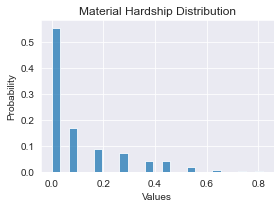

In [ ]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize = (4,3))
sns.histplot(data=y_train, stat='probability')
plt.title('Material Hardship Distribution')
plt.xlabel("Values")
plt.tight_layout()
plt.savefig('material_skew.png', dpi=400)

### ElasticNet 

In [ ]:
elastic = ElasticNet(random_state=0, max_iter = 10000)

pipeline = Pipeline(steps=[('preprocess', SimpleImputer(strategy='mean')), ('scaler', 'passthrough'), ('elastic', elastic)])

model_pipe = Pipeline([('model', TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler()))])

In [ ]:
params={'model__regressor__elastic__alpha' : np.arange(100, 2000, 100),
       'model__regressor__elastic__l1_ratio': np.arange(0.1, 1, 0.01),
       'model__regressor__preprocess__strategy': ['mean', 'median'],
       'model__regressor__scaler': [RobustScaler(), MinMaxScaler()]}

model = RandomizedSearchCV(model_pipe, n_iter=200, param_distributions= params, n_jobs=1, verbose=10, scoring='neg_mean_squared_error', cv= 4)

model.fit(X_train, y_train)


joblib_file = "material_el_not_quant_200.pkl"
joblib.dump(model, joblib_file)

In [ ]:
model = joblib.load('models/material_el_not_quant_200.pkl')

## Random Forest Regressor

In [ ]:
rf = RandomForestRegressor(random_state=0)

In [ ]:
selector_k_best = SelectKBest(score_func=f_regression)
pipeline = Pipeline(steps=[('preprocess', SimpleImputer()), 
                           ('normalize', "passthrough"),
                           ('sel', selector_k_best),
                            ('randomforest', rf)])

In [ ]:
model_pipe = Pipeline([('model', TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler()))])

In [ ]:
max_features = ['auto', 'sqrt', 'log2']
n_estimators = np.arange(150, 300, 1)
max_depth = np.arange(5, 30, 1)
min_samples_split = np.arange(2, 100, 2)
min_samples_leaf = np.arange(1, 10, 1) 

In [ ]:
params={'model__regressor__randomforest__n_estimators': n_estimators, 
        'model__regressor__randomforest__max_depth': max_depth, 
       'model__regressor__randomforest__max_features': max_features,
       'model__regressor__randomforest__min_samples_split': min_samples_split,
        'model__regressor__randomforest__min_samples_leaf': min_samples_leaf,
        'model__regressor__sel__k': [10, 100, 1000, 3000, 5000, 10000, 20000],
       'model__regressor__preprocess__strategy': ['mean', 'median'],
       'model__regressor__normalize': [StandardScaler(), RobustScaler()]}

model = RandomizedSearchCV(model_pipe, param_distributions= params, n_iter=200, n_jobs=1, verbose=10, scoring='neg_mean_squared_error', cv= 4)

model.fit(X_train, y_train)

joblib_file = "material_rf_200.pkl"
joblib.dump(model, joblib_file)

Fitting 4 folds for each of 200 candidates, totalling 800 fits
[CV 1/4; 1/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=84, model__regressor__randomforest__n_estimators=234, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 1/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=84, model__regressor__randomforest__n_estimators=234, model__regressor__sel__k=3000; total time=   5.1s
[CV 2/4; 1/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=84, model__regressor__randomforest__n_estimators=234, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 1/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=84, model__regressor__randomforest__n_estimators=234, model__regressor__sel__k=3000; total time=   4.4s
[CV 3/4; 1/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=84, model__regressor__randomforest__n_estimators=234, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 1/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=84, model__regressor__randomforest__n_estimators=234, model__regressor__sel__k=3000; total time=   4.3s
[CV 4/4; 1/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=84, model__regressor__randomforest__n_estimators=234, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 1/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=84, model__regressor__randomforest__n_estimators=234, model__regressor__sel__k=3000; total time=   4.3s
[CV 1/4; 2/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=48, model__regressor__randomforest__n_estimators=200, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 2/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=48, model__regressor__randomforest__n_estimators=200, model__regressor__sel__k=1000; total time=   5.6s
[CV 2/4; 2/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=48, model__regressor__randomforest__n_estimators=200, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 2/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=48, model__regressor__randomforest__n_estimators=200, model__regressor__sel__k=1000; total time=   5.5s
[CV 3/4; 2/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=48, model__regressor__randomforest__n_estimators=200, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 2/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=48, model__regressor__randomforest__n_estimators=200, model__regressor__sel__k=1000; total time=   5.3s
[CV 4/4; 2/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=48, model__regressor__randomforest__n_estimators=200, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 2/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=48, model__regressor__randomforest__n_estimators=200, model__regressor__sel__k=1000; total time=   5.4s
[CV 1/4; 3/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=210, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 3/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=210, model__regressor__sel__k=20000; total time=   6.8s
[CV 2/4; 3/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=210, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 3/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=210, model__regressor__sel__k=20000; total time=   6.7s
[CV 3/4; 3/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=210, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 3/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=210, model__regressor__sel__k=20000; total time=   7.5s
[CV 4/4; 3/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=210, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 3/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=210, model__regressor__sel__k=20000; total time=   7.1s
[CV 1/4; 4/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=187, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 4/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=187, model__regressor__sel__k=3000; total time=   4.3s
[CV 2/4; 4/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=187, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 4/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=187, model__regressor__sel__k=3000; total time=   4.4s
[CV 3/4; 4/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=187, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 4/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=187, model__regressor__sel__k=3000; total time=   4.2s
[CV 4/4; 4/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=187, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 4/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=187, model__regressor__sel__k=3000; total time=   4.3s
[CV 1/4; 5/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=295, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 5/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=295, model__regressor__sel__k=20000; total time=   5.3s
[CV 2/4; 5/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=295, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 5/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=295, model__regressor__sel__k=20000; total time=   5.4s
[CV 3/4; 5/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=295, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 5/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=295, model__regressor__sel__k=20000; total time=   5.3s
[CV 4/4; 5/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=295, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 5/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=295, model__regressor__sel__k=20000; total time=   5.5s
[CV 1/4; 6/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=22, model__regressor__randomforest__n_estimators=266, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 6/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=22, model__regressor__randomforest__n_estimators=266, model__regressor__sel__k=5000; total time= 1.3min
[CV 2/4; 6/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=22, model__regressor__randomforest__n_estimators=266, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 6/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=22, model__regressor__randomforest__n_estimators=266, model__regressor__sel__k=5000; total time= 1.2min
[CV 3/4; 6/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=22, model__regressor__randomforest__n_estimators=266, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 6/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=22, model__regressor__randomforest__n_estimators=266, model__regressor__sel__k=5000; total time= 1.3min
[CV 4/4; 6/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=22, model__regressor__randomforest__n_estimators=266, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 6/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=22, model__regressor__randomforest__n_estimators=266, model__regressor__sel__k=5000; total time= 1.2min
[CV 1/4; 7/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=58, model__regressor__randomforest__n_estimators=267, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 7/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=58, model__regressor__randomforest__n_estimators=267, model__regressor__sel__k=20000; total time=   5.8s
[CV 2/4; 7/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=58, model__regressor__randomforest__n_estimators=267, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 7/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=58, model__regressor__randomforest__n_estimators=267, model__regressor__sel__k=20000; total time=   6.0s
[CV 3/4; 7/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=58, model__regressor__randomforest__n_estimators=267, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 7/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=58, model__regressor__randomforest__n_estimators=267, model__regressor__sel__k=20000; total time=   5.7s
[CV 4/4; 7/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=58, model__regressor__randomforest__n_estimators=267, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 7/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=58, model__regressor__randomforest__n_estimators=267, model__regressor__sel__k=20000; total time=   5.5s
[CV 1/4; 8/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=286, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 8/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=286, model__regressor__sel__k=20000; total time= 4.7min
[CV 2/4; 8/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=286, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 8/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=286, model__regressor__sel__k=20000; total time= 4.6min
[CV 3/4; 8/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=286, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 8/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=286, model__regressor__sel__k=20000; total time= 4.8min
[CV 4/4; 8/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=286, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 8/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=286, model__regressor__sel__k=20000; total time= 4.4min
[CV 1/4; 9/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=228, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 9/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=228, model__regressor__sel__k=10; total time=   4.5s
[CV 2/4; 9/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=228, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 9/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=228, model__regressor__sel__k=10; total time=   4.2s
[CV 3/4; 9/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=228, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 9/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=228, model__regressor__sel__k=10; total time=   4.3s
[CV 4/4; 9/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=228, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 9/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=228, model__regressor__sel__k=10; total time=   4.2s
[CV 1/4; 10/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=263, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 10/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=263, model__regressor__sel__k=5000; total time=   2.4s
[CV 2/4; 10/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=263, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 10/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=263, model__regressor__sel__k=5000; total time=   2.2s
[CV 3/4; 10/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=263, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 10/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=263, model__regressor__sel__k=5000; total time=   2.4s
[CV 4/4; 10/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=263, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 10/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=263, model__regressor__sel__k=5000; total time=   2.3s
[CV 1/4; 11/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=259, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 11/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=259, model__regressor__sel__k=20000; total time=   4.1s
[CV 2/4; 11/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=259, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 11/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=259, model__regressor__sel__k=20000; total time=   4.0s
[CV 3/4; 11/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=259, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 11/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=259, model__regressor__sel__k=20000; total time=   4.1s
[CV 4/4; 11/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=259, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 11/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=259, model__regressor__sel__k=20000; total time=   4.0s
[CV 1/4; 12/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=86, model__regressor__randomforest__n_estimators=243, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 12/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=86, model__regressor__randomforest__n_estimators=243, model__regressor__sel__k=1000; total time=   9.9s
[CV 2/4; 12/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=86, model__regressor__randomforest__n_estimators=243, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 12/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=86, model__regressor__randomforest__n_estimators=243, model__regressor__sel__k=1000; total time=  10.0s
[CV 3/4; 12/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=86, model__regressor__randomforest__n_estimators=243, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 12/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=86, model__regressor__randomforest__n_estimators=243, model__regressor__sel__k=1000; total time=   9.7s
[CV 4/4; 12/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=86, model__regressor__randomforest__n_estimators=243, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 12/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=86, model__regressor__randomforest__n_estimators=243, model__regressor__sel__k=1000; total time=   9.8s
[CV 1/4; 13/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=42, model__regressor__randomforest__n_estimators=258, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 13/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=42, model__regressor__randomforest__n_estimators=258, model__regressor__sel__k=10000; total time=   6.2s
[CV 2/4; 13/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=42, model__regressor__randomforest__n_estimators=258, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 13/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=42, model__regressor__randomforest__n_estimators=258, model__regressor__sel__k=10000; total time=   6.4s
[CV 3/4; 13/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=42, model__regressor__randomforest__n_estimators=258, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 13/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=42, model__regressor__randomforest__n_estimators=258, model__regressor__sel__k=10000; total time=   6.2s
[CV 4/4; 13/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=42, model__regressor__randomforest__n_estimators=258, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 13/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=42, model__regressor__randomforest__n_estimators=258, model__regressor__sel__k=10000; total time=   6.4s
[CV 1/4; 14/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=220, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 14/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=220, model__regressor__sel__k=10; total time=   3.0s
[CV 2/4; 14/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=220, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 14/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=220, model__regressor__sel__k=10; total time=   2.9s
[CV 3/4; 14/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=220, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 14/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=220, model__regressor__sel__k=10; total time=   2.9s
[CV 4/4; 14/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=220, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 14/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=220, model__regressor__sel__k=10; total time=   3.0s
[CV 1/4; 15/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=90, model__regressor__randomforest__n_estimators=269, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 15/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=90, model__regressor__randomforest__n_estimators=269, model__regressor__sel__k=10000; total time=   2.5s
[CV 2/4; 15/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=90, model__regressor__randomforest__n_estimators=269, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 15/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=90, model__regressor__randomforest__n_estimators=269, model__regressor__sel__k=10000; total time=   2.5s
[CV 3/4; 15/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=90, model__regressor__randomforest__n_estimators=269, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 15/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=90, model__regressor__randomforest__n_estimators=269, model__regressor__sel__k=10000; total time=   2.5s
[CV 4/4; 15/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=90, model__regressor__randomforest__n_estimators=269, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 15/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=90, model__regressor__randomforest__n_estimators=269, model__regressor__sel__k=10000; total time=   2.4s
[CV 1/4; 16/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=74, model__regressor__randomforest__n_estimators=289, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 16/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=74, model__regressor__randomforest__n_estimators=289, model__regressor__sel__k=10; total time=   3.2s
[CV 2/4; 16/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=74, model__regressor__randomforest__n_estimators=289, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 16/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=74, model__regressor__randomforest__n_estimators=289, model__regressor__sel__k=10; total time=   3.1s
[CV 3/4; 16/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=74, model__regressor__randomforest__n_estimators=289, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 16/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=74, model__regressor__randomforest__n_estimators=289, model__regressor__sel__k=10; total time=   3.0s
[CV 4/4; 16/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=74, model__regressor__randomforest__n_estimators=289, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 16/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=74, model__regressor__randomforest__n_estimators=289, model__regressor__sel__k=10; total time=   3.0s
[CV 1/4; 17/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=6, model__regressor__randomforest__n_estimators=210, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 17/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=6, model__regressor__randomforest__n_estimators=210, model__regressor__sel__k=5000; total time=   2.7s
[CV 2/4; 17/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=6, model__regressor__randomforest__n_estimators=210, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 17/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=6, model__regressor__randomforest__n_estimators=210, model__regressor__sel__k=5000; total time=   2.7s
[CV 3/4; 17/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=6, model__regressor__randomforest__n_estimators=210, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 17/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=6, model__regressor__randomforest__n_estimators=210, model__regressor__sel__k=5000; total time=   2.7s
[CV 4/4; 17/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=6, model__regressor__randomforest__n_estimators=210, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 17/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=6, model__regressor__randomforest__n_estimators=210, model__regressor__sel__k=5000; total time=   2.7s
[CV 1/4; 18/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=205, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 18/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=205, model__regressor__sel__k=3000; total time=   1.8s
[CV 2/4; 18/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=205, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 18/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=205, model__regressor__sel__k=3000; total time=   1.8s
[CV 3/4; 18/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=205, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 18/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=205, model__regressor__sel__k=3000; total time=   1.8s
[CV 4/4; 18/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=205, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 18/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=205, model__regressor__sel__k=3000; total time=   1.8s
[CV 1/4; 19/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=229, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 19/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=229, model__regressor__sel__k=10; total time=   5.4s
[CV 2/4; 19/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=229, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 19/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=229, model__regressor__sel__k=10; total time=   5.3s
[CV 3/4; 19/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=229, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 19/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=229, model__regressor__sel__k=10; total time=   5.4s
[CV 4/4; 19/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=229, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 19/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=229, model__regressor__sel__k=10; total time=   5.3s
[CV 1/4; 20/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=29, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=90, model__regressor__randomforest__n_estimators=294, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 20/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=29, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=90, model__regressor__randomforest__n_estimators=294, model__regressor__sel__k=10000; total time= 2.2min
[CV 2/4; 20/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=29, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=90, model__regressor__randomforest__n_estimators=294, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 20/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=29, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=90, model__regressor__randomforest__n_estimators=294, model__regressor__sel__k=10000; total time= 2.1min
[CV 3/4; 20/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=29, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=90, model__regressor__randomforest__n_estimators=294, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 20/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=29, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=90, model__regressor__randomforest__n_estimators=294, model__regressor__sel__k=10000; total time= 2.2min
[CV 4/4; 20/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=29, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=90, model__regressor__randomforest__n_estimators=294, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 20/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=29, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=90, model__regressor__randomforest__n_estimators=294, model__regressor__sel__k=10000; total time= 2.1min
[CV 1/4; 21/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=162, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 21/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=162, model__regressor__sel__k=5000; total time=   3.2s
[CV 2/4; 21/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=162, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 21/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=162, model__regressor__sel__k=5000; total time=   3.2s
[CV 3/4; 21/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=162, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 21/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=162, model__regressor__sel__k=5000; total time=   2.9s
[CV 4/4; 21/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=162, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 21/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=162, model__regressor__sel__k=5000; total time=   3.0s
[CV 1/4; 22/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=194, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 22/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=194, model__regressor__sel__k=10; total time=   4.2s
[CV 2/4; 22/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=194, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 22/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=194, model__regressor__sel__k=10; total time=   4.2s
[CV 3/4; 22/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=194, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 22/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=194, model__regressor__sel__k=10; total time=   4.1s
[CV 4/4; 22/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=194, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 22/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=194, model__regressor__sel__k=10; total time=   4.1s
[CV 1/4; 23/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=60, model__regressor__randomforest__n_estimators=198, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 23/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=60, model__regressor__randomforest__n_estimators=198, model__regressor__sel__k=1000; total time=   5.6s
[CV 2/4; 23/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=60, model__regressor__randomforest__n_estimators=198, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 23/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=60, model__regressor__randomforest__n_estimators=198, model__regressor__sel__k=1000; total time=   5.4s
[CV 3/4; 23/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=60, model__regressor__randomforest__n_estimators=198, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 23/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=60, model__regressor__randomforest__n_estimators=198, model__regressor__sel__k=1000; total time=   5.5s
[CV 4/4; 23/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=60, model__regressor__randomforest__n_estimators=198, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 23/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=60, model__regressor__randomforest__n_estimators=198, model__regressor__sel__k=1000; total time=   5.3s
[CV 1/4; 24/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=182, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 24/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=182, model__regressor__sel__k=1000; total time=   2.8s
[CV 2/4; 24/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=182, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 24/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=182, model__regressor__sel__k=1000; total time=   2.9s
[CV 3/4; 24/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=182, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 24/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=182, model__regressor__sel__k=1000; total time=   3.0s
[CV 4/4; 24/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=182, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 24/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=182, model__regressor__sel__k=1000; total time=   3.1s
[CV 1/4; 25/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=22, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=173, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 25/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=22, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=173, model__regressor__sel__k=20000; total time=   2.6s
[CV 2/4; 25/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=22, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=173, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 25/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=22, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=173, model__regressor__sel__k=20000; total time=   2.6s
[CV 3/4; 25/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=22, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=173, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 25/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=22, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=173, model__regressor__sel__k=20000; total time=   2.6s
[CV 4/4; 25/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=22, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=173, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 25/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=22, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=173, model__regressor__sel__k=20000; total time=   2.6s
[CV 1/4; 26/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=40, model__regressor__randomforest__n_estimators=188, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 26/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=40, model__regressor__randomforest__n_estimators=188, model__regressor__sel__k=100; total time=   1.7s
[CV 2/4; 26/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=40, model__regressor__randomforest__n_estimators=188, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 26/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=40, model__regressor__randomforest__n_estimators=188, model__regressor__sel__k=100; total time=   1.7s
[CV 3/4; 26/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=40, model__regressor__randomforest__n_estimators=188, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 26/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=40, model__regressor__randomforest__n_estimators=188, model__regressor__sel__k=100; total time=   1.7s
[CV 4/4; 26/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=40, model__regressor__randomforest__n_estimators=188, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 26/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=40, model__regressor__randomforest__n_estimators=188, model__regressor__sel__k=100; total time=   1.7s
[CV 1/4; 27/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=22, model__regressor__randomforest__n_estimators=274, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 27/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=22, model__regressor__randomforest__n_estimators=274, model__regressor__sel__k=100; total time=   1.9s
[CV 2/4; 27/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=22, model__regressor__randomforest__n_estimators=274, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 27/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=22, model__regressor__randomforest__n_estimators=274, model__regressor__sel__k=100; total time=   1.8s
[CV 3/4; 27/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=22, model__regressor__randomforest__n_estimators=274, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 27/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=22, model__regressor__randomforest__n_estimators=274, model__regressor__sel__k=100; total time=   1.9s
[CV 4/4; 27/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=22, model__regressor__randomforest__n_estimators=274, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 27/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=22, model__regressor__randomforest__n_estimators=274, model__regressor__sel__k=100; total time=   1.8s
[CV 1/4; 28/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=26, model__regressor__randomforest__n_estimators=203, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 28/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=26, model__regressor__randomforest__n_estimators=203, model__regressor__sel__k=20000; total time=   5.5s
[CV 2/4; 28/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=26, model__regressor__randomforest__n_estimators=203, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 28/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=26, model__regressor__randomforest__n_estimators=203, model__regressor__sel__k=20000; total time=   5.9s
[CV 3/4; 28/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=26, model__regressor__randomforest__n_estimators=203, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 28/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=26, model__regressor__randomforest__n_estimators=203, model__regressor__sel__k=20000; total time=   5.7s
[CV 4/4; 28/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=26, model__regressor__randomforest__n_estimators=203, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 28/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=26, model__regressor__randomforest__n_estimators=203, model__regressor__sel__k=20000; total time=   5.4s
[CV 1/4; 29/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=40, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 29/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=40, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=100; total time=   5.2s
[CV 2/4; 29/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=40, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 29/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=40, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=100; total time=   5.3s
[CV 3/4; 29/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=40, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 29/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=40, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=100; total time=   5.4s
[CV 4/4; 29/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=40, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 29/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=40, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=100; total time=   5.2s
[CV 1/4; 30/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=82, model__regressor__randomforest__n_estimators=186, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 30/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=82, model__regressor__randomforest__n_estimators=186, model__regressor__sel__k=10000; total time=   3.1s
[CV 2/4; 30/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=82, model__regressor__randomforest__n_estimators=186, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 30/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=82, model__regressor__randomforest__n_estimators=186, model__regressor__sel__k=10000; total time=   2.9s
[CV 3/4; 30/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=82, model__regressor__randomforest__n_estimators=186, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 30/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=82, model__regressor__randomforest__n_estimators=186, model__regressor__sel__k=10000; total time=   3.1s
[CV 4/4; 30/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=82, model__regressor__randomforest__n_estimators=186, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 30/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=82, model__regressor__randomforest__n_estimators=186, model__regressor__sel__k=10000; total time=   2.9s
[CV 1/4; 31/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=287, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 31/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=287, model__regressor__sel__k=3000; total time=   4.3s
[CV 2/4; 31/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=287, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 31/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=287, model__regressor__sel__k=3000; total time=   4.3s
[CV 3/4; 31/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=287, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 31/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=287, model__regressor__sel__k=3000; total time=   4.3s
[CV 4/4; 31/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=287, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 31/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=287, model__regressor__sel__k=3000; total time=   4.3s
[CV 1/4; 32/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=216, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 32/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=216, model__regressor__sel__k=1000; total time=   2.1s
[CV 2/4; 32/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=216, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 32/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=216, model__regressor__sel__k=1000; total time=   1.9s
[CV 3/4; 32/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=216, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 32/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=216, model__regressor__sel__k=1000; total time=   2.0s
[CV 4/4; 32/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=216, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 32/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=216, model__regressor__sel__k=1000; total time=   2.0s
[CV 1/4; 33/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=265, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 33/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=265, model__regressor__sel__k=1000; total time=   5.6s
[CV 2/4; 33/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=265, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 33/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=265, model__regressor__sel__k=1000; total time=   5.3s
[CV 3/4; 33/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=265, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 33/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=265, model__regressor__sel__k=1000; total time=   5.5s
[CV 4/4; 33/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=265, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 33/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=265, model__regressor__sel__k=1000; total time=   5.5s
[CV 1/4; 34/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=48, model__regressor__randomforest__n_estimators=290, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 34/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=48, model__regressor__randomforest__n_estimators=290, model__regressor__sel__k=1000; total time=   4.5s
[CV 2/4; 34/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=48, model__regressor__randomforest__n_estimators=290, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 34/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=48, model__regressor__randomforest__n_estimators=290, model__regressor__sel__k=1000; total time=   4.4s
[CV 3/4; 34/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=48, model__regressor__randomforest__n_estimators=290, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 34/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=48, model__regressor__randomforest__n_estimators=290, model__regressor__sel__k=1000; total time=   4.5s
[CV 4/4; 34/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=48, model__regressor__randomforest__n_estimators=290, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 34/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=48, model__regressor__randomforest__n_estimators=290, model__regressor__sel__k=1000; total time=   4.5s
[CV 1/4; 35/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=96, model__regressor__randomforest__n_estimators=185, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 35/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=96, model__regressor__randomforest__n_estimators=185, model__regressor__sel__k=3000; total time=   5.2s
[CV 2/4; 35/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=96, model__regressor__randomforest__n_estimators=185, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 35/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=96, model__regressor__randomforest__n_estimators=185, model__regressor__sel__k=3000; total time=   5.4s
[CV 3/4; 35/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=96, model__regressor__randomforest__n_estimators=185, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 35/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=96, model__regressor__randomforest__n_estimators=185, model__regressor__sel__k=3000; total time=   5.1s
[CV 4/4; 35/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=96, model__regressor__randomforest__n_estimators=185, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 35/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=96, model__regressor__randomforest__n_estimators=185, model__regressor__sel__k=3000; total time=   5.5s
[CV 1/4; 36/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=271, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 36/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=271, model__regressor__sel__k=100; total time=   3.1s
[CV 2/4; 36/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=271, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 36/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=271, model__regressor__sel__k=100; total time=   3.0s
[CV 3/4; 36/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=271, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 36/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=271, model__regressor__sel__k=100; total time=   3.1s
[CV 4/4; 36/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=271, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 36/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=271, model__regressor__sel__k=100; total time=   3.0s
[CV 1/4; 37/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=283, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 37/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=283, model__regressor__sel__k=3000; total time=   5.8s
[CV 2/4; 37/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=283, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 37/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=283, model__regressor__sel__k=3000; total time=   6.1s
[CV 3/4; 37/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=283, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 37/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=283, model__regressor__sel__k=3000; total time=   6.4s
[CV 4/4; 37/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=283, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 37/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=283, model__regressor__sel__k=3000; total time=   6.2s
[CV 1/4; 38/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=152, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 38/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=152, model__regressor__sel__k=10000; total time=   4.2s
[CV 2/4; 38/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=152, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 38/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=152, model__regressor__sel__k=10000; total time=   4.2s
[CV 3/4; 38/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=152, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 38/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=152, model__regressor__sel__k=10000; total time=   4.4s
[CV 4/4; 38/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=152, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 38/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=152, model__regressor__sel__k=10000; total time=   4.3s
[CV 1/4; 39/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=181, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 39/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=181, model__regressor__sel__k=100; total time=   3.0s
[CV 2/4; 39/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=181, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 39/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=181, model__regressor__sel__k=100; total time=   3.0s
[CV 3/4; 39/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=181, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 39/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=181, model__regressor__sel__k=100; total time=   3.1s
[CV 4/4; 39/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=181, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 39/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=181, model__regressor__sel__k=100; total time=   3.0s
[CV 1/4; 40/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=250, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 40/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=250, model__regressor__sel__k=10000; total time=   6.4s
[CV 2/4; 40/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=250, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 40/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=250, model__regressor__sel__k=10000; total time=   6.3s
[CV 3/4; 40/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=250, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 40/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=250, model__regressor__sel__k=10000; total time=   6.3s
[CV 4/4; 40/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=250, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 40/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=250, model__regressor__sel__k=10000; total time=   6.3s
[CV 1/4; 41/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=184, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 41/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=184, model__regressor__sel__k=5000; total time=   4.2s
[CV 2/4; 41/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=184, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 41/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=184, model__regressor__sel__k=5000; total time=   4.3s
[CV 3/4; 41/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=184, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 41/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=184, model__regressor__sel__k=5000; total time=   4.3s
[CV 4/4; 41/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=184, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 41/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=184, model__regressor__sel__k=5000; total time=   4.3s
[CV 1/4; 42/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=199, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 42/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=199, model__regressor__sel__k=20000; total time=   2.0s
[CV 2/4; 42/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=199, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 42/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=199, model__regressor__sel__k=20000; total time=   1.8s
[CV 3/4; 42/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=199, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 42/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=199, model__regressor__sel__k=20000; total time=   1.9s
[CV 4/4; 42/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=199, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 42/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=199, model__regressor__sel__k=20000; total time=   1.9s
[CV 1/4; 43/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=24, model__regressor__randomforest__n_estimators=219, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 43/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=24, model__regressor__randomforest__n_estimators=219, model__regressor__sel__k=3000; total time=  31.5s
[CV 2/4; 43/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=24, model__regressor__randomforest__n_estimators=219, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 43/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=24, model__regressor__randomforest__n_estimators=219, model__regressor__sel__k=3000; total time=  31.3s
[CV 3/4; 43/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=24, model__regressor__randomforest__n_estimators=219, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 43/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=24, model__regressor__randomforest__n_estimators=219, model__regressor__sel__k=3000; total time=  32.3s
[CV 4/4; 43/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=24, model__regressor__randomforest__n_estimators=219, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 43/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=24, model__regressor__randomforest__n_estimators=219, model__regressor__sel__k=3000; total time=  30.8s
[CV 1/4; 44/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=50, model__regressor__randomforest__n_estimators=277, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 44/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=50, model__regressor__randomforest__n_estimators=277, model__regressor__sel__k=20000; total time=   6.3s
[CV 2/4; 44/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=50, model__regressor__randomforest__n_estimators=277, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 44/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=50, model__regressor__randomforest__n_estimators=277, model__regressor__sel__k=20000; total time=   5.4s
[CV 3/4; 44/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=50, model__regressor__randomforest__n_estimators=277, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 44/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=50, model__regressor__randomforest__n_estimators=277, model__regressor__sel__k=20000; total time=   5.5s
[CV 4/4; 44/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=50, model__regressor__randomforest__n_estimators=277, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 44/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=50, model__regressor__randomforest__n_estimators=277, model__regressor__sel__k=20000; total time=   5.4s
[CV 1/4; 45/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=273, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 45/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=273, model__regressor__sel__k=3000; total time=   3.3s
[CV 2/4; 45/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=273, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 45/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=273, model__regressor__sel__k=3000; total time=   3.4s
[CV 3/4; 45/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=273, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 45/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=273, model__regressor__sel__k=3000; total time=   3.5s
[CV 4/4; 45/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=273, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 45/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=273, model__regressor__sel__k=3000; total time=   3.3s
[CV 1/4; 46/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=205, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 46/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=205, model__regressor__sel__k=20000; total time=   3.3s
[CV 2/4; 46/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=205, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 46/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=205, model__regressor__sel__k=20000; total time=   3.2s
[CV 3/4; 46/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=205, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 46/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=205, model__regressor__sel__k=20000; total time=   3.3s
[CV 4/4; 46/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=205, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 46/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=205, model__regressor__sel__k=20000; total time=   3.3s
[CV 1/4; 47/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=263, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 47/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=263, model__regressor__sel__k=3000; total time=  39.4s
[CV 2/4; 47/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=263, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 47/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=263, model__regressor__sel__k=3000; total time=  39.2s
[CV 3/4; 47/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=263, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 47/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=263, model__regressor__sel__k=3000; total time=  40.6s
[CV 4/4; 47/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=263, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 47/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=263, model__regressor__sel__k=3000; total time=  37.3s
[CV 1/4; 48/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=58, model__regressor__randomforest__n_estimators=241, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 48/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=58, model__regressor__randomforest__n_estimators=241, model__regressor__sel__k=10; total time=   3.1s
[CV 2/4; 48/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=58, model__regressor__randomforest__n_estimators=241, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 48/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=58, model__regressor__randomforest__n_estimators=241, model__regressor__sel__k=10; total time=   3.0s
[CV 3/4; 48/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=58, model__regressor__randomforest__n_estimators=241, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 48/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=58, model__regressor__randomforest__n_estimators=241, model__regressor__sel__k=10; total time=   3.2s
[CV 4/4; 48/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=58, model__regressor__randomforest__n_estimators=241, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 48/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=58, model__regressor__randomforest__n_estimators=241, model__regressor__sel__k=10; total time=   2.9s
[CV 1/4; 49/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=191, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 49/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=191, model__regressor__sel__k=5000; total time=  37.3s
[CV 2/4; 49/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=191, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 49/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=191, model__regressor__sel__k=5000; total time=  37.6s
[CV 3/4; 49/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=191, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 49/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=191, model__regressor__sel__k=5000; total time=  38.5s
[CV 4/4; 49/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=191, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 49/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=191, model__regressor__sel__k=5000; total time=  39.9s
[CV 1/4; 50/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=16, model__regressor__randomforest__n_estimators=173, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 50/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=16, model__regressor__randomforest__n_estimators=173, model__regressor__sel__k=10; total time=   5.8s
[CV 2/4; 50/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=16, model__regressor__randomforest__n_estimators=173, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 50/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=16, model__regressor__randomforest__n_estimators=173, model__regressor__sel__k=10; total time=   5.3s
[CV 3/4; 50/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=16, model__regressor__randomforest__n_estimators=173, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 50/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=16, model__regressor__randomforest__n_estimators=173, model__regressor__sel__k=10; total time=   5.5s
[CV 4/4; 50/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=16, model__regressor__randomforest__n_estimators=173, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 50/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=16, model__regressor__randomforest__n_estimators=173, model__regressor__sel__k=10; total time=   5.2s
[CV 1/4; 51/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=247, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 51/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=247, model__regressor__sel__k=100; total time=   1.7s
[CV 2/4; 51/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=247, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 51/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=247, model__regressor__sel__k=100; total time=   1.7s
[CV 3/4; 51/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=247, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 51/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=247, model__regressor__sel__k=100; total time=   1.7s
[CV 4/4; 51/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=247, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 51/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=247, model__regressor__sel__k=100; total time=   1.7s
[CV 1/4; 52/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=38, model__regressor__randomforest__n_estimators=177, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 52/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=38, model__regressor__randomforest__n_estimators=177, model__regressor__sel__k=3000; total time=   5.4s
[CV 2/4; 52/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=38, model__regressor__randomforest__n_estimators=177, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 52/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=38, model__regressor__randomforest__n_estimators=177, model__regressor__sel__k=3000; total time=   5.4s
[CV 3/4; 52/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=38, model__regressor__randomforest__n_estimators=177, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 52/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=38, model__regressor__randomforest__n_estimators=177, model__regressor__sel__k=3000; total time=   5.5s
[CV 4/4; 52/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=38, model__regressor__randomforest__n_estimators=177, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 52/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=38, model__regressor__randomforest__n_estimators=177, model__regressor__sel__k=3000; total time=   5.6s
[CV 1/4; 53/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=40, model__regressor__randomforest__n_estimators=247, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 53/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=40, model__regressor__randomforest__n_estimators=247, model__regressor__sel__k=100; total time=   1.9s
[CV 2/4; 53/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=40, model__regressor__randomforest__n_estimators=247, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 53/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=40, model__regressor__randomforest__n_estimators=247, model__regressor__sel__k=100; total time=   1.8s
[CV 3/4; 53/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=40, model__regressor__randomforest__n_estimators=247, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 53/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=40, model__regressor__randomforest__n_estimators=247, model__regressor__sel__k=100; total time=   1.8s
[CV 4/4; 53/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=40, model__regressor__randomforest__n_estimators=247, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 53/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=40, model__regressor__randomforest__n_estimators=247, model__regressor__sel__k=100; total time=   1.8s
[CV 1/4; 54/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=26, model__regressor__randomforest__n_estimators=255, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 54/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=26, model__regressor__randomforest__n_estimators=255, model__regressor__sel__k=3000; total time=  27.3s
[CV 2/4; 54/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=26, model__regressor__randomforest__n_estimators=255, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 54/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=26, model__regressor__randomforest__n_estimators=255, model__regressor__sel__k=3000; total time=  28.0s
[CV 3/4; 54/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=26, model__regressor__randomforest__n_estimators=255, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 54/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=26, model__regressor__randomforest__n_estimators=255, model__regressor__sel__k=3000; total time=  27.6s
[CV 4/4; 54/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=26, model__regressor__randomforest__n_estimators=255, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 54/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=26, model__regressor__randomforest__n_estimators=255, model__regressor__sel__k=3000; total time=  29.0s
[CV 1/4; 55/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=272, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 55/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=272, model__regressor__sel__k=3000; total time=   3.9s
[CV 2/4; 55/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=272, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 55/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=272, model__regressor__sel__k=3000; total time=   3.6s
[CV 3/4; 55/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=272, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 55/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=272, model__regressor__sel__k=3000; total time=   3.6s
[CV 4/4; 55/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=272, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 55/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=272, model__regressor__sel__k=3000; total time=   3.6s
[CV 1/4; 56/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=263, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 56/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=263, model__regressor__sel__k=10; total time=   5.4s
[CV 2/4; 56/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=263, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 56/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=263, model__regressor__sel__k=10; total time=   5.3s
[CV 3/4; 56/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=263, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 56/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=263, model__regressor__sel__k=10; total time=   5.3s
[CV 4/4; 56/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=263, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 56/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=263, model__regressor__sel__k=10; total time=   5.4s
[CV 1/4; 57/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=267, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 57/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=267, model__regressor__sel__k=100; total time=   2.6s
[CV 2/4; 57/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=267, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 57/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=267, model__regressor__sel__k=100; total time=   2.8s
[CV 3/4; 57/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=267, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 57/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=267, model__regressor__sel__k=100; total time=   2.8s
[CV 4/4; 57/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=267, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 57/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=267, model__regressor__sel__k=100; total time=   2.7s
[CV 1/4; 58/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=96, model__regressor__randomforest__n_estimators=185, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 58/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=96, model__regressor__randomforest__n_estimators=185, model__regressor__sel__k=100; total time=   1.8s
[CV 2/4; 58/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=96, model__regressor__randomforest__n_estimators=185, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 58/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=96, model__regressor__randomforest__n_estimators=185, model__regressor__sel__k=100; total time=   1.8s
[CV 3/4; 58/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=96, model__regressor__randomforest__n_estimators=185, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 58/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=96, model__regressor__randomforest__n_estimators=185, model__regressor__sel__k=100; total time=   1.9s
[CV 4/4; 58/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=96, model__regressor__randomforest__n_estimators=185, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 58/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=96, model__regressor__randomforest__n_estimators=185, model__regressor__sel__k=100; total time=   1.7s
[CV 1/4; 59/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=32, model__regressor__randomforest__n_estimators=166, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 59/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=32, model__regressor__randomforest__n_estimators=166, model__regressor__sel__k=3000; total time=   5.4s
[CV 2/4; 59/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=32, model__regressor__randomforest__n_estimators=166, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 59/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=32, model__regressor__randomforest__n_estimators=166, model__regressor__sel__k=3000; total time=   5.3s
[CV 3/4; 59/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=32, model__regressor__randomforest__n_estimators=166, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 59/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=32, model__regressor__randomforest__n_estimators=166, model__regressor__sel__k=3000; total time=   5.4s
[CV 4/4; 59/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=32, model__regressor__randomforest__n_estimators=166, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 59/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=32, model__regressor__randomforest__n_estimators=166, model__regressor__sel__k=3000; total time=   5.5s
[CV 1/4; 60/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=220, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 60/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=220, model__regressor__sel__k=1000; total time=  14.4s
[CV 2/4; 60/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=220, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 60/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=220, model__regressor__sel__k=1000; total time=  15.3s
[CV 3/4; 60/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=220, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 60/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=220, model__regressor__sel__k=1000; total time=  14.7s
[CV 4/4; 60/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=220, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 60/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=220, model__regressor__sel__k=1000; total time=  13.6s
[CV 1/4; 61/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=56, model__regressor__randomforest__n_estimators=267, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 61/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=56, model__regressor__randomforest__n_estimators=267, model__regressor__sel__k=100; total time=   6.3s
[CV 2/4; 61/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=56, model__regressor__randomforest__n_estimators=267, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 61/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=56, model__regressor__randomforest__n_estimators=267, model__regressor__sel__k=100; total time=   6.5s
[CV 3/4; 61/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=56, model__regressor__randomforest__n_estimators=267, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 61/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=56, model__regressor__randomforest__n_estimators=267, model__regressor__sel__k=100; total time=   6.5s
[CV 4/4; 61/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=56, model__regressor__randomforest__n_estimators=267, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 61/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=56, model__regressor__randomforest__n_estimators=267, model__regressor__sel__k=100; total time=   6.4s
[CV 1/4; 62/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=228, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 62/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=228, model__regressor__sel__k=10000; total time= 1.7min
[CV 2/4; 62/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=228, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 62/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=228, model__regressor__sel__k=10000; total time= 1.6min
[CV 3/4; 62/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=228, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 62/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=228, model__regressor__sel__k=10000; total time= 1.7min
[CV 4/4; 62/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=228, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 62/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=228, model__regressor__sel__k=10000; total time= 1.6min
[CV 1/4; 63/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=34, model__regressor__randomforest__n_estimators=259, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 63/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=34, model__regressor__randomforest__n_estimators=259, model__regressor__sel__k=10; total time=   4.2s
[CV 2/4; 63/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=34, model__regressor__randomforest__n_estimators=259, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 63/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=34, model__regressor__randomforest__n_estimators=259, model__regressor__sel__k=10; total time=   4.3s
[CV 3/4; 63/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=34, model__regressor__randomforest__n_estimators=259, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 63/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=34, model__regressor__randomforest__n_estimators=259, model__regressor__sel__k=10; total time=   4.2s
[CV 4/4; 63/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=34, model__regressor__randomforest__n_estimators=259, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 63/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=34, model__regressor__randomforest__n_estimators=259, model__regressor__sel__k=10; total time=   4.2s
[CV 1/4; 64/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=34, model__regressor__randomforest__n_estimators=272, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 64/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=34, model__regressor__randomforest__n_estimators=272, model__regressor__sel__k=3000; total time=   4.8s
[CV 2/4; 64/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=34, model__regressor__randomforest__n_estimators=272, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 64/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=34, model__regressor__randomforest__n_estimators=272, model__regressor__sel__k=3000; total time=   4.7s
[CV 3/4; 64/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=34, model__regressor__randomforest__n_estimators=272, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 64/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=34, model__regressor__randomforest__n_estimators=272, model__regressor__sel__k=3000; total time=   4.8s
[CV 4/4; 64/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=34, model__regressor__randomforest__n_estimators=272, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 64/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=34, model__regressor__randomforest__n_estimators=272, model__regressor__sel__k=3000; total time=   4.7s
[CV 1/4; 65/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=196, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 65/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=196, model__regressor__sel__k=100; total time=   3.1s
[CV 2/4; 65/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=196, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 65/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=196, model__regressor__sel__k=100; total time=   3.1s
[CV 3/4; 65/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=196, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 65/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=196, model__regressor__sel__k=100; total time=   2.8s
[CV 4/4; 65/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=196, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 65/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=196, model__regressor__sel__k=100; total time=   3.0s
[CV 1/4; 66/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=96, model__regressor__randomforest__n_estimators=230, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 66/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=96, model__regressor__randomforest__n_estimators=230, model__regressor__sel__k=10; total time=   1.8s
[CV 2/4; 66/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=96, model__regressor__randomforest__n_estimators=230, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 66/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=96, model__regressor__randomforest__n_estimators=230, model__regressor__sel__k=10; total time=   1.8s
[CV 3/4; 66/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=96, model__regressor__randomforest__n_estimators=230, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 66/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=96, model__regressor__randomforest__n_estimators=230, model__regressor__sel__k=10; total time=   1.8s
[CV 4/4; 66/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=96, model__regressor__randomforest__n_estimators=230, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 66/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=96, model__regressor__randomforest__n_estimators=230, model__regressor__sel__k=10; total time=   1.8s
[CV 1/4; 67/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=2, model__regressor__randomforest__n_estimators=282, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 67/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=2, model__regressor__randomforest__n_estimators=282, model__regressor__sel__k=1000; total time=   1.8s
[CV 2/4; 67/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=2, model__regressor__randomforest__n_estimators=282, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 67/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=2, model__regressor__randomforest__n_estimators=282, model__regressor__sel__k=1000; total time=   1.8s
[CV 3/4; 67/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=2, model__regressor__randomforest__n_estimators=282, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 67/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=2, model__regressor__randomforest__n_estimators=282, model__regressor__sel__k=1000; total time=   1.9s
[CV 4/4; 67/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=2, model__regressor__randomforest__n_estimators=282, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 67/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=2, model__regressor__randomforest__n_estimators=282, model__regressor__sel__k=1000; total time=   1.8s
[CV 1/4; 68/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=28, model__regressor__randomforest__n_estimators=265, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 68/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=28, model__regressor__randomforest__n_estimators=265, model__regressor__sel__k=1000; total time=   3.9s
[CV 2/4; 68/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=28, model__regressor__randomforest__n_estimators=265, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 68/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=28, model__regressor__randomforest__n_estimators=265, model__regressor__sel__k=1000; total time=   3.1s
[CV 3/4; 68/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=28, model__regressor__randomforest__n_estimators=265, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 68/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=28, model__regressor__randomforest__n_estimators=265, model__regressor__sel__k=1000; total time=   3.1s
[CV 4/4; 68/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=28, model__regressor__randomforest__n_estimators=265, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 68/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=28, model__regressor__randomforest__n_estimators=265, model__regressor__sel__k=1000; total time=   3.1s
[CV 1/4; 69/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=185, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 69/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=185, model__regressor__sel__k=3000; total time=  19.4s
[CV 2/4; 69/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=185, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 69/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=185, model__regressor__sel__k=3000; total time=  19.3s
[CV 3/4; 69/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=185, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 69/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=185, model__regressor__sel__k=3000; total time=  18.8s
[CV 4/4; 69/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=185, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 69/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=185, model__regressor__sel__k=3000; total time=  20.0s
[CV 1/4; 70/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=38, model__regressor__randomforest__n_estimators=251, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 70/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=38, model__regressor__randomforest__n_estimators=251, model__regressor__sel__k=5000; total time=   3.0s
[CV 2/4; 70/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=38, model__regressor__randomforest__n_estimators=251, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 70/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=38, model__regressor__randomforest__n_estimators=251, model__regressor__sel__k=5000; total time=   3.0s
[CV 3/4; 70/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=38, model__regressor__randomforest__n_estimators=251, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 70/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=38, model__regressor__randomforest__n_estimators=251, model__regressor__sel__k=5000; total time=   3.2s
[CV 4/4; 70/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=38, model__regressor__randomforest__n_estimators=251, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 70/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=38, model__regressor__randomforest__n_estimators=251, model__regressor__sel__k=5000; total time=   3.0s
[CV 1/4; 71/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=263, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 71/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=263, model__regressor__sel__k=10; total time=   1.8s
[CV 2/4; 71/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=263, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 71/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=263, model__regressor__sel__k=10; total time=   2.0s
[CV 3/4; 71/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=263, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 71/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=263, model__regressor__sel__k=10; total time=   1.8s
[CV 4/4; 71/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=263, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 71/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=263, model__regressor__sel__k=10; total time=   1.8s
[CV 1/4; 72/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=238, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 72/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=238, model__regressor__sel__k=20000; total time=   5.6s
[CV 2/4; 72/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=238, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 72/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=238, model__regressor__sel__k=20000; total time=   5.4s
[CV 3/4; 72/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=238, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 72/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=238, model__regressor__sel__k=20000; total time=   5.5s
[CV 4/4; 72/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=238, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 72/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=238, model__regressor__sel__k=20000; total time=   5.5s
[CV 1/4; 73/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=288, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 73/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=288, model__regressor__sel__k=20000; total time=   3.8s
[CV 2/4; 73/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=288, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 73/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=288, model__regressor__sel__k=20000; total time=   4.0s
[CV 3/4; 73/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=288, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 73/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=288, model__regressor__sel__k=20000; total time=   3.8s
[CV 4/4; 73/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=288, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 73/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=288, model__regressor__sel__k=20000; total time=   4.0s
[CV 1/4; 74/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=74, model__regressor__randomforest__n_estimators=280, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 74/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=74, model__regressor__randomforest__n_estimators=280, model__regressor__sel__k=5000; total time= 1.0min
[CV 2/4; 74/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=74, model__regressor__randomforest__n_estimators=280, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 74/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=74, model__regressor__randomforest__n_estimators=280, model__regressor__sel__k=5000; total time=  58.4s
[CV 3/4; 74/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=74, model__regressor__randomforest__n_estimators=280, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 74/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=74, model__regressor__randomforest__n_estimators=280, model__regressor__sel__k=5000; total time= 1.0min
[CV 4/4; 74/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=74, model__regressor__randomforest__n_estimators=280, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 74/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=74, model__regressor__randomforest__n_estimators=280, model__regressor__sel__k=5000; total time=  58.6s
[CV 1/4; 75/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 75/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=10000; total time= 2.1min
[CV 2/4; 75/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 75/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=10000; total time= 2.1min
[CV 3/4; 75/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 75/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=10000; total time= 2.1min
[CV 4/4; 75/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 75/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=10000; total time= 2.1min
[CV 1/4; 76/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=56, model__regressor__randomforest__n_estimators=205, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 76/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=56, model__regressor__randomforest__n_estimators=205, model__regressor__sel__k=1000; total time=  10.3s
[CV 2/4; 76/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=56, model__regressor__randomforest__n_estimators=205, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 76/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=56, model__regressor__randomforest__n_estimators=205, model__regressor__sel__k=1000; total time=  10.8s
[CV 3/4; 76/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=56, model__regressor__randomforest__n_estimators=205, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 76/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=56, model__regressor__randomforest__n_estimators=205, model__regressor__sel__k=1000; total time=  10.2s
[CV 4/4; 76/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=56, model__regressor__randomforest__n_estimators=205, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 76/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=56, model__regressor__randomforest__n_estimators=205, model__regressor__sel__k=1000; total time=   9.7s
[CV 1/4; 77/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=299, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 77/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=299, model__regressor__sel__k=20000; total time= 5.5min
[CV 2/4; 77/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=299, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 77/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=299, model__regressor__sel__k=20000; total time= 5.6min
[CV 3/4; 77/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=299, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 77/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=299, model__regressor__sel__k=20000; total time= 5.7min
[CV 4/4; 77/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=299, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 77/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=299, model__regressor__sel__k=20000; total time= 5.4min
[CV 1/4; 78/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=278, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 78/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=278, model__regressor__sel__k=3000; total time=   3.4s
[CV 2/4; 78/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=278, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 78/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=278, model__regressor__sel__k=3000; total time=   3.1s
[CV 3/4; 78/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=278, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 78/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=278, model__regressor__sel__k=3000; total time=   3.0s
[CV 4/4; 78/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=278, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 78/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=278, model__regressor__sel__k=3000; total time=   3.0s
[CV 1/4; 79/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=253, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 79/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=253, model__regressor__sel__k=100; total time=   4.2s
[CV 2/4; 79/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=253, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 79/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=253, model__regressor__sel__k=100; total time=   4.2s
[CV 3/4; 79/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=253, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 79/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=253, model__regressor__sel__k=100; total time=   4.2s
[CV 4/4; 79/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=253, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 79/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=253, model__regressor__sel__k=100; total time=   4.2s
[CV 1/4; 80/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=285, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 80/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=285, model__regressor__sel__k=1000; total time=   4.5s
[CV 2/4; 80/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=285, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 80/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=285, model__regressor__sel__k=1000; total time=   4.5s
[CV 3/4; 80/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=285, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 80/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=285, model__regressor__sel__k=1000; total time=   4.6s
[CV 4/4; 80/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=285, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 80/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=285, model__regressor__sel__k=1000; total time=   4.4s
[CV 1/4; 81/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=236, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 81/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=236, model__regressor__sel__k=5000; total time=  48.5s
[CV 2/4; 81/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=236, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 81/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=236, model__regressor__sel__k=5000; total time=  45.9s
[CV 3/4; 81/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=236, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 81/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=236, model__regressor__sel__k=5000; total time=  49.7s
[CV 4/4; 81/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=236, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 81/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=236, model__regressor__sel__k=5000; total time=  46.9s
[CV 1/4; 82/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=178, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 82/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=178, model__regressor__sel__k=10000; total time=   5.3s
[CV 2/4; 82/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=178, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 82/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=178, model__regressor__sel__k=10000; total time=   5.3s
[CV 3/4; 82/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=178, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 82/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=178, model__regressor__sel__k=10000; total time=   5.1s
[CV 4/4; 82/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=178, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 82/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=178, model__regressor__sel__k=10000; total time=   5.1s
[CV 1/4; 83/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=164, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 83/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=164, model__regressor__sel__k=5000; total time=   2.5s
[CV 2/4; 83/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=164, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 83/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=164, model__regressor__sel__k=5000; total time=   2.5s
[CV 3/4; 83/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=164, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 83/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=164, model__regressor__sel__k=5000; total time=   2.3s
[CV 4/4; 83/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=164, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 83/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=164, model__regressor__sel__k=5000; total time=   2.5s
[CV 1/4; 84/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=234, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 84/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=234, model__regressor__sel__k=10000; total time=   6.1s
[CV 2/4; 84/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=234, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 84/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=234, model__regressor__sel__k=10000; total time=   6.0s
[CV 3/4; 84/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=234, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 84/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=234, model__regressor__sel__k=10000; total time=   6.0s
[CV 4/4; 84/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=234, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 84/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=234, model__regressor__sel__k=10000; total time=   5.9s
[CV 1/4; 85/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=240, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 85/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=240, model__regressor__sel__k=3000; total time=   4.3s
[CV 2/4; 85/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=240, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 85/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=240, model__regressor__sel__k=3000; total time=   4.3s
[CV 3/4; 85/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=240, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 85/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=240, model__regressor__sel__k=3000; total time=   4.3s
[CV 4/4; 85/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=240, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 85/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=240, model__regressor__sel__k=3000; total time=   4.3s
[CV 1/4; 86/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=21, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=2, model__regressor__randomforest__n_estimators=174, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 86/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=21, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=2, model__regressor__randomforest__n_estimators=174, model__regressor__sel__k=5000; total time=   3.2s
[CV 2/4; 86/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=21, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=2, model__regressor__randomforest__n_estimators=174, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 86/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=21, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=2, model__regressor__randomforest__n_estimators=174, model__regressor__sel__k=5000; total time=   3.2s
[CV 3/4; 86/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=21, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=2, model__regressor__randomforest__n_estimators=174, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 86/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=21, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=2, model__regressor__randomforest__n_estimators=174, model__regressor__sel__k=5000; total time=   3.0s
[CV 4/4; 86/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=21, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=2, model__regressor__randomforest__n_estimators=174, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 86/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=21, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=2, model__regressor__randomforest__n_estimators=174, model__regressor__sel__k=5000; total time=   3.2s
[CV 1/4; 87/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=187, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 87/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=187, model__regressor__sel__k=5000; total time=   1.8s
[CV 2/4; 87/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=187, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 87/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=187, model__regressor__sel__k=5000; total time=   1.8s
[CV 3/4; 87/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=187, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 87/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=187, model__regressor__sel__k=5000; total time=   1.8s
[CV 4/4; 87/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=187, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 87/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=187, model__regressor__sel__k=5000; total time=   1.8s
[CV 1/4; 88/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=36, model__regressor__randomforest__n_estimators=207, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 88/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=36, model__regressor__randomforest__n_estimators=207, model__regressor__sel__k=20000; total time= 1.7min
[CV 2/4; 88/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=36, model__regressor__randomforest__n_estimators=207, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 88/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=36, model__regressor__randomforest__n_estimators=207, model__regressor__sel__k=20000; total time= 1.7min
[CV 3/4; 88/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=36, model__regressor__randomforest__n_estimators=207, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 88/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=36, model__regressor__randomforest__n_estimators=207, model__regressor__sel__k=20000; total time= 1.6min
[CV 4/4; 88/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=36, model__regressor__randomforest__n_estimators=207, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 88/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=36, model__regressor__randomforest__n_estimators=207, model__regressor__sel__k=20000; total time= 1.7min
[CV 1/4; 89/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=82, model__regressor__randomforest__n_estimators=287, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 89/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=82, model__regressor__randomforest__n_estimators=287, model__regressor__sel__k=20000; total time= 2.6min
[CV 2/4; 89/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=82, model__regressor__randomforest__n_estimators=287, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 89/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=82, model__regressor__randomforest__n_estimators=287, model__regressor__sel__k=20000; total time= 2.7min
[CV 3/4; 89/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=82, model__regressor__randomforest__n_estimators=287, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 89/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=82, model__regressor__randomforest__n_estimators=287, model__regressor__sel__k=20000; total time= 2.6min
[CV 4/4; 89/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=82, model__regressor__randomforest__n_estimators=287, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 89/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=82, model__regressor__randomforest__n_estimators=287, model__regressor__sel__k=20000; total time= 2.7min
[CV 1/4; 90/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=248, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 90/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=248, model__regressor__sel__k=10000; total time=   3.4s
[CV 2/4; 90/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=248, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 90/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=248, model__regressor__sel__k=10000; total time=   3.2s
[CV 3/4; 90/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=248, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 90/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=248, model__regressor__sel__k=10000; total time=   3.2s
[CV 4/4; 90/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=248, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 90/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=248, model__regressor__sel__k=10000; total time=   3.3s
[CV 1/4; 91/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=96, model__regressor__randomforest__n_estimators=264, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 91/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=96, model__regressor__randomforest__n_estimators=264, model__regressor__sel__k=3000; total time=   5.1s
[CV 2/4; 91/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=96, model__regressor__randomforest__n_estimators=264, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 91/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=96, model__regressor__randomforest__n_estimators=264, model__regressor__sel__k=3000; total time=   5.1s
[CV 3/4; 91/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=96, model__regressor__randomforest__n_estimators=264, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 91/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=96, model__regressor__randomforest__n_estimators=264, model__regressor__sel__k=3000; total time=   5.1s
[CV 4/4; 91/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=96, model__regressor__randomforest__n_estimators=264, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 91/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=96, model__regressor__randomforest__n_estimators=264, model__regressor__sel__k=3000; total time=   5.1s
[CV 1/4; 92/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=178, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 92/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=178, model__regressor__sel__k=10000; total time=  54.9s
[CV 2/4; 92/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=178, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 92/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=178, model__regressor__sel__k=10000; total time=  54.4s
[CV 3/4; 92/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=178, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 92/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=178, model__regressor__sel__k=10000; total time=  54.1s
[CV 4/4; 92/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=178, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 92/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=178, model__regressor__sel__k=10000; total time=  56.5s
[CV 1/4; 93/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=161, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 93/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=161, model__regressor__sel__k=10; total time=   1.6s
[CV 2/4; 93/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=161, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 93/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=161, model__regressor__sel__k=10; total time=   1.6s
[CV 3/4; 93/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=161, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 93/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=161, model__regressor__sel__k=10; total time=   1.6s
[CV 4/4; 93/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=161, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 93/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=161, model__regressor__sel__k=10; total time=   1.6s
[CV 1/4; 94/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=22, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=240, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 94/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=22, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=240, model__regressor__sel__k=10000; total time=   4.0s
[CV 2/4; 94/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=22, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=240, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 94/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=22, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=240, model__regressor__sel__k=10000; total time=   4.0s
[CV 3/4; 94/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=22, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=240, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 94/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=22, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=240, model__regressor__sel__k=10000; total time=   4.1s
[CV 4/4; 94/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=22, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=240, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 94/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=22, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=240, model__regressor__sel__k=10000; total time=   4.1s
[CV 1/4; 95/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=52, model__regressor__randomforest__n_estimators=218, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 95/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=52, model__regressor__randomforest__n_estimators=218, model__regressor__sel__k=100; total time=   5.1s
[CV 2/4; 95/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=52, model__regressor__randomforest__n_estimators=218, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 95/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=52, model__regressor__randomforest__n_estimators=218, model__regressor__sel__k=100; total time=   5.1s
[CV 3/4; 95/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=52, model__regressor__randomforest__n_estimators=218, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 95/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=52, model__regressor__randomforest__n_estimators=218, model__regressor__sel__k=100; total time=   5.1s
[CV 4/4; 95/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=52, model__regressor__randomforest__n_estimators=218, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 95/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=52, model__regressor__randomforest__n_estimators=218, model__regressor__sel__k=100; total time=   5.1s
[CV 1/4; 96/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=238, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 96/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=238, model__regressor__sel__k=5000; total time=  56.2s
[CV 2/4; 96/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=238, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 96/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=238, model__regressor__sel__k=5000; total time=  53.3s
[CV 3/4; 96/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=238, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 96/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=238, model__regressor__sel__k=5000; total time=  57.8s
[CV 4/4; 96/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=238, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 96/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=238, model__regressor__sel__k=5000; total time=  55.2s
[CV 1/4; 97/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=294, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 97/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=294, model__regressor__sel__k=20000; total time=   5.4s
[CV 2/4; 97/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=294, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 97/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=294, model__regressor__sel__k=20000; total time=   5.3s
[CV 3/4; 97/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=294, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 97/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=294, model__regressor__sel__k=20000; total time=   5.2s
[CV 4/4; 97/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=294, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 97/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=294, model__regressor__sel__k=20000; total time=   5.2s
[CV 1/4; 98/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=24, model__regressor__randomforest__n_estimators=211, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 98/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=24, model__regressor__randomforest__n_estimators=211, model__regressor__sel__k=100; total time=   4.0s
[CV 2/4; 98/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=24, model__regressor__randomforest__n_estimators=211, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 98/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=24, model__regressor__randomforest__n_estimators=211, model__regressor__sel__k=100; total time=   4.1s
[CV 3/4; 98/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=24, model__regressor__randomforest__n_estimators=211, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 98/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=24, model__regressor__randomforest__n_estimators=211, model__regressor__sel__k=100; total time=   4.0s
[CV 4/4; 98/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=24, model__regressor__randomforest__n_estimators=211, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 98/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=24, model__regressor__randomforest__n_estimators=211, model__regressor__sel__k=100; total time=   4.0s
[CV 1/4; 99/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=68, model__regressor__randomforest__n_estimators=180, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 99/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=68, model__regressor__randomforest__n_estimators=180, model__regressor__sel__k=5000; total time=  54.5s
[CV 2/4; 99/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=68, model__regressor__randomforest__n_estimators=180, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 99/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=68, model__regressor__randomforest__n_estimators=180, model__regressor__sel__k=5000; total time=  52.5s
[CV 3/4; 99/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=68, model__regressor__randomforest__n_estimators=180, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 99/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=68, model__regressor__randomforest__n_estimators=180, model__regressor__sel__k=5000; total time=  56.8s
[CV 4/4; 99/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=68, model__regressor__randomforest__n_estimators=180, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 99/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=68, model__regressor__randomforest__n_estimators=180, model__regressor__sel__k=5000; total time=  52.9s
[CV 1/4; 100/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=170, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 100/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=170, model__regressor__sel__k=10000; total time=   2.0s
[CV 2/4; 100/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=170, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 100/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=170, model__regressor__sel__k=10000; total time=   2.0s
[CV 3/4; 100/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=170, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 100/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=170, model__regressor__sel__k=10000; total time=   2.0s
[CV 4/4; 100/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=170, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 100/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=170, model__regressor__sel__k=10000; total time=   2.0s
[CV 1/4; 101/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=290, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 101/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=290, model__regressor__sel__k=5000; total time=   2.2s
[CV 2/4; 101/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=290, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 101/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=290, model__regressor__sel__k=5000; total time=   2.1s
[CV 3/4; 101/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=290, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 101/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=290, model__regressor__sel__k=5000; total time=   2.2s
[CV 4/4; 101/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=290, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 101/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=290, model__regressor__sel__k=5000; total time=   2.2s
[CV 1/4; 102/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=82, model__regressor__randomforest__n_estimators=268, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 102/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=82, model__regressor__randomforest__n_estimators=268, model__regressor__sel__k=20000; total time=   6.0s
[CV 2/4; 102/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=82, model__regressor__randomforest__n_estimators=268, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 102/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=82, model__regressor__randomforest__n_estimators=268, model__regressor__sel__k=20000; total time=   6.0s
[CV 3/4; 102/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=82, model__regressor__randomforest__n_estimators=268, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 102/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=82, model__regressor__randomforest__n_estimators=268, model__regressor__sel__k=20000; total time=   6.0s
[CV 4/4; 102/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=82, model__regressor__randomforest__n_estimators=268, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 102/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=82, model__regressor__randomforest__n_estimators=268, model__regressor__sel__k=20000; total time=   6.0s
[CV 1/4; 103/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=78, model__regressor__randomforest__n_estimators=286, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 103/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=78, model__regressor__randomforest__n_estimators=286, model__regressor__sel__k=100; total time=   5.1s
[CV 2/4; 103/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=78, model__regressor__randomforest__n_estimators=286, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 103/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=78, model__regressor__randomforest__n_estimators=286, model__regressor__sel__k=100; total time=   5.1s
[CV 3/4; 103/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=78, model__regressor__randomforest__n_estimators=286, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 103/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=78, model__regressor__randomforest__n_estimators=286, model__regressor__sel__k=100; total time=   5.1s
[CV 4/4; 103/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=78, model__regressor__randomforest__n_estimators=286, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 103/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=20, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=78, model__regressor__randomforest__n_estimators=286, model__regressor__sel__k=100; total time=   5.1s
[CV 1/4; 104/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=170, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 104/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=170, model__regressor__sel__k=5000; total time=   5.5s
[CV 2/4; 104/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=170, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 104/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=170, model__regressor__sel__k=5000; total time=   5.5s
[CV 3/4; 104/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=170, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 104/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=170, model__regressor__sel__k=5000; total time=   5.5s
[CV 4/4; 104/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=170, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 104/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=170, model__regressor__sel__k=5000; total time=   5.5s
[CV 1/4; 105/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=84, model__regressor__randomforest__n_estimators=287, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 105/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=84, model__regressor__randomforest__n_estimators=287, model__regressor__sel__k=1000; total time=   5.3s
[CV 2/4; 105/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=84, model__regressor__randomforest__n_estimators=287, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 105/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=84, model__regressor__randomforest__n_estimators=287, model__regressor__sel__k=1000; total time=   5.3s
[CV 3/4; 105/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=84, model__regressor__randomforest__n_estimators=287, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 105/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=84, model__regressor__randomforest__n_estimators=287, model__regressor__sel__k=1000; total time=   5.2s
[CV 4/4; 105/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=84, model__regressor__randomforest__n_estimators=287, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 105/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=84, model__regressor__randomforest__n_estimators=287, model__regressor__sel__k=1000; total time=   5.2s
[CV 1/4; 106/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=205, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 106/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=205, model__regressor__sel__k=100; total time=   5.0s
[CV 2/4; 106/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=205, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 106/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=205, model__regressor__sel__k=100; total time=   5.0s
[CV 3/4; 106/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=205, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 106/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=205, model__regressor__sel__k=100; total time=   5.0s
[CV 4/4; 106/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=205, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 106/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=94, model__regressor__randomforest__n_estimators=205, model__regressor__sel__k=100; total time=   5.0s
[CV 1/4; 107/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=203, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 107/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=203, model__regressor__sel__k=10; total time=   4.0s
[CV 2/4; 107/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=203, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 107/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=203, model__regressor__sel__k=10; total time=   3.9s
[CV 3/4; 107/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=203, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 107/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=203, model__regressor__sel__k=10; total time=   4.0s
[CV 4/4; 107/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=203, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 107/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=203, model__regressor__sel__k=10; total time=   4.0s
[CV 1/4; 108/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=272, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 108/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=272, model__regressor__sel__k=3000; total time=   4.3s
[CV 2/4; 108/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=272, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 108/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=272, model__regressor__sel__k=3000; total time=   4.3s
[CV 3/4; 108/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=272, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 108/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=272, model__regressor__sel__k=3000; total time=   4.3s
[CV 4/4; 108/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=272, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 108/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=272, model__regressor__sel__k=3000; total time=   4.3s
[CV 1/4; 109/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=185, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 109/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=185, model__regressor__sel__k=100; total time=   3.3s
[CV 2/4; 109/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=185, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 109/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=185, model__regressor__sel__k=100; total time=   3.2s
[CV 3/4; 109/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=185, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 109/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=185, model__regressor__sel__k=100; total time=   3.3s
[CV 4/4; 109/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=185, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 109/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=185, model__regressor__sel__k=100; total time=   3.2s
[CV 1/4; 110/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=86, model__regressor__randomforest__n_estimators=157, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 110/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=86, model__regressor__randomforest__n_estimators=157, model__regressor__sel__k=20000; total time=   5.8s
[CV 2/4; 110/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=86, model__regressor__randomforest__n_estimators=157, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 110/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=86, model__regressor__randomforest__n_estimators=157, model__regressor__sel__k=20000; total time=   5.9s
[CV 3/4; 110/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=86, model__regressor__randomforest__n_estimators=157, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 110/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=86, model__regressor__randomforest__n_estimators=157, model__regressor__sel__k=20000; total time=   5.7s
[CV 4/4; 110/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=86, model__regressor__randomforest__n_estimators=157, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 110/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=86, model__regressor__randomforest__n_estimators=157, model__regressor__sel__k=20000; total time=   5.7s
[CV 1/4; 111/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=241, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 111/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=241, model__regressor__sel__k=1000; total time=   3.0s
[CV 2/4; 111/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=241, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 111/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=241, model__regressor__sel__k=1000; total time=   3.0s
[CV 3/4; 111/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=241, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 111/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=241, model__regressor__sel__k=1000; total time=   3.0s
[CV 4/4; 111/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=241, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 111/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=241, model__regressor__sel__k=1000; total time=   3.0s
[CV 1/4; 112/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=171, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 112/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=171, model__regressor__sel__k=5000; total time=   2.0s
[CV 2/4; 112/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=171, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 112/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=171, model__regressor__sel__k=5000; total time=   1.9s
[CV 3/4; 112/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=171, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 112/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=171, model__regressor__sel__k=5000; total time=   1.9s
[CV 4/4; 112/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=171, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 112/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=171, model__regressor__sel__k=5000; total time=   2.0s
[CV 1/4; 113/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=42, model__regressor__randomforest__n_estimators=243, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 113/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=42, model__regressor__randomforest__n_estimators=243, model__regressor__sel__k=20000; total time=   5.3s
[CV 2/4; 113/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=42, model__regressor__randomforest__n_estimators=243, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 113/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=42, model__regressor__randomforest__n_estimators=243, model__regressor__sel__k=20000; total time=   5.3s
[CV 3/4; 113/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=42, model__regressor__randomforest__n_estimators=243, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 113/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=42, model__regressor__randomforest__n_estimators=243, model__regressor__sel__k=20000; total time=   5.3s
[CV 4/4; 113/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=42, model__regressor__randomforest__n_estimators=243, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 113/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=42, model__regressor__randomforest__n_estimators=243, model__regressor__sel__k=20000; total time=   5.2s
[CV 1/4; 114/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=14, model__regressor__randomforest__n_estimators=233, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 114/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=14, model__regressor__randomforest__n_estimators=233, model__regressor__sel__k=5000; total time= 1.4min
[CV 2/4; 114/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=14, model__regressor__randomforest__n_estimators=233, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 114/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=14, model__regressor__randomforest__n_estimators=233, model__regressor__sel__k=5000; total time= 1.4min
[CV 3/4; 114/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=14, model__regressor__randomforest__n_estimators=233, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 114/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=14, model__regressor__randomforest__n_estimators=233, model__regressor__sel__k=5000; total time= 1.5min
[CV 4/4; 114/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=14, model__regressor__randomforest__n_estimators=233, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 114/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=14, model__regressor__randomforest__n_estimators=233, model__regressor__sel__k=5000; total time= 1.4min
[CV 1/4; 115/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=68, model__regressor__randomforest__n_estimators=250, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 115/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=68, model__regressor__randomforest__n_estimators=250, model__regressor__sel__k=5000; total time=   1.7s
[CV 2/4; 115/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=68, model__regressor__randomforest__n_estimators=250, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 115/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=68, model__regressor__randomforest__n_estimators=250, model__regressor__sel__k=5000; total time=   1.7s
[CV 3/4; 115/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=68, model__regressor__randomforest__n_estimators=250, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 115/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=68, model__regressor__randomforest__n_estimators=250, model__regressor__sel__k=5000; total time=   1.7s
[CV 4/4; 115/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=68, model__regressor__randomforest__n_estimators=250, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 115/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=68, model__regressor__randomforest__n_estimators=250, model__regressor__sel__k=5000; total time=   1.7s
[CV 1/4; 116/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 116/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=20000; total time=   5.1s
[CV 2/4; 116/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 116/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=20000; total time=   5.1s
[CV 3/4; 116/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 116/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=20000; total time=   5.1s
[CV 4/4; 116/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 116/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=20000; total time=   5.0s
[CV 1/4; 117/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=264, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 117/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=264, model__regressor__sel__k=100; total time=   4.0s
[CV 2/4; 117/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=264, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 117/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=264, model__regressor__sel__k=100; total time=   4.1s
[CV 3/4; 117/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=264, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 117/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=264, model__regressor__sel__k=100; total time=   4.0s
[CV 4/4; 117/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=264, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 117/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=264, model__regressor__sel__k=100; total time=   4.0s
[CV 1/4; 118/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=222, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 118/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=222, model__regressor__sel__k=10; total time=   2.6s
[CV 2/4; 118/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=222, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 118/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=222, model__regressor__sel__k=10; total time=   2.6s
[CV 3/4; 118/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=222, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 118/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=222, model__regressor__sel__k=10; total time=   2.7s
[CV 4/4; 118/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=222, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 118/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=222, model__regressor__sel__k=10; total time=   2.7s
[CV 1/4; 119/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=29, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=52, model__regressor__randomforest__n_estimators=178, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 119/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=29, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=52, model__regressor__randomforest__n_estimators=178, model__regressor__sel__k=5000; total time=  57.7s
[CV 2/4; 119/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=29, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=52, model__regressor__randomforest__n_estimators=178, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 119/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=29, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=52, model__regressor__randomforest__n_estimators=178, model__regressor__sel__k=5000; total time=  55.4s
[CV 3/4; 119/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=29, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=52, model__regressor__randomforest__n_estimators=178, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 119/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=29, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=52, model__regressor__randomforest__n_estimators=178, model__regressor__sel__k=5000; total time=  59.6s
[CV 4/4; 119/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=29, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=52, model__regressor__randomforest__n_estimators=178, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 119/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=29, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=52, model__regressor__randomforest__n_estimators=178, model__regressor__sel__k=5000; total time=  55.0s
[CV 1/4; 120/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=231, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 120/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=231, model__regressor__sel__k=100; total time=   4.9s
[CV 2/4; 120/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=231, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 120/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=231, model__regressor__sel__k=100; total time=   5.0s
[CV 3/4; 120/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=231, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 120/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=231, model__regressor__sel__k=100; total time=   5.0s
[CV 4/4; 120/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=231, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 120/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=231, model__regressor__sel__k=100; total time=   4.9s
[CV 1/4; 121/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=183, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 121/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=183, model__regressor__sel__k=1000; total time=   1.7s
[CV 2/4; 121/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=183, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 121/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=183, model__regressor__sel__k=1000; total time=   1.6s
[CV 3/4; 121/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=183, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 121/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=183, model__regressor__sel__k=1000; total time=   1.7s
[CV 4/4; 121/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=183, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 121/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=183, model__regressor__sel__k=1000; total time=   1.6s
[CV 1/4; 122/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=28, model__regressor__randomforest__n_estimators=215, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 122/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=28, model__regressor__randomforest__n_estimators=215, model__regressor__sel__k=100; total time=   2.7s
[CV 2/4; 122/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=28, model__regressor__randomforest__n_estimators=215, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 122/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=28, model__regressor__randomforest__n_estimators=215, model__regressor__sel__k=100; total time=   2.7s
[CV 3/4; 122/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=28, model__regressor__randomforest__n_estimators=215, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 122/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=28, model__regressor__randomforest__n_estimators=215, model__regressor__sel__k=100; total time=   2.7s
[CV 4/4; 122/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=28, model__regressor__randomforest__n_estimators=215, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 122/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=28, model__regressor__randomforest__n_estimators=215, model__regressor__sel__k=100; total time=   2.7s
[CV 1/4; 123/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=167, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 123/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=167, model__regressor__sel__k=100; total time=   2.7s
[CV 2/4; 123/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=167, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 123/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=167, model__regressor__sel__k=100; total time=   2.6s
[CV 3/4; 123/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=167, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 123/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=167, model__regressor__sel__k=100; total time=   2.6s
[CV 4/4; 123/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=167, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 123/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=54, model__regressor__randomforest__n_estimators=167, model__regressor__sel__k=100; total time=   2.6s
[CV 1/4; 124/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=189, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 124/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=189, model__regressor__sel__k=20000; total time=   6.1s
[CV 2/4; 124/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=189, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 124/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=189, model__regressor__sel__k=20000; total time=   6.1s
[CV 3/4; 124/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=189, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 124/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=189, model__regressor__sel__k=20000; total time=   6.1s
[CV 4/4; 124/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=189, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 124/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=189, model__regressor__sel__k=20000; total time=   6.1s
[CV 1/4; 125/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=154, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 125/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=154, model__regressor__sel__k=3000; total time=  19.4s
[CV 2/4; 125/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=154, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 125/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=154, model__regressor__sel__k=3000; total time=  19.8s
[CV 3/4; 125/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=154, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 125/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=154, model__regressor__sel__k=3000; total time=  19.6s
[CV 4/4; 125/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=154, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 125/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=154, model__regressor__sel__k=3000; total time=  19.8s
[CV 1/4; 126/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=56, model__regressor__randomforest__n_estimators=155, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 126/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=56, model__regressor__randomforest__n_estimators=155, model__regressor__sel__k=5000; total time=   5.0s
[CV 2/4; 126/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=56, model__regressor__randomforest__n_estimators=155, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 126/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=56, model__regressor__randomforest__n_estimators=155, model__regressor__sel__k=5000; total time=   5.0s
[CV 3/4; 126/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=56, model__regressor__randomforest__n_estimators=155, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 126/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=56, model__regressor__randomforest__n_estimators=155, model__regressor__sel__k=5000; total time=   5.0s
[CV 4/4; 126/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=56, model__regressor__randomforest__n_estimators=155, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 126/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=56, model__regressor__randomforest__n_estimators=155, model__regressor__sel__k=5000; total time=   5.0s
[CV 1/4; 127/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=6, model__regressor__randomforest__n_estimators=254, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 127/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=6, model__regressor__randomforest__n_estimators=254, model__regressor__sel__k=1000; total time=   3.1s
[CV 2/4; 127/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=6, model__regressor__randomforest__n_estimators=254, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 127/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=6, model__regressor__randomforest__n_estimators=254, model__regressor__sel__k=1000; total time=   3.0s
[CV 3/4; 127/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=6, model__regressor__randomforest__n_estimators=254, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 127/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=6, model__regressor__randomforest__n_estimators=254, model__regressor__sel__k=1000; total time=   3.0s
[CV 4/4; 127/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=6, model__regressor__randomforest__n_estimators=254, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 127/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=6, model__regressor__randomforest__n_estimators=254, model__regressor__sel__k=1000; total time=   3.0s
[CV 1/4; 128/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=24, model__regressor__randomforest__n_estimators=159, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 128/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=24, model__regressor__randomforest__n_estimators=159, model__regressor__sel__k=1000; total time=   2.6s
[CV 2/4; 128/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=24, model__regressor__randomforest__n_estimators=159, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 128/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=24, model__regressor__randomforest__n_estimators=159, model__regressor__sel__k=1000; total time=   2.7s
[CV 3/4; 128/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=24, model__regressor__randomforest__n_estimators=159, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 128/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=24, model__regressor__randomforest__n_estimators=159, model__regressor__sel__k=1000; total time=   2.7s
[CV 4/4; 128/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=24, model__regressor__randomforest__n_estimators=159, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 128/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=24, model__regressor__randomforest__n_estimators=159, model__regressor__sel__k=1000; total time=   2.7s
[CV 1/4; 129/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=199, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 129/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=199, model__regressor__sel__k=10000; total time= 1.3min
[CV 2/4; 129/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=199, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 129/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=199, model__regressor__sel__k=10000; total time= 1.2min
[CV 3/4; 129/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=199, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 129/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=199, model__regressor__sel__k=10000; total time= 1.3min
[CV 4/4; 129/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=199, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 129/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=199, model__regressor__sel__k=10000; total time= 1.3min
[CV 1/4; 130/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=209, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 130/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=209, model__regressor__sel__k=20000; total time=   5.3s
[CV 2/4; 130/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=209, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 130/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=209, model__regressor__sel__k=20000; total time=   5.2s
[CV 3/4; 130/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=209, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 130/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=209, model__regressor__sel__k=20000; total time=   5.3s
[CV 4/4; 130/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=209, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 130/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=209, model__regressor__sel__k=20000; total time=   5.2s
[CV 1/4; 131/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=228, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 131/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=228, model__regressor__sel__k=100; total time=   1.7s
[CV 2/4; 131/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=228, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 131/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=228, model__regressor__sel__k=100; total time=   1.7s
[CV 3/4; 131/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=228, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 131/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=228, model__regressor__sel__k=100; total time=   1.7s
[CV 4/4; 131/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=228, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 131/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=228, model__regressor__sel__k=100; total time=   1.7s
[CV 1/4; 132/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=22, model__regressor__randomforest__n_estimators=247, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 132/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=22, model__regressor__randomforest__n_estimators=247, model__regressor__sel__k=100; total time=   1.8s
[CV 2/4; 132/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=22, model__regressor__randomforest__n_estimators=247, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 132/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=22, model__regressor__randomforest__n_estimators=247, model__regressor__sel__k=100; total time=   1.8s
[CV 3/4; 132/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=22, model__regressor__randomforest__n_estimators=247, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 132/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=22, model__regressor__randomforest__n_estimators=247, model__regressor__sel__k=100; total time=   1.8s
[CV 4/4; 132/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=22, model__regressor__randomforest__n_estimators=247, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 132/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=22, model__regressor__randomforest__n_estimators=247, model__regressor__sel__k=100; total time=   1.8s
[CV 1/4; 133/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=180, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 133/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=180, model__regressor__sel__k=5000; total time=  38.5s
[CV 2/4; 133/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=180, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 133/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=180, model__regressor__sel__k=5000; total time=  37.0s
[CV 3/4; 133/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=180, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 133/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=180, model__regressor__sel__k=5000; total time=  39.4s
[CV 4/4; 133/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=180, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 133/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=180, model__regressor__sel__k=5000; total time=  38.5s
[CV 1/4; 134/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=293, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 134/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=293, model__regressor__sel__k=10; total time=   1.7s
[CV 2/4; 134/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=293, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 134/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=293, model__regressor__sel__k=10; total time=   1.7s
[CV 3/4; 134/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=293, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 134/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=293, model__regressor__sel__k=10; total time=   1.7s
[CV 4/4; 134/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=293, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 134/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=293, model__regressor__sel__k=10; total time=   1.7s
[CV 1/4; 135/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=2, model__regressor__randomforest__n_estimators=176, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 135/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=2, model__regressor__randomforest__n_estimators=176, model__regressor__sel__k=5000; total time=   5.0s
[CV 2/4; 135/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=2, model__regressor__randomforest__n_estimators=176, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 135/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=2, model__regressor__randomforest__n_estimators=176, model__regressor__sel__k=5000; total time=   5.0s
[CV 3/4; 135/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=2, model__regressor__randomforest__n_estimators=176, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 135/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=2, model__regressor__randomforest__n_estimators=176, model__regressor__sel__k=5000; total time=   5.1s
[CV 4/4; 135/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=2, model__regressor__randomforest__n_estimators=176, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 135/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=2, model__regressor__randomforest__n_estimators=176, model__regressor__sel__k=5000; total time=   5.1s
[CV 1/4; 136/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 136/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=20000; total time= 2.2min
[CV 2/4; 136/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 136/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=20000; total time= 2.2min
[CV 3/4; 136/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 136/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=20000; total time= 2.2min
[CV 4/4; 136/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 136/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=20000; total time= 2.2min
[CV 1/4; 137/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=297, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 137/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=297, model__regressor__sel__k=100; total time=   2.8s
[CV 2/4; 137/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=297, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 137/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=297, model__regressor__sel__k=100; total time=   2.8s
[CV 3/4; 137/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=297, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 137/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=297, model__regressor__sel__k=100; total time=   2.8s
[CV 4/4; 137/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=297, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 137/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=76, model__regressor__randomforest__n_estimators=297, model__regressor__sel__k=100; total time=   2.8s
[CV 1/4; 138/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=36, model__regressor__randomforest__n_estimators=227, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 138/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=36, model__regressor__randomforest__n_estimators=227, model__regressor__sel__k=3000; total time=   5.4s
[CV 2/4; 138/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=36, model__regressor__randomforest__n_estimators=227, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 138/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=36, model__regressor__randomforest__n_estimators=227, model__regressor__sel__k=3000; total time=   5.4s
[CV 3/4; 138/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=36, model__regressor__randomforest__n_estimators=227, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 138/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=36, model__regressor__randomforest__n_estimators=227, model__regressor__sel__k=3000; total time=   5.4s
[CV 4/4; 138/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=36, model__regressor__randomforest__n_estimators=227, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 138/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=36, model__regressor__randomforest__n_estimators=227, model__regressor__sel__k=3000; total time=   5.4s
[CV 1/4; 139/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=160, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 139/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=160, model__regressor__sel__k=10; total time=   1.6s
[CV 2/4; 139/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=160, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 139/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=160, model__regressor__sel__k=10; total time=   1.6s
[CV 3/4; 139/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=160, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 139/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=160, model__regressor__sel__k=10; total time=   1.7s
[CV 4/4; 139/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=160, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 139/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=160, model__regressor__sel__k=10; total time=   1.6s
[CV 1/4; 140/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=242, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 140/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=242, model__regressor__sel__k=1000; total time=  11.7s
[CV 2/4; 140/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=242, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 140/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=242, model__regressor__sel__k=1000; total time=  11.9s
[CV 3/4; 140/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=242, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 140/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=242, model__regressor__sel__k=1000; total time=  11.4s
[CV 4/4; 140/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=242, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 140/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=8, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=88, model__regressor__randomforest__n_estimators=242, model__regressor__sel__k=1000; total time=  11.5s
[CV 1/4; 141/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=6, model__regressor__randomforest__n_estimators=244, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 141/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=6, model__regressor__randomforest__n_estimators=244, model__regressor__sel__k=100; total time=   5.1s
[CV 2/4; 141/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=6, model__regressor__randomforest__n_estimators=244, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 141/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=6, model__regressor__randomforest__n_estimators=244, model__regressor__sel__k=100; total time=   5.2s
[CV 3/4; 141/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=6, model__regressor__randomforest__n_estimators=244, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 141/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=6, model__regressor__randomforest__n_estimators=244, model__regressor__sel__k=100; total time=   5.2s
[CV 4/4; 141/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=6, model__regressor__randomforest__n_estimators=244, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 141/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=6, model__regressor__randomforest__n_estimators=244, model__regressor__sel__k=100; total time=   5.1s
[CV 1/4; 142/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=231, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 142/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=231, model__regressor__sel__k=20000; total time=   3.5s
[CV 2/4; 142/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=231, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 142/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=231, model__regressor__sel__k=20000; total time=   3.5s
[CV 3/4; 142/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=231, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 142/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=231, model__regressor__sel__k=20000; total time=   3.5s
[CV 4/4; 142/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=231, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 142/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=231, model__regressor__sel__k=20000; total time=   3.5s
[CV 1/4; 143/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=155, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 143/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=155, model__regressor__sel__k=10; total time=   1.6s
[CV 2/4; 143/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=155, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 143/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=155, model__regressor__sel__k=10; total time=   1.6s
[CV 3/4; 143/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=155, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 143/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=155, model__regressor__sel__k=10; total time=   1.6s
[CV 4/4; 143/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=155, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 143/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=13, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=155, model__regressor__sel__k=10; total time=   1.6s
[CV 1/4; 144/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=56, model__regressor__randomforest__n_estimators=229, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 144/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=56, model__regressor__randomforest__n_estimators=229, model__regressor__sel__k=10000; total time=   2.7s
[CV 2/4; 144/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=56, model__regressor__randomforest__n_estimators=229, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 144/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=56, model__regressor__randomforest__n_estimators=229, model__regressor__sel__k=10000; total time=   2.8s
[CV 3/4; 144/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=56, model__regressor__randomforest__n_estimators=229, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 144/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=56, model__regressor__randomforest__n_estimators=229, model__regressor__sel__k=10000; total time=   2.8s
[CV 4/4; 144/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=56, model__regressor__randomforest__n_estimators=229, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 144/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=56, model__regressor__randomforest__n_estimators=229, model__regressor__sel__k=10000; total time=   2.8s
[CV 1/4; 145/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=215, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 145/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=215, model__regressor__sel__k=10000; total time=   2.7s
[CV 2/4; 145/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=215, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 145/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=215, model__regressor__sel__k=10000; total time=   2.7s
[CV 3/4; 145/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=215, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 145/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=215, model__regressor__sel__k=10000; total time=   2.7s
[CV 4/4; 145/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=215, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 145/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=98, model__regressor__randomforest__n_estimators=215, model__regressor__sel__k=10000; total time=   2.7s
[CV 1/4; 146/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=22, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=42, model__regressor__randomforest__n_estimators=204, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 146/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=22, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=42, model__regressor__randomforest__n_estimators=204, model__regressor__sel__k=1000; total time=  11.3s
[CV 2/4; 146/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=22, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=42, model__regressor__randomforest__n_estimators=204, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 146/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=22, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=42, model__regressor__randomforest__n_estimators=204, model__regressor__sel__k=1000; total time=  11.7s
[CV 3/4; 146/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=22, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=42, model__regressor__randomforest__n_estimators=204, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 146/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=22, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=42, model__regressor__randomforest__n_estimators=204, model__regressor__sel__k=1000; total time=  11.1s
[CV 4/4; 146/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=22, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=42, model__regressor__randomforest__n_estimators=204, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 146/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=22, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=42, model__regressor__randomforest__n_estimators=204, model__regressor__sel__k=1000; total time=  10.3s
[CV 1/4; 147/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=48, model__regressor__randomforest__n_estimators=284, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 147/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=48, model__regressor__randomforest__n_estimators=284, model__regressor__sel__k=5000; total time=   4.6s
[CV 2/4; 147/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=48, model__regressor__randomforest__n_estimators=284, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 147/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=48, model__regressor__randomforest__n_estimators=284, model__regressor__sel__k=5000; total time=   4.6s
[CV 3/4; 147/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=48, model__regressor__randomforest__n_estimators=284, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 147/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=48, model__regressor__randomforest__n_estimators=284, model__regressor__sel__k=5000; total time=   4.6s
[CV 4/4; 147/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=48, model__regressor__randomforest__n_estimators=284, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 147/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=48, model__regressor__randomforest__n_estimators=284, model__regressor__sel__k=5000; total time=   4.6s
[CV 1/4; 148/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=90, model__regressor__randomforest__n_estimators=159, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 148/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=90, model__regressor__randomforest__n_estimators=159, model__regressor__sel__k=20000; total time=   3.3s
[CV 2/4; 148/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=90, model__regressor__randomforest__n_estimators=159, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 148/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=90, model__regressor__randomforest__n_estimators=159, model__regressor__sel__k=20000; total time=   3.3s
[CV 3/4; 148/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=90, model__regressor__randomforest__n_estimators=159, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 148/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=90, model__regressor__randomforest__n_estimators=159, model__regressor__sel__k=20000; total time=   3.2s
[CV 4/4; 148/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=90, model__regressor__randomforest__n_estimators=159, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 148/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=90, model__regressor__randomforest__n_estimators=159, model__regressor__sel__k=20000; total time=   3.3s
[CV 1/4; 149/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=167, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 149/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=167, model__regressor__sel__k=100; total time=   4.5s
[CV 2/4; 149/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=167, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 149/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=167, model__regressor__sel__k=100; total time=   4.6s
[CV 3/4; 149/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=167, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 149/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=167, model__regressor__sel__k=100; total time=   4.5s
[CV 4/4; 149/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=167, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 149/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=167, model__regressor__sel__k=100; total time=   4.5s
[CV 1/4; 150/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=257, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 150/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=257, model__regressor__sel__k=10; total time=   4.0s
[CV 2/4; 150/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=257, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 150/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=257, model__regressor__sel__k=10; total time=   4.0s
[CV 3/4; 150/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=257, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 150/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=257, model__regressor__sel__k=10; total time=   4.0s
[CV 4/4; 150/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=257, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 150/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=257, model__regressor__sel__k=10; total time=   4.0s
[CV 1/4; 151/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=26, model__regressor__randomforest__n_estimators=259, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 151/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=26, model__regressor__randomforest__n_estimators=259, model__regressor__sel__k=3000; total time=   4.4s
[CV 2/4; 151/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=26, model__regressor__randomforest__n_estimators=259, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 151/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=26, model__regressor__randomforest__n_estimators=259, model__regressor__sel__k=3000; total time=   4.4s
[CV 3/4; 151/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=26, model__regressor__randomforest__n_estimators=259, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 151/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=26, model__regressor__randomforest__n_estimators=259, model__regressor__sel__k=3000; total time=   4.4s
[CV 4/4; 151/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=26, model__regressor__randomforest__n_estimators=259, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 151/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=26, model__regressor__randomforest__n_estimators=259, model__regressor__sel__k=3000; total time=   4.4s
[CV 1/4; 152/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=36, model__regressor__randomforest__n_estimators=238, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 152/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=36, model__regressor__randomforest__n_estimators=238, model__regressor__sel__k=10; total time=   4.0s
[CV 2/4; 152/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=36, model__regressor__randomforest__n_estimators=238, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 152/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=36, model__regressor__randomforest__n_estimators=238, model__regressor__sel__k=10; total time=   4.0s
[CV 3/4; 152/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=36, model__regressor__randomforest__n_estimators=238, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 152/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=36, model__regressor__randomforest__n_estimators=238, model__regressor__sel__k=10; total time=   4.0s
[CV 4/4; 152/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=36, model__regressor__randomforest__n_estimators=238, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 152/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=16, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=36, model__regressor__randomforest__n_estimators=238, model__regressor__sel__k=10; total time=   4.0s
[CV 1/4; 153/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=90, model__regressor__randomforest__n_estimators=177, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 153/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=90, model__regressor__randomforest__n_estimators=177, model__regressor__sel__k=5000; total time=  31.9s
[CV 2/4; 153/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=90, model__regressor__randomforest__n_estimators=177, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 153/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=90, model__regressor__randomforest__n_estimators=177, model__regressor__sel__k=5000; total time=  30.3s
[CV 3/4; 153/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=90, model__regressor__randomforest__n_estimators=177, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 153/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=90, model__regressor__randomforest__n_estimators=177, model__regressor__sel__k=5000; total time=  32.1s
[CV 4/4; 153/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=90, model__regressor__randomforest__n_estimators=177, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 153/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=90, model__regressor__randomforest__n_estimators=177, model__regressor__sel__k=5000; total time=  31.3s
[CV 1/4; 154/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=166, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 154/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=166, model__regressor__sel__k=5000; total time=   5.4s
[CV 2/4; 154/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=166, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 154/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=166, model__regressor__sel__k=5000; total time=   5.0s
[CV 3/4; 154/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=166, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 154/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=166, model__regressor__sel__k=5000; total time=   5.0s
[CV 4/4; 154/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=166, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 154/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=166, model__regressor__sel__k=5000; total time=   5.0s
[CV 1/4; 155/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=52, model__regressor__randomforest__n_estimators=258, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 155/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=52, model__regressor__randomforest__n_estimators=258, model__regressor__sel__k=20000; total time=   4.1s
[CV 2/4; 155/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=52, model__regressor__randomforest__n_estimators=258, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 155/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=52, model__regressor__randomforest__n_estimators=258, model__regressor__sel__k=20000; total time=   4.1s
[CV 3/4; 155/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=52, model__regressor__randomforest__n_estimators=258, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 155/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=52, model__regressor__randomforest__n_estimators=258, model__regressor__sel__k=20000; total time=   4.2s
[CV 4/4; 155/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=52, model__regressor__randomforest__n_estimators=258, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 155/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=52, model__regressor__randomforest__n_estimators=258, model__regressor__sel__k=20000; total time=   4.2s
[CV 1/4; 156/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=254, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 156/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=254, model__regressor__sel__k=5000; total time=   2.3s
[CV 2/4; 156/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=254, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 156/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=254, model__regressor__sel__k=5000; total time=   2.3s
[CV 3/4; 156/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=254, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 156/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=254, model__regressor__sel__k=5000; total time=   2.3s
[CV 4/4; 156/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=254, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 156/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=9, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=254, model__regressor__sel__k=5000; total time=   2.3s
[CV 1/4; 157/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=150, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 157/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=150, model__regressor__sel__k=10000; total time=   2.7s
[CV 2/4; 157/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=150, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 157/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=150, model__regressor__sel__k=10000; total time=   2.6s
[CV 3/4; 157/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=150, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 157/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=150, model__regressor__sel__k=10000; total time=   2.7s
[CV 4/4; 157/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=150, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 157/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=150, model__regressor__sel__k=10000; total time=   2.7s
[CV 1/4; 158/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=179, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 158/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=179, model__regressor__sel__k=1000; total time=  10.4s
[CV 2/4; 158/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=179, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 158/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=179, model__regressor__sel__k=1000; total time=  10.4s
[CV 3/4; 158/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=179, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 158/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=179, model__regressor__sel__k=1000; total time=  10.1s
[CV 4/4; 158/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=179, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 158/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=179, model__regressor__sel__k=1000; total time=  10.3s
[CV 1/4; 159/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=16, model__regressor__randomforest__n_estimators=153, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 159/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=16, model__regressor__randomforest__n_estimators=153, model__regressor__sel__k=100; total time=   5.0s
[CV 2/4; 159/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=16, model__regressor__randomforest__n_estimators=153, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 159/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=16, model__regressor__randomforest__n_estimators=153, model__regressor__sel__k=100; total time=   5.0s
[CV 3/4; 159/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=16, model__regressor__randomforest__n_estimators=153, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 159/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=16, model__regressor__randomforest__n_estimators=153, model__regressor__sel__k=100; total time=   5.1s
[CV 4/4; 159/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=16, model__regressor__randomforest__n_estimators=153, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 159/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=16, model__regressor__randomforest__n_estimators=153, model__regressor__sel__k=100; total time=   5.0s
[CV 1/4; 160/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=256, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 160/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=256, model__regressor__sel__k=20000; total time= 2.7min
[CV 2/4; 160/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=256, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 160/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=256, model__regressor__sel__k=20000; total time= 2.6min
[CV 3/4; 160/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=256, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 160/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=256, model__regressor__sel__k=20000; total time= 2.7min
[CV 4/4; 160/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=256, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 160/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=256, model__regressor__sel__k=20000; total time= 2.6min
[CV 1/4; 161/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=239, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 161/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=239, model__regressor__sel__k=100; total time=   1.8s
[CV 2/4; 161/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=239, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 161/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=239, model__regressor__sel__k=100; total time=   1.8s
[CV 3/4; 161/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=239, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 161/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=239, model__regressor__sel__k=100; total time=   1.7s
[CV 4/4; 161/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=239, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 161/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=8, model__regressor__randomforest__n_estimators=239, model__regressor__sel__k=100; total time=   1.7s
[CV 1/4; 162/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=162, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 162/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=162, model__regressor__sel__k=5000; total time=  34.3s
[CV 2/4; 162/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=162, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 162/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=162, model__regressor__sel__k=5000; total time=  33.0s
[CV 3/4; 162/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=162, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 162/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=162, model__regressor__sel__k=5000; total time=  34.9s
[CV 4/4; 162/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=162, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 162/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=72, model__regressor__randomforest__n_estimators=162, model__regressor__sel__k=5000; total time=  33.9s
[CV 1/4; 163/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=204, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 163/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=204, model__regressor__sel__k=10; total time=   2.7s
[CV 2/4; 163/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=204, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 163/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=204, model__regressor__sel__k=10; total time=   2.6s
[CV 3/4; 163/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=204, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 163/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=204, model__regressor__sel__k=10; total time=   2.7s
[CV 4/4; 163/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=204, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 163/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=12, model__regressor__randomforest__n_estimators=204, model__regressor__sel__k=10; total time=   2.7s
[CV 1/4; 164/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=249, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 164/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=249, model__regressor__sel__k=10; total time=   4.0s
[CV 2/4; 164/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=249, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 164/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=249, model__regressor__sel__k=10; total time=   4.0s
[CV 3/4; 164/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=249, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 164/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=249, model__regressor__sel__k=10; total time=   4.0s
[CV 4/4; 164/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=249, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 164/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=249, model__regressor__sel__k=10; total time=   4.0s
[CV 1/4; 165/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=244, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 165/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=244, model__regressor__sel__k=10000; total time=   2.4s
[CV 2/4; 165/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=244, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 165/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=244, model__regressor__sel__k=10000; total time=   2.4s
[CV 3/4; 165/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=244, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 165/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=244, model__regressor__sel__k=10000; total time=   2.4s
[CV 4/4; 165/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=244, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 165/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=19, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=70, model__regressor__randomforest__n_estimators=244, model__regressor__sel__k=10000; total time=   2.4s
[CV 1/4; 166/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=22, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=277, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 166/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=22, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=277, model__regressor__sel__k=5000; total time=   4.6s
[CV 2/4; 166/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=22, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=277, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 166/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=22, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=277, model__regressor__sel__k=5000; total time=   4.6s
[CV 3/4; 166/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=22, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=277, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 166/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=22, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=277, model__regressor__sel__k=5000; total time=   4.7s
[CV 4/4; 166/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=22, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=277, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 166/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=22, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=277, model__regressor__sel__k=5000; total time=   4.7s
[CV 1/4; 167/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=281, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 167/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=281, model__regressor__sel__k=1000; total time=   1.7s
[CV 2/4; 167/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=281, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 167/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=281, model__regressor__sel__k=1000; total time=   1.7s
[CV 3/4; 167/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=281, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 167/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=281, model__regressor__sel__k=1000; total time=   1.7s
[CV 4/4; 167/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=281, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 167/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=28, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=281, model__regressor__sel__k=1000; total time=   1.7s
[CV 1/4; 168/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=221, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 168/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=221, model__regressor__sel__k=10; total time=   4.0s
[CV 2/4; 168/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=221, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 168/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=221, model__regressor__sel__k=10; total time=   3.9s
[CV 3/4; 168/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=221, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 168/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=221, model__regressor__sel__k=10; total time=   4.0s
[CV 4/4; 168/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=221, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 168/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=221, model__regressor__sel__k=10; total time=   4.0s
[CV 1/4; 169/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=266, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 169/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=266, model__regressor__sel__k=1000; total time=   5.3s
[CV 2/4; 169/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=266, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 169/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=266, model__regressor__sel__k=1000; total time=   5.3s
[CV 3/4; 169/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=266, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 169/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=266, model__regressor__sel__k=1000; total time=   5.5s
[CV 4/4; 169/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=266, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 169/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=266, model__regressor__sel__k=1000; total time=   5.4s
[CV 1/4; 170/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=275, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 170/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=275, model__regressor__sel__k=3000; total time=   2.8s
[CV 2/4; 170/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=275, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 170/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=275, model__regressor__sel__k=3000; total time=   2.8s
[CV 3/4; 170/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=275, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 170/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=275, model__regressor__sel__k=3000; total time=   2.8s
[CV 4/4; 170/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=275, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 170/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=30, model__regressor__randomforest__n_estimators=275, model__regressor__sel__k=3000; total time=   2.8s
[CV 1/4; 171/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=29, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=211, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 171/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=29, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=211, model__regressor__sel__k=10; total time=   2.7s
[CV 2/4; 171/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=29, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=211, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 171/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=29, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=211, model__regressor__sel__k=10; total time=   2.7s
[CV 3/4; 171/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=29, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=211, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 171/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=29, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=211, model__regressor__sel__k=10; total time=   2.7s
[CV 4/4; 171/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=29, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=211, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 171/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=29, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=211, model__regressor__sel__k=10; total time=   2.7s
[CV 1/4; 172/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=222, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 172/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=222, model__regressor__sel__k=10; total time=   4.0s
[CV 2/4; 172/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=222, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 172/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=222, model__regressor__sel__k=10; total time=   4.0s
[CV 3/4; 172/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=222, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 172/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=222, model__regressor__sel__k=10; total time=   4.0s
[CV 4/4; 172/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=222, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 172/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=222, model__regressor__sel__k=10; total time=   4.0s
[CV 1/4; 173/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=84, model__regressor__randomforest__n_estimators=199, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 173/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=84, model__regressor__randomforest__n_estimators=199, model__regressor__sel__k=5000; total time=  33.6s
[CV 2/4; 173/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=84, model__regressor__randomforest__n_estimators=199, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 173/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=84, model__regressor__randomforest__n_estimators=199, model__regressor__sel__k=5000; total time=  32.8s
[CV 3/4; 173/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=84, model__regressor__randomforest__n_estimators=199, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 173/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=84, model__regressor__randomforest__n_estimators=199, model__regressor__sel__k=5000; total time=  34.2s
[CV 4/4; 173/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=84, model__regressor__randomforest__n_estimators=199, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 173/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=84, model__regressor__randomforest__n_estimators=199, model__regressor__sel__k=5000; total time=  33.9s
[CV 1/4; 174/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=243, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 174/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=243, model__regressor__sel__k=5000; total time=   4.5s
[CV 2/4; 174/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=243, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 174/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=243, model__regressor__sel__k=5000; total time=   4.5s
[CV 3/4; 174/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=243, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 174/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=243, model__regressor__sel__k=5000; total time=   4.5s
[CV 4/4; 174/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=243, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 174/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=46, model__regressor__randomforest__n_estimators=243, model__regressor__sel__k=5000; total time=   4.5s
[CV 1/4; 175/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=240, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 175/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=240, model__regressor__sel__k=3000; total time=   4.1s
[CV 2/4; 175/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=240, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 175/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=240, model__regressor__sel__k=3000; total time=   4.1s
[CV 3/4; 175/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=240, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 175/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=240, model__regressor__sel__k=3000; total time=   4.1s
[CV 4/4; 175/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=240, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 175/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=4, model__regressor__randomforest__n_estimators=240, model__regressor__sel__k=3000; total time=   4.1s
[CV 1/4; 176/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=161, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 176/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=161, model__regressor__sel__k=100; total time=   1.6s
[CV 2/4; 176/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=161, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 176/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=161, model__regressor__sel__k=100; total time=   1.6s
[CV 3/4; 176/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=161, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 176/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=161, model__regressor__sel__k=100; total time=   1.6s
[CV 4/4; 176/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=161, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 176/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=62, model__regressor__randomforest__n_estimators=161, model__regressor__sel__k=100; total time=   1.6s
[CV 1/4; 177/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=40, model__regressor__randomforest__n_estimators=153, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 177/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=40, model__regressor__randomforest__n_estimators=153, model__regressor__sel__k=20000; total time=   4.5s
[CV 2/4; 177/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=40, model__regressor__randomforest__n_estimators=153, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 177/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=40, model__regressor__randomforest__n_estimators=153, model__regressor__sel__k=20000; total time=   4.5s
[CV 3/4; 177/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=40, model__regressor__randomforest__n_estimators=153, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 177/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=40, model__regressor__randomforest__n_estimators=153, model__regressor__sel__k=20000; total time=   4.5s
[CV 4/4; 177/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=40, model__regressor__randomforest__n_estimators=153, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 177/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=40, model__regressor__randomforest__n_estimators=153, model__regressor__sel__k=20000; total time=   4.5s
[CV 1/4; 178/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=274, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 178/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=274, model__regressor__sel__k=3000; total time=   2.8s
[CV 2/4; 178/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=274, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 178/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=274, model__regressor__sel__k=3000; total time=   2.9s
[CV 3/4; 178/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=274, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 178/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=274, model__regressor__sel__k=3000; total time=   2.8s
[CV 4/4; 178/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=274, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 178/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=12, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=274, model__regressor__sel__k=3000; total time=   2.9s
[CV 1/4; 179/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=50, model__regressor__randomforest__n_estimators=156, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 179/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=50, model__regressor__randomforest__n_estimators=156, model__regressor__sel__k=3000; total time=  20.4s
[CV 2/4; 179/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=50, model__regressor__randomforest__n_estimators=156, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 179/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=50, model__regressor__randomforest__n_estimators=156, model__regressor__sel__k=3000; total time=  20.3s
[CV 3/4; 179/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=50, model__regressor__randomforest__n_estimators=156, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 179/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=50, model__regressor__randomforest__n_estimators=156, model__regressor__sel__k=3000; total time=  20.6s
[CV 4/4; 179/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=50, model__regressor__randomforest__n_estimators=156, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 179/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=23, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=50, model__regressor__randomforest__n_estimators=156, model__regressor__sel__k=3000; total time=  19.9s
[CV 1/4; 180/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=291, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 180/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=291, model__regressor__sel__k=3000; total time=   4.2s
[CV 2/4; 180/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=291, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 180/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=291, model__regressor__sel__k=3000; total time=   4.3s
[CV 3/4; 180/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=291, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 180/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=291, model__regressor__sel__k=3000; total time=   4.3s
[CV 4/4; 180/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=291, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 180/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=20, model__regressor__randomforest__n_estimators=291, model__regressor__sel__k=3000; total time=   4.2s
[CV 1/4; 181/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=156, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 181/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=156, model__regressor__sel__k=5000; total time=   5.2s
[CV 2/4; 181/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=156, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 181/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=156, model__regressor__sel__k=5000; total time=   5.1s
[CV 3/4; 181/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=156, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 181/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=156, model__regressor__sel__k=5000; total time=   5.1s
[CV 4/4; 181/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=156, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 181/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=6, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=156, model__regressor__sel__k=5000; total time=   5.1s
[CV 1/4; 182/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=16, model__regressor__randomforest__n_estimators=214, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 182/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=16, model__regressor__randomforest__n_estimators=214, model__regressor__sel__k=10; total time=   4.0s
[CV 2/4; 182/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=16, model__regressor__randomforest__n_estimators=214, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 182/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=16, model__regressor__randomforest__n_estimators=214, model__regressor__sel__k=10; total time=   4.0s
[CV 3/4; 182/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=16, model__regressor__randomforest__n_estimators=214, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 182/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=16, model__regressor__randomforest__n_estimators=214, model__regressor__sel__k=10; total time=   4.0s
[CV 4/4; 182/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=16, model__regressor__randomforest__n_estimators=214, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 182/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=7, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=16, model__regressor__randomforest__n_estimators=214, model__regressor__sel__k=10; total time=   4.0s
[CV 1/4; 183/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=293, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 183/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=293, model__regressor__sel__k=10000; total time= 2.8min
[CV 2/4; 183/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=293, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 183/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=293, model__regressor__sel__k=10000; total time= 2.7min
[CV 3/4; 183/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=293, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 183/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=293, model__regressor__sel__k=10000; total time= 2.8min
[CV 4/4; 183/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=293, model__regressor__sel__k=10000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 183/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=15, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=293, model__regressor__sel__k=10000; total time= 2.8min
[CV 1/4; 184/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=78, model__regressor__randomforest__n_estimators=256, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 184/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=78, model__regressor__randomforest__n_estimators=256, model__regressor__sel__k=1000; total time=  12.4s
[CV 2/4; 184/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=78, model__regressor__randomforest__n_estimators=256, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 184/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=78, model__regressor__randomforest__n_estimators=256, model__regressor__sel__k=1000; total time=  12.7s
[CV 3/4; 184/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=78, model__regressor__randomforest__n_estimators=256, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 184/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=78, model__regressor__randomforest__n_estimators=256, model__regressor__sel__k=1000; total time=  12.1s
[CV 4/4; 184/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=78, model__regressor__randomforest__n_estimators=256, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 184/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=78, model__regressor__randomforest__n_estimators=256, model__regressor__sel__k=1000; total time=  11.7s
[CV 1/4; 185/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=175, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 185/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=175, model__regressor__sel__k=1000; total time=  12.6s
[CV 2/4; 185/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=175, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 185/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=175, model__regressor__sel__k=1000; total time=  12.7s
[CV 3/4; 185/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=175, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 185/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=175, model__regressor__sel__k=1000; total time=  12.4s
[CV 4/4; 185/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=175, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 185/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=26, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=18, model__regressor__randomforest__n_estimators=175, model__regressor__sel__k=1000; total time=  11.9s
[CV 1/4; 186/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=269, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 186/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=269, model__regressor__sel__k=20000; total time=   4.2s
[CV 2/4; 186/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=269, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 186/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=269, model__regressor__sel__k=20000; total time=   4.2s
[CV 3/4; 186/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=269, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 186/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=269, model__regressor__sel__k=20000; total time=   4.2s
[CV 4/4; 186/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=269, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 186/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=24, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=269, model__regressor__sel__k=20000; total time=   4.1s
[CV 1/4; 187/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=251, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 187/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=251, model__regressor__sel__k=10; total time=   2.7s
[CV 2/4; 187/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=251, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 187/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=251, model__regressor__sel__k=10; total time=   2.7s
[CV 3/4; 187/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=251, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 187/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=251, model__regressor__sel__k=10; total time=   2.8s
[CV 4/4; 187/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=251, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 187/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=251, model__regressor__sel__k=10; total time=   2.9s
[CV 1/4; 188/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=17, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=160, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 188/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=17, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=160, model__regressor__sel__k=3000; total time=  17.4s
[CV 2/4; 188/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=17, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=160, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 188/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=17, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=160, model__regressor__sel__k=3000; total time=  17.3s
[CV 3/4; 188/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=17, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=160, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 188/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=17, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=160, model__regressor__sel__k=3000; total time=  17.7s
[CV 4/4; 188/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=17, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=160, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 188/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=17, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=64, model__regressor__randomforest__n_estimators=160, model__regressor__sel__k=3000; total time=  16.5s
[CV 1/4; 189/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=227, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 189/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=227, model__regressor__sel__k=20000; total time=   1.8s
[CV 2/4; 189/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=227, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 189/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=227, model__regressor__sel__k=20000; total time=   1.8s
[CV 3/4; 189/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=227, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 189/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=227, model__regressor__sel__k=20000; total time=   1.8s
[CV 4/4; 189/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=227, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 189/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=25, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=80, model__regressor__randomforest__n_estimators=227, model__regressor__sel__k=20000; total time=   1.8s
[CV 1/4; 190/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=58, model__regressor__randomforest__n_estimators=226, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 190/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=58, model__regressor__randomforest__n_estimators=226, model__regressor__sel__k=20000; total time=   4.1s
[CV 2/4; 190/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=58, model__regressor__randomforest__n_estimators=226, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 190/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=58, model__regressor__randomforest__n_estimators=226, model__regressor__sel__k=20000; total time=   4.2s
[CV 3/4; 190/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=58, model__regressor__randomforest__n_estimators=226, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 190/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=58, model__regressor__randomforest__n_estimators=226, model__regressor__sel__k=20000; total time=   4.1s
[CV 4/4; 190/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=58, model__regressor__randomforest__n_estimators=226, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 190/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=18, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=1, model__regressor__randomforest__min_samples_split=58, model__regressor__randomforest__n_estimators=226, model__regressor__sel__k=20000; total time=   4.1s
[CV 1/4; 191/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=17, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=2, model__regressor__randomforest__n_estimators=173, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 191/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=17, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=2, model__regressor__randomforest__n_estimators=173, model__regressor__sel__k=20000; total time=   5.2s
[CV 2/4; 191/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=17, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=2, model__regressor__randomforest__n_estimators=173, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 191/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=17, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=2, model__regressor__randomforest__n_estimators=173, model__regressor__sel__k=20000; total time=   5.2s
[CV 3/4; 191/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=17, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=2, model__regressor__randomforest__n_estimators=173, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 191/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=17, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=2, model__regressor__randomforest__n_estimators=173, model__regressor__sel__k=20000; total time=   5.2s
[CV 4/4; 191/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=17, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=2, model__regressor__randomforest__n_estimators=173, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 191/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=17, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=2, model__regressor__randomforest__n_estimators=173, model__regressor__sel__k=20000; total time=   5.2s
[CV 1/4; 192/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=183, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 192/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=183, model__regressor__sel__k=5000; total time=   1.7s
[CV 2/4; 192/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=183, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 192/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=183, model__regressor__sel__k=5000; total time=   1.6s
[CV 3/4; 192/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=183, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 192/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=183, model__regressor__sel__k=5000; total time=   1.7s
[CV 4/4; 192/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=183, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 192/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=11, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=4, model__regressor__randomforest__min_samples_split=92, model__regressor__randomforest__n_estimators=183, model__regressor__sel__k=5000; total time=   1.7s
[CV 1/4; 193/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=17, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=269, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 193/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=17, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=269, model__regressor__sel__k=20000; total time= 3.4min
[CV 2/4; 193/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=17, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=269, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 193/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=17, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=269, model__regressor__sel__k=20000; total time= 3.3min
[CV 3/4; 193/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=17, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=269, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 193/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=17, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=269, model__regressor__sel__k=20000; total time= 3.4min
[CV 4/4; 193/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=17, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=269, model__regressor__sel__k=20000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 193/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=17, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=5, model__regressor__randomforest__min_samples_split=66, model__regressor__randomforest__n_estimators=269, model__regressor__sel__k=20000; total time= 3.2min
[CV 1/4; 194/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=17, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=32, model__regressor__randomforest__n_estimators=196, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 194/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=17, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=32, model__regressor__randomforest__n_estimators=196, model__regressor__sel__k=5000; total time=  43.0s
[CV 2/4; 194/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=17, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=32, model__regressor__randomforest__n_estimators=196, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 194/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=17, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=32, model__regressor__randomforest__n_estimators=196, model__regressor__sel__k=5000; total time=  40.6s
[CV 3/4; 194/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=17, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=32, model__regressor__randomforest__n_estimators=196, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 194/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=17, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=32, model__regressor__randomforest__n_estimators=196, model__regressor__sel__k=5000; total time=  44.1s
[CV 4/4; 194/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=17, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=32, model__regressor__randomforest__n_estimators=196, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 194/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=17, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=32, model__regressor__randomforest__n_estimators=196, model__regressor__sel__k=5000; total time=  42.0s
[CV 1/4; 195/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=48, model__regressor__randomforest__n_estimators=236, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 195/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=48, model__regressor__randomforest__n_estimators=236, model__regressor__sel__k=10; total time=   2.8s
[CV 2/4; 195/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=48, model__regressor__randomforest__n_estimators=236, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 195/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=48, model__regressor__randomforest__n_estimators=236, model__regressor__sel__k=10; total time=   2.7s
[CV 3/4; 195/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=48, model__regressor__randomforest__n_estimators=236, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 195/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=48, model__regressor__randomforest__n_estimators=236, model__regressor__sel__k=10; total time=   2.7s
[CV 4/4; 195/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=48, model__regressor__randomforest__n_estimators=236, model__regressor__sel__k=10


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 195/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=27, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=7, model__regressor__randomforest__min_samples_split=48, model__regressor__randomforest__n_estimators=236, model__regressor__sel__k=10; total time=   2.7s
[CV 1/4; 196/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=16, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 196/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=16, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=3000; total time=   2.8s
[CV 2/4; 196/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=16, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 196/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=16, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=3000; total time=   2.8s
[CV 3/4; 196/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=16, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 196/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=16, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=3000; total time=   2.8s
[CV 4/4; 196/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=16, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=3000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 196/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=3, model__regressor__randomforest__min_samples_split=16, model__regressor__randomforest__n_estimators=245, model__regressor__sel__k=3000; total time=   2.8s
[CV 1/4; 197/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=26, model__regressor__randomforest__n_estimators=229, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 197/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=26, model__regressor__randomforest__n_estimators=229, model__regressor__sel__k=100; total time=   1.7s
[CV 2/4; 197/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=26, model__regressor__randomforest__n_estimators=229, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 197/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=26, model__regressor__randomforest__n_estimators=229, model__regressor__sel__k=100; total time=   1.7s
[CV 3/4; 197/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=26, model__regressor__randomforest__n_estimators=229, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 197/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=26, model__regressor__randomforest__n_estimators=229, model__regressor__sel__k=100; total time=   1.7s
[CV 4/4; 197/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=26, model__regressor__randomforest__n_estimators=229, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 197/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=mean, model__regressor__randomforest__max_depth=6, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=26, model__regressor__randomforest__n_estimators=229, model__regressor__sel__k=100; total time=   1.7s
[CV 1/4; 198/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=203, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 198/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=203, model__regressor__sel__k=5000; total time=   3.0s
[CV 2/4; 198/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=203, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 198/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=203, model__regressor__sel__k=5000; total time=   2.9s
[CV 3/4; 198/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=203, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 198/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=203, model__regressor__sel__k=5000; total time=   3.0s
[CV 4/4; 198/200] START model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=203, model__regressor__sel__k=5000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 198/200] END model__regressor__normalize=StandardScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=5, model__regressor__randomforest__max_features=sqrt, model__regressor__randomforest__min_samples_leaf=8, model__regressor__randomforest__min_samples_split=10, model__regressor__randomforest__n_estimators=203, model__regressor__sel__k=5000; total time=   3.0s
[CV 1/4; 199/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=36, model__regressor__randomforest__n_estimators=227, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 199/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=36, model__regressor__randomforest__n_estimators=227, model__regressor__sel__k=100; total time=   5.0s
[CV 2/4; 199/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=36, model__regressor__randomforest__n_estimators=227, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 199/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=36, model__regressor__randomforest__n_estimators=227, model__regressor__sel__k=100; total time=   5.0s
[CV 3/4; 199/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=36, model__regressor__randomforest__n_estimators=227, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 199/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=36, model__regressor__randomforest__n_estimators=227, model__regressor__sel__k=100; total time=   5.1s
[CV 4/4; 199/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=36, model__regressor__randomforest__n_estimators=227, model__regressor__sel__k=100


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 199/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=14, model__regressor__randomforest__max_features=log2, model__regressor__randomforest__min_samples_leaf=2, model__regressor__randomforest__min_samples_split=36, model__regressor__randomforest__n_estimators=227, model__regressor__sel__k=100; total time=   5.0s
[CV 1/4; 200/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=201, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 200/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=201, model__regressor__sel__k=1000; total time=  11.7s
[CV 2/4; 200/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=201, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 200/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=201, model__regressor__sel__k=1000; total time=  11.8s
[CV 3/4; 200/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=201, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 200/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=201, model__regressor__sel__k=1000; total time=  11.4s
[CV 4/4; 200/200] START model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=201, model__regressor__sel__k=1000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 200/200] END model__regressor__normalize=RobustScaler(), model__regressor__preprocess__strategy=median, model__regressor__randomforest__max_depth=10, model__regressor__randomforest__max_features=auto, model__regressor__randomforest__min_samples_leaf=9, model__regressor__randomforest__min_samples_split=44, model__regressor__randomforest__n_estimators=201, model__regressor__sel__k=1000; total time=  11.3s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


['material_rf_200.pkl']

## XGBoost Regressor

In [ ]:
selector_k_best = SelectKBest(score_func=f_regression)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')

pipeline = Pipeline(steps=[('impute', SimpleImputer(strategy='mean')), ('normalize','passthrough'), ('sel', selector_k_best), ('xgboost', xg_reg)])

model_pipe = Pipeline([('model', TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler()))])

In [ ]:
n_estimators = np.arange(100, 300, 10)
max_depth = np.arange(3, 12, 1)
min_child_weight = np.arange(1, 8, 1)
gamma = np.arange(0.00, 2, 0.01),
learning_rate = np.arange(0.01,0.3,0.0005)
subsample = np.arange(0.2, 0.8, 0.1)
colsample_bylevel = np.round(np.arange(0.1,1.0,0.01))
colsample_bytree = np.arange(0.3, 1, 0.1)
alpha = np.arange(0, 1, 0.1)

params={'model__regressor__xgboost__n_estimators': n_estimators, 
        'model__regressor__xgboost__max_depth': max_depth, 
        'model__regressor__xgboost__min_child_weight': min_child_weight,
       'model__regressor__xgboost__gamma': np.arange(0.00, 2, 0.01),
       'model__regressor__xgboost__learning_rate': learning_rate,
        'model__regressor__xgboost__subsample': subsample,
       'model__regressor__xgboost__colsample_bylevel': colsample_bylevel,
       'model__regressor__xgboost__colsample_bytree': colsample_bytree,
       'model__regressor__sel__k': np.arange(10, 15000, 100),
       "model__regressor__impute__strategy": ['mean', 'median'],
       "model__regressor__normalize": [MinMaxScaler(), RobustScaler()]}

model = RandomizedSearchCV(model_pipe, param_distributions= params, n_iter=200, n_jobs=1, cv= 4, verbose=10, scoring='neg_mean_squared_error')

model.fit(X_train, y_train)

# Save to file in the current working directory
joblib_file = "material_xgb_200_.pkl"
joblib.dump(model, joblib_file)

Fitting 4 folds for each of 200 candidates, totalling 800 fits
[CV 1/4; 1/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.09, model__regressor__xgboost__learning_rate=0.19850000000000018, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 1/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.09, model__regressor__xgboost__learning_rate=0.19850000000000018, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.30000000000000004; total time=   9.7s
[CV 2/4; 1/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.09, model__regressor__xgboost__learning_rate=0.19850000000000018, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 1/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.09, model__regressor__xgboost__learning_rate=0.19850000000000018, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.30000000000000004; total time=  11.9s
[CV 3/4; 1/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.09, model__regressor__xgboost__learning_rate=0.19850000000000018, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 1/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.09, model__regressor__xgboost__learning_rate=0.19850000000000018, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.30000000000000004; total time=  10.6s
[CV 4/4; 1/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.09, model__regressor__xgboost__learning_rate=0.19850000000000018, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 1/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.09, model__regressor__xgboost__learning_rate=0.19850000000000018, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.30000000000000004; total time=   7.2s
[CV 1/4; 2/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.51, model__regressor__xgboost__learning_rate=0.07500000000000005, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=7, model__regres

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 2/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.51, model__regressor__xgboost__learning_rate=0.07500000000000005, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.8000000000000003; total time=   8.3s
[CV 2/4; 2/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.51, model__regressor__xgboost__learning_rate=0.07500000000000005, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=7, m

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 2/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.51, model__regressor__xgboost__learning_rate=0.07500000000000005, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.8000000000000003; total time=   7.5s
[CV 3/4; 2/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.51, model__regressor__xgboost__learning_rate=0.07500000000000005, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=7, m

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 2/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.51, model__regressor__xgboost__learning_rate=0.07500000000000005, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.8000000000000003; total time=   7.8s
[CV 4/4; 2/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.51, model__regressor__xgboost__learning_rate=0.07500000000000005, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=7, m

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 2/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.51, model__regressor__xgboost__learning_rate=0.07500000000000005, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.8000000000000003; total time=   9.2s
[CV 1/4; 3/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.6, model__regressor__xgboost__learning_rate=0.060000000000000046, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 3/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.6, model__regressor__xgboost__learning_rate=0.060000000000000046, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=260, model__regressor__xgboost__subsample=0.2; total time=   7.7s
[CV 2/4; 3/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.6, model__regressor__xgboost__learning_rate=0.060000000000000046, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=7, model__r

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 3/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.6, model__regressor__xgboost__learning_rate=0.060000000000000046, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=260, model__regressor__xgboost__subsample=0.2; total time=   7.9s
[CV 3/4; 3/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.6, model__regressor__xgboost__learning_rate=0.060000000000000046, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=7, model__r

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 3/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.6, model__regressor__xgboost__learning_rate=0.060000000000000046, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=260, model__regressor__xgboost__subsample=0.2; total time=   8.3s
[CV 4/4; 3/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.6, model__regressor__xgboost__learning_rate=0.060000000000000046, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=7, model__r

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 3/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.6, model__regressor__xgboost__learning_rate=0.060000000000000046, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=260, model__regressor__xgboost__subsample=0.2; total time=   8.7s
[CV 1/4; 4/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.18, model__regressor__xgboost__learning_rate=0.2510000000000002, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 4/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.18, model__regressor__xgboost__learning_rate=0.2510000000000002, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.6000000000000001; total time=   9.1s
[CV 2/4; 4/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.18, model__regressor__xgboost__learning_rate=0.2510000000000002, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_esti

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 4/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.18, model__regressor__xgboost__learning_rate=0.2510000000000002, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.6000000000000001; total time=   8.9s
[CV 3/4; 4/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.18, model__regressor__xgboost__learning_rate=0.2510000000000002, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_esti

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 4/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.18, model__regressor__xgboost__learning_rate=0.2510000000000002, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.6000000000000001; total time=   9.7s
[CV 4/4; 4/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.18, model__regressor__xgboost__learning_rate=0.2510000000000002, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_esti

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 4/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.18, model__regressor__xgboost__learning_rate=0.2510000000000002, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.6000000000000001; total time=   9.7s
[CV 1/4; 5/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.67, model__regressor__xgboost__learning_rate=0.17500000000000016, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_est

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 5/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.67, model__regressor__xgboost__learning_rate=0.17500000000000016, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.2; total time=   9.1s
[CV 2/4; 5/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.67, model__regressor__xgboost__learning_rate=0.17500000000000016, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=150, m

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 5/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.67, model__regressor__xgboost__learning_rate=0.17500000000000016, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.2; total time=   8.0s
[CV 3/4; 5/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.67, model__regressor__xgboost__learning_rate=0.17500000000000016, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=150, m

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 5/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.67, model__regressor__xgboost__learning_rate=0.17500000000000016, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.2; total time=   8.2s
[CV 4/4; 5/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.67, model__regressor__xgboost__learning_rate=0.17500000000000016, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=150, m

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 5/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.67, model__regressor__xgboost__learning_rate=0.17500000000000016, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.2; total time=   8.5s
[CV 1/4; 6/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=8510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.75, model__regressor__xgboost__learning_rate=0.14400000000000013, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=240,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 6/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=8510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.75, model__regressor__xgboost__learning_rate=0.14400000000000013, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.8000000000000003; total time=   5.9s
[CV 2/4; 6/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=8510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.75, model__regressor__xgboost__learning_rate=0.14400000000000013, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 6/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=8510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.75, model__regressor__xgboost__learning_rate=0.14400000000000013, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.8000000000000003; total time=   7.8s
[CV 3/4; 6/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=8510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.75, model__regressor__xgboost__learning_rate=0.14400000000000013, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 6/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=8510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.75, model__regressor__xgboost__learning_rate=0.14400000000000013, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.8000000000000003; total time=   5.8s
[CV 4/4; 6/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=8510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.75, model__regressor__xgboost__learning_rate=0.14400000000000013, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 6/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=8510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.75, model__regressor__xgboost__learning_rate=0.14400000000000013, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.8000000000000003; total time=   5.6s
[CV 1/4; 7/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.26, model__regressor__xgboost__learning_rate=0.06200000000000005, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 7/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.26, model__regressor__xgboost__learning_rate=0.06200000000000005, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=170, model__regressor__xgboost__subsample=0.8000000000000003; total time=   2.6s
[CV 2/4; 7/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.26, model__regressor__xgboost__learning_rate=0.06200000000000005, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_es

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 7/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.26, model__regressor__xgboost__learning_rate=0.06200000000000005, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=170, model__regressor__xgboost__subsample=0.8000000000000003; total time=   2.3s
[CV 3/4; 7/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.26, model__regressor__xgboost__learning_rate=0.06200000000000005, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_es

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 7/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.26, model__regressor__xgboost__learning_rate=0.06200000000000005, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=170, model__regressor__xgboost__subsample=0.8000000000000003; total time=   2.7s
[CV 4/4; 7/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.26, model__regressor__xgboost__learning_rate=0.06200000000000005, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_es

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 7/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.26, model__regressor__xgboost__learning_rate=0.06200000000000005, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=170, model__regressor__xgboost__subsample=0.8000000000000003; total time=   2.6s
[CV 1/4; 8/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=11010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.2110000000000002, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=5, model__regresso

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 8/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=11010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.2110000000000002, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.5000000000000001; total time=  20.1s
[CV 2/4; 8/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=11010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.2110000000000002, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=5,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 8/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=11010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.2110000000000002, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.5000000000000001; total time=  30.2s
[CV 3/4; 8/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=11010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.2110000000000002, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=5,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 8/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=11010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.2110000000000002, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.5000000000000001; total time=  27.4s
[CV 4/4; 8/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=11010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.2110000000000002, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=5,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 8/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=11010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.2110000000000002, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.5000000000000001; total time=  28.9s
[CV 1/4; 9/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.15, model__regressor__xgboost__learning_rate=0.01900000000000001, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=7, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 9/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.15, model__regressor__xgboost__learning_rate=0.01900000000000001, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.6000000000000001; total time=  11.0s
[CV 2/4; 9/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.15, model__regressor__xgboost__learning_rate=0.01900000000000001, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 9/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.15, model__regressor__xgboost__learning_rate=0.01900000000000001, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.6000000000000001; total time=  10.8s
[CV 3/4; 9/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.15, model__regressor__xgboost__learning_rate=0.01900000000000001, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 9/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.15, model__regressor__xgboost__learning_rate=0.01900000000000001, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.6000000000000001; total time=   7.6s
[CV 4/4; 9/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.15, model__regressor__xgboost__learning_rate=0.01900000000000001, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 9/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.15, model__regressor__xgboost__learning_rate=0.01900000000000001, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.6000000000000001; total time=  10.7s
[CV 1/4; 10/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.85, model__regressor__xgboost__learning_rate=0.14800000000000013, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 10/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.85, model__regressor__xgboost__learning_rate=0.14800000000000013, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.8000000000000003; total time=  21.7s
[CV 2/4; 10/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.85, model__regressor__xgboost__learning_rate=0.14800000000000013, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 10/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.85, model__regressor__xgboost__learning_rate=0.14800000000000013, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.8000000000000003; total time=  10.8s
[CV 3/4; 10/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.85, model__regressor__xgboost__learning_rate=0.14800000000000013, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 10/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.85, model__regressor__xgboost__learning_rate=0.14800000000000013, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.8000000000000003; total time=  10.6s
[CV 4/4; 10/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.85, model__regressor__xgboost__learning_rate=0.14800000000000013, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 10/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.85, model__regressor__xgboost__learning_rate=0.14800000000000013, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.8000000000000003; total time=  11.2s
[CV 1/4; 11/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.84, model__regressor__xgboost__learning_rate=0.24500000000000022, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 11/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.84, model__regressor__xgboost__learning_rate=0.24500000000000022, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.30000000000000004; total time=   4.2s
[CV 2/4; 11/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.84, model__regressor__xgboost__learning_rate=0.24500000000000022, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 11/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.84, model__regressor__xgboost__learning_rate=0.24500000000000022, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.30000000000000004; total time=   3.5s
[CV 3/4; 11/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.84, model__regressor__xgboost__learning_rate=0.24500000000000022, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 11/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.84, model__regressor__xgboost__learning_rate=0.24500000000000022, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.30000000000000004; total time=   3.2s
[CV 4/4; 11/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.84, model__regressor__xgboost__learning_rate=0.24500000000000022, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 11/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.84, model__regressor__xgboost__learning_rate=0.24500000000000022, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.30000000000000004; total time=   4.1s
[CV 1/4; 12/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.75, model__regressor__xgboost__learning_rate=0.11400000000000009, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 12/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.75, model__regressor__xgboost__learning_rate=0.11400000000000009, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.2; total time=   4.8s
[CV 2/4; 12/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.75, model__regressor__xgboost__learning_rate=0.11400000000000009, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=6, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 12/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.75, model__regressor__xgboost__learning_rate=0.11400000000000009, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.2; total time=   4.5s
[CV 3/4; 12/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.75, model__regressor__xgboost__learning_rate=0.11400000000000009, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=6, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 12/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.75, model__regressor__xgboost__learning_rate=0.11400000000000009, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.2; total time=   4.9s
[CV 4/4; 12/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.75, model__regressor__xgboost__learning_rate=0.11400000000000009, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=6, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 12/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.75, model__regressor__xgboost__learning_rate=0.11400000000000009, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.2; total time=   4.8s
[CV 1/4; 13/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.67, model__regressor__xgboost__learning_rate=0.19450000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 13/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.67, model__regressor__xgboost__learning_rate=0.19450000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.8000000000000003; total time=  13.4s
[CV 2/4; 13/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.67, model__regressor__xgboost__learning_rate=0.19450000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 13/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.67, model__regressor__xgboost__learning_rate=0.19450000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.8000000000000003; total time=  13.6s
[CV 3/4; 13/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.67, model__regressor__xgboost__learning_rate=0.19450000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 13/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.67, model__regressor__xgboost__learning_rate=0.19450000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.8000000000000003; total time=  14.7s
[CV 4/4; 13/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.67, model__regressor__xgboost__learning_rate=0.19450000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 13/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.67, model__regressor__xgboost__learning_rate=0.19450000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.8000000000000003; total time=  14.7s
[CV 1/4; 14/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.12, model__regressor__xgboost__learning_rate=0.18500000000000016, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 14/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.12, model__regressor__xgboost__learning_rate=0.18500000000000016, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.6000000000000001; total time=  41.7s
[CV 2/4; 14/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.12, model__regressor__xgboost__learning_rate=0.18500000000000016, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 14/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.12, model__regressor__xgboost__learning_rate=0.18500000000000016, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.6000000000000001; total time=  41.5s
[CV 3/4; 14/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.12, model__regressor__xgboost__learning_rate=0.18500000000000016, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 14/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.12, model__regressor__xgboost__learning_rate=0.18500000000000016, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.6000000000000001; total time=  47.0s
[CV 4/4; 14/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.12, model__regressor__xgboost__learning_rate=0.18500000000000016, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 14/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.12, model__regressor__xgboost__learning_rate=0.18500000000000016, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.6000000000000001; total time=  48.8s
[CV 1/4; 15/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.04, model__regressor__xgboost__learning_rate=0.28200000000000025, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=6, model__regr

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 15/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.04, model__regressor__xgboost__learning_rate=0.28200000000000025, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.8000000000000003; total time=  12.9s
[CV 2/4; 15/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.04, model__regressor__xgboost__learning_rate=0.28200000000000025, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 15/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.04, model__regressor__xgboost__learning_rate=0.28200000000000025, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.8000000000000003; total time=  12.8s
[CV 3/4; 15/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.04, model__regressor__xgboost__learning_rate=0.28200000000000025, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 15/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.04, model__regressor__xgboost__learning_rate=0.28200000000000025, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.8000000000000003; total time=  11.5s
[CV 4/4; 15/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.04, model__regressor__xgboost__learning_rate=0.28200000000000025, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 15/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.04, model__regressor__xgboost__learning_rate=0.28200000000000025, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.8000000000000003; total time=  10.1s
[CV 1/4; 16/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.01, model__regressor__xgboost__learning_rate=0.10800000000000008, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 16/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.01, model__regressor__xgboost__learning_rate=0.10800000000000008, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.30000000000000004; total time=   6.8s
[CV 2/4; 16/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.01, model__regressor__xgboost__learning_rate=0.10800000000000008, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 16/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.01, model__regressor__xgboost__learning_rate=0.10800000000000008, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.30000000000000004; total time=   7.1s
[CV 3/4; 16/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.01, model__regressor__xgboost__learning_rate=0.10800000000000008, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 16/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.01, model__regressor__xgboost__learning_rate=0.10800000000000008, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.30000000000000004; total time=   7.8s
[CV 4/4; 16/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.01, model__regressor__xgboost__learning_rate=0.10800000000000008, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 16/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.01, model__regressor__xgboost__learning_rate=0.10800000000000008, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.30000000000000004; total time=   8.2s
[CV 1/4; 17/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.69, model__regressor__xgboost__learning_rate=0.19450000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=1, model__reg

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 17/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.69, model__regressor__xgboost__learning_rate=0.19450000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=200, model__regressor__xgboost__subsample=0.4000000000000001; total time=  10.9s
[CV 2/4; 17/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.69, model__regressor__xgboost__learning_rate=0.19450000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 17/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.69, model__regressor__xgboost__learning_rate=0.19450000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=200, model__regressor__xgboost__subsample=0.4000000000000001; total time=  11.5s
[CV 3/4; 17/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.69, model__regressor__xgboost__learning_rate=0.19450000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 17/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.69, model__regressor__xgboost__learning_rate=0.19450000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=200, model__regressor__xgboost__subsample=0.4000000000000001; total time=  11.2s
[CV 4/4; 17/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.69, model__regressor__xgboost__learning_rate=0.19450000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 17/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.69, model__regressor__xgboost__learning_rate=0.19450000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=200, model__regressor__xgboost__subsample=0.4000000000000001; total time=  10.0s
[CV 1/4; 18/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.96, model__regressor__xgboost__learning_rate=0.24400000000000022, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=6, model__reg

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 18/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.96, model__regressor__xgboost__learning_rate=0.24400000000000022, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.30000000000000004; total time=   6.9s
[CV 2/4; 18/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.96, model__regressor__xgboost__learning_rate=0.24400000000000022, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboos

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 18/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.96, model__regressor__xgboost__learning_rate=0.24400000000000022, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.30000000000000004; total time=   6.0s
[CV 3/4; 18/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.96, model__regressor__xgboost__learning_rate=0.24400000000000022, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboos

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 18/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.96, model__regressor__xgboost__learning_rate=0.24400000000000022, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.30000000000000004; total time=   7.1s
[CV 4/4; 18/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.96, model__regressor__xgboost__learning_rate=0.24400000000000022, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboos

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 18/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.96, model__regressor__xgboost__learning_rate=0.24400000000000022, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.30000000000000004; total time=   6.0s
[CV 1/4; 19/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.08, model__regressor__xgboost__learning_rate=0.27700000000000025, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboos

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 19/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.08, model__regressor__xgboost__learning_rate=0.27700000000000025, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.7000000000000002; total time=  13.1s
[CV 2/4; 19/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.08, model__regressor__xgboost__learning_rate=0.27700000000000025, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 19/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.08, model__regressor__xgboost__learning_rate=0.27700000000000025, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.7000000000000002; total time=  15.3s
[CV 3/4; 19/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.08, model__regressor__xgboost__learning_rate=0.27700000000000025, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 19/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.08, model__regressor__xgboost__learning_rate=0.27700000000000025, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.7000000000000002; total time=  15.6s
[CV 4/4; 19/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.08, model__regressor__xgboost__learning_rate=0.27700000000000025, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 19/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.08, model__regressor__xgboost__learning_rate=0.27700000000000025, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.7000000000000002; total time=  15.8s
[CV 1/4; 20/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.95, model__regressor__xgboost__learning_rate=0.13600000000000012, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5, model__re

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 20/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.95, model__regressor__xgboost__learning_rate=0.13600000000000012, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=190, model__regressor__xgboost__subsample=0.4000000000000001; total time=  19.7s
[CV 2/4; 20/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.95, model__regressor__xgboost__learning_rate=0.13600000000000012, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 20/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.95, model__regressor__xgboost__learning_rate=0.13600000000000012, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=190, model__regressor__xgboost__subsample=0.4000000000000001; total time=  20.2s
[CV 3/4; 20/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.95, model__regressor__xgboost__learning_rate=0.13600000000000012, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 20/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.95, model__regressor__xgboost__learning_rate=0.13600000000000012, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=190, model__regressor__xgboost__subsample=0.4000000000000001; total time=  20.6s
[CV 4/4; 20/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.95, model__regressor__xgboost__learning_rate=0.13600000000000012, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 20/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.95, model__regressor__xgboost__learning_rate=0.13600000000000012, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=190, model__regressor__xgboost__subsample=0.4000000000000001; total time=  20.2s
[CV 1/4; 21/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.26, model__regressor__xgboost__learning_rate=0.2500000000000002, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=2, model__reg

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 21/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.26, model__regressor__xgboost__learning_rate=0.2500000000000002, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.30000000000000004; total time=  27.1s
[CV 2/4; 21/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.26, model__regressor__xgboost__learning_rate=0.2500000000000002, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 21/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.26, model__regressor__xgboost__learning_rate=0.2500000000000002, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.30000000000000004; total time=  16.7s
[CV 3/4; 21/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.26, model__regressor__xgboost__learning_rate=0.2500000000000002, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 21/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.26, model__regressor__xgboost__learning_rate=0.2500000000000002, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.30000000000000004; total time=  16.4s
[CV 4/4; 21/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.26, model__regressor__xgboost__learning_rate=0.2500000000000002, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 21/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.26, model__regressor__xgboost__learning_rate=0.2500000000000002, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.30000000000000004; total time=  19.5s
[CV 1/4; 22/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.72, model__regressor__xgboost__learning_rate=0.20000000000000018, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=1, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 22/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.72, model__regressor__xgboost__learning_rate=0.20000000000000018, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.2; total time=   6.2s
[CV 2/4; 22/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.72, model__regressor__xgboost__learning_rate=0.20000000000000018, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=1, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 22/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.72, model__regressor__xgboost__learning_rate=0.20000000000000018, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.2; total time=   4.7s
[CV 3/4; 22/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.72, model__regressor__xgboost__learning_rate=0.20000000000000018, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=1, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 22/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.72, model__regressor__xgboost__learning_rate=0.20000000000000018, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.2; total time=   4.7s
[CV 4/4; 22/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.72, model__regressor__xgboost__learning_rate=0.20000000000000018, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=1, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 22/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.72, model__regressor__xgboost__learning_rate=0.20000000000000018, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.2; total time=   4.7s
[CV 1/4; 23/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.46, model__regressor__xgboost__learning_rate=0.05250000000000004, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regres

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 23/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.46, model__regressor__xgboost__learning_rate=0.05250000000000004, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.6000000000000001; total time=  15.4s
[CV 2/4; 23/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.46, model__regressor__xgboost__learning_rate=0.05250000000000004, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 23/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.46, model__regressor__xgboost__learning_rate=0.05250000000000004, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.6000000000000001; total time=  16.2s
[CV 3/4; 23/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.46, model__regressor__xgboost__learning_rate=0.05250000000000004, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 23/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.46, model__regressor__xgboost__learning_rate=0.05250000000000004, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.6000000000000001; total time=  15.7s
[CV 4/4; 23/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.46, model__regressor__xgboost__learning_rate=0.05250000000000004, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 23/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.46, model__regressor__xgboost__learning_rate=0.05250000000000004, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.6000000000000001; total time=  18.9s
[CV 1/4; 24/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.22, model__regressor__xgboost__learning_rate=0.2120000000000002, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=4, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 24/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.22, model__regressor__xgboost__learning_rate=0.2120000000000002, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.4000000000000001; total time=   8.4s
[CV 2/4; 24/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.22, model__regressor__xgboost__learning_rate=0.2120000000000002, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_es

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 24/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.22, model__regressor__xgboost__learning_rate=0.2120000000000002, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.4000000000000001; total time=   7.1s
[CV 3/4; 24/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.22, model__regressor__xgboost__learning_rate=0.2120000000000002, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_es

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 24/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.22, model__regressor__xgboost__learning_rate=0.2120000000000002, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.4000000000000001; total time=   9.0s
[CV 4/4; 24/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.22, model__regressor__xgboost__learning_rate=0.2120000000000002, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_es

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 24/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.22, model__regressor__xgboost__learning_rate=0.2120000000000002, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.4000000000000001; total time=   7.7s
[CV 1/4; 25/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.17, model__regressor__xgboost__learning_rate=0.19800000000000018, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_e

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 25/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.17, model__regressor__xgboost__learning_rate=0.19800000000000018, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.5000000000000001; total time=   2.3s
[CV 2/4; 25/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.17, model__regressor__xgboost__learning_rate=0.19800000000000018, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 25/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.17, model__regressor__xgboost__learning_rate=0.19800000000000018, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.5000000000000001; total time=   4.4s
[CV 3/4; 25/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.17, model__regressor__xgboost__learning_rate=0.19800000000000018, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 25/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.17, model__regressor__xgboost__learning_rate=0.19800000000000018, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.5000000000000001; total time=   4.9s
[CV 4/4; 25/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.17, model__regressor__xgboost__learning_rate=0.19800000000000018, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 25/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.17, model__regressor__xgboost__learning_rate=0.19800000000000018, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.5000000000000001; total time=   3.9s
[CV 1/4; 26/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.04, model__regressor__xgboost__learning_rate=0.05650000000000004, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 26/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.04, model__regressor__xgboost__learning_rate=0.05650000000000004, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.5000000000000001; total time=   4.8s
[CV 2/4; 26/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.04, model__regressor__xgboost__learning_rate=0.05650000000000004, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 26/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.04, model__regressor__xgboost__learning_rate=0.05650000000000004, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.5000000000000001; total time=   7.9s
[CV 3/4; 26/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.04, model__regressor__xgboost__learning_rate=0.05650000000000004, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 26/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.04, model__regressor__xgboost__learning_rate=0.05650000000000004, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.5000000000000001; total time=   7.5s
[CV 4/4; 26/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.04, model__regressor__xgboost__learning_rate=0.05650000000000004, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 26/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.04, model__regressor__xgboost__learning_rate=0.05650000000000004, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.5000000000000001; total time=   7.7s
[CV 1/4; 27/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=9710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.89, model__regressor__xgboost__learning_rate=0.11850000000000009, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=3, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 27/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=9710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.89, model__regressor__xgboost__learning_rate=0.11850000000000009, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=140, model__regressor__xgboost__subsample=0.6000000000000001; total time=  16.8s
[CV 2/4; 27/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=9710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.89, model__regressor__xgboost__learning_rate=0.11850000000000009, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=3,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 27/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=9710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.89, model__regressor__xgboost__learning_rate=0.11850000000000009, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=140, model__regressor__xgboost__subsample=0.6000000000000001; total time=  17.4s
[CV 3/4; 27/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=9710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.89, model__regressor__xgboost__learning_rate=0.11850000000000009, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=3,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 27/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=9710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.89, model__regressor__xgboost__learning_rate=0.11850000000000009, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=140, model__regressor__xgboost__subsample=0.6000000000000001; total time=  17.9s
[CV 4/4; 27/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=9710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.89, model__regressor__xgboost__learning_rate=0.11850000000000009, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=3,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 27/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=9710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.89, model__regressor__xgboost__learning_rate=0.11850000000000009, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=140, model__regressor__xgboost__subsample=0.6000000000000001; total time=  16.7s
[CV 1/4; 28/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=7210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.54, model__regressor__xgboost__learning_rate=0.011500000000000002, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=3, model__regr

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 28/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=7210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.54, model__regressor__xgboost__learning_rate=0.011500000000000002, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.30000000000000004; total time=   8.0s
[CV 2/4; 28/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=7210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.54, model__regressor__xgboost__learning_rate=0.011500000000000002, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=3, model__regressor__xgbo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 28/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=7210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.54, model__regressor__xgboost__learning_rate=0.011500000000000002, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.30000000000000004; total time=   7.8s
[CV 3/4; 28/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=7210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.54, model__regressor__xgboost__learning_rate=0.011500000000000002, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=3, model__regressor__xgbo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 28/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=7210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.54, model__regressor__xgboost__learning_rate=0.011500000000000002, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.30000000000000004; total time=   6.5s
[CV 4/4; 28/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=7210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.54, model__regressor__xgboost__learning_rate=0.011500000000000002, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=3, model__regressor__xgbo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 28/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=7210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.54, model__regressor__xgboost__learning_rate=0.011500000000000002, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.30000000000000004; total time=   7.1s
[CV 1/4; 29/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.6, model__regressor__xgboost__learning_rate=0.27800000000000025, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=5, model__reg

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 29/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.6, model__regressor__xgboost__learning_rate=0.27800000000000025, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.2; total time=  10.3s
[CV 2/4; 29/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.6, model__regressor__xgboost__learning_rate=0.27800000000000025, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=5, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 29/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.6, model__regressor__xgboost__learning_rate=0.27800000000000025, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.2; total time=  10.4s
[CV 3/4; 29/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.6, model__regressor__xgboost__learning_rate=0.27800000000000025, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=5, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 29/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.6, model__regressor__xgboost__learning_rate=0.27800000000000025, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.2; total time=  10.5s
[CV 4/4; 29/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.6, model__regressor__xgboost__learning_rate=0.27800000000000025, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=5, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 29/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.6, model__regressor__xgboost__learning_rate=0.27800000000000025, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.2; total time=  10.1s
[CV 1/4; 30/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=7310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.05, model__regressor__xgboost__learning_rate=0.11100000000000008, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=2, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 30/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=7310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.05, model__regressor__xgboost__learning_rate=0.11100000000000008, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.4000000000000001; total time=   9.7s
[CV 2/4; 30/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=7310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.05, model__regressor__xgboost__learning_rate=0.11100000000000008, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 30/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=7310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.05, model__regressor__xgboost__learning_rate=0.11100000000000008, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.4000000000000001; total time=   9.5s
[CV 3/4; 30/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=7310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.05, model__regressor__xgboost__learning_rate=0.11100000000000008, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 30/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=7310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.05, model__regressor__xgboost__learning_rate=0.11100000000000008, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.4000000000000001; total time=  13.3s
[CV 4/4; 30/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=7310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.05, model__regressor__xgboost__learning_rate=0.11100000000000008, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 30/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=7310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.05, model__regressor__xgboost__learning_rate=0.11100000000000008, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.4000000000000001; total time=  10.9s
[CV 1/4; 31/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.25, model__regressor__xgboost__learning_rate=0.29450000000000026, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=4, model__reg

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 31/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.25, model__regressor__xgboost__learning_rate=0.29450000000000026, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=120, model__regressor__xgboost__subsample=0.5000000000000001; total time=   6.3s
[CV 2/4; 31/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.25, model__regressor__xgboost__learning_rate=0.29450000000000026, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 31/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.25, model__regressor__xgboost__learning_rate=0.29450000000000026, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=120, model__regressor__xgboost__subsample=0.5000000000000001; total time=   6.3s
[CV 3/4; 31/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.25, model__regressor__xgboost__learning_rate=0.29450000000000026, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 31/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.25, model__regressor__xgboost__learning_rate=0.29450000000000026, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=120, model__regressor__xgboost__subsample=0.5000000000000001; total time=   6.0s
[CV 4/4; 31/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.25, model__regressor__xgboost__learning_rate=0.29450000000000026, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 31/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.25, model__regressor__xgboost__learning_rate=0.29450000000000026, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=120, model__regressor__xgboost__subsample=0.5000000000000001; total time=   5.6s
[CV 1/4; 32/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.6900000000000001, model__regressor__xgboost__learning_rate=0.036500000000000025, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=2, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 32/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.6900000000000001, model__regressor__xgboost__learning_rate=0.036500000000000025, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=280, model__regressor__xgboost__subsample=0.4000000000000001; total time=  12.0s
[CV 2/4; 32/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.6900000000000001, model__regressor__xgboost__learning_rate=0.036500000000000025, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=2,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 32/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.6900000000000001, model__regressor__xgboost__learning_rate=0.036500000000000025, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=280, model__regressor__xgboost__subsample=0.4000000000000001; total time=   6.5s
[CV 3/4; 32/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.6900000000000001, model__regressor__xgboost__learning_rate=0.036500000000000025, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=2,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 32/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.6900000000000001, model__regressor__xgboost__learning_rate=0.036500000000000025, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=280, model__regressor__xgboost__subsample=0.4000000000000001; total time=  11.5s
[CV 4/4; 32/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.6900000000000001, model__regressor__xgboost__learning_rate=0.036500000000000025, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=2,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 32/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.6900000000000001, model__regressor__xgboost__learning_rate=0.036500000000000025, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=280, model__regressor__xgboost__subsample=0.4000000000000001; total time=   9.8s
[CV 1/4; 33/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.53, model__regressor__xgboost__learning_rate=0.07600000000000005, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=6, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 33/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.53, model__regressor__xgboost__learning_rate=0.07600000000000005, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=120, model__regressor__xgboost__subsample=0.30000000000000004; total time=   5.3s
[CV 2/4; 33/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.53, model__regressor__xgboost__learning_rate=0.07600000000000005, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 33/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.53, model__regressor__xgboost__learning_rate=0.07600000000000005, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=120, model__regressor__xgboost__subsample=0.30000000000000004; total time=   5.4s
[CV 3/4; 33/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.53, model__regressor__xgboost__learning_rate=0.07600000000000005, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 33/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.53, model__regressor__xgboost__learning_rate=0.07600000000000005, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=120, model__regressor__xgboost__subsample=0.30000000000000004; total time=   5.4s
[CV 4/4; 33/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.53, model__regressor__xgboost__learning_rate=0.07600000000000005, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 33/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.53, model__regressor__xgboost__learning_rate=0.07600000000000005, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=120, model__regressor__xgboost__subsample=0.30000000000000004; total time=   8.8s
[CV 1/4; 34/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.88, model__regressor__xgboost__learning_rate=0.20600000000000018, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 34/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.88, model__regressor__xgboost__learning_rate=0.20600000000000018, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.30000000000000004; total time=  14.2s
[CV 2/4; 34/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.88, model__regressor__xgboost__learning_rate=0.20600000000000018, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 34/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.88, model__regressor__xgboost__learning_rate=0.20600000000000018, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.30000000000000004; total time=  13.1s
[CV 3/4; 34/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.88, model__regressor__xgboost__learning_rate=0.20600000000000018, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 34/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.88, model__regressor__xgboost__learning_rate=0.20600000000000018, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.30000000000000004; total time=  12.2s
[CV 4/4; 34/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.88, model__regressor__xgboost__learning_rate=0.20600000000000018, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 34/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.88, model__regressor__xgboost__learning_rate=0.20600000000000018, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.30000000000000004; total time=  16.4s
[CV 1/4; 35/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.31, model__regressor__xgboost__learning_rate=0.15900000000000014, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 35/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.31, model__regressor__xgboost__learning_rate=0.15900000000000014, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.4000000000000001; total time=  10.4s
[CV 2/4; 35/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.31, model__regressor__xgboost__learning_rate=0.15900000000000014, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, m

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 35/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.31, model__regressor__xgboost__learning_rate=0.15900000000000014, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.4000000000000001; total time=   7.4s
[CV 3/4; 35/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.31, model__regressor__xgboost__learning_rate=0.15900000000000014, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, m

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 35/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.31, model__regressor__xgboost__learning_rate=0.15900000000000014, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.4000000000000001; total time=   9.8s
[CV 4/4; 35/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.31, model__regressor__xgboost__learning_rate=0.15900000000000014, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, m

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 35/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.31, model__regressor__xgboost__learning_rate=0.15900000000000014, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.4000000000000001; total time=   9.2s
[CV 1/4; 36/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.75, model__regressor__xgboost__learning_rate=0.18300000000000016, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 36/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.75, model__regressor__xgboost__learning_rate=0.18300000000000016, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=190, model__regressor__xgboost__subsample=0.2; total time=  27.3s
[CV 2/4; 36/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.75, model__regressor__xgboost__learning_rate=0.18300000000000016, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 36/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.75, model__regressor__xgboost__learning_rate=0.18300000000000016, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=190, model__regressor__xgboost__subsample=0.2; total time=  29.9s
[CV 3/4; 36/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.75, model__regressor__xgboost__learning_rate=0.18300000000000016, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 36/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.75, model__regressor__xgboost__learning_rate=0.18300000000000016, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=190, model__regressor__xgboost__subsample=0.2; total time=  19.6s
[CV 4/4; 36/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.75, model__regressor__xgboost__learning_rate=0.18300000000000016, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 36/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.75, model__regressor__xgboost__learning_rate=0.18300000000000016, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=190, model__regressor__xgboost__subsample=0.2; total time=  19.5s
[CV 1/4; 37/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.6, model__regressor__xgboost__learning_rate=0.2115000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 37/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.6, model__regressor__xgboost__learning_rate=0.2115000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.4000000000000001; total time=  19.4s
[CV 2/4; 37/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.6, model__regressor__xgboost__learning_rate=0.2115000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 37/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.6, model__regressor__xgboost__learning_rate=0.2115000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.4000000000000001; total time=  18.5s
[CV 3/4; 37/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.6, model__regressor__xgboost__learning_rate=0.2115000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 37/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.6, model__regressor__xgboost__learning_rate=0.2115000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.4000000000000001; total time=  20.0s
[CV 4/4; 37/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.6, model__regressor__xgboost__learning_rate=0.2115000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 37/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.6, model__regressor__xgboost__learning_rate=0.2115000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.4000000000000001; total time=  19.1s
[CV 1/4; 38/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.9100000000000001, model__regressor__xgboost__learning_rate=0.2110000000000002, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=6, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 38/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.9100000000000001, model__regressor__xgboost__learning_rate=0.2110000000000002, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.7000000000000002; total time=   8.3s
[CV 2/4; 38/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.9100000000000001, model__regressor__xgboost__learning_rate=0.2110000000000002, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 38/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.9100000000000001, model__regressor__xgboost__learning_rate=0.2110000000000002, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.7000000000000002; total time=   7.2s
[CV 3/4; 38/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.9100000000000001, model__regressor__xgboost__learning_rate=0.2110000000000002, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 38/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.9100000000000001, model__regressor__xgboost__learning_rate=0.2110000000000002, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.7000000000000002; total time=   9.1s
[CV 4/4; 38/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.9100000000000001, model__regressor__xgboost__learning_rate=0.2110000000000002, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 38/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.9100000000000001, model__regressor__xgboost__learning_rate=0.2110000000000002, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.7000000000000002; total time=   7.0s
[CV 1/4; 39/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.11, model__regressor__xgboost__learning_rate=0.08250000000000006, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=7

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 39/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.11, model__regressor__xgboost__learning_rate=0.08250000000000006, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=140, model__regressor__xgboost__subsample=0.2; total time=   3.2s
[CV 2/4; 39/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.11, model__regressor__xgboost__learning_rate=0.08250000000000006, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=7, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 39/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.11, model__regressor__xgboost__learning_rate=0.08250000000000006, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=140, model__regressor__xgboost__subsample=0.2; total time=   7.8s
[CV 3/4; 39/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.11, model__regressor__xgboost__learning_rate=0.08250000000000006, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=7, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 39/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.11, model__regressor__xgboost__learning_rate=0.08250000000000006, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=140, model__regressor__xgboost__subsample=0.2; total time=   4.0s
[CV 4/4; 39/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.11, model__regressor__xgboost__learning_rate=0.08250000000000006, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=7, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 39/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.11, model__regressor__xgboost__learning_rate=0.08250000000000006, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=140, model__regressor__xgboost__subsample=0.2; total time=   3.3s
[CV 1/4; 40/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.99, model__regressor__xgboost__learning_rate=0.28800000000000026, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=4, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 40/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.99, model__regressor__xgboost__learning_rate=0.28800000000000026, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.4000000000000001; total time=  17.9s
[CV 2/4; 40/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.99, model__regressor__xgboost__learning_rate=0.28800000000000026, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=4,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 40/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.99, model__regressor__xgboost__learning_rate=0.28800000000000026, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.4000000000000001; total time=  27.3s
[CV 3/4; 40/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.99, model__regressor__xgboost__learning_rate=0.28800000000000026, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=4,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 40/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.99, model__regressor__xgboost__learning_rate=0.28800000000000026, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.4000000000000001; total time=  25.5s
[CV 4/4; 40/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.99, model__regressor__xgboost__learning_rate=0.28800000000000026, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=4,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 40/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.99, model__regressor__xgboost__learning_rate=0.28800000000000026, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.4000000000000001; total time=  21.2s
[CV 1/4; 41/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.92, model__regressor__xgboost__learning_rate=0.2500000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 41/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.92, model__regressor__xgboost__learning_rate=0.2500000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.5000000000000001; total time=  12.0s
[CV 2/4; 41/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.92, model__regressor__xgboost__learning_rate=0.2500000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 41/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.92, model__regressor__xgboost__learning_rate=0.2500000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.5000000000000001; total time=  12.9s
[CV 3/4; 41/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.92, model__regressor__xgboost__learning_rate=0.2500000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 41/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.92, model__regressor__xgboost__learning_rate=0.2500000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.5000000000000001; total time=  14.4s
[CV 4/4; 41/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.92, model__regressor__xgboost__learning_rate=0.2500000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 41/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.92, model__regressor__xgboost__learning_rate=0.2500000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.5000000000000001; total time=   8.5s
[CV 1/4; 42/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.9, model__regressor__xgboost__learning_rate=0.2535000000000002, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 42/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.9, model__regressor__xgboost__learning_rate=0.2535000000000002, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.30000000000000004; total time=   4.3s
[CV 2/4; 42/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.9, model__regressor__xgboost__learning_rate=0.2535000000000002, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 42/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.9, model__regressor__xgboost__learning_rate=0.2535000000000002, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.30000000000000004; total time=   3.9s
[CV 3/4; 42/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.9, model__regressor__xgboost__learning_rate=0.2535000000000002, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 42/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.9, model__regressor__xgboost__learning_rate=0.2535000000000002, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.30000000000000004; total time=   4.8s
[CV 4/4; 42/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.9, model__regressor__xgboost__learning_rate=0.2535000000000002, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 42/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.9, model__regressor__xgboost__learning_rate=0.2535000000000002, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.30000000000000004; total time=   5.0s
[CV 1/4; 43/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.65, model__regressor__xgboost__learning_rate=0.13250000000000012, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=6, model__regres

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 43/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.65, model__regressor__xgboost__learning_rate=0.13250000000000012, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.6000000000000001; total time=   8.3s
[CV 2/4; 43/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.65, model__regressor__xgboost__learning_rate=0.13250000000000012, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=6,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 43/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.65, model__regressor__xgboost__learning_rate=0.13250000000000012, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.6000000000000001; total time=   8.5s
[CV 3/4; 43/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.65, model__regressor__xgboost__learning_rate=0.13250000000000012, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=6,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 43/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.65, model__regressor__xgboost__learning_rate=0.13250000000000012, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.6000000000000001; total time=   8.7s
[CV 4/4; 43/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.65, model__regressor__xgboost__learning_rate=0.13250000000000012, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=6,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 43/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.65, model__regressor__xgboost__learning_rate=0.13250000000000012, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.6000000000000001; total time=   8.8s
[CV 1/4; 44/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=7810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.07, model__regressor__xgboost__learning_rate=0.048500000000000036, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=5, model__reg

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 44/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=7810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.07, model__regressor__xgboost__learning_rate=0.048500000000000036, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.8000000000000003; total time=  20.1s
[CV 2/4; 44/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=7810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.07, model__regressor__xgboost__learning_rate=0.048500000000000036, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=5, model__regressor__xgb

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 44/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=7810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.07, model__regressor__xgboost__learning_rate=0.048500000000000036, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.8000000000000003; total time=  19.8s
[CV 3/4; 44/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=7810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.07, model__regressor__xgboost__learning_rate=0.048500000000000036, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=5, model__regressor__xgb

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 44/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=7810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.07, model__regressor__xgboost__learning_rate=0.048500000000000036, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.8000000000000003; total time=  22.0s
[CV 4/4; 44/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=7810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.07, model__regressor__xgboost__learning_rate=0.048500000000000036, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=5, model__regressor__xgb

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 44/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=7810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.07, model__regressor__xgboost__learning_rate=0.048500000000000036, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.8000000000000003; total time=  19.8s
[CV 1/4; 45/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.11, model__regressor__xgboost__learning_rate=0.09800000000000007, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=5, model__reg

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 45/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.11, model__regressor__xgboost__learning_rate=0.09800000000000007, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.8000000000000003; total time=   2.4s
[CV 2/4; 45/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.11, model__regressor__xgboost__learning_rate=0.09800000000000007, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=5,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 45/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.11, model__regressor__xgboost__learning_rate=0.09800000000000007, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.8000000000000003; total time=   2.4s
[CV 3/4; 45/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.11, model__regressor__xgboost__learning_rate=0.09800000000000007, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=5,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 45/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.11, model__regressor__xgboost__learning_rate=0.09800000000000007, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.8000000000000003; total time=   2.2s
[CV 4/4; 45/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.11, model__regressor__xgboost__learning_rate=0.09800000000000007, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=5,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 45/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.11, model__regressor__xgboost__learning_rate=0.09800000000000007, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.8000000000000003; total time=   3.3s
[CV 1/4; 46/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.0, model__regressor__xgboost__learning_rate=0.16600000000000015, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=5, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 46/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.0, model__regressor__xgboost__learning_rate=0.16600000000000015, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.2; total time=   6.9s
[CV 2/4; 46/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.0, model__regressor__xgboost__learning_rate=0.16600000000000015, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=110,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 46/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.0, model__regressor__xgboost__learning_rate=0.16600000000000015, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.2; total time=   7.3s
[CV 3/4; 46/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.0, model__regressor__xgboost__learning_rate=0.16600000000000015, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=110,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 46/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.0, model__regressor__xgboost__learning_rate=0.16600000000000015, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.2; total time=   7.3s
[CV 4/4; 46/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.0, model__regressor__xgboost__learning_rate=0.16600000000000015, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=110,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 46/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.0, model__regressor__xgboost__learning_rate=0.16600000000000015, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.2; total time=   7.2s
[CV 1/4; 47/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=11510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.28, model__regressor__xgboost__learning_rate=0.13950000000000012, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=210

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 47/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=11510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.28, model__regressor__xgboost__learning_rate=0.13950000000000012, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=210, model__regressor__xgboost__subsample=0.2; total time=   8.9s
[CV 2/4; 47/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=11510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.28, model__regressor__xgboost__learning_rate=0.13950000000000012, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=21

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 47/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=11510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.28, model__regressor__xgboost__learning_rate=0.13950000000000012, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=210, model__regressor__xgboost__subsample=0.2; total time=   8.7s
[CV 3/4; 47/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=11510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.28, model__regressor__xgboost__learning_rate=0.13950000000000012, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=21

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 47/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=11510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.28, model__regressor__xgboost__learning_rate=0.13950000000000012, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=210, model__regressor__xgboost__subsample=0.2; total time=   8.5s
[CV 4/4; 47/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=11510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.28, model__regressor__xgboost__learning_rate=0.13950000000000012, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=21

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 47/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=11510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.28, model__regressor__xgboost__learning_rate=0.13950000000000012, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=210, model__regressor__xgboost__subsample=0.2; total time=   7.6s
[CV 1/4; 48/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.6, model__regressor__xgboost__learning_rate=0.057500000000000044, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=140

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 48/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.6, model__regressor__xgboost__learning_rate=0.057500000000000044, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=140, model__regressor__xgboost__subsample=0.2; total time=   9.4s
[CV 2/4; 48/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.6, model__regressor__xgboost__learning_rate=0.057500000000000044, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=140,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 48/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.6, model__regressor__xgboost__learning_rate=0.057500000000000044, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=140, model__regressor__xgboost__subsample=0.2; total time=   9.3s
[CV 3/4; 48/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.6, model__regressor__xgboost__learning_rate=0.057500000000000044, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=140,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 48/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.6, model__regressor__xgboost__learning_rate=0.057500000000000044, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=140, model__regressor__xgboost__subsample=0.2; total time=   8.3s
[CV 4/4; 48/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.6, model__regressor__xgboost__learning_rate=0.057500000000000044, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=140,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 48/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.6, model__regressor__xgboost__learning_rate=0.057500000000000044, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=140, model__regressor__xgboost__subsample=0.2; total time=  11.1s
[CV 1/4; 49/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.75, model__regressor__xgboost__learning_rate=0.2280000000000002, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_e

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 49/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.75, model__regressor__xgboost__learning_rate=0.2280000000000002, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.30000000000000004; total time=   5.3s
[CV 2/4; 49/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.75, model__regressor__xgboost__learning_rate=0.2280000000000002, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=1, 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 49/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.75, model__regressor__xgboost__learning_rate=0.2280000000000002, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.30000000000000004; total time=   9.6s
[CV 3/4; 49/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.75, model__regressor__xgboost__learning_rate=0.2280000000000002, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=1, 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 49/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.75, model__regressor__xgboost__learning_rate=0.2280000000000002, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.30000000000000004; total time=   7.8s
[CV 4/4; 49/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.75, model__regressor__xgboost__learning_rate=0.2280000000000002, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=1, 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 49/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.75, model__regressor__xgboost__learning_rate=0.2280000000000002, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.30000000000000004; total time=   6.2s
[CV 1/4; 50/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.6900000000000001, model__regressor__xgboost__learning_rate=0.17900000000000016, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=3,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 50/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.6900000000000001, model__regressor__xgboost__learning_rate=0.17900000000000016, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.30000000000000004; total time=  11.1s
[CV 2/4; 50/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.6900000000000001, model__regressor__xgboost__learning_rate=0.17900000000000016, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=3

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 50/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.6900000000000001, model__regressor__xgboost__learning_rate=0.17900000000000016, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.30000000000000004; total time=   8.6s
[CV 3/4; 50/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.6900000000000001, model__regressor__xgboost__learning_rate=0.17900000000000016, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=3

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 50/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.6900000000000001, model__regressor__xgboost__learning_rate=0.17900000000000016, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.30000000000000004; total time=   7.8s
[CV 4/4; 50/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.6900000000000001, model__regressor__xgboost__learning_rate=0.17900000000000016, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=3

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 50/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.6900000000000001, model__regressor__xgboost__learning_rate=0.17900000000000016, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.30000000000000004; total time=   8.2s
[CV 1/4; 51/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.22, model__regressor__xgboost__learning_rate=0.02100000000000001, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=7

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 51/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.22, model__regressor__xgboost__learning_rate=0.02100000000000001, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.30000000000000004; total time=  16.4s
[CV 2/4; 51/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.22, model__regressor__xgboost__learning_rate=0.02100000000000001, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=7

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 51/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.22, model__regressor__xgboost__learning_rate=0.02100000000000001, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.30000000000000004; total time=  15.5s
[CV 3/4; 51/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.22, model__regressor__xgboost__learning_rate=0.02100000000000001, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=7

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 51/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.22, model__regressor__xgboost__learning_rate=0.02100000000000001, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.30000000000000004; total time=  17.0s
[CV 4/4; 51/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.22, model__regressor__xgboost__learning_rate=0.02100000000000001, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=7

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 51/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.22, model__regressor__xgboost__learning_rate=0.02100000000000001, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.30000000000000004; total time=  17.2s
[CV 1/4; 52/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.6400000000000001, model__regressor__xgboost__learning_rate=0.10250000000000008, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=4,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 52/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.6400000000000001, model__regressor__xgboost__learning_rate=0.10250000000000008, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.5000000000000001; total time=   5.6s
[CV 2/4; 52/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.6400000000000001, model__regressor__xgboost__learning_rate=0.10250000000000008, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=4, m

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 52/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.6400000000000001, model__regressor__xgboost__learning_rate=0.10250000000000008, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.5000000000000001; total time=   6.9s
[CV 3/4; 52/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.6400000000000001, model__regressor__xgboost__learning_rate=0.10250000000000008, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=4, m

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 52/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.6400000000000001, model__regressor__xgboost__learning_rate=0.10250000000000008, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.5000000000000001; total time=   6.7s
[CV 4/4; 52/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.6400000000000001, model__regressor__xgboost__learning_rate=0.10250000000000008, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=4, m

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 52/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.6400000000000001, model__regressor__xgboost__learning_rate=0.10250000000000008, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.5000000000000001; total time=   5.4s
[CV 1/4; 53/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.32, model__regressor__xgboost__learning_rate=0.06300000000000004, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=2, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 53/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.32, model__regressor__xgboost__learning_rate=0.06300000000000004, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.4000000000000001; total time=  24.3s
[CV 2/4; 53/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.32, model__regressor__xgboost__learning_rate=0.06300000000000004, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 53/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.32, model__regressor__xgboost__learning_rate=0.06300000000000004, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.4000000000000001; total time=  25.8s
[CV 3/4; 53/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.32, model__regressor__xgboost__learning_rate=0.06300000000000004, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 53/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.32, model__regressor__xgboost__learning_rate=0.06300000000000004, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.4000000000000001; total time=  23.2s
[CV 4/4; 53/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.32, model__regressor__xgboost__learning_rate=0.06300000000000004, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 53/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.32, model__regressor__xgboost__learning_rate=0.06300000000000004, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.4000000000000001; total time=  24.0s
[CV 1/4; 54/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.55, model__regressor__xgboost__learning_rate=0.02950000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=6, model__reg

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 54/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.55, model__regressor__xgboost__learning_rate=0.02950000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=170, model__regressor__xgboost__subsample=0.6000000000000001; total time=   8.3s
[CV 2/4; 54/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.55, model__regressor__xgboost__learning_rate=0.02950000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 54/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.55, model__regressor__xgboost__learning_rate=0.02950000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=170, model__regressor__xgboost__subsample=0.6000000000000001; total time=   8.0s
[CV 3/4; 54/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.55, model__regressor__xgboost__learning_rate=0.02950000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 54/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.55, model__regressor__xgboost__learning_rate=0.02950000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=170, model__regressor__xgboost__subsample=0.6000000000000001; total time=   7.3s
[CV 4/4; 54/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.55, model__regressor__xgboost__learning_rate=0.02950000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 54/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.55, model__regressor__xgboost__learning_rate=0.02950000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=170, model__regressor__xgboost__subsample=0.6000000000000001; total time=   8.7s
[CV 1/4; 55/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.08, model__regressor__xgboost__learning_rate=0.17150000000000015, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=5, model__reg

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 55/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.08, model__regressor__xgboost__learning_rate=0.17150000000000015, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.7000000000000002; total time=  21.6s
[CV 2/4; 55/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.08, model__regressor__xgboost__learning_rate=0.17150000000000015, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 55/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.08, model__regressor__xgboost__learning_rate=0.17150000000000015, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.7000000000000002; total time=  21.6s
[CV 3/4; 55/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.08, model__regressor__xgboost__learning_rate=0.17150000000000015, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 55/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.08, model__regressor__xgboost__learning_rate=0.17150000000000015, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.7000000000000002; total time=  20.1s
[CV 4/4; 55/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.08, model__regressor__xgboost__learning_rate=0.17150000000000015, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 55/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.08, model__regressor__xgboost__learning_rate=0.17150000000000015, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.7000000000000002; total time=  14.3s
[CV 1/4; 56/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.11, model__regressor__xgboost__learning_rate=0.02050000000000001, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=1, model__r

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 56/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.11, model__regressor__xgboost__learning_rate=0.02050000000000001, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=280, model__regressor__xgboost__subsample=0.7000000000000002; total time=  10.9s
[CV 2/4; 56/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.11, model__regressor__xgboost__learning_rate=0.02050000000000001, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 56/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.11, model__regressor__xgboost__learning_rate=0.02050000000000001, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=280, model__regressor__xgboost__subsample=0.7000000000000002; total time=  11.0s
[CV 3/4; 56/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.11, model__regressor__xgboost__learning_rate=0.02050000000000001, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 56/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.11, model__regressor__xgboost__learning_rate=0.02050000000000001, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=280, model__regressor__xgboost__subsample=0.7000000000000002; total time=  11.4s
[CV 4/4; 56/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.11, model__regressor__xgboost__learning_rate=0.02050000000000001, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 56/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.11, model__regressor__xgboost__learning_rate=0.02050000000000001, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=280, model__regressor__xgboost__subsample=0.7000000000000002; total time=  12.7s
[CV 1/4; 57/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.9100000000000001, model__regressor__xgboost__learning_rate=0.035000000000000024, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weig

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 57/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.9100000000000001, model__regressor__xgboost__learning_rate=0.035000000000000024, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.30000000000000004; total time=   8.4s
[CV 2/4; 57/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.9100000000000001, model__regressor__xgboost__learning_rate=0.035000000000000024, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weig

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 57/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.9100000000000001, model__regressor__xgboost__learning_rate=0.035000000000000024, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.30000000000000004; total time=   8.0s
[CV 3/4; 57/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.9100000000000001, model__regressor__xgboost__learning_rate=0.035000000000000024, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weig

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 57/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.9100000000000001, model__regressor__xgboost__learning_rate=0.035000000000000024, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.30000000000000004; total time=   8.5s
[CV 4/4; 57/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.9100000000000001, model__regressor__xgboost__learning_rate=0.035000000000000024, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weig

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 57/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.9100000000000001, model__regressor__xgboost__learning_rate=0.035000000000000024, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.30000000000000004; total time=   9.4s
[CV 1/4; 58/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.56, model__regressor__xgboost__learning_rate=0.19500000000000017, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 58/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.56, model__regressor__xgboost__learning_rate=0.19500000000000017, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.4000000000000001; total time=  11.9s
[CV 2/4; 58/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.56, model__regressor__xgboost__learning_rate=0.19500000000000017, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=1,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 58/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.56, model__regressor__xgboost__learning_rate=0.19500000000000017, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.4000000000000001; total time=  12.4s
[CV 3/4; 58/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.56, model__regressor__xgboost__learning_rate=0.19500000000000017, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=1,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 58/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.56, model__regressor__xgboost__learning_rate=0.19500000000000017, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.4000000000000001; total time=   9.9s
[CV 4/4; 58/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.56, model__regressor__xgboost__learning_rate=0.19500000000000017, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=1,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 58/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.56, model__regressor__xgboost__learning_rate=0.19500000000000017, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.4000000000000001; total time=  12.6s
[CV 1/4; 59/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.85, model__regressor__xgboost__learning_rate=0.28250000000000025, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=3,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 59/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.85, model__regressor__xgboost__learning_rate=0.28250000000000025, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=170, model__regressor__xgboost__subsample=0.30000000000000004; total time=   9.1s
[CV 2/4; 59/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.85, model__regressor__xgboost__learning_rate=0.28250000000000025, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=3

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 59/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.85, model__regressor__xgboost__learning_rate=0.28250000000000025, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=170, model__regressor__xgboost__subsample=0.30000000000000004; total time=  11.2s
[CV 3/4; 59/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.85, model__regressor__xgboost__learning_rate=0.28250000000000025, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=3

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 59/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.85, model__regressor__xgboost__learning_rate=0.28250000000000025, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=170, model__regressor__xgboost__subsample=0.30000000000000004; total time=   9.8s
[CV 4/4; 59/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.85, model__regressor__xgboost__learning_rate=0.28250000000000025, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=3

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 59/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.85, model__regressor__xgboost__learning_rate=0.28250000000000025, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=170, model__regressor__xgboost__subsample=0.30000000000000004; total time=  10.3s
[CV 1/4; 60/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.26, model__regressor__xgboost__learning_rate=0.27550000000000024, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 60/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.26, model__regressor__xgboost__learning_rate=0.27550000000000024, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.4000000000000001; total time=   9.6s
[CV 2/4; 60/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.26, model__regressor__xgboost__learning_rate=0.27550000000000024, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 60/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.26, model__regressor__xgboost__learning_rate=0.27550000000000024, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.4000000000000001; total time=   9.4s
[CV 3/4; 60/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.26, model__regressor__xgboost__learning_rate=0.27550000000000024, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 60/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.26, model__regressor__xgboost__learning_rate=0.27550000000000024, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.4000000000000001; total time=  10.9s
[CV 4/4; 60/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.26, model__regressor__xgboost__learning_rate=0.27550000000000024, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 60/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.26, model__regressor__xgboost__learning_rate=0.27550000000000024, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.4000000000000001; total time=  11.8s
[CV 1/4; 61/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.77, model__regressor__xgboost__learning_rate=0.10300000000000008, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=4, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 61/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.77, model__regressor__xgboost__learning_rate=0.10300000000000008, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.30000000000000004; total time=   7.8s
[CV 2/4; 61/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.77, model__regressor__xgboost__learning_rate=0.10300000000000008, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 61/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.77, model__regressor__xgboost__learning_rate=0.10300000000000008, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.30000000000000004; total time=   5.6s
[CV 3/4; 61/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.77, model__regressor__xgboost__learning_rate=0.10300000000000008, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 61/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.77, model__regressor__xgboost__learning_rate=0.10300000000000008, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.30000000000000004; total time=   5.8s
[CV 4/4; 61/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.77, model__regressor__xgboost__learning_rate=0.10300000000000008, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 61/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.77, model__regressor__xgboost__learning_rate=0.10300000000000008, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.30000000000000004; total time=   6.0s
[CV 1/4; 62/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.87, model__regressor__xgboost__learning_rate=0.27500000000000024, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=3, model__regr

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 62/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.87, model__regressor__xgboost__learning_rate=0.27500000000000024, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.5000000000000001; total time=  10.8s
[CV 2/4; 62/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.87, model__regressor__xgboost__learning_rate=0.27500000000000024, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 62/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.87, model__regressor__xgboost__learning_rate=0.27500000000000024, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.5000000000000001; total time=  13.5s
[CV 3/4; 62/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.87, model__regressor__xgboost__learning_rate=0.27500000000000024, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 62/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.87, model__regressor__xgboost__learning_rate=0.27500000000000024, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.5000000000000001; total time=  13.6s
[CV 4/4; 62/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.87, model__regressor__xgboost__learning_rate=0.27500000000000024, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 62/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.87, model__regressor__xgboost__learning_rate=0.27500000000000024, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.5000000000000001; total time=  13.3s
[CV 1/4; 63/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.6600000000000001, model__regressor__xgboost__learning_rate=0.11800000000000009, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__m

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 63/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.6600000000000001, model__regressor__xgboost__learning_rate=0.11800000000000009, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.6000000000000001; total time=   4.6s
[CV 2/4; 63/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.6600000000000001, model__regressor__xgboost__learning_rate=0.11800000000000009, model__regressor__xgboost__max_depth=5, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 63/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.6600000000000001, model__regressor__xgboost__learning_rate=0.11800000000000009, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.6000000000000001; total time=   5.9s
[CV 3/4; 63/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.6600000000000001, model__regressor__xgboost__learning_rate=0.11800000000000009, model__regressor__xgboost__max_depth=5, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 63/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.6600000000000001, model__regressor__xgboost__learning_rate=0.11800000000000009, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.6000000000000001; total time=   4.5s
[CV 4/4; 63/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.6600000000000001, model__regressor__xgboost__learning_rate=0.11800000000000009, model__regressor__xgboost__max_depth=5, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 63/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.6600000000000001, model__regressor__xgboost__learning_rate=0.11800000000000009, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.6000000000000001; total time=   4.2s
[CV 1/4; 64/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.92, model__regressor__xgboost__learning_rate=0.2105000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__mi

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 64/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.92, model__regressor__xgboost__learning_rate=0.2105000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.6000000000000001; total time=  15.5s
[CV 2/4; 64/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.92, model__regressor__xgboost__learning_rate=0.2105000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 64/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.92, model__regressor__xgboost__learning_rate=0.2105000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.6000000000000001; total time=  13.9s
[CV 3/4; 64/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.92, model__regressor__xgboost__learning_rate=0.2105000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 64/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.92, model__regressor__xgboost__learning_rate=0.2105000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.6000000000000001; total time=  15.9s
[CV 4/4; 64/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.92, model__regressor__xgboost__learning_rate=0.2105000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 64/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.92, model__regressor__xgboost__learning_rate=0.2105000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.6000000000000001; total time=  16.3s
[CV 1/4; 65/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.45, model__regressor__xgboost__learning_rate=0.10400000000000008, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=2, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 65/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.45, model__regressor__xgboost__learning_rate=0.10400000000000008, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.7000000000000002; total time=   4.5s
[CV 2/4; 65/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.45, model__regressor__xgboost__learning_rate=0.10400000000000008, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_es

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 65/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.45, model__regressor__xgboost__learning_rate=0.10400000000000008, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.7000000000000002; total time=   2.9s
[CV 3/4; 65/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.45, model__regressor__xgboost__learning_rate=0.10400000000000008, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_es

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 65/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.45, model__regressor__xgboost__learning_rate=0.10400000000000008, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.7000000000000002; total time=   2.3s
[CV 4/4; 65/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.45, model__regressor__xgboost__learning_rate=0.10400000000000008, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_es

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 65/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.45, model__regressor__xgboost__learning_rate=0.10400000000000008, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.7000000000000002; total time=   1.7s
[CV 1/4; 66/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.47, model__regressor__xgboost__learning_rate=0.024500000000000015, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 66/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.47, model__regressor__xgboost__learning_rate=0.024500000000000015, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=210, model__regressor__xgboost__subsample=0.4000000000000001; total time=  12.4s
[CV 2/4; 66/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.47, model__regressor__xgboost__learning_rate=0.024500000000000015, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 66/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.47, model__regressor__xgboost__learning_rate=0.024500000000000015, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=210, model__regressor__xgboost__subsample=0.4000000000000001; total time=   7.8s
[CV 3/4; 66/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.47, model__regressor__xgboost__learning_rate=0.024500000000000015, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 66/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.47, model__regressor__xgboost__learning_rate=0.024500000000000015, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=210, model__regressor__xgboost__subsample=0.4000000000000001; total time=   7.7s
[CV 4/4; 66/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.47, model__regressor__xgboost__learning_rate=0.024500000000000015, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 66/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.47, model__regressor__xgboost__learning_rate=0.024500000000000015, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=210, model__regressor__xgboost__subsample=0.4000000000000001; total time=   8.0s
[CV 1/4; 67/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.05, model__regressor__xgboost__learning_rate=0.19500000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=7, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 67/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.05, model__regressor__xgboost__learning_rate=0.19500000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.6000000000000001; total time=  13.9s
[CV 2/4; 67/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.05, model__regressor__xgboost__learning_rate=0.19500000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=7,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 67/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.05, model__regressor__xgboost__learning_rate=0.19500000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.6000000000000001; total time=  13.8s
[CV 3/4; 67/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.05, model__regressor__xgboost__learning_rate=0.19500000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=7,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 67/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.05, model__regressor__xgboost__learning_rate=0.19500000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.6000000000000001; total time=  14.2s
[CV 4/4; 67/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.05, model__regressor__xgboost__learning_rate=0.19500000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=7,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 67/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.05, model__regressor__xgboost__learning_rate=0.19500000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.6000000000000001; total time=  14.7s
[CV 1/4; 68/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.96, model__regressor__xgboost__learning_rate=0.2560000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 68/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.96, model__regressor__xgboost__learning_rate=0.2560000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.6000000000000001; total time=  25.2s
[CV 2/4; 68/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.96, model__regressor__xgboost__learning_rate=0.2560000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 68/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.96, model__regressor__xgboost__learning_rate=0.2560000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.6000000000000001; total time=  25.3s
[CV 3/4; 68/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.96, model__regressor__xgboost__learning_rate=0.2560000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 68/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.96, model__regressor__xgboost__learning_rate=0.2560000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.6000000000000001; total time=  26.0s
[CV 4/4; 68/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.96, model__regressor__xgboost__learning_rate=0.2560000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 68/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.96, model__regressor__xgboost__learning_rate=0.2560000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.6000000000000001; total time=  24.7s
[CV 1/4; 69/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.61, model__regressor__xgboost__learning_rate=0.17400000000000015, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 69/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.61, model__regressor__xgboost__learning_rate=0.17400000000000015, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.4000000000000001; total time=   4.3s
[CV 2/4; 69/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.61, model__regressor__xgboost__learning_rate=0.17400000000000015, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 69/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.61, model__regressor__xgboost__learning_rate=0.17400000000000015, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.4000000000000001; total time=   4.4s
[CV 3/4; 69/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.61, model__regressor__xgboost__learning_rate=0.17400000000000015, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 69/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.61, model__regressor__xgboost__learning_rate=0.17400000000000015, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.4000000000000001; total time=   4.4s
[CV 4/4; 69/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.61, model__regressor__xgboost__learning_rate=0.17400000000000015, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 69/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.61, model__regressor__xgboost__learning_rate=0.17400000000000015, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.4000000000000001; total time=   4.2s
[CV 1/4; 70/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.06, model__regressor__xgboost__learning_rate=0.20200000000000018, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 70/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.06, model__regressor__xgboost__learning_rate=0.20200000000000018, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=140, model__regressor__xgboost__subsample=0.2; total time=   8.8s
[CV 2/4; 70/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.06, model__regressor__xgboost__learning_rate=0.20200000000000018, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=3, model__reg

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 70/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.06, model__regressor__xgboost__learning_rate=0.20200000000000018, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=140, model__regressor__xgboost__subsample=0.2; total time=   8.2s
[CV 3/4; 70/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.06, model__regressor__xgboost__learning_rate=0.20200000000000018, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=3, model__reg

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 70/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.06, model__regressor__xgboost__learning_rate=0.20200000000000018, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=140, model__regressor__xgboost__subsample=0.2; total time=   7.5s
[CV 4/4; 70/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.06, model__regressor__xgboost__learning_rate=0.20200000000000018, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=3, model__reg

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 70/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.06, model__regressor__xgboost__learning_rate=0.20200000000000018, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=140, model__regressor__xgboost__subsample=0.2; total time=   9.0s
[CV 1/4; 71/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.1300000000000001, model__regressor__xgboost__learning_rate=0.13750000000000012, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 71/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.1300000000000001, model__regressor__xgboost__learning_rate=0.13750000000000012, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=120, model__regressor__xgboost__subsample=0.6000000000000001; total time=   6.9s
[CV 2/4; 71/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.1300000000000001, model__regressor__xgboost__learning_rate=0.13750000000000012, model__regressor__xgboost__max_depth=4, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 71/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.1300000000000001, model__regressor__xgboost__learning_rate=0.13750000000000012, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=120, model__regressor__xgboost__subsample=0.6000000000000001; total time=   5.4s
[CV 3/4; 71/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.1300000000000001, model__regressor__xgboost__learning_rate=0.13750000000000012, model__regressor__xgboost__max_depth=4, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 71/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.1300000000000001, model__regressor__xgboost__learning_rate=0.13750000000000012, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=120, model__regressor__xgboost__subsample=0.6000000000000001; total time=   4.8s
[CV 4/4; 71/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.1300000000000001, model__regressor__xgboost__learning_rate=0.13750000000000012, model__regressor__xgboost__max_depth=4, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 71/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.1300000000000001, model__regressor__xgboost__learning_rate=0.13750000000000012, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=120, model__regressor__xgboost__subsample=0.6000000000000001; total time=   5.4s
[CV 1/4; 72/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.9100000000000001, model__regressor__xgboost__learning_rate=0.036000000000000025, model__regressor__xgboost__max_depth=3, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 72/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.9100000000000001, model__regressor__xgboost__learning_rate=0.036000000000000025, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.2; total time=   7.1s
[CV 2/4; 72/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.9100000000000001, model__regressor__xgboost__learning_rate=0.036000000000000025, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 72/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.9100000000000001, model__regressor__xgboost__learning_rate=0.036000000000000025, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.2; total time=   7.2s
[CV 3/4; 72/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.9100000000000001, model__regressor__xgboost__learning_rate=0.036000000000000025, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 72/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.9100000000000001, model__regressor__xgboost__learning_rate=0.036000000000000025, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.2; total time=   7.3s
[CV 4/4; 72/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.9100000000000001, model__regressor__xgboost__learning_rate=0.036000000000000025, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 72/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.9100000000000001, model__regressor__xgboost__learning_rate=0.036000000000000025, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.2; total time=   9.5s
[CV 1/4; 73/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.6300000000000001, model__regressor__xgboost__learning_rate=0.07650000000000005, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 73/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.6300000000000001, model__regressor__xgboost__learning_rate=0.07650000000000005, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.6000000000000001; total time=   5.0s
[CV 2/4; 73/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.6300000000000001, model__regressor__xgboost__learning_rate=0.07650000000000005, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7, m

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 73/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.6300000000000001, model__regressor__xgboost__learning_rate=0.07650000000000005, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.6000000000000001; total time=   9.0s
[CV 3/4; 73/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.6300000000000001, model__regressor__xgboost__learning_rate=0.07650000000000005, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7, m

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 73/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.6300000000000001, model__regressor__xgboost__learning_rate=0.07650000000000005, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.6000000000000001; total time=   5.2s
[CV 4/4; 73/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.6300000000000001, model__regressor__xgboost__learning_rate=0.07650000000000005, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7, m

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 73/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.6300000000000001, model__regressor__xgboost__learning_rate=0.07650000000000005, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.6000000000000001; total time=   9.5s
[CV 1/4; 74/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.46, model__regressor__xgboost__learning_rate=0.10100000000000008, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=3, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 74/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.46, model__regressor__xgboost__learning_rate=0.10100000000000008, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.30000000000000004; total time=   4.8s
[CV 2/4; 74/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.46, model__regressor__xgboost__learning_rate=0.10100000000000008, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 74/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.46, model__regressor__xgboost__learning_rate=0.10100000000000008, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.30000000000000004; total time=   7.6s
[CV 3/4; 74/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.46, model__regressor__xgboost__learning_rate=0.10100000000000008, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 74/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.46, model__regressor__xgboost__learning_rate=0.10100000000000008, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.30000000000000004; total time=   5.4s
[CV 4/4; 74/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.46, model__regressor__xgboost__learning_rate=0.10100000000000008, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 74/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.46, model__regressor__xgboost__learning_rate=0.10100000000000008, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.30000000000000004; total time=   5.5s
[CV 1/4; 75/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.53, model__regressor__xgboost__learning_rate=0.1260000000000001, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboos

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 75/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.53, model__regressor__xgboost__learning_rate=0.1260000000000001, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=170, model__regressor__xgboost__subsample=0.30000000000000004; total time=   6.5s
[CV 2/4; 75/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.53, model__regressor__xgboost__learning_rate=0.1260000000000001, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=1, model__regressor__xgbo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 75/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.53, model__regressor__xgboost__learning_rate=0.1260000000000001, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=170, model__regressor__xgboost__subsample=0.30000000000000004; total time=   5.8s
[CV 3/4; 75/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.53, model__regressor__xgboost__learning_rate=0.1260000000000001, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=1, model__regressor__xgbo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 75/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.53, model__regressor__xgboost__learning_rate=0.1260000000000001, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=170, model__regressor__xgboost__subsample=0.30000000000000004; total time=   5.5s
[CV 4/4; 75/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.53, model__regressor__xgboost__learning_rate=0.1260000000000001, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=1, model__regressor__xgbo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 75/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.53, model__regressor__xgboost__learning_rate=0.1260000000000001, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=170, model__regressor__xgboost__subsample=0.30000000000000004; total time=   5.6s
[CV 1/4; 76/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.77, model__regressor__xgboost__learning_rate=0.19650000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4, model__re

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 76/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.77, model__regressor__xgboost__learning_rate=0.19650000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=200, model__regressor__xgboost__subsample=0.8000000000000003; total time=  15.0s
[CV 2/4; 76/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.77, model__regressor__xgboost__learning_rate=0.19650000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 76/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.77, model__regressor__xgboost__learning_rate=0.19650000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=200, model__regressor__xgboost__subsample=0.8000000000000003; total time=  15.1s
[CV 3/4; 76/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.77, model__regressor__xgboost__learning_rate=0.19650000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 76/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.77, model__regressor__xgboost__learning_rate=0.19650000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=200, model__regressor__xgboost__subsample=0.8000000000000003; total time=  15.4s
[CV 4/4; 76/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.77, model__regressor__xgboost__learning_rate=0.19650000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 76/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.77, model__regressor__xgboost__learning_rate=0.19650000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=200, model__regressor__xgboost__subsample=0.8000000000000003; total time=  16.3s
[CV 1/4; 77/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.78, model__regressor__xgboost__learning_rate=0.24900000000000022, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 77/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.78, model__regressor__xgboost__learning_rate=0.24900000000000022, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.4000000000000001; total time=  11.1s
[CV 2/4; 77/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.78, model__regressor__xgboost__learning_rate=0.24900000000000022, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 77/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.78, model__regressor__xgboost__learning_rate=0.24900000000000022, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.4000000000000001; total time=  11.0s
[CV 3/4; 77/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.78, model__regressor__xgboost__learning_rate=0.24900000000000022, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 77/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.78, model__regressor__xgboost__learning_rate=0.24900000000000022, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.4000000000000001; total time=  11.3s
[CV 4/4; 77/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.78, model__regressor__xgboost__learning_rate=0.24900000000000022, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 77/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.78, model__regressor__xgboost__learning_rate=0.24900000000000022, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.4000000000000001; total time=  11.3s
[CV 1/4; 78/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.17, model__regressor__xgboost__learning_rate=0.2515000000000002, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7, model__regres

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 78/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.17, model__regressor__xgboost__learning_rate=0.2515000000000002, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.5000000000000001; total time=   3.4s
[CV 2/4; 78/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.17, model__regressor__xgboost__learning_rate=0.2515000000000002, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_es

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 78/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.17, model__regressor__xgboost__learning_rate=0.2515000000000002, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.5000000000000001; total time=   3.2s
[CV 3/4; 78/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.17, model__regressor__xgboost__learning_rate=0.2515000000000002, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_es

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 78/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.17, model__regressor__xgboost__learning_rate=0.2515000000000002, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.5000000000000001; total time=   3.3s
[CV 4/4; 78/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.17, model__regressor__xgboost__learning_rate=0.2515000000000002, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_es

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 78/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.17, model__regressor__xgboost__learning_rate=0.2515000000000002, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.5000000000000001; total time=   3.5s
[CV 1/4; 79/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.68, model__regressor__xgboost__learning_rate=0.29850000000000027, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=7, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 79/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.68, model__regressor__xgboost__learning_rate=0.29850000000000027, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=200, model__regressor__xgboost__subsample=0.4000000000000001; total time=  17.8s
[CV 2/4; 79/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.68, model__regressor__xgboost__learning_rate=0.29850000000000027, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 79/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.68, model__regressor__xgboost__learning_rate=0.29850000000000027, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=200, model__regressor__xgboost__subsample=0.4000000000000001; total time=  17.5s
[CV 3/4; 79/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.68, model__regressor__xgboost__learning_rate=0.29850000000000027, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 79/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.68, model__regressor__xgboost__learning_rate=0.29850000000000027, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=200, model__regressor__xgboost__subsample=0.4000000000000001; total time=  18.2s
[CV 4/4; 79/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.68, model__regressor__xgboost__learning_rate=0.29850000000000027, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 79/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.68, model__regressor__xgboost__learning_rate=0.29850000000000027, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=200, model__regressor__xgboost__subsample=0.4000000000000001; total time=  30.2s
[CV 1/4; 80/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.32, model__regressor__xgboost__learning_rate=0.1265000000000001, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=5, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 80/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.32, model__regressor__xgboost__learning_rate=0.1265000000000001, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.2; total time=   9.9s
[CV 2/4; 80/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.32, model__regressor__xgboost__learning_rate=0.1265000000000001, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=22

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 80/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.32, model__regressor__xgboost__learning_rate=0.1265000000000001, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.2; total time=   9.5s
[CV 3/4; 80/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.32, model__regressor__xgboost__learning_rate=0.1265000000000001, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=22

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 80/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.32, model__regressor__xgboost__learning_rate=0.1265000000000001, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.2; total time=   8.0s
[CV 4/4; 80/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.32, model__regressor__xgboost__learning_rate=0.1265000000000001, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=22

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 80/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.32, model__regressor__xgboost__learning_rate=0.1265000000000001, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.2; total time=   4.5s
[CV 1/4; 81/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=6910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.74, model__regressor__xgboost__learning_rate=0.046500000000000034, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 81/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=6910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.74, model__regressor__xgboost__learning_rate=0.046500000000000034, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.30000000000000004; total time=   3.7s
[CV 2/4; 81/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=6910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.74, model__regressor__xgboost__learning_rate=0.046500000000000034, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 81/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=6910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.74, model__regressor__xgboost__learning_rate=0.046500000000000034, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.30000000000000004; total time=   4.4s
[CV 3/4; 81/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=6910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.74, model__regressor__xgboost__learning_rate=0.046500000000000034, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 81/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=6910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.74, model__regressor__xgboost__learning_rate=0.046500000000000034, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.30000000000000004; total time=   5.3s
[CV 4/4; 81/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=6910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.74, model__regressor__xgboost__learning_rate=0.046500000000000034, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 81/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=6910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.74, model__regressor__xgboost__learning_rate=0.046500000000000034, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.30000000000000004; total time=   7.3s
[CV 1/4; 82/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.7000000000000001, model__regressor__xgboost__learning_rate=0.047500000000000035, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__m

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 82/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.7000000000000001, model__regressor__xgboost__learning_rate=0.047500000000000035, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.5000000000000001; total time=   3.7s
[CV 2/4; 82/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.7000000000000001, model__regressor__xgboost__learning_rate=0.047500000000000035, model__regressor__xgboost__max_depth=11, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 82/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.7000000000000001, model__regressor__xgboost__learning_rate=0.047500000000000035, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.5000000000000001; total time=   4.9s
[CV 3/4; 82/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.7000000000000001, model__regressor__xgboost__learning_rate=0.047500000000000035, model__regressor__xgboost__max_depth=11, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 82/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.7000000000000001, model__regressor__xgboost__learning_rate=0.047500000000000035, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.5000000000000001; total time=   6.0s
[CV 4/4; 82/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.7000000000000001, model__regressor__xgboost__learning_rate=0.047500000000000035, model__regressor__xgboost__max_depth=11, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 82/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.7000000000000001, model__regressor__xgboost__learning_rate=0.047500000000000035, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.5000000000000001; total time=   3.2s
[CV 1/4; 83/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.93, model__regressor__xgboost__learning_rate=0.0105, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 83/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.93, model__regressor__xgboost__learning_rate=0.0105, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=170, model__regressor__xgboost__subsample=0.5000000000000001; total time=   5.6s
[CV 2/4; 83/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.93, model__regressor__xgboost__learning_rate=0.0105, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 83/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.93, model__regressor__xgboost__learning_rate=0.0105, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=170, model__regressor__xgboost__subsample=0.5000000000000001; total time=   5.6s
[CV 3/4; 83/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.93, model__regressor__xgboost__learning_rate=0.0105, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 83/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.93, model__regressor__xgboost__learning_rate=0.0105, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=170, model__regressor__xgboost__subsample=0.5000000000000001; total time=   5.7s
[CV 4/4; 83/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.93, model__regressor__xgboost__learning_rate=0.0105, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 83/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.93, model__regressor__xgboost__learning_rate=0.0105, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=170, model__regressor__xgboost__subsample=0.5000000000000001; total time=   5.1s
[CV 1/4; 84/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.8, model__regressor__xgboost__learning_rate=0.02050000000000001, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 84/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.8, model__regressor__xgboost__learning_rate=0.02050000000000001, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.2; total time=   4.2s
[CV 2/4; 84/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.8, model__regressor__xgboost__learning_rate=0.02050000000000001, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 84/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.8, model__regressor__xgboost__learning_rate=0.02050000000000001, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.2; total time=   3.4s
[CV 3/4; 84/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.8, model__regressor__xgboost__learning_rate=0.02050000000000001, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 84/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.8, model__regressor__xgboost__learning_rate=0.02050000000000001, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.2; total time=   4.0s
[CV 4/4; 84/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.8, model__regressor__xgboost__learning_rate=0.02050000000000001, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 84/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.8, model__regressor__xgboost__learning_rate=0.02050000000000001, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.2; total time=   3.5s
[CV 1/4; 85/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=7910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.58, model__regressor__xgboost__learning_rate=0.12850000000000011, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 85/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=7910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.58, model__regressor__xgboost__learning_rate=0.12850000000000011, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.2; total time=   9.2s
[CV 2/4; 85/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=7910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.58, model__regressor__xgboost__learning_rate=0.12850000000000011, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 85/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=7910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.58, model__regressor__xgboost__learning_rate=0.12850000000000011, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.2; total time=   8.6s
[CV 3/4; 85/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=7910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.58, model__regressor__xgboost__learning_rate=0.12850000000000011, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 85/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=7910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.58, model__regressor__xgboost__learning_rate=0.12850000000000011, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.2; total time=   8.3s
[CV 4/4; 85/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=7910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.58, model__regressor__xgboost__learning_rate=0.12850000000000011, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 85/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=7910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.58, model__regressor__xgboost__learning_rate=0.12850000000000011, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.2; total time=   8.7s
[CV 1/4; 86/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=13610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.36, model__regressor__xgboost__learning_rate=0.27050000000000024, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=1, model__regr

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 86/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=13610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.36, model__regressor__xgboost__learning_rate=0.27050000000000024, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.5000000000000001; total time=   7.2s
[CV 2/4; 86/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=13610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.36, model__regressor__xgboost__learning_rate=0.27050000000000024, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 86/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=13610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.36, model__regressor__xgboost__learning_rate=0.27050000000000024, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.5000000000000001; total time=   6.9s
[CV 3/4; 86/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=13610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.36, model__regressor__xgboost__learning_rate=0.27050000000000024, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 86/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=13610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.36, model__regressor__xgboost__learning_rate=0.27050000000000024, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.5000000000000001; total time=   6.7s
[CV 4/4; 86/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=13610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.36, model__regressor__xgboost__learning_rate=0.27050000000000024, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 86/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=13610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.36, model__regressor__xgboost__learning_rate=0.27050000000000024, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.5000000000000001; total time=   6.7s
[CV 1/4; 87/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.77, model__regressor__xgboost__learning_rate=0.28700000000000025, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=1, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 87/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.77, model__regressor__xgboost__learning_rate=0.28700000000000025, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=190, model__regressor__xgboost__subsample=0.6000000000000001; total time=   4.3s
[CV 2/4; 87/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.77, model__regressor__xgboost__learning_rate=0.28700000000000025, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_es

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 87/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.77, model__regressor__xgboost__learning_rate=0.28700000000000025, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=190, model__regressor__xgboost__subsample=0.6000000000000001; total time=   4.3s
[CV 3/4; 87/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.77, model__regressor__xgboost__learning_rate=0.28700000000000025, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_es

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 87/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.77, model__regressor__xgboost__learning_rate=0.28700000000000025, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=190, model__regressor__xgboost__subsample=0.6000000000000001; total time=   4.3s
[CV 4/4; 87/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.77, model__regressor__xgboost__learning_rate=0.28700000000000025, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_es

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 87/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.77, model__regressor__xgboost__learning_rate=0.28700000000000025, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=190, model__regressor__xgboost__subsample=0.6000000000000001; total time=   4.3s
[CV 1/4; 88/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.38, model__regressor__xgboost__learning_rate=0.023000000000000013, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=2, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 88/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.38, model__regressor__xgboost__learning_rate=0.023000000000000013, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.7000000000000002; total time=   5.6s
[CV 2/4; 88/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.38, model__regressor__xgboost__learning_rate=0.023000000000000013, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 88/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.38, model__regressor__xgboost__learning_rate=0.023000000000000013, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.7000000000000002; total time=   5.7s
[CV 3/4; 88/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.38, model__regressor__xgboost__learning_rate=0.023000000000000013, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 88/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.38, model__regressor__xgboost__learning_rate=0.023000000000000013, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.7000000000000002; total time=   5.8s
[CV 4/4; 88/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.38, model__regressor__xgboost__learning_rate=0.023000000000000013, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 88/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.38, model__regressor__xgboost__learning_rate=0.023000000000000013, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.7000000000000002; total time=   5.7s
[CV 1/4; 89/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.73, model__regressor__xgboost__learning_rate=0.24500000000000022, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=5, model__re

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 89/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.73, model__regressor__xgboost__learning_rate=0.24500000000000022, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=210, model__regressor__xgboost__subsample=0.7000000000000002; total time=   8.6s
[CV 2/4; 89/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.73, model__regressor__xgboost__learning_rate=0.24500000000000022, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 89/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.73, model__regressor__xgboost__learning_rate=0.24500000000000022, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=210, model__regressor__xgboost__subsample=0.7000000000000002; total time=   8.4s
[CV 3/4; 89/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.73, model__regressor__xgboost__learning_rate=0.24500000000000022, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 89/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.73, model__regressor__xgboost__learning_rate=0.24500000000000022, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=210, model__regressor__xgboost__subsample=0.7000000000000002; total time=   8.6s
[CV 4/4; 89/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.73, model__regressor__xgboost__learning_rate=0.24500000000000022, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 89/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.73, model__regressor__xgboost__learning_rate=0.24500000000000022, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=210, model__regressor__xgboost__subsample=0.7000000000000002; total time=   8.8s
[CV 1/4; 90/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.19, model__regressor__xgboost__learning_rate=0.2320000000000002, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 90/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.19, model__regressor__xgboost__learning_rate=0.2320000000000002, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=190, model__regressor__xgboost__subsample=0.8000000000000003; total time=   7.0s
[CV 2/4; 90/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.19, model__regressor__xgboost__learning_rate=0.2320000000000002, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 90/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.19, model__regressor__xgboost__learning_rate=0.2320000000000002, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=190, model__regressor__xgboost__subsample=0.8000000000000003; total time=   6.9s
[CV 3/4; 90/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.19, model__regressor__xgboost__learning_rate=0.2320000000000002, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 90/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.19, model__regressor__xgboost__learning_rate=0.2320000000000002, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=190, model__regressor__xgboost__subsample=0.8000000000000003; total time=   6.9s
[CV 4/4; 90/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.19, model__regressor__xgboost__learning_rate=0.2320000000000002, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 90/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.19, model__regressor__xgboost__learning_rate=0.2320000000000002, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=190, model__regressor__xgboost__subsample=0.8000000000000003; total time=   6.9s
[CV 1/4; 91/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=6410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.36, model__regressor__xgboost__learning_rate=0.11200000000000009, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 91/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=6410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.36, model__regressor__xgboost__learning_rate=0.11200000000000009, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.5000000000000001; total time=   2.2s
[CV 2/4; 91/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=6410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.36, model__regressor__xgboost__learning_rate=0.11200000000000009, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 91/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=6410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.36, model__regressor__xgboost__learning_rate=0.11200000000000009, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.5000000000000001; total time=   2.2s
[CV 3/4; 91/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=6410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.36, model__regressor__xgboost__learning_rate=0.11200000000000009, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 91/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=6410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.36, model__regressor__xgboost__learning_rate=0.11200000000000009, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.5000000000000001; total time=   2.2s
[CV 4/4; 91/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=6410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.36, model__regressor__xgboost__learning_rate=0.11200000000000009, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 91/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=6410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.36, model__regressor__xgboost__learning_rate=0.11200000000000009, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.5000000000000001; total time=   2.2s
[CV 1/4; 92/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.47, model__regressor__xgboost__learning_rate=0.13500000000000012, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 92/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.47, model__regressor__xgboost__learning_rate=0.13500000000000012, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.4000000000000001; total time=   4.4s
[CV 2/4; 92/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.47, model__regressor__xgboost__learning_rate=0.13500000000000012, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 92/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.47, model__regressor__xgboost__learning_rate=0.13500000000000012, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.4000000000000001; total time=   4.4s
[CV 3/4; 92/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.47, model__regressor__xgboost__learning_rate=0.13500000000000012, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 92/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.47, model__regressor__xgboost__learning_rate=0.13500000000000012, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.4000000000000001; total time=   4.4s
[CV 4/4; 92/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.47, model__regressor__xgboost__learning_rate=0.13500000000000012, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 92/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.47, model__regressor__xgboost__learning_rate=0.13500000000000012, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.4000000000000001; total time=   4.4s
[CV 1/4; 93/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.6300000000000001, model__regressor__xgboost__learning_rate=0.19450000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 93/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.6300000000000001, model__regressor__xgboost__learning_rate=0.19450000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=230, model__regressor__xgboost__subsample=0.8000000000000003; total time=  14.0s
[CV 2/4; 93/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.6300000000000001, model__regressor__xgboost__learning_rate=0.19450000000000017, model__regressor__xgboost__max_depth=4, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 93/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.6300000000000001, model__regressor__xgboost__learning_rate=0.19450000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=230, model__regressor__xgboost__subsample=0.8000000000000003; total time=  14.1s
[CV 3/4; 93/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.6300000000000001, model__regressor__xgboost__learning_rate=0.19450000000000017, model__regressor__xgboost__max_depth=4, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 93/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.6300000000000001, model__regressor__xgboost__learning_rate=0.19450000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=230, model__regressor__xgboost__subsample=0.8000000000000003; total time=  14.1s
[CV 4/4; 93/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.6300000000000001, model__regressor__xgboost__learning_rate=0.19450000000000017, model__regressor__xgboost__max_depth=4, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 93/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.6300000000000001, model__regressor__xgboost__learning_rate=0.19450000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=230, model__regressor__xgboost__subsample=0.8000000000000003; total time=  14.4s
[CV 1/4; 94/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.2145000000000002, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 94/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.2145000000000002, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.2; total time=   3.1s
[CV 2/4; 94/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.2145000000000002, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=27

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 94/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.2145000000000002, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.2; total time=   3.1s
[CV 3/4; 94/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.2145000000000002, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=27

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 94/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.2145000000000002, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.2; total time=   3.2s
[CV 4/4; 94/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.2145000000000002, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=27

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 94/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.2145000000000002, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.2; total time=   3.1s
[CV 1/4; 95/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.07, model__regressor__xgboost__learning_rate=0.18400000000000016, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=29

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 95/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.07, model__regressor__xgboost__learning_rate=0.18400000000000016, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.6000000000000001; total time=  26.4s
[CV 2/4; 95/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.07, model__regressor__xgboost__learning_rate=0.18400000000000016, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 95/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.07, model__regressor__xgboost__learning_rate=0.18400000000000016, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.6000000000000001; total time=  26.3s
[CV 3/4; 95/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.07, model__regressor__xgboost__learning_rate=0.18400000000000016, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 95/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.07, model__regressor__xgboost__learning_rate=0.18400000000000016, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.6000000000000001; total time=  26.6s
[CV 4/4; 95/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.07, model__regressor__xgboost__learning_rate=0.18400000000000016, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 95/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.07, model__regressor__xgboost__learning_rate=0.18400000000000016, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.6000000000000001; total time=  26.3s
[CV 1/4; 96/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=7110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.84, model__regressor__xgboost__learning_rate=0.17800000000000016, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=1, model__regres

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 96/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=7110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.84, model__regressor__xgboost__learning_rate=0.17800000000000016, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.7000000000000002; total time=  11.3s
[CV 2/4; 96/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=7110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.84, model__regressor__xgboost__learning_rate=0.17800000000000016, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=1,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 96/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=7110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.84, model__regressor__xgboost__learning_rate=0.17800000000000016, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.7000000000000002; total time=  11.2s
[CV 3/4; 96/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=7110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.84, model__regressor__xgboost__learning_rate=0.17800000000000016, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=1,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 96/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=7110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.84, model__regressor__xgboost__learning_rate=0.17800000000000016, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.7000000000000002; total time=  11.4s
[CV 4/4; 96/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=7110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.84, model__regressor__xgboost__learning_rate=0.17800000000000016, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=1,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 96/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=7110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.84, model__regressor__xgboost__learning_rate=0.17800000000000016, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.7000000000000002; total time=  11.5s
[CV 1/4; 97/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.8, model__regressor__xgboost__learning_rate=0.14800000000000013, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 97/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.8, model__regressor__xgboost__learning_rate=0.14800000000000013, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.30000000000000004; total time=   8.1s
[CV 2/4; 97/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.8, model__regressor__xgboost__learning_rate=0.14800000000000013, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weig

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 97/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.8, model__regressor__xgboost__learning_rate=0.14800000000000013, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.30000000000000004; total time=   8.1s
[CV 3/4; 97/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.8, model__regressor__xgboost__learning_rate=0.14800000000000013, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weig

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 97/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.8, model__regressor__xgboost__learning_rate=0.14800000000000013, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.30000000000000004; total time=   9.5s
[CV 4/4; 97/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.8, model__regressor__xgboost__learning_rate=0.14800000000000013, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weig

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 97/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=2510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.8, model__regressor__xgboost__learning_rate=0.14800000000000013, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.30000000000000004; total time=  10.4s
[CV 1/4; 98/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.8300000000000001, model__regressor__xgboost__learning_rate=0.19750000000000018, model__regressor__xgboost__max_depth=6, model__regressor__xgboost_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 98/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.8300000000000001, model__regressor__xgboost__learning_rate=0.19750000000000018, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.5000000000000001; total time=  11.1s
[CV 2/4; 98/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.8300000000000001, model__regressor__xgboost__learning_rate=0.19750000000000018, model__regressor__xgboost__max_depth=6, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 98/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.8300000000000001, model__regressor__xgboost__learning_rate=0.19750000000000018, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.5000000000000001; total time=  10.8s
[CV 3/4; 98/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.8300000000000001, model__regressor__xgboost__learning_rate=0.19750000000000018, model__regressor__xgboost__max_depth=6, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 98/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.8300000000000001, model__regressor__xgboost__learning_rate=0.19750000000000018, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.5000000000000001; total time=  10.5s
[CV 4/4; 98/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.8300000000000001, model__regressor__xgboost__learning_rate=0.19750000000000018, model__regressor__xgboost__max_depth=6, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 98/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.8300000000000001, model__regressor__xgboost__learning_rate=0.19750000000000018, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.5000000000000001; total time=  10.6s
[CV 1/4; 99/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.8, model__regressor__xgboost__learning_rate=0.20800000000000018, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 99/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.8, model__regressor__xgboost__learning_rate=0.20800000000000018, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=280, model__regressor__xgboost__subsample=0.8000000000000003; total time=   6.3s
[CV 2/4; 99/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.8, model__regressor__xgboost__learning_rate=0.20800000000000018, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=2, m

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 99/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.8, model__regressor__xgboost__learning_rate=0.20800000000000018, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=280, model__regressor__xgboost__subsample=0.8000000000000003; total time=   5.8s
[CV 3/4; 99/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.8, model__regressor__xgboost__learning_rate=0.20800000000000018, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=2, m

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 99/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.8, model__regressor__xgboost__learning_rate=0.20800000000000018, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=280, model__regressor__xgboost__subsample=0.8000000000000003; total time=   5.6s
[CV 4/4; 99/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.8, model__regressor__xgboost__learning_rate=0.20800000000000018, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=2, m

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 99/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.8, model__regressor__xgboost__learning_rate=0.20800000000000018, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=280, model__regressor__xgboost__subsample=0.8000000000000003; total time=   5.7s
[CV 1/4; 100/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=13110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.28, model__regressor__xgboost__learning_rate=0.08550000000000006, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=5, model__regr

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 100/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=13110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.28, model__regressor__xgboost__learning_rate=0.08550000000000006, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.7000000000000002; total time=  10.4s
[CV 2/4; 100/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=13110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.28, model__regressor__xgboost__learning_rate=0.08550000000000006, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=5, model__regressor__xgb

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 100/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=13110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.28, model__regressor__xgboost__learning_rate=0.08550000000000006, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.7000000000000002; total time=  10.3s
[CV 3/4; 100/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=13110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.28, model__regressor__xgboost__learning_rate=0.08550000000000006, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=5, model__regressor__xgb

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 100/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=13110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.28, model__regressor__xgboost__learning_rate=0.08550000000000006, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.7000000000000002; total time=  10.2s
[CV 4/4; 100/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=13110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.28, model__regressor__xgboost__learning_rate=0.08550000000000006, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=5, model__regressor__xgb

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 100/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=13110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.28, model__regressor__xgboost__learning_rate=0.08550000000000006, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.7000000000000002; total time=  10.1s
[CV 1/4; 101/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.16600000000000015, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=1, model_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 101/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.16600000000000015, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.30000000000000004; total time=   6.1s
[CV 2/4; 101/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.16600000000000015, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 101/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.16600000000000015, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.30000000000000004; total time=   6.6s
[CV 3/4; 101/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.16600000000000015, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 101/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.16600000000000015, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.30000000000000004; total time=   6.2s
[CV 4/4; 101/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.16600000000000015, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 101/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.16600000000000015, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.30000000000000004; total time=   6.1s
[CV 1/4; 102/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.16, model__regressor__xgboost__learning_rate=0.29900000000000027, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_we

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 102/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.16, model__regressor__xgboost__learning_rate=0.29900000000000027, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.8000000000000003; total time=   3.3s
[CV 2/4; 102/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.16, model__regressor__xgboost__learning_rate=0.29900000000000027, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 102/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.16, model__regressor__xgboost__learning_rate=0.29900000000000027, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.8000000000000003; total time=   3.4s
[CV 3/4; 102/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.16, model__regressor__xgboost__learning_rate=0.29900000000000027, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 102/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.16, model__regressor__xgboost__learning_rate=0.29900000000000027, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.8000000000000003; total time=   3.5s
[CV 4/4; 102/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.16, model__regressor__xgboost__learning_rate=0.29900000000000027, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 102/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.16, model__regressor__xgboost__learning_rate=0.29900000000000027, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.8000000000000003; total time=   3.3s
[CV 1/4; 103/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.44, model__regressor__xgboost__learning_rate=0.28250000000000025, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=1, model__r

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 103/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.44, model__regressor__xgboost__learning_rate=0.28250000000000025, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.5000000000000001; total time=   8.9s
[CV 2/4; 103/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.44, model__regressor__xgboost__learning_rate=0.28250000000000025, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=1, model__regressor__xgb

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 103/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.44, model__regressor__xgboost__learning_rate=0.28250000000000025, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.5000000000000001; total time=   8.9s
[CV 3/4; 103/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.44, model__regressor__xgboost__learning_rate=0.28250000000000025, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=1, model__regressor__xgb

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 103/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.44, model__regressor__xgboost__learning_rate=0.28250000000000025, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.5000000000000001; total time=   8.8s
[CV 4/4; 103/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.44, model__regressor__xgboost__learning_rate=0.28250000000000025, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=1, model__regressor__xgb

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 103/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.44, model__regressor__xgboost__learning_rate=0.28250000000000025, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.5000000000000001; total time=   8.8s
[CV 1/4; 104/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.91, model__regressor__xgboost__learning_rate=0.29950000000000027, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 104/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.91, model__regressor__xgboost__learning_rate=0.29950000000000027, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.2; total time=   4.7s
[CV 2/4; 104/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.91, model__regressor__xgboost__learning_rate=0.29950000000000027, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 104/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.91, model__regressor__xgboost__learning_rate=0.29950000000000027, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.2; total time=   4.7s
[CV 3/4; 104/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.91, model__regressor__xgboost__learning_rate=0.29950000000000027, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 104/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.91, model__regressor__xgboost__learning_rate=0.29950000000000027, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.2; total time=   4.7s
[CV 4/4; 104/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.91, model__regressor__xgboost__learning_rate=0.29950000000000027, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 104/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.91, model__regressor__xgboost__learning_rate=0.29950000000000027, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.2; total time=   4.7s
[CV 1/4; 105/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.27300000000000024, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 105/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.27300000000000024, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.8000000000000003; total time=   4.9s
[CV 2/4; 105/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.27300000000000024, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 105/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.27300000000000024, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.8000000000000003; total time=   5.2s
[CV 3/4; 105/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.27300000000000024, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 105/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.27300000000000024, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.8000000000000003; total time=   5.6s
[CV 4/4; 105/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.27300000000000024, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 105/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.27300000000000024, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.8000000000000003; total time=   5.1s
[CV 1/4; 106/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.1, model__regressor__xgboost__learning_rate=0.24550000000000022, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=1, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 106/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.1, model__regressor__xgboost__learning_rate=0.24550000000000022, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=230, model__regressor__xgboost__subsample=0.4000000000000001; total time=  14.4s
[CV 2/4; 106/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.1, model__regressor__xgboost__learning_rate=0.24550000000000022, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 106/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.1, model__regressor__xgboost__learning_rate=0.24550000000000022, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=230, model__regressor__xgboost__subsample=0.4000000000000001; total time=  14.4s
[CV 3/4; 106/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.1, model__regressor__xgboost__learning_rate=0.24550000000000022, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 106/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.1, model__regressor__xgboost__learning_rate=0.24550000000000022, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=230, model__regressor__xgboost__subsample=0.4000000000000001; total time=  14.0s
[CV 4/4; 106/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.1, model__regressor__xgboost__learning_rate=0.24550000000000022, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 106/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.1, model__regressor__xgboost__learning_rate=0.24550000000000022, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=230, model__regressor__xgboost__subsample=0.4000000000000001; total time=  14.3s
[CV 1/4; 107/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.57, model__regressor__xgboost__learning_rate=0.036500000000000025, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=1, model__reg

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 107/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.57, model__regressor__xgboost__learning_rate=0.036500000000000025, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.7000000000000002; total time=   5.3s
[CV 2/4; 107/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.57, model__regressor__xgboost__learning_rate=0.036500000000000025, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 107/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.57, model__regressor__xgboost__learning_rate=0.036500000000000025, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.7000000000000002; total time=   5.4s
[CV 3/4; 107/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.57, model__regressor__xgboost__learning_rate=0.036500000000000025, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 107/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.57, model__regressor__xgboost__learning_rate=0.036500000000000025, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.7000000000000002; total time=   5.4s
[CV 4/4; 107/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.57, model__regressor__xgboost__learning_rate=0.036500000000000025, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 107/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=1010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.57, model__regressor__xgboost__learning_rate=0.036500000000000025, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.7000000000000002; total time=   6.3s
[CV 1/4; 108/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.19, model__regressor__xgboost__learning_rate=0.15200000000000014, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weig

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 108/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.19, model__regressor__xgboost__learning_rate=0.15200000000000014, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=170, model__regressor__xgboost__subsample=0.6000000000000001; total time=   6.1s
[CV 2/4; 108/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.19, model__regressor__xgboost__learning_rate=0.15200000000000014, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 108/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.19, model__regressor__xgboost__learning_rate=0.15200000000000014, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=170, model__regressor__xgboost__subsample=0.6000000000000001; total time=   6.0s
[CV 3/4; 108/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.19, model__regressor__xgboost__learning_rate=0.15200000000000014, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 108/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.19, model__regressor__xgboost__learning_rate=0.15200000000000014, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=170, model__regressor__xgboost__subsample=0.6000000000000001; total time=   5.9s
[CV 4/4; 108/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.19, model__regressor__xgboost__learning_rate=0.15200000000000014, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 108/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.19, model__regressor__xgboost__learning_rate=0.15200000000000014, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=170, model__regressor__xgboost__subsample=0.6000000000000001; total time=   5.9s
[CV 1/4; 109/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.33, model__regressor__xgboost__learning_rate=0.17200000000000015, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__reg

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 109/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.33, model__regressor__xgboost__learning_rate=0.17200000000000015, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.6000000000000001; total time=   2.6s
[CV 2/4; 109/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.33, model__regressor__xgboost__learning_rate=0.17200000000000015, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 109/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.33, model__regressor__xgboost__learning_rate=0.17200000000000015, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.6000000000000001; total time=   2.6s
[CV 3/4; 109/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.33, model__regressor__xgboost__learning_rate=0.17200000000000015, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 109/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.33, model__regressor__xgboost__learning_rate=0.17200000000000015, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.6000000000000001; total time=   2.7s
[CV 4/4; 109/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.33, model__regressor__xgboost__learning_rate=0.17200000000000015, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 109/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.33, model__regressor__xgboost__learning_rate=0.17200000000000015, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.6000000000000001; total time=   2.6s
[CV 1/4; 110/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.31, model__regressor__xgboost__learning_rate=0.2265000000000002, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7, model__regr

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 110/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.31, model__regressor__xgboost__learning_rate=0.2265000000000002, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=120, model__regressor__xgboost__subsample=0.2; total time=   6.1s
[CV 2/4; 110/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.31, model__regressor__xgboost__learning_rate=0.2265000000000002, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7, model__reg

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 110/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.31, model__regressor__xgboost__learning_rate=0.2265000000000002, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=120, model__regressor__xgboost__subsample=0.2; total time=   5.9s
[CV 3/4; 110/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.31, model__regressor__xgboost__learning_rate=0.2265000000000002, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7, model__reg

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 110/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.31, model__regressor__xgboost__learning_rate=0.2265000000000002, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=120, model__regressor__xgboost__subsample=0.2; total time=   6.0s
[CV 4/4; 110/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.31, model__regressor__xgboost__learning_rate=0.2265000000000002, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7, model__reg

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 110/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.31, model__regressor__xgboost__learning_rate=0.2265000000000002, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=120, model__regressor__xgboost__subsample=0.2; total time=   6.1s
[CV 1/4; 111/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.79, model__regressor__xgboost__learning_rate=0.27950000000000025, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 111/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.79, model__regressor__xgboost__learning_rate=0.27950000000000025, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.7000000000000002; total time=   8.6s
[CV 2/4; 111/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.79, model__regressor__xgboost__learning_rate=0.27950000000000025, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 111/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.79, model__regressor__xgboost__learning_rate=0.27950000000000025, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.7000000000000002; total time=   8.6s
[CV 3/4; 111/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.79, model__regressor__xgboost__learning_rate=0.27950000000000025, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 111/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.79, model__regressor__xgboost__learning_rate=0.27950000000000025, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.7000000000000002; total time=   8.6s
[CV 4/4; 111/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.79, model__regressor__xgboost__learning_rate=0.27950000000000025, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 111/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.79, model__regressor__xgboost__learning_rate=0.27950000000000025, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.7000000000000002; total time=   8.6s
[CV 1/4; 112/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.85, model__regressor__xgboost__learning_rate=0.015000000000000005, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__r

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 112/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.85, model__regressor__xgboost__learning_rate=0.015000000000000005, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.7000000000000002; total time=  21.7s
[CV 2/4; 112/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.85, model__regressor__xgboost__learning_rate=0.015000000000000005, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 112/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.85, model__regressor__xgboost__learning_rate=0.015000000000000005, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.7000000000000002; total time=  21.7s
[CV 3/4; 112/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.85, model__regressor__xgboost__learning_rate=0.015000000000000005, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 112/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.85, model__regressor__xgboost__learning_rate=0.015000000000000005, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.7000000000000002; total time=  21.4s
[CV 4/4; 112/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.85, model__regressor__xgboost__learning_rate=0.015000000000000005, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 112/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.85, model__regressor__xgboost__learning_rate=0.015000000000000005, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.7000000000000002; total time=  21.7s
[CV 1/4; 113/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.52, model__regressor__xgboost__learning_rate=0.06050000000000005, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_w

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 113/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.52, model__regressor__xgboost__learning_rate=0.06050000000000005, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.7000000000000002; total time=  10.9s
[CV 2/4; 113/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.52, model__regressor__xgboost__learning_rate=0.06050000000000005, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 113/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.52, model__regressor__xgboost__learning_rate=0.06050000000000005, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.7000000000000002; total time=  11.1s
[CV 3/4; 113/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.52, model__regressor__xgboost__learning_rate=0.06050000000000005, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 113/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.52, model__regressor__xgboost__learning_rate=0.06050000000000005, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.7000000000000002; total time=  10.9s
[CV 4/4; 113/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.52, model__regressor__xgboost__learning_rate=0.06050000000000005, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 113/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.52, model__regressor__xgboost__learning_rate=0.06050000000000005, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.7000000000000002; total time=  11.0s
[CV 1/4; 114/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=7210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.8, model__regressor__xgboost__learning_rate=0.2500000000000002, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 114/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=7210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.8, model__regressor__xgboost__learning_rate=0.2500000000000002, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=210, model__regressor__xgboost__subsample=0.2; total time=   6.8s
[CV 2/4; 114/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=7210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.8, model__regressor__xgboost__learning_rate=0.2500000000000002, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=4, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 114/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=7210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.8, model__regressor__xgboost__learning_rate=0.2500000000000002, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=210, model__regressor__xgboost__subsample=0.2; total time=   6.7s
[CV 3/4; 114/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=7210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.8, model__regressor__xgboost__learning_rate=0.2500000000000002, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=4, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 114/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=7210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.8, model__regressor__xgboost__learning_rate=0.2500000000000002, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=210, model__regressor__xgboost__subsample=0.2; total time=   6.7s
[CV 4/4; 114/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=7210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.8, model__regressor__xgboost__learning_rate=0.2500000000000002, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=4, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 114/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=7210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.8, model__regressor__xgboost__learning_rate=0.2500000000000002, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=210, model__regressor__xgboost__subsample=0.2; total time=   6.8s
[CV 1/4; 115/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.58, model__regressor__xgboost__learning_rate=0.20150000000000018, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=4, model__re

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 115/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.58, model__regressor__xgboost__learning_rate=0.20150000000000018, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=200, model__regressor__xgboost__subsample=0.4000000000000001; total time=   8.6s
[CV 2/4; 115/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.58, model__regressor__xgboost__learning_rate=0.20150000000000018, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_w

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 115/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.58, model__regressor__xgboost__learning_rate=0.20150000000000018, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=200, model__regressor__xgboost__subsample=0.4000000000000001; total time=   8.3s
[CV 3/4; 115/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.58, model__regressor__xgboost__learning_rate=0.20150000000000018, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_w

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 115/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.58, model__regressor__xgboost__learning_rate=0.20150000000000018, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=200, model__regressor__xgboost__subsample=0.4000000000000001; total time=   8.3s
[CV 4/4; 115/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.58, model__regressor__xgboost__learning_rate=0.20150000000000018, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_w

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 115/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.58, model__regressor__xgboost__learning_rate=0.20150000000000018, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=200, model__regressor__xgboost__subsample=0.4000000000000001; total time=   8.2s
[CV 1/4; 116/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.4, model__regressor__xgboost__learning_rate=0.2120000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 116/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.4, model__regressor__xgboost__learning_rate=0.2120000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.6000000000000001; total time=   4.2s
[CV 2/4; 116/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.4, model__regressor__xgboost__learning_rate=0.2120000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=3, mod

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 116/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.4, model__regressor__xgboost__learning_rate=0.2120000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.6000000000000001; total time=   4.2s
[CV 3/4; 116/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.4, model__regressor__xgboost__learning_rate=0.2120000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=3, mod

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 116/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.4, model__regressor__xgboost__learning_rate=0.2120000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.6000000000000001; total time=   4.2s
[CV 4/4; 116/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.4, model__regressor__xgboost__learning_rate=0.2120000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=3, mod

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 116/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.4, model__regressor__xgboost__learning_rate=0.2120000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.6000000000000001; total time=   4.3s
[CV 1/4; 117/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.21, model__regressor__xgboost__learning_rate=0.19200000000000017, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=4,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 117/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.21, model__regressor__xgboost__learning_rate=0.19200000000000017, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.5000000000000001; total time=  11.9s
[CV 2/4; 117/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.21, model__regressor__xgboost__learning_rate=0.19200000000000017, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 117/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.21, model__regressor__xgboost__learning_rate=0.19200000000000017, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.5000000000000001; total time=  12.1s
[CV 3/4; 117/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.21, model__regressor__xgboost__learning_rate=0.19200000000000017, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 117/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.21, model__regressor__xgboost__learning_rate=0.19200000000000017, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.5000000000000001; total time=  11.9s
[CV 4/4; 117/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.21, model__regressor__xgboost__learning_rate=0.19200000000000017, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 117/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.21, model__regressor__xgboost__learning_rate=0.19200000000000017, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.5000000000000001; total time=  12.0s
[CV 1/4; 118/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=8110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.09, model__regressor__xgboost__learning_rate=0.16900000000000015, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=6, model__re

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 118/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=8110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.09, model__regressor__xgboost__learning_rate=0.16900000000000015, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.4000000000000001; total time=   4.5s
[CV 2/4; 118/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=8110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.09, model__regressor__xgboost__learning_rate=0.16900000000000015, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 118/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=8110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.09, model__regressor__xgboost__learning_rate=0.16900000000000015, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.4000000000000001; total time=   4.4s
[CV 3/4; 118/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=8110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.09, model__regressor__xgboost__learning_rate=0.16900000000000015, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 118/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=8110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.09, model__regressor__xgboost__learning_rate=0.16900000000000015, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.4000000000000001; total time=   4.4s
[CV 4/4; 118/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=8110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.09, model__regressor__xgboost__learning_rate=0.16900000000000015, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 118/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=8110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.09, model__regressor__xgboost__learning_rate=0.16900000000000015, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.4000000000000001; total time=   4.4s
[CV 1/4; 119/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.12, model__regressor__xgboost__learning_rate=0.24450000000000022, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=3, model__r

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 119/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.12, model__regressor__xgboost__learning_rate=0.24450000000000022, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.2; total time=   6.0s
[CV 2/4; 119/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.12, model__regressor__xgboost__learning_rate=0.24450000000000022, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=3, model__r

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 119/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.12, model__regressor__xgboost__learning_rate=0.24450000000000022, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.2; total time=   6.3s
[CV 3/4; 119/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.12, model__regressor__xgboost__learning_rate=0.24450000000000022, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=3, model__r

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 119/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.12, model__regressor__xgboost__learning_rate=0.24450000000000022, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.2; total time=   6.3s
[CV 4/4; 119/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.12, model__regressor__xgboost__learning_rate=0.24450000000000022, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=3, model__r

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 119/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.12, model__regressor__xgboost__learning_rate=0.24450000000000022, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.2; total time=   6.1s
[CV 1/4; 120/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.67, model__regressor__xgboost__learning_rate=0.014000000000000004, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 120/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.67, model__regressor__xgboost__learning_rate=0.014000000000000004, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.6000000000000001; total time=   7.3s
[CV 2/4; 120/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.67, model__regressor__xgboost__learning_rate=0.014000000000000004, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 120/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.67, model__regressor__xgboost__learning_rate=0.014000000000000004, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.6000000000000001; total time=   6.9s
[CV 3/4; 120/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.67, model__regressor__xgboost__learning_rate=0.014000000000000004, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 120/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.67, model__regressor__xgboost__learning_rate=0.014000000000000004, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.6000000000000001; total time=   7.1s
[CV 4/4; 120/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.67, model__regressor__xgboost__learning_rate=0.014000000000000004, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 120/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.67, model__regressor__xgboost__learning_rate=0.014000000000000004, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.6000000000000001; total time=   7.1s
[CV 1/4; 121/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.5700000000000001, model__regressor__xgboost__learning_rate=0.06950000000000005, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weig

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 121/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.5700000000000001, model__regressor__xgboost__learning_rate=0.06950000000000005, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.6000000000000001; total time=   9.3s
[CV 2/4; 121/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.5700000000000001, model__regressor__xgboost__learning_rate=0.06950000000000005, model__regressor__xgboost__max_depth=7, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 121/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.5700000000000001, model__regressor__xgboost__learning_rate=0.06950000000000005, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.6000000000000001; total time=   8.8s
[CV 3/4; 121/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.5700000000000001, model__regressor__xgboost__learning_rate=0.06950000000000005, model__regressor__xgboost__max_depth=7, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 121/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.5700000000000001, model__regressor__xgboost__learning_rate=0.06950000000000005, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.6000000000000001; total time=   8.9s
[CV 4/4; 121/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.5700000000000001, model__regressor__xgboost__learning_rate=0.06950000000000005, model__regressor__xgboost__max_depth=7, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 121/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.5700000000000001, model__regressor__xgboost__learning_rate=0.06950000000000005, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.6000000000000001; total time=   9.0s
[CV 1/4; 122/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.01, model__regressor__xgboost__learning_rate=0.14400000000000013, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 122/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.01, model__regressor__xgboost__learning_rate=0.14400000000000013, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.8000000000000003; total time=  23.7s
[CV 2/4; 122/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.01, model__regressor__xgboost__learning_rate=0.14400000000000013, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 122/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.01, model__regressor__xgboost__learning_rate=0.14400000000000013, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.8000000000000003; total time=  23.0s
[CV 3/4; 122/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.01, model__regressor__xgboost__learning_rate=0.14400000000000013, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 122/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.01, model__regressor__xgboost__learning_rate=0.14400000000000013, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.8000000000000003; total time=  23.4s
[CV 4/4; 122/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.01, model__regressor__xgboost__learning_rate=0.14400000000000013, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 122/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.01, model__regressor__xgboost__learning_rate=0.14400000000000013, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.8000000000000003; total time=  22.6s
[CV 1/4; 123/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.47, model__regressor__xgboost__learning_rate=0.16850000000000015, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 123/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.47, model__regressor__xgboost__learning_rate=0.16850000000000015, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.4000000000000001; total time=   5.7s
[CV 2/4; 123/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.47, model__regressor__xgboost__learning_rate=0.16850000000000015, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_w

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 123/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.47, model__regressor__xgboost__learning_rate=0.16850000000000015, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.4000000000000001; total time=   6.1s
[CV 3/4; 123/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.47, model__regressor__xgboost__learning_rate=0.16850000000000015, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_w

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 123/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.47, model__regressor__xgboost__learning_rate=0.16850000000000015, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.4000000000000001; total time=   5.6s
[CV 4/4; 123/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.47, model__regressor__xgboost__learning_rate=0.16850000000000015, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_w

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 123/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.47, model__regressor__xgboost__learning_rate=0.16850000000000015, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.4000000000000001; total time=   5.4s
[CV 1/4; 124/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.07, model__regressor__xgboost__learning_rate=0.13200000000000012, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 124/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.07, model__regressor__xgboost__learning_rate=0.13200000000000012, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.8000000000000003; total time=   6.9s
[CV 2/4; 124/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.07, model__regressor__xgboost__learning_rate=0.13200000000000012, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 124/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.07, model__regressor__xgboost__learning_rate=0.13200000000000012, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.8000000000000003; total time=   6.8s
[CV 3/4; 124/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.07, model__regressor__xgboost__learning_rate=0.13200000000000012, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 124/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.07, model__regressor__xgboost__learning_rate=0.13200000000000012, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.8000000000000003; total time=   6.8s
[CV 4/4; 124/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.07, model__regressor__xgboost__learning_rate=0.13200000000000012, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 124/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.07, model__regressor__xgboost__learning_rate=0.13200000000000012, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.8000000000000003; total time=   6.9s
[CV 1/4; 125/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.13, model__regressor__xgboost__learning_rate=0.16750000000000015, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 125/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.13, model__regressor__xgboost__learning_rate=0.16750000000000015, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.7000000000000002; total time=   7.8s
[CV 2/4; 125/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.13, model__regressor__xgboost__learning_rate=0.16750000000000015, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 125/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.13, model__regressor__xgboost__learning_rate=0.16750000000000015, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.7000000000000002; total time=   7.7s
[CV 3/4; 125/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.13, model__regressor__xgboost__learning_rate=0.16750000000000015, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 125/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.13, model__regressor__xgboost__learning_rate=0.16750000000000015, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.7000000000000002; total time=   7.8s
[CV 4/4; 125/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.13, model__regressor__xgboost__learning_rate=0.16750000000000015, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 125/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5010, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.13, model__regressor__xgboost__learning_rate=0.16750000000000015, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.7000000000000002; total time=   7.8s
[CV 1/4; 126/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=9910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.7, model__regressor__xgboost__learning_rate=0.01850000000000001, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 126/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=9910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.7, model__regressor__xgboost__learning_rate=0.01850000000000001, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.5000000000000001; total time=  25.4s
[CV 2/4; 126/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=9910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.7, model__regressor__xgboost__learning_rate=0.01850000000000001, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 126/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=9910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.7, model__regressor__xgboost__learning_rate=0.01850000000000001, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.5000000000000001; total time=  25.6s
[CV 3/4; 126/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=9910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.7, model__regressor__xgboost__learning_rate=0.01850000000000001, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 126/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=9910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.7, model__regressor__xgboost__learning_rate=0.01850000000000001, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.5000000000000001; total time=  25.3s
[CV 4/4; 126/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=9910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.7, model__regressor__xgboost__learning_rate=0.01850000000000001, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 126/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=9910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.7, model__regressor__xgboost__learning_rate=0.01850000000000001, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.5000000000000001; total time=  25.1s
[CV 1/4; 127/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.3, model__regressor__xgboost__learning_rate=0.014000000000000004, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 127/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.3, model__regressor__xgboost__learning_rate=0.014000000000000004, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=190, model__regressor__xgboost__subsample=0.7000000000000002; total time=   5.4s
[CV 2/4; 127/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.3, model__regressor__xgboost__learning_rate=0.014000000000000004, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 127/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.3, model__regressor__xgboost__learning_rate=0.014000000000000004, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=190, model__regressor__xgboost__subsample=0.7000000000000002; total time=   5.4s
[CV 3/4; 127/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.3, model__regressor__xgboost__learning_rate=0.014000000000000004, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 127/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.3, model__regressor__xgboost__learning_rate=0.014000000000000004, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=190, model__regressor__xgboost__subsample=0.7000000000000002; total time=   5.3s
[CV 4/4; 127/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.3, model__regressor__xgboost__learning_rate=0.014000000000000004, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 127/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.3, model__regressor__xgboost__learning_rate=0.014000000000000004, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=190, model__regressor__xgboost__subsample=0.7000000000000002; total time=   5.4s
[CV 1/4; 128/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=6810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.58, model__regressor__xgboost__learning_rate=0.2555000000000002, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=2, model__reg

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 128/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=6810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.58, model__regressor__xgboost__learning_rate=0.2555000000000002, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.30000000000000004; total time=   6.0s
[CV 2/4; 128/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=6810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.58, model__regressor__xgboost__learning_rate=0.2555000000000002, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboos

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 128/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=6810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.58, model__regressor__xgboost__learning_rate=0.2555000000000002, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.30000000000000004; total time=   5.9s
[CV 3/4; 128/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=6810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.58, model__regressor__xgboost__learning_rate=0.2555000000000002, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboos

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 128/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=6810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.58, model__regressor__xgboost__learning_rate=0.2555000000000002, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.30000000000000004; total time=   5.9s
[CV 4/4; 128/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=6810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.58, model__regressor__xgboost__learning_rate=0.2555000000000002, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboos

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 128/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=6810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.58, model__regressor__xgboost__learning_rate=0.2555000000000002, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.30000000000000004; total time=   6.0s
[CV 1/4; 129/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.82, model__regressor__xgboost__learning_rate=0.27200000000000024, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=6, model__regressor__xgbo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 129/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.82, model__regressor__xgboost__learning_rate=0.27200000000000024, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=210, model__regressor__xgboost__subsample=0.7000000000000002; total time=   3.5s
[CV 2/4; 129/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.82, model__regressor__xgboost__learning_rate=0.27200000000000024, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=6, model__regressor__xgb

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 129/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.82, model__regressor__xgboost__learning_rate=0.27200000000000024, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=210, model__regressor__xgboost__subsample=0.7000000000000002; total time=   3.5s
[CV 3/4; 129/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.82, model__regressor__xgboost__learning_rate=0.27200000000000024, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=6, model__regressor__xgb

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 129/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.82, model__regressor__xgboost__learning_rate=0.27200000000000024, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=210, model__regressor__xgboost__subsample=0.7000000000000002; total time=   3.5s
[CV 4/4; 129/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.82, model__regressor__xgboost__learning_rate=0.27200000000000024, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=6, model__regressor__xgb

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 129/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.82, model__regressor__xgboost__learning_rate=0.27200000000000024, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=210, model__regressor__xgboost__subsample=0.7000000000000002; total time=   3.6s
[CV 1/4; 130/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.5, model__regressor__xgboost__learning_rate=0.024000000000000014, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=4, model__r

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 130/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.5, model__regressor__xgboost__learning_rate=0.024000000000000014, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=170, model__regressor__xgboost__subsample=0.30000000000000004; total time=  17.0s
[CV 2/4; 130/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.5, model__regressor__xgboost__learning_rate=0.024000000000000014, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weig

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 130/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.5, model__regressor__xgboost__learning_rate=0.024000000000000014, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=170, model__regressor__xgboost__subsample=0.30000000000000004; total time=  17.2s
[CV 3/4; 130/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.5, model__regressor__xgboost__learning_rate=0.024000000000000014, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weig

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 130/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.5, model__regressor__xgboost__learning_rate=0.024000000000000014, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=170, model__regressor__xgboost__subsample=0.30000000000000004; total time=  17.5s
[CV 4/4; 130/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.5, model__regressor__xgboost__learning_rate=0.024000000000000014, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weig

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 130/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.5, model__regressor__xgboost__learning_rate=0.024000000000000014, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=170, model__regressor__xgboost__subsample=0.30000000000000004; total time=  18.6s
[CV 1/4; 131/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.6600000000000001, model__regressor__xgboost__learning_rate=0.16450000000000015, model__regressor__xgboost__max_depth=3, model__regressor__xgboost_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 131/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.6600000000000001, model__regressor__xgboost__learning_rate=0.16450000000000015, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=120, model__regressor__xgboost__subsample=0.5000000000000001; total time=   6.9s
[CV 2/4; 131/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.6600000000000001, model__regressor__xgboost__learning_rate=0.16450000000000015, model__regressor__xgboost__max_depth=3, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 131/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.6600000000000001, model__regressor__xgboost__learning_rate=0.16450000000000015, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=120, model__regressor__xgboost__subsample=0.5000000000000001; total time=   6.9s
[CV 3/4; 131/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.6600000000000001, model__regressor__xgboost__learning_rate=0.16450000000000015, model__regressor__xgboost__max_depth=3, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 131/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.6600000000000001, model__regressor__xgboost__learning_rate=0.16450000000000015, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=120, model__regressor__xgboost__subsample=0.5000000000000001; total time=   7.3s
[CV 4/4; 131/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.6600000000000001, model__regressor__xgboost__learning_rate=0.16450000000000015, model__regressor__xgboost__max_depth=3, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 131/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.6600000000000001, model__regressor__xgboost__learning_rate=0.16450000000000015, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=120, model__regressor__xgboost__subsample=0.5000000000000001; total time=   7.0s
[CV 1/4; 132/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.8, model__regressor__xgboost__learning_rate=0.058500000000000045, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 132/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.8, model__regressor__xgboost__learning_rate=0.058500000000000045, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.4000000000000001; total time=   3.6s
[CV 2/4; 132/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.8, model__regressor__xgboost__learning_rate=0.058500000000000045, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 132/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.8, model__regressor__xgboost__learning_rate=0.058500000000000045, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.4000000000000001; total time=   3.5s
[CV 3/4; 132/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.8, model__regressor__xgboost__learning_rate=0.058500000000000045, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 132/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.8, model__regressor__xgboost__learning_rate=0.058500000000000045, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.4000000000000001; total time=   3.5s
[CV 4/4; 132/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.8, model__regressor__xgboost__learning_rate=0.058500000000000045, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 132/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.8, model__regressor__xgboost__learning_rate=0.058500000000000045, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.4000000000000001; total time=   3.9s
[CV 1/4; 133/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.0, model__regressor__xgboost__learning_rate=0.060000000000000046, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 133/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.0, model__regressor__xgboost__learning_rate=0.060000000000000046, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=230, model__regressor__xgboost__subsample=0.8000000000000003; total time=   2.7s
[CV 2/4; 133/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.0, model__regressor__xgboost__learning_rate=0.060000000000000046, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 133/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.0, model__regressor__xgboost__learning_rate=0.060000000000000046, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=230, model__regressor__xgboost__subsample=0.8000000000000003; total time=   2.8s
[CV 3/4; 133/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.0, model__regressor__xgboost__learning_rate=0.060000000000000046, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 133/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.0, model__regressor__xgboost__learning_rate=0.060000000000000046, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=230, model__regressor__xgboost__subsample=0.8000000000000003; total time=   2.7s
[CV 4/4; 133/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.0, model__regressor__xgboost__learning_rate=0.060000000000000046, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 133/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.0, model__regressor__xgboost__learning_rate=0.060000000000000046, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=230, model__regressor__xgboost__subsample=0.8000000000000003; total time=   2.8s
[CV 1/4; 134/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.19, model__regressor__xgboost__learning_rate=0.10600000000000008, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 134/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.19, model__regressor__xgboost__learning_rate=0.10600000000000008, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.6000000000000001; total time=   7.3s
[CV 2/4; 134/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.19, model__regressor__xgboost__learning_rate=0.10600000000000008, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 134/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.19, model__regressor__xgboost__learning_rate=0.10600000000000008, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.6000000000000001; total time=   7.3s
[CV 3/4; 134/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.19, model__regressor__xgboost__learning_rate=0.10600000000000008, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 134/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.19, model__regressor__xgboost__learning_rate=0.10600000000000008, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.6000000000000001; total time=   7.2s
[CV 4/4; 134/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.19, model__regressor__xgboost__learning_rate=0.10600000000000008, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 134/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.19, model__regressor__xgboost__learning_rate=0.10600000000000008, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.6000000000000001; total time=   7.8s
[CV 1/4; 135/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.3900000000000001, model__regressor__xgboost__learning_rate=0.06200000000000005, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__mi

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 135/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.3900000000000001, model__regressor__xgboost__learning_rate=0.06200000000000005, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=260, model__regressor__xgboost__subsample=0.7000000000000002; total time=  24.2s
[CV 2/4; 135/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.3900000000000001, model__regressor__xgboost__learning_rate=0.06200000000000005, model__regressor__xgboost__max_depth=5, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 135/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.3900000000000001, model__regressor__xgboost__learning_rate=0.06200000000000005, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=260, model__regressor__xgboost__subsample=0.7000000000000002; total time=  23.4s
[CV 3/4; 135/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.3900000000000001, model__regressor__xgboost__learning_rate=0.06200000000000005, model__regressor__xgboost__max_depth=5, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 135/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.3900000000000001, model__regressor__xgboost__learning_rate=0.06200000000000005, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=260, model__regressor__xgboost__subsample=0.7000000000000002; total time=  23.4s
[CV 4/4; 135/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.3900000000000001, model__regressor__xgboost__learning_rate=0.06200000000000005, model__regressor__xgboost__max_depth=5, model__regress

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 135/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.3900000000000001, model__regressor__xgboost__learning_rate=0.06200000000000005, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=260, model__regressor__xgboost__subsample=0.7000000000000002; total time=  23.7s
[CV 1/4; 136/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.1500000000000001, model__regressor__xgboost__learning_rate=0.10750000000000008, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 136/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.1500000000000001, model__regressor__xgboost__learning_rate=0.10750000000000008, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=190, model__regressor__xgboost__subsample=0.8000000000000003; total time=  12.8s
[CV 2/4; 136/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.1500000000000001, model__regressor__xgboost__learning_rate=0.10750000000000008, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 136/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.1500000000000001, model__regressor__xgboost__learning_rate=0.10750000000000008, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=190, model__regressor__xgboost__subsample=0.8000000000000003; total time=  12.4s
[CV 3/4; 136/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.1500000000000001, model__regressor__xgboost__learning_rate=0.10750000000000008, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 136/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.1500000000000001, model__regressor__xgboost__learning_rate=0.10750000000000008, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=190, model__regressor__xgboost__subsample=0.8000000000000003; total time=  12.3s
[CV 4/4; 136/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.1500000000000001, model__regressor__xgboost__learning_rate=0.10750000000000008, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 136/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.1500000000000001, model__regressor__xgboost__learning_rate=0.10750000000000008, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=190, model__regressor__xgboost__subsample=0.8000000000000003; total time=  12.2s
[CV 1/4; 137/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.27, model__regressor__xgboost__learning_rate=0.09250000000000007, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weig

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 137/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.27, model__regressor__xgboost__learning_rate=0.09250000000000007, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.7000000000000002; total time=   4.0s
[CV 2/4; 137/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.27, model__regressor__xgboost__learning_rate=0.09250000000000007, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 137/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.27, model__regressor__xgboost__learning_rate=0.09250000000000007, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.7000000000000002; total time=   4.1s
[CV 3/4; 137/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.27, model__regressor__xgboost__learning_rate=0.09250000000000007, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 137/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.27, model__regressor__xgboost__learning_rate=0.09250000000000007, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.7000000000000002; total time=   4.5s
[CV 4/4; 137/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.27, model__regressor__xgboost__learning_rate=0.09250000000000007, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 137/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.27, model__regressor__xgboost__learning_rate=0.09250000000000007, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.7000000000000002; total time=   4.1s
[CV 1/4; 138/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.9400000000000001, model__regressor__xgboost__learning_rate=0.2280000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 138/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.9400000000000001, model__regressor__xgboost__learning_rate=0.2280000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=280, model__regressor__xgboost__subsample=0.8000000000000003; total time=  16.8s
[CV 2/4; 138/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.9400000000000001, model__regressor__xgboost__learning_rate=0.2280000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 138/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.9400000000000001, model__regressor__xgboost__learning_rate=0.2280000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=280, model__regressor__xgboost__subsample=0.8000000000000003; total time=  17.6s
[CV 3/4; 138/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.9400000000000001, model__regressor__xgboost__learning_rate=0.2280000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 138/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.9400000000000001, model__regressor__xgboost__learning_rate=0.2280000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=280, model__regressor__xgboost__subsample=0.8000000000000003; total time=  17.0s
[CV 4/4; 138/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.9400000000000001, model__regressor__xgboost__learning_rate=0.2280000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 138/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.9400000000000001, model__regressor__xgboost__learning_rate=0.2280000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=280, model__regressor__xgboost__subsample=0.8000000000000003; total time=  17.2s
[CV 1/4; 139/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.11, model__regressor__xgboost__learning_rate=0.15950000000000014, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 139/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.11, model__regressor__xgboost__learning_rate=0.15950000000000014, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=120, model__regressor__xgboost__subsample=0.2; total time=   6.2s
[CV 2/4; 139/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.11, model__regressor__xgboost__learning_rate=0.15950000000000014, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 139/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.11, model__regressor__xgboost__learning_rate=0.15950000000000014, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=120, model__regressor__xgboost__subsample=0.2; total time=   6.2s
[CV 3/4; 139/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.11, model__regressor__xgboost__learning_rate=0.15950000000000014, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 139/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.11, model__regressor__xgboost__learning_rate=0.15950000000000014, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=120, model__regressor__xgboost__subsample=0.2; total time=   6.2s
[CV 4/4; 139/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.11, model__regressor__xgboost__learning_rate=0.15950000000000014, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 139/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.11, model__regressor__xgboost__learning_rate=0.15950000000000014, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=120, model__regressor__xgboost__subsample=0.2; total time=   6.2s
[CV 1/4; 140/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.98, model__regressor__xgboost__learning_rate=0.2105000000000002, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 140/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.98, model__regressor__xgboost__learning_rate=0.2105000000000002, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=230, model__regressor__xgboost__subsample=0.7000000000000002; total time=   7.0s
[CV 2/4; 140/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.98, model__regressor__xgboost__learning_rate=0.2105000000000002, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 140/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.98, model__regressor__xgboost__learning_rate=0.2105000000000002, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=230, model__regressor__xgboost__subsample=0.7000000000000002; total time=   7.0s
[CV 3/4; 140/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.98, model__regressor__xgboost__learning_rate=0.2105000000000002, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 140/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.98, model__regressor__xgboost__learning_rate=0.2105000000000002, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=230, model__regressor__xgboost__subsample=0.7000000000000002; total time=   7.0s
[CV 4/4; 140/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.98, model__regressor__xgboost__learning_rate=0.2105000000000002, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 140/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=12110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.98, model__regressor__xgboost__learning_rate=0.2105000000000002, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=230, model__regressor__xgboost__subsample=0.7000000000000002; total time=   6.9s
[CV 1/4; 141/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.5, model__regressor__xgboost__learning_rate=0.11900000000000009, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4, model__reg

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 141/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.5, model__regressor__xgboost__learning_rate=0.11900000000000009, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=210, model__regressor__xgboost__subsample=0.6000000000000001; total time=  18.1s
[CV 2/4; 141/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.5, model__regressor__xgboost__learning_rate=0.11900000000000009, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 141/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.5, model__regressor__xgboost__learning_rate=0.11900000000000009, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=210, model__regressor__xgboost__subsample=0.6000000000000001; total time=  17.8s
[CV 3/4; 141/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.5, model__regressor__xgboost__learning_rate=0.11900000000000009, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 141/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.5, model__regressor__xgboost__learning_rate=0.11900000000000009, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=210, model__regressor__xgboost__subsample=0.6000000000000001; total time=  17.8s
[CV 4/4; 141/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.5, model__regressor__xgboost__learning_rate=0.11900000000000009, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 141/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=13810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.5, model__regressor__xgboost__learning_rate=0.11900000000000009, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=210, model__regressor__xgboost__subsample=0.6000000000000001; total time=  17.8s
[CV 1/4; 142/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.7, model__regressor__xgboost__learning_rate=0.07650000000000005, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 142/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.7, model__regressor__xgboost__learning_rate=0.07650000000000005, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.6000000000000001; total time=  34.4s
[CV 2/4; 142/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.7, model__regressor__xgboost__learning_rate=0.07650000000000005, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=2,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 142/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.7, model__regressor__xgboost__learning_rate=0.07650000000000005, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.6000000000000001; total time=  35.0s
[CV 3/4; 142/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.7, model__regressor__xgboost__learning_rate=0.07650000000000005, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=2,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 142/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.7, model__regressor__xgboost__learning_rate=0.07650000000000005, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.6000000000000001; total time=  36.0s
[CV 4/4; 142/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.7, model__regressor__xgboost__learning_rate=0.07650000000000005, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=2,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 142/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.7, model__regressor__xgboost__learning_rate=0.07650000000000005, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.6000000000000001; total time=  37.5s
[CV 1/4; 143/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=8810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.05, model__regressor__xgboost__learning_rate=0.11250000000000009, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=1, model__regres

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 143/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=8810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.05, model__regressor__xgboost__learning_rate=0.11250000000000009, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.8000000000000003; total time=   6.9s
[CV 2/4; 143/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=8810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.05, model__regressor__xgboost__learning_rate=0.11250000000000009, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 143/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=8810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.05, model__regressor__xgboost__learning_rate=0.11250000000000009, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.8000000000000003; total time=   6.8s
[CV 3/4; 143/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=8810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.05, model__regressor__xgboost__learning_rate=0.11250000000000009, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 143/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=8810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.05, model__regressor__xgboost__learning_rate=0.11250000000000009, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.8000000000000003; total time=   6.9s
[CV 4/4; 143/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=8810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.05, model__regressor__xgboost__learning_rate=0.11250000000000009, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 143/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=8810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.05, model__regressor__xgboost__learning_rate=0.11250000000000009, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.8000000000000003; total time=   7.0s
[CV 1/4; 144/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.85, model__regressor__xgboost__learning_rate=0.2555000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=6, model__regr

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 144/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.85, model__regressor__xgboost__learning_rate=0.2555000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.8000000000000003; total time=   3.4s
[CV 2/4; 144/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.85, model__regressor__xgboost__learning_rate=0.2555000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 144/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.85, model__regressor__xgboost__learning_rate=0.2555000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.8000000000000003; total time=   3.2s
[CV 3/4; 144/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.85, model__regressor__xgboost__learning_rate=0.2555000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 144/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.85, model__regressor__xgboost__learning_rate=0.2555000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.8000000000000003; total time=   3.2s
[CV 4/4; 144/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.85, model__regressor__xgboost__learning_rate=0.2555000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 144/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.85, model__regressor__xgboost__learning_rate=0.2555000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.8000000000000003; total time=   3.3s
[CV 1/4; 145/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14710, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.52, model__regressor__xgboost__learning_rate=0.16450000000000015, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_we

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 145/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14710, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.52, model__regressor__xgboost__learning_rate=0.16450000000000015, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.2; total time=   6.7s
[CV 2/4; 145/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14710, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.52, model__regressor__xgboost__learning_rate=0.16450000000000015, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, mode

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 145/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14710, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.52, model__regressor__xgboost__learning_rate=0.16450000000000015, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.2; total time=   6.8s
[CV 3/4; 145/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14710, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.52, model__regressor__xgboost__learning_rate=0.16450000000000015, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, mode

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 145/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14710, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.52, model__regressor__xgboost__learning_rate=0.16450000000000015, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.2; total time=   6.7s
[CV 4/4; 145/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14710, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.52, model__regressor__xgboost__learning_rate=0.16450000000000015, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, mode

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 145/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14710, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.52, model__regressor__xgboost__learning_rate=0.16450000000000015, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.2; total time=   6.8s
[CV 1/4; 146/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.85, model__regressor__xgboost__learning_rate=0.11600000000000009, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=1, model_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 146/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.85, model__regressor__xgboost__learning_rate=0.11600000000000009, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=170, model__regressor__xgboost__subsample=0.8000000000000003; total time=   2.9s
[CV 2/4; 146/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.85, model__regressor__xgboost__learning_rate=0.11600000000000009, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 146/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.85, model__regressor__xgboost__learning_rate=0.11600000000000009, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=170, model__regressor__xgboost__subsample=0.8000000000000003; total time=   2.8s
[CV 3/4; 146/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.85, model__regressor__xgboost__learning_rate=0.11600000000000009, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 146/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.85, model__regressor__xgboost__learning_rate=0.11600000000000009, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=170, model__regressor__xgboost__subsample=0.8000000000000003; total time=   2.9s
[CV 4/4; 146/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.85, model__regressor__xgboost__learning_rate=0.11600000000000009, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 146/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.85, model__regressor__xgboost__learning_rate=0.11600000000000009, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=170, model__regressor__xgboost__subsample=0.8000000000000003; total time=   2.9s
[CV 1/4; 147/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=8610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.22, model__regressor__xgboost__learning_rate=0.14000000000000012, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=4, model__r

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 147/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=8610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.22, model__regressor__xgboost__learning_rate=0.14000000000000012, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.4000000000000001; total time=   5.3s
[CV 2/4; 147/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=8610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.22, model__regressor__xgboost__learning_rate=0.14000000000000012, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 147/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=8610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.22, model__regressor__xgboost__learning_rate=0.14000000000000012, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.4000000000000001; total time=   5.3s
[CV 3/4; 147/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=8610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.22, model__regressor__xgboost__learning_rate=0.14000000000000012, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 147/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=8610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.22, model__regressor__xgboost__learning_rate=0.14000000000000012, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.4000000000000001; total time=   5.7s
[CV 4/4; 147/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=8610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.22, model__regressor__xgboost__learning_rate=0.14000000000000012, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 147/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=8610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.22, model__regressor__xgboost__learning_rate=0.14000000000000012, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.4000000000000001; total time=   5.9s
[CV 1/4; 148/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=6510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.09, model__regressor__xgboost__learning_rate=0.022500000000000013, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=2, model__r

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 148/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=6510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.09, model__regressor__xgboost__learning_rate=0.022500000000000013, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=140, model__regressor__xgboost__subsample=0.30000000000000004; total time=   2.6s
[CV 2/4; 148/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=6510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.09, model__regressor__xgboost__learning_rate=0.022500000000000013, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_we

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 148/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=6510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.09, model__regressor__xgboost__learning_rate=0.022500000000000013, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=140, model__regressor__xgboost__subsample=0.30000000000000004; total time=   2.5s
[CV 3/4; 148/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=6510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.09, model__regressor__xgboost__learning_rate=0.022500000000000013, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_we

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 148/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=6510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.09, model__regressor__xgboost__learning_rate=0.022500000000000013, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=140, model__regressor__xgboost__subsample=0.30000000000000004; total time=   2.9s
[CV 4/4; 148/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=6510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.09, model__regressor__xgboost__learning_rate=0.022500000000000013, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_we

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 148/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=6510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.09, model__regressor__xgboost__learning_rate=0.022500000000000013, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=140, model__regressor__xgboost__subsample=0.30000000000000004; total time=   2.9s
[CV 1/4; 149/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.54, model__regressor__xgboost__learning_rate=0.04500000000000003, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_we

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 149/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.54, model__regressor__xgboost__learning_rate=0.04500000000000003, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.7000000000000002; total time=   3.4s
[CV 2/4; 149/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.54, model__regressor__xgboost__learning_rate=0.04500000000000003, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 149/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.54, model__regressor__xgboost__learning_rate=0.04500000000000003, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.7000000000000002; total time=   3.4s
[CV 3/4; 149/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.54, model__regressor__xgboost__learning_rate=0.04500000000000003, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 149/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.54, model__regressor__xgboost__learning_rate=0.04500000000000003, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.7000000000000002; total time=   3.3s
[CV 4/4; 149/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.54, model__regressor__xgboost__learning_rate=0.04500000000000003, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 149/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.54, model__regressor__xgboost__learning_rate=0.04500000000000003, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.7000000000000002; total time=   3.3s
[CV 1/4; 150/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.27, model__regressor__xgboost__learning_rate=0.13650000000000012, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 150/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.27, model__regressor__xgboost__learning_rate=0.13650000000000012, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=200, model__regressor__xgboost__subsample=0.8000000000000003; total time=   1.6s
[CV 2/4; 150/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.27, model__regressor__xgboost__learning_rate=0.13650000000000012, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=1, m

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 150/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.27, model__regressor__xgboost__learning_rate=0.13650000000000012, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=200, model__regressor__xgboost__subsample=0.8000000000000003; total time=   1.7s
[CV 3/4; 150/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.27, model__regressor__xgboost__learning_rate=0.13650000000000012, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=1, m

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 150/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.27, model__regressor__xgboost__learning_rate=0.13650000000000012, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=200, model__regressor__xgboost__subsample=0.8000000000000003; total time=   1.7s
[CV 4/4; 150/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.27, model__regressor__xgboost__learning_rate=0.13650000000000012, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=1, m

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 150/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.27, model__regressor__xgboost__learning_rate=0.13650000000000012, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=200, model__regressor__xgboost__subsample=0.8000000000000003; total time=   1.6s
[CV 1/4; 151/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.45, model__regressor__xgboost__learning_rate=0.20700000000000018, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=1,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 151/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.45, model__regressor__xgboost__learning_rate=0.20700000000000018, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=280, model__regressor__xgboost__subsample=0.6000000000000001; total time=  13.2s
[CV 2/4; 151/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.45, model__regressor__xgboost__learning_rate=0.20700000000000018, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 151/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.45, model__regressor__xgboost__learning_rate=0.20700000000000018, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=280, model__regressor__xgboost__subsample=0.6000000000000001; total time=  12.8s
[CV 3/4; 151/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.45, model__regressor__xgboost__learning_rate=0.20700000000000018, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 151/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.45, model__regressor__xgboost__learning_rate=0.20700000000000018, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=280, model__regressor__xgboost__subsample=0.6000000000000001; total time=  12.8s
[CV 4/4; 151/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.45, model__regressor__xgboost__learning_rate=0.20700000000000018, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 151/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.45, model__regressor__xgboost__learning_rate=0.20700000000000018, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=280, model__regressor__xgboost__subsample=0.6000000000000001; total time=  12.9s
[CV 1/4; 152/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.1400000000000001, model__regressor__xgboost__learning_rate=0.15700000000000014, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=1,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 152/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.1400000000000001, model__regressor__xgboost__learning_rate=0.15700000000000014, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=280, model__regressor__xgboost__subsample=0.2; total time=   5.0s
[CV 2/4; 152/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.1400000000000001, model__regressor__xgboost__learning_rate=0.15700000000000014, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=1, model__regressor

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 152/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.1400000000000001, model__regressor__xgboost__learning_rate=0.15700000000000014, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=280, model__regressor__xgboost__subsample=0.2; total time=   5.0s
[CV 3/4; 152/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.1400000000000001, model__regressor__xgboost__learning_rate=0.15700000000000014, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=1, model__regressor

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 152/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.1400000000000001, model__regressor__xgboost__learning_rate=0.15700000000000014, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=280, model__regressor__xgboost__subsample=0.2; total time=   4.9s
[CV 4/4; 152/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.1400000000000001, model__regressor__xgboost__learning_rate=0.15700000000000014, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=1, model__regressor

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 152/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.1400000000000001, model__regressor__xgboost__learning_rate=0.15700000000000014, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=280, model__regressor__xgboost__subsample=0.2; total time=   5.0s
[CV 1/4; 153/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.24, model__regressor__xgboost__learning_rate=0.27000000000000024, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=3, model__reg

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 153/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.24, model__regressor__xgboost__learning_rate=0.27000000000000024, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.6000000000000001; total time=  41.2s
[CV 2/4; 153/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.24, model__regressor__xgboost__learning_rate=0.27000000000000024, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 153/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.24, model__regressor__xgboost__learning_rate=0.27000000000000024, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.6000000000000001; total time=  44.1s
[CV 3/4; 153/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.24, model__regressor__xgboost__learning_rate=0.27000000000000024, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 153/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.24, model__regressor__xgboost__learning_rate=0.27000000000000024, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.6000000000000001; total time=  46.6s
[CV 4/4; 153/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.24, model__regressor__xgboost__learning_rate=0.27000000000000024, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 153/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.24, model__regressor__xgboost__learning_rate=0.27000000000000024, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.6000000000000001; total time=  47.3s
[CV 1/4; 154/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.42, model__regressor__xgboost__learning_rate=0.046500000000000034, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_w

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 154/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.42, model__regressor__xgboost__learning_rate=0.046500000000000034, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.5000000000000001; total time=   4.4s
[CV 2/4; 154/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.42, model__regressor__xgboost__learning_rate=0.046500000000000034, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 154/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.42, model__regressor__xgboost__learning_rate=0.046500000000000034, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.5000000000000001; total time=   4.4s
[CV 3/4; 154/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.42, model__regressor__xgboost__learning_rate=0.046500000000000034, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 154/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.42, model__regressor__xgboost__learning_rate=0.046500000000000034, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.5000000000000001; total time=   4.5s
[CV 4/4; 154/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.42, model__regressor__xgboost__learning_rate=0.046500000000000034, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 154/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.42, model__regressor__xgboost__learning_rate=0.046500000000000034, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.5000000000000001; total time=   4.5s
[CV 1/4; 155/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.9000000000000001, model__regressor__xgboost__learning_rate=0.18850000000000017, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weig

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 155/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.9000000000000001, model__regressor__xgboost__learning_rate=0.18850000000000017, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.30000000000000004; total time=   7.9s
[CV 2/4; 155/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.9000000000000001, model__regressor__xgboost__learning_rate=0.18850000000000017, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weig

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 155/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.9000000000000001, model__regressor__xgboost__learning_rate=0.18850000000000017, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.30000000000000004; total time=   7.6s
[CV 3/4; 155/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.9000000000000001, model__regressor__xgboost__learning_rate=0.18850000000000017, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weig

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 155/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.9000000000000001, model__regressor__xgboost__learning_rate=0.18850000000000017, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.30000000000000004; total time=   7.7s
[CV 4/4; 155/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.9000000000000001, model__regressor__xgboost__learning_rate=0.18850000000000017, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weig

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 155/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.9000000000000001, model__regressor__xgboost__learning_rate=0.18850000000000017, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.30000000000000004; total time=   7.9s
[CV 1/4; 156/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.57, model__regressor__xgboost__learning_rate=0.28100000000000025, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 156/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.57, model__regressor__xgboost__learning_rate=0.28100000000000025, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.2; total time=   7.6s
[CV 2/4; 156/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.57, model__regressor__xgboost__learning_rate=0.28100000000000025, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=6, model__r

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 156/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.57, model__regressor__xgboost__learning_rate=0.28100000000000025, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.2; total time=   7.5s
[CV 3/4; 156/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.57, model__regressor__xgboost__learning_rate=0.28100000000000025, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=6, model__r

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 156/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.57, model__regressor__xgboost__learning_rate=0.28100000000000025, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.2; total time=   7.6s
[CV 4/4; 156/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.57, model__regressor__xgboost__learning_rate=0.28100000000000025, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=6, model__r

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 156/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=2710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.57, model__regressor__xgboost__learning_rate=0.28100000000000025, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.2; total time=   7.5s
[CV 1/4; 157/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.55, model__regressor__xgboost__learning_rate=0.11450000000000009, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=2, model__regressor__xgbo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 157/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.55, model__regressor__xgboost__learning_rate=0.11450000000000009, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.8000000000000003; total time=   2.9s
[CV 2/4; 157/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.55, model__regressor__xgboost__learning_rate=0.11450000000000009, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=2, model__regressor__xgb

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 157/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.55, model__regressor__xgboost__learning_rate=0.11450000000000009, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.8000000000000003; total time=   2.9s
[CV 3/4; 157/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.55, model__regressor__xgboost__learning_rate=0.11450000000000009, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=2, model__regressor__xgb

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 157/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.55, model__regressor__xgboost__learning_rate=0.11450000000000009, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.8000000000000003; total time=   2.9s
[CV 4/4; 157/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.55, model__regressor__xgboost__learning_rate=0.11450000000000009, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=2, model__regressor__xgb

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 157/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.55, model__regressor__xgboost__learning_rate=0.11450000000000009, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.8000000000000003; total time=   2.9s
[CV 1/4; 158/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.52, model__regressor__xgboost__learning_rate=0.19800000000000018, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7, model__re

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 158/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.52, model__regressor__xgboost__learning_rate=0.19800000000000018, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=260, model__regressor__xgboost__subsample=0.5000000000000001; total time=   6.8s
[CV 2/4; 158/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.52, model__regressor__xgboost__learning_rate=0.19800000000000018, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 158/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.52, model__regressor__xgboost__learning_rate=0.19800000000000018, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=260, model__regressor__xgboost__subsample=0.5000000000000001; total time=   6.8s
[CV 3/4; 158/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.52, model__regressor__xgboost__learning_rate=0.19800000000000018, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 158/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.52, model__regressor__xgboost__learning_rate=0.19800000000000018, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=260, model__regressor__xgboost__subsample=0.5000000000000001; total time=   6.9s
[CV 4/4; 158/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.52, model__regressor__xgboost__learning_rate=0.19800000000000018, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 158/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=9410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=1.52, model__regressor__xgboost__learning_rate=0.19800000000000018, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=260, model__regressor__xgboost__subsample=0.5000000000000001; total time=   6.9s
[CV 1/4; 159/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.39, model__regressor__xgboost__learning_rate=0.28300000000000025, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 159/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.39, model__regressor__xgboost__learning_rate=0.28300000000000025, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.30000000000000004; total time=   5.4s
[CV 2/4; 159/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.39, model__regressor__xgboost__learning_rate=0.28300000000000025, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 159/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.39, model__regressor__xgboost__learning_rate=0.28300000000000025, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.30000000000000004; total time=   5.4s
[CV 3/4; 159/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.39, model__regressor__xgboost__learning_rate=0.28300000000000025, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 159/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.39, model__regressor__xgboost__learning_rate=0.28300000000000025, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.30000000000000004; total time=   5.5s
[CV 4/4; 159/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.39, model__regressor__xgboost__learning_rate=0.28300000000000025, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 159/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.39, model__regressor__xgboost__learning_rate=0.28300000000000025, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.30000000000000004; total time=   5.5s
[CV 1/4; 160/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.23, model__regressor__xgboost__learning_rate=0.19150000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboos

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 160/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.23, model__regressor__xgboost__learning_rate=0.19150000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=260, model__regressor__xgboost__subsample=0.30000000000000004; total time=   6.1s
[CV 2/4; 160/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.23, model__regressor__xgboost__learning_rate=0.19150000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5, model__regressor__xgbo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 160/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.23, model__regressor__xgboost__learning_rate=0.19150000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=260, model__regressor__xgboost__subsample=0.30000000000000004; total time=   6.0s
[CV 3/4; 160/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.23, model__regressor__xgboost__learning_rate=0.19150000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5, model__regressor__xgbo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 160/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.23, model__regressor__xgboost__learning_rate=0.19150000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=260, model__regressor__xgboost__subsample=0.30000000000000004; total time=   6.0s
[CV 4/4; 160/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.23, model__regressor__xgboost__learning_rate=0.19150000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5, model__regressor__xgbo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 160/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.23, model__regressor__xgboost__learning_rate=0.19150000000000017, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=260, model__regressor__xgboost__subsample=0.30000000000000004; total time=   6.0s
[CV 1/4; 161/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5710, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.0, model__regressor__xgboost__learning_rate=0.18850000000000017, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=4, model__r

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 161/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5710, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.0, model__regressor__xgboost__learning_rate=0.18850000000000017, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=120, model__regressor__xgboost__subsample=0.2; total time=   5.8s
[CV 2/4; 161/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5710, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.0, model__regressor__xgboost__learning_rate=0.18850000000000017, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=4, model__reg

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 161/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5710, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.0, model__regressor__xgboost__learning_rate=0.18850000000000017, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=120, model__regressor__xgboost__subsample=0.2; total time=   5.7s
[CV 3/4; 161/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5710, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.0, model__regressor__xgboost__learning_rate=0.18850000000000017, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=4, model__reg

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 161/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5710, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.0, model__regressor__xgboost__learning_rate=0.18850000000000017, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=120, model__regressor__xgboost__subsample=0.2; total time=   5.7s
[CV 4/4; 161/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5710, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.0, model__regressor__xgboost__learning_rate=0.18850000000000017, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=4, model__reg

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 161/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5710, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.0, model__regressor__xgboost__learning_rate=0.18850000000000017, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=120, model__regressor__xgboost__subsample=0.2; total time=   5.7s
[CV 1/4; 162/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.37, model__regressor__xgboost__learning_rate=0.20500000000000018, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 162/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.37, model__regressor__xgboost__learning_rate=0.20500000000000018, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.2; total time=   4.6s
[CV 2/4; 162/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.37, model__regressor__xgboost__learning_rate=0.20500000000000018, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=10

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 162/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.37, model__regressor__xgboost__learning_rate=0.20500000000000018, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.2; total time=   4.7s
[CV 3/4; 162/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.37, model__regressor__xgboost__learning_rate=0.20500000000000018, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=10

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 162/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.37, model__regressor__xgboost__learning_rate=0.20500000000000018, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.2; total time=   4.7s
[CV 4/4; 162/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.37, model__regressor__xgboost__learning_rate=0.20500000000000018, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=10

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 162/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.37, model__regressor__xgboost__learning_rate=0.20500000000000018, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.2; total time=   4.6s
[CV 1/4; 163/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.4, model__regressor__xgboost__learning_rate=0.17700000000000016, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 163/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.4, model__regressor__xgboost__learning_rate=0.17700000000000016, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.7000000000000002; total time=   4.4s
[CV 2/4; 163/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.4, model__regressor__xgboost__learning_rate=0.17700000000000016, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 163/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.4, model__regressor__xgboost__learning_rate=0.17700000000000016, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.7000000000000002; total time=   4.4s
[CV 3/4; 163/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.4, model__regressor__xgboost__learning_rate=0.17700000000000016, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 163/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.4, model__regressor__xgboost__learning_rate=0.17700000000000016, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.7000000000000002; total time=   4.5s
[CV 4/4; 163/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.4, model__regressor__xgboost__learning_rate=0.17700000000000016, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 163/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.4, model__regressor__xgboost__learning_rate=0.17700000000000016, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.7000000000000002; total time=   4.6s
[CV 1/4; 164/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.1300000000000001, model__regressor__xgboost__learning_rate=0.29750000000000026, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weig

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 164/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.1300000000000001, model__regressor__xgboost__learning_rate=0.29750000000000026, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.6000000000000001; total time=   5.6s
[CV 2/4; 164/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.1300000000000001, model__regressor__xgboost__learning_rate=0.29750000000000026, model__regressor__xgboost__max_depth=3, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 164/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.1300000000000001, model__regressor__xgboost__learning_rate=0.29750000000000026, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.6000000000000001; total time=   5.5s
[CV 3/4; 164/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.1300000000000001, model__regressor__xgboost__learning_rate=0.29750000000000026, model__regressor__xgboost__max_depth=3, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 164/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.1300000000000001, model__regressor__xgboost__learning_rate=0.29750000000000026, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.6000000000000001; total time=   5.6s
[CV 4/4; 164/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.1300000000000001, model__regressor__xgboost__learning_rate=0.29750000000000026, model__regressor__xgboost__max_depth=3, model__regre

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 164/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.1300000000000001, model__regressor__xgboost__learning_rate=0.29750000000000026, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.6000000000000001; total time=   5.5s
[CV 1/4; 165/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=13910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.13, model__regressor__xgboost__learning_rate=0.02950000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 165/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=13910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.13, model__regressor__xgboost__learning_rate=0.02950000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=230, model__regressor__xgboost__subsample=0.8000000000000003; total time=   7.7s
[CV 2/4; 165/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=13910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.13, model__regressor__xgboost__learning_rate=0.02950000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 165/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=13910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.13, model__regressor__xgboost__learning_rate=0.02950000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=230, model__regressor__xgboost__subsample=0.8000000000000003; total time=   7.7s
[CV 3/4; 165/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=13910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.13, model__regressor__xgboost__learning_rate=0.02950000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 165/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=13910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.13, model__regressor__xgboost__learning_rate=0.02950000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=230, model__regressor__xgboost__subsample=0.8000000000000003; total time=   8.0s
[CV 4/4; 165/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=13910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.13, model__regressor__xgboost__learning_rate=0.02950000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 165/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=13910, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.13, model__regressor__xgboost__learning_rate=0.02950000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=230, model__regressor__xgboost__subsample=0.8000000000000003; total time=   8.1s
[CV 1/4; 166/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.49, model__regressor__xgboost__learning_rate=0.11850000000000009, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 166/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.49, model__regressor__xgboost__learning_rate=0.11850000000000009, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=230, model__regressor__xgboost__subsample=0.30000000000000004; total time=   3.7s
[CV 2/4; 166/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.49, model__regressor__xgboost__learning_rate=0.11850000000000009, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 166/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.49, model__regressor__xgboost__learning_rate=0.11850000000000009, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=230, model__regressor__xgboost__subsample=0.30000000000000004; total time=   3.7s
[CV 3/4; 166/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.49, model__regressor__xgboost__learning_rate=0.11850000000000009, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 166/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.49, model__regressor__xgboost__learning_rate=0.11850000000000009, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=230, model__regressor__xgboost__subsample=0.30000000000000004; total time=   3.9s
[CV 4/4; 166/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.49, model__regressor__xgboost__learning_rate=0.11850000000000009, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 166/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.49, model__regressor__xgboost__learning_rate=0.11850000000000009, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=1, model__regressor__xgboost__n_estimators=230, model__regressor__xgboost__subsample=0.30000000000000004; total time=   3.7s
[CV 1/4; 167/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.49, model__regressor__xgboost__learning_rate=0.14050000000000012, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=4, model__reg

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 167/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.49, model__regressor__xgboost__learning_rate=0.14050000000000012, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.8000000000000003; total time=   3.7s
[CV 2/4; 167/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.49, model__regressor__xgboost__learning_rate=0.14050000000000012, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 167/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.49, model__regressor__xgboost__learning_rate=0.14050000000000012, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.8000000000000003; total time=   3.8s
[CV 3/4; 167/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.49, model__regressor__xgboost__learning_rate=0.14050000000000012, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 167/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.49, model__regressor__xgboost__learning_rate=0.14050000000000012, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.8000000000000003; total time=   3.8s
[CV 4/4; 167/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.49, model__regressor__xgboost__learning_rate=0.14050000000000012, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 167/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.49, model__regressor__xgboost__learning_rate=0.14050000000000012, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.8000000000000003; total time=   3.8s
[CV 1/4; 168/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.5, model__regressor__xgboost__learning_rate=0.17300000000000015, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 168/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.5, model__regressor__xgboost__learning_rate=0.17300000000000015, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.30000000000000004; total time=   2.0s
[CV 2/4; 168/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.5, model__regressor__xgboost__learning_rate=0.17300000000000015, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_e

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 168/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.5, model__regressor__xgboost__learning_rate=0.17300000000000015, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.30000000000000004; total time=   2.0s
[CV 3/4; 168/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.5, model__regressor__xgboost__learning_rate=0.17300000000000015, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_e

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 168/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.5, model__regressor__xgboost__learning_rate=0.17300000000000015, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.30000000000000004; total time=   1.9s
[CV 4/4; 168/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.5, model__regressor__xgboost__learning_rate=0.17300000000000015, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_e

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 168/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.5, model__regressor__xgboost__learning_rate=0.17300000000000015, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.30000000000000004; total time=   2.0s
[CV 1/4; 169/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.07, model__regressor__xgboost__learning_rate=0.15450000000000014, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 169/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.07, model__regressor__xgboost__learning_rate=0.15450000000000014, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=200, model__regressor__xgboost__subsample=0.5000000000000001; total time=   8.0s
[CV 2/4; 169/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.07, model__regressor__xgboost__learning_rate=0.15450000000000014, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 169/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.07, model__regressor__xgboost__learning_rate=0.15450000000000014, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=200, model__regressor__xgboost__subsample=0.5000000000000001; total time=   7.9s
[CV 3/4; 169/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.07, model__regressor__xgboost__learning_rate=0.15450000000000014, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 169/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.07, model__regressor__xgboost__learning_rate=0.15450000000000014, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=200, model__regressor__xgboost__subsample=0.5000000000000001; total time=   7.8s
[CV 4/4; 169/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.07, model__regressor__xgboost__learning_rate=0.15450000000000014, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 169/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.07, model__regressor__xgboost__learning_rate=0.15450000000000014, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=200, model__regressor__xgboost__subsample=0.5000000000000001; total time=   7.8s
[CV 1/4; 170/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.89, model__regressor__xgboost__learning_rate=0.15550000000000014, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 170/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.89, model__regressor__xgboost__learning_rate=0.15550000000000014, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.2; total time=   5.0s
[CV 2/4; 170/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.89, model__regressor__xgboost__learning_rate=0.15550000000000014, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimator

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 170/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.89, model__regressor__xgboost__learning_rate=0.15550000000000014, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.2; total time=   5.1s
[CV 3/4; 170/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.89, model__regressor__xgboost__learning_rate=0.15550000000000014, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimator

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 170/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.89, model__regressor__xgboost__learning_rate=0.15550000000000014, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.2; total time=   5.2s
[CV 4/4; 170/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.89, model__regressor__xgboost__learning_rate=0.15550000000000014, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimator

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 170/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.89, model__regressor__xgboost__learning_rate=0.15550000000000014, model__regressor__xgboost__max_depth=11, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.2; total time=   5.2s
[CV 1/4; 171/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.3, model__regressor__xgboost__learning_rate=0.2115000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=2

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 171/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.3, model__regressor__xgboost__learning_rate=0.2115000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.2; total time=   5.8s
[CV 2/4; 171/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.3, model__regressor__xgboost__learning_rate=0.2115000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=290,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 171/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.3, model__regressor__xgboost__learning_rate=0.2115000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.2; total time=   5.8s
[CV 3/4; 171/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.3, model__regressor__xgboost__learning_rate=0.2115000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=290,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 171/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.3, model__regressor__xgboost__learning_rate=0.2115000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.2; total time=   5.8s
[CV 4/4; 171/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.3, model__regressor__xgboost__learning_rate=0.2115000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=290,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 171/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.3, model__regressor__xgboost__learning_rate=0.2115000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=290, model__regressor__xgboost__subsample=0.2; total time=   5.7s
[CV 1/4; 172/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=9110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.21, model__regressor__xgboost__learning_rate=0.06450000000000004, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 172/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=9110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.21, model__regressor__xgboost__learning_rate=0.06450000000000004, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=120, model__regressor__xgboost__subsample=0.30000000000000004; total time=  10.5s
[CV 2/4; 172/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=9110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.21, model__regressor__xgboost__learning_rate=0.06450000000000004, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 172/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=9110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.21, model__regressor__xgboost__learning_rate=0.06450000000000004, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=120, model__regressor__xgboost__subsample=0.30000000000000004; total time=  11.3s
[CV 3/4; 172/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=9110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.21, model__regressor__xgboost__learning_rate=0.06450000000000004, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 172/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=9110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.21, model__regressor__xgboost__learning_rate=0.06450000000000004, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=120, model__regressor__xgboost__subsample=0.30000000000000004; total time=  11.2s
[CV 4/4; 172/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=9110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.21, model__regressor__xgboost__learning_rate=0.06450000000000004, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 172/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=9110, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=1.21, model__regressor__xgboost__learning_rate=0.06450000000000004, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=120, model__regressor__xgboost__subsample=0.30000000000000004; total time=  11.4s
[CV 1/4; 173/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.62, model__regressor__xgboost__learning_rate=0.0105, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 173/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.62, model__regressor__xgboost__learning_rate=0.0105, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.8000000000000003; total time=   3.6s
[CV 2/4; 173/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.62, model__regressor__xgboost__learning_rate=0.0105, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=150, model_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 173/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.62, model__regressor__xgboost__learning_rate=0.0105, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.8000000000000003; total time=   3.6s
[CV 3/4; 173/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.62, model__regressor__xgboost__learning_rate=0.0105, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=150, model_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 173/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.62, model__regressor__xgboost__learning_rate=0.0105, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.8000000000000003; total time=   3.7s
[CV 4/4; 173/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.62, model__regressor__xgboost__learning_rate=0.0105, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=150, model_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 173/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.62, model__regressor__xgboost__learning_rate=0.0105, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=150, model__regressor__xgboost__subsample=0.8000000000000003; total time=   3.7s
[CV 1/4; 174/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.65, model__regressor__xgboost__learning_rate=0.15950000000000014, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 174/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.65, model__regressor__xgboost__learning_rate=0.15950000000000014, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=280, model__regressor__xgboost__subsample=0.7000000000000002; total time=  26.7s
[CV 2/4; 174/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.65, model__regressor__xgboost__learning_rate=0.15950000000000014, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 174/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.65, model__regressor__xgboost__learning_rate=0.15950000000000014, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=280, model__regressor__xgboost__subsample=0.7000000000000002; total time=  26.5s
[CV 3/4; 174/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.65, model__regressor__xgboost__learning_rate=0.15950000000000014, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 174/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.65, model__regressor__xgboost__learning_rate=0.15950000000000014, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=280, model__regressor__xgboost__subsample=0.7000000000000002; total time=  28.5s
[CV 4/4; 174/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.65, model__regressor__xgboost__learning_rate=0.15950000000000014, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 174/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=0.65, model__regressor__xgboost__learning_rate=0.15950000000000014, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=280, model__regressor__xgboost__subsample=0.7000000000000002; total time=  23.9s
[CV 1/4; 175/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=9710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.55, model__regressor__xgboost__learning_rate=0.29900000000000027, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 175/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=9710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.55, model__regressor__xgboost__learning_rate=0.29900000000000027, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=260, model__regressor__xgboost__subsample=0.30000000000000004; total time=  17.5s
[CV 2/4; 175/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=9710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.55, model__regressor__xgboost__learning_rate=0.29900000000000027, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 175/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=9710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.55, model__regressor__xgboost__learning_rate=0.29900000000000027, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=260, model__regressor__xgboost__subsample=0.30000000000000004; total time=  17.1s
[CV 3/4; 175/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=9710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.55, model__regressor__xgboost__learning_rate=0.29900000000000027, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 175/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=9710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.55, model__regressor__xgboost__learning_rate=0.29900000000000027, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=260, model__regressor__xgboost__subsample=0.30000000000000004; total time=  16.5s
[CV 4/4; 175/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=9710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.55, model__regressor__xgboost__learning_rate=0.29900000000000027, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 175/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=9710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.55, model__regressor__xgboost__learning_rate=0.29900000000000027, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=260, model__regressor__xgboost__subsample=0.30000000000000004; total time=  14.9s
[CV 1/4; 176/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.12, model__regressor__xgboost__learning_rate=0.023000000000000013, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 176/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.12, model__regressor__xgboost__learning_rate=0.023000000000000013, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=190, model__regressor__xgboost__subsample=0.5000000000000001; total time=   2.1s
[CV 2/4; 176/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.12, model__regressor__xgboost__learning_rate=0.023000000000000013, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 176/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.12, model__regressor__xgboost__learning_rate=0.023000000000000013, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=190, model__regressor__xgboost__subsample=0.5000000000000001; total time=   2.1s
[CV 3/4; 176/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.12, model__regressor__xgboost__learning_rate=0.023000000000000013, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 176/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.12, model__regressor__xgboost__learning_rate=0.023000000000000013, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=190, model__regressor__xgboost__subsample=0.5000000000000001; total time=   2.1s
[CV 4/4; 176/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.12, model__regressor__xgboost__learning_rate=0.023000000000000013, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 176/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=3010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=1.12, model__regressor__xgboost__learning_rate=0.023000000000000013, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=190, model__regressor__xgboost__subsample=0.5000000000000001; total time=   2.1s
[CV 1/4; 177/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.47, model__regressor__xgboost__learning_rate=0.1265000000000001, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weig

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 177/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.47, model__regressor__xgboost__learning_rate=0.1265000000000001, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=210, model__regressor__xgboost__subsample=0.8000000000000003; total time=  19.6s
[CV 2/4; 177/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.47, model__regressor__xgboost__learning_rate=0.1265000000000001, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 177/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.47, model__regressor__xgboost__learning_rate=0.1265000000000001, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=210, model__regressor__xgboost__subsample=0.8000000000000003; total time=  19.3s
[CV 3/4; 177/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.47, model__regressor__xgboost__learning_rate=0.1265000000000001, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 177/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.47, model__regressor__xgboost__learning_rate=0.1265000000000001, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=210, model__regressor__xgboost__subsample=0.8000000000000003; total time=  19.8s
[CV 4/4; 177/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.47, model__regressor__xgboost__learning_rate=0.1265000000000001, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 177/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10310, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.8000000000000003, model__regressor__xgboost__gamma=1.47, model__regressor__xgboost__learning_rate=0.1265000000000001, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=210, model__regressor__xgboost__subsample=0.8000000000000003; total time=  20.1s
[CV 1/4; 178/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.15, model__regressor__xgboost__learning_rate=0.18300000000000016, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=6, model__re

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 178/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.15, model__regressor__xgboost__learning_rate=0.18300000000000016, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.2; total time=   2.9s
[CV 2/4; 178/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.15, model__regressor__xgboost__learning_rate=0.18300000000000016, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 178/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.15, model__regressor__xgboost__learning_rate=0.18300000000000016, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.2; total time=   2.8s
[CV 3/4; 178/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.15, model__regressor__xgboost__learning_rate=0.18300000000000016, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 178/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.15, model__regressor__xgboost__learning_rate=0.18300000000000016, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.2; total time=   2.7s
[CV 4/4; 178/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.15, model__regressor__xgboost__learning_rate=0.18300000000000016, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 178/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=410, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.15, model__regressor__xgboost__learning_rate=0.18300000000000016, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.2; total time=   2.7s
[CV 1/4; 179/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=11310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.97, model__regressor__xgboost__learning_rate=0.19300000000000017, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 179/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=11310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.97, model__regressor__xgboost__learning_rate=0.19300000000000017, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.2; total time=   6.7s
[CV 2/4; 179/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=11310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.97, model__regressor__xgboost__learning_rate=0.19300000000000017, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 179/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=11310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.97, model__regressor__xgboost__learning_rate=0.19300000000000017, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.2; total time=   6.7s
[CV 3/4; 179/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=11310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.97, model__regressor__xgboost__learning_rate=0.19300000000000017, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 179/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=11310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.97, model__regressor__xgboost__learning_rate=0.19300000000000017, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.2; total time=   6.6s
[CV 4/4; 179/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=11310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.97, model__regressor__xgboost__learning_rate=0.19300000000000017, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 179/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=11310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.97, model__regressor__xgboost__learning_rate=0.19300000000000017, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=220, model__regressor__xgboost__subsample=0.2; total time=   6.8s
[CV 1/4; 180/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.76, model__regressor__xgboost__learning_rate=0.24250000000000022, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 180/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.76, model__regressor__xgboost__learning_rate=0.24250000000000022, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.30000000000000004; total time=   2.4s
[CV 2/4; 180/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.76, model__regressor__xgboost__learning_rate=0.24250000000000022, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 180/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.76, model__regressor__xgboost__learning_rate=0.24250000000000022, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.30000000000000004; total time=   2.3s
[CV 3/4; 180/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.76, model__regressor__xgboost__learning_rate=0.24250000000000022, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 180/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.76, model__regressor__xgboost__learning_rate=0.24250000000000022, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.30000000000000004; total time=   2.4s
[CV 4/4; 180/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.76, model__regressor__xgboost__learning_rate=0.24250000000000022, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 180/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=4510, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.76, model__regressor__xgboost__learning_rate=0.24250000000000022, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.30000000000000004; total time=   2.4s
[CV 1/4; 181/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.3, model__regressor__xgboost__learning_rate=0.05050000000000004, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=4, model__reg

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 181/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.3, model__regressor__xgboost__learning_rate=0.05050000000000004, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=280, model__regressor__xgboost__subsample=0.6000000000000001; total time=   6.4s
[CV 2/4; 181/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.3, model__regressor__xgboost__learning_rate=0.05050000000000004, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 181/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.3, model__regressor__xgboost__learning_rate=0.05050000000000004, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=280, model__regressor__xgboost__subsample=0.6000000000000001; total time=   6.4s
[CV 3/4; 181/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.3, model__regressor__xgboost__learning_rate=0.05050000000000004, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 181/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.3, model__regressor__xgboost__learning_rate=0.05050000000000004, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=280, model__regressor__xgboost__subsample=0.6000000000000001; total time=   6.2s
[CV 4/4; 181/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.3, model__regressor__xgboost__learning_rate=0.05050000000000004, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 181/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=3310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.3, model__regressor__xgboost__learning_rate=0.05050000000000004, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=280, model__regressor__xgboost__subsample=0.6000000000000001; total time=   6.7s
[CV 1/4; 182/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.24, model__regressor__xgboost__learning_rate=0.26500000000000024, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__r

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 182/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.24, model__regressor__xgboost__learning_rate=0.26500000000000024, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=120, model__regressor__xgboost__subsample=0.5000000000000001; total time=   6.3s
[CV 2/4; 182/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.24, model__regressor__xgboost__learning_rate=0.26500000000000024, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_w

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 182/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.24, model__regressor__xgboost__learning_rate=0.26500000000000024, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=120, model__regressor__xgboost__subsample=0.5000000000000001; total time=   6.6s
[CV 3/4; 182/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.24, model__regressor__xgboost__learning_rate=0.26500000000000024, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_w

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 182/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.24, model__regressor__xgboost__learning_rate=0.26500000000000024, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=120, model__regressor__xgboost__subsample=0.5000000000000001; total time=   6.2s
[CV 4/4; 182/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.24, model__regressor__xgboost__learning_rate=0.26500000000000024, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_w

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 182/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8010, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.24, model__regressor__xgboost__learning_rate=0.26500000000000024, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=120, model__regressor__xgboost__subsample=0.5000000000000001; total time=   6.1s
[CV 1/4; 183/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.02, model__regressor__xgboost__learning_rate=0.13000000000000012, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 183/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.02, model__regressor__xgboost__learning_rate=0.13000000000000012, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.8000000000000003; total time=  10.4s
[CV 2/4; 183/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.02, model__regressor__xgboost__learning_rate=0.13000000000000012, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 183/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.02, model__regressor__xgboost__learning_rate=0.13000000000000012, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.8000000000000003; total time=  10.0s
[CV 3/4; 183/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.02, model__regressor__xgboost__learning_rate=0.13000000000000012, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 183/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.02, model__regressor__xgboost__learning_rate=0.13000000000000012, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.8000000000000003; total time=  11.2s
[CV 4/4; 183/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.02, model__regressor__xgboost__learning_rate=0.13000000000000012, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weigh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 183/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=11910, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.9000000000000001, model__regressor__xgboost__gamma=0.02, model__regressor__xgboost__learning_rate=0.13000000000000012, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.8000000000000003; total time=  11.0s
[CV 1/4; 184/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=7710, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.24, model__regressor__xgboost__learning_rate=0.13700000000000012, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 184/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=7710, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.24, model__regressor__xgboost__learning_rate=0.13700000000000012, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.7000000000000002; total time=   6.6s
[CV 2/4; 184/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=7710, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.24, model__regressor__xgboost__learning_rate=0.13700000000000012, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 184/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=7710, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.24, model__regressor__xgboost__learning_rate=0.13700000000000012, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.7000000000000002; total time=   6.5s
[CV 3/4; 184/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=7710, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.24, model__regressor__xgboost__learning_rate=0.13700000000000012, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 184/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=7710, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.24, model__regressor__xgboost__learning_rate=0.13700000000000012, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.7000000000000002; total time=   6.7s
[CV 4/4; 184/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=7710, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.24, model__regressor__xgboost__learning_rate=0.13700000000000012, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 184/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=7710, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.24, model__regressor__xgboost__learning_rate=0.13700000000000012, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.7000000000000002; total time=   6.7s
[CV 1/4; 185/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.73, model__regressor__xgboost__learning_rate=0.2350000000000002, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=7, model__regr

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 185/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.73, model__regressor__xgboost__learning_rate=0.2350000000000002, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=230, model__regressor__xgboost__subsample=0.2; total time=   9.3s
[CV 2/4; 185/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.73, model__regressor__xgboost__learning_rate=0.2350000000000002, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 185/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.73, model__regressor__xgboost__learning_rate=0.2350000000000002, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=230, model__regressor__xgboost__subsample=0.2; total time=   9.1s
[CV 3/4; 185/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.73, model__regressor__xgboost__learning_rate=0.2350000000000002, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 185/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.73, model__regressor__xgboost__learning_rate=0.2350000000000002, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=230, model__regressor__xgboost__subsample=0.2; total time=   8.7s
[CV 4/4; 185/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.73, model__regressor__xgboost__learning_rate=0.2350000000000002, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 185/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=5710, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.73, model__regressor__xgboost__learning_rate=0.2350000000000002, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=230, model__regressor__xgboost__subsample=0.2; total time=   8.8s
[CV 1/4; 186/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.9500000000000001, model__regressor__xgboost__learning_rate=0.04200000000000003, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboos

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 186/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.9500000000000001, model__regressor__xgboost__learning_rate=0.04200000000000003, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.30000000000000004; total time=   7.5s
[CV 2/4; 186/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.9500000000000001, model__regressor__xgboost__learning_rate=0.04200000000000003, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_we

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 186/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.9500000000000001, model__regressor__xgboost__learning_rate=0.04200000000000003, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.30000000000000004; total time=   7.4s
[CV 3/4; 186/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.9500000000000001, model__regressor__xgboost__learning_rate=0.04200000000000003, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_we

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 186/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.9500000000000001, model__regressor__xgboost__learning_rate=0.04200000000000003, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.30000000000000004; total time=   7.7s
[CV 4/4; 186/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.9500000000000001, model__regressor__xgboost__learning_rate=0.04200000000000003, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_we

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 186/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=10110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.9500000000000001, model__regressor__xgboost__learning_rate=0.04200000000000003, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.30000000000000004; total time=   7.3s
[CV 1/4; 187/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=7410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.97, model__regressor__xgboost__learning_rate=0.013500000000000003, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=6, model_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 187/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=7410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.97, model__regressor__xgboost__learning_rate=0.013500000000000003, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.4000000000000001; total time=   9.1s
[CV 2/4; 187/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=7410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.97, model__regressor__xgboost__learning_rate=0.013500000000000003, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=6, model__regressor__xgb

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 187/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=7410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.97, model__regressor__xgboost__learning_rate=0.013500000000000003, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.4000000000000001; total time=   9.8s
[CV 3/4; 187/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=7410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.97, model__regressor__xgboost__learning_rate=0.013500000000000003, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=6, model__regressor__xgb

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 187/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=7410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.97, model__regressor__xgboost__learning_rate=0.013500000000000003, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.4000000000000001; total time=   9.7s
[CV 4/4; 187/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=7410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.97, model__regressor__xgboost__learning_rate=0.013500000000000003, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=6, model__regressor__xgb

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 187/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=7410, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=1.97, model__regressor__xgboost__learning_rate=0.013500000000000003, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=6, model__regressor__xgboost__n_estimators=270, model__regressor__xgboost__subsample=0.4000000000000001; total time=   9.3s
[CV 1/4; 188/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=13110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.79, model__regressor__xgboost__learning_rate=0.16600000000000015, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=3, model

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 188/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=13110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.79, model__regressor__xgboost__learning_rate=0.16600000000000015, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.7000000000000002; total time=   8.5s
[CV 2/4; 188/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=13110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.79, model__regressor__xgboost__learning_rate=0.16600000000000015, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 188/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=13110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.79, model__regressor__xgboost__learning_rate=0.16600000000000015, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.7000000000000002; total time=   8.2s
[CV 3/4; 188/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=13110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.79, model__regressor__xgboost__learning_rate=0.16600000000000015, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 188/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=13110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.79, model__regressor__xgboost__learning_rate=0.16600000000000015, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.7000000000000002; total time=   8.0s
[CV 4/4; 188/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=13110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.79, model__regressor__xgboost__learning_rate=0.16600000000000015, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 188/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=13110, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.79, model__regressor__xgboost__learning_rate=0.16600000000000015, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=160, model__regressor__xgboost__subsample=0.7000000000000002; total time=   8.2s
[CV 1/4; 189/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.41000000000000003, model__regressor__xgboost__learning_rate=0.1250000000000001, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 189/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.41000000000000003, model__regressor__xgboost__learning_rate=0.1250000000000001, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.4000000000000001; total time=   1.9s
[CV 2/4; 189/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.41000000000000003, model__regressor__xgboost__learning_rate=0.1250000000000001, model__regressor__xgboost__max_depth=5, model__regressor__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 189/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.41000000000000003, model__regressor__xgboost__learning_rate=0.1250000000000001, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.4000000000000001; total time=   1.7s
[CV 3/4; 189/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.41000000000000003, model__regressor__xgboost__learning_rate=0.1250000000000001, model__regressor__xgboost__max_depth=5, model__regressor__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 189/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.41000000000000003, model__regressor__xgboost__learning_rate=0.1250000000000001, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.4000000000000001; total time=   1.7s
[CV 4/4; 189/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.41000000000000003, model__regressor__xgboost__learning_rate=0.1250000000000001, model__regressor__xgboost__max_depth=5, model__regressor__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 189/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.41000000000000003, model__regressor__xgboost__learning_rate=0.1250000000000001, model__regressor__xgboost__max_depth=5, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.4000000000000001; total time=   1.6s
[CV 1/4; 190/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.12, model__regressor__xgboost__learning_rate=0.16300000000000014, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 190/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.12, model__regressor__xgboost__learning_rate=0.16300000000000014, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=170, model__regressor__xgboost__subsample=0.2; total time=   5.8s
[CV 2/4; 190/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.12, model__regressor__xgboost__learning_rate=0.16300000000000014, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimat

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 190/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.12, model__regressor__xgboost__learning_rate=0.16300000000000014, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=170, model__regressor__xgboost__subsample=0.2; total time=   5.5s
[CV 3/4; 190/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.12, model__regressor__xgboost__learning_rate=0.16300000000000014, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimat

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 190/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.12, model__regressor__xgboost__learning_rate=0.16300000000000014, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=170, model__regressor__xgboost__subsample=0.2; total time=   5.7s
[CV 4/4; 190/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.12, model__regressor__xgboost__learning_rate=0.16300000000000014, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimat

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 190/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=14610, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.12, model__regressor__xgboost__learning_rate=0.16300000000000014, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=170, model__regressor__xgboost__subsample=0.2; total time=   6.5s
[CV 1/4; 191/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.98, model__regressor__xgboost__learning_rate=0.022500000000000013, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=4, model__regressor__xg

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 191/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.98, model__regressor__xgboost__learning_rate=0.022500000000000013, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.30000000000000004; total time=   7.8s
[CV 2/4; 191/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.98, model__regressor__xgboost__learning_rate=0.022500000000000013, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_chil

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 191/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.98, model__regressor__xgboost__learning_rate=0.022500000000000013, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.30000000000000004; total time=   7.1s
[CV 3/4; 191/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.98, model__regressor__xgboost__learning_rate=0.022500000000000013, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_chil

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 191/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.98, model__regressor__xgboost__learning_rate=0.022500000000000013, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.30000000000000004; total time=   6.8s
[CV 4/4; 191/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.98, model__regressor__xgboost__learning_rate=0.022500000000000013, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_chil

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 191/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=14310, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.98, model__regressor__xgboost__learning_rate=0.022500000000000013, model__regressor__xgboost__max_depth=3, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=100, model__regressor__xgboost__subsample=0.30000000000000004; total time=   6.8s
[CV 1/4; 192/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.95, model__regressor__xgboost__learning_rate=0.06300000000000004, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7, model__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 192/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.95, model__regressor__xgboost__learning_rate=0.06300000000000004, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.7000000000000002; total time=   9.0s
[CV 2/4; 192/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.95, model__regressor__xgboost__learning_rate=0.06300000000000004, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 192/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.95, model__regressor__xgboost__learning_rate=0.06300000000000004, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.7000000000000002; total time=   8.6s
[CV 3/4; 192/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.95, model__regressor__xgboost__learning_rate=0.06300000000000004, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 192/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.95, model__regressor__xgboost__learning_rate=0.06300000000000004, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.7000000000000002; total time=   8.9s
[CV 4/4; 192/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.95, model__regressor__xgboost__learning_rate=0.06300000000000004, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 192/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=4510, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=1.95, model__regressor__xgboost__learning_rate=0.06300000000000004, model__regressor__xgboost__max_depth=9, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.7000000000000002; total time=   8.4s
[CV 1/4; 193/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.25, model__regressor__xgboost__learning_rate=0.2100000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 193/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.25, model__regressor__xgboost__learning_rate=0.2100000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=210, model__regressor__xgboost__subsample=0.30000000000000004; total time=   4.3s
[CV 2/4; 193/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.25, model__regressor__xgboost__learning_rate=0.2100000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 193/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.25, model__regressor__xgboost__learning_rate=0.2100000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=210, model__regressor__xgboost__subsample=0.30000000000000004; total time=   4.5s
[CV 3/4; 193/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.25, model__regressor__xgboost__learning_rate=0.2100000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 193/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.25, model__regressor__xgboost__learning_rate=0.2100000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=210, model__regressor__xgboost__subsample=0.30000000000000004; total time=   6.0s
[CV 4/4; 193/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.25, model__regressor__xgboost__learning_rate=0.2100000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 193/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1610, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=1.25, model__regressor__xgboost__learning_rate=0.2100000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=210, model__regressor__xgboost__subsample=0.30000000000000004; total time=   4.0s
[CV 1/4; 194/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.09700000000000007, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 194/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.09700000000000007, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.7000000000000002; total time=  20.2s
[CV 2/4; 194/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.09700000000000007, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=2, model__regressor__x

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 194/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.09700000000000007, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.7000000000000002; total time=  19.0s
[CV 3/4; 194/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.09700000000000007, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=2, model__regressor__x

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 194/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.09700000000000007, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.7000000000000002; total time=  18.0s
[CV 4/4; 194/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.09700000000000007, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=2, model__regressor__x

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 194/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=10210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.93, model__regressor__xgboost__learning_rate=0.09700000000000007, model__regressor__xgboost__max_depth=10, model__regressor__xgboost__min_child_weight=2, model__regressor__xgboost__n_estimators=240, model__regressor__xgboost__subsample=0.7000000000000002; total time=  19.6s
[CV 1/4; 195/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.5700000000000001, model__regressor__xgboost__learning_rate=0.2245000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=4, model__reg

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 195/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.5700000000000001, model__regressor__xgboost__learning_rate=0.2245000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.4000000000000001; total time=  10.3s
[CV 2/4; 195/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.5700000000000001, model__regressor__xgboost__learning_rate=0.2245000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=4, m

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 195/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.5700000000000001, model__regressor__xgboost__learning_rate=0.2245000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.4000000000000001; total time=  10.2s
[CV 3/4; 195/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.5700000000000001, model__regressor__xgboost__learning_rate=0.2245000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=4, m

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 195/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.5700000000000001, model__regressor__xgboost__learning_rate=0.2245000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.4000000000000001; total time=   9.9s
[CV 4/4; 195/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.5700000000000001, model__regressor__xgboost__learning_rate=0.2245000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=4, m

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 195/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=6210, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.5, model__regressor__xgboost__gamma=0.5700000000000001, model__regressor__xgboost__learning_rate=0.2245000000000002, model__regressor__xgboost__max_depth=6, model__regressor__xgboost__min_child_weight=4, model__regressor__xgboost__n_estimators=180, model__regressor__xgboost__subsample=0.4000000000000001; total time=   9.8s
[CV 1/4; 196/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1710, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.29, model__regressor__xgboost__learning_rate=0.20500000000000018, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 196/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1710, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.29, model__regressor__xgboost__learning_rate=0.20500000000000018, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.4000000000000001; total time=   3.5s
[CV 2/4; 196/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1710, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.29, model__regressor__xgboost__learning_rate=0.20500000000000018, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 196/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1710, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.29, model__regressor__xgboost__learning_rate=0.20500000000000018, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.4000000000000001; total time=   3.1s
[CV 3/4; 196/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1710, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.29, model__regressor__xgboost__learning_rate=0.20500000000000018, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 196/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1710, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.29, model__regressor__xgboost__learning_rate=0.20500000000000018, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.4000000000000001; total time=   3.2s
[CV 4/4; 196/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1710, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.29, model__regressor__xgboost__learning_rate=0.20500000000000018, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_wei

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 196/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=1710, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.29, model__regressor__xgboost__learning_rate=0.20500000000000018, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=110, model__regressor__xgboost__subsample=0.4000000000000001; total time=   3.3s
[CV 1/4; 197/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.06, model__regressor__xgboost__learning_rate=0.2105000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=7, model__r

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 197/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.06, model__regressor__xgboost__learning_rate=0.2105000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.5000000000000001; total time=  11.1s
[CV 2/4; 197/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.06, model__regressor__xgboost__learning_rate=0.2105000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 197/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.06, model__regressor__xgboost__learning_rate=0.2105000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.5000000000000001; total time=  11.5s
[CV 3/4; 197/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.06, model__regressor__xgboost__learning_rate=0.2105000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 197/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.06, model__regressor__xgboost__learning_rate=0.2105000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.5000000000000001; total time=  11.3s
[CV 4/4; 197/200] START model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.06, model__regressor__xgboost__learning_rate=0.2105000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 197/200] END model__regressor__impute__strategy=median, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=12810, model__regressor__xgboost__colsample_bylevel=1.0, model__regressor__xgboost__colsample_bytree=0.4, model__regressor__xgboost__gamma=0.06, model__regressor__xgboost__learning_rate=0.2105000000000002, model__regressor__xgboost__max_depth=7, model__regressor__xgboost__min_child_weight=7, model__regressor__xgboost__n_estimators=130, model__regressor__xgboost__subsample=0.5000000000000001; total time=  11.4s
[CV 1/4; 198/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.27, model__regressor__xgboost__learning_rate=0.18300000000000016, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5, model__reg

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 198/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.27, model__regressor__xgboost__learning_rate=0.18300000000000016, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.5000000000000001; total time=   3.4s
[CV 2/4; 198/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.27, model__regressor__xgboost__learning_rate=0.18300000000000016, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 198/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.27, model__regressor__xgboost__learning_rate=0.18300000000000016, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.5000000000000001; total time=   3.5s
[CV 3/4; 198/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.27, model__regressor__xgboost__learning_rate=0.18300000000000016, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 198/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.27, model__regressor__xgboost__learning_rate=0.18300000000000016, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.5000000000000001; total time=   3.5s
[CV 4/4; 198/200] START model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.27, model__regressor__xgboost__learning_rate=0.18300000000000016, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 198/200] END model__regressor__impute__strategy=mean, model__regressor__normalize=MinMaxScaler(), model__regressor__sel__k=5810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.6000000000000001, model__regressor__xgboost__gamma=0.27, model__regressor__xgboost__learning_rate=0.18300000000000016, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=5, model__regressor__xgboost__n_estimators=250, model__regressor__xgboost__subsample=0.5000000000000001; total time=   4.4s
[CV 1/4; 199/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.14, model__regressor__xgboost__learning_rate=0.058000000000000045, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=3, model__re

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 199/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.14, model__regressor__xgboost__learning_rate=0.058000000000000045, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=260, model__regressor__xgboost__subsample=0.8000000000000003; total time=   8.8s
[CV 2/4; 199/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.14, model__regressor__xgboost__learning_rate=0.058000000000000045, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=3, model__regressor__xgb

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 199/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.14, model__regressor__xgboost__learning_rate=0.058000000000000045, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=260, model__regressor__xgboost__subsample=0.8000000000000003; total time=   8.0s
[CV 3/4; 199/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.14, model__regressor__xgboost__learning_rate=0.058000000000000045, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=3, model__regressor__xgb

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 199/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.14, model__regressor__xgboost__learning_rate=0.058000000000000045, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=260, model__regressor__xgboost__subsample=0.8000000000000003; total time=   8.1s
[CV 4/4; 199/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.14, model__regressor__xgboost__learning_rate=0.058000000000000045, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=3, model__regressor__xgb

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 199/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=8210, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.3, model__regressor__xgboost__gamma=0.14, model__regressor__xgboost__learning_rate=0.058000000000000045, model__regressor__xgboost__max_depth=8, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=260, model__regressor__xgboost__subsample=0.8000000000000003; total time=   8.0s
[CV 1/4; 200/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=11810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.84, model__regressor__xgboost__learning_rate=0.20050000000000018, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 1/4; 200/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=11810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.84, model__regressor__xgboost__learning_rate=0.20050000000000018, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=200, model__regressor__xgboost__subsample=0.6000000000000001; total time=   8.3s
[CV 2/4; 200/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=11810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.84, model__regressor__xgboost__learning_rate=0.20050000000000018, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_w

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 2/4; 200/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=11810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.84, model__regressor__xgboost__learning_rate=0.20050000000000018, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=200, model__regressor__xgboost__subsample=0.6000000000000001; total time=   8.4s
[CV 3/4; 200/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=11810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.84, model__regressor__xgboost__learning_rate=0.20050000000000018, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_w

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 3/4; 200/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=11810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.84, model__regressor__xgboost__learning_rate=0.20050000000000018, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=200, model__regressor__xgboost__subsample=0.6000000000000001; total time=   8.6s
[CV 4/4; 200/200] START model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=11810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.84, model__regressor__xgboost__learning_rate=0.20050000000000018, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_w

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


[CV 4/4; 200/200] END model__regressor__impute__strategy=median, model__regressor__normalize=RobustScaler(), model__regressor__sel__k=11810, model__regressor__xgboost__colsample_bylevel=0.0, model__regressor__xgboost__colsample_bytree=0.7000000000000002, model__regressor__xgboost__gamma=0.84, model__regressor__xgboost__learning_rate=0.20050000000000018, model__regressor__xgboost__max_depth=4, model__regressor__xgboost__min_child_weight=3, model__regressor__xgboost__n_estimators=200, model__regressor__xgboost__subsample=0.6000000000000001; total time=   8.3s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


['material_xgb_200_.pkl']

# Train Eviction

In [ ]:
X_train, X_CV, y_train, y_CV = train_test_split(background.loc[train.index] , train, test_size=0.10, random_state=42)

In [ ]:
variable = 'eviction'

# Let's drop instances where the response is NA
y_train = y_train[variable].dropna()
X_train = X_train.loc[y_train.index.values]



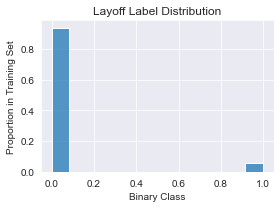

In [ ]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(data=y_train, ax = ax, stat='probability')
plt.title('Layoff Label Distribution')
plt.xlabel('Binary Class')
plt.ylabel('Proportion in Training Set')
plt.tight_layout()
#plt.savefig('figs/layoff.png', dpi=300)

## Logistic Regression

In [ ]:
from sklearn.linear_model import SGDClassifier

#SGDClassifier(loss='log', penalty='elasticnet', max_iter=10000)

In [ ]:
sgd = SGDClassifier(loss='log', penalty='elasticnet', max_iter=10000)
pipeline = Pipeline(steps=[('impute', SimpleImputer()),
                           ('sampling', SMOTE()), 
                           ('normalize', "passthrough"), 
                           ('sgd', sgd)])

params = {'normalize': [MinMaxScaler(), RobustScaler()], 
         'sgd__alpha' : np.arange(0.01, 2.01, 0.01),
         'sgd__l1_ratio': np.arange(0.00, 1.01, 0.01),
         }

In [ ]:
model = RandomizedSearchCV(pipeline, param_distributions= params, n_iter=200, n_jobs=1, verbose=10, scoring='neg_brier_score', cv = 4)

model.fit(X_train, y_train)

joblib_file = "job_logist_200.pkl"
joblib.dump(model, joblib_file)

Fitting 4 folds for each of 200 candidates, totalling 800 fits
[CV 1/4; 1/200] START normalize=RobustScaler(), sgd__alpha=1.3, sgd__l1_ratio=0.47000000000000003
[CV 1/4; 1/200] END normalize=RobustScaler(), sgd__alpha=1.3, sgd__l1_ratio=0.47000000000000003; total time=  15.8s
[CV 2/4; 1/200] START normalize=RobustScaler(), sgd__alpha=1.3, sgd__l1_ratio=0.47000000000000003
[CV 2/4; 1/200] END normalize=RobustScaler(), sgd__alpha=1.3, sgd__l1_ratio=0.47000000000000003; total time=  16.4s
[CV 3/4; 1/200] START normalize=RobustScaler(), sgd__alpha=1.3, sgd__l1_ratio=0.47000000000000003
[CV 3/4; 1/200] END normalize=RobustScaler(), sgd__alpha=1.3, sgd__l1_ratio=0.47000000000000003; total time=  11.5s
[CV 4/4; 1/200] START normalize=RobustScaler(), sgd__alpha=1.3, sgd__l1_ratio=0.47000000000000003
[CV 4/4; 1/200] END normalize=RobustScaler(), sgd__alpha=1.3, sgd__l1_ratio=0.47000000000000003; total time=  12.4s
[CV 1/4; 2/200] START normalize=MinMaxScaler(), sgd__alpha=1.21, sgd__l1_ratio=0.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


[CV 2/4; 124/200] END normalize=RobustScaler(), sgd__alpha=0.9500000000000001, sgd__l1_ratio=0.9500000000000001; total time=29.8min
[CV 3/4; 124/200] START normalize=RobustScaler(), sgd__alpha=0.9500000000000001, sgd__l1_ratio=0.9500000000000001
[CV 3/4; 124/200] END normalize=RobustScaler(), sgd__alpha=0.9500000000000001, sgd__l1_ratio=0.9500000000000001; total time=  14.3s
[CV 4/4; 124/200] START normalize=RobustScaler(), sgd__alpha=0.9500000000000001, sgd__l1_ratio=0.9500000000000001
[CV 4/4; 124/200] END normalize=RobustScaler(), sgd__alpha=0.9500000000000001, sgd__l1_ratio=0.9500000000000001; total time=  19.2s
[CV 1/4; 125/200] START normalize=MinMaxScaler(), sgd__alpha=1.3800000000000001, sgd__l1_ratio=0.21
[CV 1/4; 125/200] END normalize=MinMaxScaler(), sgd__alpha=1.3800000000000001, sgd__l1_ratio=0.21; total time=   4.6s
[CV 2/4; 125/200] START normalize=MinMaxScaler(), sgd__alpha=1.3800000000000001, sgd__l1_ratio=0.21
[CV 2/4; 125/200] END normalize=MinMaxScaler(), sgd__alpha

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


[CV 3/4; 132/200] END normalize=RobustScaler(), sgd__alpha=1.5, sgd__l1_ratio=0.97; total time=29.8min
[CV 4/4; 132/200] START normalize=RobustScaler(), sgd__alpha=1.5, sgd__l1_ratio=0.97
[CV 4/4; 132/200] END normalize=RobustScaler(), sgd__alpha=1.5, sgd__l1_ratio=0.97; total time=  32.4s
[CV 1/4; 133/200] START normalize=MinMaxScaler(), sgd__alpha=0.29000000000000004, sgd__l1_ratio=0.39
[CV 1/4; 133/200] END normalize=MinMaxScaler(), sgd__alpha=0.29000000000000004, sgd__l1_ratio=0.39; total time=   4.3s
[CV 2/4; 133/200] START normalize=MinMaxScaler(), sgd__alpha=0.29000000000000004, sgd__l1_ratio=0.39
[CV 2/4; 133/200] END normalize=MinMaxScaler(), sgd__alpha=0.29000000000000004, sgd__l1_ratio=0.39; total time=   4.1s
[CV 3/4; 133/200] START normalize=MinMaxScaler(), sgd__alpha=0.29000000000000004, sgd__l1_ratio=0.39
[CV 3/4; 133/200] END normalize=MinMaxScaler(), sgd__alpha=0.29000000000000004, sgd__l1_ratio=0.39; total time=   4.1s
[CV 4/4; 133/200] START normalize=MinMaxScaler(),

['job_logist_200.pkl']

### Find Threshold

In [ ]:
sgd = SGDClassifier(loss='log', penalty='elasticnet', max_iter=10000, alpha=0.03, l1_ratio=0.0)
pipeline = Pipeline(steps=[('impute', SimpleImputer()),
                           ('sampling', SMOTE()),
                           ('normalize', StandardScaler()), 
                           ('sgd', sgd)])


In [ ]:
logistic = pipeline.fit(X_train, y_train)

#### Find Optimal Threshold w/ Cross-val set

In [ ]:
variable = 'eviction'
X_CV = background.loc[X_CV.index]
y_CV= y_CV[variable].dropna()


KeyError: 'eviction'

In [ ]:
X_CV = X_CV.loc[y_CV.index.values]

In [ ]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot

In [ ]:
evic_elastic_pred = logistic.predict_proba(X_CV)[:, 1]

In [ ]:
fpr, tpr, thresholds = roc_curve(y_CV, evic_elastic_pred)

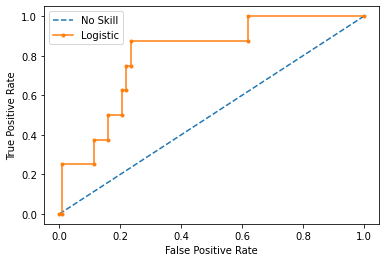

In [ ]:
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.002104, G-Mean=0.818


## Random Forest (SMOTE Upsampling)

In [ ]:
rfc = RandomForestClassifier(random_state=0)



In [ ]:
pipeline = Pipeline(steps=[('impute', SimpleImputer()),
                           ('sampling', SMOTE()), 
                           ('normalize', "passthrough"), 
                           ('randomforest', rfc)])

In [ ]:
max_features = ['auto']
n_estimators = np.arange(120, 251, 1)
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

In [ ]:
params={'randomforest__n_estimators': n_estimators, 
        'randomforest__max_depth': max_depth, 
       'randomforest__max_features': max_features,
       'randomforest__min_samples_split': min_samples_split,
        'randomforest__min_samples_leaf': min_samples_leaf,
       'normalize': [MinMaxScaler()]}

model = RandomizedSearchCV(pipeline, param_distributions= params, n_iter=200, n_jobs=1, verbose=10, scoring='neg_brier_score', cv = 4)

model.fit(X_train, y_train)

joblib_file = "minmax_eviction_rf_200_.pkl"
joblib.dump(model, joblib_file)

In [ ]:
model = joblib.load('models/evic_rf_200.pkl')

#### Find Optimal Threshold w/ Cross-val set

In [ ]:
rfc = RandomForestClassifier(random_state=0,
                            n_estimators=234,
                            min_samples_split=5, 
                            min_samples_leaf= 1, 
                            max_features = 'auto',
                            max_depth = 25, 
                            )



In [ ]:
pipeline = Pipeline(steps=[('impute', SimpleImputer()),
                           ('sampling', SMOTE()), 
                           ('normalize', StandardScaler()), 
                           ('randomforest', rfc)])

In [ ]:
random_forest = pipeline.fit(X_train, y_train)

In [ ]:
variable = 'eviction'
X_CV = background.loc[X_CV.index]
y_CV= y_CV[variable].dropna()

In [ ]:
X_CV = X_CV.loc[y_CV.index.values]

In [ ]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot

In [ ]:
evic_elastic_pred = random_forest.predict_proba(X_CV)[:, 1]

In [ ]:
fpr, tpr, thresholds = roc_curve(y_CV, evic_elastic_pred)

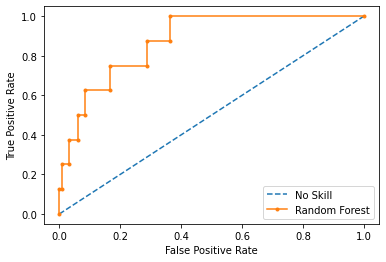

In [ ]:
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Random Forest')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.110185, G-Mean=0.798


## XGBoost (SMOTE Upsampling)

In [ ]:
y_train.value_counts()

0.0    1240
1.0      79
Name: eviction, dtype: int64

In [ ]:
import joblib

In [ ]:
X_train, X_CV, y_train, y_CV = train_test_split(background.loc[train.index] , train, test_size=0.10, random_state=42)

variable = 'eviction'

# Let's drop instances where the response is NA
y_train = y_train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

X_train = X_train.apply(pd.to_numeric, errors='coerce', axis=1)

y_train = y_train.apply(pd.to_numeric, errors='coerce')

xg_reg = xgb.XGBClassifier(objective ='binary:logistic', scale_pos_weight=15)

pipeline = Pipeline(steps=[('impute', SimpleImputer()),
                           ('normalize', MinMaxScaler()), 
                           ('feat_select', SelectKBest(f_classif)),
                           ('xgboost', xg_reg)])



n_estimators = np.arange(100, 300, 10)
max_depth = np.arange(3, 12, 1)
min_child_weight = np.arange(1, 8, 1)
gamma = np.arange(0.00, 2, 0.01),
learning_rate = np.arange(0.01,0.3,0.0005)
subsample = np.arange(0.2, 0.8, 0.1)
colsample_bylevel = np.round(np.arange(0.1,1.0,0.01))
colsample_bytree = np.arange(0.3, 1, 0.1)
alpha = np.arange(0, 1, 0.1)

params={'xgboost__n_estimators': n_estimators, 
        'xgboost__max_depth': max_depth, 
        'xgboost__min_child_weight': min_child_weight,
       'xgboost__gamma': np.arange(0.00, 2, 0.01),
       'xgboost__learning_rate': learning_rate,
        'xgboost__subsample': subsample,
       'xgboost__colsample_bylevel': colsample_bylevel,
       'xgboost__colsample_bytree': colsample_bytree,
       'feat_select__k': np.arange(10, 15000, 100),
       "impute__strategy": ['mean', 'median']}


            
            
model = RandomizedSearchCV(pipeline, param_distributions= params, n_iter=200, n_jobs=1, verbose=10, scoring='neg_brier_score', cv = 4)

model.fit(X_train, y_train)

joblib_file = "xgb_evic_weight_200.pkl"
#
joblib.dump(model, joblib_file)

Fitting 4 folds for each of 200 candidates, totalling 800 fits
[CV 1/4; 1/200] START feat_select__k=9610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.6, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:23:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 1/200] END feat_select__k=9610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.6, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001; total time=  13.5s
[CV 2/4; 1/200] START feat_select__k=9610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.6, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:23:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 1/200] END feat_select__k=9610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.6, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001; total time=  14.9s
[CV 3/4; 1/200] START feat_select__k=9610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.6, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:23:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 1/200] END feat_select__k=9610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.6, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001; total time=   9.1s
[CV 4/4; 1/200] START feat_select__k=9610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.6, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:23:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 1/200] END feat_select__k=9610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.6, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001; total time=  16.0s
[CV 1/4; 2/200] START feat_select__k=10010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.14, xgboost__learning_rate=0.17750000000000016, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=150, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:24:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 2/200] END feat_select__k=10010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.14, xgboost__learning_rate=0.17750000000000016, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=150, xgboost__subsample=0.2; total time=  10.5s
[CV 2/4; 2/200] START feat_select__k=10010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.14, xgboost__learning_rate=0.17750000000000016, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=150, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:24:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 2/200] END feat_select__k=10010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.14, xgboost__learning_rate=0.17750000000000016, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=150, xgboost__subsample=0.2; total time=   8.7s
[CV 3/4; 2/200] START feat_select__k=10010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.14, xgboost__learning_rate=0.17750000000000016, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=150, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:24:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 2/200] END feat_select__k=10010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.14, xgboost__learning_rate=0.17750000000000016, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=150, xgboost__subsample=0.2; total time=  12.3s
[CV 4/4; 2/200] START feat_select__k=10010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.14, xgboost__learning_rate=0.17750000000000016, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=150, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:24:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 2/200] END feat_select__k=10010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.14, xgboost__learning_rate=0.17750000000000016, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=150, xgboost__subsample=0.2; total time=  10.8s
[CV 1/4; 3/200] START feat_select__k=5210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.75, xgboost__learning_rate=0.17550000000000016, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=150, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:24:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 3/200] END feat_select__k=5210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.75, xgboost__learning_rate=0.17550000000000016, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=150, xgboost__subsample=0.4000000000000001; total time=   5.6s
[CV 2/4; 3/200] START feat_select__k=5210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.75, xgboost__learning_rate=0.17550000000000016, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=150, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:25:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 3/200] END feat_select__k=5210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.75, xgboost__learning_rate=0.17550000000000016, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=150, xgboost__subsample=0.4000000000000001; total time=   6.0s
[CV 3/4; 3/200] START feat_select__k=5210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.75, xgboost__learning_rate=0.17550000000000016, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=150, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:25:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 3/200] END feat_select__k=5210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.75, xgboost__learning_rate=0.17550000000000016, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=150, xgboost__subsample=0.4000000000000001; total time=   5.8s
[CV 4/4; 3/200] START feat_select__k=5210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.75, xgboost__learning_rate=0.17550000000000016, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=150, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:25:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 3/200] END feat_select__k=5210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.75, xgboost__learning_rate=0.17550000000000016, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=150, xgboost__subsample=0.4000000000000001; total time=   5.2s
[CV 1/4; 4/200] START feat_select__k=7210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.81, xgboost__learning_rate=0.035500000000000025, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:25:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 4/200] END feat_select__k=7210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.81, xgboost__learning_rate=0.035500000000000025, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001; total time=   7.2s
[CV 2/4; 4/200] START feat_select__k=7210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.81, xgboost__learning_rate=0.035500000000000025, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:25:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 4/200] END feat_select__k=7210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.81, xgboost__learning_rate=0.035500000000000025, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001; total time=   8.3s
[CV 3/4; 4/200] START feat_select__k=7210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.81, xgboost__learning_rate=0.035500000000000025, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:25:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 4/200] END feat_select__k=7210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.81, xgboost__learning_rate=0.035500000000000025, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001; total time=   6.9s
[CV 4/4; 4/200] START feat_select__k=7210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.81, xgboost__learning_rate=0.035500000000000025, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:25:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 4/200] END feat_select__k=7210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.81, xgboost__learning_rate=0.035500000000000025, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001; total time=   6.5s
[CV 1/4; 5/200] START feat_select__k=3510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.6, xgboost__learning_rate=0.2305000000000002, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:25:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 5/200] END feat_select__k=3510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.6, xgboost__learning_rate=0.2305000000000002, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001; total time=   8.3s
[CV 2/4; 5/200] START feat_select__k=3510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.6, xgboost__learning_rate=0.2305000000000002, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:25:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 5/200] END feat_select__k=3510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.6, xgboost__learning_rate=0.2305000000000002, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001; total time=   6.6s
[CV 3/4; 5/200] START feat_select__k=3510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.6, xgboost__learning_rate=0.2305000000000002, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:25:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 5/200] END feat_select__k=3510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.6, xgboost__learning_rate=0.2305000000000002, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001; total time=   8.1s
[CV 4/4; 5/200] START feat_select__k=3510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.6, xgboost__learning_rate=0.2305000000000002, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:26:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 5/200] END feat_select__k=3510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.6, xgboost__learning_rate=0.2305000000000002, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001; total time=   6.7s
[CV 1/4; 6/200] START feat_select__k=14410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.2, xgboost__learning_rate=0.060000000000000046, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=170, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:26:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 6/200] END feat_select__k=14410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.2, xgboost__learning_rate=0.060000000000000046, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=170, xgboost__subsample=0.6000000000000001; total time=  10.3s
[CV 2/4; 6/200] START feat_select__k=14410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.2, xgboost__learning_rate=0.060000000000000046, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=170, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:26:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 6/200] END feat_select__k=14410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.2, xgboost__learning_rate=0.060000000000000046, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=170, xgboost__subsample=0.6000000000000001; total time=   7.4s
[CV 3/4; 6/200] START feat_select__k=14410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.2, xgboost__learning_rate=0.060000000000000046, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=170, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:26:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 6/200] END feat_select__k=14410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.2, xgboost__learning_rate=0.060000000000000046, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=170, xgboost__subsample=0.6000000000000001; total time=  10.6s
[CV 4/4; 6/200] START feat_select__k=14410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.2, xgboost__learning_rate=0.060000000000000046, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=170, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:26:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 6/200] END feat_select__k=14410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.2, xgboost__learning_rate=0.060000000000000046, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=170, xgboost__subsample=0.6000000000000001; total time=   7.1s
[CV 1/4; 7/200] START feat_select__k=7910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.52, xgboost__learning_rate=0.07550000000000005, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:26:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 7/200] END feat_select__k=7910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.52, xgboost__learning_rate=0.07550000000000005, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001; total time=   4.6s
[CV 2/4; 7/200] START feat_select__k=7910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.52, xgboost__learning_rate=0.07550000000000005, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:26:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 7/200] END feat_select__k=7910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.52, xgboost__learning_rate=0.07550000000000005, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001; total time=   3.9s
[CV 3/4; 7/200] START feat_select__k=7910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.52, xgboost__learning_rate=0.07550000000000005, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:26:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 7/200] END feat_select__k=7910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.52, xgboost__learning_rate=0.07550000000000005, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001; total time=   4.2s
[CV 4/4; 7/200] START feat_select__k=7910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.52, xgboost__learning_rate=0.07550000000000005, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:27:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 7/200] END feat_select__k=7910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.52, xgboost__learning_rate=0.07550000000000005, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001; total time=   4.4s
[CV 1/4; 8/200] START feat_select__k=4310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.25, xgboost__learning_rate=0.17750000000000016, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:27:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 8/200] END feat_select__k=4310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.25, xgboost__learning_rate=0.17750000000000016, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004; total time=   8.5s
[CV 2/4; 8/200] START feat_select__k=4310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.25, xgboost__learning_rate=0.17750000000000016, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:27:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 8/200] END feat_select__k=4310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.25, xgboost__learning_rate=0.17750000000000016, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004; total time=   8.9s
[CV 3/4; 8/200] START feat_select__k=4310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.25, xgboost__learning_rate=0.17750000000000016, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:27:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 8/200] END feat_select__k=4310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.25, xgboost__learning_rate=0.17750000000000016, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004; total time=   8.3s
[CV 4/4; 8/200] START feat_select__k=4310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.25, xgboost__learning_rate=0.17750000000000016, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:27:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 8/200] END feat_select__k=4310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.25, xgboost__learning_rate=0.17750000000000016, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004; total time=  13.8s
[CV 1/4; 9/200] START feat_select__k=11110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.02, xgboost__learning_rate=0.10350000000000008, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:27:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 9/200] END feat_select__k=11110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.02, xgboost__learning_rate=0.10350000000000008, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.4000000000000001; total time=   8.2s
[CV 2/4; 9/200] START feat_select__k=11110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.02, xgboost__learning_rate=0.10350000000000008, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:27:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 9/200] END feat_select__k=11110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.02, xgboost__learning_rate=0.10350000000000008, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.4000000000000001; total time=   9.8s
[CV 3/4; 9/200] START feat_select__k=11110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.02, xgboost__learning_rate=0.10350000000000008, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:28:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 9/200] END feat_select__k=11110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.02, xgboost__learning_rate=0.10350000000000008, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.4000000000000001; total time=   8.8s
[CV 4/4; 9/200] START feat_select__k=11110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.02, xgboost__learning_rate=0.10350000000000008, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:28:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 9/200] END feat_select__k=11110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.02, xgboost__learning_rate=0.10350000000000008, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.4000000000000001; total time=   9.0s
[CV 1/4; 10/200] START feat_select__k=1910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.35, xgboost__learning_rate=0.14900000000000013, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=200, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:28:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 10/200] END feat_select__k=1910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.35, xgboost__learning_rate=0.14900000000000013, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=200, xgboost__subsample=0.30000000000000004; total time=   3.1s
[CV 2/4; 10/200] START feat_select__k=1910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.35, xgboost__learning_rate=0.14900000000000013, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=200, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:28:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 10/200] END feat_select__k=1910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.35, xgboost__learning_rate=0.14900000000000013, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=200, xgboost__subsample=0.30000000000000004; total time=   6.3s
[CV 3/4; 10/200] START feat_select__k=1910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.35, xgboost__learning_rate=0.14900000000000013, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=200, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:28:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 10/200] END feat_select__k=1910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.35, xgboost__learning_rate=0.14900000000000013, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=200, xgboost__subsample=0.30000000000000004; total time=   5.8s
[CV 4/4; 10/200] START feat_select__k=1910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.35, xgboost__learning_rate=0.14900000000000013, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=200, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:28:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 10/200] END feat_select__k=1910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.35, xgboost__learning_rate=0.14900000000000013, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=200, xgboost__subsample=0.30000000000000004; total time=   4.8s
[CV 1/4; 11/200] START feat_select__k=1810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.93, xgboost__learning_rate=0.05350000000000004, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=140, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:28:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 11/200] END feat_select__k=1810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.93, xgboost__learning_rate=0.05350000000000004, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=140, xgboost__subsample=0.30000000000000004; total time=   4.7s
[CV 2/4; 11/200] START feat_select__k=1810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.93, xgboost__learning_rate=0.05350000000000004, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=140, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:28:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 11/200] END feat_select__k=1810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.93, xgboost__learning_rate=0.05350000000000004, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=140, xgboost__subsample=0.30000000000000004; total time=   4.4s
[CV 3/4; 11/200] START feat_select__k=1810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.93, xgboost__learning_rate=0.05350000000000004, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=140, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:28:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 11/200] END feat_select__k=1810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.93, xgboost__learning_rate=0.05350000000000004, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=140, xgboost__subsample=0.30000000000000004; total time=   3.8s
[CV 4/4; 11/200] START feat_select__k=1810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.93, xgboost__learning_rate=0.05350000000000004, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=140, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:28:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 11/200] END feat_select__k=1810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.93, xgboost__learning_rate=0.05350000000000004, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=140, xgboost__subsample=0.30000000000000004; total time=   3.9s
[CV 1/4; 12/200] START feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.3, xgboost__learning_rate=0.08950000000000007, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=270, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:28:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 12/200] END feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.3, xgboost__learning_rate=0.08950000000000007, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=270, xgboost__subsample=0.7000000000000002; total time=  10.3s
[CV 2/4; 12/200] START feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.3, xgboost__learning_rate=0.08950000000000007, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=270, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:29:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 12/200] END feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.3, xgboost__learning_rate=0.08950000000000007, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=270, xgboost__subsample=0.7000000000000002; total time=  11.1s
[CV 3/4; 12/200] START feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.3, xgboost__learning_rate=0.08950000000000007, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=270, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:29:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 12/200] END feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.3, xgboost__learning_rate=0.08950000000000007, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=270, xgboost__subsample=0.7000000000000002; total time=   8.0s
[CV 4/4; 12/200] START feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.3, xgboost__learning_rate=0.08950000000000007, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=270, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:29:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 12/200] END feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.3, xgboost__learning_rate=0.08950000000000007, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=270, xgboost__subsample=0.7000000000000002; total time=  11.0s
[CV 1/4; 13/200] START feat_select__k=2210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.49, xgboost__learning_rate=0.10200000000000008, xgboost__max_depth=10, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:29:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 13/200] END feat_select__k=2210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.49, xgboost__learning_rate=0.10200000000000008, xgboost__max_depth=10, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.30000000000000004; total time=   6.8s
[CV 2/4; 13/200] START feat_select__k=2210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.49, xgboost__learning_rate=0.10200000000000008, xgboost__max_depth=10, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:29:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 13/200] END feat_select__k=2210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.49, xgboost__learning_rate=0.10200000000000008, xgboost__max_depth=10, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.30000000000000004; total time=   7.1s
[CV 3/4; 13/200] START feat_select__k=2210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.49, xgboost__learning_rate=0.10200000000000008, xgboost__max_depth=10, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:29:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 13/200] END feat_select__k=2210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.49, xgboost__learning_rate=0.10200000000000008, xgboost__max_depth=10, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.30000000000000004; total time=   7.1s
[CV 4/4; 13/200] START feat_select__k=2210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.49, xgboost__learning_rate=0.10200000000000008, xgboost__max_depth=10, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:30:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 13/200] END feat_select__k=2210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.49, xgboost__learning_rate=0.10200000000000008, xgboost__max_depth=10, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.30000000000000004; total time=   6.4s
[CV 1/4; 14/200] START feat_select__k=7010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.98, xgboost__learning_rate=0.2120000000000002, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=280, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:30:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 14/200] END feat_select__k=7010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.98, xgboost__learning_rate=0.2120000000000002, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=280, xgboost__subsample=0.6000000000000001; total time=   9.0s
[CV 2/4; 14/200] START feat_select__k=7010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.98, xgboost__learning_rate=0.2120000000000002, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=280, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:30:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 14/200] END feat_select__k=7010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.98, xgboost__learning_rate=0.2120000000000002, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=280, xgboost__subsample=0.6000000000000001; total time=   8.0s
[CV 3/4; 14/200] START feat_select__k=7010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.98, xgboost__learning_rate=0.2120000000000002, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=280, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:30:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 14/200] END feat_select__k=7010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.98, xgboost__learning_rate=0.2120000000000002, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=280, xgboost__subsample=0.6000000000000001; total time=   7.9s
[CV 4/4; 14/200] START feat_select__k=7010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.98, xgboost__learning_rate=0.2120000000000002, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=280, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:30:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 14/200] END feat_select__k=7010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.98, xgboost__learning_rate=0.2120000000000002, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=280, xgboost__subsample=0.6000000000000001; total time=   8.0s
[CV 1/4; 15/200] START feat_select__k=810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.96, xgboost__learning_rate=0.14250000000000013, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:30:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 15/200] END feat_select__k=810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.96, xgboost__learning_rate=0.14250000000000013, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003; total time=   4.6s
[CV 2/4; 15/200] START feat_select__k=810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.96, xgboost__learning_rate=0.14250000000000013, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:30:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 15/200] END feat_select__k=810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.96, xgboost__learning_rate=0.14250000000000013, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003; total time=   4.9s
[CV 3/4; 15/200] START feat_select__k=810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.96, xgboost__learning_rate=0.14250000000000013, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:30:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 15/200] END feat_select__k=810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.96, xgboost__learning_rate=0.14250000000000013, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003; total time=   2.8s
[CV 4/4; 15/200] START feat_select__k=810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.96, xgboost__learning_rate=0.14250000000000013, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:30:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 15/200] END feat_select__k=810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.96, xgboost__learning_rate=0.14250000000000013, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003; total time=   4.4s
[CV 1/4; 16/200] START feat_select__k=410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.56, xgboost__learning_rate=0.16250000000000014, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=150, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:30:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 16/200] END feat_select__k=410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.56, xgboost__learning_rate=0.16250000000000014, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=150, xgboost__subsample=0.8000000000000003; total time=   3.5s
[CV 2/4; 16/200] START feat_select__k=410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.56, xgboost__learning_rate=0.16250000000000014, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=150, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:31:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 16/200] END feat_select__k=410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.56, xgboost__learning_rate=0.16250000000000014, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=150, xgboost__subsample=0.8000000000000003; total time=   3.2s
[CV 3/4; 16/200] START feat_select__k=410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.56, xgboost__learning_rate=0.16250000000000014, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=150, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:31:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 16/200] END feat_select__k=410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.56, xgboost__learning_rate=0.16250000000000014, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=150, xgboost__subsample=0.8000000000000003; total time=   2.3s
[CV 4/4; 16/200] START feat_select__k=410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.56, xgboost__learning_rate=0.16250000000000014, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=150, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:31:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 16/200] END feat_select__k=410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.56, xgboost__learning_rate=0.16250000000000014, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=150, xgboost__subsample=0.8000000000000003; total time=   3.1s
[CV 1/4; 17/200] START feat_select__k=1510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.4, xgboost__learning_rate=0.2320000000000002, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:31:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 17/200] END feat_select__k=1510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.4, xgboost__learning_rate=0.2320000000000002, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.5000000000000001; total time=   8.5s
[CV 2/4; 17/200] START feat_select__k=1510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.4, xgboost__learning_rate=0.2320000000000002, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:31:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 17/200] END feat_select__k=1510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.4, xgboost__learning_rate=0.2320000000000002, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.5000000000000001; total time=   8.9s
[CV 3/4; 17/200] START feat_select__k=1510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.4, xgboost__learning_rate=0.2320000000000002, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:31:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 17/200] END feat_select__k=1510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.4, xgboost__learning_rate=0.2320000000000002, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.5000000000000001; total time=   5.9s
[CV 4/4; 17/200] START feat_select__k=1510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.4, xgboost__learning_rate=0.2320000000000002, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:31:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 17/200] END feat_select__k=1510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.4, xgboost__learning_rate=0.2320000000000002, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.5000000000000001; total time=  10.1s
[CV 1/4; 18/200] START feat_select__k=9610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.6, xgboost__learning_rate=0.02900000000000002, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=290, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:31:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 18/200] END feat_select__k=9610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.6, xgboost__learning_rate=0.02900000000000002, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=290, xgboost__subsample=0.8000000000000003; total time=   8.8s
[CV 2/4; 18/200] START feat_select__k=9610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.6, xgboost__learning_rate=0.02900000000000002, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=290, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:31:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 18/200] END feat_select__k=9610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.6, xgboost__learning_rate=0.02900000000000002, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=290, xgboost__subsample=0.8000000000000003; total time=  12.3s
[CV 3/4; 18/200] START feat_select__k=9610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.6, xgboost__learning_rate=0.02900000000000002, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=290, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:32:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 18/200] END feat_select__k=9610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.6, xgboost__learning_rate=0.02900000000000002, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=290, xgboost__subsample=0.8000000000000003; total time=   8.6s
[CV 4/4; 18/200] START feat_select__k=9610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.6, xgboost__learning_rate=0.02900000000000002, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=290, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:32:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 18/200] END feat_select__k=9610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.6, xgboost__learning_rate=0.02900000000000002, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=290, xgboost__subsample=0.8000000000000003; total time=  10.4s
[CV 1/4; 19/200] START feat_select__k=610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.34, xgboost__learning_rate=0.10100000000000008, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=200, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:32:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 19/200] END feat_select__k=610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.34, xgboost__learning_rate=0.10100000000000008, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=200, xgboost__subsample=0.30000000000000004; total time=   3.1s
[CV 2/4; 19/200] START feat_select__k=610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.34, xgboost__learning_rate=0.10100000000000008, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=200, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:32:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 19/200] END feat_select__k=610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.34, xgboost__learning_rate=0.10100000000000008, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=200, xgboost__subsample=0.30000000000000004; total time=   7.6s
[CV 3/4; 19/200] START feat_select__k=610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.34, xgboost__learning_rate=0.10100000000000008, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=200, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:32:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 19/200] END feat_select__k=610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.34, xgboost__learning_rate=0.10100000000000008, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=200, xgboost__subsample=0.30000000000000004; total time=   3.6s
[CV 4/4; 19/200] START feat_select__k=610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.34, xgboost__learning_rate=0.10100000000000008, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=200, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:32:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 19/200] END feat_select__k=610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.34, xgboost__learning_rate=0.10100000000000008, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=200, xgboost__subsample=0.30000000000000004; total time=   2.8s
[CV 1/4; 20/200] START feat_select__k=9910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.95, xgboost__learning_rate=0.27000000000000024, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=120, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:32:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 20/200] END feat_select__k=9910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.95, xgboost__learning_rate=0.27000000000000024, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=120, xgboost__subsample=0.2; total time=   3.7s
[CV 2/4; 20/200] START feat_select__k=9910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.95, xgboost__learning_rate=0.27000000000000024, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=120, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:32:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 20/200] END feat_select__k=9910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.95, xgboost__learning_rate=0.27000000000000024, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=120, xgboost__subsample=0.2; total time=   3.8s
[CV 3/4; 20/200] START feat_select__k=9910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.95, xgboost__learning_rate=0.27000000000000024, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=120, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:32:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 20/200] END feat_select__k=9910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.95, xgboost__learning_rate=0.27000000000000024, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=120, xgboost__subsample=0.2; total time=   3.2s
[CV 4/4; 20/200] START feat_select__k=9910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.95, xgboost__learning_rate=0.27000000000000024, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=120, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:32:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 20/200] END feat_select__k=9910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.95, xgboost__learning_rate=0.27000000000000024, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=120, xgboost__subsample=0.2; total time=   3.4s
[CV 1/4; 21/200] START feat_select__k=110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.53, xgboost__learning_rate=0.20400000000000018, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:32:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 21/200] END feat_select__k=110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.53, xgboost__learning_rate=0.20400000000000018, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.8000000000000003; total time=   5.9s
[CV 2/4; 21/200] START feat_select__k=110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.53, xgboost__learning_rate=0.20400000000000018, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:33:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 21/200] END feat_select__k=110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.53, xgboost__learning_rate=0.20400000000000018, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.8000000000000003; total time=   3.5s
[CV 3/4; 21/200] START feat_select__k=110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.53, xgboost__learning_rate=0.20400000000000018, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:33:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 21/200] END feat_select__k=110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.53, xgboost__learning_rate=0.20400000000000018, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.8000000000000003; total time=   5.8s
[CV 4/4; 21/200] START feat_select__k=110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.53, xgboost__learning_rate=0.20400000000000018, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:33:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 21/200] END feat_select__k=110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.53, xgboost__learning_rate=0.20400000000000018, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.8000000000000003; total time=   4.5s
[CV 1/4; 22/200] START feat_select__k=9210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.95, xgboost__learning_rate=0.0105, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:33:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 22/200] END feat_select__k=9210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.95, xgboost__learning_rate=0.0105, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001; total time=  20.4s
[CV 2/4; 22/200] START feat_select__k=9210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.95, xgboost__learning_rate=0.0105, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:33:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 22/200] END feat_select__k=9210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.95, xgboost__learning_rate=0.0105, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001; total time=  20.5s
[CV 3/4; 22/200] START feat_select__k=9210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.95, xgboost__learning_rate=0.0105, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:33:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 22/200] END feat_select__k=9210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.95, xgboost__learning_rate=0.0105, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001; total time=  18.8s
[CV 4/4; 22/200] START feat_select__k=9210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.95, xgboost__learning_rate=0.0105, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:34:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 22/200] END feat_select__k=9210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.95, xgboost__learning_rate=0.0105, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001; total time=  19.2s
[CV 1/4; 23/200] START feat_select__k=1710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.73, xgboost__learning_rate=0.09950000000000007, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:34:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 23/200] END feat_select__k=1710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.73, xgboost__learning_rate=0.09950000000000007, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.8000000000000003; total time=   6.4s
[CV 2/4; 23/200] START feat_select__k=1710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.73, xgboost__learning_rate=0.09950000000000007, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:34:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 23/200] END feat_select__k=1710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.73, xgboost__learning_rate=0.09950000000000007, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.8000000000000003; total time=   7.1s
[CV 3/4; 23/200] START feat_select__k=1710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.73, xgboost__learning_rate=0.09950000000000007, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:34:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 23/200] END feat_select__k=1710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.73, xgboost__learning_rate=0.09950000000000007, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.8000000000000003; total time=   8.7s
[CV 4/4; 23/200] START feat_select__k=1710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.73, xgboost__learning_rate=0.09950000000000007, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:34:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 23/200] END feat_select__k=1710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.73, xgboost__learning_rate=0.09950000000000007, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.8000000000000003; total time=  11.0s
[CV 1/4; 24/200] START feat_select__k=13110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.02, xgboost__learning_rate=0.15000000000000013, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:35:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 24/200] END feat_select__k=13110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.02, xgboost__learning_rate=0.15000000000000013, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003; total time=  34.3s
[CV 2/4; 24/200] START feat_select__k=13110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.02, xgboost__learning_rate=0.15000000000000013, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:35:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 24/200] END feat_select__k=13110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.02, xgboost__learning_rate=0.15000000000000013, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003; total time=  33.4s
[CV 3/4; 24/200] START feat_select__k=13110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.02, xgboost__learning_rate=0.15000000000000013, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:36:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 24/200] END feat_select__k=13110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.02, xgboost__learning_rate=0.15000000000000013, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003; total time=  34.4s
[CV 4/4; 24/200] START feat_select__k=13110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.02, xgboost__learning_rate=0.15000000000000013, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:36:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 24/200] END feat_select__k=13110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.02, xgboost__learning_rate=0.15000000000000013, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003; total time=  34.1s
[CV 1/4; 25/200] START feat_select__k=5110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.6, xgboost__learning_rate=0.19250000000000017, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=220, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:37:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 25/200] END feat_select__k=5110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.6, xgboost__learning_rate=0.19250000000000017, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=220, xgboost__subsample=0.8000000000000003; total time=  11.6s
[CV 2/4; 25/200] START feat_select__k=5110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.6, xgboost__learning_rate=0.19250000000000017, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=220, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:37:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 25/200] END feat_select__k=5110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.6, xgboost__learning_rate=0.19250000000000017, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=220, xgboost__subsample=0.8000000000000003; total time=  10.6s
[CV 3/4; 25/200] START feat_select__k=5110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.6, xgboost__learning_rate=0.19250000000000017, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=220, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:37:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 25/200] END feat_select__k=5110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.6, xgboost__learning_rate=0.19250000000000017, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=220, xgboost__subsample=0.8000000000000003; total time=  11.2s
[CV 4/4; 25/200] START feat_select__k=5110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.6, xgboost__learning_rate=0.19250000000000017, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=220, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:37:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 25/200] END feat_select__k=5110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.6, xgboost__learning_rate=0.19250000000000017, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=220, xgboost__subsample=0.8000000000000003; total time=  11.8s
[CV 1/4; 26/200] START feat_select__k=13810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.47, xgboost__learning_rate=0.046000000000000034, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=150, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:38:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 26/200] END feat_select__k=13810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.47, xgboost__learning_rate=0.046000000000000034, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=150, xgboost__subsample=0.4000000000000001; total time=   7.7s
[CV 2/4; 26/200] START feat_select__k=13810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.47, xgboost__learning_rate=0.046000000000000034, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=150, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:38:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 26/200] END feat_select__k=13810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.47, xgboost__learning_rate=0.046000000000000034, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=150, xgboost__subsample=0.4000000000000001; total time=   7.5s
[CV 3/4; 26/200] START feat_select__k=13810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.47, xgboost__learning_rate=0.046000000000000034, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=150, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:38:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 26/200] END feat_select__k=13810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.47, xgboost__learning_rate=0.046000000000000034, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=150, xgboost__subsample=0.4000000000000001; total time=   4.9s
[CV 4/4; 26/200] START feat_select__k=13810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.47, xgboost__learning_rate=0.046000000000000034, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=150, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:38:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 26/200] END feat_select__k=13810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.47, xgboost__learning_rate=0.046000000000000034, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=150, xgboost__subsample=0.4000000000000001; total time=   4.8s
[CV 1/4; 27/200] START feat_select__k=310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.48, xgboost__learning_rate=0.057000000000000044, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=140, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:38:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 27/200] END feat_select__k=310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.48, xgboost__learning_rate=0.057000000000000044, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=140, xgboost__subsample=0.5000000000000001; total time=   4.1s
[CV 2/4; 27/200] START feat_select__k=310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.48, xgboost__learning_rate=0.057000000000000044, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=140, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:38:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 27/200] END feat_select__k=310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.48, xgboost__learning_rate=0.057000000000000044, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=140, xgboost__subsample=0.5000000000000001; total time=   3.1s
[CV 3/4; 27/200] START feat_select__k=310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.48, xgboost__learning_rate=0.057000000000000044, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=140, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:38:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 27/200] END feat_select__k=310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.48, xgboost__learning_rate=0.057000000000000044, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=140, xgboost__subsample=0.5000000000000001; total time=   3.4s
[CV 4/4; 27/200] START feat_select__k=310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.48, xgboost__learning_rate=0.057000000000000044, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=140, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:38:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 27/200] END feat_select__k=310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.48, xgboost__learning_rate=0.057000000000000044, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=140, xgboost__subsample=0.5000000000000001; total time=   3.3s
[CV 1/4; 28/200] START feat_select__k=12110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.71, xgboost__learning_rate=0.13350000000000012, xgboost__max_depth=10, xgboost__min_child_weight=2, xgboost__n_estimators=180, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:38:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 28/200] END feat_select__k=12110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.71, xgboost__learning_rate=0.13350000000000012, xgboost__max_depth=10, xgboost__min_child_weight=2, xgboost__n_estimators=180, xgboost__subsample=0.2; total time=   5.5s
[CV 2/4; 28/200] START feat_select__k=12110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.71, xgboost__learning_rate=0.13350000000000012, xgboost__max_depth=10, xgboost__min_child_weight=2, xgboost__n_estimators=180, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:38:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 28/200] END feat_select__k=12110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.71, xgboost__learning_rate=0.13350000000000012, xgboost__max_depth=10, xgboost__min_child_weight=2, xgboost__n_estimators=180, xgboost__subsample=0.2; total time=   5.3s
[CV 3/4; 28/200] START feat_select__k=12110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.71, xgboost__learning_rate=0.13350000000000012, xgboost__max_depth=10, xgboost__min_child_weight=2, xgboost__n_estimators=180, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:38:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 28/200] END feat_select__k=12110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.71, xgboost__learning_rate=0.13350000000000012, xgboost__max_depth=10, xgboost__min_child_weight=2, xgboost__n_estimators=180, xgboost__subsample=0.2; total time=   4.7s
[CV 4/4; 28/200] START feat_select__k=12110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.71, xgboost__learning_rate=0.13350000000000012, xgboost__max_depth=10, xgboost__min_child_weight=2, xgboost__n_estimators=180, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:39:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 28/200] END feat_select__k=12110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.71, xgboost__learning_rate=0.13350000000000012, xgboost__max_depth=10, xgboost__min_child_weight=2, xgboost__n_estimators=180, xgboost__subsample=0.2; total time=   7.5s
[CV 1/4; 29/200] START feat_select__k=9110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.53, xgboost__learning_rate=0.18500000000000016, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:39:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 29/200] END feat_select__k=9110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.53, xgboost__learning_rate=0.18500000000000016, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001; total time=  11.4s
[CV 2/4; 29/200] START feat_select__k=9110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.53, xgboost__learning_rate=0.18500000000000016, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:39:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 29/200] END feat_select__k=9110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.53, xgboost__learning_rate=0.18500000000000016, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001; total time=  11.0s
[CV 3/4; 29/200] START feat_select__k=9110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.53, xgboost__learning_rate=0.18500000000000016, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:39:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 29/200] END feat_select__k=9110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.53, xgboost__learning_rate=0.18500000000000016, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001; total time=   9.9s
[CV 4/4; 29/200] START feat_select__k=9110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.53, xgboost__learning_rate=0.18500000000000016, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:39:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 29/200] END feat_select__k=9110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.53, xgboost__learning_rate=0.18500000000000016, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001; total time=  11.0s
[CV 1/4; 30/200] START feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.59, xgboost__learning_rate=0.08950000000000007, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:39:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 30/200] END feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.59, xgboost__learning_rate=0.08950000000000007, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001; total time=   8.2s
[CV 2/4; 30/200] START feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.59, xgboost__learning_rate=0.08950000000000007, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:40:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 30/200] END feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.59, xgboost__learning_rate=0.08950000000000007, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001; total time=   5.7s
[CV 3/4; 30/200] START feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.59, xgboost__learning_rate=0.08950000000000007, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:40:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 30/200] END feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.59, xgboost__learning_rate=0.08950000000000007, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001; total time=   8.3s
[CV 4/4; 30/200] START feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.59, xgboost__learning_rate=0.08950000000000007, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:40:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 30/200] END feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.59, xgboost__learning_rate=0.08950000000000007, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001; total time=   5.8s
[CV 1/4; 31/200] START feat_select__k=7310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.71, xgboost__learning_rate=0.11900000000000009, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=140, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:40:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 31/200] END feat_select__k=7310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.71, xgboost__learning_rate=0.11900000000000009, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=140, xgboost__subsample=0.6000000000000001; total time=   5.9s
[CV 2/4; 31/200] START feat_select__k=7310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.71, xgboost__learning_rate=0.11900000000000009, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=140, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:40:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 31/200] END feat_select__k=7310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.71, xgboost__learning_rate=0.11900000000000009, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=140, xgboost__subsample=0.6000000000000001; total time=   4.7s
[CV 3/4; 31/200] START feat_select__k=7310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.71, xgboost__learning_rate=0.11900000000000009, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=140, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:40:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 31/200] END feat_select__k=7310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.71, xgboost__learning_rate=0.11900000000000009, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=140, xgboost__subsample=0.6000000000000001; total time=   6.3s
[CV 4/4; 31/200] START feat_select__k=7310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.71, xgboost__learning_rate=0.11900000000000009, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=140, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:40:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 31/200] END feat_select__k=7310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.71, xgboost__learning_rate=0.11900000000000009, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=140, xgboost__subsample=0.6000000000000001; total time=   5.7s
[CV 1/4; 32/200] START feat_select__k=6510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.82, xgboost__learning_rate=0.02000000000000001, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:40:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 32/200] END feat_select__k=6510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.82, xgboost__learning_rate=0.02000000000000001, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001; total time=   6.1s
[CV 2/4; 32/200] START feat_select__k=6510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.82, xgboost__learning_rate=0.02000000000000001, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:40:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 32/200] END feat_select__k=6510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.82, xgboost__learning_rate=0.02000000000000001, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001; total time=  11.6s
[CV 3/4; 32/200] START feat_select__k=6510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.82, xgboost__learning_rate=0.02000000000000001, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:41:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 32/200] END feat_select__k=6510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.82, xgboost__learning_rate=0.02000000000000001, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001; total time=   7.0s
[CV 4/4; 32/200] START feat_select__k=6510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.82, xgboost__learning_rate=0.02000000000000001, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:41:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 32/200] END feat_select__k=6510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.82, xgboost__learning_rate=0.02000000000000001, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001; total time=  10.3s
[CV 1/4; 33/200] START feat_select__k=5910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.92, xgboost__learning_rate=0.09450000000000007, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=220, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:41:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 33/200] END feat_select__k=5910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.92, xgboost__learning_rate=0.09450000000000007, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=220, xgboost__subsample=0.5000000000000001; total time=  13.6s
[CV 2/4; 33/200] START feat_select__k=5910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.92, xgboost__learning_rate=0.09450000000000007, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=220, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:41:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 33/200] END feat_select__k=5910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.92, xgboost__learning_rate=0.09450000000000007, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=220, xgboost__subsample=0.5000000000000001; total time=  17.6s
[CV 3/4; 33/200] START feat_select__k=5910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.92, xgboost__learning_rate=0.09450000000000007, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=220, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:41:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 33/200] END feat_select__k=5910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.92, xgboost__learning_rate=0.09450000000000007, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=220, xgboost__subsample=0.5000000000000001; total time=  11.2s
[CV 4/4; 33/200] START feat_select__k=5910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.92, xgboost__learning_rate=0.09450000000000007, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=220, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:42:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 33/200] END feat_select__k=5910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.92, xgboost__learning_rate=0.09450000000000007, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=220, xgboost__subsample=0.5000000000000001; total time=  18.5s
[CV 1/4; 34/200] START feat_select__k=10, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.35, xgboost__learning_rate=0.27550000000000024, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=120, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:42:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 34/200] END feat_select__k=10, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.35, xgboost__learning_rate=0.27550000000000024, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=120, xgboost__subsample=0.30000000000000004; total time=   1.9s
[CV 2/4; 34/200] START feat_select__k=10, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.35, xgboost__learning_rate=0.27550000000000024, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=120, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:42:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 34/200] END feat_select__k=10, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.35, xgboost__learning_rate=0.27550000000000024, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=120, xgboost__subsample=0.30000000000000004; total time=   1.9s
[CV 3/4; 34/200] START feat_select__k=10, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.35, xgboost__learning_rate=0.27550000000000024, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=120, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:42:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 34/200] END feat_select__k=10, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.35, xgboost__learning_rate=0.27550000000000024, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=120, xgboost__subsample=0.30000000000000004; total time=   1.9s
[CV 4/4; 34/200] START feat_select__k=10, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.35, xgboost__learning_rate=0.27550000000000024, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=120, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:42:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 34/200] END feat_select__k=10, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.35, xgboost__learning_rate=0.27550000000000024, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=120, xgboost__subsample=0.30000000000000004; total time=   2.0s
[CV 1/4; 35/200] START feat_select__k=7310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.72, xgboost__learning_rate=0.26100000000000023, xgboost__max_depth=11, xgboost__min_child_weight=4, xgboost__n_estimators=100, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:42:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 35/200] END feat_select__k=7310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.72, xgboost__learning_rate=0.26100000000000023, xgboost__max_depth=11, xgboost__min_child_weight=4, xgboost__n_estimators=100, xgboost__subsample=0.30000000000000004; total time=   5.3s
[CV 2/4; 35/200] START feat_select__k=7310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.72, xgboost__learning_rate=0.26100000000000023, xgboost__max_depth=11, xgboost__min_child_weight=4, xgboost__n_estimators=100, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:42:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 35/200] END feat_select__k=7310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.72, xgboost__learning_rate=0.26100000000000023, xgboost__max_depth=11, xgboost__min_child_weight=4, xgboost__n_estimators=100, xgboost__subsample=0.30000000000000004; total time=   7.0s
[CV 3/4; 35/200] START feat_select__k=7310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.72, xgboost__learning_rate=0.26100000000000023, xgboost__max_depth=11, xgboost__min_child_weight=4, xgboost__n_estimators=100, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:42:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 35/200] END feat_select__k=7310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.72, xgboost__learning_rate=0.26100000000000023, xgboost__max_depth=11, xgboost__min_child_weight=4, xgboost__n_estimators=100, xgboost__subsample=0.30000000000000004; total time=   7.0s
[CV 4/4; 35/200] START feat_select__k=7310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.72, xgboost__learning_rate=0.26100000000000023, xgboost__max_depth=11, xgboost__min_child_weight=4, xgboost__n_estimators=100, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:42:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 35/200] END feat_select__k=7310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.72, xgboost__learning_rate=0.26100000000000023, xgboost__max_depth=11, xgboost__min_child_weight=4, xgboost__n_estimators=100, xgboost__subsample=0.30000000000000004; total time=   6.9s
[CV 1/4; 36/200] START feat_select__k=6210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.18550000000000016, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:42:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 36/200] END feat_select__k=6210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.18550000000000016, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001; total time=   6.1s
[CV 2/4; 36/200] START feat_select__k=6210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.18550000000000016, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:42:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 36/200] END feat_select__k=6210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.18550000000000016, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001; total time=   6.2s
[CV 3/4; 36/200] START feat_select__k=6210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.18550000000000016, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:43:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 36/200] END feat_select__k=6210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.18550000000000016, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001; total time=   5.6s
[CV 4/4; 36/200] START feat_select__k=6210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.18550000000000016, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:43:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 36/200] END feat_select__k=6210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.18550000000000016, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001; total time=   6.3s
[CV 1/4; 37/200] START feat_select__k=6710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.01, xgboost__learning_rate=0.09650000000000007, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:43:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 37/200] END feat_select__k=6710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.01, xgboost__learning_rate=0.09650000000000007, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.2; total time=   6.2s
[CV 2/4; 37/200] START feat_select__k=6710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.01, xgboost__learning_rate=0.09650000000000007, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:43:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 37/200] END feat_select__k=6710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.01, xgboost__learning_rate=0.09650000000000007, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.2; total time=   6.3s
[CV 3/4; 37/200] START feat_select__k=6710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.01, xgboost__learning_rate=0.09650000000000007, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:43:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 37/200] END feat_select__k=6710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.01, xgboost__learning_rate=0.09650000000000007, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.2; total time=   7.8s
[CV 4/4; 37/200] START feat_select__k=6710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.01, xgboost__learning_rate=0.09650000000000007, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:43:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 37/200] END feat_select__k=6710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.01, xgboost__learning_rate=0.09650000000000007, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.2; total time=   5.7s
[CV 1/4; 38/200] START feat_select__k=9110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.33, xgboost__learning_rate=0.057500000000000044, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=160, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:43:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 38/200] END feat_select__k=9110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.33, xgboost__learning_rate=0.057500000000000044, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=160, xgboost__subsample=0.2; total time=   9.0s
[CV 2/4; 38/200] START feat_select__k=9110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.33, xgboost__learning_rate=0.057500000000000044, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=160, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:43:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 38/200] END feat_select__k=9110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.33, xgboost__learning_rate=0.057500000000000044, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=160, xgboost__subsample=0.2; total time=  10.1s
[CV 3/4; 38/200] START feat_select__k=9110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.33, xgboost__learning_rate=0.057500000000000044, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=160, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:44:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 38/200] END feat_select__k=9110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.33, xgboost__learning_rate=0.057500000000000044, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=160, xgboost__subsample=0.2; total time=   6.8s
[CV 4/4; 38/200] START feat_select__k=9110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.33, xgboost__learning_rate=0.057500000000000044, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=160, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:44:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 38/200] END feat_select__k=9110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.33, xgboost__learning_rate=0.057500000000000044, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=160, xgboost__subsample=0.2; total time=   9.7s
[CV 1/4; 39/200] START feat_select__k=9210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.7, xgboost__learning_rate=0.26950000000000024, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:44:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 39/200] END feat_select__k=9210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.7, xgboost__learning_rate=0.26950000000000024, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004; total time=   8.6s
[CV 2/4; 39/200] START feat_select__k=9210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.7, xgboost__learning_rate=0.26950000000000024, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:44:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 39/200] END feat_select__k=9210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.7, xgboost__learning_rate=0.26950000000000024, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004; total time=   6.2s
[CV 3/4; 39/200] START feat_select__k=9210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.7, xgboost__learning_rate=0.26950000000000024, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:44:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 39/200] END feat_select__k=9210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.7, xgboost__learning_rate=0.26950000000000024, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004; total time=   9.1s
[CV 4/4; 39/200] START feat_select__k=9210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.7, xgboost__learning_rate=0.26950000000000024, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:44:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 39/200] END feat_select__k=9210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.7, xgboost__learning_rate=0.26950000000000024, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004; total time=   9.0s
[CV 1/4; 40/200] START feat_select__k=3710, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.2, xgboost__learning_rate=0.2250000000000002, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:44:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 40/200] END feat_select__k=3710, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.2, xgboost__learning_rate=0.2250000000000002, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.8000000000000003; total time=   5.5s
[CV 2/4; 40/200] START feat_select__k=3710, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.2, xgboost__learning_rate=0.2250000000000002, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:44:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 40/200] END feat_select__k=3710, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.2, xgboost__learning_rate=0.2250000000000002, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.8000000000000003; total time=   5.0s
[CV 3/4; 40/200] START feat_select__k=3710, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.2, xgboost__learning_rate=0.2250000000000002, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:45:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 40/200] END feat_select__k=3710, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.2, xgboost__learning_rate=0.2250000000000002, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.8000000000000003; total time=   5.3s
[CV 4/4; 40/200] START feat_select__k=3710, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.2, xgboost__learning_rate=0.2250000000000002, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:45:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 40/200] END feat_select__k=3710, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.2, xgboost__learning_rate=0.2250000000000002, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.8000000000000003; total time=   4.4s
[CV 1/4; 41/200] START feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.75, xgboost__learning_rate=0.06500000000000004, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=240, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:45:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 41/200] END feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.75, xgboost__learning_rate=0.06500000000000004, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=240, xgboost__subsample=0.5000000000000001; total time=  16.6s
[CV 2/4; 41/200] START feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.75, xgboost__learning_rate=0.06500000000000004, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=240, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:45:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 41/200] END feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.75, xgboost__learning_rate=0.06500000000000004, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=240, xgboost__subsample=0.5000000000000001; total time=  16.7s
[CV 3/4; 41/200] START feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.75, xgboost__learning_rate=0.06500000000000004, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=240, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:45:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 41/200] END feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.75, xgboost__learning_rate=0.06500000000000004, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=240, xgboost__subsample=0.5000000000000001; total time=  13.7s
[CV 4/4; 41/200] START feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.75, xgboost__learning_rate=0.06500000000000004, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=240, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:45:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 41/200] END feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.75, xgboost__learning_rate=0.06500000000000004, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=240, xgboost__subsample=0.5000000000000001; total time=  14.4s
[CV 1/4; 42/200] START feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.05, xgboost__learning_rate=0.27900000000000025, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:46:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 42/200] END feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.05, xgboost__learning_rate=0.27900000000000025, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002; total time=  12.8s
[CV 2/4; 42/200] START feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.05, xgboost__learning_rate=0.27900000000000025, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:46:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 42/200] END feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.05, xgboost__learning_rate=0.27900000000000025, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002; total time=  13.6s
[CV 3/4; 42/200] START feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.05, xgboost__learning_rate=0.27900000000000025, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:46:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 42/200] END feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.05, xgboost__learning_rate=0.27900000000000025, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002; total time=  13.2s
[CV 4/4; 42/200] START feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.05, xgboost__learning_rate=0.27900000000000025, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:46:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 42/200] END feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.05, xgboost__learning_rate=0.27900000000000025, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002; total time=  13.1s
[CV 1/4; 43/200] START feat_select__k=8110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.61, xgboost__learning_rate=0.18400000000000016, xgboost__max_depth=8, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:47:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 43/200] END feat_select__k=8110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.61, xgboost__learning_rate=0.18400000000000016, xgboost__max_depth=8, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001; total time=   4.2s
[CV 2/4; 43/200] START feat_select__k=8110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.61, xgboost__learning_rate=0.18400000000000016, xgboost__max_depth=8, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:47:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 43/200] END feat_select__k=8110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.61, xgboost__learning_rate=0.18400000000000016, xgboost__max_depth=8, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001; total time=   4.2s
[CV 3/4; 43/200] START feat_select__k=8110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.61, xgboost__learning_rate=0.18400000000000016, xgboost__max_depth=8, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:47:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 43/200] END feat_select__k=8110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.61, xgboost__learning_rate=0.18400000000000016, xgboost__max_depth=8, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001; total time=   4.2s
[CV 4/4; 43/200] START feat_select__k=8110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.61, xgboost__learning_rate=0.18400000000000016, xgboost__max_depth=8, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:47:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 43/200] END feat_select__k=8110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.61, xgboost__learning_rate=0.18400000000000016, xgboost__max_depth=8, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001; total time=   3.9s
[CV 1/4; 44/200] START feat_select__k=3210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.13, xgboost__learning_rate=0.26300000000000023, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=120, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:47:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 44/200] END feat_select__k=3210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.13, xgboost__learning_rate=0.26300000000000023, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=120, xgboost__subsample=0.2; total time=   4.0s
[CV 2/4; 44/200] START feat_select__k=3210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.13, xgboost__learning_rate=0.26300000000000023, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=120, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:47:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 44/200] END feat_select__k=3210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.13, xgboost__learning_rate=0.26300000000000023, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=120, xgboost__subsample=0.2; total time=   3.9s
[CV 3/4; 44/200] START feat_select__k=3210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.13, xgboost__learning_rate=0.26300000000000023, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=120, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:47:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 44/200] END feat_select__k=3210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.13, xgboost__learning_rate=0.26300000000000023, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=120, xgboost__subsample=0.2; total time=   3.7s
[CV 4/4; 44/200] START feat_select__k=3210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.13, xgboost__learning_rate=0.26300000000000023, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=120, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:47:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 44/200] END feat_select__k=3210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.13, xgboost__learning_rate=0.26300000000000023, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=120, xgboost__subsample=0.2; total time=   5.0s
[CV 1/4; 45/200] START feat_select__k=9010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.42, xgboost__learning_rate=0.09150000000000007, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=250, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:47:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 45/200] END feat_select__k=9010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.42, xgboost__learning_rate=0.09150000000000007, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=250, xgboost__subsample=0.4000000000000001; total time=   7.3s
[CV 2/4; 45/200] START feat_select__k=9010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.42, xgboost__learning_rate=0.09150000000000007, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=250, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:47:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 45/200] END feat_select__k=9010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.42, xgboost__learning_rate=0.09150000000000007, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=250, xgboost__subsample=0.4000000000000001; total time=   6.7s
[CV 3/4; 45/200] START feat_select__k=9010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.42, xgboost__learning_rate=0.09150000000000007, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=250, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:47:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 45/200] END feat_select__k=9010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.42, xgboost__learning_rate=0.09150000000000007, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=250, xgboost__subsample=0.4000000000000001; total time=   6.5s
[CV 4/4; 45/200] START feat_select__k=9010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.42, xgboost__learning_rate=0.09150000000000007, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=250, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:48:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 45/200] END feat_select__k=9010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.42, xgboost__learning_rate=0.09150000000000007, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=250, xgboost__subsample=0.4000000000000001; total time=   7.7s
[CV 1/4; 46/200] START feat_select__k=510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.28, xgboost__learning_rate=0.28300000000000025, xgboost__max_depth=8, xgboost__min_child_weight=4, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:48:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 46/200] END feat_select__k=510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.28, xgboost__learning_rate=0.28300000000000025, xgboost__max_depth=8, xgboost__min_child_weight=4, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002; total time=   4.4s
[CV 2/4; 46/200] START feat_select__k=510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.28, xgboost__learning_rate=0.28300000000000025, xgboost__max_depth=8, xgboost__min_child_weight=4, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:48:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 46/200] END feat_select__k=510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.28, xgboost__learning_rate=0.28300000000000025, xgboost__max_depth=8, xgboost__min_child_weight=4, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002; total time=   4.3s
[CV 3/4; 46/200] START feat_select__k=510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.28, xgboost__learning_rate=0.28300000000000025, xgboost__max_depth=8, xgboost__min_child_weight=4, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:48:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 46/200] END feat_select__k=510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.28, xgboost__learning_rate=0.28300000000000025, xgboost__max_depth=8, xgboost__min_child_weight=4, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002; total time=   4.3s
[CV 4/4; 46/200] START feat_select__k=510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.28, xgboost__learning_rate=0.28300000000000025, xgboost__max_depth=8, xgboost__min_child_weight=4, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:48:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 46/200] END feat_select__k=510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.28, xgboost__learning_rate=0.28300000000000025, xgboost__max_depth=8, xgboost__min_child_weight=4, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002; total time=   4.0s
[CV 1/4; 47/200] START feat_select__k=3310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.08, xgboost__learning_rate=0.27850000000000025, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=100, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:48:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 47/200] END feat_select__k=3310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.08, xgboost__learning_rate=0.27850000000000025, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=100, xgboost__subsample=0.8000000000000003; total time=   7.0s
[CV 2/4; 47/200] START feat_select__k=3310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.08, xgboost__learning_rate=0.27850000000000025, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=100, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:48:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 47/200] END feat_select__k=3310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.08, xgboost__learning_rate=0.27850000000000025, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=100, xgboost__subsample=0.8000000000000003; total time=   5.5s
[CV 3/4; 47/200] START feat_select__k=3310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.08, xgboost__learning_rate=0.27850000000000025, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=100, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:48:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 47/200] END feat_select__k=3310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.08, xgboost__learning_rate=0.27850000000000025, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=100, xgboost__subsample=0.8000000000000003; total time=   6.9s
[CV 4/4; 47/200] START feat_select__k=3310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.08, xgboost__learning_rate=0.27850000000000025, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=100, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:48:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 47/200] END feat_select__k=3310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.08, xgboost__learning_rate=0.27850000000000025, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=100, xgboost__subsample=0.8000000000000003; total time=   5.5s
[CV 1/4; 48/200] START feat_select__k=14210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.82, xgboost__learning_rate=0.04350000000000003, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:48:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 48/200] END feat_select__k=14210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.82, xgboost__learning_rate=0.04350000000000003, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.30000000000000004; total time=  15.4s
[CV 2/4; 48/200] START feat_select__k=14210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.82, xgboost__learning_rate=0.04350000000000003, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:49:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 48/200] END feat_select__k=14210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.82, xgboost__learning_rate=0.04350000000000003, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.30000000000000004; total time=  15.4s
[CV 3/4; 48/200] START feat_select__k=14210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.82, xgboost__learning_rate=0.04350000000000003, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:49:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 48/200] END feat_select__k=14210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.82, xgboost__learning_rate=0.04350000000000003, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.30000000000000004; total time=  13.2s
[CV 4/4; 48/200] START feat_select__k=14210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.82, xgboost__learning_rate=0.04350000000000003, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:49:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 48/200] END feat_select__k=14210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.82, xgboost__learning_rate=0.04350000000000003, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.30000000000000004; total time=  12.6s
[CV 1/4; 49/200] START feat_select__k=6810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.67, xgboost__learning_rate=0.2550000000000002, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=280, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:49:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 49/200] END feat_select__k=6810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.67, xgboost__learning_rate=0.2550000000000002, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=280, xgboost__subsample=0.5000000000000001; total time=   8.5s
[CV 2/4; 49/200] START feat_select__k=6810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.67, xgboost__learning_rate=0.2550000000000002, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=280, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:49:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 49/200] END feat_select__k=6810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.67, xgboost__learning_rate=0.2550000000000002, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=280, xgboost__subsample=0.5000000000000001; total time=   7.5s
[CV 3/4; 49/200] START feat_select__k=6810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.67, xgboost__learning_rate=0.2550000000000002, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=280, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:50:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 49/200] END feat_select__k=6810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.67, xgboost__learning_rate=0.2550000000000002, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=280, xgboost__subsample=0.5000000000000001; total time=   6.9s
[CV 4/4; 49/200] START feat_select__k=6810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.67, xgboost__learning_rate=0.2550000000000002, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=280, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:50:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 49/200] END feat_select__k=6810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.67, xgboost__learning_rate=0.2550000000000002, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=280, xgboost__subsample=0.5000000000000001; total time=   7.5s
[CV 1/4; 50/200] START feat_select__k=6410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.66, xgboost__learning_rate=0.08500000000000006, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:50:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 50/200] END feat_select__k=6410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.66, xgboost__learning_rate=0.08500000000000006, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.2; total time=  10.7s
[CV 2/4; 50/200] START feat_select__k=6410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.66, xgboost__learning_rate=0.08500000000000006, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:50:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 50/200] END feat_select__k=6410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.66, xgboost__learning_rate=0.08500000000000006, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.2; total time=  13.3s
[CV 3/4; 50/200] START feat_select__k=6410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.66, xgboost__learning_rate=0.08500000000000006, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:50:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 50/200] END feat_select__k=6410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.66, xgboost__learning_rate=0.08500000000000006, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.2; total time=  13.6s
[CV 4/4; 50/200] START feat_select__k=6410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.66, xgboost__learning_rate=0.08500000000000006, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:50:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 50/200] END feat_select__k=6410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.66, xgboost__learning_rate=0.08500000000000006, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.2; total time=  13.1s
[CV 1/4; 51/200] START feat_select__k=2510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.87, xgboost__learning_rate=0.2215000000000002, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:51:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 51/200] END feat_select__k=2510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.87, xgboost__learning_rate=0.2215000000000002, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.7000000000000002; total time=   6.4s
[CV 2/4; 51/200] START feat_select__k=2510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.87, xgboost__learning_rate=0.2215000000000002, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:51:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 51/200] END feat_select__k=2510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.87, xgboost__learning_rate=0.2215000000000002, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.7000000000000002; total time=   6.0s
[CV 3/4; 51/200] START feat_select__k=2510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.87, xgboost__learning_rate=0.2215000000000002, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:51:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 51/200] END feat_select__k=2510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.87, xgboost__learning_rate=0.2215000000000002, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.7000000000000002; total time=   5.8s
[CV 4/4; 51/200] START feat_select__k=2510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.87, xgboost__learning_rate=0.2215000000000002, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:51:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 51/200] END feat_select__k=2510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.87, xgboost__learning_rate=0.2215000000000002, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.7000000000000002; total time=   5.7s
[CV 1/4; 52/200] START feat_select__k=8710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.03, xgboost__learning_rate=0.19250000000000017, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=190, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:51:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 52/200] END feat_select__k=8710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.03, xgboost__learning_rate=0.19250000000000017, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=190, xgboost__subsample=0.7000000000000002; total time=   4.3s
[CV 2/4; 52/200] START feat_select__k=8710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.03, xgboost__learning_rate=0.19250000000000017, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=190, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:51:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 52/200] END feat_select__k=8710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.03, xgboost__learning_rate=0.19250000000000017, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=190, xgboost__subsample=0.7000000000000002; total time=   4.8s
[CV 3/4; 52/200] START feat_select__k=8710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.03, xgboost__learning_rate=0.19250000000000017, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=190, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:51:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 52/200] END feat_select__k=8710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.03, xgboost__learning_rate=0.19250000000000017, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=190, xgboost__subsample=0.7000000000000002; total time=   4.1s
[CV 4/4; 52/200] START feat_select__k=8710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.03, xgboost__learning_rate=0.19250000000000017, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=190, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:51:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 52/200] END feat_select__k=8710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.03, xgboost__learning_rate=0.19250000000000017, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=190, xgboost__subsample=0.7000000000000002; total time=   4.3s
[CV 1/4; 53/200] START feat_select__k=5010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.42, xgboost__learning_rate=0.29200000000000026, xgboost__max_depth=7, xgboost__min_child_weight=5, xgboost__n_estimators=210, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:51:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 53/200] END feat_select__k=5010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.42, xgboost__learning_rate=0.29200000000000026, xgboost__max_depth=7, xgboost__min_child_weight=5, xgboost__n_estimators=210, xgboost__subsample=0.6000000000000001; total time=   5.4s
[CV 2/4; 53/200] START feat_select__k=5010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.42, xgboost__learning_rate=0.29200000000000026, xgboost__max_depth=7, xgboost__min_child_weight=5, xgboost__n_estimators=210, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:51:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 53/200] END feat_select__k=5010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.42, xgboost__learning_rate=0.29200000000000026, xgboost__max_depth=7, xgboost__min_child_weight=5, xgboost__n_estimators=210, xgboost__subsample=0.6000000000000001; total time=   6.0s
[CV 3/4; 53/200] START feat_select__k=5010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.42, xgboost__learning_rate=0.29200000000000026, xgboost__max_depth=7, xgboost__min_child_weight=5, xgboost__n_estimators=210, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:52:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 53/200] END feat_select__k=5010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.42, xgboost__learning_rate=0.29200000000000026, xgboost__max_depth=7, xgboost__min_child_weight=5, xgboost__n_estimators=210, xgboost__subsample=0.6000000000000001; total time=   6.3s
[CV 4/4; 53/200] START feat_select__k=5010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.42, xgboost__learning_rate=0.29200000000000026, xgboost__max_depth=7, xgboost__min_child_weight=5, xgboost__n_estimators=210, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:52:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 53/200] END feat_select__k=5010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.42, xgboost__learning_rate=0.29200000000000026, xgboost__max_depth=7, xgboost__min_child_weight=5, xgboost__n_estimators=210, xgboost__subsample=0.6000000000000001; total time=   6.1s
[CV 1/4; 54/200] START feat_select__k=6910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.88, xgboost__learning_rate=0.10150000000000008, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:52:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 54/200] END feat_select__k=6910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.88, xgboost__learning_rate=0.10150000000000008, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004; total time=   6.2s
[CV 2/4; 54/200] START feat_select__k=6910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.88, xgboost__learning_rate=0.10150000000000008, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:52:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 54/200] END feat_select__k=6910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.88, xgboost__learning_rate=0.10150000000000008, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004; total time=   5.2s
[CV 3/4; 54/200] START feat_select__k=6910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.88, xgboost__learning_rate=0.10150000000000008, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:52:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 54/200] END feat_select__k=6910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.88, xgboost__learning_rate=0.10150000000000008, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004; total time=   4.8s
[CV 4/4; 54/200] START feat_select__k=6910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.88, xgboost__learning_rate=0.10150000000000008, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:52:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 54/200] END feat_select__k=6910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.88, xgboost__learning_rate=0.10150000000000008, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004; total time=   4.7s
[CV 1/4; 55/200] START feat_select__k=10610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.54, xgboost__learning_rate=0.17150000000000015, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=240, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:52:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 55/200] END feat_select__k=10610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.54, xgboost__learning_rate=0.17150000000000015, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=240, xgboost__subsample=0.5000000000000001; total time=   5.5s
[CV 2/4; 55/200] START feat_select__k=10610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.54, xgboost__learning_rate=0.17150000000000015, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=240, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:52:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 55/200] END feat_select__k=10610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.54, xgboost__learning_rate=0.17150000000000015, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=240, xgboost__subsample=0.5000000000000001; total time=   6.1s
[CV 3/4; 55/200] START feat_select__k=10610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.54, xgboost__learning_rate=0.17150000000000015, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=240, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:52:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 55/200] END feat_select__k=10610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.54, xgboost__learning_rate=0.17150000000000015, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=240, xgboost__subsample=0.5000000000000001; total time=   6.9s
[CV 4/4; 55/200] START feat_select__k=10610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.54, xgboost__learning_rate=0.17150000000000015, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=240, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:52:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 55/200] END feat_select__k=10610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.54, xgboost__learning_rate=0.17150000000000015, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=240, xgboost__subsample=0.5000000000000001; total time=   5.7s
[CV 1/4; 56/200] START feat_select__k=3010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.17, xgboost__learning_rate=0.17600000000000016, xgboost__max_depth=10, xgboost__min_child_weight=2, xgboost__n_estimators=110, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:53:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 56/200] END feat_select__k=3010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.17, xgboost__learning_rate=0.17600000000000016, xgboost__max_depth=10, xgboost__min_child_weight=2, xgboost__n_estimators=110, xgboost__subsample=0.6000000000000001; total time=   4.8s
[CV 2/4; 56/200] START feat_select__k=3010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.17, xgboost__learning_rate=0.17600000000000016, xgboost__max_depth=10, xgboost__min_child_weight=2, xgboost__n_estimators=110, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:53:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 56/200] END feat_select__k=3010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.17, xgboost__learning_rate=0.17600000000000016, xgboost__max_depth=10, xgboost__min_child_weight=2, xgboost__n_estimators=110, xgboost__subsample=0.6000000000000001; total time=   4.7s
[CV 3/4; 56/200] START feat_select__k=3010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.17, xgboost__learning_rate=0.17600000000000016, xgboost__max_depth=10, xgboost__min_child_weight=2, xgboost__n_estimators=110, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:53:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 56/200] END feat_select__k=3010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.17, xgboost__learning_rate=0.17600000000000016, xgboost__max_depth=10, xgboost__min_child_weight=2, xgboost__n_estimators=110, xgboost__subsample=0.6000000000000001; total time=   4.4s
[CV 4/4; 56/200] START feat_select__k=3010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.17, xgboost__learning_rate=0.17600000000000016, xgboost__max_depth=10, xgboost__min_child_weight=2, xgboost__n_estimators=110, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:53:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 56/200] END feat_select__k=3010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.17, xgboost__learning_rate=0.17600000000000016, xgboost__max_depth=10, xgboost__min_child_weight=2, xgboost__n_estimators=110, xgboost__subsample=0.6000000000000001; total time=   4.7s
[CV 1/4; 57/200] START feat_select__k=5610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.94, xgboost__learning_rate=0.27650000000000025, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=160, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:53:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 57/200] END feat_select__k=5610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.94, xgboost__learning_rate=0.27650000000000025, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=160, xgboost__subsample=0.2; total time=   6.9s
[CV 2/4; 57/200] START feat_select__k=5610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.94, xgboost__learning_rate=0.27650000000000025, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=160, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:53:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 57/200] END feat_select__k=5610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.94, xgboost__learning_rate=0.27650000000000025, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=160, xgboost__subsample=0.2; total time=   7.6s
[CV 3/4; 57/200] START feat_select__k=5610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.94, xgboost__learning_rate=0.27650000000000025, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=160, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:53:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 57/200] END feat_select__k=5610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.94, xgboost__learning_rate=0.27650000000000025, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=160, xgboost__subsample=0.2; total time=   7.1s
[CV 4/4; 57/200] START feat_select__k=5610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.94, xgboost__learning_rate=0.27650000000000025, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=160, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:53:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 57/200] END feat_select__k=5610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.94, xgboost__learning_rate=0.27650000000000025, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=160, xgboost__subsample=0.2; total time=   7.7s
[CV 1/4; 58/200] START feat_select__k=7310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.6300000000000001, xgboost__learning_rate=0.01800000000000001, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=210, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:53:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 58/200] END feat_select__k=7310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.6300000000000001, xgboost__learning_rate=0.01800000000000001, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=210, xgboost__subsample=0.7000000000000002; total time=  17.2s
[CV 2/4; 58/200] START feat_select__k=7310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.6300000000000001, xgboost__learning_rate=0.01800000000000001, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=210, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:54:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 58/200] END feat_select__k=7310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.6300000000000001, xgboost__learning_rate=0.01800000000000001, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=210, xgboost__subsample=0.7000000000000002; total time=  17.4s
[CV 3/4; 58/200] START feat_select__k=7310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.6300000000000001, xgboost__learning_rate=0.01800000000000001, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=210, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:54:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 58/200] END feat_select__k=7310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.6300000000000001, xgboost__learning_rate=0.01800000000000001, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=210, xgboost__subsample=0.7000000000000002; total time=  14.0s
[CV 4/4; 58/200] START feat_select__k=7310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.6300000000000001, xgboost__learning_rate=0.01800000000000001, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=210, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:54:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 58/200] END feat_select__k=7310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.6300000000000001, xgboost__learning_rate=0.01800000000000001, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=210, xgboost__subsample=0.7000000000000002; total time=  12.9s
[CV 1/4; 59/200] START feat_select__k=2410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.64, xgboost__learning_rate=0.05300000000000004, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:54:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 59/200] END feat_select__k=2410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.64, xgboost__learning_rate=0.05300000000000004, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002; total time=   5.3s
[CV 2/4; 59/200] START feat_select__k=2410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.64, xgboost__learning_rate=0.05300000000000004, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:54:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 59/200] END feat_select__k=2410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.64, xgboost__learning_rate=0.05300000000000004, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002; total time=   4.5s
[CV 3/4; 59/200] START feat_select__k=2410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.64, xgboost__learning_rate=0.05300000000000004, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:55:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 59/200] END feat_select__k=2410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.64, xgboost__learning_rate=0.05300000000000004, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002; total time=   5.1s
[CV 4/4; 59/200] START feat_select__k=2410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.64, xgboost__learning_rate=0.05300000000000004, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:55:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 59/200] END feat_select__k=2410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.64, xgboost__learning_rate=0.05300000000000004, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002; total time=   5.0s
[CV 1/4; 60/200] START feat_select__k=13310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.4000000000000001, xgboost__learning_rate=0.17600000000000016, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:55:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 60/200] END feat_select__k=13310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.4000000000000001, xgboost__learning_rate=0.17600000000000016, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001; total time=   9.5s
[CV 2/4; 60/200] START feat_select__k=13310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.4000000000000001, xgboost__learning_rate=0.17600000000000016, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:55:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 60/200] END feat_select__k=13310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.4000000000000001, xgboost__learning_rate=0.17600000000000016, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001; total time=  10.6s
[CV 3/4; 60/200] START feat_select__k=13310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.4000000000000001, xgboost__learning_rate=0.17600000000000016, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:55:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 60/200] END feat_select__k=13310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.4000000000000001, xgboost__learning_rate=0.17600000000000016, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001; total time=  11.2s
[CV 4/4; 60/200] START feat_select__k=13310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.4000000000000001, xgboost__learning_rate=0.17600000000000016, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:55:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 60/200] END feat_select__k=13310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.4000000000000001, xgboost__learning_rate=0.17600000000000016, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001; total time=  13.9s
[CV 1/4; 61/200] START feat_select__k=4910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.65, xgboost__learning_rate=0.17800000000000016, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=160, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:55:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 61/200] END feat_select__k=4910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.65, xgboost__learning_rate=0.17800000000000016, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=160, xgboost__subsample=0.5000000000000001; total time=   6.5s
[CV 2/4; 61/200] START feat_select__k=4910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.65, xgboost__learning_rate=0.17800000000000016, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=160, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:56:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 61/200] END feat_select__k=4910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.65, xgboost__learning_rate=0.17800000000000016, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=160, xgboost__subsample=0.5000000000000001; total time=   6.8s
[CV 3/4; 61/200] START feat_select__k=4910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.65, xgboost__learning_rate=0.17800000000000016, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=160, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:56:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 61/200] END feat_select__k=4910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.65, xgboost__learning_rate=0.17800000000000016, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=160, xgboost__subsample=0.5000000000000001; total time=   8.5s
[CV 4/4; 61/200] START feat_select__k=4910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.65, xgboost__learning_rate=0.17800000000000016, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=160, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:56:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 61/200] END feat_select__k=4910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.65, xgboost__learning_rate=0.17800000000000016, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=160, xgboost__subsample=0.5000000000000001; total time=   5.8s
[CV 1/4; 62/200] START feat_select__k=5310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.16, xgboost__learning_rate=0.26250000000000023, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:56:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 62/200] END feat_select__k=5310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.16, xgboost__learning_rate=0.26250000000000023, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002; total time=   9.7s
[CV 2/4; 62/200] START feat_select__k=5310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.16, xgboost__learning_rate=0.26250000000000023, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:56:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 62/200] END feat_select__k=5310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.16, xgboost__learning_rate=0.26250000000000023, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002; total time=   7.0s
[CV 3/4; 62/200] START feat_select__k=5310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.16, xgboost__learning_rate=0.26250000000000023, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:56:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 62/200] END feat_select__k=5310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.16, xgboost__learning_rate=0.26250000000000023, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002; total time=   8.1s
[CV 4/4; 62/200] START feat_select__k=5310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.16, xgboost__learning_rate=0.26250000000000023, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:56:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 62/200] END feat_select__k=5310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.16, xgboost__learning_rate=0.26250000000000023, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002; total time=   8.9s
[CV 1/4; 63/200] START feat_select__k=4010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.02, xgboost__learning_rate=0.26950000000000024, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=170, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:56:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 63/200] END feat_select__k=4010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.02, xgboost__learning_rate=0.26950000000000024, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=170, xgboost__subsample=0.4000000000000001; total time=   9.0s
[CV 2/4; 63/200] START feat_select__k=4010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.02, xgboost__learning_rate=0.26950000000000024, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=170, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:57:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 63/200] END feat_select__k=4010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.02, xgboost__learning_rate=0.26950000000000024, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=170, xgboost__subsample=0.4000000000000001; total time=  11.3s
[CV 3/4; 63/200] START feat_select__k=4010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.02, xgboost__learning_rate=0.26950000000000024, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=170, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:57:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 63/200] END feat_select__k=4010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.02, xgboost__learning_rate=0.26950000000000024, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=170, xgboost__subsample=0.4000000000000001; total time=   9.3s
[CV 4/4; 63/200] START feat_select__k=4010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.02, xgboost__learning_rate=0.26950000000000024, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=170, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:57:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 63/200] END feat_select__k=4010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.02, xgboost__learning_rate=0.26950000000000024, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=170, xgboost__subsample=0.4000000000000001; total time=   9.7s
[CV 1/4; 64/200] START feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.27, xgboost__learning_rate=0.08000000000000006, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=270, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:57:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 64/200] END feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.27, xgboost__learning_rate=0.08000000000000006, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=270, xgboost__subsample=0.6000000000000001; total time=   9.9s
[CV 2/4; 64/200] START feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.27, xgboost__learning_rate=0.08000000000000006, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=270, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:57:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 64/200] END feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.27, xgboost__learning_rate=0.08000000000000006, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=270, xgboost__subsample=0.6000000000000001; total time=   8.7s
[CV 3/4; 64/200] START feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.27, xgboost__learning_rate=0.08000000000000006, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=270, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:57:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 64/200] END feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.27, xgboost__learning_rate=0.08000000000000006, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=270, xgboost__subsample=0.6000000000000001; total time=   7.2s
[CV 4/4; 64/200] START feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.27, xgboost__learning_rate=0.08000000000000006, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=270, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:58:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 64/200] END feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.27, xgboost__learning_rate=0.08000000000000006, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=270, xgboost__subsample=0.6000000000000001; total time=  10.1s
[CV 1/4; 65/200] START feat_select__k=8010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.17, xgboost__learning_rate=0.28750000000000026, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=210, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:58:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 65/200] END feat_select__k=8010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.17, xgboost__learning_rate=0.28750000000000026, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=210, xgboost__subsample=0.2; total time=  10.7s
[CV 2/4; 65/200] START feat_select__k=8010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.17, xgboost__learning_rate=0.28750000000000026, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=210, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:58:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 65/200] END feat_select__k=8010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.17, xgboost__learning_rate=0.28750000000000026, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=210, xgboost__subsample=0.2; total time=   7.7s
[CV 3/4; 65/200] START feat_select__k=8010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.17, xgboost__learning_rate=0.28750000000000026, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=210, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:58:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 65/200] END feat_select__k=8010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.17, xgboost__learning_rate=0.28750000000000026, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=210, xgboost__subsample=0.2; total time=  11.6s
[CV 4/4; 65/200] START feat_select__k=8010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.17, xgboost__learning_rate=0.28750000000000026, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=210, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:58:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 65/200] END feat_select__k=8010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.17, xgboost__learning_rate=0.28750000000000026, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=210, xgboost__subsample=0.2; total time=  11.7s
[CV 1/4; 66/200] START feat_select__k=12010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.32, xgboost__learning_rate=0.15400000000000014, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:58:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 66/200] END feat_select__k=12010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.32, xgboost__learning_rate=0.15400000000000014, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002; total time=   7.9s
[CV 2/4; 66/200] START feat_select__k=12010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.32, xgboost__learning_rate=0.15400000000000014, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:59:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 66/200] END feat_select__k=12010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.32, xgboost__learning_rate=0.15400000000000014, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002; total time=   9.7s
[CV 3/4; 66/200] START feat_select__k=12010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.32, xgboost__learning_rate=0.15400000000000014, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:59:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 66/200] END feat_select__k=12010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.32, xgboost__learning_rate=0.15400000000000014, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002; total time=   9.9s
[CV 4/4; 66/200] START feat_select__k=12010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.32, xgboost__learning_rate=0.15400000000000014, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:59:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 66/200] END feat_select__k=12010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.32, xgboost__learning_rate=0.15400000000000014, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002; total time=   7.8s
[CV 1/4; 67/200] START feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.88, xgboost__learning_rate=0.24600000000000022, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:59:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 67/200] END feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.88, xgboost__learning_rate=0.24600000000000022, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.6000000000000001; total time=  10.9s
[CV 2/4; 67/200] START feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.88, xgboost__learning_rate=0.24600000000000022, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:59:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 67/200] END feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.88, xgboost__learning_rate=0.24600000000000022, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.6000000000000001; total time=  11.6s
[CV 3/4; 67/200] START feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.88, xgboost__learning_rate=0.24600000000000022, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:59:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 67/200] END feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.88, xgboost__learning_rate=0.24600000000000022, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.6000000000000001; total time=  11.0s
[CV 4/4; 67/200] START feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.88, xgboost__learning_rate=0.24600000000000022, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:00:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 67/200] END feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.88, xgboost__learning_rate=0.24600000000000022, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.6000000000000001; total time=  12.0s
[CV 1/4; 68/200] START feat_select__k=8610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.89, xgboost__learning_rate=0.11150000000000009, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:00:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 68/200] END feat_select__k=8610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.89, xgboost__learning_rate=0.11150000000000009, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004; total time=  11.4s
[CV 2/4; 68/200] START feat_select__k=8610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.89, xgboost__learning_rate=0.11150000000000009, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:00:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 68/200] END feat_select__k=8610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.89, xgboost__learning_rate=0.11150000000000009, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004; total time=  13.2s
[CV 3/4; 68/200] START feat_select__k=8610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.89, xgboost__learning_rate=0.11150000000000009, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:00:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 68/200] END feat_select__k=8610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.89, xgboost__learning_rate=0.11150000000000009, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004; total time=  12.5s
[CV 4/4; 68/200] START feat_select__k=8610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.89, xgboost__learning_rate=0.11150000000000009, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:00:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 68/200] END feat_select__k=8610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.89, xgboost__learning_rate=0.11150000000000009, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004; total time=   9.8s
[CV 1/4; 69/200] START feat_select__k=5610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.27, xgboost__learning_rate=0.11450000000000009, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=170, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:01:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 69/200] END feat_select__k=5610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.27, xgboost__learning_rate=0.11450000000000009, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=170, xgboost__subsample=0.6000000000000001; total time=  14.7s
[CV 2/4; 69/200] START feat_select__k=5610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.27, xgboost__learning_rate=0.11450000000000009, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=170, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:01:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 69/200] END feat_select__k=5610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.27, xgboost__learning_rate=0.11450000000000009, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=170, xgboost__subsample=0.6000000000000001; total time=  11.0s
[CV 3/4; 69/200] START feat_select__k=5610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.27, xgboost__learning_rate=0.11450000000000009, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=170, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:01:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 69/200] END feat_select__k=5610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.27, xgboost__learning_rate=0.11450000000000009, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=170, xgboost__subsample=0.6000000000000001; total time=  14.9s
[CV 4/4; 69/200] START feat_select__k=5610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.27, xgboost__learning_rate=0.11450000000000009, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=170, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:01:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 69/200] END feat_select__k=5610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.27, xgboost__learning_rate=0.11450000000000009, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=170, xgboost__subsample=0.6000000000000001; total time=  10.3s
[CV 1/4; 70/200] START feat_select__k=10410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.16, xgboost__learning_rate=0.015000000000000005, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=110, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:01:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 70/200] END feat_select__k=10410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.16, xgboost__learning_rate=0.015000000000000005, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=110, xgboost__subsample=0.8000000000000003; total time=   7.4s
[CV 2/4; 70/200] START feat_select__k=10410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.16, xgboost__learning_rate=0.015000000000000005, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=110, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:02:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 70/200] END feat_select__k=10410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.16, xgboost__learning_rate=0.015000000000000005, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=110, xgboost__subsample=0.8000000000000003; total time=   7.3s
[CV 3/4; 70/200] START feat_select__k=10410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.16, xgboost__learning_rate=0.015000000000000005, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=110, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:02:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 70/200] END feat_select__k=10410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.16, xgboost__learning_rate=0.015000000000000005, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=110, xgboost__subsample=0.8000000000000003; total time=   4.3s
[CV 4/4; 70/200] START feat_select__k=10410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.16, xgboost__learning_rate=0.015000000000000005, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=110, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:02:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 70/200] END feat_select__k=10410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.16, xgboost__learning_rate=0.015000000000000005, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=110, xgboost__subsample=0.8000000000000003; total time=   6.3s
[CV 1/4; 71/200] START feat_select__k=12510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.58, xgboost__learning_rate=0.18950000000000017, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=290, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:02:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 71/200] END feat_select__k=12510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.58, xgboost__learning_rate=0.18950000000000017, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=290, xgboost__subsample=0.8000000000000003; total time=  24.6s
[CV 2/4; 71/200] START feat_select__k=12510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.58, xgboost__learning_rate=0.18950000000000017, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=290, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:02:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 71/200] END feat_select__k=12510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.58, xgboost__learning_rate=0.18950000000000017, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=290, xgboost__subsample=0.8000000000000003; total time=  22.7s
[CV 3/4; 71/200] START feat_select__k=12510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.58, xgboost__learning_rate=0.18950000000000017, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=290, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:03:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 71/200] END feat_select__k=12510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.58, xgboost__learning_rate=0.18950000000000017, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=290, xgboost__subsample=0.8000000000000003; total time=  21.7s
[CV 4/4; 71/200] START feat_select__k=12510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.58, xgboost__learning_rate=0.18950000000000017, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=290, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:03:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 71/200] END feat_select__k=12510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.58, xgboost__learning_rate=0.18950000000000017, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=290, xgboost__subsample=0.8000000000000003; total time=  22.2s
[CV 1/4; 72/200] START feat_select__k=2610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.15, xgboost__learning_rate=0.28350000000000025, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=170, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:03:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 72/200] END feat_select__k=2610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.15, xgboost__learning_rate=0.28350000000000025, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=170, xgboost__subsample=0.7000000000000002; total time=   7.6s
[CV 2/4; 72/200] START feat_select__k=2610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.15, xgboost__learning_rate=0.28350000000000025, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=170, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:03:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 72/200] END feat_select__k=2610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.15, xgboost__learning_rate=0.28350000000000025, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=170, xgboost__subsample=0.7000000000000002; total time=   6.9s
[CV 3/4; 72/200] START feat_select__k=2610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.15, xgboost__learning_rate=0.28350000000000025, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=170, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:04:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 72/200] END feat_select__k=2610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.15, xgboost__learning_rate=0.28350000000000025, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=170, xgboost__subsample=0.7000000000000002; total time=   5.3s
[CV 4/4; 72/200] START feat_select__k=2610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.15, xgboost__learning_rate=0.28350000000000025, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=170, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:04:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 72/200] END feat_select__k=2610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.15, xgboost__learning_rate=0.28350000000000025, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=170, xgboost__subsample=0.7000000000000002; total time=   7.6s
[CV 1/4; 73/200] START feat_select__k=6010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.51, xgboost__learning_rate=0.26550000000000024, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:04:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 73/200] END feat_select__k=6010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.51, xgboost__learning_rate=0.26550000000000024, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002; total time=   9.8s
[CV 2/4; 73/200] START feat_select__k=6010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.51, xgboost__learning_rate=0.26550000000000024, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:04:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 73/200] END feat_select__k=6010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.51, xgboost__learning_rate=0.26550000000000024, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002; total time=   7.1s
[CV 3/4; 73/200] START feat_select__k=6010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.51, xgboost__learning_rate=0.26550000000000024, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:04:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 73/200] END feat_select__k=6010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.51, xgboost__learning_rate=0.26550000000000024, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002; total time=   7.3s
[CV 4/4; 73/200] START feat_select__k=6010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.51, xgboost__learning_rate=0.26550000000000024, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:04:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 73/200] END feat_select__k=6010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.51, xgboost__learning_rate=0.26550000000000024, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002; total time=   7.9s
[CV 1/4; 74/200] START feat_select__k=7710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.06, xgboost__learning_rate=0.2525000000000002, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:04:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 74/200] END feat_select__k=7710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.06, xgboost__learning_rate=0.2525000000000002, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.4000000000000001; total time=   6.5s
[CV 2/4; 74/200] START feat_select__k=7710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.06, xgboost__learning_rate=0.2525000000000002, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:04:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 74/200] END feat_select__k=7710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.06, xgboost__learning_rate=0.2525000000000002, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.4000000000000001; total time=   6.2s
[CV 3/4; 74/200] START feat_select__k=7710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.06, xgboost__learning_rate=0.2525000000000002, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:05:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 74/200] END feat_select__k=7710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.06, xgboost__learning_rate=0.2525000000000002, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.4000000000000001; total time=   5.5s
[CV 4/4; 74/200] START feat_select__k=7710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.06, xgboost__learning_rate=0.2525000000000002, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:05:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 74/200] END feat_select__k=7710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.06, xgboost__learning_rate=0.2525000000000002, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.4000000000000001; total time=   5.3s
[CV 1/4; 75/200] START feat_select__k=2210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.05, xgboost__learning_rate=0.03200000000000002, xgboost__max_depth=7, xgboost__min_child_weight=1, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:05:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 75/200] END feat_select__k=2210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.05, xgboost__learning_rate=0.03200000000000002, xgboost__max_depth=7, xgboost__min_child_weight=1, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001; total time=   5.6s
[CV 2/4; 75/200] START feat_select__k=2210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.05, xgboost__learning_rate=0.03200000000000002, xgboost__max_depth=7, xgboost__min_child_weight=1, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:05:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 75/200] END feat_select__k=2210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.05, xgboost__learning_rate=0.03200000000000002, xgboost__max_depth=7, xgboost__min_child_weight=1, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001; total time=   5.9s
[CV 3/4; 75/200] START feat_select__k=2210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.05, xgboost__learning_rate=0.03200000000000002, xgboost__max_depth=7, xgboost__min_child_weight=1, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:05:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 75/200] END feat_select__k=2210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.05, xgboost__learning_rate=0.03200000000000002, xgboost__max_depth=7, xgboost__min_child_weight=1, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001; total time=   5.3s
[CV 4/4; 75/200] START feat_select__k=2210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.05, xgboost__learning_rate=0.03200000000000002, xgboost__max_depth=7, xgboost__min_child_weight=1, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:05:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 75/200] END feat_select__k=2210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.05, xgboost__learning_rate=0.03200000000000002, xgboost__max_depth=7, xgboost__min_child_weight=1, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001; total time=   5.6s
[CV 1/4; 76/200] START feat_select__k=8910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.2, xgboost__learning_rate=0.15750000000000014, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=290, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:05:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 76/200] END feat_select__k=8910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.2, xgboost__learning_rate=0.15750000000000014, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=290, xgboost__subsample=0.5000000000000001; total time=   7.5s
[CV 2/4; 76/200] START feat_select__k=8910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.2, xgboost__learning_rate=0.15750000000000014, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=290, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:05:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 76/200] END feat_select__k=8910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.2, xgboost__learning_rate=0.15750000000000014, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=290, xgboost__subsample=0.5000000000000001; total time=   7.7s
[CV 3/4; 76/200] START feat_select__k=8910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.2, xgboost__learning_rate=0.15750000000000014, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=290, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:05:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 76/200] END feat_select__k=8910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.2, xgboost__learning_rate=0.15750000000000014, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=290, xgboost__subsample=0.5000000000000001; total time=   6.7s
[CV 4/4; 76/200] START feat_select__k=8910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.2, xgboost__learning_rate=0.15750000000000014, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=290, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:05:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 76/200] END feat_select__k=8910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.2, xgboost__learning_rate=0.15750000000000014, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=290, xgboost__subsample=0.5000000000000001; total time=   8.9s
[CV 1/4; 77/200] START feat_select__k=4310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.15350000000000014, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=230, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:06:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 77/200] END feat_select__k=4310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.15350000000000014, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=230, xgboost__subsample=0.30000000000000004; total time=   5.9s
[CV 2/4; 77/200] START feat_select__k=4310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.15350000000000014, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=230, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:06:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 77/200] END feat_select__k=4310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.15350000000000014, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=230, xgboost__subsample=0.30000000000000004; total time=   5.7s
[CV 3/4; 77/200] START feat_select__k=4310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.15350000000000014, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=230, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:06:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 77/200] END feat_select__k=4310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.15350000000000014, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=230, xgboost__subsample=0.30000000000000004; total time=   6.0s
[CV 4/4; 77/200] START feat_select__k=4310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.15350000000000014, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=230, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:06:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 77/200] END feat_select__k=4310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.15350000000000014, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=230, xgboost__subsample=0.30000000000000004; total time=   6.2s
[CV 1/4; 78/200] START feat_select__k=8610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.5, xgboost__learning_rate=0.17200000000000015, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=120, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:06:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 78/200] END feat_select__k=8610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.5, xgboost__learning_rate=0.17200000000000015, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=120, xgboost__subsample=0.2; total time=   7.5s
[CV 2/4; 78/200] START feat_select__k=8610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.5, xgboost__learning_rate=0.17200000000000015, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=120, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:06:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 78/200] END feat_select__k=8610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.5, xgboost__learning_rate=0.17200000000000015, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=120, xgboost__subsample=0.2; total time=   9.2s
[CV 3/4; 78/200] START feat_select__k=8610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.5, xgboost__learning_rate=0.17200000000000015, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=120, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:06:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 78/200] END feat_select__k=8610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.5, xgboost__learning_rate=0.17200000000000015, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=120, xgboost__subsample=0.2; total time=   8.8s
[CV 4/4; 78/200] START feat_select__k=8610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.5, xgboost__learning_rate=0.17200000000000015, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=120, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:06:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 78/200] END feat_select__k=8610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.5, xgboost__learning_rate=0.17200000000000015, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=120, xgboost__subsample=0.2; total time=  10.4s
[CV 1/4; 79/200] START feat_select__k=3510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.8, xgboost__learning_rate=0.2145000000000002, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:07:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 79/200] END feat_select__k=3510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.8, xgboost__learning_rate=0.2145000000000002, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002; total time=  12.5s
[CV 2/4; 79/200] START feat_select__k=3510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.8, xgboost__learning_rate=0.2145000000000002, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:07:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 79/200] END feat_select__k=3510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.8, xgboost__learning_rate=0.2145000000000002, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002; total time=  10.8s
[CV 3/4; 79/200] START feat_select__k=3510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.8, xgboost__learning_rate=0.2145000000000002, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:07:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 79/200] END feat_select__k=3510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.8, xgboost__learning_rate=0.2145000000000002, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002; total time=  10.5s
[CV 4/4; 79/200] START feat_select__k=3510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.8, xgboost__learning_rate=0.2145000000000002, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:07:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 79/200] END feat_select__k=3510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.8, xgboost__learning_rate=0.2145000000000002, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002; total time=   8.7s
[CV 1/4; 80/200] START feat_select__k=14810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.9500000000000001, xgboost__learning_rate=0.2130000000000002, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=180, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:07:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 80/200] END feat_select__k=14810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.9500000000000001, xgboost__learning_rate=0.2130000000000002, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=180, xgboost__subsample=0.2; total time=   7.8s
[CV 2/4; 80/200] START feat_select__k=14810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.9500000000000001, xgboost__learning_rate=0.2130000000000002, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=180, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:07:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 80/200] END feat_select__k=14810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.9500000000000001, xgboost__learning_rate=0.2130000000000002, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=180, xgboost__subsample=0.2; total time=   9.2s
[CV 3/4; 80/200] START feat_select__k=14810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.9500000000000001, xgboost__learning_rate=0.2130000000000002, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=180, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:08:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 80/200] END feat_select__k=14810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.9500000000000001, xgboost__learning_rate=0.2130000000000002, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=180, xgboost__subsample=0.2; total time=   9.1s
[CV 4/4; 80/200] START feat_select__k=14810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.9500000000000001, xgboost__learning_rate=0.2130000000000002, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=180, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:08:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 80/200] END feat_select__k=14810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.9500000000000001, xgboost__learning_rate=0.2130000000000002, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=180, xgboost__subsample=0.2; total time=  10.5s
[CV 1/4; 81/200] START feat_select__k=5410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.6400000000000001, xgboost__learning_rate=0.024500000000000015, xgboost__max_depth=8, xgboost__min_child_weight=3, xgboost__n_estimators=270, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:08:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 81/200] END feat_select__k=5410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.6400000000000001, xgboost__learning_rate=0.024500000000000015, xgboost__max_depth=8, xgboost__min_child_weight=3, xgboost__n_estimators=270, xgboost__subsample=0.7000000000000002; total time=  14.6s
[CV 2/4; 81/200] START feat_select__k=5410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.6400000000000001, xgboost__learning_rate=0.024500000000000015, xgboost__max_depth=8, xgboost__min_child_weight=3, xgboost__n_estimators=270, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:08:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 81/200] END feat_select__k=5410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.6400000000000001, xgboost__learning_rate=0.024500000000000015, xgboost__max_depth=8, xgboost__min_child_weight=3, xgboost__n_estimators=270, xgboost__subsample=0.7000000000000002; total time=  17.1s
[CV 3/4; 81/200] START feat_select__k=5410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.6400000000000001, xgboost__learning_rate=0.024500000000000015, xgboost__max_depth=8, xgboost__min_child_weight=3, xgboost__n_estimators=270, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:08:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 81/200] END feat_select__k=5410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.6400000000000001, xgboost__learning_rate=0.024500000000000015, xgboost__max_depth=8, xgboost__min_child_weight=3, xgboost__n_estimators=270, xgboost__subsample=0.7000000000000002; total time=  16.3s
[CV 4/4; 81/200] START feat_select__k=5410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.6400000000000001, xgboost__learning_rate=0.024500000000000015, xgboost__max_depth=8, xgboost__min_child_weight=3, xgboost__n_estimators=270, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:09:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 81/200] END feat_select__k=5410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.6400000000000001, xgboost__learning_rate=0.024500000000000015, xgboost__max_depth=8, xgboost__min_child_weight=3, xgboost__n_estimators=270, xgboost__subsample=0.7000000000000002; total time=  26.3s
[CV 1/4; 82/200] START feat_select__k=5810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.06, xgboost__learning_rate=0.03300000000000002, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:09:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 82/200] END feat_select__k=5810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.06, xgboost__learning_rate=0.03300000000000002, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004; total time=  14.2s
[CV 2/4; 82/200] START feat_select__k=5810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.06, xgboost__learning_rate=0.03300000000000002, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:09:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 82/200] END feat_select__k=5810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.06, xgboost__learning_rate=0.03300000000000002, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004; total time=  22.7s
[CV 3/4; 82/200] START feat_select__k=5810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.06, xgboost__learning_rate=0.03300000000000002, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:10:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 82/200] END feat_select__k=5810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.06, xgboost__learning_rate=0.03300000000000002, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004; total time=  18.3s
[CV 4/4; 82/200] START feat_select__k=5810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.06, xgboost__learning_rate=0.03300000000000002, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:10:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 82/200] END feat_select__k=5810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.06, xgboost__learning_rate=0.03300000000000002, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004; total time=  20.4s
[CV 1/4; 83/200] START feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.31, xgboost__learning_rate=0.1220000000000001, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:10:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 83/200] END feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.31, xgboost__learning_rate=0.1220000000000001, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.2; total time=   6.6s
[CV 2/4; 83/200] START feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.31, xgboost__learning_rate=0.1220000000000001, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:11:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 83/200] END feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.31, xgboost__learning_rate=0.1220000000000001, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.2; total time=   9.4s
[CV 3/4; 83/200] START feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.31, xgboost__learning_rate=0.1220000000000001, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:11:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 83/200] END feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.31, xgboost__learning_rate=0.1220000000000001, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.2; total time=   9.7s
[CV 4/4; 83/200] START feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.31, xgboost__learning_rate=0.1220000000000001, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:11:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 83/200] END feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.31, xgboost__learning_rate=0.1220000000000001, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.2; total time=   6.5s
[CV 1/4; 84/200] START feat_select__k=10410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.57, xgboost__learning_rate=0.20650000000000018, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=230, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:11:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 84/200] END feat_select__k=10410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.57, xgboost__learning_rate=0.20650000000000018, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=230, xgboost__subsample=0.5000000000000001; total time=   9.0s
[CV 2/4; 84/200] START feat_select__k=10410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.57, xgboost__learning_rate=0.20650000000000018, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=230, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:11:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 84/200] END feat_select__k=10410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.57, xgboost__learning_rate=0.20650000000000018, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=230, xgboost__subsample=0.5000000000000001; total time=  11.0s
[CV 3/4; 84/200] START feat_select__k=10410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.57, xgboost__learning_rate=0.20650000000000018, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=230, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:11:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 84/200] END feat_select__k=10410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.57, xgboost__learning_rate=0.20650000000000018, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=230, xgboost__subsample=0.5000000000000001; total time=  11.7s
[CV 4/4; 84/200] START feat_select__k=10410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.57, xgboost__learning_rate=0.20650000000000018, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=230, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:12:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 84/200] END feat_select__k=10410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.57, xgboost__learning_rate=0.20650000000000018, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=230, xgboost__subsample=0.5000000000000001; total time=   8.6s
[CV 1/4; 85/200] START feat_select__k=4110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.06, xgboost__learning_rate=0.2105000000000002, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=270, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:12:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 85/200] END feat_select__k=4110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.06, xgboost__learning_rate=0.2105000000000002, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=270, xgboost__subsample=0.8000000000000003; total time=   9.3s
[CV 2/4; 85/200] START feat_select__k=4110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.06, xgboost__learning_rate=0.2105000000000002, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=270, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:12:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 85/200] END feat_select__k=4110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.06, xgboost__learning_rate=0.2105000000000002, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=270, xgboost__subsample=0.8000000000000003; total time=   7.3s
[CV 3/4; 85/200] START feat_select__k=4110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.06, xgboost__learning_rate=0.2105000000000002, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=270, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:12:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 85/200] END feat_select__k=4110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.06, xgboost__learning_rate=0.2105000000000002, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=270, xgboost__subsample=0.8000000000000003; total time=   8.0s
[CV 4/4; 85/200] START feat_select__k=4110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.06, xgboost__learning_rate=0.2105000000000002, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=270, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:12:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 85/200] END feat_select__k=4110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.06, xgboost__learning_rate=0.2105000000000002, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=270, xgboost__subsample=0.8000000000000003; total time=   8.1s
[CV 1/4; 86/200] START feat_select__k=13210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.86, xgboost__learning_rate=0.12950000000000012, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=190, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:12:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 86/200] END feat_select__k=13210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.86, xgboost__learning_rate=0.12950000000000012, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=190, xgboost__subsample=0.7000000000000002; total time=   5.5s
[CV 2/4; 86/200] START feat_select__k=13210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.86, xgboost__learning_rate=0.12950000000000012, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=190, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:12:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 86/200] END feat_select__k=13210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.86, xgboost__learning_rate=0.12950000000000012, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=190, xgboost__subsample=0.7000000000000002; total time=   5.6s
[CV 3/4; 86/200] START feat_select__k=13210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.86, xgboost__learning_rate=0.12950000000000012, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=190, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:12:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 86/200] END feat_select__k=13210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.86, xgboost__learning_rate=0.12950000000000012, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=190, xgboost__subsample=0.7000000000000002; total time=   5.7s
[CV 4/4; 86/200] START feat_select__k=13210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.86, xgboost__learning_rate=0.12950000000000012, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=190, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:12:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 86/200] END feat_select__k=13210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.86, xgboost__learning_rate=0.12950000000000012, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=190, xgboost__subsample=0.7000000000000002; total time=   5.7s
[CV 1/4; 87/200] START feat_select__k=14210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.79, xgboost__learning_rate=0.25900000000000023, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=280, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:13:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 87/200] END feat_select__k=14210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.79, xgboost__learning_rate=0.25900000000000023, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=280, xgboost__subsample=0.2; total time=   9.8s
[CV 2/4; 87/200] START feat_select__k=14210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.79, xgboost__learning_rate=0.25900000000000023, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=280, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:13:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 87/200] END feat_select__k=14210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.79, xgboost__learning_rate=0.25900000000000023, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=280, xgboost__subsample=0.2; total time=   9.8s
[CV 3/4; 87/200] START feat_select__k=14210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.79, xgboost__learning_rate=0.25900000000000023, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=280, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:13:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 87/200] END feat_select__k=14210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.79, xgboost__learning_rate=0.25900000000000023, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=280, xgboost__subsample=0.2; total time=  13.1s
[CV 4/4; 87/200] START feat_select__k=14210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.79, xgboost__learning_rate=0.25900000000000023, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=280, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:13:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 87/200] END feat_select__k=14210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.79, xgboost__learning_rate=0.25900000000000023, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=280, xgboost__subsample=0.2; total time=  12.8s
[CV 1/4; 88/200] START feat_select__k=6810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.81, xgboost__learning_rate=0.2180000000000002, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=140, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:13:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 88/200] END feat_select__k=6810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.81, xgboost__learning_rate=0.2180000000000002, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=140, xgboost__subsample=0.30000000000000004; total time=   6.6s
[CV 2/4; 88/200] START feat_select__k=6810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.81, xgboost__learning_rate=0.2180000000000002, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=140, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:13:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 88/200] END feat_select__k=6810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.81, xgboost__learning_rate=0.2180000000000002, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=140, xgboost__subsample=0.30000000000000004; total time=   6.0s
[CV 3/4; 88/200] START feat_select__k=6810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.81, xgboost__learning_rate=0.2180000000000002, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=140, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:14:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 88/200] END feat_select__k=6810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.81, xgboost__learning_rate=0.2180000000000002, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=140, xgboost__subsample=0.30000000000000004; total time=   4.5s
[CV 4/4; 88/200] START feat_select__k=6810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.81, xgboost__learning_rate=0.2180000000000002, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=140, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:14:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 88/200] END feat_select__k=6810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.81, xgboost__learning_rate=0.2180000000000002, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=140, xgboost__subsample=0.30000000000000004; total time=   6.3s
[CV 1/4; 89/200] START feat_select__k=14910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.68, xgboost__learning_rate=0.09350000000000007, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:14:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 89/200] END feat_select__k=14910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.68, xgboost__learning_rate=0.09350000000000007, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002; total time=  10.7s
[CV 2/4; 89/200] START feat_select__k=14910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.68, xgboost__learning_rate=0.09350000000000007, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:14:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 89/200] END feat_select__k=14910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.68, xgboost__learning_rate=0.09350000000000007, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002; total time=  13.1s
[CV 3/4; 89/200] START feat_select__k=14910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.68, xgboost__learning_rate=0.09350000000000007, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:14:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 89/200] END feat_select__k=14910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.68, xgboost__learning_rate=0.09350000000000007, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002; total time=   7.8s
[CV 4/4; 89/200] START feat_select__k=14910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.68, xgboost__learning_rate=0.09350000000000007, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:14:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 89/200] END feat_select__k=14910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.68, xgboost__learning_rate=0.09350000000000007, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002; total time=   8.5s
[CV 1/4; 90/200] START feat_select__k=13110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.16, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=170, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:14:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 90/200] END feat_select__k=13110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.16, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=170, xgboost__subsample=0.8000000000000003; total time=   6.1s
[CV 2/4; 90/200] START feat_select__k=13110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.16, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=170, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:14:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 90/200] END feat_select__k=13110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.16, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=170, xgboost__subsample=0.8000000000000003; total time=   5.9s
[CV 3/4; 90/200] START feat_select__k=13110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.16, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=170, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:15:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 90/200] END feat_select__k=13110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.16, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=170, xgboost__subsample=0.8000000000000003; total time=   5.2s
[CV 4/4; 90/200] START feat_select__k=13110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.16, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=170, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:15:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 90/200] END feat_select__k=13110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.16, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=170, xgboost__subsample=0.8000000000000003; total time=   5.5s
[CV 1/4; 91/200] START feat_select__k=5910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.25, xgboost__learning_rate=0.11400000000000009, xgboost__max_depth=11, xgboost__min_child_weight=4, xgboost__n_estimators=120, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:15:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 91/200] END feat_select__k=5910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.25, xgboost__learning_rate=0.11400000000000009, xgboost__max_depth=11, xgboost__min_child_weight=4, xgboost__n_estimators=120, xgboost__subsample=0.30000000000000004; total time=   5.5s
[CV 2/4; 91/200] START feat_select__k=5910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.25, xgboost__learning_rate=0.11400000000000009, xgboost__max_depth=11, xgboost__min_child_weight=4, xgboost__n_estimators=120, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:15:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 91/200] END feat_select__k=5910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.25, xgboost__learning_rate=0.11400000000000009, xgboost__max_depth=11, xgboost__min_child_weight=4, xgboost__n_estimators=120, xgboost__subsample=0.30000000000000004; total time=   4.4s
[CV 3/4; 91/200] START feat_select__k=5910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.25, xgboost__learning_rate=0.11400000000000009, xgboost__max_depth=11, xgboost__min_child_weight=4, xgboost__n_estimators=120, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:15:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 91/200] END feat_select__k=5910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.25, xgboost__learning_rate=0.11400000000000009, xgboost__max_depth=11, xgboost__min_child_weight=4, xgboost__n_estimators=120, xgboost__subsample=0.30000000000000004; total time=   4.5s
[CV 4/4; 91/200] START feat_select__k=5910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.25, xgboost__learning_rate=0.11400000000000009, xgboost__max_depth=11, xgboost__min_child_weight=4, xgboost__n_estimators=120, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:15:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 91/200] END feat_select__k=5910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.25, xgboost__learning_rate=0.11400000000000009, xgboost__max_depth=11, xgboost__min_child_weight=4, xgboost__n_estimators=120, xgboost__subsample=0.30000000000000004; total time=   4.7s
[CV 1/4; 92/200] START feat_select__k=14210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.9, xgboost__learning_rate=0.2160000000000002, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:15:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 92/200] END feat_select__k=14210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.9, xgboost__learning_rate=0.2160000000000002, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001; total time=   6.9s
[CV 2/4; 92/200] START feat_select__k=14210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.9, xgboost__learning_rate=0.2160000000000002, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:15:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 92/200] END feat_select__k=14210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.9, xgboost__learning_rate=0.2160000000000002, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001; total time=  11.0s
[CV 3/4; 92/200] START feat_select__k=14210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.9, xgboost__learning_rate=0.2160000000000002, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:15:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 92/200] END feat_select__k=14210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.9, xgboost__learning_rate=0.2160000000000002, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001; total time=   8.6s
[CV 4/4; 92/200] START feat_select__k=14210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.9, xgboost__learning_rate=0.2160000000000002, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:16:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 92/200] END feat_select__k=14210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.9, xgboost__learning_rate=0.2160000000000002, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001; total time=   8.0s
[CV 1/4; 93/200] START feat_select__k=4010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.28, xgboost__learning_rate=0.16750000000000015, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:16:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 93/200] END feat_select__k=4010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.28, xgboost__learning_rate=0.16750000000000015, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001; total time=   9.1s
[CV 2/4; 93/200] START feat_select__k=4010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.28, xgboost__learning_rate=0.16750000000000015, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:16:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 93/200] END feat_select__k=4010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.28, xgboost__learning_rate=0.16750000000000015, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001; total time=   7.6s
[CV 3/4; 93/200] START feat_select__k=4010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.28, xgboost__learning_rate=0.16750000000000015, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:16:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 93/200] END feat_select__k=4010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.28, xgboost__learning_rate=0.16750000000000015, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001; total time=   7.0s
[CV 4/4; 93/200] START feat_select__k=4010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.28, xgboost__learning_rate=0.16750000000000015, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:16:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 93/200] END feat_select__k=4010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.28, xgboost__learning_rate=0.16750000000000015, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001; total time=   6.4s
[CV 1/4; 94/200] START feat_select__k=12710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.85, xgboost__learning_rate=0.025000000000000015, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=150, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:16:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 94/200] END feat_select__k=12710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.85, xgboost__learning_rate=0.025000000000000015, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=150, xgboost__subsample=0.2; total time=   8.9s
[CV 2/4; 94/200] START feat_select__k=12710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.85, xgboost__learning_rate=0.025000000000000015, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=150, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:16:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 94/200] END feat_select__k=12710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.85, xgboost__learning_rate=0.025000000000000015, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=150, xgboost__subsample=0.2; total time=   9.3s
[CV 3/4; 94/200] START feat_select__k=12710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.85, xgboost__learning_rate=0.025000000000000015, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=150, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:16:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 94/200] END feat_select__k=12710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.85, xgboost__learning_rate=0.025000000000000015, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=150, xgboost__subsample=0.2; total time=  10.9s
[CV 4/4; 94/200] START feat_select__k=12710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.85, xgboost__learning_rate=0.025000000000000015, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=150, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:17:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 94/200] END feat_select__k=12710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.85, xgboost__learning_rate=0.025000000000000015, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=150, xgboost__subsample=0.2; total time=   9.3s
[CV 1/4; 95/200] START feat_select__k=8810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.05, xgboost__learning_rate=0.15550000000000014, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:17:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 95/200] END feat_select__k=8810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.05, xgboost__learning_rate=0.15550000000000014, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004; total time=   7.9s
[CV 2/4; 95/200] START feat_select__k=8810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.05, xgboost__learning_rate=0.15550000000000014, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:17:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 95/200] END feat_select__k=8810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.05, xgboost__learning_rate=0.15550000000000014, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004; total time=   8.2s
[CV 3/4; 95/200] START feat_select__k=8810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.05, xgboost__learning_rate=0.15550000000000014, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:17:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 95/200] END feat_select__k=8810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.05, xgboost__learning_rate=0.15550000000000014, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004; total time=   9.1s
[CV 4/4; 95/200] START feat_select__k=8810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.05, xgboost__learning_rate=0.15550000000000014, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:17:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 95/200] END feat_select__k=8810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.05, xgboost__learning_rate=0.15550000000000014, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004; total time=   7.9s
[CV 1/4; 96/200] START feat_select__k=8010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.21, xgboost__learning_rate=0.09200000000000007, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=250, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:17:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 96/200] END feat_select__k=8010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.21, xgboost__learning_rate=0.09200000000000007, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=250, xgboost__subsample=0.4000000000000001; total time=  10.9s
[CV 2/4; 96/200] START feat_select__k=8010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.21, xgboost__learning_rate=0.09200000000000007, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=250, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:18:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 96/200] END feat_select__k=8010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.21, xgboost__learning_rate=0.09200000000000007, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=250, xgboost__subsample=0.4000000000000001; total time=   9.9s
[CV 3/4; 96/200] START feat_select__k=8010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.21, xgboost__learning_rate=0.09200000000000007, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=250, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:18:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 96/200] END feat_select__k=8010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.21, xgboost__learning_rate=0.09200000000000007, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=250, xgboost__subsample=0.4000000000000001; total time=  10.7s
[CV 4/4; 96/200] START feat_select__k=8010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.21, xgboost__learning_rate=0.09200000000000007, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=250, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:18:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 96/200] END feat_select__k=8010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.21, xgboost__learning_rate=0.09200000000000007, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=250, xgboost__subsample=0.4000000000000001; total time=  11.3s
[CV 1/4; 97/200] START feat_select__k=2710, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.84, xgboost__learning_rate=0.25800000000000023, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:18:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 97/200] END feat_select__k=2710, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.84, xgboost__learning_rate=0.25800000000000023, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001; total time=   5.6s
[CV 2/4; 97/200] START feat_select__k=2710, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.84, xgboost__learning_rate=0.25800000000000023, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:18:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 97/200] END feat_select__k=2710, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.84, xgboost__learning_rate=0.25800000000000023, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001; total time=   6.6s
[CV 3/4; 97/200] START feat_select__k=2710, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.84, xgboost__learning_rate=0.25800000000000023, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:18:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 97/200] END feat_select__k=2710, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.84, xgboost__learning_rate=0.25800000000000023, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001; total time=   5.9s
[CV 4/4; 97/200] START feat_select__k=2710, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.84, xgboost__learning_rate=0.25800000000000023, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:18:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 97/200] END feat_select__k=2710, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.84, xgboost__learning_rate=0.25800000000000023, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001; total time=   7.7s
[CV 1/4; 98/200] START feat_select__k=1210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.85, xgboost__learning_rate=0.01750000000000001, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=230, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:19:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 98/200] END feat_select__k=1210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.85, xgboost__learning_rate=0.01750000000000001, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=230, xgboost__subsample=0.8000000000000003; total time=   9.8s
[CV 2/4; 98/200] START feat_select__k=1210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.85, xgboost__learning_rate=0.01750000000000001, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=230, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:19:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 98/200] END feat_select__k=1210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.85, xgboost__learning_rate=0.01750000000000001, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=230, xgboost__subsample=0.8000000000000003; total time=   9.0s
[CV 3/4; 98/200] START feat_select__k=1210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.85, xgboost__learning_rate=0.01750000000000001, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=230, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:19:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 98/200] END feat_select__k=1210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.85, xgboost__learning_rate=0.01750000000000001, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=230, xgboost__subsample=0.8000000000000003; total time=   6.9s
[CV 4/4; 98/200] START feat_select__k=1210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.85, xgboost__learning_rate=0.01750000000000001, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=230, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:19:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 98/200] END feat_select__k=1210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.85, xgboost__learning_rate=0.01750000000000001, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=230, xgboost__subsample=0.8000000000000003; total time=   7.2s
[CV 1/4; 99/200] START feat_select__k=6210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.4, xgboost__learning_rate=0.08650000000000006, xgboost__max_depth=7, xgboost__min_child_weight=1, xgboost__n_estimators=110, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:19:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 99/200] END feat_select__k=6210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.4, xgboost__learning_rate=0.08650000000000006, xgboost__max_depth=7, xgboost__min_child_weight=1, xgboost__n_estimators=110, xgboost__subsample=0.8000000000000003; total time=   8.3s
[CV 2/4; 99/200] START feat_select__k=6210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.4, xgboost__learning_rate=0.08650000000000006, xgboost__max_depth=7, xgboost__min_child_weight=1, xgboost__n_estimators=110, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:19:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 99/200] END feat_select__k=6210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.4, xgboost__learning_rate=0.08650000000000006, xgboost__max_depth=7, xgboost__min_child_weight=1, xgboost__n_estimators=110, xgboost__subsample=0.8000000000000003; total time=   8.4s
[CV 3/4; 99/200] START feat_select__k=6210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.4, xgboost__learning_rate=0.08650000000000006, xgboost__max_depth=7, xgboost__min_child_weight=1, xgboost__n_estimators=110, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:19:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 99/200] END feat_select__k=6210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.4, xgboost__learning_rate=0.08650000000000006, xgboost__max_depth=7, xgboost__min_child_weight=1, xgboost__n_estimators=110, xgboost__subsample=0.8000000000000003; total time=   7.5s
[CV 4/4; 99/200] START feat_select__k=6210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.4, xgboost__learning_rate=0.08650000000000006, xgboost__max_depth=7, xgboost__min_child_weight=1, xgboost__n_estimators=110, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:19:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 99/200] END feat_select__k=6210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.4, xgboost__learning_rate=0.08650000000000006, xgboost__max_depth=7, xgboost__min_child_weight=1, xgboost__n_estimators=110, xgboost__subsample=0.8000000000000003; total time=   7.3s
[CV 1/4; 100/200] START feat_select__k=3010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.17, xgboost__learning_rate=0.1275000000000001, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=110, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:20:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 100/200] END feat_select__k=3010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.17, xgboost__learning_rate=0.1275000000000001, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=110, xgboost__subsample=0.2; total time=   4.8s
[CV 2/4; 100/200] START feat_select__k=3010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.17, xgboost__learning_rate=0.1275000000000001, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=110, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:20:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 100/200] END feat_select__k=3010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.17, xgboost__learning_rate=0.1275000000000001, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=110, xgboost__subsample=0.2; total time=   4.5s
[CV 3/4; 100/200] START feat_select__k=3010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.17, xgboost__learning_rate=0.1275000000000001, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=110, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:20:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 100/200] END feat_select__k=3010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.17, xgboost__learning_rate=0.1275000000000001, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=110, xgboost__subsample=0.2; total time=   4.2s
[CV 4/4; 100/200] START feat_select__k=3010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.17, xgboost__learning_rate=0.1275000000000001, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=110, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:20:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 100/200] END feat_select__k=3010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.17, xgboost__learning_rate=0.1275000000000001, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=110, xgboost__subsample=0.2; total time=   4.1s
[CV 1/4; 101/200] START feat_select__k=10810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.15, xgboost__learning_rate=0.06350000000000004, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=290, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:20:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 101/200] END feat_select__k=10810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.15, xgboost__learning_rate=0.06350000000000004, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=290, xgboost__subsample=0.8000000000000003; total time=  19.8s
[CV 2/4; 101/200] START feat_select__k=10810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.15, xgboost__learning_rate=0.06350000000000004, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=290, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:20:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 101/200] END feat_select__k=10810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.15, xgboost__learning_rate=0.06350000000000004, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=290, xgboost__subsample=0.8000000000000003; total time=  20.8s
[CV 3/4; 101/200] START feat_select__k=10810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.15, xgboost__learning_rate=0.06350000000000004, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=290, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:21:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 101/200] END feat_select__k=10810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.15, xgboost__learning_rate=0.06350000000000004, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=290, xgboost__subsample=0.8000000000000003; total time=  21.8s
[CV 4/4; 101/200] START feat_select__k=10810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.15, xgboost__learning_rate=0.06350000000000004, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=290, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:21:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 101/200] END feat_select__k=10810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.15, xgboost__learning_rate=0.06350000000000004, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=290, xgboost__subsample=0.8000000000000003; total time=  20.1s
[CV 1/4; 102/200] START feat_select__k=2110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.96, xgboost__learning_rate=0.19800000000000018, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:21:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 102/200] END feat_select__k=2110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.96, xgboost__learning_rate=0.19800000000000018, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001; total time=   7.1s
[CV 2/4; 102/200] START feat_select__k=2110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.96, xgboost__learning_rate=0.19800000000000018, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:21:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 102/200] END feat_select__k=2110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.96, xgboost__learning_rate=0.19800000000000018, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001; total time=   9.2s
[CV 3/4; 102/200] START feat_select__k=2110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.96, xgboost__learning_rate=0.19800000000000018, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:22:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 102/200] END feat_select__k=2110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.96, xgboost__learning_rate=0.19800000000000018, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001; total time=   9.1s
[CV 4/4; 102/200] START feat_select__k=2110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.96, xgboost__learning_rate=0.19800000000000018, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:22:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 102/200] END feat_select__k=2110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.96, xgboost__learning_rate=0.19800000000000018, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001; total time=   9.7s
[CV 1/4; 103/200] START feat_select__k=210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.66, xgboost__learning_rate=0.18250000000000016, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:22:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 103/200] END feat_select__k=210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.66, xgboost__learning_rate=0.18250000000000016, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002; total time=   5.1s
[CV 2/4; 103/200] START feat_select__k=210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.66, xgboost__learning_rate=0.18250000000000016, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:22:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 103/200] END feat_select__k=210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.66, xgboost__learning_rate=0.18250000000000016, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002; total time=   5.2s
[CV 3/4; 103/200] START feat_select__k=210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.66, xgboost__learning_rate=0.18250000000000016, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:22:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 103/200] END feat_select__k=210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.66, xgboost__learning_rate=0.18250000000000016, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002; total time=   5.6s
[CV 4/4; 103/200] START feat_select__k=210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.66, xgboost__learning_rate=0.18250000000000016, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:22:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 103/200] END feat_select__k=210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.66, xgboost__learning_rate=0.18250000000000016, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002; total time=   4.2s
[CV 1/4; 104/200] START feat_select__k=2110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.63, xgboost__learning_rate=0.14900000000000013, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=100, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:22:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 104/200] END feat_select__k=2110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.63, xgboost__learning_rate=0.14900000000000013, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=100, xgboost__subsample=0.8000000000000003; total time=   3.6s
[CV 2/4; 104/200] START feat_select__k=2110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.63, xgboost__learning_rate=0.14900000000000013, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=100, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:22:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 104/200] END feat_select__k=2110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.63, xgboost__learning_rate=0.14900000000000013, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=100, xgboost__subsample=0.8000000000000003; total time=   4.1s
[CV 3/4; 104/200] START feat_select__k=2110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.63, xgboost__learning_rate=0.14900000000000013, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=100, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:22:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 104/200] END feat_select__k=2110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.63, xgboost__learning_rate=0.14900000000000013, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=100, xgboost__subsample=0.8000000000000003; total time=   3.2s
[CV 4/4; 104/200] START feat_select__k=2110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.63, xgboost__learning_rate=0.14900000000000013, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=100, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:22:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 104/200] END feat_select__k=2110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.63, xgboost__learning_rate=0.14900000000000013, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=100, xgboost__subsample=0.8000000000000003; total time=   4.3s
[CV 1/4; 105/200] START feat_select__k=1210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.35000000000000003, xgboost__learning_rate=0.11250000000000009, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:22:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 105/200] END feat_select__k=1210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.35000000000000003, xgboost__learning_rate=0.11250000000000009, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001; total time=   4.4s
[CV 2/4; 105/200] START feat_select__k=1210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.35000000000000003, xgboost__learning_rate=0.11250000000000009, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:23:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 105/200] END feat_select__k=1210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.35000000000000003, xgboost__learning_rate=0.11250000000000009, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001; total time=   5.5s
[CV 3/4; 105/200] START feat_select__k=1210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.35000000000000003, xgboost__learning_rate=0.11250000000000009, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:23:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 105/200] END feat_select__k=1210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.35000000000000003, xgboost__learning_rate=0.11250000000000009, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001; total time=   5.4s
[CV 4/4; 105/200] START feat_select__k=1210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.35000000000000003, xgboost__learning_rate=0.11250000000000009, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:23:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 105/200] END feat_select__k=1210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.35000000000000003, xgboost__learning_rate=0.11250000000000009, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001; total time=   5.1s
[CV 1/4; 106/200] START feat_select__k=2410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.13, xgboost__learning_rate=0.03400000000000002, xgboost__max_depth=5, xgboost__min_child_weight=5, xgboost__n_estimators=100, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:23:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 106/200] END feat_select__k=2410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.13, xgboost__learning_rate=0.03400000000000002, xgboost__max_depth=5, xgboost__min_child_weight=5, xgboost__n_estimators=100, xgboost__subsample=0.2; total time=   5.9s
[CV 2/4; 106/200] START feat_select__k=2410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.13, xgboost__learning_rate=0.03400000000000002, xgboost__max_depth=5, xgboost__min_child_weight=5, xgboost__n_estimators=100, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:23:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 106/200] END feat_select__k=2410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.13, xgboost__learning_rate=0.03400000000000002, xgboost__max_depth=5, xgboost__min_child_weight=5, xgboost__n_estimators=100, xgboost__subsample=0.2; total time=   6.1s
[CV 3/4; 106/200] START feat_select__k=2410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.13, xgboost__learning_rate=0.03400000000000002, xgboost__max_depth=5, xgboost__min_child_weight=5, xgboost__n_estimators=100, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:23:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 106/200] END feat_select__k=2410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.13, xgboost__learning_rate=0.03400000000000002, xgboost__max_depth=5, xgboost__min_child_weight=5, xgboost__n_estimators=100, xgboost__subsample=0.2; total time=   6.3s
[CV 4/4; 106/200] START feat_select__k=2410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.13, xgboost__learning_rate=0.03400000000000002, xgboost__max_depth=5, xgboost__min_child_weight=5, xgboost__n_estimators=100, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:23:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 106/200] END feat_select__k=2410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.13, xgboost__learning_rate=0.03400000000000002, xgboost__max_depth=5, xgboost__min_child_weight=5, xgboost__n_estimators=100, xgboost__subsample=0.2; total time=   6.4s
[CV 1/4; 107/200] START feat_select__k=6010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.49, xgboost__learning_rate=0.27400000000000024, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:23:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 107/200] END feat_select__k=6010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.49, xgboost__learning_rate=0.27400000000000024, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.4000000000000001; total time=   6.7s
[CV 2/4; 107/200] START feat_select__k=6010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.49, xgboost__learning_rate=0.27400000000000024, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:23:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 107/200] END feat_select__k=6010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.49, xgboost__learning_rate=0.27400000000000024, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.4000000000000001; total time=   9.3s
[CV 3/4; 107/200] START feat_select__k=6010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.49, xgboost__learning_rate=0.27400000000000024, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:23:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 107/200] END feat_select__k=6010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.49, xgboost__learning_rate=0.27400000000000024, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.4000000000000001; total time=   8.1s
[CV 4/4; 107/200] START feat_select__k=6010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.49, xgboost__learning_rate=0.27400000000000024, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:24:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 107/200] END feat_select__k=6010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.49, xgboost__learning_rate=0.27400000000000024, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.4000000000000001; total time=   9.5s
[CV 1/4; 108/200] START feat_select__k=6810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.81, xgboost__learning_rate=0.20300000000000018, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:24:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 108/200] END feat_select__k=6810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.81, xgboost__learning_rate=0.20300000000000018, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.30000000000000004; total time=   9.8s
[CV 2/4; 108/200] START feat_select__k=6810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.81, xgboost__learning_rate=0.20300000000000018, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:24:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 108/200] END feat_select__k=6810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.81, xgboost__learning_rate=0.20300000000000018, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.30000000000000004; total time=  10.5s
[CV 3/4; 108/200] START feat_select__k=6810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.81, xgboost__learning_rate=0.20300000000000018, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:24:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 108/200] END feat_select__k=6810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.81, xgboost__learning_rate=0.20300000000000018, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.30000000000000004; total time=   8.3s
[CV 4/4; 108/200] START feat_select__k=6810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.81, xgboost__learning_rate=0.20300000000000018, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:24:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 108/200] END feat_select__k=6810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.81, xgboost__learning_rate=0.20300000000000018, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.30000000000000004; total time=   8.3s
[CV 1/4; 109/200] START feat_select__k=14310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.26, xgboost__learning_rate=0.060000000000000046, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=180, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:24:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 109/200] END feat_select__k=14310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.26, xgboost__learning_rate=0.060000000000000046, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=180, xgboost__subsample=0.6000000000000001; total time=  22.3s
[CV 2/4; 109/200] START feat_select__k=14310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.26, xgboost__learning_rate=0.060000000000000046, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=180, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:25:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 109/200] END feat_select__k=14310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.26, xgboost__learning_rate=0.060000000000000046, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=180, xgboost__subsample=0.6000000000000001; total time=  20.9s
[CV 3/4; 109/200] START feat_select__k=14310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.26, xgboost__learning_rate=0.060000000000000046, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=180, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:25:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 109/200] END feat_select__k=14310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.26, xgboost__learning_rate=0.060000000000000046, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=180, xgboost__subsample=0.6000000000000001; total time=  26.3s
[CV 4/4; 109/200] START feat_select__k=14310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.26, xgboost__learning_rate=0.060000000000000046, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=180, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:26:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 109/200] END feat_select__k=14310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.26, xgboost__learning_rate=0.060000000000000046, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=180, xgboost__subsample=0.6000000000000001; total time=  25.3s
[CV 1/4; 110/200] START feat_select__k=2010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.07, xgboost__learning_rate=0.05500000000000004, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:26:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 110/200] END feat_select__k=2010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.07, xgboost__learning_rate=0.05500000000000004, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003; total time=  13.5s
[CV 2/4; 110/200] START feat_select__k=2010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.07, xgboost__learning_rate=0.05500000000000004, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:26:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 110/200] END feat_select__k=2010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.07, xgboost__learning_rate=0.05500000000000004, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003; total time=  14.8s
[CV 3/4; 110/200] START feat_select__k=2010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.07, xgboost__learning_rate=0.05500000000000004, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:26:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 110/200] END feat_select__k=2010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.07, xgboost__learning_rate=0.05500000000000004, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003; total time=   8.0s
[CV 4/4; 110/200] START feat_select__k=2010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.07, xgboost__learning_rate=0.05500000000000004, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:27:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 110/200] END feat_select__k=2010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.07, xgboost__learning_rate=0.05500000000000004, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003; total time=   9.2s
[CV 1/4; 111/200] START feat_select__k=2410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.03, xgboost__learning_rate=0.13800000000000012, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=280, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:27:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 111/200] END feat_select__k=2410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.03, xgboost__learning_rate=0.13800000000000012, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=280, xgboost__subsample=0.6000000000000001; total time=   7.2s
[CV 2/4; 111/200] START feat_select__k=2410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.03, xgboost__learning_rate=0.13800000000000012, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=280, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:27:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 111/200] END feat_select__k=2410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.03, xgboost__learning_rate=0.13800000000000012, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=280, xgboost__subsample=0.6000000000000001; total time=   8.1s
[CV 3/4; 111/200] START feat_select__k=2410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.03, xgboost__learning_rate=0.13800000000000012, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=280, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:27:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 111/200] END feat_select__k=2410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.03, xgboost__learning_rate=0.13800000000000012, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=280, xgboost__subsample=0.6000000000000001; total time=   6.5s
[CV 4/4; 111/200] START feat_select__k=2410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.03, xgboost__learning_rate=0.13800000000000012, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=280, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:27:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 111/200] END feat_select__k=2410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.03, xgboost__learning_rate=0.13800000000000012, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=280, xgboost__subsample=0.6000000000000001; total time=   7.9s
[CV 1/4; 112/200] START feat_select__k=9110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.47000000000000003, xgboost__learning_rate=0.24950000000000022, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:27:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 112/200] END feat_select__k=9110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.47000000000000003, xgboost__learning_rate=0.24950000000000022, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002; total time=   7.1s
[CV 2/4; 112/200] START feat_select__k=9110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.47000000000000003, xgboost__learning_rate=0.24950000000000022, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:27:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 112/200] END feat_select__k=9110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.47000000000000003, xgboost__learning_rate=0.24950000000000022, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002; total time=   6.6s
[CV 3/4; 112/200] START feat_select__k=9110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.47000000000000003, xgboost__learning_rate=0.24950000000000022, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:27:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 112/200] END feat_select__k=9110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.47000000000000003, xgboost__learning_rate=0.24950000000000022, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002; total time=   7.6s
[CV 4/4; 112/200] START feat_select__k=9110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.47000000000000003, xgboost__learning_rate=0.24950000000000022, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:28:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 112/200] END feat_select__k=9110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.47000000000000003, xgboost__learning_rate=0.24950000000000022, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002; total time=   9.3s
[CV 1/4; 113/200] START feat_select__k=3410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.06, xgboost__learning_rate=0.2345000000000002, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:28:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 113/200] END feat_select__k=3410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.06, xgboost__learning_rate=0.2345000000000002, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004; total time=   5.8s
[CV 2/4; 113/200] START feat_select__k=3410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.06, xgboost__learning_rate=0.2345000000000002, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:28:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 113/200] END feat_select__k=3410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.06, xgboost__learning_rate=0.2345000000000002, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004; total time=   5.9s
[CV 3/4; 113/200] START feat_select__k=3410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.06, xgboost__learning_rate=0.2345000000000002, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:28:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 113/200] END feat_select__k=3410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.06, xgboost__learning_rate=0.2345000000000002, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004; total time=   4.7s
[CV 4/4; 113/200] START feat_select__k=3410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.06, xgboost__learning_rate=0.2345000000000002, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:28:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 113/200] END feat_select__k=3410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.06, xgboost__learning_rate=0.2345000000000002, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004; total time=   5.5s
[CV 1/4; 114/200] START feat_select__k=9710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.22, xgboost__learning_rate=0.035000000000000024, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:28:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 114/200] END feat_select__k=9710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.22, xgboost__learning_rate=0.035000000000000024, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003; total time=  14.4s
[CV 2/4; 114/200] START feat_select__k=9710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.22, xgboost__learning_rate=0.035000000000000024, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:28:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 114/200] END feat_select__k=9710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.22, xgboost__learning_rate=0.035000000000000024, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003; total time=  12.5s
[CV 3/4; 114/200] START feat_select__k=9710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.22, xgboost__learning_rate=0.035000000000000024, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 114/200] END feat_select__k=9710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.22, xgboost__learning_rate=0.035000000000000024, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003; total time=  13.9s
[CV 4/4; 114/200] START feat_select__k=9710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.22, xgboost__learning_rate=0.035000000000000024, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 114/200] END feat_select__k=9710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.22, xgboost__learning_rate=0.035000000000000024, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003; total time=  12.4s
[CV 1/4; 115/200] START feat_select__k=10710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.6400000000000001, xgboost__learning_rate=0.07700000000000005, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=230, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 115/200] END feat_select__k=10710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.6400000000000001, xgboost__learning_rate=0.07700000000000005, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=230, xgboost__subsample=0.30000000000000004; total time=  22.7s
[CV 2/4; 115/200] START feat_select__k=10710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.6400000000000001, xgboost__learning_rate=0.07700000000000005, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=230, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 115/200] END feat_select__k=10710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.6400000000000001, xgboost__learning_rate=0.07700000000000005, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=230, xgboost__subsample=0.30000000000000004; total time=  14.8s
[CV 3/4; 115/200] START feat_select__k=10710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.6400000000000001, xgboost__learning_rate=0.07700000000000005, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=230, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 115/200] END feat_select__k=10710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.6400000000000001, xgboost__learning_rate=0.07700000000000005, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=230, xgboost__subsample=0.30000000000000004; total time=  14.3s
[CV 4/4; 115/200] START feat_select__k=10710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.6400000000000001, xgboost__learning_rate=0.07700000000000005, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=230, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 115/200] END feat_select__k=10710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.6400000000000001, xgboost__learning_rate=0.07700000000000005, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=230, xgboost__subsample=0.30000000000000004; total time=  13.8s
[CV 1/4; 116/200] START feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.2, xgboost__learning_rate=0.26750000000000024, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=140, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 116/200] END feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.2, xgboost__learning_rate=0.26750000000000024, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=140, xgboost__subsample=0.4000000000000001; total time=   4.2s
[CV 2/4; 116/200] START feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.2, xgboost__learning_rate=0.26750000000000024, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=140, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 116/200] END feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.2, xgboost__learning_rate=0.26750000000000024, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=140, xgboost__subsample=0.4000000000000001; total time=   4.2s
[CV 3/4; 116/200] START feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.2, xgboost__learning_rate=0.26750000000000024, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=140, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 116/200] END feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.2, xgboost__learning_rate=0.26750000000000024, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=140, xgboost__subsample=0.4000000000000001; total time=   4.0s
[CV 4/4; 116/200] START feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.2, xgboost__learning_rate=0.26750000000000024, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=140, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 116/200] END feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.2, xgboost__learning_rate=0.26750000000000024, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=140, xgboost__subsample=0.4000000000000001; total time=   4.7s
[CV 1/4; 117/200] START feat_select__k=6610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.64, xgboost__learning_rate=0.29200000000000026, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 117/200] END feat_select__k=6610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.64, xgboost__learning_rate=0.29200000000000026, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001; total time=   5.3s
[CV 2/4; 117/200] START feat_select__k=6610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.64, xgboost__learning_rate=0.29200000000000026, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 117/200] END feat_select__k=6610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.64, xgboost__learning_rate=0.29200000000000026, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001; total time=   4.9s
[CV 3/4; 117/200] START feat_select__k=6610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.64, xgboost__learning_rate=0.29200000000000026, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 117/200] END feat_select__k=6610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.64, xgboost__learning_rate=0.29200000000000026, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001; total time=   4.6s
[CV 4/4; 117/200] START feat_select__k=6610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.64, xgboost__learning_rate=0.29200000000000026, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:31:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 117/200] END feat_select__k=6610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.64, xgboost__learning_rate=0.29200000000000026, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001; total time=   7.5s
[CV 1/4; 118/200] START feat_select__k=9210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.94, xgboost__learning_rate=0.28900000000000026, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:31:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 118/200] END feat_select__k=9210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.94, xgboost__learning_rate=0.28900000000000026, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003; total time=  10.5s
[CV 2/4; 118/200] START feat_select__k=9210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.94, xgboost__learning_rate=0.28900000000000026, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:31:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 118/200] END feat_select__k=9210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.94, xgboost__learning_rate=0.28900000000000026, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003; total time=   7.7s
[CV 3/4; 118/200] START feat_select__k=9210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.94, xgboost__learning_rate=0.28900000000000026, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:31:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 118/200] END feat_select__k=9210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.94, xgboost__learning_rate=0.28900000000000026, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003; total time=   9.8s
[CV 4/4; 118/200] START feat_select__k=9210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.94, xgboost__learning_rate=0.28900000000000026, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:31:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 118/200] END feat_select__k=9210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.94, xgboost__learning_rate=0.28900000000000026, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003; total time=   6.5s
[CV 1/4; 119/200] START feat_select__k=6110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.86, xgboost__learning_rate=0.07550000000000005, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=230, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:31:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 119/200] END feat_select__k=6110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.86, xgboost__learning_rate=0.07550000000000005, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=230, xgboost__subsample=0.7000000000000002; total time=   6.6s
[CV 2/4; 119/200] START feat_select__k=6110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.86, xgboost__learning_rate=0.07550000000000005, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=230, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:31:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 119/200] END feat_select__k=6110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.86, xgboost__learning_rate=0.07550000000000005, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=230, xgboost__subsample=0.7000000000000002; total time=   5.8s
[CV 3/4; 119/200] START feat_select__k=6110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.86, xgboost__learning_rate=0.07550000000000005, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=230, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:31:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 119/200] END feat_select__k=6110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.86, xgboost__learning_rate=0.07550000000000005, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=230, xgboost__subsample=0.7000000000000002; total time=   3.7s
[CV 4/4; 119/200] START feat_select__k=6110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.86, xgboost__learning_rate=0.07550000000000005, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=230, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:32:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 119/200] END feat_select__k=6110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.86, xgboost__learning_rate=0.07550000000000005, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=230, xgboost__subsample=0.7000000000000002; total time=   6.4s
[CV 1/4; 120/200] START feat_select__k=8410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.73, xgboost__learning_rate=0.09750000000000007, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:32:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 120/200] END feat_select__k=8410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.73, xgboost__learning_rate=0.09750000000000007, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001; total time=   5.1s
[CV 2/4; 120/200] START feat_select__k=8410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.73, xgboost__learning_rate=0.09750000000000007, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:32:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 120/200] END feat_select__k=8410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.73, xgboost__learning_rate=0.09750000000000007, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001; total time=   3.6s
[CV 3/4; 120/200] START feat_select__k=8410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.73, xgboost__learning_rate=0.09750000000000007, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:32:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 120/200] END feat_select__k=8410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.73, xgboost__learning_rate=0.09750000000000007, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001; total time=   3.6s
[CV 4/4; 120/200] START feat_select__k=8410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.73, xgboost__learning_rate=0.09750000000000007, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:32:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 120/200] END feat_select__k=8410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.73, xgboost__learning_rate=0.09750000000000007, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001; total time=   4.2s
[CV 1/4; 121/200] START feat_select__k=11310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.63, xgboost__learning_rate=0.20600000000000018, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:32:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 121/200] END feat_select__k=11310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.63, xgboost__learning_rate=0.20600000000000018, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.7000000000000002; total time=   9.8s
[CV 2/4; 121/200] START feat_select__k=11310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.63, xgboost__learning_rate=0.20600000000000018, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:32:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 121/200] END feat_select__k=11310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.63, xgboost__learning_rate=0.20600000000000018, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.7000000000000002; total time=   9.3s
[CV 3/4; 121/200] START feat_select__k=11310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.63, xgboost__learning_rate=0.20600000000000018, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:32:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 121/200] END feat_select__k=11310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.63, xgboost__learning_rate=0.20600000000000018, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.7000000000000002; total time=   9.6s
[CV 4/4; 121/200] START feat_select__k=11310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.63, xgboost__learning_rate=0.20600000000000018, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:32:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 121/200] END feat_select__k=11310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.63, xgboost__learning_rate=0.20600000000000018, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.7000000000000002; total time=   8.8s
[CV 1/4; 122/200] START feat_select__k=5510, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.53, xgboost__learning_rate=0.07550000000000005, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=140, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:33:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 122/200] END feat_select__k=5510, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.53, xgboost__learning_rate=0.07550000000000005, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=140, xgboost__subsample=0.7000000000000002; total time=   3.8s
[CV 2/4; 122/200] START feat_select__k=5510, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.53, xgboost__learning_rate=0.07550000000000005, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=140, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:33:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 122/200] END feat_select__k=5510, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.53, xgboost__learning_rate=0.07550000000000005, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=140, xgboost__subsample=0.7000000000000002; total time=   5.4s
[CV 3/4; 122/200] START feat_select__k=5510, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.53, xgboost__learning_rate=0.07550000000000005, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=140, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:33:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 122/200] END feat_select__k=5510, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.53, xgboost__learning_rate=0.07550000000000005, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=140, xgboost__subsample=0.7000000000000002; total time=   3.8s
[CV 4/4; 122/200] START feat_select__k=5510, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.53, xgboost__learning_rate=0.07550000000000005, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=140, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:33:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 122/200] END feat_select__k=5510, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.53, xgboost__learning_rate=0.07550000000000005, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=140, xgboost__subsample=0.7000000000000002; total time=   5.0s
[CV 1/4; 123/200] START feat_select__k=1910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.29, xgboost__learning_rate=0.09600000000000007, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:33:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 123/200] END feat_select__k=1910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.29, xgboost__learning_rate=0.09600000000000007, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001; total time=   4.5s
[CV 2/4; 123/200] START feat_select__k=1910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.29, xgboost__learning_rate=0.09600000000000007, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:33:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 123/200] END feat_select__k=1910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.29, xgboost__learning_rate=0.09600000000000007, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001; total time=   5.7s
[CV 3/4; 123/200] START feat_select__k=1910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.29, xgboost__learning_rate=0.09600000000000007, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:33:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 123/200] END feat_select__k=1910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.29, xgboost__learning_rate=0.09600000000000007, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001; total time=   5.3s
[CV 4/4; 123/200] START feat_select__k=1910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.29, xgboost__learning_rate=0.09600000000000007, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:33:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 123/200] END feat_select__k=1910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.29, xgboost__learning_rate=0.09600000000000007, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001; total time=   5.2s
[CV 1/4; 124/200] START feat_select__k=610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.36, xgboost__learning_rate=0.24400000000000022, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:33:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 124/200] END feat_select__k=610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.36, xgboost__learning_rate=0.24400000000000022, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001; total time=   3.2s
[CV 2/4; 124/200] START feat_select__k=610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.36, xgboost__learning_rate=0.24400000000000022, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:33:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 124/200] END feat_select__k=610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.36, xgboost__learning_rate=0.24400000000000022, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001; total time=   2.8s
[CV 3/4; 124/200] START feat_select__k=610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.36, xgboost__learning_rate=0.24400000000000022, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:33:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 124/200] END feat_select__k=610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.36, xgboost__learning_rate=0.24400000000000022, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001; total time=   3.0s
[CV 4/4; 124/200] START feat_select__k=610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.36, xgboost__learning_rate=0.24400000000000022, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:33:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 124/200] END feat_select__k=610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.36, xgboost__learning_rate=0.24400000000000022, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001; total time=   2.7s
[CV 1/4; 125/200] START feat_select__k=2910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.9500000000000001, xgboost__learning_rate=0.08950000000000007, xgboost__max_depth=9, xgboost__min_child_weight=6, xgboost__n_estimators=110, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:33:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 125/200] END feat_select__k=2910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.9500000000000001, xgboost__learning_rate=0.08950000000000007, xgboost__max_depth=9, xgboost__min_child_weight=6, xgboost__n_estimators=110, xgboost__subsample=0.5000000000000001; total time=   3.0s
[CV 2/4; 125/200] START feat_select__k=2910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.9500000000000001, xgboost__learning_rate=0.08950000000000007, xgboost__max_depth=9, xgboost__min_child_weight=6, xgboost__n_estimators=110, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:33:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 125/200] END feat_select__k=2910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.9500000000000001, xgboost__learning_rate=0.08950000000000007, xgboost__max_depth=9, xgboost__min_child_weight=6, xgboost__n_estimators=110, xgboost__subsample=0.5000000000000001; total time=   3.3s
[CV 3/4; 125/200] START feat_select__k=2910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.9500000000000001, xgboost__learning_rate=0.08950000000000007, xgboost__max_depth=9, xgboost__min_child_weight=6, xgboost__n_estimators=110, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:33:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 125/200] END feat_select__k=2910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.9500000000000001, xgboost__learning_rate=0.08950000000000007, xgboost__max_depth=9, xgboost__min_child_weight=6, xgboost__n_estimators=110, xgboost__subsample=0.5000000000000001; total time=   2.6s
[CV 4/4; 125/200] START feat_select__k=2910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.9500000000000001, xgboost__learning_rate=0.08950000000000007, xgboost__max_depth=9, xgboost__min_child_weight=6, xgboost__n_estimators=110, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:34:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 125/200] END feat_select__k=2910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.9500000000000001, xgboost__learning_rate=0.08950000000000007, xgboost__max_depth=9, xgboost__min_child_weight=6, xgboost__n_estimators=110, xgboost__subsample=0.5000000000000001; total time=   3.1s
[CV 1/4; 126/200] START feat_select__k=7910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.05, xgboost__learning_rate=0.17100000000000015, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:34:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 126/200] END feat_select__k=7910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.05, xgboost__learning_rate=0.17100000000000015, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002; total time=   6.3s
[CV 2/4; 126/200] START feat_select__k=7910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.05, xgboost__learning_rate=0.17100000000000015, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:34:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 126/200] END feat_select__k=7910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.05, xgboost__learning_rate=0.17100000000000015, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002; total time=   6.8s
[CV 3/4; 126/200] START feat_select__k=7910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.05, xgboost__learning_rate=0.17100000000000015, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:34:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 126/200] END feat_select__k=7910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.05, xgboost__learning_rate=0.17100000000000015, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002; total time=   4.6s
[CV 4/4; 126/200] START feat_select__k=7910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.05, xgboost__learning_rate=0.17100000000000015, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:34:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 126/200] END feat_select__k=7910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.05, xgboost__learning_rate=0.17100000000000015, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002; total time=   8.0s
[CV 1/4; 127/200] START feat_select__k=2710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.6500000000000001, xgboost__learning_rate=0.05300000000000004, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=100, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:34:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 127/200] END feat_select__k=2710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.6500000000000001, xgboost__learning_rate=0.05300000000000004, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=100, xgboost__subsample=0.8000000000000003; total time=   8.4s
[CV 2/4; 127/200] START feat_select__k=2710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.6500000000000001, xgboost__learning_rate=0.05300000000000004, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=100, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:34:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 127/200] END feat_select__k=2710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.6500000000000001, xgboost__learning_rate=0.05300000000000004, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=100, xgboost__subsample=0.8000000000000003; total time=   4.9s
[CV 3/4; 127/200] START feat_select__k=2710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.6500000000000001, xgboost__learning_rate=0.05300000000000004, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=100, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:34:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 127/200] END feat_select__k=2710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.6500000000000001, xgboost__learning_rate=0.05300000000000004, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=100, xgboost__subsample=0.8000000000000003; total time=   8.5s
[CV 4/4; 127/200] START feat_select__k=2710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.6500000000000001, xgboost__learning_rate=0.05300000000000004, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=100, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:34:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 127/200] END feat_select__k=2710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.6500000000000001, xgboost__learning_rate=0.05300000000000004, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=100, xgboost__subsample=0.8000000000000003; total time=   7.1s
[CV 1/4; 128/200] START feat_select__k=8410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.1300000000000001, xgboost__learning_rate=0.2545000000000002, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=290, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:35:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 128/200] END feat_select__k=8410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.1300000000000001, xgboost__learning_rate=0.2545000000000002, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=290, xgboost__subsample=0.4000000000000001; total time=  13.8s
[CV 2/4; 128/200] START feat_select__k=8410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.1300000000000001, xgboost__learning_rate=0.2545000000000002, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=290, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:35:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 128/200] END feat_select__k=8410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.1300000000000001, xgboost__learning_rate=0.2545000000000002, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=290, xgboost__subsample=0.4000000000000001; total time=  13.1s
[CV 3/4; 128/200] START feat_select__k=8410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.1300000000000001, xgboost__learning_rate=0.2545000000000002, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=290, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:35:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 128/200] END feat_select__k=8410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.1300000000000001, xgboost__learning_rate=0.2545000000000002, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=290, xgboost__subsample=0.4000000000000001; total time=  13.9s
[CV 4/4; 128/200] START feat_select__k=8410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.1300000000000001, xgboost__learning_rate=0.2545000000000002, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=290, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:35:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 128/200] END feat_select__k=8410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.1300000000000001, xgboost__learning_rate=0.2545000000000002, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=290, xgboost__subsample=0.4000000000000001; total time=  14.9s
[CV 1/4; 129/200] START feat_select__k=3610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.53, xgboost__learning_rate=0.24100000000000021, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=210, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:35:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 129/200] END feat_select__k=3610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.53, xgboost__learning_rate=0.24100000000000021, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=210, xgboost__subsample=0.2; total time=   5.5s
[CV 2/4; 129/200] START feat_select__k=3610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.53, xgboost__learning_rate=0.24100000000000021, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=210, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:36:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 129/200] END feat_select__k=3610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.53, xgboost__learning_rate=0.24100000000000021, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=210, xgboost__subsample=0.2; total time=   4.6s
[CV 3/4; 129/200] START feat_select__k=3610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.53, xgboost__learning_rate=0.24100000000000021, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=210, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:36:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 129/200] END feat_select__k=3610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.53, xgboost__learning_rate=0.24100000000000021, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=210, xgboost__subsample=0.2; total time=   4.8s
[CV 4/4; 129/200] START feat_select__k=3610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.53, xgboost__learning_rate=0.24100000000000021, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=210, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:36:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 129/200] END feat_select__k=3610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.53, xgboost__learning_rate=0.24100000000000021, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=210, xgboost__subsample=0.2; total time=   5.8s
[CV 1/4; 130/200] START feat_select__k=9410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.01, xgboost__learning_rate=0.18450000000000016, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=220, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:36:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 130/200] END feat_select__k=9410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.01, xgboost__learning_rate=0.18450000000000016, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=220, xgboost__subsample=0.2; total time=   7.7s
[CV 2/4; 130/200] START feat_select__k=9410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.01, xgboost__learning_rate=0.18450000000000016, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=220, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:36:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 130/200] END feat_select__k=9410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.01, xgboost__learning_rate=0.18450000000000016, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=220, xgboost__subsample=0.2; total time=   8.0s
[CV 3/4; 130/200] START feat_select__k=9410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.01, xgboost__learning_rate=0.18450000000000016, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=220, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:36:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 130/200] END feat_select__k=9410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.01, xgboost__learning_rate=0.18450000000000016, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=220, xgboost__subsample=0.2; total time=   7.7s
[CV 4/4; 130/200] START feat_select__k=9410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.01, xgboost__learning_rate=0.18450000000000016, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=220, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:36:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 130/200] END feat_select__k=9410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.01, xgboost__learning_rate=0.18450000000000016, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=220, xgboost__subsample=0.2; total time=   6.7s
[CV 1/4; 131/200] START feat_select__k=3510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.25, xgboost__learning_rate=0.16650000000000015, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:36:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 131/200] END feat_select__k=3510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.25, xgboost__learning_rate=0.16650000000000015, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003; total time=   4.9s
[CV 2/4; 131/200] START feat_select__k=3510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.25, xgboost__learning_rate=0.16650000000000015, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:36:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 131/200] END feat_select__k=3510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.25, xgboost__learning_rate=0.16650000000000015, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003; total time=   4.9s
[CV 3/4; 131/200] START feat_select__k=3510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.25, xgboost__learning_rate=0.16650000000000015, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:36:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 131/200] END feat_select__k=3510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.25, xgboost__learning_rate=0.16650000000000015, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003; total time=   4.6s
[CV 4/4; 131/200] START feat_select__k=3510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.25, xgboost__learning_rate=0.16650000000000015, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:37:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 131/200] END feat_select__k=3510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.25, xgboost__learning_rate=0.16650000000000015, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003; total time=   5.1s
[CV 1/4; 132/200] START feat_select__k=8410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.65, xgboost__learning_rate=0.14900000000000013, xgboost__max_depth=5, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:37:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 132/200] END feat_select__k=8410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.65, xgboost__learning_rate=0.14900000000000013, xgboost__max_depth=5, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001; total time=   8.4s
[CV 2/4; 132/200] START feat_select__k=8410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.65, xgboost__learning_rate=0.14900000000000013, xgboost__max_depth=5, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:37:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 132/200] END feat_select__k=8410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.65, xgboost__learning_rate=0.14900000000000013, xgboost__max_depth=5, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001; total time=   9.0s
[CV 3/4; 132/200] START feat_select__k=8410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.65, xgboost__learning_rate=0.14900000000000013, xgboost__max_depth=5, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:37:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 132/200] END feat_select__k=8410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.65, xgboost__learning_rate=0.14900000000000013, xgboost__max_depth=5, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001; total time=   9.4s
[CV 4/4; 132/200] START feat_select__k=8410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.65, xgboost__learning_rate=0.14900000000000013, xgboost__max_depth=5, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:37:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 132/200] END feat_select__k=8410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.65, xgboost__learning_rate=0.14900000000000013, xgboost__max_depth=5, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001; total time=  10.8s
[CV 1/4; 133/200] START feat_select__k=1410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.1300000000000001, xgboost__learning_rate=0.046000000000000034, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:37:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 133/200] END feat_select__k=1410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.1300000000000001, xgboost__learning_rate=0.046000000000000034, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.4000000000000001; total time=   4.2s
[CV 2/4; 133/200] START feat_select__k=1410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.1300000000000001, xgboost__learning_rate=0.046000000000000034, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:37:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 133/200] END feat_select__k=1410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.1300000000000001, xgboost__learning_rate=0.046000000000000034, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.4000000000000001; total time=   4.6s
[CV 3/4; 133/200] START feat_select__k=1410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.1300000000000001, xgboost__learning_rate=0.046000000000000034, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:37:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 133/200] END feat_select__k=1410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.1300000000000001, xgboost__learning_rate=0.046000000000000034, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.4000000000000001; total time=   3.9s
[CV 4/4; 133/200] START feat_select__k=1410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.1300000000000001, xgboost__learning_rate=0.046000000000000034, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:37:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 133/200] END feat_select__k=1410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.1300000000000001, xgboost__learning_rate=0.046000000000000034, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.4000000000000001; total time=   4.1s
[CV 1/4; 134/200] START feat_select__k=1910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.18, xgboost__learning_rate=0.11100000000000008, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:38:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 134/200] END feat_select__k=1910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.18, xgboost__learning_rate=0.11100000000000008, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.8000000000000003; total time=   6.7s
[CV 2/4; 134/200] START feat_select__k=1910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.18, xgboost__learning_rate=0.11100000000000008, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:38:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 134/200] END feat_select__k=1910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.18, xgboost__learning_rate=0.11100000000000008, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.8000000000000003; total time=   6.9s
[CV 3/4; 134/200] START feat_select__k=1910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.18, xgboost__learning_rate=0.11100000000000008, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:38:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 134/200] END feat_select__k=1910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.18, xgboost__learning_rate=0.11100000000000008, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.8000000000000003; total time=  10.5s
[CV 4/4; 134/200] START feat_select__k=1910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.18, xgboost__learning_rate=0.11100000000000008, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:38:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 134/200] END feat_select__k=1910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.18, xgboost__learning_rate=0.11100000000000008, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.8000000000000003; total time=   8.8s
[CV 1/4; 135/200] START feat_select__k=8610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.98, xgboost__learning_rate=0.08150000000000006, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=260, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:38:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 135/200] END feat_select__k=8610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.98, xgboost__learning_rate=0.08150000000000006, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=260, xgboost__subsample=0.2; total time=   8.1s
[CV 2/4; 135/200] START feat_select__k=8610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.98, xgboost__learning_rate=0.08150000000000006, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=260, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:38:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 135/200] END feat_select__k=8610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.98, xgboost__learning_rate=0.08150000000000006, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=260, xgboost__subsample=0.2; total time=   6.8s
[CV 3/4; 135/200] START feat_select__k=8610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.98, xgboost__learning_rate=0.08150000000000006, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=260, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:38:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 135/200] END feat_select__k=8610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.98, xgboost__learning_rate=0.08150000000000006, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=260, xgboost__subsample=0.2; total time=   6.9s
[CV 4/4; 135/200] START feat_select__k=8610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.98, xgboost__learning_rate=0.08150000000000006, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=260, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:38:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 135/200] END feat_select__k=8610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.98, xgboost__learning_rate=0.08150000000000006, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=260, xgboost__subsample=0.2; total time=   6.9s
[CV 1/4; 136/200] START feat_select__k=6110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.86, xgboost__learning_rate=0.27300000000000024, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:39:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 136/200] END feat_select__k=6110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.86, xgboost__learning_rate=0.27300000000000024, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004; total time=   6.5s
[CV 2/4; 136/200] START feat_select__k=6110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.86, xgboost__learning_rate=0.27300000000000024, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:39:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 136/200] END feat_select__k=6110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.86, xgboost__learning_rate=0.27300000000000024, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004; total time=   5.5s
[CV 3/4; 136/200] START feat_select__k=6110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.86, xgboost__learning_rate=0.27300000000000024, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:39:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 136/200] END feat_select__k=6110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.86, xgboost__learning_rate=0.27300000000000024, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004; total time=   5.3s
[CV 4/4; 136/200] START feat_select__k=6110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.86, xgboost__learning_rate=0.27300000000000024, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:39:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 136/200] END feat_select__k=6110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.86, xgboost__learning_rate=0.27300000000000024, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004; total time=   5.3s
[CV 1/4; 137/200] START feat_select__k=2610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.13, xgboost__learning_rate=0.06600000000000004, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:39:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 137/200] END feat_select__k=2610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.13, xgboost__learning_rate=0.06600000000000004, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001; total time=   3.9s
[CV 2/4; 137/200] START feat_select__k=2610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.13, xgboost__learning_rate=0.06600000000000004, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:39:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 137/200] END feat_select__k=2610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.13, xgboost__learning_rate=0.06600000000000004, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001; total time=   4.3s
[CV 3/4; 137/200] START feat_select__k=2610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.13, xgboost__learning_rate=0.06600000000000004, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:39:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 137/200] END feat_select__k=2610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.13, xgboost__learning_rate=0.06600000000000004, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001; total time=   3.9s
[CV 4/4; 137/200] START feat_select__k=2610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.13, xgboost__learning_rate=0.06600000000000004, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:39:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 137/200] END feat_select__k=2610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.13, xgboost__learning_rate=0.06600000000000004, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001; total time=   4.3s
[CV 1/4; 138/200] START feat_select__k=10710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.07, xgboost__learning_rate=0.24150000000000021, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:39:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 138/200] END feat_select__k=10710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.07, xgboost__learning_rate=0.24150000000000021, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.4000000000000001; total time=  11.4s
[CV 2/4; 138/200] START feat_select__k=10710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.07, xgboost__learning_rate=0.24150000000000021, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:39:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 138/200] END feat_select__k=10710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.07, xgboost__learning_rate=0.24150000000000021, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.4000000000000001; total time=  10.8s
[CV 3/4; 138/200] START feat_select__k=10710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.07, xgboost__learning_rate=0.24150000000000021, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:40:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 138/200] END feat_select__k=10710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.07, xgboost__learning_rate=0.24150000000000021, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.4000000000000001; total time=  18.6s
[CV 4/4; 138/200] START feat_select__k=10710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.07, xgboost__learning_rate=0.24150000000000021, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:40:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 138/200] END feat_select__k=10710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.07, xgboost__learning_rate=0.24150000000000021, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.4000000000000001; total time=  16.9s
[CV 1/4; 139/200] START feat_select__k=4410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.07, xgboost__learning_rate=0.17700000000000016, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=160, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:40:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 139/200] END feat_select__k=4410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.07, xgboost__learning_rate=0.17700000000000016, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=160, xgboost__subsample=0.2; total time=   5.2s
[CV 2/4; 139/200] START feat_select__k=4410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.07, xgboost__learning_rate=0.17700000000000016, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=160, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:40:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 139/200] END feat_select__k=4410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.07, xgboost__learning_rate=0.17700000000000016, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=160, xgboost__subsample=0.2; total time=   6.9s
[CV 3/4; 139/200] START feat_select__k=4410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.07, xgboost__learning_rate=0.17700000000000016, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=160, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:40:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 139/200] END feat_select__k=4410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.07, xgboost__learning_rate=0.17700000000000016, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=160, xgboost__subsample=0.2; total time=   6.9s
[CV 4/4; 139/200] START feat_select__k=4410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.07, xgboost__learning_rate=0.17700000000000016, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=160, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:40:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 139/200] END feat_select__k=4410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.07, xgboost__learning_rate=0.17700000000000016, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=160, xgboost__subsample=0.2; total time=   6.7s
[CV 1/4; 140/200] START feat_select__k=2110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.21, xgboost__learning_rate=0.024000000000000014, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:41:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 140/200] END feat_select__k=2110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.21, xgboost__learning_rate=0.024000000000000014, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.8000000000000003; total time=   6.5s
[CV 2/4; 140/200] START feat_select__k=2110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.21, xgboost__learning_rate=0.024000000000000014, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:41:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 140/200] END feat_select__k=2110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.21, xgboost__learning_rate=0.024000000000000014, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.8000000000000003; total time=  15.8s
[CV 3/4; 140/200] START feat_select__k=2110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.21, xgboost__learning_rate=0.024000000000000014, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:41:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 140/200] END feat_select__k=2110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.21, xgboost__learning_rate=0.024000000000000014, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.8000000000000003; total time=  14.2s
[CV 4/4; 140/200] START feat_select__k=2110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.21, xgboost__learning_rate=0.024000000000000014, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:41:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 140/200] END feat_select__k=2110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.21, xgboost__learning_rate=0.024000000000000014, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.8000000000000003; total time=  10.3s
[CV 1/4; 141/200] START feat_select__k=12410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.07, xgboost__learning_rate=0.11500000000000009, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=130, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:41:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 141/200] END feat_select__k=12410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.07, xgboost__learning_rate=0.11500000000000009, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=130, xgboost__subsample=0.8000000000000003; total time=  16.1s
[CV 2/4; 141/200] START feat_select__k=12410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.07, xgboost__learning_rate=0.11500000000000009, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=130, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:42:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 141/200] END feat_select__k=12410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.07, xgboost__learning_rate=0.11500000000000009, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=130, xgboost__subsample=0.8000000000000003; total time=  13.9s
[CV 3/4; 141/200] START feat_select__k=12410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.07, xgboost__learning_rate=0.11500000000000009, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=130, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:42:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 141/200] END feat_select__k=12410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.07, xgboost__learning_rate=0.11500000000000009, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=130, xgboost__subsample=0.8000000000000003; total time=  10.7s
[CV 4/4; 141/200] START feat_select__k=12410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.07, xgboost__learning_rate=0.11500000000000009, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=130, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:42:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 141/200] END feat_select__k=12410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.07, xgboost__learning_rate=0.11500000000000009, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=130, xgboost__subsample=0.8000000000000003; total time=   9.3s
[CV 1/4; 142/200] START feat_select__k=13110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.54, xgboost__learning_rate=0.2180000000000002, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:42:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 142/200] END feat_select__k=13110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.54, xgboost__learning_rate=0.2180000000000002, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004; total time=   7.1s
[CV 2/4; 142/200] START feat_select__k=13110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.54, xgboost__learning_rate=0.2180000000000002, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:42:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 142/200] END feat_select__k=13110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.54, xgboost__learning_rate=0.2180000000000002, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004; total time=   7.5s
[CV 3/4; 142/200] START feat_select__k=13110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.54, xgboost__learning_rate=0.2180000000000002, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:42:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 142/200] END feat_select__k=13110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.54, xgboost__learning_rate=0.2180000000000002, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004; total time=   8.0s
[CV 4/4; 142/200] START feat_select__k=13110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.54, xgboost__learning_rate=0.2180000000000002, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:43:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 142/200] END feat_select__k=13110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.54, xgboost__learning_rate=0.2180000000000002, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004; total time=   7.6s
[CV 1/4; 143/200] START feat_select__k=5610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.02, xgboost__learning_rate=0.27750000000000025, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:43:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 143/200] END feat_select__k=5610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.02, xgboost__learning_rate=0.27750000000000025, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001; total time=   6.5s
[CV 2/4; 143/200] START feat_select__k=5610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.02, xgboost__learning_rate=0.27750000000000025, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:43:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 143/200] END feat_select__k=5610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.02, xgboost__learning_rate=0.27750000000000025, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001; total time=   6.0s
[CV 3/4; 143/200] START feat_select__k=5610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.02, xgboost__learning_rate=0.27750000000000025, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:43:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 143/200] END feat_select__k=5610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.02, xgboost__learning_rate=0.27750000000000025, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001; total time=   5.8s
[CV 4/4; 143/200] START feat_select__k=5610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.02, xgboost__learning_rate=0.27750000000000025, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:43:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 143/200] END feat_select__k=5610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.02, xgboost__learning_rate=0.27750000000000025, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001; total time=   6.1s
[CV 1/4; 144/200] START feat_select__k=1010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.88, xgboost__learning_rate=0.013500000000000003, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:43:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 144/200] END feat_select__k=1010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.88, xgboost__learning_rate=0.013500000000000003, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.7000000000000002; total time=   6.3s
[CV 2/4; 144/200] START feat_select__k=1010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.88, xgboost__learning_rate=0.013500000000000003, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:43:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 144/200] END feat_select__k=1010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.88, xgboost__learning_rate=0.013500000000000003, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.7000000000000002; total time=   7.1s
[CV 3/4; 144/200] START feat_select__k=1010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.88, xgboost__learning_rate=0.013500000000000003, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:43:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 144/200] END feat_select__k=1010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.88, xgboost__learning_rate=0.013500000000000003, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.7000000000000002; total time=   7.8s
[CV 4/4; 144/200] START feat_select__k=1010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.88, xgboost__learning_rate=0.013500000000000003, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:44:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 144/200] END feat_select__k=1010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.88, xgboost__learning_rate=0.013500000000000003, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.7000000000000002; total time=   7.3s
[CV 1/4; 145/200] START feat_select__k=410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.18, xgboost__learning_rate=0.24150000000000021, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:44:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 145/200] END feat_select__k=410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.18, xgboost__learning_rate=0.24150000000000021, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001; total time=   5.0s
[CV 2/4; 145/200] START feat_select__k=410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.18, xgboost__learning_rate=0.24150000000000021, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:44:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 145/200] END feat_select__k=410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.18, xgboost__learning_rate=0.24150000000000021, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001; total time=   4.0s
[CV 3/4; 145/200] START feat_select__k=410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.18, xgboost__learning_rate=0.24150000000000021, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:44:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 145/200] END feat_select__k=410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.18, xgboost__learning_rate=0.24150000000000021, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001; total time=   4.0s
[CV 4/4; 145/200] START feat_select__k=410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.18, xgboost__learning_rate=0.24150000000000021, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:44:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 145/200] END feat_select__k=410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.18, xgboost__learning_rate=0.24150000000000021, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001; total time=   3.6s
[CV 1/4; 146/200] START feat_select__k=8910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.29, xgboost__learning_rate=0.16950000000000015, xgboost__max_depth=10, xgboost__min_child_weight=1, xgboost__n_estimators=180, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:44:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 146/200] END feat_select__k=8910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.29, xgboost__learning_rate=0.16950000000000015, xgboost__max_depth=10, xgboost__min_child_weight=1, xgboost__n_estimators=180, xgboost__subsample=0.2; total time=   5.8s
[CV 2/4; 146/200] START feat_select__k=8910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.29, xgboost__learning_rate=0.16950000000000015, xgboost__max_depth=10, xgboost__min_child_weight=1, xgboost__n_estimators=180, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:44:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 146/200] END feat_select__k=8910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.29, xgboost__learning_rate=0.16950000000000015, xgboost__max_depth=10, xgboost__min_child_weight=1, xgboost__n_estimators=180, xgboost__subsample=0.2; total time=   5.3s
[CV 3/4; 146/200] START feat_select__k=8910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.29, xgboost__learning_rate=0.16950000000000015, xgboost__max_depth=10, xgboost__min_child_weight=1, xgboost__n_estimators=180, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:44:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 146/200] END feat_select__k=8910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.29, xgboost__learning_rate=0.16950000000000015, xgboost__max_depth=10, xgboost__min_child_weight=1, xgboost__n_estimators=180, xgboost__subsample=0.2; total time=   5.3s
[CV 4/4; 146/200] START feat_select__k=8910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.29, xgboost__learning_rate=0.16950000000000015, xgboost__max_depth=10, xgboost__min_child_weight=1, xgboost__n_estimators=180, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:44:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 146/200] END feat_select__k=8910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.29, xgboost__learning_rate=0.16950000000000015, xgboost__max_depth=10, xgboost__min_child_weight=1, xgboost__n_estimators=180, xgboost__subsample=0.2; total time=   6.1s
[CV 1/4; 147/200] START feat_select__k=410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.36, xgboost__learning_rate=0.28200000000000025, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=120, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:44:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 147/200] END feat_select__k=410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.36, xgboost__learning_rate=0.28200000000000025, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=120, xgboost__subsample=0.7000000000000002; total time=   4.3s
[CV 2/4; 147/200] START feat_select__k=410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.36, xgboost__learning_rate=0.28200000000000025, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=120, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:44:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 147/200] END feat_select__k=410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.36, xgboost__learning_rate=0.28200000000000025, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=120, xgboost__subsample=0.7000000000000002; total time=   4.4s
[CV 3/4; 147/200] START feat_select__k=410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.36, xgboost__learning_rate=0.28200000000000025, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=120, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:44:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 147/200] END feat_select__k=410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.36, xgboost__learning_rate=0.28200000000000025, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=120, xgboost__subsample=0.7000000000000002; total time=   4.5s
[CV 4/4; 147/200] START feat_select__k=410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.36, xgboost__learning_rate=0.28200000000000025, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=120, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:44:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 147/200] END feat_select__k=410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.36, xgboost__learning_rate=0.28200000000000025, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=120, xgboost__subsample=0.7000000000000002; total time=   3.9s
[CV 1/4; 148/200] START feat_select__k=12610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.99, xgboost__learning_rate=0.10850000000000008, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:45:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 148/200] END feat_select__k=12610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.99, xgboost__learning_rate=0.10850000000000008, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001; total time=   6.7s
[CV 2/4; 148/200] START feat_select__k=12610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.99, xgboost__learning_rate=0.10850000000000008, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:45:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 148/200] END feat_select__k=12610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.99, xgboost__learning_rate=0.10850000000000008, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001; total time=   6.9s
[CV 3/4; 148/200] START feat_select__k=12610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.99, xgboost__learning_rate=0.10850000000000008, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:45:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 148/200] END feat_select__k=12610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.99, xgboost__learning_rate=0.10850000000000008, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001; total time=   6.6s
[CV 4/4; 148/200] START feat_select__k=12610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.99, xgboost__learning_rate=0.10850000000000008, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:45:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 148/200] END feat_select__k=12610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.99, xgboost__learning_rate=0.10850000000000008, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=210, xgboost__subsample=0.4000000000000001; total time=   6.2s
[CV 1/4; 149/200] START feat_select__k=2510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.13, xgboost__learning_rate=0.14100000000000013, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=290, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:45:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 149/200] END feat_select__k=2510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.13, xgboost__learning_rate=0.14100000000000013, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=290, xgboost__subsample=0.6000000000000001; total time=   5.1s
[CV 2/4; 149/200] START feat_select__k=2510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.13, xgboost__learning_rate=0.14100000000000013, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=290, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:45:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 149/200] END feat_select__k=2510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.13, xgboost__learning_rate=0.14100000000000013, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=290, xgboost__subsample=0.6000000000000001; total time=   5.3s
[CV 3/4; 149/200] START feat_select__k=2510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.13, xgboost__learning_rate=0.14100000000000013, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=290, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:45:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 149/200] END feat_select__k=2510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.13, xgboost__learning_rate=0.14100000000000013, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=290, xgboost__subsample=0.6000000000000001; total time=   5.5s
[CV 4/4; 149/200] START feat_select__k=2510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.13, xgboost__learning_rate=0.14100000000000013, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=290, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:45:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 149/200] END feat_select__k=2510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.13, xgboost__learning_rate=0.14100000000000013, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=290, xgboost__subsample=0.6000000000000001; total time=   5.4s
[CV 1/4; 150/200] START feat_select__k=9110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.2, xgboost__learning_rate=0.24550000000000022, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:45:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 150/200] END feat_select__k=9110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.2, xgboost__learning_rate=0.24550000000000022, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.7000000000000002; total time=   3.7s
[CV 2/4; 150/200] START feat_select__k=9110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.2, xgboost__learning_rate=0.24550000000000022, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:45:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 150/200] END feat_select__k=9110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.2, xgboost__learning_rate=0.24550000000000022, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.7000000000000002; total time=   3.5s
[CV 3/4; 150/200] START feat_select__k=9110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.2, xgboost__learning_rate=0.24550000000000022, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:45:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 150/200] END feat_select__k=9110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.2, xgboost__learning_rate=0.24550000000000022, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.7000000000000002; total time=   3.7s
[CV 4/4; 150/200] START feat_select__k=9110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.2, xgboost__learning_rate=0.24550000000000022, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:46:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 150/200] END feat_select__k=9110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.2, xgboost__learning_rate=0.24550000000000022, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.7000000000000002; total time=   3.5s
[CV 1/4; 151/200] START feat_select__k=9410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.18, xgboost__learning_rate=0.2405000000000002, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:46:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 151/200] END feat_select__k=9410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.18, xgboost__learning_rate=0.2405000000000002, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.8000000000000003; total time=  10.9s
[CV 2/4; 151/200] START feat_select__k=9410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.18, xgboost__learning_rate=0.2405000000000002, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:46:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 151/200] END feat_select__k=9410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.18, xgboost__learning_rate=0.2405000000000002, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.8000000000000003; total time=  18.7s
[CV 3/4; 151/200] START feat_select__k=9410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.18, xgboost__learning_rate=0.2405000000000002, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:46:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 151/200] END feat_select__k=9410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.18, xgboost__learning_rate=0.2405000000000002, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.8000000000000003; total time=  18.0s
[CV 4/4; 151/200] START feat_select__k=9410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.18, xgboost__learning_rate=0.2405000000000002, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:46:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 151/200] END feat_select__k=9410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.18, xgboost__learning_rate=0.2405000000000002, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.8000000000000003; total time=  16.9s
[CV 1/4; 152/200] START feat_select__k=7810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.71, xgboost__learning_rate=0.11250000000000009, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=110, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:47:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 152/200] END feat_select__k=7810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.71, xgboost__learning_rate=0.11250000000000009, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=110, xgboost__subsample=0.30000000000000004; total time=   8.6s
[CV 2/4; 152/200] START feat_select__k=7810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.71, xgboost__learning_rate=0.11250000000000009, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=110, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:47:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 152/200] END feat_select__k=7810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.71, xgboost__learning_rate=0.11250000000000009, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=110, xgboost__subsample=0.30000000000000004; total time=   6.0s
[CV 3/4; 152/200] START feat_select__k=7810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.71, xgboost__learning_rate=0.11250000000000009, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=110, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:47:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 152/200] END feat_select__k=7810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.71, xgboost__learning_rate=0.11250000000000009, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=110, xgboost__subsample=0.30000000000000004; total time=   8.6s
[CV 4/4; 152/200] START feat_select__k=7810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.71, xgboost__learning_rate=0.11250000000000009, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=110, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:47:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 152/200] END feat_select__k=7810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.71, xgboost__learning_rate=0.11250000000000009, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=110, xgboost__subsample=0.30000000000000004; total time=   7.0s
[CV 1/4; 153/200] START feat_select__k=9510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.63, xgboost__learning_rate=0.17550000000000016, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:47:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 153/200] END feat_select__k=9510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.63, xgboost__learning_rate=0.17550000000000016, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.2; total time=   8.8s
[CV 2/4; 153/200] START feat_select__k=9510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.63, xgboost__learning_rate=0.17550000000000016, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:47:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 153/200] END feat_select__k=9510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.63, xgboost__learning_rate=0.17550000000000016, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.2; total time=   9.8s
[CV 3/4; 153/200] START feat_select__k=9510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.63, xgboost__learning_rate=0.17550000000000016, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:48:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 153/200] END feat_select__k=9510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.63, xgboost__learning_rate=0.17550000000000016, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.2; total time=   9.0s
[CV 4/4; 153/200] START feat_select__k=9510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.63, xgboost__learning_rate=0.17550000000000016, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:48:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 153/200] END feat_select__k=9510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.63, xgboost__learning_rate=0.17550000000000016, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.2; total time=   8.5s
[CV 1/4; 154/200] START feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.45, xgboost__learning_rate=0.2340000000000002, xgboost__max_depth=7, xgboost__min_child_weight=4, xgboost__n_estimators=140, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:48:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 154/200] END feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.45, xgboost__learning_rate=0.2340000000000002, xgboost__max_depth=7, xgboost__min_child_weight=4, xgboost__n_estimators=140, xgboost__subsample=0.2; total time=   9.2s
[CV 2/4; 154/200] START feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.45, xgboost__learning_rate=0.2340000000000002, xgboost__max_depth=7, xgboost__min_child_weight=4, xgboost__n_estimators=140, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:48:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 154/200] END feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.45, xgboost__learning_rate=0.2340000000000002, xgboost__max_depth=7, xgboost__min_child_weight=4, xgboost__n_estimators=140, xgboost__subsample=0.2; total time=   9.4s
[CV 3/4; 154/200] START feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.45, xgboost__learning_rate=0.2340000000000002, xgboost__max_depth=7, xgboost__min_child_weight=4, xgboost__n_estimators=140, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:48:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 154/200] END feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.45, xgboost__learning_rate=0.2340000000000002, xgboost__max_depth=7, xgboost__min_child_weight=4, xgboost__n_estimators=140, xgboost__subsample=0.2; total time=  13.9s
[CV 4/4; 154/200] START feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.45, xgboost__learning_rate=0.2340000000000002, xgboost__max_depth=7, xgboost__min_child_weight=4, xgboost__n_estimators=140, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:48:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 154/200] END feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.45, xgboost__learning_rate=0.2340000000000002, xgboost__max_depth=7, xgboost__min_child_weight=4, xgboost__n_estimators=140, xgboost__subsample=0.2; total time=  10.1s
[CV 1/4; 155/200] START feat_select__k=1110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.45, xgboost__learning_rate=0.13050000000000012, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:49:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 155/200] END feat_select__k=1110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.45, xgboost__learning_rate=0.13050000000000012, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001; total time=   4.1s
[CV 2/4; 155/200] START feat_select__k=1110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.45, xgboost__learning_rate=0.13050000000000012, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:49:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 155/200] END feat_select__k=1110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.45, xgboost__learning_rate=0.13050000000000012, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001; total time=   3.4s
[CV 3/4; 155/200] START feat_select__k=1110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.45, xgboost__learning_rate=0.13050000000000012, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:49:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 155/200] END feat_select__k=1110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.45, xgboost__learning_rate=0.13050000000000012, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001; total time=   4.5s
[CV 4/4; 155/200] START feat_select__k=1110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.45, xgboost__learning_rate=0.13050000000000012, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:49:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 155/200] END feat_select__k=1110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.45, xgboost__learning_rate=0.13050000000000012, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001; total time=   4.0s
[CV 1/4; 156/200] START feat_select__k=10210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.71, xgboost__learning_rate=0.27000000000000024, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=180, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:49:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 156/200] END feat_select__k=10210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.71, xgboost__learning_rate=0.27000000000000024, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=180, xgboost__subsample=0.4000000000000001; total time=  12.8s
[CV 2/4; 156/200] START feat_select__k=10210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.71, xgboost__learning_rate=0.27000000000000024, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=180, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:49:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 156/200] END feat_select__k=10210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.71, xgboost__learning_rate=0.27000000000000024, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=180, xgboost__subsample=0.4000000000000001; total time=  13.9s
[CV 3/4; 156/200] START feat_select__k=10210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.71, xgboost__learning_rate=0.27000000000000024, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=180, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:49:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 156/200] END feat_select__k=10210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.71, xgboost__learning_rate=0.27000000000000024, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=180, xgboost__subsample=0.4000000000000001; total time=  13.0s
[CV 4/4; 156/200] START feat_select__k=10210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.71, xgboost__learning_rate=0.27000000000000024, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=180, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:49:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 156/200] END feat_select__k=10210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.71, xgboost__learning_rate=0.27000000000000024, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=180, xgboost__subsample=0.4000000000000001; total time=  12.8s
[CV 1/4; 157/200] START feat_select__k=10610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.19, xgboost__learning_rate=0.27150000000000024, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:50:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 157/200] END feat_select__k=10610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.19, xgboost__learning_rate=0.27150000000000024, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003; total time=  12.5s
[CV 2/4; 157/200] START feat_select__k=10610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.19, xgboost__learning_rate=0.27150000000000024, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:50:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 157/200] END feat_select__k=10610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.19, xgboost__learning_rate=0.27150000000000024, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003; total time=  12.6s
[CV 3/4; 157/200] START feat_select__k=10610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.19, xgboost__learning_rate=0.27150000000000024, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:50:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 157/200] END feat_select__k=10610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.19, xgboost__learning_rate=0.27150000000000024, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003; total time=  10.7s
[CV 4/4; 157/200] START feat_select__k=10610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.19, xgboost__learning_rate=0.27150000000000024, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:50:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 157/200] END feat_select__k=10610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.19, xgboost__learning_rate=0.27150000000000024, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003; total time=  10.8s
[CV 1/4; 158/200] START feat_select__k=4310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.29, xgboost__learning_rate=0.27400000000000024, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=280, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:50:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 158/200] END feat_select__k=4310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.29, xgboost__learning_rate=0.27400000000000024, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=280, xgboost__subsample=0.2; total time=   5.0s
[CV 2/4; 158/200] START feat_select__k=4310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.29, xgboost__learning_rate=0.27400000000000024, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=280, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:50:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 158/200] END feat_select__k=4310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.29, xgboost__learning_rate=0.27400000000000024, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=280, xgboost__subsample=0.2; total time=   4.8s
[CV 3/4; 158/200] START feat_select__k=4310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.29, xgboost__learning_rate=0.27400000000000024, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=280, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:51:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 158/200] END feat_select__k=4310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.29, xgboost__learning_rate=0.27400000000000024, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=280, xgboost__subsample=0.2; total time=   5.1s
[CV 4/4; 158/200] START feat_select__k=4310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.29, xgboost__learning_rate=0.27400000000000024, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=280, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:51:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 158/200] END feat_select__k=4310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.29, xgboost__learning_rate=0.27400000000000024, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=280, xgboost__subsample=0.2; total time=   4.9s
[CV 1/4; 159/200] START feat_select__k=2910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.69, xgboost__learning_rate=0.09000000000000007, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:51:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 159/200] END feat_select__k=2910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.69, xgboost__learning_rate=0.09000000000000007, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.5000000000000001; total time=   6.4s
[CV 2/4; 159/200] START feat_select__k=2910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.69, xgboost__learning_rate=0.09000000000000007, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:51:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 159/200] END feat_select__k=2910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.69, xgboost__learning_rate=0.09000000000000007, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.5000000000000001; total time=   7.2s
[CV 3/4; 159/200] START feat_select__k=2910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.69, xgboost__learning_rate=0.09000000000000007, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:51:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 159/200] END feat_select__k=2910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.69, xgboost__learning_rate=0.09000000000000007, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.5000000000000001; total time=   6.9s
[CV 4/4; 159/200] START feat_select__k=2910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.69, xgboost__learning_rate=0.09000000000000007, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:51:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 159/200] END feat_select__k=2910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.69, xgboost__learning_rate=0.09000000000000007, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.5000000000000001; total time=   6.5s
[CV 1/4; 160/200] START feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.31, xgboost__learning_rate=0.19450000000000017, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=140, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:51:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 160/200] END feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.31, xgboost__learning_rate=0.19450000000000017, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=140, xgboost__subsample=0.5000000000000001; total time=  11.2s
[CV 2/4; 160/200] START feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.31, xgboost__learning_rate=0.19450000000000017, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=140, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:51:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 160/200] END feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.31, xgboost__learning_rate=0.19450000000000017, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=140, xgboost__subsample=0.5000000000000001; total time=  12.0s
[CV 3/4; 160/200] START feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.31, xgboost__learning_rate=0.19450000000000017, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=140, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 160/200] END feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.31, xgboost__learning_rate=0.19450000000000017, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=140, xgboost__subsample=0.5000000000000001; total time=  11.8s
[CV 4/4; 160/200] START feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.31, xgboost__learning_rate=0.19450000000000017, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=140, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 160/200] END feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.31, xgboost__learning_rate=0.19450000000000017, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=140, xgboost__subsample=0.5000000000000001; total time=  11.4s
[CV 1/4; 161/200] START feat_select__k=6510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.17, xgboost__learning_rate=0.023500000000000014, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 161/200] END feat_select__k=6510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.17, xgboost__learning_rate=0.023500000000000014, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001; total time=   5.6s
[CV 2/4; 161/200] START feat_select__k=6510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.17, xgboost__learning_rate=0.023500000000000014, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 161/200] END feat_select__k=6510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.17, xgboost__learning_rate=0.023500000000000014, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001; total time=   5.2s
[CV 3/4; 161/200] START feat_select__k=6510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.17, xgboost__learning_rate=0.023500000000000014, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 161/200] END feat_select__k=6510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.17, xgboost__learning_rate=0.023500000000000014, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001; total time=   5.0s
[CV 4/4; 161/200] START feat_select__k=6510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.17, xgboost__learning_rate=0.023500000000000014, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 161/200] END feat_select__k=6510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.17, xgboost__learning_rate=0.023500000000000014, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001; total time=   5.1s
[CV 1/4; 162/200] START feat_select__k=12310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.67, xgboost__learning_rate=0.014000000000000004, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 162/200] END feat_select__k=12310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.67, xgboost__learning_rate=0.014000000000000004, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001; total time=  15.0s
[CV 2/4; 162/200] START feat_select__k=12310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.67, xgboost__learning_rate=0.014000000000000004, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:53:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 162/200] END feat_select__k=12310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.67, xgboost__learning_rate=0.014000000000000004, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001; total time=  12.4s
[CV 3/4; 162/200] START feat_select__k=12310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.67, xgboost__learning_rate=0.014000000000000004, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:53:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 162/200] END feat_select__k=12310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.67, xgboost__learning_rate=0.014000000000000004, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001; total time=  14.8s
[CV 4/4; 162/200] START feat_select__k=12310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.67, xgboost__learning_rate=0.014000000000000004, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:53:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 162/200] END feat_select__k=12310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.67, xgboost__learning_rate=0.014000000000000004, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001; total time=  14.2s
[CV 1/4; 163/200] START feat_select__k=910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.37, xgboost__learning_rate=0.14050000000000012, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:53:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 163/200] END feat_select__k=910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.37, xgboost__learning_rate=0.14050000000000012, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.30000000000000004; total time=   2.8s
[CV 2/4; 163/200] START feat_select__k=910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.37, xgboost__learning_rate=0.14050000000000012, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:53:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 163/200] END feat_select__k=910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.37, xgboost__learning_rate=0.14050000000000012, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.30000000000000004; total time=   2.7s
[CV 3/4; 163/200] START feat_select__k=910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.37, xgboost__learning_rate=0.14050000000000012, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:53:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 163/200] END feat_select__k=910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.37, xgboost__learning_rate=0.14050000000000012, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.30000000000000004; total time=   2.2s
[CV 4/4; 163/200] START feat_select__k=910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.37, xgboost__learning_rate=0.14050000000000012, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:53:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 163/200] END feat_select__k=910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.37, xgboost__learning_rate=0.14050000000000012, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.30000000000000004; total time=   5.2s
[CV 1/4; 164/200] START feat_select__k=4110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.85, xgboost__learning_rate=0.15900000000000014, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=110, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:53:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 164/200] END feat_select__k=4110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.85, xgboost__learning_rate=0.15900000000000014, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=110, xgboost__subsample=0.4000000000000001; total time=   5.7s
[CV 2/4; 164/200] START feat_select__k=4110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.85, xgboost__learning_rate=0.15900000000000014, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=110, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:54:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 164/200] END feat_select__k=4110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.85, xgboost__learning_rate=0.15900000000000014, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=110, xgboost__subsample=0.4000000000000001; total time=   7.7s
[CV 3/4; 164/200] START feat_select__k=4110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.85, xgboost__learning_rate=0.15900000000000014, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=110, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:54:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 164/200] END feat_select__k=4110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.85, xgboost__learning_rate=0.15900000000000014, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=110, xgboost__subsample=0.4000000000000001; total time=   5.6s
[CV 4/4; 164/200] START feat_select__k=4110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.85, xgboost__learning_rate=0.15900000000000014, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=110, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:54:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 164/200] END feat_select__k=4110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.85, xgboost__learning_rate=0.15900000000000014, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=110, xgboost__subsample=0.4000000000000001; total time=   7.5s
[CV 1/4; 165/200] START feat_select__k=7910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.51, xgboost__learning_rate=0.13600000000000012, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=130, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:54:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 165/200] END feat_select__k=7910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.51, xgboost__learning_rate=0.13600000000000012, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=130, xgboost__subsample=0.4000000000000001; total time=   8.9s
[CV 2/4; 165/200] START feat_select__k=7910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.51, xgboost__learning_rate=0.13600000000000012, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=130, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:54:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 165/200] END feat_select__k=7910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.51, xgboost__learning_rate=0.13600000000000012, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=130, xgboost__subsample=0.4000000000000001; total time=   9.2s
[CV 3/4; 165/200] START feat_select__k=7910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.51, xgboost__learning_rate=0.13600000000000012, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=130, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:54:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 165/200] END feat_select__k=7910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.51, xgboost__learning_rate=0.13600000000000012, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=130, xgboost__subsample=0.4000000000000001; total time=  10.1s
[CV 4/4; 165/200] START feat_select__k=7910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.51, xgboost__learning_rate=0.13600000000000012, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=130, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:54:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 165/200] END feat_select__k=7910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.51, xgboost__learning_rate=0.13600000000000012, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=130, xgboost__subsample=0.4000000000000001; total time=   9.3s
[CV 1/4; 166/200] START feat_select__k=1010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.02, xgboost__learning_rate=0.07600000000000005, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 166/200] END feat_select__k=1010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.02, xgboost__learning_rate=0.07600000000000005, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.6000000000000001; total time=   2.4s
[CV 2/4; 166/200] START feat_select__k=1010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.02, xgboost__learning_rate=0.07600000000000005, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 166/200] END feat_select__k=1010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.02, xgboost__learning_rate=0.07600000000000005, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.6000000000000001; total time=   2.2s
[CV 3/4; 166/200] START feat_select__k=1010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.02, xgboost__learning_rate=0.07600000000000005, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 166/200] END feat_select__k=1010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.02, xgboost__learning_rate=0.07600000000000005, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.6000000000000001; total time=   3.3s
[CV 4/4; 166/200] START feat_select__k=1010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.02, xgboost__learning_rate=0.07600000000000005, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 166/200] END feat_select__k=1010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.02, xgboost__learning_rate=0.07600000000000005, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=210, xgboost__subsample=0.6000000000000001; total time=   2.5s
[CV 1/4; 167/200] START feat_select__k=110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.96, xgboost__learning_rate=0.01800000000000001, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=280, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 167/200] END feat_select__k=110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.96, xgboost__learning_rate=0.01800000000000001, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=280, xgboost__subsample=0.30000000000000004; total time=   4.1s
[CV 2/4; 167/200] START feat_select__k=110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.96, xgboost__learning_rate=0.01800000000000001, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=280, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 167/200] END feat_select__k=110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.96, xgboost__learning_rate=0.01800000000000001, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=280, xgboost__subsample=0.30000000000000004; total time=   3.6s
[CV 3/4; 167/200] START feat_select__k=110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.96, xgboost__learning_rate=0.01800000000000001, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=280, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 167/200] END feat_select__k=110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.96, xgboost__learning_rate=0.01800000000000001, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=280, xgboost__subsample=0.30000000000000004; total time=   3.9s
[CV 4/4; 167/200] START feat_select__k=110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.96, xgboost__learning_rate=0.01800000000000001, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=280, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 167/200] END feat_select__k=110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.96, xgboost__learning_rate=0.01800000000000001, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=280, xgboost__subsample=0.30000000000000004; total time=   3.9s
[CV 1/4; 168/200] START feat_select__k=3210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.27, xgboost__learning_rate=0.06450000000000004, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 168/200] END feat_select__k=3210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.27, xgboost__learning_rate=0.06450000000000004, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001; total time=   5.7s
[CV 2/4; 168/200] START feat_select__k=3210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.27, xgboost__learning_rate=0.06450000000000004, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 168/200] END feat_select__k=3210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.27, xgboost__learning_rate=0.06450000000000004, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001; total time=   6.1s
[CV 3/4; 168/200] START feat_select__k=3210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.27, xgboost__learning_rate=0.06450000000000004, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 168/200] END feat_select__k=3210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.27, xgboost__learning_rate=0.06450000000000004, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001; total time=   4.5s
[CV 4/4; 168/200] START feat_select__k=3210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.27, xgboost__learning_rate=0.06450000000000004, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 168/200] END feat_select__k=3210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.27, xgboost__learning_rate=0.06450000000000004, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001; total time=   8.1s
[CV 1/4; 169/200] START feat_select__k=810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.06250000000000004, xgboost__max_depth=5, xgboost__min_child_weight=5, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 169/200] END feat_select__k=810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.06250000000000004, xgboost__max_depth=5, xgboost__min_child_weight=5, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003; total time=   4.5s
[CV 2/4; 169/200] START feat_select__k=810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.06250000000000004, xgboost__max_depth=5, xgboost__min_child_weight=5, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 169/200] END feat_select__k=810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.06250000000000004, xgboost__max_depth=5, xgboost__min_child_weight=5, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003; total time=   9.3s
[CV 3/4; 169/200] START feat_select__k=810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.06250000000000004, xgboost__max_depth=5, xgboost__min_child_weight=5, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:56:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 169/200] END feat_select__k=810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.06250000000000004, xgboost__max_depth=5, xgboost__min_child_weight=5, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003; total time=   4.2s
[CV 4/4; 169/200] START feat_select__k=810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.06250000000000004, xgboost__max_depth=5, xgboost__min_child_weight=5, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:56:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 169/200] END feat_select__k=810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.06250000000000004, xgboost__max_depth=5, xgboost__min_child_weight=5, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003; total time=   7.4s
[CV 1/4; 170/200] START feat_select__k=7910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.85, xgboost__learning_rate=0.28100000000000025, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=220, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:56:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 170/200] END feat_select__k=7910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.85, xgboost__learning_rate=0.28100000000000025, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=220, xgboost__subsample=0.2; total time=   7.2s
[CV 2/4; 170/200] START feat_select__k=7910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.85, xgboost__learning_rate=0.28100000000000025, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=220, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:56:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 170/200] END feat_select__k=7910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.85, xgboost__learning_rate=0.28100000000000025, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=220, xgboost__subsample=0.2; total time=   6.3s
[CV 3/4; 170/200] START feat_select__k=7910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.85, xgboost__learning_rate=0.28100000000000025, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=220, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:56:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 170/200] END feat_select__k=7910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.85, xgboost__learning_rate=0.28100000000000025, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=220, xgboost__subsample=0.2; total time=   6.0s
[CV 4/4; 170/200] START feat_select__k=7910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.85, xgboost__learning_rate=0.28100000000000025, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=220, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:56:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 170/200] END feat_select__k=7910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.85, xgboost__learning_rate=0.28100000000000025, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=220, xgboost__subsample=0.2; total time=   5.9s
[CV 1/4; 171/200] START feat_select__k=10210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.58, xgboost__learning_rate=0.17300000000000015, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:56:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 171/200] END feat_select__k=10210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.58, xgboost__learning_rate=0.17300000000000015, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.5000000000000001; total time=   5.1s
[CV 2/4; 171/200] START feat_select__k=10210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.58, xgboost__learning_rate=0.17300000000000015, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:56:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 171/200] END feat_select__k=10210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.58, xgboost__learning_rate=0.17300000000000015, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.5000000000000001; total time=   5.1s
[CV 3/4; 171/200] START feat_select__k=10210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.58, xgboost__learning_rate=0.17300000000000015, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:56:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 171/200] END feat_select__k=10210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.58, xgboost__learning_rate=0.17300000000000015, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.5000000000000001; total time=   4.8s
[CV 4/4; 171/200] START feat_select__k=10210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.58, xgboost__learning_rate=0.17300000000000015, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:57:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 171/200] END feat_select__k=10210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.58, xgboost__learning_rate=0.17300000000000015, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.5000000000000001; total time=   5.0s
[CV 1/4; 172/200] START feat_select__k=7610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.53, xgboost__learning_rate=0.2305000000000002, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:57:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 172/200] END feat_select__k=7610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.53, xgboost__learning_rate=0.2305000000000002, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004; total time=   9.8s
[CV 2/4; 172/200] START feat_select__k=7610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.53, xgboost__learning_rate=0.2305000000000002, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:57:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 172/200] END feat_select__k=7610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.53, xgboost__learning_rate=0.2305000000000002, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004; total time=  11.3s
[CV 3/4; 172/200] START feat_select__k=7610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.53, xgboost__learning_rate=0.2305000000000002, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:57:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 172/200] END feat_select__k=7610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.53, xgboost__learning_rate=0.2305000000000002, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004; total time=  14.9s
[CV 4/4; 172/200] START feat_select__k=7610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.53, xgboost__learning_rate=0.2305000000000002, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:57:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 172/200] END feat_select__k=7610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.53, xgboost__learning_rate=0.2305000000000002, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004; total time=  14.1s
[CV 1/4; 173/200] START feat_select__k=11410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.96, xgboost__learning_rate=0.19150000000000017, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=100, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:57:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 173/200] END feat_select__k=11410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.96, xgboost__learning_rate=0.19150000000000017, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=100, xgboost__subsample=0.2; total time=   6.0s
[CV 2/4; 173/200] START feat_select__k=11410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.96, xgboost__learning_rate=0.19150000000000017, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=100, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:58:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 173/200] END feat_select__k=11410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.96, xgboost__learning_rate=0.19150000000000017, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=100, xgboost__subsample=0.2; total time=   7.1s
[CV 3/4; 173/200] START feat_select__k=11410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.96, xgboost__learning_rate=0.19150000000000017, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=100, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:58:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 173/200] END feat_select__k=11410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.96, xgboost__learning_rate=0.19150000000000017, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=100, xgboost__subsample=0.2; total time=   5.2s
[CV 4/4; 173/200] START feat_select__k=11410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.96, xgboost__learning_rate=0.19150000000000017, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=100, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:58:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 173/200] END feat_select__k=11410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.96, xgboost__learning_rate=0.19150000000000017, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=100, xgboost__subsample=0.2; total time=   7.0s
[CV 1/4; 174/200] START feat_select__k=1910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.53, xgboost__learning_rate=0.29100000000000026, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=100, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:58:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 174/200] END feat_select__k=1910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.53, xgboost__learning_rate=0.29100000000000026, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=100, xgboost__subsample=0.7000000000000002; total time=   3.9s
[CV 2/4; 174/200] START feat_select__k=1910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.53, xgboost__learning_rate=0.29100000000000026, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=100, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:58:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 174/200] END feat_select__k=1910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.53, xgboost__learning_rate=0.29100000000000026, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=100, xgboost__subsample=0.7000000000000002; total time=   3.7s
[CV 3/4; 174/200] START feat_select__k=1910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.53, xgboost__learning_rate=0.29100000000000026, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=100, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:58:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 174/200] END feat_select__k=1910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.53, xgboost__learning_rate=0.29100000000000026, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=100, xgboost__subsample=0.7000000000000002; total time=   3.8s
[CV 4/4; 174/200] START feat_select__k=1910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.53, xgboost__learning_rate=0.29100000000000026, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=100, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:58:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 174/200] END feat_select__k=1910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.53, xgboost__learning_rate=0.29100000000000026, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=100, xgboost__subsample=0.7000000000000002; total time=   2.4s
[CV 1/4; 175/200] START feat_select__k=5210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.6900000000000001, xgboost__learning_rate=0.1265000000000001, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:58:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 175/200] END feat_select__k=5210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.6900000000000001, xgboost__learning_rate=0.1265000000000001, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001; total time=   7.6s
[CV 2/4; 175/200] START feat_select__k=5210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.6900000000000001, xgboost__learning_rate=0.1265000000000001, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:58:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 175/200] END feat_select__k=5210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.6900000000000001, xgboost__learning_rate=0.1265000000000001, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001; total time=   9.3s
[CV 3/4; 175/200] START feat_select__k=5210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.6900000000000001, xgboost__learning_rate=0.1265000000000001, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:58:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 175/200] END feat_select__k=5210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.6900000000000001, xgboost__learning_rate=0.1265000000000001, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001; total time=   5.7s
[CV 4/4; 175/200] START feat_select__k=5210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.6900000000000001, xgboost__learning_rate=0.1265000000000001, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:58:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 175/200] END feat_select__k=5210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.6900000000000001, xgboost__learning_rate=0.1265000000000001, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001; total time=   8.0s
[CV 1/4; 176/200] START feat_select__k=11610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.13, xgboost__learning_rate=0.14300000000000013, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:59:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 176/200] END feat_select__k=11610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.13, xgboost__learning_rate=0.14300000000000013, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001; total time=   6.7s
[CV 2/4; 176/200] START feat_select__k=11610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.13, xgboost__learning_rate=0.14300000000000013, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:59:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 176/200] END feat_select__k=11610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.13, xgboost__learning_rate=0.14300000000000013, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001; total time=   6.2s
[CV 3/4; 176/200] START feat_select__k=11610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.13, xgboost__learning_rate=0.14300000000000013, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:59:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 176/200] END feat_select__k=11610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.13, xgboost__learning_rate=0.14300000000000013, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001; total time=   3.9s
[CV 4/4; 176/200] START feat_select__k=11610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.13, xgboost__learning_rate=0.14300000000000013, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:59:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 176/200] END feat_select__k=11610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.13, xgboost__learning_rate=0.14300000000000013, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001; total time=   6.7s
[CV 1/4; 177/200] START feat_select__k=14310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.01, xgboost__learning_rate=0.10600000000000008, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:59:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 177/200] END feat_select__k=14310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.01, xgboost__learning_rate=0.10600000000000008, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.2; total time=   8.3s
[CV 2/4; 177/200] START feat_select__k=14310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.01, xgboost__learning_rate=0.10600000000000008, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:59:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 177/200] END feat_select__k=14310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.01, xgboost__learning_rate=0.10600000000000008, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.2; total time=   6.7s
[CV 3/4; 177/200] START feat_select__k=14310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.01, xgboost__learning_rate=0.10600000000000008, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:59:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 177/200] END feat_select__k=14310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.01, xgboost__learning_rate=0.10600000000000008, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.2; total time=   6.6s
[CV 4/4; 177/200] START feat_select__k=14310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.01, xgboost__learning_rate=0.10600000000000008, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:59:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 177/200] END feat_select__k=14310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.01, xgboost__learning_rate=0.10600000000000008, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.2; total time=   7.8s
[CV 1/4; 178/200] START feat_select__k=13210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.69, xgboost__learning_rate=0.11250000000000009, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=140, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:59:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 178/200] END feat_select__k=13210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.69, xgboost__learning_rate=0.11250000000000009, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=140, xgboost__subsample=0.4000000000000001; total time=  12.2s
[CV 2/4; 178/200] START feat_select__k=13210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.69, xgboost__learning_rate=0.11250000000000009, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=140, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:00:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 178/200] END feat_select__k=13210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.69, xgboost__learning_rate=0.11250000000000009, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=140, xgboost__subsample=0.4000000000000001; total time=  11.8s
[CV 3/4; 178/200] START feat_select__k=13210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.69, xgboost__learning_rate=0.11250000000000009, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=140, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:00:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 178/200] END feat_select__k=13210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.69, xgboost__learning_rate=0.11250000000000009, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=140, xgboost__subsample=0.4000000000000001; total time=  13.7s
[CV 4/4; 178/200] START feat_select__k=13210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.69, xgboost__learning_rate=0.11250000000000009, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=140, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:00:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 178/200] END feat_select__k=13210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.69, xgboost__learning_rate=0.11250000000000009, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=140, xgboost__subsample=0.4000000000000001; total time=  12.0s
[CV 1/4; 179/200] START feat_select__k=4010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.94, xgboost__learning_rate=0.15000000000000013, xgboost__max_depth=5, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:00:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 179/200] END feat_select__k=4010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.94, xgboost__learning_rate=0.15000000000000013, xgboost__max_depth=5, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003; total time=   5.0s
[CV 2/4; 179/200] START feat_select__k=4010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.94, xgboost__learning_rate=0.15000000000000013, xgboost__max_depth=5, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:00:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 179/200] END feat_select__k=4010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.94, xgboost__learning_rate=0.15000000000000013, xgboost__max_depth=5, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003; total time=   4.0s
[CV 3/4; 179/200] START feat_select__k=4010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.94, xgboost__learning_rate=0.15000000000000013, xgboost__max_depth=5, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:00:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 179/200] END feat_select__k=4010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.94, xgboost__learning_rate=0.15000000000000013, xgboost__max_depth=5, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003; total time=   4.2s
[CV 4/4; 179/200] START feat_select__k=4010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.94, xgboost__learning_rate=0.15000000000000013, xgboost__max_depth=5, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:00:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 179/200] END feat_select__k=4010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.94, xgboost__learning_rate=0.15000000000000013, xgboost__max_depth=5, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003; total time=   3.8s
[CV 1/4; 180/200] START feat_select__k=10010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.84, xgboost__learning_rate=0.2195000000000002, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=230, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 180/200] END feat_select__k=10010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.84, xgboost__learning_rate=0.2195000000000002, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=230, xgboost__subsample=0.8000000000000003; total time=   8.6s
[CV 2/4; 180/200] START feat_select__k=10010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.84, xgboost__learning_rate=0.2195000000000002, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=230, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 180/200] END feat_select__k=10010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.84, xgboost__learning_rate=0.2195000000000002, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=230, xgboost__subsample=0.8000000000000003; total time=   8.7s
[CV 3/4; 180/200] START feat_select__k=10010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.84, xgboost__learning_rate=0.2195000000000002, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=230, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 180/200] END feat_select__k=10010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.84, xgboost__learning_rate=0.2195000000000002, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=230, xgboost__subsample=0.8000000000000003; total time=   8.4s
[CV 4/4; 180/200] START feat_select__k=10010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.84, xgboost__learning_rate=0.2195000000000002, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=230, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 180/200] END feat_select__k=10010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.84, xgboost__learning_rate=0.2195000000000002, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=230, xgboost__subsample=0.8000000000000003; total time=   8.6s
[CV 1/4; 181/200] START feat_select__k=9410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.24, xgboost__learning_rate=0.10150000000000008, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=210, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 181/200] END feat_select__k=9410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.24, xgboost__learning_rate=0.10150000000000008, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=210, xgboost__subsample=0.6000000000000001; total time=   4.7s
[CV 2/4; 181/200] START feat_select__k=9410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.24, xgboost__learning_rate=0.10150000000000008, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=210, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 181/200] END feat_select__k=9410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.24, xgboost__learning_rate=0.10150000000000008, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=210, xgboost__subsample=0.6000000000000001; total time=   4.8s
[CV 3/4; 181/200] START feat_select__k=9410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.24, xgboost__learning_rate=0.10150000000000008, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=210, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 181/200] END feat_select__k=9410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.24, xgboost__learning_rate=0.10150000000000008, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=210, xgboost__subsample=0.6000000000000001; total time=   4.7s
[CV 4/4; 181/200] START feat_select__k=9410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.24, xgboost__learning_rate=0.10150000000000008, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=210, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 181/200] END feat_select__k=9410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.24, xgboost__learning_rate=0.10150000000000008, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=210, xgboost__subsample=0.6000000000000001; total time=   4.5s
[CV 1/4; 182/200] START feat_select__k=5110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.74, xgboost__learning_rate=0.16200000000000014, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=150, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 182/200] END feat_select__k=5110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.74, xgboost__learning_rate=0.16200000000000014, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=150, xgboost__subsample=0.6000000000000001; total time=   5.6s
[CV 2/4; 182/200] START feat_select__k=5110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.74, xgboost__learning_rate=0.16200000000000014, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=150, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:02:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 182/200] END feat_select__k=5110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.74, xgboost__learning_rate=0.16200000000000014, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=150, xgboost__subsample=0.6000000000000001; total time=   5.8s
[CV 3/4; 182/200] START feat_select__k=5110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.74, xgboost__learning_rate=0.16200000000000014, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=150, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:02:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 182/200] END feat_select__k=5110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.74, xgboost__learning_rate=0.16200000000000014, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=150, xgboost__subsample=0.6000000000000001; total time=   8.0s
[CV 4/4; 182/200] START feat_select__k=5110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.74, xgboost__learning_rate=0.16200000000000014, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=150, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:02:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 182/200] END feat_select__k=5110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.74, xgboost__learning_rate=0.16200000000000014, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=150, xgboost__subsample=0.6000000000000001; total time=   8.4s
[CV 1/4; 183/200] START feat_select__k=5910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.5, xgboost__learning_rate=0.17800000000000016, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=230, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:02:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 183/200] END feat_select__k=5910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.5, xgboost__learning_rate=0.17800000000000016, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=230, xgboost__subsample=0.8000000000000003; total time=   6.2s
[CV 2/4; 183/200] START feat_select__k=5910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.5, xgboost__learning_rate=0.17800000000000016, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=230, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:02:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 183/200] END feat_select__k=5910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.5, xgboost__learning_rate=0.17800000000000016, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=230, xgboost__subsample=0.8000000000000003; total time=   5.5s
[CV 3/4; 183/200] START feat_select__k=5910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.5, xgboost__learning_rate=0.17800000000000016, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=230, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:02:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 183/200] END feat_select__k=5910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.5, xgboost__learning_rate=0.17800000000000016, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=230, xgboost__subsample=0.8000000000000003; total time=   3.9s
[CV 4/4; 183/200] START feat_select__k=5910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.5, xgboost__learning_rate=0.17800000000000016, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=230, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:02:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 183/200] END feat_select__k=5910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.5, xgboost__learning_rate=0.17800000000000016, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=230, xgboost__subsample=0.8000000000000003; total time=   3.5s
[CV 1/4; 184/200] START feat_select__k=5110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.11, xgboost__learning_rate=0.05200000000000004, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=180, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:02:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 184/200] END feat_select__k=5110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.11, xgboost__learning_rate=0.05200000000000004, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=180, xgboost__subsample=0.6000000000000001; total time=   8.4s
[CV 2/4; 184/200] START feat_select__k=5110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.11, xgboost__learning_rate=0.05200000000000004, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=180, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:02:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 184/200] END feat_select__k=5110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.11, xgboost__learning_rate=0.05200000000000004, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=180, xgboost__subsample=0.6000000000000001; total time=   8.6s
[CV 3/4; 184/200] START feat_select__k=5110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.11, xgboost__learning_rate=0.05200000000000004, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=180, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:03:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 184/200] END feat_select__k=5110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.11, xgboost__learning_rate=0.05200000000000004, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=180, xgboost__subsample=0.6000000000000001; total time=   8.8s
[CV 4/4; 184/200] START feat_select__k=5110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.11, xgboost__learning_rate=0.05200000000000004, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=180, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:03:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 184/200] END feat_select__k=5110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.11, xgboost__learning_rate=0.05200000000000004, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=180, xgboost__subsample=0.6000000000000001; total time=  11.0s
[CV 1/4; 185/200] START feat_select__k=14810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.3, xgboost__learning_rate=0.27850000000000025, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:03:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 185/200] END feat_select__k=14810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.3, xgboost__learning_rate=0.27850000000000025, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001; total time=  15.4s
[CV 2/4; 185/200] START feat_select__k=14810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.3, xgboost__learning_rate=0.27850000000000025, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:03:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 185/200] END feat_select__k=14810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.3, xgboost__learning_rate=0.27850000000000025, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001; total time=  11.4s
[CV 3/4; 185/200] START feat_select__k=14810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.3, xgboost__learning_rate=0.27850000000000025, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:03:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 185/200] END feat_select__k=14810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.3, xgboost__learning_rate=0.27850000000000025, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001; total time=  13.7s
[CV 4/4; 185/200] START feat_select__k=14810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.3, xgboost__learning_rate=0.27850000000000025, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:04:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 185/200] END feat_select__k=14810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.3, xgboost__learning_rate=0.27850000000000025, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001; total time=  13.7s
[CV 1/4; 186/200] START feat_select__k=12510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.85, xgboost__learning_rate=0.05150000000000004, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:04:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 186/200] END feat_select__k=12510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.85, xgboost__learning_rate=0.05150000000000004, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001; total time=  19.9s
[CV 2/4; 186/200] START feat_select__k=12510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.85, xgboost__learning_rate=0.05150000000000004, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:04:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 186/200] END feat_select__k=12510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.85, xgboost__learning_rate=0.05150000000000004, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001; total time=  25.5s
[CV 3/4; 186/200] START feat_select__k=12510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.85, xgboost__learning_rate=0.05150000000000004, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:05:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 186/200] END feat_select__k=12510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.85, xgboost__learning_rate=0.05150000000000004, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001; total time=  17.8s
[CV 4/4; 186/200] START feat_select__k=12510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.85, xgboost__learning_rate=0.05150000000000004, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:05:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 186/200] END feat_select__k=12510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.85, xgboost__learning_rate=0.05150000000000004, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001; total time=  16.3s
[CV 1/4; 187/200] START feat_select__k=13810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.9, xgboost__learning_rate=0.13800000000000012, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:05:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 187/200] END feat_select__k=13810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.9, xgboost__learning_rate=0.13800000000000012, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002; total time=   7.8s
[CV 2/4; 187/200] START feat_select__k=13810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.9, xgboost__learning_rate=0.13800000000000012, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:05:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 187/200] END feat_select__k=13810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.9, xgboost__learning_rate=0.13800000000000012, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002; total time=   8.4s
[CV 3/4; 187/200] START feat_select__k=13810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.9, xgboost__learning_rate=0.13800000000000012, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:05:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 187/200] END feat_select__k=13810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.9, xgboost__learning_rate=0.13800000000000012, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002; total time=  12.1s
[CV 4/4; 187/200] START feat_select__k=13810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.9, xgboost__learning_rate=0.13800000000000012, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:06:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 187/200] END feat_select__k=13810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.9, xgboost__learning_rate=0.13800000000000012, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002; total time=   8.0s
[CV 1/4; 188/200] START feat_select__k=14410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.45, xgboost__learning_rate=0.03900000000000003, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:06:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 188/200] END feat_select__k=14410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.45, xgboost__learning_rate=0.03900000000000003, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.30000000000000004; total time=   9.1s
[CV 2/4; 188/200] START feat_select__k=14410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.45, xgboost__learning_rate=0.03900000000000003, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:06:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 188/200] END feat_select__k=14410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.45, xgboost__learning_rate=0.03900000000000003, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.30000000000000004; total time=   8.0s
[CV 3/4; 188/200] START feat_select__k=14410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.45, xgboost__learning_rate=0.03900000000000003, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:06:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 188/200] END feat_select__k=14410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.45, xgboost__learning_rate=0.03900000000000003, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.30000000000000004; total time=   7.6s
[CV 4/4; 188/200] START feat_select__k=14410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.45, xgboost__learning_rate=0.03900000000000003, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:06:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 188/200] END feat_select__k=14410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.45, xgboost__learning_rate=0.03900000000000003, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.30000000000000004; total time=   9.0s
[CV 1/4; 189/200] START feat_select__k=3810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.56, xgboost__learning_rate=0.2400000000000002, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:06:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 189/200] END feat_select__k=3810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.56, xgboost__learning_rate=0.2400000000000002, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001; total time=   5.6s
[CV 2/4; 189/200] START feat_select__k=3810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.56, xgboost__learning_rate=0.2400000000000002, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:06:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 189/200] END feat_select__k=3810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.56, xgboost__learning_rate=0.2400000000000002, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001; total time=   7.9s
[CV 3/4; 189/200] START feat_select__k=3810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.56, xgboost__learning_rate=0.2400000000000002, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:07:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 189/200] END feat_select__k=3810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.56, xgboost__learning_rate=0.2400000000000002, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001; total time=   6.9s
[CV 4/4; 189/200] START feat_select__k=3810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.56, xgboost__learning_rate=0.2400000000000002, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:07:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 189/200] END feat_select__k=3810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.56, xgboost__learning_rate=0.2400000000000002, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001; total time=   7.7s
[CV 1/4; 190/200] START feat_select__k=410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.86, xgboost__learning_rate=0.24450000000000022, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:07:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 190/200] END feat_select__k=410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.86, xgboost__learning_rate=0.24450000000000022, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.7000000000000002; total time=   2.8s
[CV 2/4; 190/200] START feat_select__k=410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.86, xgboost__learning_rate=0.24450000000000022, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:07:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 190/200] END feat_select__k=410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.86, xgboost__learning_rate=0.24450000000000022, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.7000000000000002; total time=   3.6s
[CV 3/4; 190/200] START feat_select__k=410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.86, xgboost__learning_rate=0.24450000000000022, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:07:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 190/200] END feat_select__k=410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.86, xgboost__learning_rate=0.24450000000000022, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.7000000000000002; total time=   3.8s
[CV 4/4; 190/200] START feat_select__k=410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.86, xgboost__learning_rate=0.24450000000000022, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:07:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 190/200] END feat_select__k=410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.86, xgboost__learning_rate=0.24450000000000022, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.7000000000000002; total time=   2.5s
[CV 1/4; 191/200] START feat_select__k=10710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.76, xgboost__learning_rate=0.2180000000000002, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:07:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 191/200] END feat_select__k=10710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.76, xgboost__learning_rate=0.2180000000000002, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.6000000000000001; total time=  15.3s
[CV 2/4; 191/200] START feat_select__k=10710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.76, xgboost__learning_rate=0.2180000000000002, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:07:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 191/200] END feat_select__k=10710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.76, xgboost__learning_rate=0.2180000000000002, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.6000000000000001; total time=  15.2s
[CV 3/4; 191/200] START feat_select__k=10710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.76, xgboost__learning_rate=0.2180000000000002, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:07:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 191/200] END feat_select__k=10710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.76, xgboost__learning_rate=0.2180000000000002, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.6000000000000001; total time=  13.8s
[CV 4/4; 191/200] START feat_select__k=10710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.76, xgboost__learning_rate=0.2180000000000002, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:08:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 191/200] END feat_select__k=10710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.76, xgboost__learning_rate=0.2180000000000002, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.6000000000000001; total time=  13.8s
[CV 1/4; 192/200] START feat_select__k=9210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.49, xgboost__learning_rate=0.24450000000000022, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=270, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:08:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 192/200] END feat_select__k=9210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.49, xgboost__learning_rate=0.24450000000000022, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=270, xgboost__subsample=0.4000000000000001; total time=   8.1s
[CV 2/4; 192/200] START feat_select__k=9210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.49, xgboost__learning_rate=0.24450000000000022, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=270, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:08:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 192/200] END feat_select__k=9210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.49, xgboost__learning_rate=0.24450000000000022, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=270, xgboost__subsample=0.4000000000000001; total time=   7.4s
[CV 3/4; 192/200] START feat_select__k=9210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.49, xgboost__learning_rate=0.24450000000000022, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=270, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:08:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 192/200] END feat_select__k=9210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.49, xgboost__learning_rate=0.24450000000000022, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=270, xgboost__subsample=0.4000000000000001; total time=   8.4s
[CV 4/4; 192/200] START feat_select__k=9210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.49, xgboost__learning_rate=0.24450000000000022, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=270, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:08:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 192/200] END feat_select__k=9210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.49, xgboost__learning_rate=0.24450000000000022, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=270, xgboost__subsample=0.4000000000000001; total time=   8.3s
[CV 1/4; 193/200] START feat_select__k=4510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.71, xgboost__learning_rate=0.18450000000000016, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:08:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 193/200] END feat_select__k=4510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.71, xgboost__learning_rate=0.18450000000000016, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001; total time=   8.2s
[CV 2/4; 193/200] START feat_select__k=4510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.71, xgboost__learning_rate=0.18450000000000016, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:09:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 193/200] END feat_select__k=4510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.71, xgboost__learning_rate=0.18450000000000016, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001; total time=   9.8s
[CV 3/4; 193/200] START feat_select__k=4510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.71, xgboost__learning_rate=0.18450000000000016, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:09:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 193/200] END feat_select__k=4510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.71, xgboost__learning_rate=0.18450000000000016, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001; total time=   9.4s
[CV 4/4; 193/200] START feat_select__k=4510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.71, xgboost__learning_rate=0.18450000000000016, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:09:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 193/200] END feat_select__k=4510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.71, xgboost__learning_rate=0.18450000000000016, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001; total time=   8.9s
[CV 1/4; 194/200] START feat_select__k=6410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.98, xgboost__learning_rate=0.29650000000000026, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:09:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 194/200] END feat_select__k=6410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.98, xgboost__learning_rate=0.29650000000000026, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003; total time=  12.0s
[CV 2/4; 194/200] START feat_select__k=6410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.98, xgboost__learning_rate=0.29650000000000026, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:09:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 194/200] END feat_select__k=6410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.98, xgboost__learning_rate=0.29650000000000026, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003; total time=  12.0s
[CV 3/4; 194/200] START feat_select__k=6410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.98, xgboost__learning_rate=0.29650000000000026, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:09:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 194/200] END feat_select__k=6410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.98, xgboost__learning_rate=0.29650000000000026, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003; total time=  11.4s
[CV 4/4; 194/200] START feat_select__k=6410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.98, xgboost__learning_rate=0.29650000000000026, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:10:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 194/200] END feat_select__k=6410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.98, xgboost__learning_rate=0.29650000000000026, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003; total time=   9.7s
[CV 1/4; 195/200] START feat_select__k=6010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.77, xgboost__learning_rate=0.05200000000000004, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=140, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:10:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 195/200] END feat_select__k=6010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.77, xgboost__learning_rate=0.05200000000000004, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=140, xgboost__subsample=0.2; total time=   5.1s
[CV 2/4; 195/200] START feat_select__k=6010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.77, xgboost__learning_rate=0.05200000000000004, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=140, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:10:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 195/200] END feat_select__k=6010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.77, xgboost__learning_rate=0.05200000000000004, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=140, xgboost__subsample=0.2; total time=   7.5s
[CV 3/4; 195/200] START feat_select__k=6010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.77, xgboost__learning_rate=0.05200000000000004, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=140, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:10:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 195/200] END feat_select__k=6010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.77, xgboost__learning_rate=0.05200000000000004, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=140, xgboost__subsample=0.2; total time=   7.5s
[CV 4/4; 195/200] START feat_select__k=6010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.77, xgboost__learning_rate=0.05200000000000004, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=140, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:10:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 195/200] END feat_select__k=6010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.77, xgboost__learning_rate=0.05200000000000004, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=140, xgboost__subsample=0.2; total time=   7.0s
[CV 1/4; 196/200] START feat_select__k=5810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.03, xgboost__learning_rate=0.03000000000000002, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:10:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 196/200] END feat_select__k=5810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.03, xgboost__learning_rate=0.03000000000000002, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004; total time=  13.2s
[CV 2/4; 196/200] START feat_select__k=5810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.03, xgboost__learning_rate=0.03000000000000002, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:10:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 196/200] END feat_select__k=5810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.03, xgboost__learning_rate=0.03000000000000002, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004; total time=  15.8s
[CV 3/4; 196/200] START feat_select__k=5810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.03, xgboost__learning_rate=0.03000000000000002, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:11:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 196/200] END feat_select__k=5810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.03, xgboost__learning_rate=0.03000000000000002, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004; total time=  13.8s
[CV 4/4; 196/200] START feat_select__k=5810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.03, xgboost__learning_rate=0.03000000000000002, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:11:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 196/200] END feat_select__k=5810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.03, xgboost__learning_rate=0.03000000000000002, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004; total time=  11.8s
[CV 1/4; 197/200] START feat_select__k=4310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.87, xgboost__learning_rate=0.13550000000000012, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:11:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 197/200] END feat_select__k=4310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.87, xgboost__learning_rate=0.13550000000000012, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001; total time=   6.6s
[CV 2/4; 197/200] START feat_select__k=4310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.87, xgboost__learning_rate=0.13550000000000012, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:11:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 197/200] END feat_select__k=4310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.87, xgboost__learning_rate=0.13550000000000012, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001; total time=   3.8s
[CV 3/4; 197/200] START feat_select__k=4310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.87, xgboost__learning_rate=0.13550000000000012, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:11:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 197/200] END feat_select__k=4310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.87, xgboost__learning_rate=0.13550000000000012, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001; total time=   6.1s
[CV 4/4; 197/200] START feat_select__k=4310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.87, xgboost__learning_rate=0.13550000000000012, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:11:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 197/200] END feat_select__k=4310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.87, xgboost__learning_rate=0.13550000000000012, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001; total time=   3.9s
[CV 1/4; 198/200] START feat_select__k=9010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.1300000000000001, xgboost__learning_rate=0.02000000000000001, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=190, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:12:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 198/200] END feat_select__k=9010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.1300000000000001, xgboost__learning_rate=0.02000000000000001, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=190, xgboost__subsample=0.4000000000000001; total time=   7.5s
[CV 2/4; 198/200] START feat_select__k=9010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.1300000000000001, xgboost__learning_rate=0.02000000000000001, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=190, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:12:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 198/200] END feat_select__k=9010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.1300000000000001, xgboost__learning_rate=0.02000000000000001, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=190, xgboost__subsample=0.4000000000000001; total time=   5.7s
[CV 3/4; 198/200] START feat_select__k=9010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.1300000000000001, xgboost__learning_rate=0.02000000000000001, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=190, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:12:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 198/200] END feat_select__k=9010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.1300000000000001, xgboost__learning_rate=0.02000000000000001, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=190, xgboost__subsample=0.4000000000000001; total time=   7.4s
[CV 4/4; 198/200] START feat_select__k=9010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.1300000000000001, xgboost__learning_rate=0.02000000000000001, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=190, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:12:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 198/200] END feat_select__k=9010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.1300000000000001, xgboost__learning_rate=0.02000000000000001, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=190, xgboost__subsample=0.4000000000000001; total time=   6.1s
[CV 1/4; 199/200] START feat_select__k=9810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.27, xgboost__learning_rate=0.10000000000000007, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=280, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:12:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 199/200] END feat_select__k=9810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.27, xgboost__learning_rate=0.10000000000000007, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=280, xgboost__subsample=0.5000000000000001; total time=  13.2s
[CV 2/4; 199/200] START feat_select__k=9810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.27, xgboost__learning_rate=0.10000000000000007, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=280, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:12:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 199/200] END feat_select__k=9810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.27, xgboost__learning_rate=0.10000000000000007, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=280, xgboost__subsample=0.5000000000000001; total time=  11.8s
[CV 3/4; 199/200] START feat_select__k=9810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.27, xgboost__learning_rate=0.10000000000000007, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=280, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:12:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 199/200] END feat_select__k=9810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.27, xgboost__learning_rate=0.10000000000000007, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=280, xgboost__subsample=0.5000000000000001; total time=  12.3s
[CV 4/4; 199/200] START feat_select__k=9810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.27, xgboost__learning_rate=0.10000000000000007, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=280, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:13:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 199/200] END feat_select__k=9810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.27, xgboost__learning_rate=0.10000000000000007, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=280, xgboost__subsample=0.5000000000000001; total time=  13.0s
[CV 1/4; 200/200] START feat_select__k=10010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.1300000000000001, xgboost__learning_rate=0.27050000000000024, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=160, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   724   783 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:13:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 200/200] END feat_select__k=10010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.1300000000000001, xgboost__learning_rate=0.27050000000000024, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=160, xgboost__subsample=0.2; total time=   4.8s
[CV 2/4; 200/200] START feat_select__k=10010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.1300000000000001, xgboost__learning_rate=0.27050000000000024, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=160, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   675   729 ... 29383 29408 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:13:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 200/200] END feat_select__k=10010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.1300000000000001, xgboost__learning_rate=0.27050000000000024, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=160, xgboost__subsample=0.2; total time=   3.9s
[CV 3/4; 200/200] START feat_select__k=10010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.1300000000000001, xgboost__learning_rate=0.27050000000000024, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=160, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29383 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:13:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 200/200] END feat_select__k=10010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.1300000000000001, xgboost__learning_rate=0.27050000000000024, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=160, xgboost__subsample=0.2; total time=   5.2s
[CV 4/4; 200/200] START feat_select__k=10010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.1300000000000001, xgboost__learning_rate=0.27050000000000024, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=160, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   783 ... 29383 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:13:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 200/200] END feat_select__k=10010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.1300000000000001, xgboost__learning_rate=0.27050000000000024, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=160, xgboost__subsample=0.2; total time=   5.3s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   809 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:13:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


['xgb_evic_weight_200.pkl']

In [ ]:
model = joblib.load('models/jobtrain_xgb_200.pkl')

In [ ]:
model.best_params_

{'xgboost__subsample': 0.7000000000000002,
 'xgboost__n_estimators': 130,
 'xgboost__min_child_weight': 1,
 'xgboost__max_depth': 4,
 'xgboost__learning_rate': 0.035500000000000025,
 'xgboost__gamma': 1.95,
 'xgboost__colsample_bytree': 0.6000000000000001,
 'xgboost__colsample_bylevel': 1.0,
 'impute__strategy': 'median',
 'feat_select__k': 2110}

In [ ]:

xg_reg = xgb.XGBClassifier(objective ='binary:logistic', 
                           subsample = 0.4, 
                          n_estimators = 230, 
                          min_child_weight = 7, 
                          max_depth = 3, 
                          learning_rate = 0.03, 
                          gamma = 1.52, 
                          colsample_bytree = 0.7, 
                          colsample_bylevel = 1)

pipeline = Pipeline(steps=[('impute', SimpleImputer(strategy = 'median')),
                           ('normalize', MinMaxScaler()), 
                           ('feat_select', SelectKBest(f_classif, k = 7210)),
                           ('xgboost', xg_reg)])




In [ ]:
boost = pipeline.fit(X_train, y_train)

Features [  669   783   809 ... 29363 29383 29423] are constant.
invalid value encountered in true_divide
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[03:41:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


#### Find Optimal Threshold w/ Cross-val set

In [ ]:
variable = 'eviction'
X_CV = background.loc[X_CV.index]
y_CV= y_CV[variable].dropna()

KeyError: 'eviction'

In [ ]:
X_CV = X_CV.loc[y_CV.index.values]

In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score
from matplotlib import pyplot

In [ ]:
evic_boost_pred = boost.predict_proba(X_CV)[:, 1]

In [ ]:
fpr, tpr, thresholds = roc_curve(y_CV, evic_boost_pred)

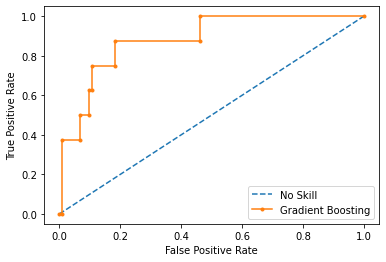

In [ ]:
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Gradient Boosting')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.070120, G-Mean=0.846


# Fit Layoff

In [ ]:
X_train, X_CV, y_train, y_CV = train_test_split(background.loc[train.index] , train, test_size=0.10, random_state=42)

In [ ]:
variable = 'layoff'

# Let's drop instances where the response is NA
y_train = y_train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

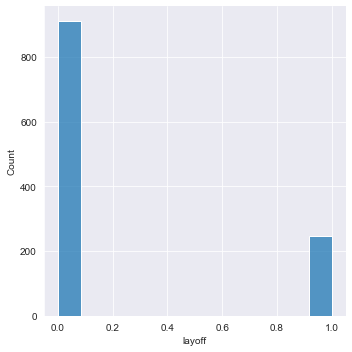

In [ ]:
sns.set_style('darkgrid')
sns.displot(data=y_train)

### Logistic Regression

In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
sgd = SGDClassifier(loss='log', penalty='elasticnet', max_iter=10000)
pipeline = Pipeline(steps=[('impute', SimpleImputer()),
                           ('sampling', SMOTE()),
                           ('normalize', 'passthrough'), 
                           ('sgd', sgd)])

params = {'normalize': [RobustScaler()], 
         'sgd__alpha' : np.arange(0.01, 2.01, 0.01),
         'sgd__l1_ratio': np.arange(0.00, 1.01, 0.01)}

In [ ]:
model = RandomizedSearchCV(pipeline, param_distributions= params, n_iter=200, n_jobs=1, verbose=10, scoring='neg_brier_score', cv = 4)

model.fit(X_train, y_train)

joblib_file = "layoff_logr_200.pkl"
joblib.dump(model, joblib_file)

Fitting 4 folds for each of 200 candidates, totalling 800 fits
[CV 1/4; 1/200] START normalize=RobustScaler(), sgd__alpha=1.99, sgd__l1_ratio=0.19
[CV 1/4; 1/200] END normalize=RobustScaler(), sgd__alpha=1.99, sgd__l1_ratio=0.19; total time=  11.1s
[CV 2/4; 1/200] START normalize=RobustScaler(), sgd__alpha=1.99, sgd__l1_ratio=0.19
[CV 2/4; 1/200] END normalize=RobustScaler(), sgd__alpha=1.99, sgd__l1_ratio=0.19; total time=  13.9s
[CV 3/4; 1/200] START normalize=RobustScaler(), sgd__alpha=1.99, sgd__l1_ratio=0.19
[CV 3/4; 1/200] END normalize=RobustScaler(), sgd__alpha=1.99, sgd__l1_ratio=0.19; total time=  11.7s
[CV 4/4; 1/200] START normalize=RobustScaler(), sgd__alpha=1.99, sgd__l1_ratio=0.19
[CV 4/4; 1/200] END normalize=RobustScaler(), sgd__alpha=1.99, sgd__l1_ratio=0.19; total time=  12.4s
[CV 1/4; 2/200] START normalize=RobustScaler(), sgd__alpha=1.5, sgd__l1_ratio=0.1
[CV 1/4; 2/200] END normalize=RobustScaler(), sgd__alpha=1.5, sgd__l1_ratio=0.1; total time=  12.4s
[CV 2/4; 2/

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


[CV 1/4; 6/200] END normalize=RobustScaler(), sgd__alpha=1.12, sgd__l1_ratio=1.0; total time=22.8min
[CV 2/4; 6/200] START normalize=RobustScaler(), sgd__alpha=1.12, sgd__l1_ratio=1.0
[CV 2/4; 6/200] END normalize=RobustScaler(), sgd__alpha=1.12, sgd__l1_ratio=1.0; total time=  22.9s
[CV 3/4; 6/200] START normalize=RobustScaler(), sgd__alpha=1.12, sgd__l1_ratio=1.0
[CV 3/4; 6/200] END normalize=RobustScaler(), sgd__alpha=1.12, sgd__l1_ratio=1.0; total time=  16.8s
[CV 4/4; 6/200] START normalize=RobustScaler(), sgd__alpha=1.12, sgd__l1_ratio=1.0
[CV 4/4; 6/200] END normalize=RobustScaler(), sgd__alpha=1.12, sgd__l1_ratio=1.0; total time=  22.1s
[CV 1/4; 7/200] START normalize=RobustScaler(), sgd__alpha=0.91, sgd__l1_ratio=0.15
[CV 1/4; 7/200] END normalize=RobustScaler(), sgd__alpha=0.91, sgd__l1_ratio=0.15; total time=  15.7s
[CV 2/4; 7/200] START normalize=RobustScaler(), sgd__alpha=0.91, sgd__l1_ratio=0.15
[CV 2/4; 7/200] END normalize=RobustScaler(), sgd__alpha=0.91, sgd__l1_ratio=

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


[CV 1/4; 12/200] END normalize=RobustScaler(), sgd__alpha=1.3800000000000001, sgd__l1_ratio=0.9500000000000001; total time=22.3min
[CV 2/4; 12/200] START normalize=RobustScaler(), sgd__alpha=1.3800000000000001, sgd__l1_ratio=0.9500000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


[CV 2/4; 12/200] END normalize=RobustScaler(), sgd__alpha=1.3800000000000001, sgd__l1_ratio=0.9500000000000001; total time=21.7min
[CV 3/4; 12/200] START normalize=RobustScaler(), sgd__alpha=1.3800000000000001, sgd__l1_ratio=0.9500000000000001
[CV 3/4; 12/200] END normalize=RobustScaler(), sgd__alpha=1.3800000000000001, sgd__l1_ratio=0.9500000000000001; total time=  11.1s
[CV 4/4; 12/200] START normalize=RobustScaler(), sgd__alpha=1.3800000000000001, sgd__l1_ratio=0.9500000000000001
[CV 4/4; 12/200] END normalize=RobustScaler(), sgd__alpha=1.3800000000000001, sgd__l1_ratio=0.9500000000000001; total time= 3.4min
[CV 1/4; 13/200] START normalize=RobustScaler(), sgd__alpha=1.49, sgd__l1_ratio=0.14
[CV 1/4; 13/200] END normalize=RobustScaler(), sgd__alpha=1.49, sgd__l1_ratio=0.14; total time=   9.9s
[CV 2/4; 13/200] START normalize=RobustScaler(), sgd__alpha=1.49, sgd__l1_ratio=0.14
[CV 2/4; 13/200] END normalize=RobustScaler(), sgd__alpha=1.49, sgd__l1_ratio=0.14; total time=  12.2s
[CV 3

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


[CV 1/4; 40/200] END normalize=RobustScaler(), sgd__alpha=1.98, sgd__l1_ratio=1.0; total time=21.1min
[CV 2/4; 40/200] START normalize=RobustScaler(), sgd__alpha=1.98, sgd__l1_ratio=1.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


[CV 2/4; 40/200] END normalize=RobustScaler(), sgd__alpha=1.98, sgd__l1_ratio=1.0; total time=21.5min
[CV 3/4; 40/200] START normalize=RobustScaler(), sgd__alpha=1.98, sgd__l1_ratio=1.0
[CV 3/4; 40/200] END normalize=RobustScaler(), sgd__alpha=1.98, sgd__l1_ratio=1.0; total time=  13.3s
[CV 4/4; 40/200] START normalize=RobustScaler(), sgd__alpha=1.98, sgd__l1_ratio=1.0
[CV 4/4; 40/200] END normalize=RobustScaler(), sgd__alpha=1.98, sgd__l1_ratio=1.0; total time=  13.1s
[CV 1/4; 41/200] START normalize=RobustScaler(), sgd__alpha=1.72, sgd__l1_ratio=0.06
[CV 1/4; 41/200] END normalize=RobustScaler(), sgd__alpha=1.72, sgd__l1_ratio=0.06; total time=  13.7s
[CV 2/4; 41/200] START normalize=RobustScaler(), sgd__alpha=1.72, sgd__l1_ratio=0.06
[CV 2/4; 41/200] END normalize=RobustScaler(), sgd__alpha=1.72, sgd__l1_ratio=0.06; total time=  10.5s
[CV 3/4; 41/200] START normalize=RobustScaler(), sgd__alpha=1.72, sgd__l1_ratio=0.06
[CV 3/4; 41/200] END normalize=RobustScaler(), sgd__alpha=1.72, s

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


[CV 1/4; 78/200] END normalize=RobustScaler(), sgd__alpha=1.31, sgd__l1_ratio=1.0; total time=21.2min
[CV 2/4; 78/200] START normalize=RobustScaler(), sgd__alpha=1.31, sgd__l1_ratio=1.0
[CV 2/4; 78/200] END normalize=RobustScaler(), sgd__alpha=1.31, sgd__l1_ratio=1.0; total time=  51.8s
[CV 3/4; 78/200] START normalize=RobustScaler(), sgd__alpha=1.31, sgd__l1_ratio=1.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


[CV 3/4; 78/200] END normalize=RobustScaler(), sgd__alpha=1.31, sgd__l1_ratio=1.0; total time=21.2min
[CV 4/4; 78/200] START normalize=RobustScaler(), sgd__alpha=1.31, sgd__l1_ratio=1.0
[CV 4/4; 78/200] END normalize=RobustScaler(), sgd__alpha=1.31, sgd__l1_ratio=1.0; total time=  22.5s
[CV 1/4; 79/200] START normalize=RobustScaler(), sgd__alpha=0.56, sgd__l1_ratio=0.91
[CV 1/4; 79/200] END normalize=RobustScaler(), sgd__alpha=0.56, sgd__l1_ratio=0.91; total time=  18.9s
[CV 2/4; 79/200] START normalize=RobustScaler(), sgd__alpha=0.56, sgd__l1_ratio=0.91
[CV 2/4; 79/200] END normalize=RobustScaler(), sgd__alpha=0.56, sgd__l1_ratio=0.91; total time=   8.4s
[CV 3/4; 79/200] START normalize=RobustScaler(), sgd__alpha=0.56, sgd__l1_ratio=0.91
[CV 3/4; 79/200] END normalize=RobustScaler(), sgd__alpha=0.56, sgd__l1_ratio=0.91; total time=  10.0s
[CV 4/4; 79/200] START normalize=RobustScaler(), sgd__alpha=0.56, sgd__l1_ratio=0.91
[CV 4/4; 79/200] END normalize=RobustScaler(), sgd__alpha=0.56,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


[CV 1/4; 123/200] END normalize=RobustScaler(), sgd__alpha=1.73, sgd__l1_ratio=0.99; total time=21.3min
[CV 2/4; 123/200] START normalize=RobustScaler(), sgd__alpha=1.73, sgd__l1_ratio=0.99
[CV 2/4; 123/200] END normalize=RobustScaler(), sgd__alpha=1.73, sgd__l1_ratio=0.99; total time=  18.5s
[CV 3/4; 123/200] START normalize=RobustScaler(), sgd__alpha=1.73, sgd__l1_ratio=0.99
[CV 3/4; 123/200] END normalize=RobustScaler(), sgd__alpha=1.73, sgd__l1_ratio=0.99; total time=  18.1s
[CV 4/4; 123/200] START normalize=RobustScaler(), sgd__alpha=1.73, sgd__l1_ratio=0.99
[CV 4/4; 123/200] END normalize=RobustScaler(), sgd__alpha=1.73, sgd__l1_ratio=0.99; total time=  13.3s
[CV 1/4; 124/200] START normalize=RobustScaler(), sgd__alpha=1.1, sgd__l1_ratio=0.4
[CV 1/4; 124/200] END normalize=RobustScaler(), sgd__alpha=1.1, sgd__l1_ratio=0.4; total time=  12.9s
[CV 2/4; 124/200] START normalize=RobustScaler(), sgd__alpha=1.1, sgd__l1_ratio=0.4
[CV 2/4; 124/200] END normalize=RobustScaler(), sgd__alp

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


[CV 2/4; 194/200] END normalize=RobustScaler(), sgd__alpha=1.1600000000000001, sgd__l1_ratio=0.98; total time=20.5min
[CV 3/4; 194/200] START normalize=RobustScaler(), sgd__alpha=1.1600000000000001, sgd__l1_ratio=0.98
[CV 3/4; 194/200] END normalize=RobustScaler(), sgd__alpha=1.1600000000000001, sgd__l1_ratio=0.98; total time=   9.5s
[CV 4/4; 194/200] START normalize=RobustScaler(), sgd__alpha=1.1600000000000001, sgd__l1_ratio=0.98
[CV 4/4; 194/200] END normalize=RobustScaler(), sgd__alpha=1.1600000000000001, sgd__l1_ratio=0.98; total time=   8.8s
[CV 1/4; 195/200] START normalize=RobustScaler(), sgd__alpha=1.72, sgd__l1_ratio=0.11
[CV 1/4; 195/200] END normalize=RobustScaler(), sgd__alpha=1.72, sgd__l1_ratio=0.11; total time=  12.1s
[CV 2/4; 195/200] START normalize=RobustScaler(), sgd__alpha=1.72, sgd__l1_ratio=0.11
[CV 2/4; 195/200] END normalize=RobustScaler(), sgd__alpha=1.72, sgd__l1_ratio=0.11; total time=   9.8s
[CV 3/4; 195/200] START normalize=RobustScaler(), sgd__alpha=1.72,

['layoff_logr_200.pkl']

#### Find Optimal Threshold w/ Cross-val set

In [ ]:
sgd = SGDClassifier(loss='log', 
                    penalty='elasticnet', 
                    max_iter=10000, 
                    alpha=1.69, 
                    l1_ratio=0.55)
pipeline = Pipeline(steps=[('impute', SimpleImputer()),
                           ('sampling', SMOTE()),
                           ('normalize', RobustScaler()), 
                           ('sgd', sgd)])


In [ ]:
logistic = pipeline.fit(X_train, y_train)

In [ ]:
variable = 'layoff'
X_CV = background.loc[X_CV.index]
y_CV= y_CV[variable].dropna()
X_CV = X_test.loc[y_CV.index.values]

In [ ]:
layoff_elastic_pred = logistic.predict_proba(X_CV)[:, 1]

In [ ]:
fpr, tpr, thresholds = roc_curve(y_CV, layoff_elastic_pred)

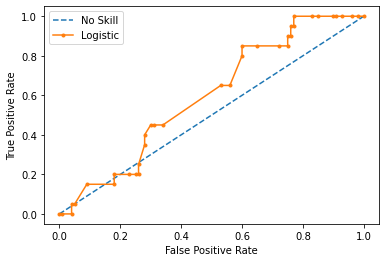

In [ ]:
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.230252, G-Mean=0.583


## Random Forest (SMOTE Upsampling)

In [ ]:
rfc = RandomForestClassifier(random_state=0)

In [ ]:
selector_k_best = SelectKBest(score_func=f_classif)


pipeline = Pipeline(steps=[('impute', SimpleImputer()),
                           ('sampling', SMOTE()), 
                           ('normalize', "passthrough"),
                           ('sel', selector_k_best),
                           ('randomforest', rfc)])

In [ ]:
max_features = ['auto']
n_estimators = [100, 150, 200, 250]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

In [ ]:
params={'randomforest__n_estimators': n_estimators, 
        'randomforest__max_depth': max_depth, 
       'randomforest__max_features': max_features,
       'randomforest__min_samples_split': min_samples_split,
        'randomforest__min_samples_leaf': min_samples_leaf,
       'normalize': [StandardScaler(), RobustScaler()], 
       'sel__k': np.arange(10, 15000, 100)}

model = RandomizedSearchCV(pipeline, param_distributions= params, n_iter=200, n_jobs=4, verbose=10, scoring='neg_brier_score', cv = 4)

model.fit(X_train, y_train)

joblib_file = "layoff_200_rf.pkl"
joblib.dump(model, joblib_file)

Fitting 4 folds for each of 200 candidates, totalling 800 fits


/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   809 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


['layoff_200_rf.pkl']

#### Find Optimal Threshold w/ Cross-val set

In [ ]:
variable = 'layoff'
X_CV = background.loc[X_CV.index]
y_CV= y_CV[variable].dropna()
X_CV = X_test.loc[y_CV.index.values]

KeyError: 'layoff'

In [ ]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot

In [ ]:
rfc = RandomForestClassifier(random_state=0, 
                            n_estimators = 150, 
                            min_samples_split = 2, 
                            min_samples_leaf = 2, 
                            max_features = 'auto', 
                            max_depth = 15)

In [ ]:
selector_k_best = SelectKBest(score_func=f_classif, k = 11710)


pipeline = Pipeline(steps=[('impute', SimpleImputer()),
                           ('sampling', SMOTE()), 
                           ('normalize', "passthrough"),
                           ('sel', selector_k_best),
                           ('randomforest', rfc)])

In [ ]:
rf = pipeline.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   809 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [ ]:
layoff_rf_pred = rf.predict_proba(X_CV)[:, 1]

In [ ]:
fpr, tpr, thresholds = roc_curve(y_CV, layoff_rf_pred)

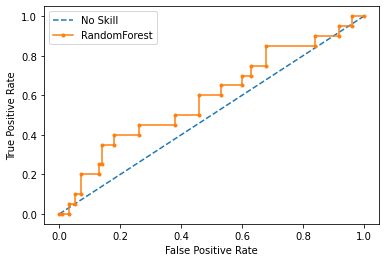

In [ ]:
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='RandomForest')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.319464, G-Mean=0.577


## XGBoost (SMOTE Upsampling)

In [ ]:
X_train, X_CV, y_train, y_CV = train_test_split(background.loc[train.index] , train, test_size=0.10, random_state=42)

variable = 'layoff'

# Let's drop instances where the response is NA
y_train = y_train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

X_train = X_train.apply(pd.to_numeric, errors='coerce', axis=1)

y_train = y_train.apply(pd.to_numeric, errors='coerce')

xg_reg = xgb.XGBClassifier(objective ='binary:logistic')

pipeline = Pipeline(steps=[('impute', SimpleImputer()),
                           ('sampling', SMOTE()),
                           ('normalize', MinMaxScaler()), 
                           ('feat_select', SelectKBest(f_classif)),
                           ('xgboost', xg_reg)])



n_estimators = np.arange(100, 300, 10)
max_depth = np.arange(3, 12, 1)
min_child_weight = np.arange(1, 8, 1)
gamma = np.arange(0.00, 2, 0.01),
learning_rate = np.arange(0.01,0.3,0.0005)
subsample = np.arange(0.2, 0.8, 0.1)
colsample_bylevel = np.round(np.arange(0.1,1.0,0.01))
colsample_bytree = np.arange(0.3, 1, 0.1)
alpha = np.arange(0, 1, 0.1)

params={'xgboost__n_estimators': n_estimators, 
        'xgboost__max_depth': max_depth, 
        'xgboost__min_child_weight': min_child_weight,
       'xgboost__gamma': np.arange(0.00, 2, 0.01),
       'xgboost__learning_rate': learning_rate,
        'xgboost__subsample': subsample,
       'xgboost__colsample_bylevel': colsample_bylevel,
       'xgboost__colsample_bytree': colsample_bytree,
       'feat_select__k': np.arange(10, 15000, 100),
       "impute__strategy": ['mean', 'median']}


            
            
model = RandomizedSearchCV(pipeline, param_distributions= params, n_iter=200, n_jobs=1, verbose=10, scoring='neg_brier_score', cv = 4)

model.fit(X_train, y_train)

joblib_file = "xgb_layoff_200.pkl"
joblib.dump(model, joblib_file)

Fitting 4 folds for each of 200 candidates, totalling 800 fits
[CV 1/4; 1/200] START feat_select__k=1210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.71, xgboost__learning_rate=0.09500000000000007, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=270, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:45:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 1/200] END feat_select__k=1210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.71, xgboost__learning_rate=0.09500000000000007, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=270, xgboost__subsample=0.2; total time=   4.8s
[CV 2/4; 1/200] START feat_select__k=1210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.71, xgboost__learning_rate=0.09500000000000007, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=270, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:45:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 1/200] END feat_select__k=1210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.71, xgboost__learning_rate=0.09500000000000007, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=270, xgboost__subsample=0.2; total time=   5.1s
[CV 3/4; 1/200] START feat_select__k=1210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.71, xgboost__learning_rate=0.09500000000000007, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=270, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:45:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 1/200] END feat_select__k=1210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.71, xgboost__learning_rate=0.09500000000000007, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=270, xgboost__subsample=0.2; total time=   4.9s
[CV 4/4; 1/200] START feat_select__k=1210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.71, xgboost__learning_rate=0.09500000000000007, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=270, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:45:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 1/200] END feat_select__k=1210, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.71, xgboost__learning_rate=0.09500000000000007, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=270, xgboost__subsample=0.2; total time=   4.6s
[CV 1/4; 2/200] START feat_select__k=3010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.1500000000000001, xgboost__learning_rate=0.06200000000000005, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:45:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 2/200] END feat_select__k=3010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.1500000000000001, xgboost__learning_rate=0.06200000000000005, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001; total time=  11.6s
[CV 2/4; 2/200] START feat_select__k=3010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.1500000000000001, xgboost__learning_rate=0.06200000000000005, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:45:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 2/200] END feat_select__k=3010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.1500000000000001, xgboost__learning_rate=0.06200000000000005, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001; total time=  11.0s
[CV 3/4; 2/200] START feat_select__k=3010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.1500000000000001, xgboost__learning_rate=0.06200000000000005, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:45:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 2/200] END feat_select__k=3010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.1500000000000001, xgboost__learning_rate=0.06200000000000005, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001; total time=  11.1s
[CV 4/4; 2/200] START feat_select__k=3010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.1500000000000001, xgboost__learning_rate=0.06200000000000005, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:46:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 2/200] END feat_select__k=3010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.1500000000000001, xgboost__learning_rate=0.06200000000000005, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001; total time=  11.1s
[CV 1/4; 3/200] START feat_select__k=11410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.8, xgboost__learning_rate=0.29000000000000026, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:46:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 3/200] END feat_select__k=11410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.8, xgboost__learning_rate=0.29000000000000026, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003; total time=   6.4s
[CV 2/4; 3/200] START feat_select__k=11410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.8, xgboost__learning_rate=0.29000000000000026, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:46:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 3/200] END feat_select__k=11410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.8, xgboost__learning_rate=0.29000000000000026, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003; total time=   6.3s
[CV 3/4; 3/200] START feat_select__k=11410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.8, xgboost__learning_rate=0.29000000000000026, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:46:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 3/200] END feat_select__k=11410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.8, xgboost__learning_rate=0.29000000000000026, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003; total time=   6.4s
[CV 4/4; 3/200] START feat_select__k=11410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.8, xgboost__learning_rate=0.29000000000000026, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:46:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 3/200] END feat_select__k=11410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.8, xgboost__learning_rate=0.29000000000000026, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003; total time=   6.2s
[CV 1/4; 4/200] START feat_select__k=10410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.74, xgboost__learning_rate=0.11250000000000009, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=230, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:46:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 4/200] END feat_select__k=10410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.74, xgboost__learning_rate=0.11250000000000009, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=230, xgboost__subsample=0.2; total time=  12.0s
[CV 2/4; 4/200] START feat_select__k=10410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.74, xgboost__learning_rate=0.11250000000000009, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=230, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:46:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 4/200] END feat_select__k=10410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.74, xgboost__learning_rate=0.11250000000000009, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=230, xgboost__subsample=0.2; total time=  13.0s
[CV 3/4; 4/200] START feat_select__k=10410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.74, xgboost__learning_rate=0.11250000000000009, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=230, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:47:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 4/200] END feat_select__k=10410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.74, xgboost__learning_rate=0.11250000000000009, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=230, xgboost__subsample=0.2; total time=  12.9s
[CV 4/4; 4/200] START feat_select__k=10410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.74, xgboost__learning_rate=0.11250000000000009, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=230, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:47:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 4/200] END feat_select__k=10410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.74, xgboost__learning_rate=0.11250000000000009, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=230, xgboost__subsample=0.2; total time=  12.9s
[CV 1/4; 5/200] START feat_select__k=10010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.41000000000000003, xgboost__learning_rate=0.09800000000000007, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:47:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 5/200] END feat_select__k=10010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.41000000000000003, xgboost__learning_rate=0.09800000000000007, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004; total time=   9.1s
[CV 2/4; 5/200] START feat_select__k=10010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.41000000000000003, xgboost__learning_rate=0.09800000000000007, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:47:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 5/200] END feat_select__k=10010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.41000000000000003, xgboost__learning_rate=0.09800000000000007, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004; total time=   9.1s
[CV 3/4; 5/200] START feat_select__k=10010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.41000000000000003, xgboost__learning_rate=0.09800000000000007, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:47:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 5/200] END feat_select__k=10010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.41000000000000003, xgboost__learning_rate=0.09800000000000007, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004; total time=   8.6s
[CV 4/4; 5/200] START feat_select__k=10010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.41000000000000003, xgboost__learning_rate=0.09800000000000007, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:47:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 5/200] END feat_select__k=10010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.41000000000000003, xgboost__learning_rate=0.09800000000000007, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004; total time=   9.6s
[CV 1/4; 6/200] START feat_select__k=13510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.92, xgboost__learning_rate=0.27050000000000024, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=150, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:48:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 6/200] END feat_select__k=13510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.92, xgboost__learning_rate=0.27050000000000024, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=150, xgboost__subsample=0.5000000000000001; total time=  17.5s
[CV 2/4; 6/200] START feat_select__k=13510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.92, xgboost__learning_rate=0.27050000000000024, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=150, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:48:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 6/200] END feat_select__k=13510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.92, xgboost__learning_rate=0.27050000000000024, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=150, xgboost__subsample=0.5000000000000001; total time=  17.7s
[CV 3/4; 6/200] START feat_select__k=13510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.92, xgboost__learning_rate=0.27050000000000024, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=150, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:48:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 6/200] END feat_select__k=13510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.92, xgboost__learning_rate=0.27050000000000024, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=150, xgboost__subsample=0.5000000000000001; total time=  17.3s
[CV 4/4; 6/200] START feat_select__k=13510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.92, xgboost__learning_rate=0.27050000000000024, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=150, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:48:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 6/200] END feat_select__k=13510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.92, xgboost__learning_rate=0.27050000000000024, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=150, xgboost__subsample=0.5000000000000001; total time=  18.4s
[CV 1/4; 7/200] START feat_select__k=4410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.41, xgboost__learning_rate=0.19800000000000018, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:49:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 7/200] END feat_select__k=4410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.41, xgboost__learning_rate=0.19800000000000018, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002; total time=   8.2s
[CV 2/4; 7/200] START feat_select__k=4410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.41, xgboost__learning_rate=0.19800000000000018, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:49:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 7/200] END feat_select__k=4410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.41, xgboost__learning_rate=0.19800000000000018, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002; total time=   5.7s
[CV 3/4; 7/200] START feat_select__k=4410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.41, xgboost__learning_rate=0.19800000000000018, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:49:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 7/200] END feat_select__k=4410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.41, xgboost__learning_rate=0.19800000000000018, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002; total time=   6.4s
[CV 4/4; 7/200] START feat_select__k=4410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.41, xgboost__learning_rate=0.19800000000000018, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:49:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 7/200] END feat_select__k=4410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.41, xgboost__learning_rate=0.19800000000000018, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002; total time=   6.3s
[CV 1/4; 8/200] START feat_select__k=13510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.5, xgboost__learning_rate=0.08900000000000007, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=270, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:49:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 8/200] END feat_select__k=13510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.5, xgboost__learning_rate=0.08900000000000007, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=270, xgboost__subsample=0.2; total time=  24.6s
[CV 2/4; 8/200] START feat_select__k=13510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.5, xgboost__learning_rate=0.08900000000000007, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=270, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:50:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 8/200] END feat_select__k=13510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.5, xgboost__learning_rate=0.08900000000000007, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=270, xgboost__subsample=0.2; total time=  24.1s
[CV 3/4; 8/200] START feat_select__k=13510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.5, xgboost__learning_rate=0.08900000000000007, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=270, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:50:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 8/200] END feat_select__k=13510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.5, xgboost__learning_rate=0.08900000000000007, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=270, xgboost__subsample=0.2; total time=  25.9s
[CV 4/4; 8/200] START feat_select__k=13510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.5, xgboost__learning_rate=0.08900000000000007, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=270, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:50:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 8/200] END feat_select__k=13510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.5, xgboost__learning_rate=0.08900000000000007, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=270, xgboost__subsample=0.2; total time=  27.5s
[CV 1/4; 9/200] START feat_select__k=3810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.8900000000000001, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:51:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 9/200] END feat_select__k=3810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.8900000000000001, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.2; total time=   6.1s
[CV 2/4; 9/200] START feat_select__k=3810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.8900000000000001, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:51:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 9/200] END feat_select__k=3810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.8900000000000001, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.2; total time=   8.0s
[CV 3/4; 9/200] START feat_select__k=3810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.8900000000000001, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:51:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 9/200] END feat_select__k=3810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.8900000000000001, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.2; total time=   5.8s
[CV 4/4; 9/200] START feat_select__k=3810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.8900000000000001, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:51:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 9/200] END feat_select__k=3810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.8900000000000001, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.2; total time=  11.4s
[CV 1/4; 10/200] START feat_select__k=9110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.77, xgboost__learning_rate=0.17350000000000015, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:51:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 10/200] END feat_select__k=9110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.77, xgboost__learning_rate=0.17350000000000015, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.30000000000000004; total time=   5.9s
[CV 2/4; 10/200] START feat_select__k=9110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.77, xgboost__learning_rate=0.17350000000000015, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:52:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 10/200] END feat_select__k=9110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.77, xgboost__learning_rate=0.17350000000000015, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.30000000000000004; total time=   8.9s
[CV 3/4; 10/200] START feat_select__k=9110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.77, xgboost__learning_rate=0.17350000000000015, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:52:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 10/200] END feat_select__k=9110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.77, xgboost__learning_rate=0.17350000000000015, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.30000000000000004; total time=   6.7s
[CV 4/4; 10/200] START feat_select__k=9110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.77, xgboost__learning_rate=0.17350000000000015, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:52:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 10/200] END feat_select__k=9110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.77, xgboost__learning_rate=0.17350000000000015, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.30000000000000004; total time=   7.4s
[CV 1/4; 11/200] START feat_select__k=3810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.94, xgboost__learning_rate=0.013000000000000003, xgboost__max_depth=5, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:52:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 11/200] END feat_select__k=3810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.94, xgboost__learning_rate=0.013000000000000003, xgboost__max_depth=5, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001; total time=   7.4s
[CV 2/4; 11/200] START feat_select__k=3810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.94, xgboost__learning_rate=0.013000000000000003, xgboost__max_depth=5, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:52:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 11/200] END feat_select__k=3810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.94, xgboost__learning_rate=0.013000000000000003, xgboost__max_depth=5, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001; total time=   4.0s
[CV 3/4; 11/200] START feat_select__k=3810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.94, xgboost__learning_rate=0.013000000000000003, xgboost__max_depth=5, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:52:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 11/200] END feat_select__k=3810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.94, xgboost__learning_rate=0.013000000000000003, xgboost__max_depth=5, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001; total time=   7.1s
[CV 4/4; 11/200] START feat_select__k=3810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.94, xgboost__learning_rate=0.013000000000000003, xgboost__max_depth=5, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:52:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 11/200] END feat_select__k=3810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.94, xgboost__learning_rate=0.013000000000000003, xgboost__max_depth=5, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.5000000000000001; total time=   6.2s
[CV 1/4; 12/200] START feat_select__k=4310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.11, xgboost__learning_rate=0.27950000000000025, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=140, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:52:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 12/200] END feat_select__k=4310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.11, xgboost__learning_rate=0.27950000000000025, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=140, xgboost__subsample=0.30000000000000004; total time=   6.6s
[CV 2/4; 12/200] START feat_select__k=4310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.11, xgboost__learning_rate=0.27950000000000025, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=140, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:52:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 12/200] END feat_select__k=4310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.11, xgboost__learning_rate=0.27950000000000025, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=140, xgboost__subsample=0.30000000000000004; total time=   5.7s
[CV 3/4; 12/200] START feat_select__k=4310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.11, xgboost__learning_rate=0.27950000000000025, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=140, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:53:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 12/200] END feat_select__k=4310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.11, xgboost__learning_rate=0.27950000000000025, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=140, xgboost__subsample=0.30000000000000004; total time=   6.1s
[CV 4/4; 12/200] START feat_select__k=4310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.11, xgboost__learning_rate=0.27950000000000025, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=140, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:53:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 12/200] END feat_select__k=4310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.11, xgboost__learning_rate=0.27950000000000025, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=140, xgboost__subsample=0.30000000000000004; total time=   6.7s
[CV 1/4; 13/200] START feat_select__k=14510, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.25, xgboost__learning_rate=0.29200000000000026, xgboost__max_depth=5, xgboost__min_child_weight=2, xgboost__n_estimators=220, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:53:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 13/200] END feat_select__k=14510, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.25, xgboost__learning_rate=0.29200000000000026, xgboost__max_depth=5, xgboost__min_child_weight=2, xgboost__n_estimators=220, xgboost__subsample=0.30000000000000004; total time=   9.7s
[CV 2/4; 13/200] START feat_select__k=14510, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.25, xgboost__learning_rate=0.29200000000000026, xgboost__max_depth=5, xgboost__min_child_weight=2, xgboost__n_estimators=220, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:53:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 13/200] END feat_select__k=14510, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.25, xgboost__learning_rate=0.29200000000000026, xgboost__max_depth=5, xgboost__min_child_weight=2, xgboost__n_estimators=220, xgboost__subsample=0.30000000000000004; total time=   8.8s
[CV 3/4; 13/200] START feat_select__k=14510, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.25, xgboost__learning_rate=0.29200000000000026, xgboost__max_depth=5, xgboost__min_child_weight=2, xgboost__n_estimators=220, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:53:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 13/200] END feat_select__k=14510, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.25, xgboost__learning_rate=0.29200000000000026, xgboost__max_depth=5, xgboost__min_child_weight=2, xgboost__n_estimators=220, xgboost__subsample=0.30000000000000004; total time=   9.2s
[CV 4/4; 13/200] START feat_select__k=14510, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.25, xgboost__learning_rate=0.29200000000000026, xgboost__max_depth=5, xgboost__min_child_weight=2, xgboost__n_estimators=220, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:53:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 13/200] END feat_select__k=14510, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.25, xgboost__learning_rate=0.29200000000000026, xgboost__max_depth=5, xgboost__min_child_weight=2, xgboost__n_estimators=220, xgboost__subsample=0.30000000000000004; total time=  10.7s
[CV 1/4; 14/200] START feat_select__k=2710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.31, xgboost__learning_rate=0.08350000000000006, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:53:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 14/200] END feat_select__k=2710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.31, xgboost__learning_rate=0.08350000000000006, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003; total time=  14.2s
[CV 2/4; 14/200] START feat_select__k=2710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.31, xgboost__learning_rate=0.08350000000000006, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:54:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 14/200] END feat_select__k=2710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.31, xgboost__learning_rate=0.08350000000000006, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003; total time=  13.5s
[CV 3/4; 14/200] START feat_select__k=2710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.31, xgboost__learning_rate=0.08350000000000006, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:54:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 14/200] END feat_select__k=2710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.31, xgboost__learning_rate=0.08350000000000006, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003; total time=  17.3s
[CV 4/4; 14/200] START feat_select__k=2710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.31, xgboost__learning_rate=0.08350000000000006, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:54:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 14/200] END feat_select__k=2710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.31, xgboost__learning_rate=0.08350000000000006, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003; total time=  17.3s
[CV 1/4; 15/200] START feat_select__k=13610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.08, xgboost__learning_rate=0.14350000000000013, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:54:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 15/200] END feat_select__k=13610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.08, xgboost__learning_rate=0.14350000000000013, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001; total time=  11.3s
[CV 2/4; 15/200] START feat_select__k=13610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.08, xgboost__learning_rate=0.14350000000000013, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:55:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 15/200] END feat_select__k=13610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.08, xgboost__learning_rate=0.14350000000000013, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001; total time=   8.5s
[CV 3/4; 15/200] START feat_select__k=13610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.08, xgboost__learning_rate=0.14350000000000013, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:55:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 15/200] END feat_select__k=13610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.08, xgboost__learning_rate=0.14350000000000013, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001; total time=  10.2s
[CV 4/4; 15/200] START feat_select__k=13610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.08, xgboost__learning_rate=0.14350000000000013, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:55:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 15/200] END feat_select__k=13610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.08, xgboost__learning_rate=0.14350000000000013, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001; total time=   9.1s
[CV 1/4; 16/200] START feat_select__k=13110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.36, xgboost__learning_rate=0.14450000000000013, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=250, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:55:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 16/200] END feat_select__k=13110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.36, xgboost__learning_rate=0.14450000000000013, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=250, xgboost__subsample=0.6000000000000001; total time=  35.4s
[CV 2/4; 16/200] START feat_select__k=13110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.36, xgboost__learning_rate=0.14450000000000013, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=250, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:56:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 16/200] END feat_select__k=13110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.36, xgboost__learning_rate=0.14450000000000013, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=250, xgboost__subsample=0.6000000000000001; total time=  37.2s
[CV 3/4; 16/200] START feat_select__k=13110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.36, xgboost__learning_rate=0.14450000000000013, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=250, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:56:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 16/200] END feat_select__k=13110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.36, xgboost__learning_rate=0.14450000000000013, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=250, xgboost__subsample=0.6000000000000001; total time=  41.6s
[CV 4/4; 16/200] START feat_select__k=13110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.36, xgboost__learning_rate=0.14450000000000013, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=250, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:57:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 16/200] END feat_select__k=13110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.36, xgboost__learning_rate=0.14450000000000013, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=250, xgboost__subsample=0.6000000000000001; total time=  41.0s
[CV 1/4; 17/200] START feat_select__k=8110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.46, xgboost__learning_rate=0.09850000000000007, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=240, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:58:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 17/200] END feat_select__k=8110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.46, xgboost__learning_rate=0.09850000000000007, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=240, xgboost__subsample=0.8000000000000003; total time=  11.5s
[CV 2/4; 17/200] START feat_select__k=8110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.46, xgboost__learning_rate=0.09850000000000007, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=240, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:58:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 17/200] END feat_select__k=8110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.46, xgboost__learning_rate=0.09850000000000007, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=240, xgboost__subsample=0.8000000000000003; total time=  10.8s
[CV 3/4; 17/200] START feat_select__k=8110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.46, xgboost__learning_rate=0.09850000000000007, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=240, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:58:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 17/200] END feat_select__k=8110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.46, xgboost__learning_rate=0.09850000000000007, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=240, xgboost__subsample=0.8000000000000003; total time=  10.1s
[CV 4/4; 17/200] START feat_select__k=8110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.46, xgboost__learning_rate=0.09850000000000007, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=240, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:58:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 17/200] END feat_select__k=8110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.46, xgboost__learning_rate=0.09850000000000007, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=240, xgboost__subsample=0.8000000000000003; total time=  11.5s
[CV 1/4; 18/200] START feat_select__k=110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.39, xgboost__learning_rate=0.10300000000000008, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:58:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 18/200] END feat_select__k=110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.39, xgboost__learning_rate=0.10300000000000008, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.2; total time=   6.5s
[CV 2/4; 18/200] START feat_select__k=110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.39, xgboost__learning_rate=0.10300000000000008, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:59:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 18/200] END feat_select__k=110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.39, xgboost__learning_rate=0.10300000000000008, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.2; total time=   3.7s
[CV 3/4; 18/200] START feat_select__k=110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.39, xgboost__learning_rate=0.10300000000000008, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:59:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 18/200] END feat_select__k=110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.39, xgboost__learning_rate=0.10300000000000008, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.2; total time=   6.6s
[CV 4/4; 18/200] START feat_select__k=110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.39, xgboost__learning_rate=0.10300000000000008, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:59:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 18/200] END feat_select__k=110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.39, xgboost__learning_rate=0.10300000000000008, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.2; total time=   6.5s
[CV 1/4; 19/200] START feat_select__k=3810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.89, xgboost__learning_rate=0.16000000000000014, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=190, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:59:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 19/200] END feat_select__k=3810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.89, xgboost__learning_rate=0.16000000000000014, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=190, xgboost__subsample=0.30000000000000004; total time=   7.9s
[CV 2/4; 19/200] START feat_select__k=3810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.89, xgboost__learning_rate=0.16000000000000014, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=190, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:59:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 19/200] END feat_select__k=3810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.89, xgboost__learning_rate=0.16000000000000014, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=190, xgboost__subsample=0.30000000000000004; total time=  11.2s
[CV 3/4; 19/200] START feat_select__k=3810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.89, xgboost__learning_rate=0.16000000000000014, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=190, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:59:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 19/200] END feat_select__k=3810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.89, xgboost__learning_rate=0.16000000000000014, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=190, xgboost__subsample=0.30000000000000004; total time=  10.6s
[CV 4/4; 19/200] START feat_select__k=3810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.89, xgboost__learning_rate=0.16000000000000014, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=190, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:59:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 19/200] END feat_select__k=3810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.89, xgboost__learning_rate=0.16000000000000014, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=190, xgboost__subsample=0.30000000000000004; total time=   8.4s
[CV 1/4; 20/200] START feat_select__k=11410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.03300000000000002, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:59:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 20/200] END feat_select__k=11410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.03300000000000002, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004; total time=  17.7s
[CV 2/4; 20/200] START feat_select__k=11410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.03300000000000002, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:00:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 20/200] END feat_select__k=11410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.03300000000000002, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004; total time=  22.7s
[CV 3/4; 20/200] START feat_select__k=11410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.03300000000000002, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:00:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 20/200] END feat_select__k=11410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.03300000000000002, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004; total time=  18.7s
[CV 4/4; 20/200] START feat_select__k=11410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.03300000000000002, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:00:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 20/200] END feat_select__k=11410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.03300000000000002, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004; total time=  27.3s
[CV 1/4; 21/200] START feat_select__k=9610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.11, xgboost__learning_rate=0.09050000000000007, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:01:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 21/200] END feat_select__k=9610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.11, xgboost__learning_rate=0.09050000000000007, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002; total time=  36.4s
[CV 2/4; 21/200] START feat_select__k=9610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.11, xgboost__learning_rate=0.09050000000000007, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:02:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 21/200] END feat_select__k=9610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.11, xgboost__learning_rate=0.09050000000000007, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002; total time=  32.6s
[CV 3/4; 21/200] START feat_select__k=9610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.11, xgboost__learning_rate=0.09050000000000007, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:02:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 21/200] END feat_select__k=9610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.11, xgboost__learning_rate=0.09050000000000007, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002; total time=  24.8s
[CV 4/4; 21/200] START feat_select__k=9610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.11, xgboost__learning_rate=0.09050000000000007, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:02:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 21/200] END feat_select__k=9610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.11, xgboost__learning_rate=0.09050000000000007, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002; total time=  21.3s
[CV 1/4; 22/200] START feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.86, xgboost__learning_rate=0.16600000000000015, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:03:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 22/200] END feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.86, xgboost__learning_rate=0.16600000000000015, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003; total time=   7.6s
[CV 2/4; 22/200] START feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.86, xgboost__learning_rate=0.16600000000000015, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:03:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 22/200] END feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.86, xgboost__learning_rate=0.16600000000000015, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003; total time=   7.8s
[CV 3/4; 22/200] START feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.86, xgboost__learning_rate=0.16600000000000015, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:03:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 22/200] END feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.86, xgboost__learning_rate=0.16600000000000015, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003; total time=  14.4s
[CV 4/4; 22/200] START feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.86, xgboost__learning_rate=0.16600000000000015, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:03:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 22/200] END feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.86, xgboost__learning_rate=0.16600000000000015, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003; total time=  11.9s
[CV 1/4; 23/200] START feat_select__k=12510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.59, xgboost__learning_rate=0.24700000000000022, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:04:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 23/200] END feat_select__k=12510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.59, xgboost__learning_rate=0.24700000000000022, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003; total time=  32.4s
[CV 2/4; 23/200] START feat_select__k=12510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.59, xgboost__learning_rate=0.24700000000000022, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:04:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 23/200] END feat_select__k=12510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.59, xgboost__learning_rate=0.24700000000000022, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003; total time=  31.7s
[CV 3/4; 23/200] START feat_select__k=12510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.59, xgboost__learning_rate=0.24700000000000022, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:05:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 23/200] END feat_select__k=12510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.59, xgboost__learning_rate=0.24700000000000022, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003; total time=  32.3s
[CV 4/4; 23/200] START feat_select__k=12510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.59, xgboost__learning_rate=0.24700000000000022, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:05:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 23/200] END feat_select__k=12510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.59, xgboost__learning_rate=0.24700000000000022, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003; total time=  34.5s
[CV 1/4; 24/200] START feat_select__k=3910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.77, xgboost__learning_rate=0.28500000000000025, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=230, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:06:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 24/200] END feat_select__k=3910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.77, xgboost__learning_rate=0.28500000000000025, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=230, xgboost__subsample=0.2; total time=  11.8s
[CV 2/4; 24/200] START feat_select__k=3910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.77, xgboost__learning_rate=0.28500000000000025, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=230, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:06:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 24/200] END feat_select__k=3910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.77, xgboost__learning_rate=0.28500000000000025, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=230, xgboost__subsample=0.2; total time=  10.7s
[CV 3/4; 24/200] START feat_select__k=3910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.77, xgboost__learning_rate=0.28500000000000025, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=230, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:06:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 24/200] END feat_select__k=3910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.77, xgboost__learning_rate=0.28500000000000025, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=230, xgboost__subsample=0.2; total time=   7.1s
[CV 4/4; 24/200] START feat_select__k=3910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.77, xgboost__learning_rate=0.28500000000000025, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=230, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:06:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 24/200] END feat_select__k=3910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.77, xgboost__learning_rate=0.28500000000000025, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=230, xgboost__subsample=0.2; total time=  10.1s
[CV 1/4; 25/200] START feat_select__k=7610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.56, xgboost__learning_rate=0.11350000000000009, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=190, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:06:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 25/200] END feat_select__k=7610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.56, xgboost__learning_rate=0.11350000000000009, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=190, xgboost__subsample=0.30000000000000004; total time=  21.0s
[CV 2/4; 25/200] START feat_select__k=7610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.56, xgboost__learning_rate=0.11350000000000009, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=190, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:07:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 25/200] END feat_select__k=7610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.56, xgboost__learning_rate=0.11350000000000009, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=190, xgboost__subsample=0.30000000000000004; total time=  15.8s
[CV 3/4; 25/200] START feat_select__k=7610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.56, xgboost__learning_rate=0.11350000000000009, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=190, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:07:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 25/200] END feat_select__k=7610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.56, xgboost__learning_rate=0.11350000000000009, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=190, xgboost__subsample=0.30000000000000004; total time=  19.1s
[CV 4/4; 25/200] START feat_select__k=7610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.56, xgboost__learning_rate=0.11350000000000009, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=190, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:07:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 25/200] END feat_select__k=7610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.56, xgboost__learning_rate=0.11350000000000009, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=190, xgboost__subsample=0.30000000000000004; total time=  14.6s
[CV 1/4; 26/200] START feat_select__k=11910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.93, xgboost__learning_rate=0.26700000000000024, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:08:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 26/200] END feat_select__k=11910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.93, xgboost__learning_rate=0.26700000000000024, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.4000000000000001; total time=  15.3s
[CV 2/4; 26/200] START feat_select__k=11910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.93, xgboost__learning_rate=0.26700000000000024, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:08:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 26/200] END feat_select__k=11910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.93, xgboost__learning_rate=0.26700000000000024, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.4000000000000001; total time=  14.5s
[CV 3/4; 26/200] START feat_select__k=11910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.93, xgboost__learning_rate=0.26700000000000024, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:08:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 26/200] END feat_select__k=11910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.93, xgboost__learning_rate=0.26700000000000024, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.4000000000000001; total time=  11.1s
[CV 4/4; 26/200] START feat_select__k=11910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.93, xgboost__learning_rate=0.26700000000000024, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:08:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 26/200] END feat_select__k=11910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.93, xgboost__learning_rate=0.26700000000000024, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.4000000000000001; total time=  11.2s
[CV 1/4; 27/200] START feat_select__k=12710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.52, xgboost__learning_rate=0.18750000000000017, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=100, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:08:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 27/200] END feat_select__k=12710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.52, xgboost__learning_rate=0.18750000000000017, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=100, xgboost__subsample=0.4000000000000001; total time=  11.7s
[CV 2/4; 27/200] START feat_select__k=12710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.52, xgboost__learning_rate=0.18750000000000017, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=100, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:09:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 27/200] END feat_select__k=12710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.52, xgboost__learning_rate=0.18750000000000017, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=100, xgboost__subsample=0.4000000000000001; total time=  11.7s
[CV 3/4; 27/200] START feat_select__k=12710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.52, xgboost__learning_rate=0.18750000000000017, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=100, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:09:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 27/200] END feat_select__k=12710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.52, xgboost__learning_rate=0.18750000000000017, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=100, xgboost__subsample=0.4000000000000001; total time=  11.5s
[CV 4/4; 27/200] START feat_select__k=12710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.52, xgboost__learning_rate=0.18750000000000017, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=100, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:09:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 27/200] END feat_select__k=12710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.52, xgboost__learning_rate=0.18750000000000017, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=100, xgboost__subsample=0.4000000000000001; total time=   9.7s
[CV 1/4; 28/200] START feat_select__k=3810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.93, xgboost__learning_rate=0.28200000000000025, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=170, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:09:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 28/200] END feat_select__k=3810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.93, xgboost__learning_rate=0.28200000000000025, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=170, xgboost__subsample=0.7000000000000002; total time=   5.4s
[CV 2/4; 28/200] START feat_select__k=3810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.93, xgboost__learning_rate=0.28200000000000025, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=170, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:09:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 28/200] END feat_select__k=3810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.93, xgboost__learning_rate=0.28200000000000025, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=170, xgboost__subsample=0.7000000000000002; total time=   3.8s
[CV 3/4; 28/200] START feat_select__k=3810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.93, xgboost__learning_rate=0.28200000000000025, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=170, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:09:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 28/200] END feat_select__k=3810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.93, xgboost__learning_rate=0.28200000000000025, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=170, xgboost__subsample=0.7000000000000002; total time=   5.7s
[CV 4/4; 28/200] START feat_select__k=3810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.93, xgboost__learning_rate=0.28200000000000025, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=170, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:09:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 28/200] END feat_select__k=3810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.93, xgboost__learning_rate=0.28200000000000025, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=170, xgboost__subsample=0.7000000000000002; total time=   4.0s
[CV 1/4; 29/200] START feat_select__k=5510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.9400000000000001, xgboost__learning_rate=0.17250000000000015, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=190, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:09:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 29/200] END feat_select__k=5510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.9400000000000001, xgboost__learning_rate=0.17250000000000015, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=190, xgboost__subsample=0.30000000000000004; total time=   8.0s
[CV 2/4; 29/200] START feat_select__k=5510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.9400000000000001, xgboost__learning_rate=0.17250000000000015, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=190, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:10:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 29/200] END feat_select__k=5510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.9400000000000001, xgboost__learning_rate=0.17250000000000015, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=190, xgboost__subsample=0.30000000000000004; total time=   6.4s
[CV 3/4; 29/200] START feat_select__k=5510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.9400000000000001, xgboost__learning_rate=0.17250000000000015, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=190, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:10:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 29/200] END feat_select__k=5510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.9400000000000001, xgboost__learning_rate=0.17250000000000015, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=190, xgboost__subsample=0.30000000000000004; total time=   6.9s
[CV 4/4; 29/200] START feat_select__k=5510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.9400000000000001, xgboost__learning_rate=0.17250000000000015, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=190, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:10:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 29/200] END feat_select__k=5510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.9400000000000001, xgboost__learning_rate=0.17250000000000015, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=190, xgboost__subsample=0.30000000000000004; total time=   7.8s
[CV 1/4; 30/200] START feat_select__k=12510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.81, xgboost__learning_rate=0.2375000000000002, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=230, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:10:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 30/200] END feat_select__k=12510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.81, xgboost__learning_rate=0.2375000000000002, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=230, xgboost__subsample=0.6000000000000001; total time=  32.1s
[CV 2/4; 30/200] START feat_select__k=12510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.81, xgboost__learning_rate=0.2375000000000002, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=230, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:11:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 30/200] END feat_select__k=12510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.81, xgboost__learning_rate=0.2375000000000002, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=230, xgboost__subsample=0.6000000000000001; total time=  29.9s
[CV 3/4; 30/200] START feat_select__k=12510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.81, xgboost__learning_rate=0.2375000000000002, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=230, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:11:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 30/200] END feat_select__k=12510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.81, xgboost__learning_rate=0.2375000000000002, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=230, xgboost__subsample=0.6000000000000001; total time=  29.2s
[CV 4/4; 30/200] START feat_select__k=12510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.81, xgboost__learning_rate=0.2375000000000002, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=230, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:11:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 30/200] END feat_select__k=12510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.81, xgboost__learning_rate=0.2375000000000002, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=230, xgboost__subsample=0.6000000000000001; total time=  28.2s
[CV 1/4; 31/200] START feat_select__k=510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.28, xgboost__learning_rate=0.036500000000000025, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:12:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 31/200] END feat_select__k=510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.28, xgboost__learning_rate=0.036500000000000025, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002; total time=   7.1s
[CV 2/4; 31/200] START feat_select__k=510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.28, xgboost__learning_rate=0.036500000000000025, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:12:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 31/200] END feat_select__k=510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.28, xgboost__learning_rate=0.036500000000000025, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002; total time=   4.9s
[CV 3/4; 31/200] START feat_select__k=510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.28, xgboost__learning_rate=0.036500000000000025, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:12:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 31/200] END feat_select__k=510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.28, xgboost__learning_rate=0.036500000000000025, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002; total time=   8.7s
[CV 4/4; 31/200] START feat_select__k=510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.28, xgboost__learning_rate=0.036500000000000025, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:12:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 31/200] END feat_select__k=510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.28, xgboost__learning_rate=0.036500000000000025, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002; total time=   8.2s
[CV 1/4; 32/200] START feat_select__k=14110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.02, xgboost__learning_rate=0.09200000000000007, xgboost__max_depth=6, xgboost__min_child_weight=5, xgboost__n_estimators=290, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:12:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 32/200] END feat_select__k=14110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.02, xgboost__learning_rate=0.09200000000000007, xgboost__max_depth=6, xgboost__min_child_weight=5, xgboost__n_estimators=290, xgboost__subsample=0.5000000000000001; total time=  10.2s
[CV 2/4; 32/200] START feat_select__k=14110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.02, xgboost__learning_rate=0.09200000000000007, xgboost__max_depth=6, xgboost__min_child_weight=5, xgboost__n_estimators=290, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:13:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 32/200] END feat_select__k=14110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.02, xgboost__learning_rate=0.09200000000000007, xgboost__max_depth=6, xgboost__min_child_weight=5, xgboost__n_estimators=290, xgboost__subsample=0.5000000000000001; total time=  15.2s
[CV 3/4; 32/200] START feat_select__k=14110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.02, xgboost__learning_rate=0.09200000000000007, xgboost__max_depth=6, xgboost__min_child_weight=5, xgboost__n_estimators=290, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:13:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 32/200] END feat_select__k=14110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.02, xgboost__learning_rate=0.09200000000000007, xgboost__max_depth=6, xgboost__min_child_weight=5, xgboost__n_estimators=290, xgboost__subsample=0.5000000000000001; total time=  10.7s
[CV 4/4; 32/200] START feat_select__k=14110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.02, xgboost__learning_rate=0.09200000000000007, xgboost__max_depth=6, xgboost__min_child_weight=5, xgboost__n_estimators=290, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:13:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 32/200] END feat_select__k=14110, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.02, xgboost__learning_rate=0.09200000000000007, xgboost__max_depth=6, xgboost__min_child_weight=5, xgboost__n_estimators=290, xgboost__subsample=0.5000000000000001; total time=  12.7s
[CV 1/4; 33/200] START feat_select__k=10710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.99, xgboost__learning_rate=0.28950000000000026, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:13:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 33/200] END feat_select__k=10710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.99, xgboost__learning_rate=0.28950000000000026, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001; total time=   8.5s
[CV 2/4; 33/200] START feat_select__k=10710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.99, xgboost__learning_rate=0.28950000000000026, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:13:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 33/200] END feat_select__k=10710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.99, xgboost__learning_rate=0.28950000000000026, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001; total time=   9.2s
[CV 3/4; 33/200] START feat_select__k=10710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.99, xgboost__learning_rate=0.28950000000000026, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:14:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 33/200] END feat_select__k=10710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.99, xgboost__learning_rate=0.28950000000000026, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001; total time=   8.3s
[CV 4/4; 33/200] START feat_select__k=10710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.99, xgboost__learning_rate=0.28950000000000026, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:14:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 33/200] END feat_select__k=10710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.99, xgboost__learning_rate=0.28950000000000026, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001; total time=   8.3s
[CV 1/4; 34/200] START feat_select__k=5910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.87, xgboost__learning_rate=0.2150000000000002, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:14:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 34/200] END feat_select__k=5910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.87, xgboost__learning_rate=0.2150000000000002, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004; total time=  11.8s
[CV 2/4; 34/200] START feat_select__k=5910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.87, xgboost__learning_rate=0.2150000000000002, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:14:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 34/200] END feat_select__k=5910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.87, xgboost__learning_rate=0.2150000000000002, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004; total time=  11.8s
[CV 3/4; 34/200] START feat_select__k=5910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.87, xgboost__learning_rate=0.2150000000000002, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:14:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 34/200] END feat_select__k=5910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.87, xgboost__learning_rate=0.2150000000000002, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004; total time=  11.5s
[CV 4/4; 34/200] START feat_select__k=5910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.87, xgboost__learning_rate=0.2150000000000002, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:14:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 34/200] END feat_select__k=5910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.87, xgboost__learning_rate=0.2150000000000002, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004; total time=  11.8s
[CV 1/4; 35/200] START feat_select__k=910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.8, xgboost__learning_rate=0.2380000000000002, xgboost__max_depth=7, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:15:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 35/200] END feat_select__k=910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.8, xgboost__learning_rate=0.2380000000000002, xgboost__max_depth=7, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.7000000000000002; total time=   5.7s
[CV 2/4; 35/200] START feat_select__k=910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.8, xgboost__learning_rate=0.2380000000000002, xgboost__max_depth=7, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:15:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 35/200] END feat_select__k=910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.8, xgboost__learning_rate=0.2380000000000002, xgboost__max_depth=7, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.7000000000000002; total time=   4.8s
[CV 3/4; 35/200] START feat_select__k=910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.8, xgboost__learning_rate=0.2380000000000002, xgboost__max_depth=7, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:15:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 35/200] END feat_select__k=910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.8, xgboost__learning_rate=0.2380000000000002, xgboost__max_depth=7, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.7000000000000002; total time=   5.5s
[CV 4/4; 35/200] START feat_select__k=910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.8, xgboost__learning_rate=0.2380000000000002, xgboost__max_depth=7, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:15:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 35/200] END feat_select__k=910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.8, xgboost__learning_rate=0.2380000000000002, xgboost__max_depth=7, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.7000000000000002; total time=   5.0s
[CV 1/4; 36/200] START feat_select__k=10510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.58, xgboost__learning_rate=0.16500000000000015, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:15:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 36/200] END feat_select__k=10510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.58, xgboost__learning_rate=0.16500000000000015, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002; total time=  26.3s
[CV 2/4; 36/200] START feat_select__k=10510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.58, xgboost__learning_rate=0.16500000000000015, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:15:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 36/200] END feat_select__k=10510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.58, xgboost__learning_rate=0.16500000000000015, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002; total time=  26.5s
[CV 3/4; 36/200] START feat_select__k=10510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.58, xgboost__learning_rate=0.16500000000000015, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:16:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 36/200] END feat_select__k=10510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.58, xgboost__learning_rate=0.16500000000000015, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002; total time=  30.8s
[CV 4/4; 36/200] START feat_select__k=10510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.58, xgboost__learning_rate=0.16500000000000015, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:16:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 36/200] END feat_select__k=10510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.58, xgboost__learning_rate=0.16500000000000015, xgboost__max_depth=11, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002; total time=  30.2s
[CV 1/4; 37/200] START feat_select__k=13110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.3, xgboost__learning_rate=0.06050000000000005, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=130, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:17:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 37/200] END feat_select__k=13110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.3, xgboost__learning_rate=0.06050000000000005, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=130, xgboost__subsample=0.8000000000000003; total time=  25.7s
[CV 2/4; 37/200] START feat_select__k=13110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.3, xgboost__learning_rate=0.06050000000000005, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=130, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:17:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 37/200] END feat_select__k=13110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.3, xgboost__learning_rate=0.06050000000000005, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=130, xgboost__subsample=0.8000000000000003; total time=  26.0s
[CV 3/4; 37/200] START feat_select__k=13110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.3, xgboost__learning_rate=0.06050000000000005, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=130, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:18:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 37/200] END feat_select__k=13110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.3, xgboost__learning_rate=0.06050000000000005, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=130, xgboost__subsample=0.8000000000000003; total time=  31.7s
[CV 4/4; 37/200] START feat_select__k=13110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.3, xgboost__learning_rate=0.06050000000000005, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=130, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:18:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 37/200] END feat_select__k=13110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.3, xgboost__learning_rate=0.06050000000000005, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=130, xgboost__subsample=0.8000000000000003; total time=  22.7s
[CV 1/4; 38/200] START feat_select__k=2110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.21, xgboost__learning_rate=0.2380000000000002, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:19:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 38/200] END feat_select__k=2110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.21, xgboost__learning_rate=0.2380000000000002, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001; total time=   7.6s
[CV 2/4; 38/200] START feat_select__k=2110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.21, xgboost__learning_rate=0.2380000000000002, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:19:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 38/200] END feat_select__k=2110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.21, xgboost__learning_rate=0.2380000000000002, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001; total time=   6.8s
[CV 3/4; 38/200] START feat_select__k=2110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.21, xgboost__learning_rate=0.2380000000000002, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:19:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 38/200] END feat_select__k=2110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.21, xgboost__learning_rate=0.2380000000000002, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001; total time=   7.2s
[CV 4/4; 38/200] START feat_select__k=2110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.21, xgboost__learning_rate=0.2380000000000002, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:19:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 38/200] END feat_select__k=2110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.21, xgboost__learning_rate=0.2380000000000002, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001; total time=   6.6s
[CV 1/4; 39/200] START feat_select__k=7610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.28, xgboost__learning_rate=0.27050000000000024, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=250, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:19:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 39/200] END feat_select__k=7610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.28, xgboost__learning_rate=0.27050000000000024, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=250, xgboost__subsample=0.4000000000000001; total time=  16.3s
[CV 2/4; 39/200] START feat_select__k=7610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.28, xgboost__learning_rate=0.27050000000000024, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=250, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:19:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 39/200] END feat_select__k=7610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.28, xgboost__learning_rate=0.27050000000000024, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=250, xgboost__subsample=0.4000000000000001; total time=  16.8s
[CV 3/4; 39/200] START feat_select__k=7610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.28, xgboost__learning_rate=0.27050000000000024, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=250, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:20:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 39/200] END feat_select__k=7610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.28, xgboost__learning_rate=0.27050000000000024, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=250, xgboost__subsample=0.4000000000000001; total time=  17.9s
[CV 4/4; 39/200] START feat_select__k=7610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.28, xgboost__learning_rate=0.27050000000000024, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=250, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:20:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 39/200] END feat_select__k=7610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.28, xgboost__learning_rate=0.27050000000000024, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=250, xgboost__subsample=0.4000000000000001; total time=  17.3s
[CV 1/4; 40/200] START feat_select__k=7910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.36, xgboost__learning_rate=0.04500000000000003, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=290, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:20:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 40/200] END feat_select__k=7910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.36, xgboost__learning_rate=0.04500000000000003, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=290, xgboost__subsample=0.4000000000000001; total time=  47.4s
[CV 2/4; 40/200] START feat_select__k=7910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.36, xgboost__learning_rate=0.04500000000000003, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=290, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:21:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 40/200] END feat_select__k=7910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.36, xgboost__learning_rate=0.04500000000000003, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=290, xgboost__subsample=0.4000000000000001; total time=  46.6s
[CV 3/4; 40/200] START feat_select__k=7910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.36, xgboost__learning_rate=0.04500000000000003, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=290, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:22:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 40/200] END feat_select__k=7910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.36, xgboost__learning_rate=0.04500000000000003, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=290, xgboost__subsample=0.4000000000000001; total time=  48.1s
[CV 4/4; 40/200] START feat_select__k=7910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.36, xgboost__learning_rate=0.04500000000000003, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=290, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:23:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 40/200] END feat_select__k=7910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.36, xgboost__learning_rate=0.04500000000000003, xgboost__max_depth=9, xgboost__min_child_weight=1, xgboost__n_estimators=290, xgboost__subsample=0.4000000000000001; total time=  45.0s
[CV 1/4; 41/200] START feat_select__k=6810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.98, xgboost__learning_rate=0.14050000000000012, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:23:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 41/200] END feat_select__k=6810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.98, xgboost__learning_rate=0.14050000000000012, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002; total time=  11.1s
[CV 2/4; 41/200] START feat_select__k=6810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.98, xgboost__learning_rate=0.14050000000000012, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:24:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 41/200] END feat_select__k=6810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.98, xgboost__learning_rate=0.14050000000000012, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002; total time=  10.3s
[CV 3/4; 41/200] START feat_select__k=6810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.98, xgboost__learning_rate=0.14050000000000012, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:24:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 41/200] END feat_select__k=6810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.98, xgboost__learning_rate=0.14050000000000012, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002; total time=   9.4s
[CV 4/4; 41/200] START feat_select__k=6810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.98, xgboost__learning_rate=0.14050000000000012, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:24:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 41/200] END feat_select__k=6810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.98, xgboost__learning_rate=0.14050000000000012, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002; total time=  10.3s
[CV 1/4; 42/200] START feat_select__k=9910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.36, xgboost__learning_rate=0.2545000000000002, xgboost__max_depth=7, xgboost__min_child_weight=1, xgboost__n_estimators=230, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:24:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 42/200] END feat_select__k=9910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.36, xgboost__learning_rate=0.2545000000000002, xgboost__max_depth=7, xgboost__min_child_weight=1, xgboost__n_estimators=230, xgboost__subsample=0.30000000000000004; total time=  21.7s
[CV 2/4; 42/200] START feat_select__k=9910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.36, xgboost__learning_rate=0.2545000000000002, xgboost__max_depth=7, xgboost__min_child_weight=1, xgboost__n_estimators=230, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:24:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 42/200] END feat_select__k=9910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.36, xgboost__learning_rate=0.2545000000000002, xgboost__max_depth=7, xgboost__min_child_weight=1, xgboost__n_estimators=230, xgboost__subsample=0.30000000000000004; total time=  21.7s
[CV 3/4; 42/200] START feat_select__k=9910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.36, xgboost__learning_rate=0.2545000000000002, xgboost__max_depth=7, xgboost__min_child_weight=1, xgboost__n_estimators=230, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:25:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 42/200] END feat_select__k=9910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.36, xgboost__learning_rate=0.2545000000000002, xgboost__max_depth=7, xgboost__min_child_weight=1, xgboost__n_estimators=230, xgboost__subsample=0.30000000000000004; total time=  21.6s
[CV 4/4; 42/200] START feat_select__k=9910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.36, xgboost__learning_rate=0.2545000000000002, xgboost__max_depth=7, xgboost__min_child_weight=1, xgboost__n_estimators=230, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:25:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 42/200] END feat_select__k=9910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.36, xgboost__learning_rate=0.2545000000000002, xgboost__max_depth=7, xgboost__min_child_weight=1, xgboost__n_estimators=230, xgboost__subsample=0.30000000000000004; total time=  20.2s
[CV 1/4; 43/200] START feat_select__k=2210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.81, xgboost__learning_rate=0.15200000000000014, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=190, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:25:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 43/200] END feat_select__k=2210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.81, xgboost__learning_rate=0.15200000000000014, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=190, xgboost__subsample=0.8000000000000003; total time=   5.7s
[CV 2/4; 43/200] START feat_select__k=2210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.81, xgboost__learning_rate=0.15200000000000014, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=190, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:26:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 43/200] END feat_select__k=2210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.81, xgboost__learning_rate=0.15200000000000014, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=190, xgboost__subsample=0.8000000000000003; total time=   5.5s
[CV 3/4; 43/200] START feat_select__k=2210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.81, xgboost__learning_rate=0.15200000000000014, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=190, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:26:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 43/200] END feat_select__k=2210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.81, xgboost__learning_rate=0.15200000000000014, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=190, xgboost__subsample=0.8000000000000003; total time=   5.7s
[CV 4/4; 43/200] START feat_select__k=2210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.81, xgboost__learning_rate=0.15200000000000014, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=190, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:26:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 43/200] END feat_select__k=2210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.81, xgboost__learning_rate=0.15200000000000014, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=190, xgboost__subsample=0.8000000000000003; total time=   5.9s
[CV 1/4; 44/200] START feat_select__k=4710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.68, xgboost__learning_rate=0.046500000000000034, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=180, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:26:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 44/200] END feat_select__k=4710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.68, xgboost__learning_rate=0.046500000000000034, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=180, xgboost__subsample=0.5000000000000001; total time=  10.4s
[CV 2/4; 44/200] START feat_select__k=4710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.68, xgboost__learning_rate=0.046500000000000034, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=180, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:26:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 44/200] END feat_select__k=4710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.68, xgboost__learning_rate=0.046500000000000034, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=180, xgboost__subsample=0.5000000000000001; total time=  10.7s
[CV 3/4; 44/200] START feat_select__k=4710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.68, xgboost__learning_rate=0.046500000000000034, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=180, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:26:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 44/200] END feat_select__k=4710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.68, xgboost__learning_rate=0.046500000000000034, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=180, xgboost__subsample=0.5000000000000001; total time=  11.3s
[CV 4/4; 44/200] START feat_select__k=4710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.68, xgboost__learning_rate=0.046500000000000034, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=180, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:26:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 44/200] END feat_select__k=4710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.68, xgboost__learning_rate=0.046500000000000034, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=180, xgboost__subsample=0.5000000000000001; total time=  10.6s
[CV 1/4; 45/200] START feat_select__k=6710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.37, xgboost__learning_rate=0.05150000000000004, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:27:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 45/200] END feat_select__k=6710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.37, xgboost__learning_rate=0.05150000000000004, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001; total time=  17.7s
[CV 2/4; 45/200] START feat_select__k=6710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.37, xgboost__learning_rate=0.05150000000000004, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:27:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 45/200] END feat_select__k=6710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.37, xgboost__learning_rate=0.05150000000000004, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001; total time=  27.9s
[CV 3/4; 45/200] START feat_select__k=6710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.37, xgboost__learning_rate=0.05150000000000004, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:27:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 45/200] END feat_select__k=6710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.37, xgboost__learning_rate=0.05150000000000004, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001; total time=  25.3s
[CV 4/4; 45/200] START feat_select__k=6710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.37, xgboost__learning_rate=0.05150000000000004, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:28:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 45/200] END feat_select__k=6710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.37, xgboost__learning_rate=0.05150000000000004, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001; total time=  23.6s
[CV 1/4; 46/200] START feat_select__k=14310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.89, xgboost__learning_rate=0.14250000000000013, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:28:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 46/200] END feat_select__k=14310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.89, xgboost__learning_rate=0.14250000000000013, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004; total time=  21.3s
[CV 2/4; 46/200] START feat_select__k=14310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.89, xgboost__learning_rate=0.14250000000000013, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:29:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 46/200] END feat_select__k=14310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.89, xgboost__learning_rate=0.14250000000000013, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004; total time=  20.5s
[CV 3/4; 46/200] START feat_select__k=14310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.89, xgboost__learning_rate=0.14250000000000013, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:29:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 46/200] END feat_select__k=14310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.89, xgboost__learning_rate=0.14250000000000013, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004; total time=  20.4s
[CV 4/4; 46/200] START feat_select__k=14310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.89, xgboost__learning_rate=0.14250000000000013, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:29:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 46/200] END feat_select__k=14310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.89, xgboost__learning_rate=0.14250000000000013, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004; total time=  21.2s
[CV 1/4; 47/200] START feat_select__k=4910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.46, xgboost__learning_rate=0.24700000000000022, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=160, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:30:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 47/200] END feat_select__k=4910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.46, xgboost__learning_rate=0.24700000000000022, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=160, xgboost__subsample=0.5000000000000001; total time=   4.1s
[CV 2/4; 47/200] START feat_select__k=4910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.46, xgboost__learning_rate=0.24700000000000022, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=160, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:30:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 47/200] END feat_select__k=4910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.46, xgboost__learning_rate=0.24700000000000022, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=160, xgboost__subsample=0.5000000000000001; total time=   4.9s
[CV 3/4; 47/200] START feat_select__k=4910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.46, xgboost__learning_rate=0.24700000000000022, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=160, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:30:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 47/200] END feat_select__k=4910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.46, xgboost__learning_rate=0.24700000000000022, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=160, xgboost__subsample=0.5000000000000001; total time=   4.7s
[CV 4/4; 47/200] START feat_select__k=4910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.46, xgboost__learning_rate=0.24700000000000022, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=160, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:30:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 47/200] END feat_select__k=4910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.46, xgboost__learning_rate=0.24700000000000022, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=160, xgboost__subsample=0.5000000000000001; total time=   4.8s
[CV 1/4; 48/200] START feat_select__k=1810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.04, xgboost__learning_rate=0.13750000000000012, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=220, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:30:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 48/200] END feat_select__k=1810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.04, xgboost__learning_rate=0.13750000000000012, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=220, xgboost__subsample=0.5000000000000001; total time=   8.8s
[CV 2/4; 48/200] START feat_select__k=1810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.04, xgboost__learning_rate=0.13750000000000012, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=220, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:30:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 48/200] END feat_select__k=1810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.04, xgboost__learning_rate=0.13750000000000012, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=220, xgboost__subsample=0.5000000000000001; total time=   7.8s
[CV 3/4; 48/200] START feat_select__k=1810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.04, xgboost__learning_rate=0.13750000000000012, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=220, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:30:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 48/200] END feat_select__k=1810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.04, xgboost__learning_rate=0.13750000000000012, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=220, xgboost__subsample=0.5000000000000001; total time=   7.9s
[CV 4/4; 48/200] START feat_select__k=1810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.04, xgboost__learning_rate=0.13750000000000012, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=220, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:30:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 48/200] END feat_select__k=1810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.04, xgboost__learning_rate=0.13750000000000012, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=220, xgboost__subsample=0.5000000000000001; total time=   7.2s
[CV 1/4; 49/200] START feat_select__k=2710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.76, xgboost__learning_rate=0.05650000000000004, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=210, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:30:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 49/200] END feat_select__k=2710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.76, xgboost__learning_rate=0.05650000000000004, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=210, xgboost__subsample=0.2; total time=   6.2s
[CV 2/4; 49/200] START feat_select__k=2710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.76, xgboost__learning_rate=0.05650000000000004, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=210, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:30:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 49/200] END feat_select__k=2710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.76, xgboost__learning_rate=0.05650000000000004, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=210, xgboost__subsample=0.2; total time=   4.0s
[CV 3/4; 49/200] START feat_select__k=2710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.76, xgboost__learning_rate=0.05650000000000004, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=210, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:31:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 49/200] END feat_select__k=2710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.76, xgboost__learning_rate=0.05650000000000004, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=210, xgboost__subsample=0.2; total time=   6.2s
[CV 4/4; 49/200] START feat_select__k=2710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.76, xgboost__learning_rate=0.05650000000000004, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=210, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:31:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 49/200] END feat_select__k=2710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.76, xgboost__learning_rate=0.05650000000000004, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=210, xgboost__subsample=0.2; total time=   4.6s
[CV 1/4; 50/200] START feat_select__k=4610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.06, xgboost__learning_rate=0.17200000000000015, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=270, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:31:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 50/200] END feat_select__k=4610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.06, xgboost__learning_rate=0.17200000000000015, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=270, xgboost__subsample=0.6000000000000001; total time=   6.9s
[CV 2/4; 50/200] START feat_select__k=4610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.06, xgboost__learning_rate=0.17200000000000015, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=270, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:31:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 50/200] END feat_select__k=4610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.06, xgboost__learning_rate=0.17200000000000015, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=270, xgboost__subsample=0.6000000000000001; total time=   5.7s
[CV 3/4; 50/200] START feat_select__k=4610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.06, xgboost__learning_rate=0.17200000000000015, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=270, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:31:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 50/200] END feat_select__k=4610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.06, xgboost__learning_rate=0.17200000000000015, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=270, xgboost__subsample=0.6000000000000001; total time=   5.9s
[CV 4/4; 50/200] START feat_select__k=4610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.06, xgboost__learning_rate=0.17200000000000015, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=270, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:31:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 50/200] END feat_select__k=4610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.06, xgboost__learning_rate=0.17200000000000015, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=270, xgboost__subsample=0.6000000000000001; total time=   6.6s
[CV 1/4; 51/200] START feat_select__k=4710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.87, xgboost__learning_rate=0.2500000000000002, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=220, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:31:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 51/200] END feat_select__k=4710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.87, xgboost__learning_rate=0.2500000000000002, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=220, xgboost__subsample=0.6000000000000001; total time=  15.8s
[CV 2/4; 51/200] START feat_select__k=4710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.87, xgboost__learning_rate=0.2500000000000002, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=220, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:31:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 51/200] END feat_select__k=4710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.87, xgboost__learning_rate=0.2500000000000002, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=220, xgboost__subsample=0.6000000000000001; total time=  16.5s
[CV 3/4; 51/200] START feat_select__k=4710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.87, xgboost__learning_rate=0.2500000000000002, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=220, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:32:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 51/200] END feat_select__k=4710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.87, xgboost__learning_rate=0.2500000000000002, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=220, xgboost__subsample=0.6000000000000001; total time=  16.3s
[CV 4/4; 51/200] START feat_select__k=4710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.87, xgboost__learning_rate=0.2500000000000002, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=220, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:32:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 51/200] END feat_select__k=4710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.87, xgboost__learning_rate=0.2500000000000002, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=220, xgboost__subsample=0.6000000000000001; total time=  13.8s
[CV 1/4; 52/200] START feat_select__k=13010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.32, xgboost__learning_rate=0.15250000000000014, xgboost__max_depth=4, xgboost__min_child_weight=6, xgboost__n_estimators=280, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:32:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 52/200] END feat_select__k=13010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.32, xgboost__learning_rate=0.15250000000000014, xgboost__max_depth=4, xgboost__min_child_weight=6, xgboost__n_estimators=280, xgboost__subsample=0.2; total time=  12.9s
[CV 2/4; 52/200] START feat_select__k=13010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.32, xgboost__learning_rate=0.15250000000000014, xgboost__max_depth=4, xgboost__min_child_weight=6, xgboost__n_estimators=280, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:32:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 52/200] END feat_select__k=13010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.32, xgboost__learning_rate=0.15250000000000014, xgboost__max_depth=4, xgboost__min_child_weight=6, xgboost__n_estimators=280, xgboost__subsample=0.2; total time=  13.3s
[CV 3/4; 52/200] START feat_select__k=13010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.32, xgboost__learning_rate=0.15250000000000014, xgboost__max_depth=4, xgboost__min_child_weight=6, xgboost__n_estimators=280, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:33:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 52/200] END feat_select__k=13010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.32, xgboost__learning_rate=0.15250000000000014, xgboost__max_depth=4, xgboost__min_child_weight=6, xgboost__n_estimators=280, xgboost__subsample=0.2; total time=  12.1s
[CV 4/4; 52/200] START feat_select__k=13010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.32, xgboost__learning_rate=0.15250000000000014, xgboost__max_depth=4, xgboost__min_child_weight=6, xgboost__n_estimators=280, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:33:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 52/200] END feat_select__k=13010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.32, xgboost__learning_rate=0.15250000000000014, xgboost__max_depth=4, xgboost__min_child_weight=6, xgboost__n_estimators=280, xgboost__subsample=0.2; total time=  12.4s
[CV 1/4; 53/200] START feat_select__k=12810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.36, xgboost__learning_rate=0.059500000000000046, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=210, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:33:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 53/200] END feat_select__k=12810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.36, xgboost__learning_rate=0.059500000000000046, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=210, xgboost__subsample=0.5000000000000001; total time=   8.9s
[CV 2/4; 53/200] START feat_select__k=12810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.36, xgboost__learning_rate=0.059500000000000046, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=210, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:33:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 53/200] END feat_select__k=12810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.36, xgboost__learning_rate=0.059500000000000046, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=210, xgboost__subsample=0.5000000000000001; total time=   9.5s
[CV 3/4; 53/200] START feat_select__k=12810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.36, xgboost__learning_rate=0.059500000000000046, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=210, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:33:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 53/200] END feat_select__k=12810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.36, xgboost__learning_rate=0.059500000000000046, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=210, xgboost__subsample=0.5000000000000001; total time=   9.7s
[CV 4/4; 53/200] START feat_select__k=12810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.36, xgboost__learning_rate=0.059500000000000046, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=210, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:34:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 53/200] END feat_select__k=12810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.36, xgboost__learning_rate=0.059500000000000046, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=210, xgboost__subsample=0.5000000000000001; total time=  13.4s
[CV 1/4; 54/200] START feat_select__k=12910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.07, xgboost__learning_rate=0.29750000000000026, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=170, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:34:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 54/200] END feat_select__k=12910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.07, xgboost__learning_rate=0.29750000000000026, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=170, xgboost__subsample=0.6000000000000001; total time=   9.9s
[CV 2/4; 54/200] START feat_select__k=12910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.07, xgboost__learning_rate=0.29750000000000026, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=170, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[17:34:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 54/200] END feat_select__k=12910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.07, xgboost__learning_rate=0.29750000000000026, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=170, xgboost__subsample=0.6000000000000001; total time=   9.5s
[CV 3/4; 54/200] START feat_select__k=12910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.07, xgboost__learning_rate=0.29750000000000026, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=170, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is depr

[17:34:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 54/200] END feat_select__k=12910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.07, xgboost__learning_rate=0.29750000000000026, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=170, xgboost__subsample=0.6000000000000001; total time=  11.7s
[CV 4/4; 54/200] START feat_select__k=12910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.07, xgboost__learning_rate=0.29750000000000026, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=170, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:34:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 54/200] END feat_select__k=12910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.07, xgboost__learning_rate=0.29750000000000026, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=170, xgboost__subsample=0.6000000000000001; total time=   9.0s
[CV 1/4; 55/200] START feat_select__k=410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.75, xgboost__learning_rate=0.07750000000000005, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:34:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 55/200] END feat_select__k=410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.75, xgboost__learning_rate=0.07750000000000005, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003; total time=  17.3s
[CV 2/4; 55/200] START feat_select__k=410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.75, xgboost__learning_rate=0.07750000000000005, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:35:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 55/200] END feat_select__k=410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.75, xgboost__learning_rate=0.07750000000000005, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003; total time=  15.2s
[CV 3/4; 55/200] START feat_select__k=410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.75, xgboost__learning_rate=0.07750000000000005, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:35:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 55/200] END feat_select__k=410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.75, xgboost__learning_rate=0.07750000000000005, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003; total time=  11.3s
[CV 4/4; 55/200] START feat_select__k=410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.75, xgboost__learning_rate=0.07750000000000005, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:35:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 55/200] END feat_select__k=410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.75, xgboost__learning_rate=0.07750000000000005, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003; total time=  17.9s
[CV 1/4; 56/200] START feat_select__k=14510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.5, xgboost__learning_rate=0.18850000000000017, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:35:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 56/200] END feat_select__k=14510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.5, xgboost__learning_rate=0.18850000000000017, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001; total time=  13.0s
[CV 2/4; 56/200] START feat_select__k=14510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.5, xgboost__learning_rate=0.18850000000000017, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:36:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 56/200] END feat_select__k=14510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.5, xgboost__learning_rate=0.18850000000000017, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001; total time=  14.4s
[CV 3/4; 56/200] START feat_select__k=14510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.5, xgboost__learning_rate=0.18850000000000017, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:36:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 56/200] END feat_select__k=14510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.5, xgboost__learning_rate=0.18850000000000017, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001; total time=  14.5s
[CV 4/4; 56/200] START feat_select__k=14510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.5, xgboost__learning_rate=0.18850000000000017, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:36:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 56/200] END feat_select__k=14510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.5, xgboost__learning_rate=0.18850000000000017, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001; total time=  14.1s
[CV 1/4; 57/200] START feat_select__k=2210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.3, xgboost__learning_rate=0.13300000000000012, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:36:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 57/200] END feat_select__k=2210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.3, xgboost__learning_rate=0.13300000000000012, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001; total time=   7.2s
[CV 2/4; 57/200] START feat_select__k=2210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.3, xgboost__learning_rate=0.13300000000000012, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:36:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 57/200] END feat_select__k=2210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.3, xgboost__learning_rate=0.13300000000000012, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001; total time=   7.3s
[CV 3/4; 57/200] START feat_select__k=2210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.3, xgboost__learning_rate=0.13300000000000012, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:37:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 57/200] END feat_select__k=2210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.3, xgboost__learning_rate=0.13300000000000012, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001; total time=   7.5s
[CV 4/4; 57/200] START feat_select__k=2210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.3, xgboost__learning_rate=0.13300000000000012, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:37:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 57/200] END feat_select__k=2210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.3, xgboost__learning_rate=0.13300000000000012, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001; total time=   7.5s
[CV 1/4; 58/200] START feat_select__k=2010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.08, xgboost__learning_rate=0.27950000000000025, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=250, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:37:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 58/200] END feat_select__k=2010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.08, xgboost__learning_rate=0.27950000000000025, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=250, xgboost__subsample=0.6000000000000001; total time=   5.9s
[CV 2/4; 58/200] START feat_select__k=2010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.08, xgboost__learning_rate=0.27950000000000025, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=250, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:37:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 58/200] END feat_select__k=2010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.08, xgboost__learning_rate=0.27950000000000025, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=250, xgboost__subsample=0.6000000000000001; total time=   6.0s
[CV 3/4; 58/200] START feat_select__k=2010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.08, xgboost__learning_rate=0.27950000000000025, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=250, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:37:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 58/200] END feat_select__k=2010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.08, xgboost__learning_rate=0.27950000000000025, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=250, xgboost__subsample=0.6000000000000001; total time=   6.0s
[CV 4/4; 58/200] START feat_select__k=2010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.08, xgboost__learning_rate=0.27950000000000025, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=250, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:37:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 58/200] END feat_select__k=2010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.08, xgboost__learning_rate=0.27950000000000025, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=250, xgboost__subsample=0.6000000000000001; total time=   5.1s
[CV 1/4; 59/200] START feat_select__k=11210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.93, xgboost__learning_rate=0.19550000000000017, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:37:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 59/200] END feat_select__k=11210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.93, xgboost__learning_rate=0.19550000000000017, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001; total time=  11.7s
[CV 2/4; 59/200] START feat_select__k=11210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.93, xgboost__learning_rate=0.19550000000000017, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:37:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 59/200] END feat_select__k=11210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.93, xgboost__learning_rate=0.19550000000000017, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001; total time=  10.6s
[CV 3/4; 59/200] START feat_select__k=11210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.93, xgboost__learning_rate=0.19550000000000017, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:38:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 59/200] END feat_select__k=11210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.93, xgboost__learning_rate=0.19550000000000017, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001; total time=  10.1s
[CV 4/4; 59/200] START feat_select__k=11210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.93, xgboost__learning_rate=0.19550000000000017, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:38:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 59/200] END feat_select__k=11210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.93, xgboost__learning_rate=0.19550000000000017, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=280, xgboost__subsample=0.4000000000000001; total time=  10.9s
[CV 1/4; 60/200] START feat_select__k=610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.18, xgboost__learning_rate=0.045500000000000033, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=230, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:38:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 60/200] END feat_select__k=610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.18, xgboost__learning_rate=0.045500000000000033, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=230, xgboost__subsample=0.7000000000000002; total time=   5.8s
[CV 2/4; 60/200] START feat_select__k=610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.18, xgboost__learning_rate=0.045500000000000033, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=230, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:38:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 60/200] END feat_select__k=610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.18, xgboost__learning_rate=0.045500000000000033, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=230, xgboost__subsample=0.7000000000000002; total time=   3.9s
[CV 3/4; 60/200] START feat_select__k=610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.18, xgboost__learning_rate=0.045500000000000033, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=230, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:38:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 60/200] END feat_select__k=610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.18, xgboost__learning_rate=0.045500000000000033, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=230, xgboost__subsample=0.7000000000000002; total time=   6.5s
[CV 4/4; 60/200] START feat_select__k=610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.18, xgboost__learning_rate=0.045500000000000033, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=230, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:38:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 60/200] END feat_select__k=610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.18, xgboost__learning_rate=0.045500000000000033, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=230, xgboost__subsample=0.7000000000000002; total time=   7.4s
[CV 1/4; 61/200] START feat_select__k=5110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.33, xgboost__learning_rate=0.18650000000000017, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=250, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:38:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 61/200] END feat_select__k=5110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.33, xgboost__learning_rate=0.18650000000000017, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=250, xgboost__subsample=0.8000000000000003; total time=  22.4s
[CV 2/4; 61/200] START feat_select__k=5110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.33, xgboost__learning_rate=0.18650000000000017, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=250, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:39:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 61/200] END feat_select__k=5110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.33, xgboost__learning_rate=0.18650000000000017, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=250, xgboost__subsample=0.8000000000000003; total time=  22.1s
[CV 3/4; 61/200] START feat_select__k=5110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.33, xgboost__learning_rate=0.18650000000000017, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=250, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:39:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 61/200] END feat_select__k=5110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.33, xgboost__learning_rate=0.18650000000000017, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=250, xgboost__subsample=0.8000000000000003; total time=  23.8s
[CV 4/4; 61/200] START feat_select__k=5110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.33, xgboost__learning_rate=0.18650000000000017, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=250, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:39:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 61/200] END feat_select__k=5110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.33, xgboost__learning_rate=0.18650000000000017, xgboost__max_depth=7, xgboost__min_child_weight=7, xgboost__n_estimators=250, xgboost__subsample=0.8000000000000003; total time= 6.4min
[CV 1/4; 62/200] START feat_select__k=510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.8300000000000001, xgboost__learning_rate=0.15000000000000013, xgboost__max_depth=11, xgboost__min_child_weight=4, xgboost__n_estimators=250, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 62/200] END feat_select__k=510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.8300000000000001, xgboost__learning_rate=0.15000000000000013, xgboost__max_depth=11, xgboost__min_child_weight=4, xgboost__n_estimators=250, xgboost__subsample=0.30000000000000004; total time=   4.8s
[CV 2/4; 62/200] START feat_select__k=510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.8300000000000001, xgboost__learning_rate=0.15000000000000013, xgboost__max_depth=11, xgboost__min_child_weight=4, xgboost__n_estimators=250, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 62/200] END feat_select__k=510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.8300000000000001, xgboost__learning_rate=0.15000000000000013, xgboost__max_depth=11, xgboost__min_child_weight=4, xgboost__n_estimators=250, xgboost__subsample=0.30000000000000004; total time=   6.6s
[CV 3/4; 62/200] START feat_select__k=510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.8300000000000001, xgboost__learning_rate=0.15000000000000013, xgboost__max_depth=11, xgboost__min_child_weight=4, xgboost__n_estimators=250, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 62/200] END feat_select__k=510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.8300000000000001, xgboost__learning_rate=0.15000000000000013, xgboost__max_depth=11, xgboost__min_child_weight=4, xgboost__n_estimators=250, xgboost__subsample=0.30000000000000004; total time=   6.7s
[CV 4/4; 62/200] START feat_select__k=510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.8300000000000001, xgboost__learning_rate=0.15000000000000013, xgboost__max_depth=11, xgboost__min_child_weight=4, xgboost__n_estimators=250, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 62/200] END feat_select__k=510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.8300000000000001, xgboost__learning_rate=0.15000000000000013, xgboost__max_depth=11, xgboost__min_child_weight=4, xgboost__n_estimators=250, xgboost__subsample=0.30000000000000004; total time=   4.5s
[CV 1/4; 63/200] START feat_select__k=6610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.23, xgboost__learning_rate=0.20450000000000018, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 63/200] END feat_select__k=6610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.23, xgboost__learning_rate=0.20450000000000018, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003; total time=  18.0s
[CV 2/4; 63/200] START feat_select__k=6610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.23, xgboost__learning_rate=0.20450000000000018, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:47:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 63/200] END feat_select__k=6610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.23, xgboost__learning_rate=0.20450000000000018, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003; total time=  16.4s
[CV 3/4; 63/200] START feat_select__k=6610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.23, xgboost__learning_rate=0.20450000000000018, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:47:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 63/200] END feat_select__k=6610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.23, xgboost__learning_rate=0.20450000000000018, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003; total time=  16.5s
[CV 4/4; 63/200] START feat_select__k=6610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.23, xgboost__learning_rate=0.20450000000000018, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:47:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 63/200] END feat_select__k=6610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.23, xgboost__learning_rate=0.20450000000000018, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003; total time=  16.5s
[CV 1/4; 64/200] START feat_select__k=14010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.01, xgboost__learning_rate=0.1255000000000001, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:47:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 64/200] END feat_select__k=14010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.01, xgboost__learning_rate=0.1255000000000001, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001; total time=  10.2s
[CV 2/4; 64/200] START feat_select__k=14010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.01, xgboost__learning_rate=0.1255000000000001, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:48:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 64/200] END feat_select__k=14010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.01, xgboost__learning_rate=0.1255000000000001, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001; total time=   8.2s
[CV 3/4; 64/200] START feat_select__k=14010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.01, xgboost__learning_rate=0.1255000000000001, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:48:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 64/200] END feat_select__k=14010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.01, xgboost__learning_rate=0.1255000000000001, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001; total time=   8.7s
[CV 4/4; 64/200] START feat_select__k=14010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.01, xgboost__learning_rate=0.1255000000000001, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:48:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 64/200] END feat_select__k=14010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.01, xgboost__learning_rate=0.1255000000000001, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001; total time=   9.7s
[CV 1/4; 65/200] START feat_select__k=610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.53, xgboost__learning_rate=0.26750000000000024, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=140, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:48:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 65/200] END feat_select__k=610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.53, xgboost__learning_rate=0.26750000000000024, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=140, xgboost__subsample=0.8000000000000003; total time=   7.3s
[CV 2/4; 65/200] START feat_select__k=610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.53, xgboost__learning_rate=0.26750000000000024, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=140, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:48:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 65/200] END feat_select__k=610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.53, xgboost__learning_rate=0.26750000000000024, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=140, xgboost__subsample=0.8000000000000003; total time=   8.7s
[CV 3/4; 65/200] START feat_select__k=610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.53, xgboost__learning_rate=0.26750000000000024, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=140, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:48:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 65/200] END feat_select__k=610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.53, xgboost__learning_rate=0.26750000000000024, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=140, xgboost__subsample=0.8000000000000003; total time=   7.0s
[CV 4/4; 65/200] START feat_select__k=610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.53, xgboost__learning_rate=0.26750000000000024, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=140, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:48:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 65/200] END feat_select__k=610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.53, xgboost__learning_rate=0.26750000000000024, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=140, xgboost__subsample=0.8000000000000003; total time=   8.7s
[CV 1/4; 66/200] START feat_select__k=12010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.49, xgboost__learning_rate=0.08250000000000006, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:49:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 66/200] END feat_select__k=12010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.49, xgboost__learning_rate=0.08250000000000006, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003; total time=  17.5s
[CV 2/4; 66/200] START feat_select__k=12010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.49, xgboost__learning_rate=0.08250000000000006, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:49:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 66/200] END feat_select__k=12010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.49, xgboost__learning_rate=0.08250000000000006, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003; total time=  15.3s
[CV 3/4; 66/200] START feat_select__k=12010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.49, xgboost__learning_rate=0.08250000000000006, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:49:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 66/200] END feat_select__k=12010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.49, xgboost__learning_rate=0.08250000000000006, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003; total time=  17.8s
[CV 4/4; 66/200] START feat_select__k=12010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.49, xgboost__learning_rate=0.08250000000000006, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:49:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 66/200] END feat_select__k=12010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.49, xgboost__learning_rate=0.08250000000000006, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003; total time=  16.0s
[CV 1/4; 67/200] START feat_select__k=9210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.06, xgboost__learning_rate=0.20850000000000019, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=160, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:50:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 67/200] END feat_select__k=9210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.06, xgboost__learning_rate=0.20850000000000019, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=160, xgboost__subsample=0.6000000000000001; total time=  18.9s
[CV 2/4; 67/200] START feat_select__k=9210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.06, xgboost__learning_rate=0.20850000000000019, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=160, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:50:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 67/200] END feat_select__k=9210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.06, xgboost__learning_rate=0.20850000000000019, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=160, xgboost__subsample=0.6000000000000001; total time=  18.0s
[CV 3/4; 67/200] START feat_select__k=9210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.06, xgboost__learning_rate=0.20850000000000019, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=160, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:50:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 67/200] END feat_select__k=9210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.06, xgboost__learning_rate=0.20850000000000019, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=160, xgboost__subsample=0.6000000000000001; total time=  19.2s
[CV 4/4; 67/200] START feat_select__k=9210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.06, xgboost__learning_rate=0.20850000000000019, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=160, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:51:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 67/200] END feat_select__k=9210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.06, xgboost__learning_rate=0.20850000000000019, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=160, xgboost__subsample=0.6000000000000001; total time=  15.2s
[CV 1/4; 68/200] START feat_select__k=2810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.23, xgboost__learning_rate=0.25900000000000023, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:51:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 68/200] END feat_select__k=2810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.23, xgboost__learning_rate=0.25900000000000023, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.2; total time=   7.3s
[CV 2/4; 68/200] START feat_select__k=2810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.23, xgboost__learning_rate=0.25900000000000023, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:51:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 68/200] END feat_select__k=2810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.23, xgboost__learning_rate=0.25900000000000023, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.2; total time=   7.2s
[CV 3/4; 68/200] START feat_select__k=2810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.23, xgboost__learning_rate=0.25900000000000023, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:51:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 68/200] END feat_select__k=2810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.23, xgboost__learning_rate=0.25900000000000023, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.2; total time=   5.1s
[CV 4/4; 68/200] START feat_select__k=2810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.23, xgboost__learning_rate=0.25900000000000023, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:51:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 68/200] END feat_select__k=2810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.23, xgboost__learning_rate=0.25900000000000023, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.2; total time=   7.1s
[CV 1/4; 69/200] START feat_select__k=1810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.11, xgboost__learning_rate=0.25850000000000023, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:51:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 69/200] END feat_select__k=1810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.11, xgboost__learning_rate=0.25850000000000023, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001; total time=  14.3s
[CV 2/4; 69/200] START feat_select__k=1810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.11, xgboost__learning_rate=0.25850000000000023, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:51:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 69/200] END feat_select__k=1810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.11, xgboost__learning_rate=0.25850000000000023, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001; total time=   7.6s
[CV 3/4; 69/200] START feat_select__k=1810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.11, xgboost__learning_rate=0.25850000000000023, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:52:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 69/200] END feat_select__k=1810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.11, xgboost__learning_rate=0.25850000000000023, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001; total time=  13.5s
[CV 4/4; 69/200] START feat_select__k=1810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.11, xgboost__learning_rate=0.25850000000000023, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:52:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 69/200] END feat_select__k=1810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.11, xgboost__learning_rate=0.25850000000000023, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001; total time=   9.1s
[CV 1/4; 70/200] START feat_select__k=2810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.61, xgboost__learning_rate=0.04200000000000003, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:52:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 70/200] END feat_select__k=2810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.61, xgboost__learning_rate=0.04200000000000003, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.7000000000000002; total time=   9.1s
[CV 2/4; 70/200] START feat_select__k=2810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.61, xgboost__learning_rate=0.04200000000000003, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:52:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 70/200] END feat_select__k=2810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.61, xgboost__learning_rate=0.04200000000000003, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.7000000000000002; total time=   9.4s
[CV 3/4; 70/200] START feat_select__k=2810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.61, xgboost__learning_rate=0.04200000000000003, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:52:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 70/200] END feat_select__k=2810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.61, xgboost__learning_rate=0.04200000000000003, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.7000000000000002; total time=   7.3s
[CV 4/4; 70/200] START feat_select__k=2810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.61, xgboost__learning_rate=0.04200000000000003, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:52:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 70/200] END feat_select__k=2810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.61, xgboost__learning_rate=0.04200000000000003, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=130, xgboost__subsample=0.7000000000000002; total time=   7.3s
[CV 1/4; 71/200] START feat_select__k=13210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.87, xgboost__learning_rate=0.09800000000000007, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=220, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:53:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 71/200] END feat_select__k=13210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.87, xgboost__learning_rate=0.09800000000000007, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=220, xgboost__subsample=0.2; total time=  11.3s
[CV 2/4; 71/200] START feat_select__k=13210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.87, xgboost__learning_rate=0.09800000000000007, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=220, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[17:53:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 71/200] END feat_select__k=13210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.87, xgboost__learning_rate=0.09800000000000007, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=220, xgboost__subsample=0.2; total time=  12.3s
[CV 3/4; 71/200] START feat_select__k=13210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.87, xgboost__learning_rate=0.09800000000000007, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=220, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is depr

[17:53:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 71/200] END feat_select__k=13210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.87, xgboost__learning_rate=0.09800000000000007, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=220, xgboost__subsample=0.2; total time= 3.6min
[CV 4/4; 71/200] START feat_select__k=13210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.87, xgboost__learning_rate=0.09800000000000007, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=220, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:57:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 71/200] END feat_select__k=13210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.87, xgboost__learning_rate=0.09800000000000007, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=220, xgboost__subsample=0.2; total time=  16.5s
[CV 1/4; 72/200] START feat_select__k=10010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.99, xgboost__learning_rate=0.2260000000000002, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=100, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:57:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 72/200] END feat_select__k=10010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.99, xgboost__learning_rate=0.2260000000000002, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=100, xgboost__subsample=0.30000000000000004; total time=  16.5s
[CV 2/4; 72/200] START feat_select__k=10010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.99, xgboost__learning_rate=0.2260000000000002, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=100, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:57:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 72/200] END feat_select__k=10010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.99, xgboost__learning_rate=0.2260000000000002, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=100, xgboost__subsample=0.30000000000000004; total time=  17.2s
[CV 3/4; 72/200] START feat_select__k=10010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.99, xgboost__learning_rate=0.2260000000000002, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=100, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:57:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 72/200] END feat_select__k=10010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.99, xgboost__learning_rate=0.2260000000000002, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=100, xgboost__subsample=0.30000000000000004; total time=  13.9s
[CV 4/4; 72/200] START feat_select__k=10010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.99, xgboost__learning_rate=0.2260000000000002, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=100, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:58:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 72/200] END feat_select__k=10010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.99, xgboost__learning_rate=0.2260000000000002, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=100, xgboost__subsample=0.30000000000000004; total time=  15.0s
[CV 1/4; 73/200] START feat_select__k=8110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.52, xgboost__learning_rate=0.20950000000000019, xgboost__max_depth=8, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:58:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 73/200] END feat_select__k=8110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.52, xgboost__learning_rate=0.20950000000000019, xgboost__max_depth=8, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.8000000000000003; total time=   8.7s
[CV 2/4; 73/200] START feat_select__k=8110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.52, xgboost__learning_rate=0.20950000000000019, xgboost__max_depth=8, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:58:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 73/200] END feat_select__k=8110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.52, xgboost__learning_rate=0.20950000000000019, xgboost__max_depth=8, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.8000000000000003; total time=   9.4s
[CV 3/4; 73/200] START feat_select__k=8110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.52, xgboost__learning_rate=0.20950000000000019, xgboost__max_depth=8, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:58:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 73/200] END feat_select__k=8110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.52, xgboost__learning_rate=0.20950000000000019, xgboost__max_depth=8, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.8000000000000003; total time=   9.3s
[CV 4/4; 73/200] START feat_select__k=8110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.52, xgboost__learning_rate=0.20950000000000019, xgboost__max_depth=8, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:58:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 73/200] END feat_select__k=8110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.52, xgboost__learning_rate=0.20950000000000019, xgboost__max_depth=8, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.8000000000000003; total time=   8.8s
[CV 1/4; 74/200] START feat_select__k=10710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.8200000000000001, xgboost__learning_rate=0.16000000000000014, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=290, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:58:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 74/200] END feat_select__k=10710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.8200000000000001, xgboost__learning_rate=0.16000000000000014, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=290, xgboost__subsample=0.5000000000000001; total time=  13.7s
[CV 2/4; 74/200] START feat_select__k=10710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.8200000000000001, xgboost__learning_rate=0.16000000000000014, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=290, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:59:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 74/200] END feat_select__k=10710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.8200000000000001, xgboost__learning_rate=0.16000000000000014, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=290, xgboost__subsample=0.5000000000000001; total time=  12.3s
[CV 3/4; 74/200] START feat_select__k=10710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.8200000000000001, xgboost__learning_rate=0.16000000000000014, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=290, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:59:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 74/200] END feat_select__k=10710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.8200000000000001, xgboost__learning_rate=0.16000000000000014, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=290, xgboost__subsample=0.5000000000000001; total time=  13.6s
[CV 4/4; 74/200] START feat_select__k=10710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.8200000000000001, xgboost__learning_rate=0.16000000000000014, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=290, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:59:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 74/200] END feat_select__k=10710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.8200000000000001, xgboost__learning_rate=0.16000000000000014, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=290, xgboost__subsample=0.5000000000000001; total time=  11.9s
[CV 1/4; 75/200] START feat_select__k=14810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.17, xgboost__learning_rate=0.27300000000000024, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=110, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:59:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 75/200] END feat_select__k=14810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.17, xgboost__learning_rate=0.27300000000000024, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=110, xgboost__subsample=0.30000000000000004; total time=  14.2s
[CV 2/4; 75/200] START feat_select__k=14810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.17, xgboost__learning_rate=0.27300000000000024, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=110, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:00:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 75/200] END feat_select__k=14810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.17, xgboost__learning_rate=0.27300000000000024, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=110, xgboost__subsample=0.30000000000000004; total time=  14.4s
[CV 3/4; 75/200] START feat_select__k=14810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.17, xgboost__learning_rate=0.27300000000000024, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=110, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:00:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 75/200] END feat_select__k=14810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.17, xgboost__learning_rate=0.27300000000000024, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=110, xgboost__subsample=0.30000000000000004; total time=  13.7s
[CV 4/4; 75/200] START feat_select__k=14810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.17, xgboost__learning_rate=0.27300000000000024, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=110, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:00:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 75/200] END feat_select__k=14810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.17, xgboost__learning_rate=0.27300000000000024, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=110, xgboost__subsample=0.30000000000000004; total time=  15.2s
[CV 1/4; 76/200] START feat_select__k=2710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.99, xgboost__learning_rate=0.29300000000000026, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=140, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:00:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 76/200] END feat_select__k=2710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.99, xgboost__learning_rate=0.29300000000000026, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=140, xgboost__subsample=0.30000000000000004; total time=  12.5s
[CV 2/4; 76/200] START feat_select__k=2710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.99, xgboost__learning_rate=0.29300000000000026, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=140, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:00:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 76/200] END feat_select__k=2710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.99, xgboost__learning_rate=0.29300000000000026, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=140, xgboost__subsample=0.30000000000000004; total time=  11.4s
[CV 3/4; 76/200] START feat_select__k=2710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.99, xgboost__learning_rate=0.29300000000000026, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=140, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:01:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 76/200] END feat_select__k=2710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.99, xgboost__learning_rate=0.29300000000000026, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=140, xgboost__subsample=0.30000000000000004; total time=   9.7s
[CV 4/4; 76/200] START feat_select__k=2710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.99, xgboost__learning_rate=0.29300000000000026, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=140, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:01:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 76/200] END feat_select__k=2710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.99, xgboost__learning_rate=0.29300000000000026, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=140, xgboost__subsample=0.30000000000000004; total time=   8.8s
[CV 1/4; 77/200] START feat_select__k=5810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.93, xgboost__learning_rate=0.09300000000000007, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:01:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 77/200] END feat_select__k=5810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.93, xgboost__learning_rate=0.09300000000000007, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.8000000000000003; total time=  22.5s
[CV 2/4; 77/200] START feat_select__k=5810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.93, xgboost__learning_rate=0.09300000000000007, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:01:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 77/200] END feat_select__k=5810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.93, xgboost__learning_rate=0.09300000000000007, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.8000000000000003; total time=  23.3s
[CV 3/4; 77/200] START feat_select__k=5810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.93, xgboost__learning_rate=0.09300000000000007, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:02:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 77/200] END feat_select__k=5810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.93, xgboost__learning_rate=0.09300000000000007, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.8000000000000003; total time=  23.2s
[CV 4/4; 77/200] START feat_select__k=5810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.93, xgboost__learning_rate=0.09300000000000007, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:02:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 77/200] END feat_select__k=5810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.93, xgboost__learning_rate=0.09300000000000007, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.8000000000000003; total time=  24.0s
[CV 1/4; 78/200] START feat_select__k=11810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.53, xgboost__learning_rate=0.20850000000000019, xgboost__max_depth=9, xgboost__min_child_weight=6, xgboost__n_estimators=270, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:03:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 78/200] END feat_select__k=11810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.53, xgboost__learning_rate=0.20850000000000019, xgboost__max_depth=9, xgboost__min_child_weight=6, xgboost__n_estimators=270, xgboost__subsample=0.2; total time=  16.8s
[CV 2/4; 78/200] START feat_select__k=11810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.53, xgboost__learning_rate=0.20850000000000019, xgboost__max_depth=9, xgboost__min_child_weight=6, xgboost__n_estimators=270, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:03:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 78/200] END feat_select__k=11810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.53, xgboost__learning_rate=0.20850000000000019, xgboost__max_depth=9, xgboost__min_child_weight=6, xgboost__n_estimators=270, xgboost__subsample=0.2; total time=  17.7s
[CV 3/4; 78/200] START feat_select__k=11810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.53, xgboost__learning_rate=0.20850000000000019, xgboost__max_depth=9, xgboost__min_child_weight=6, xgboost__n_estimators=270, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:03:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 78/200] END feat_select__k=11810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.53, xgboost__learning_rate=0.20850000000000019, xgboost__max_depth=9, xgboost__min_child_weight=6, xgboost__n_estimators=270, xgboost__subsample=0.2; total time=  16.9s
[CV 4/4; 78/200] START feat_select__k=11810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.53, xgboost__learning_rate=0.20850000000000019, xgboost__max_depth=9, xgboost__min_child_weight=6, xgboost__n_estimators=270, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:03:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 78/200] END feat_select__k=11810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.53, xgboost__learning_rate=0.20850000000000019, xgboost__max_depth=9, xgboost__min_child_weight=6, xgboost__n_estimators=270, xgboost__subsample=0.2; total time=  18.2s
[CV 1/4; 79/200] START feat_select__k=10, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.32, xgboost__learning_rate=0.10450000000000008, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=160, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:04:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 79/200] END feat_select__k=10, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.32, xgboost__learning_rate=0.10450000000000008, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=160, xgboost__subsample=0.30000000000000004; total time=   4.6s
[CV 2/4; 79/200] START feat_select__k=10, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.32, xgboost__learning_rate=0.10450000000000008, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=160, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:04:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 79/200] END feat_select__k=10, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.32, xgboost__learning_rate=0.10450000000000008, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=160, xgboost__subsample=0.30000000000000004; total time=   3.2s
[CV 3/4; 79/200] START feat_select__k=10, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.32, xgboost__learning_rate=0.10450000000000008, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=160, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:04:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 79/200] END feat_select__k=10, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.32, xgboost__learning_rate=0.10450000000000008, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=160, xgboost__subsample=0.30000000000000004; total time=   3.4s
[CV 4/4; 79/200] START feat_select__k=10, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.32, xgboost__learning_rate=0.10450000000000008, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=160, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:04:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 79/200] END feat_select__k=10, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.32, xgboost__learning_rate=0.10450000000000008, xgboost__max_depth=11, xgboost__min_child_weight=6, xgboost__n_estimators=160, xgboost__subsample=0.30000000000000004; total time=   3.0s
[CV 1/4; 80/200] START feat_select__k=410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.34, xgboost__learning_rate=0.24700000000000022, xgboost__max_depth=5, xgboost__min_child_weight=3, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:04:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 80/200] END feat_select__k=410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.34, xgboost__learning_rate=0.24700000000000022, xgboost__max_depth=5, xgboost__min_child_weight=3, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004; total time=   6.4s
[CV 2/4; 80/200] START feat_select__k=410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.34, xgboost__learning_rate=0.24700000000000022, xgboost__max_depth=5, xgboost__min_child_weight=3, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:04:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 80/200] END feat_select__k=410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.34, xgboost__learning_rate=0.24700000000000022, xgboost__max_depth=5, xgboost__min_child_weight=3, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004; total time=   4.5s
[CV 3/4; 80/200] START feat_select__k=410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.34, xgboost__learning_rate=0.24700000000000022, xgboost__max_depth=5, xgboost__min_child_weight=3, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:04:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 80/200] END feat_select__k=410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.34, xgboost__learning_rate=0.24700000000000022, xgboost__max_depth=5, xgboost__min_child_weight=3, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004; total time=   6.7s
[CV 4/4; 80/200] START feat_select__k=410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.34, xgboost__learning_rate=0.24700000000000022, xgboost__max_depth=5, xgboost__min_child_weight=3, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:04:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 80/200] END feat_select__k=410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.34, xgboost__learning_rate=0.24700000000000022, xgboost__max_depth=5, xgboost__min_child_weight=3, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004; total time=   6.1s
[CV 1/4; 81/200] START feat_select__k=910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.93, xgboost__learning_rate=0.036000000000000025, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=120, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:04:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 81/200] END feat_select__k=910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.93, xgboost__learning_rate=0.036000000000000025, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=120, xgboost__subsample=0.7000000000000002; total time=   7.7s
[CV 2/4; 81/200] START feat_select__k=910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.93, xgboost__learning_rate=0.036000000000000025, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=120, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:04:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 81/200] END feat_select__k=910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.93, xgboost__learning_rate=0.036000000000000025, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=120, xgboost__subsample=0.7000000000000002; total time=   7.9s
[CV 3/4; 81/200] START feat_select__k=910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.93, xgboost__learning_rate=0.036000000000000025, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=120, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:05:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 81/200] END feat_select__k=910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.93, xgboost__learning_rate=0.036000000000000025, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=120, xgboost__subsample=0.7000000000000002; total time=   8.1s
[CV 4/4; 81/200] START feat_select__k=910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.93, xgboost__learning_rate=0.036000000000000025, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=120, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:05:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 81/200] END feat_select__k=910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.93, xgboost__learning_rate=0.036000000000000025, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=120, xgboost__subsample=0.7000000000000002; total time=   4.8s
[CV 1/4; 82/200] START feat_select__k=6710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.4, xgboost__learning_rate=0.2230000000000002, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:05:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 82/200] END feat_select__k=6710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.4, xgboost__learning_rate=0.2230000000000002, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004; total time=  13.6s
[CV 2/4; 82/200] START feat_select__k=6710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.4, xgboost__learning_rate=0.2230000000000002, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:05:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 82/200] END feat_select__k=6710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.4, xgboost__learning_rate=0.2230000000000002, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004; total time=   9.8s
[CV 3/4; 82/200] START feat_select__k=6710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.4, xgboost__learning_rate=0.2230000000000002, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:05:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 82/200] END feat_select__k=6710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.4, xgboost__learning_rate=0.2230000000000002, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004; total time=  14.0s
[CV 4/4; 82/200] START feat_select__k=6710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.4, xgboost__learning_rate=0.2230000000000002, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:05:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 82/200] END feat_select__k=6710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.4, xgboost__learning_rate=0.2230000000000002, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004; total time=  11.5s
[CV 1/4; 83/200] START feat_select__k=5210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.18, xgboost__learning_rate=0.2360000000000002, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:06:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 83/200] END feat_select__k=5210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.18, xgboost__learning_rate=0.2360000000000002, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003; total time=   7.1s
[CV 2/4; 83/200] START feat_select__k=5210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.18, xgboost__learning_rate=0.2360000000000002, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:06:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 83/200] END feat_select__k=5210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.18, xgboost__learning_rate=0.2360000000000002, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003; total time=   7.2s
[CV 3/4; 83/200] START feat_select__k=5210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.18, xgboost__learning_rate=0.2360000000000002, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:06:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 83/200] END feat_select__k=5210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.18, xgboost__learning_rate=0.2360000000000002, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003; total time=   9.9s
[CV 4/4; 83/200] START feat_select__k=5210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.18, xgboost__learning_rate=0.2360000000000002, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:06:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 83/200] END feat_select__k=5210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.18, xgboost__learning_rate=0.2360000000000002, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=280, xgboost__subsample=0.8000000000000003; total time=   8.9s
[CV 1/4; 84/200] START feat_select__k=5410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.52, xgboost__learning_rate=0.05300000000000004, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=100, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:06:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 84/200] END feat_select__k=5410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.52, xgboost__learning_rate=0.05300000000000004, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=100, xgboost__subsample=0.6000000000000001; total time=  17.2s
[CV 2/4; 84/200] START feat_select__k=5410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.52, xgboost__learning_rate=0.05300000000000004, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=100, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:06:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 84/200] END feat_select__k=5410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.52, xgboost__learning_rate=0.05300000000000004, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=100, xgboost__subsample=0.6000000000000001; total time=  19.3s
[CV 3/4; 84/200] START feat_select__k=5410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.52, xgboost__learning_rate=0.05300000000000004, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=100, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:07:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 84/200] END feat_select__k=5410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.52, xgboost__learning_rate=0.05300000000000004, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=100, xgboost__subsample=0.6000000000000001; total time=  19.4s
[CV 4/4; 84/200] START feat_select__k=5410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.52, xgboost__learning_rate=0.05300000000000004, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=100, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:07:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 84/200] END feat_select__k=5410, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.52, xgboost__learning_rate=0.05300000000000004, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=100, xgboost__subsample=0.6000000000000001; total time=  19.0s
[CV 1/4; 85/200] START feat_select__k=12810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.99, xgboost__learning_rate=0.26000000000000023, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=190, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:07:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 85/200] END feat_select__k=12810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.99, xgboost__learning_rate=0.26000000000000023, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=190, xgboost__subsample=0.2; total time=  23.4s
[CV 2/4; 85/200] START feat_select__k=12810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.99, xgboost__learning_rate=0.26000000000000023, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=190, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:08:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 85/200] END feat_select__k=12810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.99, xgboost__learning_rate=0.26000000000000023, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=190, xgboost__subsample=0.2; total time=  21.5s
[CV 3/4; 85/200] START feat_select__k=12810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.99, xgboost__learning_rate=0.26000000000000023, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=190, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:08:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 85/200] END feat_select__k=12810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.99, xgboost__learning_rate=0.26000000000000023, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=190, xgboost__subsample=0.2; total time=  22.5s
[CV 4/4; 85/200] START feat_select__k=12810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.99, xgboost__learning_rate=0.26000000000000023, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=190, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:09:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 85/200] END feat_select__k=12810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.99, xgboost__learning_rate=0.26000000000000023, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=190, xgboost__subsample=0.2; total time=  17.3s
[CV 1/4; 86/200] START feat_select__k=10710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.3800000000000001, xgboost__learning_rate=0.03150000000000002, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=160, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:09:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 86/200] END feat_select__k=10710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.3800000000000001, xgboost__learning_rate=0.03150000000000002, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=160, xgboost__subsample=0.30000000000000004; total time=  28.6s
[CV 2/4; 86/200] START feat_select__k=10710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.3800000000000001, xgboost__learning_rate=0.03150000000000002, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=160, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:09:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 86/200] END feat_select__k=10710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.3800000000000001, xgboost__learning_rate=0.03150000000000002, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=160, xgboost__subsample=0.30000000000000004; total time=  34.2s
[CV 3/4; 86/200] START feat_select__k=10710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.3800000000000001, xgboost__learning_rate=0.03150000000000002, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=160, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:10:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 86/200] END feat_select__k=10710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.3800000000000001, xgboost__learning_rate=0.03150000000000002, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=160, xgboost__subsample=0.30000000000000004; total time=  34.0s
[CV 4/4; 86/200] START feat_select__k=10710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.3800000000000001, xgboost__learning_rate=0.03150000000000002, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=160, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:10:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 86/200] END feat_select__k=10710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.3800000000000001, xgboost__learning_rate=0.03150000000000002, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=160, xgboost__subsample=0.30000000000000004; total time=  33.6s
[CV 1/4; 87/200] START feat_select__k=13710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.65, xgboost__learning_rate=0.26000000000000023, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:11:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 87/200] END feat_select__k=13710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.65, xgboost__learning_rate=0.26000000000000023, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.4000000000000001; total time=  29.0s
[CV 2/4; 87/200] START feat_select__k=13710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.65, xgboost__learning_rate=0.26000000000000023, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:11:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 87/200] END feat_select__k=13710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.65, xgboost__learning_rate=0.26000000000000023, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.4000000000000001; total time=  27.7s
[CV 3/4; 87/200] START feat_select__k=13710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.65, xgboost__learning_rate=0.26000000000000023, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:12:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 87/200] END feat_select__k=13710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.65, xgboost__learning_rate=0.26000000000000023, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.4000000000000001; total time=  29.0s
[CV 4/4; 87/200] START feat_select__k=13710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.65, xgboost__learning_rate=0.26000000000000023, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:12:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 87/200] END feat_select__k=13710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.65, xgboost__learning_rate=0.26000000000000023, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.4000000000000001; total time=  28.4s
[CV 1/4; 88/200] START feat_select__k=1610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.8800000000000001, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:13:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 88/200] END feat_select__k=1610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.8800000000000001, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002; total time=   7.7s
[CV 2/4; 88/200] START feat_select__k=1610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.8800000000000001, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:13:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 88/200] END feat_select__k=1610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.8800000000000001, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002; total time=   4.9s
[CV 3/4; 88/200] START feat_select__k=1610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.8800000000000001, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:13:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 88/200] END feat_select__k=1610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.8800000000000001, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002; total time=   7.8s
[CV 4/4; 88/200] START feat_select__k=1610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.8800000000000001, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:13:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 88/200] END feat_select__k=1610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.8800000000000001, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002; total time=   6.2s
[CV 1/4; 89/200] START feat_select__k=210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.36, xgboost__learning_rate=0.26600000000000024, xgboost__max_depth=5, xgboost__min_child_weight=3, xgboost__n_estimators=110, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:13:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 89/200] END feat_select__k=210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.36, xgboost__learning_rate=0.26600000000000024, xgboost__max_depth=5, xgboost__min_child_weight=3, xgboost__n_estimators=110, xgboost__subsample=0.30000000000000004; total time=   6.2s
[CV 2/4; 89/200] START feat_select__k=210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.36, xgboost__learning_rate=0.26600000000000024, xgboost__max_depth=5, xgboost__min_child_weight=3, xgboost__n_estimators=110, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:13:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 89/200] END feat_select__k=210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.36, xgboost__learning_rate=0.26600000000000024, xgboost__max_depth=5, xgboost__min_child_weight=3, xgboost__n_estimators=110, xgboost__subsample=0.30000000000000004; total time=   4.6s
[CV 3/4; 89/200] START feat_select__k=210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.36, xgboost__learning_rate=0.26600000000000024, xgboost__max_depth=5, xgboost__min_child_weight=3, xgboost__n_estimators=110, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:14:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 89/200] END feat_select__k=210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.36, xgboost__learning_rate=0.26600000000000024, xgboost__max_depth=5, xgboost__min_child_weight=3, xgboost__n_estimators=110, xgboost__subsample=0.30000000000000004; total time=   5.6s
[CV 4/4; 89/200] START feat_select__k=210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.36, xgboost__learning_rate=0.26600000000000024, xgboost__max_depth=5, xgboost__min_child_weight=3, xgboost__n_estimators=110, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:14:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 89/200] END feat_select__k=210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.36, xgboost__learning_rate=0.26600000000000024, xgboost__max_depth=5, xgboost__min_child_weight=3, xgboost__n_estimators=110, xgboost__subsample=0.30000000000000004; total time=   5.6s
[CV 1/4; 90/200] START feat_select__k=3010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.91, xgboost__learning_rate=0.29450000000000026, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=130, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:14:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 90/200] END feat_select__k=3010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.91, xgboost__learning_rate=0.29450000000000026, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=130, xgboost__subsample=0.5000000000000001; total time=  18.7s
[CV 2/4; 90/200] START feat_select__k=3010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.91, xgboost__learning_rate=0.29450000000000026, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=130, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:14:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 90/200] END feat_select__k=3010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.91, xgboost__learning_rate=0.29450000000000026, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=130, xgboost__subsample=0.5000000000000001; total time=  17.0s
[CV 3/4; 90/200] START feat_select__k=3010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.91, xgboost__learning_rate=0.29450000000000026, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=130, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:14:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 90/200] END feat_select__k=3010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.91, xgboost__learning_rate=0.29450000000000026, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=130, xgboost__subsample=0.5000000000000001; total time=  17.8s
[CV 4/4; 90/200] START feat_select__k=3010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.91, xgboost__learning_rate=0.29450000000000026, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=130, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:15:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 90/200] END feat_select__k=3010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.91, xgboost__learning_rate=0.29450000000000026, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=130, xgboost__subsample=0.5000000000000001; total time=  20.4s
[CV 1/4; 91/200] START feat_select__k=8110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.36, xgboost__learning_rate=0.26700000000000024, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=210, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:15:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 91/200] END feat_select__k=8110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.36, xgboost__learning_rate=0.26700000000000024, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=210, xgboost__subsample=0.5000000000000001; total time=  33.5s
[CV 2/4; 91/200] START feat_select__k=8110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.36, xgboost__learning_rate=0.26700000000000024, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=210, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:15:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 91/200] END feat_select__k=8110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.36, xgboost__learning_rate=0.26700000000000024, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=210, xgboost__subsample=0.5000000000000001; total time=  21.3s
[CV 3/4; 91/200] START feat_select__k=8110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.36, xgboost__learning_rate=0.26700000000000024, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=210, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:16:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 91/200] END feat_select__k=8110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.36, xgboost__learning_rate=0.26700000000000024, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=210, xgboost__subsample=0.5000000000000001; total time=  22.1s
[CV 4/4; 91/200] START feat_select__k=8110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.36, xgboost__learning_rate=0.26700000000000024, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=210, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:16:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 91/200] END feat_select__k=8110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.36, xgboost__learning_rate=0.26700000000000024, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=210, xgboost__subsample=0.5000000000000001; total time=  23.6s
[CV 1/4; 92/200] START feat_select__k=1310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.87, xgboost__learning_rate=0.2330000000000002, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:17:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 92/200] END feat_select__k=1310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.87, xgboost__learning_rate=0.2330000000000002, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001; total time=  12.7s
[CV 2/4; 92/200] START feat_select__k=1310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.87, xgboost__learning_rate=0.2330000000000002, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:17:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 92/200] END feat_select__k=1310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.87, xgboost__learning_rate=0.2330000000000002, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001; total time=  12.0s
[CV 3/4; 92/200] START feat_select__k=1310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.87, xgboost__learning_rate=0.2330000000000002, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:17:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 92/200] END feat_select__k=1310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.87, xgboost__learning_rate=0.2330000000000002, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001; total time=   8.5s
[CV 4/4; 92/200] START feat_select__k=1310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.87, xgboost__learning_rate=0.2330000000000002, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:17:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 92/200] END feat_select__k=1310, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.87, xgboost__learning_rate=0.2330000000000002, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001; total time=  12.3s
[CV 1/4; 93/200] START feat_select__k=10410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.04, xgboost__learning_rate=0.27500000000000024, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=170, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:17:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 93/200] END feat_select__k=10410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.04, xgboost__learning_rate=0.27500000000000024, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=170, xgboost__subsample=0.5000000000000001; total time=   8.0s
[CV 2/4; 93/200] START feat_select__k=10410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.04, xgboost__learning_rate=0.27500000000000024, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=170, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:17:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 93/200] END feat_select__k=10410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.04, xgboost__learning_rate=0.27500000000000024, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=170, xgboost__subsample=0.5000000000000001; total time=   7.9s
[CV 3/4; 93/200] START feat_select__k=10410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.04, xgboost__learning_rate=0.27500000000000024, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=170, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:18:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 93/200] END feat_select__k=10410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.04, xgboost__learning_rate=0.27500000000000024, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=170, xgboost__subsample=0.5000000000000001; total time=   9.8s
[CV 4/4; 93/200] START feat_select__k=10410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.04, xgboost__learning_rate=0.27500000000000024, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=170, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:18:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 93/200] END feat_select__k=10410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.04, xgboost__learning_rate=0.27500000000000024, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=170, xgboost__subsample=0.5000000000000001; total time=   9.4s
[CV 1/4; 94/200] START feat_select__k=10310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.66, xgboost__learning_rate=0.037500000000000026, xgboost__max_depth=5, xgboost__min_child_weight=2, xgboost__n_estimators=170, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:18:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 94/200] END feat_select__k=10310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.66, xgboost__learning_rate=0.037500000000000026, xgboost__max_depth=5, xgboost__min_child_weight=2, xgboost__n_estimators=170, xgboost__subsample=0.8000000000000003; total time=  14.4s
[CV 2/4; 94/200] START feat_select__k=10310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.66, xgboost__learning_rate=0.037500000000000026, xgboost__max_depth=5, xgboost__min_child_weight=2, xgboost__n_estimators=170, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:18:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 94/200] END feat_select__k=10310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.66, xgboost__learning_rate=0.037500000000000026, xgboost__max_depth=5, xgboost__min_child_weight=2, xgboost__n_estimators=170, xgboost__subsample=0.8000000000000003; total time=  17.2s
[CV 3/4; 94/200] START feat_select__k=10310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.66, xgboost__learning_rate=0.037500000000000026, xgboost__max_depth=5, xgboost__min_child_weight=2, xgboost__n_estimators=170, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:19:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 94/200] END feat_select__k=10310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.66, xgboost__learning_rate=0.037500000000000026, xgboost__max_depth=5, xgboost__min_child_weight=2, xgboost__n_estimators=170, xgboost__subsample=0.8000000000000003; total time=  10.1s
[CV 4/4; 94/200] START feat_select__k=10310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.66, xgboost__learning_rate=0.037500000000000026, xgboost__max_depth=5, xgboost__min_child_weight=2, xgboost__n_estimators=170, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:19:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 94/200] END feat_select__k=10310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.66, xgboost__learning_rate=0.037500000000000026, xgboost__max_depth=5, xgboost__min_child_weight=2, xgboost__n_estimators=170, xgboost__subsample=0.8000000000000003; total time=  15.1s
[CV 1/4; 95/200] START feat_select__k=6510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.93, xgboost__learning_rate=0.13400000000000012, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:19:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 95/200] END feat_select__k=6510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.93, xgboost__learning_rate=0.13400000000000012, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001; total time=  21.4s
[CV 2/4; 95/200] START feat_select__k=6510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.93, xgboost__learning_rate=0.13400000000000012, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:19:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 95/200] END feat_select__k=6510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.93, xgboost__learning_rate=0.13400000000000012, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001; total time=  27.8s
[CV 3/4; 95/200] START feat_select__k=6510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.93, xgboost__learning_rate=0.13400000000000012, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:20:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 95/200] END feat_select__k=6510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.93, xgboost__learning_rate=0.13400000000000012, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001; total time=  18.3s
[CV 4/4; 95/200] START feat_select__k=6510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.93, xgboost__learning_rate=0.13400000000000012, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:20:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 95/200] END feat_select__k=6510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.93, xgboost__learning_rate=0.13400000000000012, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=190, xgboost__subsample=0.6000000000000001; total time=  29.6s
[CV 1/4; 96/200] START feat_select__k=3710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.61, xgboost__learning_rate=0.08100000000000006, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:21:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 96/200] END feat_select__k=3710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.61, xgboost__learning_rate=0.08100000000000006, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001; total time=   5.9s
[CV 2/4; 96/200] START feat_select__k=3710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.61, xgboost__learning_rate=0.08100000000000006, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:21:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 96/200] END feat_select__k=3710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.61, xgboost__learning_rate=0.08100000000000006, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001; total time=   5.0s
[CV 3/4; 96/200] START feat_select__k=3710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.61, xgboost__learning_rate=0.08100000000000006, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:21:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 96/200] END feat_select__k=3710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.61, xgboost__learning_rate=0.08100000000000006, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001; total time=   7.1s
[CV 4/4; 96/200] START feat_select__k=3710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.61, xgboost__learning_rate=0.08100000000000006, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:21:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 96/200] END feat_select__k=3710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.61, xgboost__learning_rate=0.08100000000000006, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=160, xgboost__subsample=0.4000000000000001; total time=   6.1s
[CV 1/4; 97/200] START feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.37, xgboost__learning_rate=0.15600000000000014, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:21:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 97/200] END feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.37, xgboost__learning_rate=0.15600000000000014, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004; total time=   6.5s
[CV 2/4; 97/200] START feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.37, xgboost__learning_rate=0.15600000000000014, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:21:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 97/200] END feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.37, xgboost__learning_rate=0.15600000000000014, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004; total time=   8.2s
[CV 3/4; 97/200] START feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.37, xgboost__learning_rate=0.15600000000000014, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:21:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 97/200] END feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.37, xgboost__learning_rate=0.15600000000000014, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004; total time=   5.7s
[CV 4/4; 97/200] START feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.37, xgboost__learning_rate=0.15600000000000014, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:21:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 97/200] END feat_select__k=9010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.37, xgboost__learning_rate=0.15600000000000014, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004; total time=   5.8s
[CV 1/4; 98/200] START feat_select__k=8610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.54, xgboost__learning_rate=0.27950000000000025, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:21:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 98/200] END feat_select__k=8610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.54, xgboost__learning_rate=0.27950000000000025, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002; total time=  19.3s
[CV 2/4; 98/200] START feat_select__k=8610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.54, xgboost__learning_rate=0.27950000000000025, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:22:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 98/200] END feat_select__k=8610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.54, xgboost__learning_rate=0.27950000000000025, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002; total time=  19.1s
[CV 3/4; 98/200] START feat_select__k=8610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.54, xgboost__learning_rate=0.27950000000000025, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:22:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 98/200] END feat_select__k=8610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.54, xgboost__learning_rate=0.27950000000000025, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002; total time=  17.5s
[CV 4/4; 98/200] START feat_select__k=8610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.54, xgboost__learning_rate=0.27950000000000025, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:22:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 98/200] END feat_select__k=8610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.54, xgboost__learning_rate=0.27950000000000025, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=250, xgboost__subsample=0.7000000000000002; total time=  23.2s
[CV 1/4; 99/200] START feat_select__k=5210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.41, xgboost__learning_rate=0.29000000000000026, xgboost__max_depth=5, xgboost__min_child_weight=4, xgboost__n_estimators=250, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:23:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 99/200] END feat_select__k=5210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.41, xgboost__learning_rate=0.29000000000000026, xgboost__max_depth=5, xgboost__min_child_weight=4, xgboost__n_estimators=250, xgboost__subsample=0.8000000000000003; total time=  17.8s
[CV 2/4; 99/200] START feat_select__k=5210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.41, xgboost__learning_rate=0.29000000000000026, xgboost__max_depth=5, xgboost__min_child_weight=4, xgboost__n_estimators=250, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:23:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 99/200] END feat_select__k=5210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.41, xgboost__learning_rate=0.29000000000000026, xgboost__max_depth=5, xgboost__min_child_weight=4, xgboost__n_estimators=250, xgboost__subsample=0.8000000000000003; total time=  12.9s
[CV 3/4; 99/200] START feat_select__k=5210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.41, xgboost__learning_rate=0.29000000000000026, xgboost__max_depth=5, xgboost__min_child_weight=4, xgboost__n_estimators=250, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:23:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 99/200] END feat_select__k=5210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.41, xgboost__learning_rate=0.29000000000000026, xgboost__max_depth=5, xgboost__min_child_weight=4, xgboost__n_estimators=250, xgboost__subsample=0.8000000000000003; total time=  15.4s
[CV 4/4; 99/200] START feat_select__k=5210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.41, xgboost__learning_rate=0.29000000000000026, xgboost__max_depth=5, xgboost__min_child_weight=4, xgboost__n_estimators=250, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:23:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 99/200] END feat_select__k=5210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.41, xgboost__learning_rate=0.29000000000000026, xgboost__max_depth=5, xgboost__min_child_weight=4, xgboost__n_estimators=250, xgboost__subsample=0.8000000000000003; total time=  14.2s
[CV 1/4; 100/200] START feat_select__k=11410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.71, xgboost__learning_rate=0.057000000000000044, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:24:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 100/200] END feat_select__k=11410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.71, xgboost__learning_rate=0.057000000000000044, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002; total time=  16.8s
[CV 2/4; 100/200] START feat_select__k=11410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.71, xgboost__learning_rate=0.057000000000000044, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:24:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 100/200] END feat_select__k=11410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.71, xgboost__learning_rate=0.057000000000000044, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002; total time=  19.5s
[CV 3/4; 100/200] START feat_select__k=11410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.71, xgboost__learning_rate=0.057000000000000044, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:24:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 100/200] END feat_select__k=11410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.71, xgboost__learning_rate=0.057000000000000044, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002; total time=  18.4s
[CV 4/4; 100/200] START feat_select__k=11410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.71, xgboost__learning_rate=0.057000000000000044, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:25:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 100/200] END feat_select__k=11410, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.71, xgboost__learning_rate=0.057000000000000044, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002; total time=  15.4s
[CV 1/4; 101/200] START feat_select__k=10910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.53, xgboost__learning_rate=0.19900000000000018, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=270, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:25:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 101/200] END feat_select__k=10910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.53, xgboost__learning_rate=0.19900000000000018, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=270, xgboost__subsample=0.5000000000000001; total time=  40.2s
[CV 2/4; 101/200] START feat_select__k=10910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.53, xgboost__learning_rate=0.19900000000000018, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=270, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:26:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 101/200] END feat_select__k=10910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.53, xgboost__learning_rate=0.19900000000000018, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=270, xgboost__subsample=0.5000000000000001; total time=  37.6s
[CV 3/4; 101/200] START feat_select__k=10910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.53, xgboost__learning_rate=0.19900000000000018, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=270, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:26:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 101/200] END feat_select__k=10910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.53, xgboost__learning_rate=0.19900000000000018, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=270, xgboost__subsample=0.5000000000000001; total time=  30.1s
[CV 4/4; 101/200] START feat_select__k=10910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.53, xgboost__learning_rate=0.19900000000000018, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=270, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:27:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 101/200] END feat_select__k=10910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.53, xgboost__learning_rate=0.19900000000000018, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=270, xgboost__subsample=0.5000000000000001; total time=  27.3s
[CV 1/4; 102/200] START feat_select__k=2310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.98, xgboost__learning_rate=0.11050000000000008, xgboost__max_depth=5, xgboost__min_child_weight=5, xgboost__n_estimators=150, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:27:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 102/200] END feat_select__k=2310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.98, xgboost__learning_rate=0.11050000000000008, xgboost__max_depth=5, xgboost__min_child_weight=5, xgboost__n_estimators=150, xgboost__subsample=0.4000000000000001; total time=   5.7s
[CV 2/4; 102/200] START feat_select__k=2310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.98, xgboost__learning_rate=0.11050000000000008, xgboost__max_depth=5, xgboost__min_child_weight=5, xgboost__n_estimators=150, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:27:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 102/200] END feat_select__k=2310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.98, xgboost__learning_rate=0.11050000000000008, xgboost__max_depth=5, xgboost__min_child_weight=5, xgboost__n_estimators=150, xgboost__subsample=0.4000000000000001; total time=   6.4s
[CV 3/4; 102/200] START feat_select__k=2310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.98, xgboost__learning_rate=0.11050000000000008, xgboost__max_depth=5, xgboost__min_child_weight=5, xgboost__n_estimators=150, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:27:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 102/200] END feat_select__k=2310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.98, xgboost__learning_rate=0.11050000000000008, xgboost__max_depth=5, xgboost__min_child_weight=5, xgboost__n_estimators=150, xgboost__subsample=0.4000000000000001; total time=   6.6s
[CV 4/4; 102/200] START feat_select__k=2310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.98, xgboost__learning_rate=0.11050000000000008, xgboost__max_depth=5, xgboost__min_child_weight=5, xgboost__n_estimators=150, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:27:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 102/200] END feat_select__k=2310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.98, xgboost__learning_rate=0.11050000000000008, xgboost__max_depth=5, xgboost__min_child_weight=5, xgboost__n_estimators=150, xgboost__subsample=0.4000000000000001; total time=   5.2s
[CV 1/4; 103/200] START feat_select__k=5410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.15, xgboost__learning_rate=0.06500000000000004, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:27:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 103/200] END feat_select__k=5410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.15, xgboost__learning_rate=0.06500000000000004, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.2; total time=  13.0s
[CV 2/4; 103/200] START feat_select__k=5410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.15, xgboost__learning_rate=0.06500000000000004, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:28:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 103/200] END feat_select__k=5410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.15, xgboost__learning_rate=0.06500000000000004, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.2; total time=  12.9s
[CV 3/4; 103/200] START feat_select__k=5410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.15, xgboost__learning_rate=0.06500000000000004, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:28:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 103/200] END feat_select__k=5410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.15, xgboost__learning_rate=0.06500000000000004, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.2; total time=  13.5s
[CV 4/4; 103/200] START feat_select__k=5410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.15, xgboost__learning_rate=0.06500000000000004, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:28:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 103/200] END feat_select__k=5410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.15, xgboost__learning_rate=0.06500000000000004, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.2; total time=  13.0s
[CV 1/4; 104/200] START feat_select__k=7710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.36, xgboost__learning_rate=0.14950000000000013, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:28:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 104/200] END feat_select__k=7710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.36, xgboost__learning_rate=0.14950000000000013, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001; total time=  10.1s
[CV 2/4; 104/200] START feat_select__k=7710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.36, xgboost__learning_rate=0.14950000000000013, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:29:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 104/200] END feat_select__k=7710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.36, xgboost__learning_rate=0.14950000000000013, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001; total time=  10.7s
[CV 3/4; 104/200] START feat_select__k=7710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.36, xgboost__learning_rate=0.14950000000000013, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:29:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 104/200] END feat_select__k=7710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.36, xgboost__learning_rate=0.14950000000000013, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001; total time=   9.7s
[CV 4/4; 104/200] START feat_select__k=7710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.36, xgboost__learning_rate=0.14950000000000013, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:29:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 104/200] END feat_select__k=7710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.36, xgboost__learning_rate=0.14950000000000013, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001; total time=   9.7s
[CV 1/4; 105/200] START feat_select__k=14210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.1500000000000001, xgboost__learning_rate=0.28000000000000025, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:29:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 105/200] END feat_select__k=14210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.1500000000000001, xgboost__learning_rate=0.28000000000000025, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003; total time=  31.9s
[CV 2/4; 105/200] START feat_select__k=14210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.1500000000000001, xgboost__learning_rate=0.28000000000000025, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:30:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 105/200] END feat_select__k=14210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.1500000000000001, xgboost__learning_rate=0.28000000000000025, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003; total time=  32.3s
[CV 3/4; 105/200] START feat_select__k=14210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.1500000000000001, xgboost__learning_rate=0.28000000000000025, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:30:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 105/200] END feat_select__k=14210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.1500000000000001, xgboost__learning_rate=0.28000000000000025, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003; total time=  30.9s
[CV 4/4; 105/200] START feat_select__k=14210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.1500000000000001, xgboost__learning_rate=0.28000000000000025, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:31:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 105/200] END feat_select__k=14210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.1500000000000001, xgboost__learning_rate=0.28000000000000025, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003; total time=  31.3s
[CV 1/4; 106/200] START feat_select__k=2710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.12, xgboost__learning_rate=0.11200000000000009, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:31:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 106/200] END feat_select__k=2710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.12, xgboost__learning_rate=0.11200000000000009, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003; total time=   9.7s
[CV 2/4; 106/200] START feat_select__k=2710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.12, xgboost__learning_rate=0.11200000000000009, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:31:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 106/200] END feat_select__k=2710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.12, xgboost__learning_rate=0.11200000000000009, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003; total time=  11.4s
[CV 3/4; 106/200] START feat_select__k=2710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.12, xgboost__learning_rate=0.11200000000000009, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:32:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 106/200] END feat_select__k=2710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.12, xgboost__learning_rate=0.11200000000000009, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003; total time=  18.5s
[CV 4/4; 106/200] START feat_select__k=2710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.12, xgboost__learning_rate=0.11200000000000009, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:32:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 106/200] END feat_select__k=2710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.12, xgboost__learning_rate=0.11200000000000009, xgboost__max_depth=3, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003; total time=  14.4s
[CV 1/4; 107/200] START feat_select__k=10710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.72, xgboost__learning_rate=0.18900000000000017, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=250, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:32:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 107/200] END feat_select__k=10710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.72, xgboost__learning_rate=0.18900000000000017, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=250, xgboost__subsample=0.2; total time=  23.6s
[CV 2/4; 107/200] START feat_select__k=10710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.72, xgboost__learning_rate=0.18900000000000017, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=250, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:32:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 107/200] END feat_select__k=10710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.72, xgboost__learning_rate=0.18900000000000017, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=250, xgboost__subsample=0.2; total time=  23.3s
[CV 3/4; 107/200] START feat_select__k=10710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.72, xgboost__learning_rate=0.18900000000000017, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=250, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:33:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 107/200] END feat_select__k=10710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.72, xgboost__learning_rate=0.18900000000000017, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=250, xgboost__subsample=0.2; total time=  21.7s
[CV 4/4; 107/200] START feat_select__k=10710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.72, xgboost__learning_rate=0.18900000000000017, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=250, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:33:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 107/200] END feat_select__k=10710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.72, xgboost__learning_rate=0.18900000000000017, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=250, xgboost__subsample=0.2; total time=  23.5s
[CV 1/4; 108/200] START feat_select__k=10410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.97, xgboost__learning_rate=0.18850000000000017, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:34:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 108/200] END feat_select__k=10410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.97, xgboost__learning_rate=0.18850000000000017, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001; total time=  14.1s
[CV 2/4; 108/200] START feat_select__k=10410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.97, xgboost__learning_rate=0.18850000000000017, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:34:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 108/200] END feat_select__k=10410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.97, xgboost__learning_rate=0.18850000000000017, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001; total time=  13.6s
[CV 3/4; 108/200] START feat_select__k=10410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.97, xgboost__learning_rate=0.18850000000000017, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:34:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 108/200] END feat_select__k=10410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.97, xgboost__learning_rate=0.18850000000000017, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001; total time=  13.8s
[CV 4/4; 108/200] START feat_select__k=10410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.97, xgboost__learning_rate=0.18850000000000017, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:34:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 108/200] END feat_select__k=10410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.97, xgboost__learning_rate=0.18850000000000017, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001; total time=   9.6s
[CV 1/4; 109/200] START feat_select__k=7710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.75, xgboost__learning_rate=0.2325000000000002, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=150, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:34:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 109/200] END feat_select__k=7710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.75, xgboost__learning_rate=0.2325000000000002, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=150, xgboost__subsample=0.7000000000000002; total time=  26.2s
[CV 2/4; 109/200] START feat_select__k=7710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.75, xgboost__learning_rate=0.2325000000000002, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=150, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:35:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 109/200] END feat_select__k=7710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.75, xgboost__learning_rate=0.2325000000000002, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=150, xgboost__subsample=0.7000000000000002; total time=  25.2s
[CV 3/4; 109/200] START feat_select__k=7710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.75, xgboost__learning_rate=0.2325000000000002, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=150, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:35:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 109/200] END feat_select__k=7710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.75, xgboost__learning_rate=0.2325000000000002, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=150, xgboost__subsample=0.7000000000000002; total time=  22.2s
[CV 4/4; 109/200] START feat_select__k=7710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.75, xgboost__learning_rate=0.2325000000000002, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=150, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:36:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 109/200] END feat_select__k=7710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.75, xgboost__learning_rate=0.2325000000000002, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=150, xgboost__subsample=0.7000000000000002; total time=  25.8s
[CV 1/4; 110/200] START feat_select__k=5210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.5, xgboost__learning_rate=0.19750000000000018, xgboost__max_depth=5, xgboost__min_child_weight=4, xgboost__n_estimators=210, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:36:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 110/200] END feat_select__k=5210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.5, xgboost__learning_rate=0.19750000000000018, xgboost__max_depth=5, xgboost__min_child_weight=4, xgboost__n_estimators=210, xgboost__subsample=0.6000000000000001; total time=  14.5s
[CV 2/4; 110/200] START feat_select__k=5210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.5, xgboost__learning_rate=0.19750000000000018, xgboost__max_depth=5, xgboost__min_child_weight=4, xgboost__n_estimators=210, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:36:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 110/200] END feat_select__k=5210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.5, xgboost__learning_rate=0.19750000000000018, xgboost__max_depth=5, xgboost__min_child_weight=4, xgboost__n_estimators=210, xgboost__subsample=0.6000000000000001; total time=  12.8s
[CV 3/4; 110/200] START feat_select__k=5210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.5, xgboost__learning_rate=0.19750000000000018, xgboost__max_depth=5, xgboost__min_child_weight=4, xgboost__n_estimators=210, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:37:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 110/200] END feat_select__k=5210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.5, xgboost__learning_rate=0.19750000000000018, xgboost__max_depth=5, xgboost__min_child_weight=4, xgboost__n_estimators=210, xgboost__subsample=0.6000000000000001; total time=   7.0s
[CV 4/4; 110/200] START feat_select__k=5210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.5, xgboost__learning_rate=0.19750000000000018, xgboost__max_depth=5, xgboost__min_child_weight=4, xgboost__n_estimators=210, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:37:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 110/200] END feat_select__k=5210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.5, xgboost__learning_rate=0.19750000000000018, xgboost__max_depth=5, xgboost__min_child_weight=4, xgboost__n_estimators=210, xgboost__subsample=0.6000000000000001; total time=  10.7s
[CV 1/4; 111/200] START feat_select__k=9810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.19, xgboost__learning_rate=0.2290000000000002, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=280, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:37:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 111/200] END feat_select__k=9810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.19, xgboost__learning_rate=0.2290000000000002, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=280, xgboost__subsample=0.2; total time=  14.7s
[CV 2/4; 111/200] START feat_select__k=9810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.19, xgboost__learning_rate=0.2290000000000002, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=280, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:37:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 111/200] END feat_select__k=9810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.19, xgboost__learning_rate=0.2290000000000002, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=280, xgboost__subsample=0.2; total time=  14.4s
[CV 3/4; 111/200] START feat_select__k=9810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.19, xgboost__learning_rate=0.2290000000000002, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=280, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:37:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 111/200] END feat_select__k=9810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.19, xgboost__learning_rate=0.2290000000000002, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=280, xgboost__subsample=0.2; total time=  11.6s
[CV 4/4; 111/200] START feat_select__k=9810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.19, xgboost__learning_rate=0.2290000000000002, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=280, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:38:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 111/200] END feat_select__k=9810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.19, xgboost__learning_rate=0.2290000000000002, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=280, xgboost__subsample=0.2; total time=   9.3s
[CV 1/4; 112/200] START feat_select__k=910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.1500000000000001, xgboost__learning_rate=0.08850000000000006, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=130, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:38:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 112/200] END feat_select__k=910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.1500000000000001, xgboost__learning_rate=0.08850000000000006, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=130, xgboost__subsample=0.5000000000000001; total time=   7.1s
[CV 2/4; 112/200] START feat_select__k=910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.1500000000000001, xgboost__learning_rate=0.08850000000000006, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=130, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:38:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 112/200] END feat_select__k=910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.1500000000000001, xgboost__learning_rate=0.08850000000000006, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=130, xgboost__subsample=0.5000000000000001; total time=   9.1s
[CV 3/4; 112/200] START feat_select__k=910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.1500000000000001, xgboost__learning_rate=0.08850000000000006, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=130, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:38:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 112/200] END feat_select__k=910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.1500000000000001, xgboost__learning_rate=0.08850000000000006, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=130, xgboost__subsample=0.5000000000000001; total time=   9.9s
[CV 4/4; 112/200] START feat_select__k=910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.1500000000000001, xgboost__learning_rate=0.08850000000000006, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=130, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:38:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 112/200] END feat_select__k=910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.1500000000000001, xgboost__learning_rate=0.08850000000000006, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=130, xgboost__subsample=0.5000000000000001; total time=   6.6s
[CV 1/4; 113/200] START feat_select__k=7610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.49, xgboost__learning_rate=0.2405000000000002, xgboost__max_depth=7, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:38:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 113/200] END feat_select__k=7610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.49, xgboost__learning_rate=0.2405000000000002, xgboost__max_depth=7, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.4000000000000001; total time=  19.6s
[CV 2/4; 113/200] START feat_select__k=7610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.49, xgboost__learning_rate=0.2405000000000002, xgboost__max_depth=7, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:39:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 113/200] END feat_select__k=7610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.49, xgboost__learning_rate=0.2405000000000002, xgboost__max_depth=7, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.4000000000000001; total time=  16.7s
[CV 3/4; 113/200] START feat_select__k=7610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.49, xgboost__learning_rate=0.2405000000000002, xgboost__max_depth=7, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:39:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 113/200] END feat_select__k=7610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.49, xgboost__learning_rate=0.2405000000000002, xgboost__max_depth=7, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.4000000000000001; total time=  19.6s
[CV 4/4; 113/200] START feat_select__k=7610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.49, xgboost__learning_rate=0.2405000000000002, xgboost__max_depth=7, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:39:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 113/200] END feat_select__k=7610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.49, xgboost__learning_rate=0.2405000000000002, xgboost__max_depth=7, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.4000000000000001; total time=  20.6s
[CV 1/4; 114/200] START feat_select__k=9710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.55, xgboost__learning_rate=0.2530000000000002, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:40:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 114/200] END feat_select__k=9710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.55, xgboost__learning_rate=0.2530000000000002, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001; total time=  30.4s
[CV 2/4; 114/200] START feat_select__k=9710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.55, xgboost__learning_rate=0.2530000000000002, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:40:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 114/200] END feat_select__k=9710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.55, xgboost__learning_rate=0.2530000000000002, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001; total time=  31.8s
[CV 3/4; 114/200] START feat_select__k=9710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.55, xgboost__learning_rate=0.2530000000000002, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:41:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 114/200] END feat_select__k=9710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.55, xgboost__learning_rate=0.2530000000000002, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001; total time=  33.2s
[CV 4/4; 114/200] START feat_select__k=9710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.55, xgboost__learning_rate=0.2530000000000002, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:41:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 114/200] END feat_select__k=9710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.55, xgboost__learning_rate=0.2530000000000002, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001; total time=  32.0s
[CV 1/4; 115/200] START feat_select__k=6810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.22, xgboost__learning_rate=0.15950000000000014, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=270, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:42:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 115/200] END feat_select__k=6810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.22, xgboost__learning_rate=0.15950000000000014, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=270, xgboost__subsample=0.6000000000000001; total time=  32.6s
[CV 2/4; 115/200] START feat_select__k=6810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.22, xgboost__learning_rate=0.15950000000000014, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=270, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:42:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 115/200] END feat_select__k=6810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.22, xgboost__learning_rate=0.15950000000000014, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=270, xgboost__subsample=0.6000000000000001; total time=  29.2s
[CV 3/4; 115/200] START feat_select__k=6810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.22, xgboost__learning_rate=0.15950000000000014, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=270, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:43:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 115/200] END feat_select__k=6810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.22, xgboost__learning_rate=0.15950000000000014, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=270, xgboost__subsample=0.6000000000000001; total time=  34.6s
[CV 4/4; 115/200] START feat_select__k=6810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.22, xgboost__learning_rate=0.15950000000000014, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=270, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:43:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 115/200] END feat_select__k=6810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.22, xgboost__learning_rate=0.15950000000000014, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=270, xgboost__subsample=0.6000000000000001; total time=  28.4s
[CV 1/4; 116/200] START feat_select__k=6510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.06, xgboost__learning_rate=0.13400000000000012, xgboost__max_depth=4, xgboost__min_child_weight=6, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:44:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 116/200] END feat_select__k=6510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.06, xgboost__learning_rate=0.13400000000000012, xgboost__max_depth=4, xgboost__min_child_weight=6, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004; total time=  17.9s
[CV 2/4; 116/200] START feat_select__k=6510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.06, xgboost__learning_rate=0.13400000000000012, xgboost__max_depth=4, xgboost__min_child_weight=6, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:44:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 116/200] END feat_select__k=6510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.06, xgboost__learning_rate=0.13400000000000012, xgboost__max_depth=4, xgboost__min_child_weight=6, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004; total time=  14.5s
[CV 3/4; 116/200] START feat_select__k=6510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.06, xgboost__learning_rate=0.13400000000000012, xgboost__max_depth=4, xgboost__min_child_weight=6, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:44:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 116/200] END feat_select__k=6510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.06, xgboost__learning_rate=0.13400000000000012, xgboost__max_depth=4, xgboost__min_child_weight=6, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004; total time=  18.2s
[CV 4/4; 116/200] START feat_select__k=6510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.06, xgboost__learning_rate=0.13400000000000012, xgboost__max_depth=4, xgboost__min_child_weight=6, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:45:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 116/200] END feat_select__k=6510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.06, xgboost__learning_rate=0.13400000000000012, xgboost__max_depth=4, xgboost__min_child_weight=6, xgboost__n_estimators=240, xgboost__subsample=0.30000000000000004; total time=  13.9s
[CV 1/4; 117/200] START feat_select__k=11010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.42, xgboost__learning_rate=0.24450000000000022, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=140, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:45:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 117/200] END feat_select__k=11010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.42, xgboost__learning_rate=0.24450000000000022, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=140, xgboost__subsample=0.8000000000000003; total time=  24.9s
[CV 2/4; 117/200] START feat_select__k=11010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.42, xgboost__learning_rate=0.24450000000000022, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=140, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:45:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 117/200] END feat_select__k=11010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.42, xgboost__learning_rate=0.24450000000000022, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=140, xgboost__subsample=0.8000000000000003; total time=  26.5s
[CV 3/4; 117/200] START feat_select__k=11010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.42, xgboost__learning_rate=0.24450000000000022, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=140, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:46:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 117/200] END feat_select__k=11010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.42, xgboost__learning_rate=0.24450000000000022, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=140, xgboost__subsample=0.8000000000000003; total time=  22.5s
[CV 4/4; 117/200] START feat_select__k=11010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.42, xgboost__learning_rate=0.24450000000000022, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=140, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:46:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 117/200] END feat_select__k=11010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.42, xgboost__learning_rate=0.24450000000000022, xgboost__max_depth=9, xgboost__min_child_weight=7, xgboost__n_estimators=140, xgboost__subsample=0.8000000000000003; total time=  22.9s
[CV 1/4; 118/200] START feat_select__k=14110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.8, xgboost__learning_rate=0.08750000000000006, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=250, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:46:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 118/200] END feat_select__k=14110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.8, xgboost__learning_rate=0.08750000000000006, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=250, xgboost__subsample=0.2; total time=  19.5s
[CV 2/4; 118/200] START feat_select__k=14110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.8, xgboost__learning_rate=0.08750000000000006, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=250, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 118/200] END feat_select__k=14110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.8, xgboost__learning_rate=0.08750000000000006, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=250, xgboost__subsample=0.2; total time=  20.8s
[CV 3/4; 118/200] START feat_select__k=14110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.8, xgboost__learning_rate=0.08750000000000006, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=250, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 118/200] END feat_select__k=14110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.8, xgboost__learning_rate=0.08750000000000006, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=250, xgboost__subsample=0.2; total time=  23.7s
[CV 4/4; 118/200] START feat_select__k=14110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.8, xgboost__learning_rate=0.08750000000000006, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=250, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 118/200] END feat_select__k=14110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.8, xgboost__learning_rate=0.08750000000000006, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=250, xgboost__subsample=0.2; total time=  24.7s
[CV 1/4; 119/200] START feat_select__k=13510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.72, xgboost__learning_rate=0.04250000000000003, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:48:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 119/200] END feat_select__k=13510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.72, xgboost__learning_rate=0.04250000000000003, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.5000000000000001; total time=  58.1s
[CV 2/4; 119/200] START feat_select__k=13510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.72, xgboost__learning_rate=0.04250000000000003, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:49:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 119/200] END feat_select__k=13510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.72, xgboost__learning_rate=0.04250000000000003, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.5000000000000001; total time=  58.0s
[CV 3/4; 119/200] START feat_select__k=13510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.72, xgboost__learning_rate=0.04250000000000003, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:50:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 119/200] END feat_select__k=13510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.72, xgboost__learning_rate=0.04250000000000003, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.5000000000000001; total time=  51.6s
[CV 4/4; 119/200] START feat_select__k=13510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.72, xgboost__learning_rate=0.04250000000000003, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 119/200] END feat_select__k=13510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.72, xgboost__learning_rate=0.04250000000000003, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.5000000000000001; total time=  56.7s
[CV 1/4; 120/200] START feat_select__k=1910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.05, xgboost__learning_rate=0.15550000000000014, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 120/200] END feat_select__k=1910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.05, xgboost__learning_rate=0.15550000000000014, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001; total time=   9.9s
[CV 2/4; 120/200] START feat_select__k=1910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.05, xgboost__learning_rate=0.15550000000000014, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 120/200] END feat_select__k=1910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.05, xgboost__learning_rate=0.15550000000000014, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001; total time=   7.6s
[CV 3/4; 120/200] START feat_select__k=1910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.05, xgboost__learning_rate=0.15550000000000014, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 120/200] END feat_select__k=1910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.05, xgboost__learning_rate=0.15550000000000014, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001; total time=   7.3s
[CV 4/4; 120/200] START feat_select__k=1910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.05, xgboost__learning_rate=0.15550000000000014, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 120/200] END feat_select__k=1910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.05, xgboost__learning_rate=0.15550000000000014, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=260, xgboost__subsample=0.5000000000000001; total time=   7.2s
[CV 1/4; 121/200] START feat_select__k=510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.21, xgboost__learning_rate=0.17850000000000016, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=110, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 121/200] END feat_select__k=510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.21, xgboost__learning_rate=0.17850000000000016, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=110, xgboost__subsample=0.8000000000000003; total time=   8.9s
[CV 2/4; 121/200] START feat_select__k=510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.21, xgboost__learning_rate=0.17850000000000016, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=110, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 121/200] END feat_select__k=510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.21, xgboost__learning_rate=0.17850000000000016, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=110, xgboost__subsample=0.8000000000000003; total time=   9.0s
[CV 3/4; 121/200] START feat_select__k=510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.21, xgboost__learning_rate=0.17850000000000016, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=110, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 121/200] END feat_select__k=510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.21, xgboost__learning_rate=0.17850000000000016, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=110, xgboost__subsample=0.8000000000000003; total time=   5.6s
[CV 4/4; 121/200] START feat_select__k=510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.21, xgboost__learning_rate=0.17850000000000016, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=110, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 121/200] END feat_select__k=510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.21, xgboost__learning_rate=0.17850000000000016, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=110, xgboost__subsample=0.8000000000000003; total time=   6.2s
[CV 1/4; 122/200] START feat_select__k=10810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.44, xgboost__learning_rate=0.29750000000000026, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 122/200] END feat_select__k=10810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.44, xgboost__learning_rate=0.29750000000000026, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001; total time=   8.4s
[CV 2/4; 122/200] START feat_select__k=10810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.44, xgboost__learning_rate=0.29750000000000026, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 122/200] END feat_select__k=10810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.44, xgboost__learning_rate=0.29750000000000026, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001; total time=   8.2s
[CV 3/4; 122/200] START feat_select__k=10810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.44, xgboost__learning_rate=0.29750000000000026, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 122/200] END feat_select__k=10810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.44, xgboost__learning_rate=0.29750000000000026, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001; total time=   8.1s
[CV 4/4; 122/200] START feat_select__k=10810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.44, xgboost__learning_rate=0.29750000000000026, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 122/200] END feat_select__k=10810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.44, xgboost__learning_rate=0.29750000000000026, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=120, xgboost__subsample=0.5000000000000001; total time=   8.3s
[CV 1/4; 123/200] START feat_select__k=12010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.35, xgboost__learning_rate=0.026000000000000016, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 123/200] END feat_select__k=12010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.35, xgboost__learning_rate=0.026000000000000016, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001; total time=  31.6s
[CV 2/4; 123/200] START feat_select__k=12010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.35, xgboost__learning_rate=0.026000000000000016, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 123/200] END feat_select__k=12010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.35, xgboost__learning_rate=0.026000000000000016, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001; total time=  38.5s
[CV 3/4; 123/200] START feat_select__k=12010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.35, xgboost__learning_rate=0.026000000000000016, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 123/200] END feat_select__k=12010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.35, xgboost__learning_rate=0.026000000000000016, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001; total time=  36.1s
[CV 4/4; 123/200] START feat_select__k=12010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.35, xgboost__learning_rate=0.026000000000000016, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 123/200] END feat_select__k=12010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.35, xgboost__learning_rate=0.026000000000000016, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.6000000000000001; total time=  32.7s
[CV 1/4; 124/200] START feat_select__k=310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.0, xgboost__learning_rate=0.1280000000000001, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=100, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 124/200] END feat_select__k=310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.0, xgboost__learning_rate=0.1280000000000001, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=100, xgboost__subsample=0.5000000000000001; total time=   4.7s
[CV 2/4; 124/200] START feat_select__k=310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.0, xgboost__learning_rate=0.1280000000000001, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=100, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 124/200] END feat_select__k=310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.0, xgboost__learning_rate=0.1280000000000001, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=100, xgboost__subsample=0.5000000000000001; total time=   5.8s
[CV 3/4; 124/200] START feat_select__k=310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.0, xgboost__learning_rate=0.1280000000000001, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=100, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 124/200] END feat_select__k=310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.0, xgboost__learning_rate=0.1280000000000001, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=100, xgboost__subsample=0.5000000000000001; total time=   3.7s
[CV 4/4; 124/200] START feat_select__k=310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.0, xgboost__learning_rate=0.1280000000000001, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=100, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 124/200] END feat_select__k=310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.0, xgboost__learning_rate=0.1280000000000001, xgboost__max_depth=8, xgboost__min_child_weight=6, xgboost__n_estimators=100, xgboost__subsample=0.5000000000000001; total time=   6.4s
[CV 1/4; 125/200] START feat_select__k=13010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.71, xgboost__learning_rate=0.27700000000000025, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 125/200] END feat_select__k=13010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.71, xgboost__learning_rate=0.27700000000000025, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.4000000000000001; total time=  11.1s
[CV 2/4; 125/200] START feat_select__k=13010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.71, xgboost__learning_rate=0.27700000000000025, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 125/200] END feat_select__k=13010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.71, xgboost__learning_rate=0.27700000000000025, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.4000000000000001; total time=  10.0s
[CV 3/4; 125/200] START feat_select__k=13010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.71, xgboost__learning_rate=0.27700000000000025, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 125/200] END feat_select__k=13010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.71, xgboost__learning_rate=0.27700000000000025, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.4000000000000001; total time=  11.0s
[CV 4/4; 125/200] START feat_select__k=13010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.71, xgboost__learning_rate=0.27700000000000025, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 125/200] END feat_select__k=13010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.71, xgboost__learning_rate=0.27700000000000025, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=130, xgboost__subsample=0.4000000000000001; total time=  12.8s
[CV 1/4; 126/200] START feat_select__k=5810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.6, xgboost__learning_rate=0.037000000000000026, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 126/200] END feat_select__k=5810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.6, xgboost__learning_rate=0.037000000000000026, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.8000000000000003; total time=  32.0s
[CV 2/4; 126/200] START feat_select__k=5810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.6, xgboost__learning_rate=0.037000000000000026, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 126/200] END feat_select__k=5810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.6, xgboost__learning_rate=0.037000000000000026, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.8000000000000003; total time=  33.5s
[CV 3/4; 126/200] START feat_select__k=5810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.6, xgboost__learning_rate=0.037000000000000026, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 126/200] END feat_select__k=5810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.6, xgboost__learning_rate=0.037000000000000026, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.8000000000000003; total time=  36.0s
[CV 4/4; 126/200] START feat_select__k=5810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.6, xgboost__learning_rate=0.037000000000000026, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 126/200] END feat_select__k=5810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.6, xgboost__learning_rate=0.037000000000000026, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.8000000000000003; total time=  31.1s
[CV 1/4; 127/200] START feat_select__k=4210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.14, xgboost__learning_rate=0.2140000000000002, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=230, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:59:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 127/200] END feat_select__k=4210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.14, xgboost__learning_rate=0.2140000000000002, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=230, xgboost__subsample=0.5000000000000001; total time=  17.3s
[CV 2/4; 127/200] START feat_select__k=4210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.14, xgboost__learning_rate=0.2140000000000002, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=230, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:59:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 127/200] END feat_select__k=4210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.14, xgboost__learning_rate=0.2140000000000002, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=230, xgboost__subsample=0.5000000000000001; total time=  20.5s
[CV 3/4; 127/200] START feat_select__k=4210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.14, xgboost__learning_rate=0.2140000000000002, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=230, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:59:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 127/200] END feat_select__k=4210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.14, xgboost__learning_rate=0.2140000000000002, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=230, xgboost__subsample=0.5000000000000001; total time=  18.6s
[CV 4/4; 127/200] START feat_select__k=4210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.14, xgboost__learning_rate=0.2140000000000002, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=230, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:00:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 127/200] END feat_select__k=4210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.14, xgboost__learning_rate=0.2140000000000002, xgboost__max_depth=3, xgboost__min_child_weight=4, xgboost__n_estimators=230, xgboost__subsample=0.5000000000000001; total time=  21.4s
[CV 1/4; 128/200] START feat_select__k=2910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.02, xgboost__learning_rate=0.28150000000000025, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=230, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:00:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 128/200] END feat_select__k=2910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.02, xgboost__learning_rate=0.28150000000000025, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=230, xgboost__subsample=0.30000000000000004; total time=  11.7s
[CV 2/4; 128/200] START feat_select__k=2910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.02, xgboost__learning_rate=0.28150000000000025, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=230, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:00:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 128/200] END feat_select__k=2910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.02, xgboost__learning_rate=0.28150000000000025, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=230, xgboost__subsample=0.30000000000000004; total time=  18.2s
[CV 3/4; 128/200] START feat_select__k=2910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.02, xgboost__learning_rate=0.28150000000000025, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=230, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:01:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 128/200] END feat_select__k=2910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.02, xgboost__learning_rate=0.28150000000000025, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=230, xgboost__subsample=0.30000000000000004; total time=  14.8s
[CV 4/4; 128/200] START feat_select__k=2910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.02, xgboost__learning_rate=0.28150000000000025, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=230, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:01:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 128/200] END feat_select__k=2910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.02, xgboost__learning_rate=0.28150000000000025, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=230, xgboost__subsample=0.30000000000000004; total time=  12.3s
[CV 1/4; 129/200] START feat_select__k=12910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.25, xgboost__learning_rate=0.07750000000000005, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=190, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:01:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 129/200] END feat_select__k=12910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.25, xgboost__learning_rate=0.07750000000000005, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=190, xgboost__subsample=0.5000000000000001; total time=  12.6s
[CV 2/4; 129/200] START feat_select__k=12910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.25, xgboost__learning_rate=0.07750000000000005, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=190, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:01:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 129/200] END feat_select__k=12910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.25, xgboost__learning_rate=0.07750000000000005, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=190, xgboost__subsample=0.5000000000000001; total time=  12.5s
[CV 3/4; 129/200] START feat_select__k=12910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.25, xgboost__learning_rate=0.07750000000000005, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=190, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 129/200] END feat_select__k=12910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.25, xgboost__learning_rate=0.07750000000000005, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=190, xgboost__subsample=0.5000000000000001; total time=  11.7s
[CV 4/4; 129/200] START feat_select__k=12910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.25, xgboost__learning_rate=0.07750000000000005, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=190, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 129/200] END feat_select__k=12910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.25, xgboost__learning_rate=0.07750000000000005, xgboost__max_depth=10, xgboost__min_child_weight=6, xgboost__n_estimators=190, xgboost__subsample=0.5000000000000001; total time=  11.3s
[CV 1/4; 130/200] START feat_select__k=2810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.02, xgboost__learning_rate=0.29450000000000026, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=120, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 130/200] END feat_select__k=2810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.02, xgboost__learning_rate=0.29450000000000026, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=120, xgboost__subsample=0.6000000000000001; total time=   6.3s
[CV 2/4; 130/200] START feat_select__k=2810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.02, xgboost__learning_rate=0.29450000000000026, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=120, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 130/200] END feat_select__k=2810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.02, xgboost__learning_rate=0.29450000000000026, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=120, xgboost__subsample=0.6000000000000001; total time=   5.1s
[CV 3/4; 130/200] START feat_select__k=2810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.02, xgboost__learning_rate=0.29450000000000026, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=120, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 130/200] END feat_select__k=2810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.02, xgboost__learning_rate=0.29450000000000026, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=120, xgboost__subsample=0.6000000000000001; total time=   6.7s
[CV 4/4; 130/200] START feat_select__k=2810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.02, xgboost__learning_rate=0.29450000000000026, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=120, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 130/200] END feat_select__k=2810, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.02, xgboost__learning_rate=0.29450000000000026, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=120, xgboost__subsample=0.6000000000000001; total time=   6.3s
[CV 1/4; 131/200] START feat_select__k=310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.25, xgboost__learning_rate=0.2505000000000002, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 131/200] END feat_select__k=310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.25, xgboost__learning_rate=0.2505000000000002, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.30000000000000004; total time=  11.3s
[CV 2/4; 131/200] START feat_select__k=310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.25, xgboost__learning_rate=0.2505000000000002, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 131/200] END feat_select__k=310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.25, xgboost__learning_rate=0.2505000000000002, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.30000000000000004; total time=   7.3s
[CV 3/4; 131/200] START feat_select__k=310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.25, xgboost__learning_rate=0.2505000000000002, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:03:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 131/200] END feat_select__k=310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.25, xgboost__learning_rate=0.2505000000000002, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.30000000000000004; total time=   8.8s
[CV 4/4; 131/200] START feat_select__k=310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.25, xgboost__learning_rate=0.2505000000000002, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:03:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 131/200] END feat_select__k=310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.25, xgboost__learning_rate=0.2505000000000002, xgboost__max_depth=4, xgboost__min_child_weight=3, xgboost__n_estimators=280, xgboost__subsample=0.30000000000000004; total time=   8.6s
[CV 1/4; 132/200] START feat_select__k=9710, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.1500000000000001, xgboost__learning_rate=0.10200000000000008, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:03:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 132/200] END feat_select__k=9710, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.1500000000000001, xgboost__learning_rate=0.10200000000000008, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.4000000000000001; total time=  11.7s
[CV 2/4; 132/200] START feat_select__k=9710, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.1500000000000001, xgboost__learning_rate=0.10200000000000008, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:03:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 132/200] END feat_select__k=9710, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.1500000000000001, xgboost__learning_rate=0.10200000000000008, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.4000000000000001; total time=  12.6s
[CV 3/4; 132/200] START feat_select__k=9710, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.1500000000000001, xgboost__learning_rate=0.10200000000000008, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:03:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 132/200] END feat_select__k=9710, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.1500000000000001, xgboost__learning_rate=0.10200000000000008, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.4000000000000001; total time=  13.4s
[CV 4/4; 132/200] START feat_select__k=9710, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.1500000000000001, xgboost__learning_rate=0.10200000000000008, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:04:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 132/200] END feat_select__k=9710, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.1500000000000001, xgboost__learning_rate=0.10200000000000008, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=200, xgboost__subsample=0.4000000000000001; total time=  11.3s
[CV 1/4; 133/200] START feat_select__k=2310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.39, xgboost__learning_rate=0.09350000000000007, xgboost__max_depth=8, xgboost__min_child_weight=4, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:04:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 133/200] END feat_select__k=2310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.39, xgboost__learning_rate=0.09350000000000007, xgboost__max_depth=8, xgboost__min_child_weight=4, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002; total time=  15.0s
[CV 2/4; 133/200] START feat_select__k=2310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.39, xgboost__learning_rate=0.09350000000000007, xgboost__max_depth=8, xgboost__min_child_weight=4, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:04:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 133/200] END feat_select__k=2310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.39, xgboost__learning_rate=0.09350000000000007, xgboost__max_depth=8, xgboost__min_child_weight=4, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002; total time=   7.5s
[CV 3/4; 133/200] START feat_select__k=2310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.39, xgboost__learning_rate=0.09350000000000007, xgboost__max_depth=8, xgboost__min_child_weight=4, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:04:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 133/200] END feat_select__k=2310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.39, xgboost__learning_rate=0.09350000000000007, xgboost__max_depth=8, xgboost__min_child_weight=4, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002; total time=   9.9s
[CV 4/4; 133/200] START feat_select__k=2310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.39, xgboost__learning_rate=0.09350000000000007, xgboost__max_depth=8, xgboost__min_child_weight=4, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:04:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 133/200] END feat_select__k=2310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.39, xgboost__learning_rate=0.09350000000000007, xgboost__max_depth=8, xgboost__min_child_weight=4, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002; total time=  14.7s
[CV 1/4; 134/200] START feat_select__k=7510, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.84, xgboost__learning_rate=0.13550000000000012, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=130, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:05:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 134/200] END feat_select__k=7510, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.84, xgboost__learning_rate=0.13550000000000012, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=130, xgboost__subsample=0.30000000000000004; total time=   8.5s
[CV 2/4; 134/200] START feat_select__k=7510, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.84, xgboost__learning_rate=0.13550000000000012, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=130, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:05:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 134/200] END feat_select__k=7510, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.84, xgboost__learning_rate=0.13550000000000012, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=130, xgboost__subsample=0.30000000000000004; total time=   5.4s
[CV 3/4; 134/200] START feat_select__k=7510, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.84, xgboost__learning_rate=0.13550000000000012, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=130, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:05:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 134/200] END feat_select__k=7510, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.84, xgboost__learning_rate=0.13550000000000012, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=130, xgboost__subsample=0.30000000000000004; total time=   8.2s
[CV 4/4; 134/200] START feat_select__k=7510, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.84, xgboost__learning_rate=0.13550000000000012, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=130, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:05:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 134/200] END feat_select__k=7510, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.84, xgboost__learning_rate=0.13550000000000012, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=130, xgboost__subsample=0.30000000000000004; total time=   7.5s
[CV 1/4; 135/200] START feat_select__k=10610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.36, xgboost__learning_rate=0.2285000000000002, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=180, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:05:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 135/200] END feat_select__k=10610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.36, xgboost__learning_rate=0.2285000000000002, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=180, xgboost__subsample=0.30000000000000004; total time=  25.0s
[CV 2/4; 135/200] START feat_select__k=10610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.36, xgboost__learning_rate=0.2285000000000002, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=180, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:05:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 135/200] END feat_select__k=10610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.36, xgboost__learning_rate=0.2285000000000002, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=180, xgboost__subsample=0.30000000000000004; total time=  24.1s
[CV 3/4; 135/200] START feat_select__k=10610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.36, xgboost__learning_rate=0.2285000000000002, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=180, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:06:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 135/200] END feat_select__k=10610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.36, xgboost__learning_rate=0.2285000000000002, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=180, xgboost__subsample=0.30000000000000004; total time=  25.0s
[CV 4/4; 135/200] START feat_select__k=10610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.36, xgboost__learning_rate=0.2285000000000002, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=180, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:06:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 135/200] END feat_select__k=10610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.36, xgboost__learning_rate=0.2285000000000002, xgboost__max_depth=10, xgboost__min_child_weight=5, xgboost__n_estimators=180, xgboost__subsample=0.30000000000000004; total time=  23.3s
[CV 1/4; 136/200] START feat_select__k=5610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.26, xgboost__learning_rate=0.08950000000000007, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:07:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 136/200] END feat_select__k=5610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.26, xgboost__learning_rate=0.08950000000000007, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001; total time=   7.6s
[CV 2/4; 136/200] START feat_select__k=5610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.26, xgboost__learning_rate=0.08950000000000007, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:07:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 136/200] END feat_select__k=5610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.26, xgboost__learning_rate=0.08950000000000007, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001; total time=   8.8s
[CV 3/4; 136/200] START feat_select__k=5610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.26, xgboost__learning_rate=0.08950000000000007, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:07:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 136/200] END feat_select__k=5610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.26, xgboost__learning_rate=0.08950000000000007, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001; total time=   8.5s
[CV 4/4; 136/200] START feat_select__k=5610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.26, xgboost__learning_rate=0.08950000000000007, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:07:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 136/200] END feat_select__k=5610, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.26, xgboost__learning_rate=0.08950000000000007, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001; total time=   6.9s
[CV 1/4; 137/200] START feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.29, xgboost__learning_rate=0.17700000000000016, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:07:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 137/200] END feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.29, xgboost__learning_rate=0.17700000000000016, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003; total time=  55.0s
[CV 2/4; 137/200] START feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.29, xgboost__learning_rate=0.17700000000000016, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:08:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 137/200] END feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.29, xgboost__learning_rate=0.17700000000000016, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003; total time=  55.1s
[CV 3/4; 137/200] START feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.29, xgboost__learning_rate=0.17700000000000016, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:09:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 137/200] END feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.29, xgboost__learning_rate=0.17700000000000016, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003; total time=  53.6s
[CV 4/4; 137/200] START feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.29, xgboost__learning_rate=0.17700000000000016, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:10:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 137/200] END feat_select__k=13610, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.29, xgboost__learning_rate=0.17700000000000016, xgboost__max_depth=8, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003; total time=  48.5s
[CV 1/4; 138/200] START feat_select__k=1510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.87, xgboost__learning_rate=0.07900000000000006, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:11:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 138/200] END feat_select__k=1510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.87, xgboost__learning_rate=0.07900000000000006, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.2; total time=  10.3s
[CV 2/4; 138/200] START feat_select__k=1510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.87, xgboost__learning_rate=0.07900000000000006, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:11:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 138/200] END feat_select__k=1510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.87, xgboost__learning_rate=0.07900000000000006, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.2; total time=   9.1s
[CV 3/4; 138/200] START feat_select__k=1510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.87, xgboost__learning_rate=0.07900000000000006, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:11:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 138/200] END feat_select__k=1510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.87, xgboost__learning_rate=0.07900000000000006, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.2; total time=  14.6s
[CV 4/4; 138/200] START feat_select__k=1510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.87, xgboost__learning_rate=0.07900000000000006, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:11:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 138/200] END feat_select__k=1510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.87, xgboost__learning_rate=0.07900000000000006, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.2; total time=   8.7s
[CV 1/4; 139/200] START feat_select__k=11910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.45, xgboost__learning_rate=0.02100000000000001, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:11:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 139/200] END feat_select__k=11910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.45, xgboost__learning_rate=0.02100000000000001, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.30000000000000004; total time=  10.2s
[CV 2/4; 139/200] START feat_select__k=11910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.45, xgboost__learning_rate=0.02100000000000001, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:12:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 139/200] END feat_select__k=11910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.45, xgboost__learning_rate=0.02100000000000001, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.30000000000000004; total time=   8.4s
[CV 3/4; 139/200] START feat_select__k=11910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.45, xgboost__learning_rate=0.02100000000000001, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:12:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 139/200] END feat_select__k=11910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.45, xgboost__learning_rate=0.02100000000000001, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.30000000000000004; total time=   7.3s
[CV 4/4; 139/200] START feat_select__k=11910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.45, xgboost__learning_rate=0.02100000000000001, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:12:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 139/200] END feat_select__k=11910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.45, xgboost__learning_rate=0.02100000000000001, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.30000000000000004; total time=   8.8s
[CV 1/4; 140/200] START feat_select__k=2910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.6, xgboost__learning_rate=0.10800000000000008, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:12:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 140/200] END feat_select__k=2910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.6, xgboost__learning_rate=0.10800000000000008, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004; total time=   7.2s
[CV 2/4; 140/200] START feat_select__k=2910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.6, xgboost__learning_rate=0.10800000000000008, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:12:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 140/200] END feat_select__k=2910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.6, xgboost__learning_rate=0.10800000000000008, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004; total time=   5.9s
[CV 3/4; 140/200] START feat_select__k=2910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.6, xgboost__learning_rate=0.10800000000000008, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:12:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 140/200] END feat_select__k=2910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.6, xgboost__learning_rate=0.10800000000000008, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004; total time=   8.4s
[CV 4/4; 140/200] START feat_select__k=2910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.6, xgboost__learning_rate=0.10800000000000008, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:12:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 140/200] END feat_select__k=2910, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.6, xgboost__learning_rate=0.10800000000000008, xgboost__max_depth=5, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004; total time=   8.1s
[CV 1/4; 141/200] START feat_select__k=1810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.67, xgboost__learning_rate=0.01900000000000001, xgboost__max_depth=5, xgboost__min_child_weight=4, xgboost__n_estimators=230, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:12:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 141/200] END feat_select__k=1810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.67, xgboost__learning_rate=0.01900000000000001, xgboost__max_depth=5, xgboost__min_child_weight=4, xgboost__n_estimators=230, xgboost__subsample=0.5000000000000001; total time=  12.0s
[CV 2/4; 141/200] START feat_select__k=1810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.67, xgboost__learning_rate=0.01900000000000001, xgboost__max_depth=5, xgboost__min_child_weight=4, xgboost__n_estimators=230, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:13:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 141/200] END feat_select__k=1810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.67, xgboost__learning_rate=0.01900000000000001, xgboost__max_depth=5, xgboost__min_child_weight=4, xgboost__n_estimators=230, xgboost__subsample=0.5000000000000001; total time=   9.4s
[CV 3/4; 141/200] START feat_select__k=1810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.67, xgboost__learning_rate=0.01900000000000001, xgboost__max_depth=5, xgboost__min_child_weight=4, xgboost__n_estimators=230, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:13:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 141/200] END feat_select__k=1810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.67, xgboost__learning_rate=0.01900000000000001, xgboost__max_depth=5, xgboost__min_child_weight=4, xgboost__n_estimators=230, xgboost__subsample=0.5000000000000001; total time=  10.8s
[CV 4/4; 141/200] START feat_select__k=1810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.67, xgboost__learning_rate=0.01900000000000001, xgboost__max_depth=5, xgboost__min_child_weight=4, xgboost__n_estimators=230, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:13:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 141/200] END feat_select__k=1810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.67, xgboost__learning_rate=0.01900000000000001, xgboost__max_depth=5, xgboost__min_child_weight=4, xgboost__n_estimators=230, xgboost__subsample=0.5000000000000001; total time=  12.6s
[CV 1/4; 142/200] START feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.78, xgboost__learning_rate=0.25900000000000023, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:13:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 142/200] END feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.78, xgboost__learning_rate=0.25900000000000023, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001; total time=  21.7s
[CV 2/4; 142/200] START feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.78, xgboost__learning_rate=0.25900000000000023, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:14:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 142/200] END feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.78, xgboost__learning_rate=0.25900000000000023, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001; total time=  20.5s
[CV 3/4; 142/200] START feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.78, xgboost__learning_rate=0.25900000000000023, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:14:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 142/200] END feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.78, xgboost__learning_rate=0.25900000000000023, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001; total time=  22.1s
[CV 4/4; 142/200] START feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.78, xgboost__learning_rate=0.25900000000000023, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:14:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 142/200] END feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.78, xgboost__learning_rate=0.25900000000000023, xgboost__max_depth=4, xgboost__min_child_weight=5, xgboost__n_estimators=240, xgboost__subsample=0.4000000000000001; total time=  31.7s
[CV 1/4; 143/200] START feat_select__k=2010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.97, xgboost__learning_rate=0.25950000000000023, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:15:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 143/200] END feat_select__k=2010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.97, xgboost__learning_rate=0.25950000000000023, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004; total time=  18.1s
[CV 2/4; 143/200] START feat_select__k=2010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.97, xgboost__learning_rate=0.25950000000000023, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:15:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 143/200] END feat_select__k=2010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.97, xgboost__learning_rate=0.25950000000000023, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004; total time=   8.0s
[CV 3/4; 143/200] START feat_select__k=2010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.97, xgboost__learning_rate=0.25950000000000023, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:15:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 143/200] END feat_select__k=2010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.97, xgboost__learning_rate=0.25950000000000023, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004; total time=  17.3s
[CV 4/4; 143/200] START feat_select__k=2010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.97, xgboost__learning_rate=0.25950000000000023, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:16:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 143/200] END feat_select__k=2010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.97, xgboost__learning_rate=0.25950000000000023, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=170, xgboost__subsample=0.30000000000000004; total time=  14.6s
[CV 1/4; 144/200] START feat_select__k=6010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.44, xgboost__learning_rate=0.09750000000000007, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=290, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:16:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 144/200] END feat_select__k=6010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.44, xgboost__learning_rate=0.09750000000000007, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=290, xgboost__subsample=0.5000000000000001; total time=  10.5s
[CV 2/4; 144/200] START feat_select__k=6010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.44, xgboost__learning_rate=0.09750000000000007, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=290, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:16:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 144/200] END feat_select__k=6010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.44, xgboost__learning_rate=0.09750000000000007, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=290, xgboost__subsample=0.5000000000000001; total time=  11.9s
[CV 3/4; 144/200] START feat_select__k=6010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.44, xgboost__learning_rate=0.09750000000000007, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=290, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:16:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 144/200] END feat_select__k=6010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.44, xgboost__learning_rate=0.09750000000000007, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=290, xgboost__subsample=0.5000000000000001; total time=  11.0s
[CV 4/4; 144/200] START feat_select__k=6010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.44, xgboost__learning_rate=0.09750000000000007, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=290, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:16:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 144/200] END feat_select__k=6010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.44, xgboost__learning_rate=0.09750000000000007, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=290, xgboost__subsample=0.5000000000000001; total time=   9.0s
[CV 1/4; 145/200] START feat_select__k=2310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.51, xgboost__learning_rate=0.05450000000000004, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=100, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:16:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 145/200] END feat_select__k=2310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.51, xgboost__learning_rate=0.05450000000000004, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=100, xgboost__subsample=0.30000000000000004; total time=   7.3s
[CV 2/4; 145/200] START feat_select__k=2310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.51, xgboost__learning_rate=0.05450000000000004, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=100, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:17:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 145/200] END feat_select__k=2310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.51, xgboost__learning_rate=0.05450000000000004, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=100, xgboost__subsample=0.30000000000000004; total time=   6.5s
[CV 3/4; 145/200] START feat_select__k=2310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.51, xgboost__learning_rate=0.05450000000000004, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=100, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:17:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 145/200] END feat_select__k=2310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.51, xgboost__learning_rate=0.05450000000000004, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=100, xgboost__subsample=0.30000000000000004; total time=   5.9s
[CV 4/4; 145/200] START feat_select__k=2310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.51, xgboost__learning_rate=0.05450000000000004, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=100, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:17:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 145/200] END feat_select__k=2310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.51, xgboost__learning_rate=0.05450000000000004, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=100, xgboost__subsample=0.30000000000000004; total time=   5.7s
[CV 1/4; 146/200] START feat_select__k=11010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.20250000000000018, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:17:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 146/200] END feat_select__k=11010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.20250000000000018, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.2; total time=   6.1s
[CV 2/4; 146/200] START feat_select__k=11010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.20250000000000018, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:17:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 146/200] END feat_select__k=11010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.20250000000000018, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.2; total time=   6.8s
[CV 3/4; 146/200] START feat_select__k=11010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.20250000000000018, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:17:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 146/200] END feat_select__k=11010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.20250000000000018, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.2; total time=   5.8s
[CV 4/4; 146/200] START feat_select__k=11010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.20250000000000018, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:17:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 146/200] END feat_select__k=11010, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.20250000000000018, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.2; total time=   5.8s
[CV 1/4; 147/200] START feat_select__k=910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.0, xgboost__learning_rate=0.011000000000000001, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=110, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:17:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 147/200] END feat_select__k=910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.0, xgboost__learning_rate=0.011000000000000001, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=110, xgboost__subsample=0.4000000000000001; total time=   7.9s
[CV 2/4; 147/200] START feat_select__k=910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.0, xgboost__learning_rate=0.011000000000000001, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=110, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:17:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 147/200] END feat_select__k=910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.0, xgboost__learning_rate=0.011000000000000001, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=110, xgboost__subsample=0.4000000000000001; total time=   7.4s
[CV 3/4; 147/200] START feat_select__k=910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.0, xgboost__learning_rate=0.011000000000000001, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=110, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:18:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 147/200] END feat_select__k=910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.0, xgboost__learning_rate=0.011000000000000001, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=110, xgboost__subsample=0.4000000000000001; total time=   8.2s
[CV 4/4; 147/200] START feat_select__k=910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.0, xgboost__learning_rate=0.011000000000000001, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=110, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:18:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 147/200] END feat_select__k=910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.0, xgboost__learning_rate=0.011000000000000001, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=110, xgboost__subsample=0.4000000000000001; total time=  10.8s
[CV 1/4; 148/200] START feat_select__k=7110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.04, xgboost__learning_rate=0.08900000000000007, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=210, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:18:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 148/200] END feat_select__k=7110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.04, xgboost__learning_rate=0.08900000000000007, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=210, xgboost__subsample=0.7000000000000002; total time=  25.9s
[CV 2/4; 148/200] START feat_select__k=7110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.04, xgboost__learning_rate=0.08900000000000007, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=210, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:18:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 148/200] END feat_select__k=7110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.04, xgboost__learning_rate=0.08900000000000007, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=210, xgboost__subsample=0.7000000000000002; total time=  25.2s
[CV 3/4; 148/200] START feat_select__k=7110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.04, xgboost__learning_rate=0.08900000000000007, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=210, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:19:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 148/200] END feat_select__k=7110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.04, xgboost__learning_rate=0.08900000000000007, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=210, xgboost__subsample=0.7000000000000002; total time=  38.5s
[CV 4/4; 148/200] START feat_select__k=7110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.04, xgboost__learning_rate=0.08900000000000007, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=210, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:19:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 148/200] END feat_select__k=7110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.04, xgboost__learning_rate=0.08900000000000007, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=210, xgboost__subsample=0.7000000000000002; total time=  38.7s
[CV 1/4; 149/200] START feat_select__k=1010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.93, xgboost__learning_rate=0.28950000000000026, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=250, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:20:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 149/200] END feat_select__k=1010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.93, xgboost__learning_rate=0.28950000000000026, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=250, xgboost__subsample=0.30000000000000004; total time=  13.6s
[CV 2/4; 149/200] START feat_select__k=1010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.93, xgboost__learning_rate=0.28950000000000026, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=250, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:20:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 149/200] END feat_select__k=1010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.93, xgboost__learning_rate=0.28950000000000026, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=250, xgboost__subsample=0.30000000000000004; total time=  17.8s
[CV 3/4; 149/200] START feat_select__k=1010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.93, xgboost__learning_rate=0.28950000000000026, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=250, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:21:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 149/200] END feat_select__k=1010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.93, xgboost__learning_rate=0.28950000000000026, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=250, xgboost__subsample=0.30000000000000004; total time=  23.3s
[CV 4/4; 149/200] START feat_select__k=1010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.93, xgboost__learning_rate=0.28950000000000026, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=250, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:21:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 149/200] END feat_select__k=1010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.93, xgboost__learning_rate=0.28950000000000026, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=250, xgboost__subsample=0.30000000000000004; total time=  23.3s
[CV 1/4; 150/200] START feat_select__k=8810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=190, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:21:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 150/200] END feat_select__k=8810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=190, xgboost__subsample=0.7000000000000002; total time=  37.0s
[CV 2/4; 150/200] START feat_select__k=8810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=190, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:22:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 150/200] END feat_select__k=8810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=190, xgboost__subsample=0.7000000000000002; total time=  30.4s
[CV 3/4; 150/200] START feat_select__k=8810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=190, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:22:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 150/200] END feat_select__k=8810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=190, xgboost__subsample=0.7000000000000002; total time=  23.7s
[CV 4/4; 150/200] START feat_select__k=8810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=190, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:23:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 150/200] END feat_select__k=8810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.5700000000000001, xgboost__learning_rate=0.10500000000000008, xgboost__max_depth=3, xgboost__min_child_weight=2, xgboost__n_estimators=190, xgboost__subsample=0.7000000000000002; total time=  29.1s
[CV 1/4; 151/200] START feat_select__k=4710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.34, xgboost__learning_rate=0.05550000000000004, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:23:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 151/200] END feat_select__k=4710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.34, xgboost__learning_rate=0.05550000000000004, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004; total time=  18.4s
[CV 2/4; 151/200] START feat_select__k=4710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.34, xgboost__learning_rate=0.05550000000000004, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:24:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 151/200] END feat_select__k=4710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.34, xgboost__learning_rate=0.05550000000000004, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004; total time=  15.1s
[CV 3/4; 151/200] START feat_select__k=4710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.34, xgboost__learning_rate=0.05550000000000004, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:24:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 151/200] END feat_select__k=4710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.34, xgboost__learning_rate=0.05550000000000004, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004; total time=  20.2s
[CV 4/4; 151/200] START feat_select__k=4710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.34, xgboost__learning_rate=0.05550000000000004, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:24:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 151/200] END feat_select__k=4710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.34, xgboost__learning_rate=0.05550000000000004, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=150, xgboost__subsample=0.30000000000000004; total time=  16.9s
[CV 1/4; 152/200] START feat_select__k=110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.25, xgboost__learning_rate=0.29950000000000027, xgboost__max_depth=5, xgboost__min_child_weight=5, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:25:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 152/200] END feat_select__k=110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.25, xgboost__learning_rate=0.29950000000000027, xgboost__max_depth=5, xgboost__min_child_weight=5, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002; total time=  13.6s
[CV 2/4; 152/200] START feat_select__k=110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.25, xgboost__learning_rate=0.29950000000000027, xgboost__max_depth=5, xgboost__min_child_weight=5, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:25:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 152/200] END feat_select__k=110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.25, xgboost__learning_rate=0.29950000000000027, xgboost__max_depth=5, xgboost__min_child_weight=5, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002; total time=  15.5s
[CV 3/4; 152/200] START feat_select__k=110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.25, xgboost__learning_rate=0.29950000000000027, xgboost__max_depth=5, xgboost__min_child_weight=5, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:25:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 152/200] END feat_select__k=110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.25, xgboost__learning_rate=0.29950000000000027, xgboost__max_depth=5, xgboost__min_child_weight=5, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002; total time=   9.4s
[CV 4/4; 152/200] START feat_select__k=110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.25, xgboost__learning_rate=0.29950000000000027, xgboost__max_depth=5, xgboost__min_child_weight=5, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:25:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 152/200] END feat_select__k=110, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.25, xgboost__learning_rate=0.29950000000000027, xgboost__max_depth=5, xgboost__min_child_weight=5, xgboost__n_estimators=240, xgboost__subsample=0.7000000000000002; total time=  19.7s
[CV 1/4; 153/200] START feat_select__k=11610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.23, xgboost__learning_rate=0.29500000000000026, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=130, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:26:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 153/200] END feat_select__k=11610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.23, xgboost__learning_rate=0.29500000000000026, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=130, xgboost__subsample=0.4000000000000001; total time=  13.3s
[CV 2/4; 153/200] START feat_select__k=11610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.23, xgboost__learning_rate=0.29500000000000026, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=130, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:26:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 153/200] END feat_select__k=11610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.23, xgboost__learning_rate=0.29500000000000026, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=130, xgboost__subsample=0.4000000000000001; total time=  12.8s
[CV 3/4; 153/200] START feat_select__k=11610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.23, xgboost__learning_rate=0.29500000000000026, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=130, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:26:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 153/200] END feat_select__k=11610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.23, xgboost__learning_rate=0.29500000000000026, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=130, xgboost__subsample=0.4000000000000001; total time=  12.0s
[CV 4/4; 153/200] START feat_select__k=11610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.23, xgboost__learning_rate=0.29500000000000026, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=130, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:26:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 153/200] END feat_select__k=11610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.23, xgboost__learning_rate=0.29500000000000026, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=130, xgboost__subsample=0.4000000000000001; total time=  13.1s
[CV 1/4; 154/200] START feat_select__k=10, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.8300000000000001, xgboost__learning_rate=0.17600000000000016, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:26:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 154/200] END feat_select__k=10, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.8300000000000001, xgboost__learning_rate=0.17600000000000016, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004; total time=   6.4s
[CV 2/4; 154/200] START feat_select__k=10, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.8300000000000001, xgboost__learning_rate=0.17600000000000016, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:26:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 154/200] END feat_select__k=10, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.8300000000000001, xgboost__learning_rate=0.17600000000000016, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004; total time=   7.3s
[CV 3/4; 154/200] START feat_select__k=10, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.8300000000000001, xgboost__learning_rate=0.17600000000000016, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:27:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 154/200] END feat_select__k=10, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.8300000000000001, xgboost__learning_rate=0.17600000000000016, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004; total time=   6.8s
[CV 4/4; 154/200] START feat_select__k=10, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.8300000000000001, xgboost__learning_rate=0.17600000000000016, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:27:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 154/200] END feat_select__k=10, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.8300000000000001, xgboost__learning_rate=0.17600000000000016, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004; total time=  10.3s
[CV 1/4; 155/200] START feat_select__k=1910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.01, xgboost__learning_rate=0.2385000000000002, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:27:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 155/200] END feat_select__k=1910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.01, xgboost__learning_rate=0.2385000000000002, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001; total time=  24.7s
[CV 2/4; 155/200] START feat_select__k=1910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.01, xgboost__learning_rate=0.2385000000000002, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:27:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 155/200] END feat_select__k=1910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.01, xgboost__learning_rate=0.2385000000000002, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001; total time=  22.0s
[CV 3/4; 155/200] START feat_select__k=1910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.01, xgboost__learning_rate=0.2385000000000002, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:28:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 155/200] END feat_select__k=1910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.01, xgboost__learning_rate=0.2385000000000002, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001; total time=  23.1s
[CV 4/4; 155/200] START feat_select__k=1910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.01, xgboost__learning_rate=0.2385000000000002, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:28:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 155/200] END feat_select__k=1910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.01, xgboost__learning_rate=0.2385000000000002, xgboost__max_depth=8, xgboost__min_child_weight=1, xgboost__n_estimators=200, xgboost__subsample=0.6000000000000001; total time=  23.8s
[CV 1/4; 156/200] START feat_select__k=7310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.33, xgboost__learning_rate=0.022500000000000013, xgboost__max_depth=7, xgboost__min_child_weight=5, xgboost__n_estimators=160, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:28:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 156/200] END feat_select__k=7310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.33, xgboost__learning_rate=0.022500000000000013, xgboost__max_depth=7, xgboost__min_child_weight=5, xgboost__n_estimators=160, xgboost__subsample=0.8000000000000003; total time=  13.3s
[CV 2/4; 156/200] START feat_select__k=7310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.33, xgboost__learning_rate=0.022500000000000013, xgboost__max_depth=7, xgboost__min_child_weight=5, xgboost__n_estimators=160, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:29:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 156/200] END feat_select__k=7310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.33, xgboost__learning_rate=0.022500000000000013, xgboost__max_depth=7, xgboost__min_child_weight=5, xgboost__n_estimators=160, xgboost__subsample=0.8000000000000003; total time=  10.6s
[CV 3/4; 156/200] START feat_select__k=7310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.33, xgboost__learning_rate=0.022500000000000013, xgboost__max_depth=7, xgboost__min_child_weight=5, xgboost__n_estimators=160, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:29:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 156/200] END feat_select__k=7310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.33, xgboost__learning_rate=0.022500000000000013, xgboost__max_depth=7, xgboost__min_child_weight=5, xgboost__n_estimators=160, xgboost__subsample=0.8000000000000003; total time=   8.9s
[CV 4/4; 156/200] START feat_select__k=7310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.33, xgboost__learning_rate=0.022500000000000013, xgboost__max_depth=7, xgboost__min_child_weight=5, xgboost__n_estimators=160, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:29:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 156/200] END feat_select__k=7310, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.33, xgboost__learning_rate=0.022500000000000013, xgboost__max_depth=7, xgboost__min_child_weight=5, xgboost__n_estimators=160, xgboost__subsample=0.8000000000000003; total time=  11.3s
[CV 1/4; 157/200] START feat_select__k=14810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.68, xgboost__learning_rate=0.059000000000000045, xgboost__max_depth=4, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:29:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 157/200] END feat_select__k=14810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.68, xgboost__learning_rate=0.059000000000000045, xgboost__max_depth=4, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.2; total time=  15.0s
[CV 2/4; 157/200] START feat_select__k=14810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.68, xgboost__learning_rate=0.059000000000000045, xgboost__max_depth=4, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:29:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 157/200] END feat_select__k=14810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.68, xgboost__learning_rate=0.059000000000000045, xgboost__max_depth=4, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.2; total time=  13.5s
[CV 3/4; 157/200] START feat_select__k=14810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.68, xgboost__learning_rate=0.059000000000000045, xgboost__max_depth=4, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:30:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 157/200] END feat_select__k=14810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.68, xgboost__learning_rate=0.059000000000000045, xgboost__max_depth=4, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.2; total time=  14.1s
[CV 4/4; 157/200] START feat_select__k=14810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.68, xgboost__learning_rate=0.059000000000000045, xgboost__max_depth=4, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:30:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 157/200] END feat_select__k=14810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.68, xgboost__learning_rate=0.059000000000000045, xgboost__max_depth=4, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.2; total time=  11.7s
[CV 1/4; 158/200] START feat_select__k=11710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.61, xgboost__learning_rate=0.19100000000000017, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:30:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 158/200] END feat_select__k=11710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.61, xgboost__learning_rate=0.19100000000000017, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.4000000000000001; total time=  22.7s
[CV 2/4; 158/200] START feat_select__k=11710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.61, xgboost__learning_rate=0.19100000000000017, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:30:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 158/200] END feat_select__k=11710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.61, xgboost__learning_rate=0.19100000000000017, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.4000000000000001; total time=  22.1s
[CV 3/4; 158/200] START feat_select__k=11710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.61, xgboost__learning_rate=0.19100000000000017, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:31:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 158/200] END feat_select__k=11710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.61, xgboost__learning_rate=0.19100000000000017, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.4000000000000001; total time=  21.9s
[CV 4/4; 158/200] START feat_select__k=11710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.61, xgboost__learning_rate=0.19100000000000017, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:31:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 158/200] END feat_select__k=11710, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.61, xgboost__learning_rate=0.19100000000000017, xgboost__max_depth=7, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.4000000000000001; total time=  18.0s
[CV 1/4; 159/200] START feat_select__k=6210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.52, xgboost__learning_rate=0.17050000000000015, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:32:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 159/200] END feat_select__k=6210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.52, xgboost__learning_rate=0.17050000000000015, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.5000000000000001; total time=   8.5s
[CV 2/4; 159/200] START feat_select__k=6210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.52, xgboost__learning_rate=0.17050000000000015, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:32:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 159/200] END feat_select__k=6210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.52, xgboost__learning_rate=0.17050000000000015, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.5000000000000001; total time=  11.2s
[CV 3/4; 159/200] START feat_select__k=6210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.52, xgboost__learning_rate=0.17050000000000015, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:32:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 159/200] END feat_select__k=6210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.52, xgboost__learning_rate=0.17050000000000015, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.5000000000000001; total time=   9.1s
[CV 4/4; 159/200] START feat_select__k=6210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.52, xgboost__learning_rate=0.17050000000000015, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:32:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 159/200] END feat_select__k=6210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.52, xgboost__learning_rate=0.17050000000000015, xgboost__max_depth=6, xgboost__min_child_weight=6, xgboost__n_estimators=220, xgboost__subsample=0.5000000000000001; total time=   9.3s
[CV 1/4; 160/200] START feat_select__k=4510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.07, xgboost__learning_rate=0.10450000000000008, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=290, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:32:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 160/200] END feat_select__k=4510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.07, xgboost__learning_rate=0.10450000000000008, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=290, xgboost__subsample=0.8000000000000003; total time=  24.0s
[CV 2/4; 160/200] START feat_select__k=4510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.07, xgboost__learning_rate=0.10450000000000008, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=290, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:33:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 160/200] END feat_select__k=4510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.07, xgboost__learning_rate=0.10450000000000008, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=290, xgboost__subsample=0.8000000000000003; total time=  23.8s
[CV 3/4; 160/200] START feat_select__k=4510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.07, xgboost__learning_rate=0.10450000000000008, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=290, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:33:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 160/200] END feat_select__k=4510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.07, xgboost__learning_rate=0.10450000000000008, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=290, xgboost__subsample=0.8000000000000003; total time=  22.5s
[CV 4/4; 160/200] START feat_select__k=4510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.07, xgboost__learning_rate=0.10450000000000008, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=290, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:33:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 160/200] END feat_select__k=4510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.07, xgboost__learning_rate=0.10450000000000008, xgboost__max_depth=6, xgboost__min_child_weight=3, xgboost__n_estimators=290, xgboost__subsample=0.8000000000000003; total time=  30.8s
[CV 1/4; 161/200] START feat_select__k=3210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.39, xgboost__learning_rate=0.26600000000000024, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=210, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:34:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 161/200] END feat_select__k=3210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.39, xgboost__learning_rate=0.26600000000000024, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=210, xgboost__subsample=0.8000000000000003; total time=  16.3s
[CV 2/4; 161/200] START feat_select__k=3210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.39, xgboost__learning_rate=0.26600000000000024, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=210, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:34:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 161/200] END feat_select__k=3210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.39, xgboost__learning_rate=0.26600000000000024, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=210, xgboost__subsample=0.8000000000000003; total time=  10.5s
[CV 3/4; 161/200] START feat_select__k=3210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.39, xgboost__learning_rate=0.26600000000000024, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=210, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:34:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 161/200] END feat_select__k=3210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.39, xgboost__learning_rate=0.26600000000000024, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=210, xgboost__subsample=0.8000000000000003; total time=  14.4s
[CV 4/4; 161/200] START feat_select__k=3210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.39, xgboost__learning_rate=0.26600000000000024, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=210, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:34:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 161/200] END feat_select__k=3210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.39, xgboost__learning_rate=0.26600000000000024, xgboost__max_depth=11, xgboost__min_child_weight=3, xgboost__n_estimators=210, xgboost__subsample=0.8000000000000003; total time=  14.7s
[CV 1/4; 162/200] START feat_select__k=14510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.1, xgboost__learning_rate=0.28700000000000025, xgboost__max_depth=11, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:35:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 162/200] END feat_select__k=14510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.1, xgboost__learning_rate=0.28700000000000025, xgboost__max_depth=11, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.5000000000000001; total time=  35.9s
[CV 2/4; 162/200] START feat_select__k=14510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.1, xgboost__learning_rate=0.28700000000000025, xgboost__max_depth=11, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:35:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 162/200] END feat_select__k=14510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.1, xgboost__learning_rate=0.28700000000000025, xgboost__max_depth=11, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.5000000000000001; total time=  34.7s
[CV 3/4; 162/200] START feat_select__k=14510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.1, xgboost__learning_rate=0.28700000000000025, xgboost__max_depth=11, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:36:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 162/200] END feat_select__k=14510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.1, xgboost__learning_rate=0.28700000000000025, xgboost__max_depth=11, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.5000000000000001; total time=  43.1s
[CV 4/4; 162/200] START feat_select__k=14510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.1, xgboost__learning_rate=0.28700000000000025, xgboost__max_depth=11, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:37:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 162/200] END feat_select__k=14510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.1, xgboost__learning_rate=0.28700000000000025, xgboost__max_depth=11, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.5000000000000001; total time=  48.0s
[CV 1/4; 163/200] START feat_select__k=9510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.04, xgboost__learning_rate=0.013000000000000003, xgboost__max_depth=6, xgboost__min_child_weight=5, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:37:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 163/200] END feat_select__k=9510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.04, xgboost__learning_rate=0.013000000000000003, xgboost__max_depth=6, xgboost__min_child_weight=5, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003; total time=  15.6s
[CV 2/4; 163/200] START feat_select__k=9510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.04, xgboost__learning_rate=0.013000000000000003, xgboost__max_depth=6, xgboost__min_child_weight=5, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:38:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 163/200] END feat_select__k=9510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.04, xgboost__learning_rate=0.013000000000000003, xgboost__max_depth=6, xgboost__min_child_weight=5, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003; total time=  10.8s
[CV 3/4; 163/200] START feat_select__k=9510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.04, xgboost__learning_rate=0.013000000000000003, xgboost__max_depth=6, xgboost__min_child_weight=5, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:38:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 163/200] END feat_select__k=9510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.04, xgboost__learning_rate=0.013000000000000003, xgboost__max_depth=6, xgboost__min_child_weight=5, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003; total time=  15.7s
[CV 4/4; 163/200] START feat_select__k=9510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.04, xgboost__learning_rate=0.013000000000000003, xgboost__max_depth=6, xgboost__min_child_weight=5, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:38:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 163/200] END feat_select__k=9510, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.04, xgboost__learning_rate=0.013000000000000003, xgboost__max_depth=6, xgboost__min_child_weight=5, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003; total time=  14.2s
[CV 1/4; 164/200] START feat_select__k=11810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.94, xgboost__learning_rate=0.15050000000000013, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=220, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:38:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 164/200] END feat_select__k=11810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.94, xgboost__learning_rate=0.15050000000000013, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=220, xgboost__subsample=0.8000000000000003; total time=  27.9s
[CV 2/4; 164/200] START feat_select__k=11810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.94, xgboost__learning_rate=0.15050000000000013, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=220, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:39:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 164/200] END feat_select__k=11810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.94, xgboost__learning_rate=0.15050000000000013, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=220, xgboost__subsample=0.8000000000000003; total time=  23.0s
[CV 3/4; 164/200] START feat_select__k=11810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.94, xgboost__learning_rate=0.15050000000000013, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=220, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:39:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 164/200] END feat_select__k=11810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.94, xgboost__learning_rate=0.15050000000000013, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=220, xgboost__subsample=0.8000000000000003; total time=  30.0s
[CV 4/4; 164/200] START feat_select__k=11810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.94, xgboost__learning_rate=0.15050000000000013, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=220, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:40:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 164/200] END feat_select__k=11810, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.94, xgboost__learning_rate=0.15050000000000013, xgboost__max_depth=4, xgboost__min_child_weight=2, xgboost__n_estimators=220, xgboost__subsample=0.8000000000000003; total time=  24.7s
[CV 1/4; 165/200] START feat_select__k=10010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.24, xgboost__learning_rate=0.09450000000000007, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:40:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 165/200] END feat_select__k=10010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.24, xgboost__learning_rate=0.09450000000000007, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002; total time=  36.4s
[CV 2/4; 165/200] START feat_select__k=10010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.24, xgboost__learning_rate=0.09450000000000007, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:41:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 165/200] END feat_select__k=10010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.24, xgboost__learning_rate=0.09450000000000007, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002; total time=  31.0s
[CV 3/4; 165/200] START feat_select__k=10010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.24, xgboost__learning_rate=0.09450000000000007, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:41:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 165/200] END feat_select__k=10010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.24, xgboost__learning_rate=0.09450000000000007, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002; total time=  28.6s
[CV 4/4; 165/200] START feat_select__k=10010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.24, xgboost__learning_rate=0.09450000000000007, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:42:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 165/200] END feat_select__k=10010, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.24, xgboost__learning_rate=0.09450000000000007, xgboost__max_depth=4, xgboost__min_child_weight=1, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002; total time=  36.5s
[CV 1/4; 166/200] START feat_select__k=9810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.5, xgboost__learning_rate=0.09200000000000007, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=170, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:42:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 166/200] END feat_select__k=9810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.5, xgboost__learning_rate=0.09200000000000007, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=170, xgboost__subsample=0.4000000000000001; total time=  11.6s
[CV 2/4; 166/200] START feat_select__k=9810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.5, xgboost__learning_rate=0.09200000000000007, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=170, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:43:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 166/200] END feat_select__k=9810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.5, xgboost__learning_rate=0.09200000000000007, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=170, xgboost__subsample=0.4000000000000001; total time=   9.6s
[CV 3/4; 166/200] START feat_select__k=9810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.5, xgboost__learning_rate=0.09200000000000007, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=170, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:43:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 166/200] END feat_select__k=9810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.5, xgboost__learning_rate=0.09200000000000007, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=170, xgboost__subsample=0.4000000000000001; total time=   9.4s
[CV 4/4; 166/200] START feat_select__k=9810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.5, xgboost__learning_rate=0.09200000000000007, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=170, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:43:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 166/200] END feat_select__k=9810, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.5, xgboost__learning_rate=0.09200000000000007, xgboost__max_depth=3, xgboost__min_child_weight=1, xgboost__n_estimators=170, xgboost__subsample=0.4000000000000001; total time=   7.7s
[CV 1/4; 167/200] START feat_select__k=5010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.3, xgboost__learning_rate=0.2395000000000002, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=170, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:43:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 167/200] END feat_select__k=5010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.3, xgboost__learning_rate=0.2395000000000002, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=170, xgboost__subsample=0.2; total time=   6.6s
[CV 2/4; 167/200] START feat_select__k=5010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.3, xgboost__learning_rate=0.2395000000000002, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=170, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:43:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 167/200] END feat_select__k=5010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.3, xgboost__learning_rate=0.2395000000000002, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=170, xgboost__subsample=0.2; total time=   6.9s
[CV 3/4; 167/200] START feat_select__k=5010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.3, xgboost__learning_rate=0.2395000000000002, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=170, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:43:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 167/200] END feat_select__k=5010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.3, xgboost__learning_rate=0.2395000000000002, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=170, xgboost__subsample=0.2; total time=   7.5s
[CV 4/4; 167/200] START feat_select__k=5010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.3, xgboost__learning_rate=0.2395000000000002, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=170, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:43:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 167/200] END feat_select__k=5010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.3, xgboost__learning_rate=0.2395000000000002, xgboost__max_depth=3, xgboost__min_child_weight=7, xgboost__n_estimators=170, xgboost__subsample=0.2; total time=  11.7s
[CV 1/4; 168/200] START feat_select__k=3310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.35, xgboost__learning_rate=0.08400000000000006, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:44:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 168/200] END feat_select__k=3310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.35, xgboost__learning_rate=0.08400000000000006, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.30000000000000004; total time=  13.2s
[CV 2/4; 168/200] START feat_select__k=3310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.35, xgboost__learning_rate=0.08400000000000006, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:44:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 168/200] END feat_select__k=3310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.35, xgboost__learning_rate=0.08400000000000006, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.30000000000000004; total time=   6.5s
[CV 3/4; 168/200] START feat_select__k=3310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.35, xgboost__learning_rate=0.08400000000000006, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:44:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 168/200] END feat_select__k=3310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.35, xgboost__learning_rate=0.08400000000000006, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.30000000000000004; total time=  13.9s
[CV 4/4; 168/200] START feat_select__k=3310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.35, xgboost__learning_rate=0.08400000000000006, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:44:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 168/200] END feat_select__k=3310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.35, xgboost__learning_rate=0.08400000000000006, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=260, xgboost__subsample=0.30000000000000004; total time=   8.7s
[CV 1/4; 169/200] START feat_select__k=11810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.34, xgboost__learning_rate=0.07850000000000006, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:44:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 169/200] END feat_select__k=11810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.34, xgboost__learning_rate=0.07850000000000006, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002; total time= 1.5min
[CV 2/4; 169/200] START feat_select__k=11810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.34, xgboost__learning_rate=0.07850000000000006, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:46:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 169/200] END feat_select__k=11810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.34, xgboost__learning_rate=0.07850000000000006, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002; total time= 1.2min
[CV 3/4; 169/200] START feat_select__k=11810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.34, xgboost__learning_rate=0.07850000000000006, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:47:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 169/200] END feat_select__k=11810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.34, xgboost__learning_rate=0.07850000000000006, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002; total time= 1.3min
[CV 4/4; 169/200] START feat_select__k=11810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.34, xgboost__learning_rate=0.07850000000000006, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:48:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 169/200] END feat_select__k=11810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=1.34, xgboost__learning_rate=0.07850000000000006, xgboost__max_depth=11, xgboost__min_child_weight=1, xgboost__n_estimators=290, xgboost__subsample=0.7000000000000002; total time= 1.9min
[CV 1/4; 170/200] START feat_select__k=3010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.81, xgboost__learning_rate=0.24750000000000022, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=200, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:50:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 170/200] END feat_select__k=3010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.81, xgboost__learning_rate=0.24750000000000022, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=200, xgboost__subsample=0.2; total time=  15.2s
[CV 2/4; 170/200] START feat_select__k=3010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.81, xgboost__learning_rate=0.24750000000000022, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=200, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:50:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 170/200] END feat_select__k=3010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.81, xgboost__learning_rate=0.24750000000000022, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=200, xgboost__subsample=0.2; total time=   8.3s
[CV 3/4; 170/200] START feat_select__k=3010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.81, xgboost__learning_rate=0.24750000000000022, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=200, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:51:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 170/200] END feat_select__k=3010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.81, xgboost__learning_rate=0.24750000000000022, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=200, xgboost__subsample=0.2; total time=  14.1s
[CV 4/4; 170/200] START feat_select__k=3010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.81, xgboost__learning_rate=0.24750000000000022, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=200, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:51:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 170/200] END feat_select__k=3010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.81, xgboost__learning_rate=0.24750000000000022, xgboost__max_depth=3, xgboost__min_child_weight=5, xgboost__n_estimators=200, xgboost__subsample=0.2; total time=  14.3s
[CV 1/4; 171/200] START feat_select__k=12910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.44, xgboost__learning_rate=0.04950000000000004, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:51:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 171/200] END feat_select__k=12910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.44, xgboost__learning_rate=0.04950000000000004, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002; total time=  35.1s
[CV 2/4; 171/200] START feat_select__k=12910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.44, xgboost__learning_rate=0.04950000000000004, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:52:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 171/200] END feat_select__k=12910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.44, xgboost__learning_rate=0.04950000000000004, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002; total time=  34.9s
[CV 3/4; 171/200] START feat_select__k=12910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.44, xgboost__learning_rate=0.04950000000000004, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:52:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 171/200] END feat_select__k=12910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.44, xgboost__learning_rate=0.04950000000000004, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002; total time=  28.5s
[CV 4/4; 171/200] START feat_select__k=12910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.44, xgboost__learning_rate=0.04950000000000004, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:53:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 171/200] END feat_select__k=12910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.44, xgboost__learning_rate=0.04950000000000004, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.7000000000000002; total time=  28.7s
[CV 1/4; 172/200] START feat_select__k=11110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.46, xgboost__learning_rate=0.04900000000000004, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=190, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:53:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 172/200] END feat_select__k=11110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.46, xgboost__learning_rate=0.04900000000000004, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=190, xgboost__subsample=0.2; total time=  18.3s
[CV 2/4; 172/200] START feat_select__k=11110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.46, xgboost__learning_rate=0.04900000000000004, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=190, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:53:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 172/200] END feat_select__k=11110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.46, xgboost__learning_rate=0.04900000000000004, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=190, xgboost__subsample=0.2; total time=  17.2s
[CV 3/4; 172/200] START feat_select__k=11110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.46, xgboost__learning_rate=0.04900000000000004, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=190, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:54:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 172/200] END feat_select__k=11110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.46, xgboost__learning_rate=0.04900000000000004, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=190, xgboost__subsample=0.2; total time=  16.6s
[CV 4/4; 172/200] START feat_select__k=11110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.46, xgboost__learning_rate=0.04900000000000004, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=190, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[19:54:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 172/200] END feat_select__k=11110, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.46, xgboost__learning_rate=0.04900000000000004, xgboost__max_depth=7, xgboost__min_child_weight=2, xgboost__n_estimators=190, xgboost__subsample=0.2; total time=  16.8s
[CV 1/4; 173/200] START feat_select__k=8710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.47000000000000003, xgboost__learning_rate=0.28300000000000025, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is depr

[19:54:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 173/200] END feat_select__k=8710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.47000000000000003, xgboost__learning_rate=0.28300000000000025, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003; total time=  21.4s
[CV 2/4; 173/200] START feat_select__k=8710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.47000000000000003, xgboost__learning_rate=0.28300000000000025, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 173/200] END feat_select__k=8710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.47000000000000003, xgboost__learning_rate=0.28300000000000025, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003; total time=  23.3s
[CV 3/4; 173/200] START feat_select__k=8710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.47000000000000003, xgboost__learning_rate=0.28300000000000025, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 173/200] END feat_select__k=8710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.47000000000000003, xgboost__learning_rate=0.28300000000000025, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003; total time=  19.7s
[CV 4/4; 173/200] START feat_select__k=8710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.47000000000000003, xgboost__learning_rate=0.28300000000000025, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 173/200] END feat_select__k=8710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.47000000000000003, xgboost__learning_rate=0.28300000000000025, xgboost__max_depth=3, xgboost__min_child_weight=6, xgboost__n_estimators=180, xgboost__subsample=0.8000000000000003; total time=  17.8s
[CV 1/4; 174/200] START feat_select__k=14010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.6600000000000001, xgboost__learning_rate=0.07000000000000005, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=140, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 174/200] END feat_select__k=14010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.6600000000000001, xgboost__learning_rate=0.07000000000000005, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=140, xgboost__subsample=0.6000000000000001; total time=  11.0s
[CV 2/4; 174/200] START feat_select__k=14010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.6600000000000001, xgboost__learning_rate=0.07000000000000005, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=140, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 174/200] END feat_select__k=14010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.6600000000000001, xgboost__learning_rate=0.07000000000000005, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=140, xgboost__subsample=0.6000000000000001; total time=  11.1s
[CV 3/4; 174/200] START feat_select__k=14010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.6600000000000001, xgboost__learning_rate=0.07000000000000005, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=140, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 174/200] END feat_select__k=14010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.6600000000000001, xgboost__learning_rate=0.07000000000000005, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=140, xgboost__subsample=0.6000000000000001; total time=   9.6s
[CV 4/4; 174/200] START feat_select__k=14010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.6600000000000001, xgboost__learning_rate=0.07000000000000005, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=140, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 174/200] END feat_select__k=14010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=1.6600000000000001, xgboost__learning_rate=0.07000000000000005, xgboost__max_depth=11, xgboost__min_child_weight=2, xgboost__n_estimators=140, xgboost__subsample=0.6000000000000001; total time=  12.5s
[CV 1/4; 175/200] START feat_select__k=3910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.61, xgboost__learning_rate=0.047000000000000035, xgboost__max_depth=7, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 175/200] END feat_select__k=3910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.61, xgboost__learning_rate=0.047000000000000035, xgboost__max_depth=7, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004; total time=  18.2s
[CV 2/4; 175/200] START feat_select__k=3910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.61, xgboost__learning_rate=0.047000000000000035, xgboost__max_depth=7, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 175/200] END feat_select__k=3910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.61, xgboost__learning_rate=0.047000000000000035, xgboost__max_depth=7, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004; total time=  17.4s
[CV 3/4; 175/200] START feat_select__k=3910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.61, xgboost__learning_rate=0.047000000000000035, xgboost__max_depth=7, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 175/200] END feat_select__k=3910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.61, xgboost__learning_rate=0.047000000000000035, xgboost__max_depth=7, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004; total time=  12.9s
[CV 4/4; 175/200] START feat_select__k=3910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.61, xgboost__learning_rate=0.047000000000000035, xgboost__max_depth=7, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 175/200] END feat_select__k=3910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.61, xgboost__learning_rate=0.047000000000000035, xgboost__max_depth=7, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.30000000000000004; total time=  14.2s
[CV 1/4; 176/200] START feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.47, xgboost__learning_rate=0.06650000000000005, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=160, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 176/200] END feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.47, xgboost__learning_rate=0.06650000000000005, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=160, xgboost__subsample=0.5000000000000001; total time=   6.3s
[CV 2/4; 176/200] START feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.47, xgboost__learning_rate=0.06650000000000005, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=160, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 176/200] END feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.47, xgboost__learning_rate=0.06650000000000005, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=160, xgboost__subsample=0.5000000000000001; total time=   7.1s
[CV 3/4; 176/200] START feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.47, xgboost__learning_rate=0.06650000000000005, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=160, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:58:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 176/200] END feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.47, xgboost__learning_rate=0.06650000000000005, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=160, xgboost__subsample=0.5000000000000001; total time=   6.4s
[CV 4/4; 176/200] START feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.47, xgboost__learning_rate=0.06650000000000005, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=160, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:58:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 176/200] END feat_select__k=8310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.47, xgboost__learning_rate=0.06650000000000005, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=160, xgboost__subsample=0.5000000000000001; total time=   7.2s
[CV 1/4; 177/200] START feat_select__k=210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.61, xgboost__learning_rate=0.07750000000000005, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=170, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:58:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 177/200] END feat_select__k=210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.61, xgboost__learning_rate=0.07750000000000005, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=170, xgboost__subsample=0.5000000000000001; total time=   4.1s
[CV 2/4; 177/200] START feat_select__k=210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.61, xgboost__learning_rate=0.07750000000000005, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=170, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:58:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 177/200] END feat_select__k=210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.61, xgboost__learning_rate=0.07750000000000005, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=170, xgboost__subsample=0.5000000000000001; total time=   3.0s
[CV 3/4; 177/200] START feat_select__k=210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.61, xgboost__learning_rate=0.07750000000000005, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=170, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:58:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 177/200] END feat_select__k=210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.61, xgboost__learning_rate=0.07750000000000005, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=170, xgboost__subsample=0.5000000000000001; total time=   3.4s
[CV 4/4; 177/200] START feat_select__k=210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.61, xgboost__learning_rate=0.07750000000000005, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=170, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:58:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 177/200] END feat_select__k=210, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.61, xgboost__learning_rate=0.07750000000000005, xgboost__max_depth=9, xgboost__min_child_weight=5, xgboost__n_estimators=170, xgboost__subsample=0.5000000000000001; total time=   4.0s
[CV 1/4; 178/200] START feat_select__k=4510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.29, xgboost__learning_rate=0.03400000000000002, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:58:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 178/200] END feat_select__k=4510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.29, xgboost__learning_rate=0.03400000000000002, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.4000000000000001; total time=  11.7s
[CV 2/4; 178/200] START feat_select__k=4510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.29, xgboost__learning_rate=0.03400000000000002, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:58:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 178/200] END feat_select__k=4510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.29, xgboost__learning_rate=0.03400000000000002, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.4000000000000001; total time=  11.1s
[CV 3/4; 178/200] START feat_select__k=4510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.29, xgboost__learning_rate=0.03400000000000002, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:59:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 178/200] END feat_select__k=4510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.29, xgboost__learning_rate=0.03400000000000002, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.4000000000000001; total time=  14.8s
[CV 4/4; 178/200] START feat_select__k=4510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.29, xgboost__learning_rate=0.03400000000000002, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:59:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 178/200] END feat_select__k=4510, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.29, xgboost__learning_rate=0.03400000000000002, xgboost__max_depth=6, xgboost__min_child_weight=1, xgboost__n_estimators=120, xgboost__subsample=0.4000000000000001; total time=  16.7s
[CV 1/4; 179/200] START feat_select__k=910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.62, xgboost__learning_rate=0.20200000000000018, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:59:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 179/200] END feat_select__k=910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.62, xgboost__learning_rate=0.20200000000000018, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.5000000000000001; total time=   8.9s
[CV 2/4; 179/200] START feat_select__k=910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.62, xgboost__learning_rate=0.20200000000000018, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:59:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 179/200] END feat_select__k=910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.62, xgboost__learning_rate=0.20200000000000018, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.5000000000000001; total time=  15.2s
[CV 3/4; 179/200] START feat_select__k=910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.62, xgboost__learning_rate=0.20200000000000018, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:00:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 179/200] END feat_select__k=910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.62, xgboost__learning_rate=0.20200000000000018, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.5000000000000001; total time=  15.1s
[CV 4/4; 179/200] START feat_select__k=910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.62, xgboost__learning_rate=0.20200000000000018, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:00:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 179/200] END feat_select__k=910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.62, xgboost__learning_rate=0.20200000000000018, xgboost__max_depth=4, xgboost__min_child_weight=4, xgboost__n_estimators=270, xgboost__subsample=0.5000000000000001; total time=  10.9s
[CV 1/4; 180/200] START feat_select__k=6310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.5, xgboost__learning_rate=0.2505000000000002, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:00:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 180/200] END feat_select__k=6310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.5, xgboost__learning_rate=0.2505000000000002, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002; total time=  35.7s
[CV 2/4; 180/200] START feat_select__k=6310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.5, xgboost__learning_rate=0.2505000000000002, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:00:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 180/200] END feat_select__k=6310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.5, xgboost__learning_rate=0.2505000000000002, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002; total time=  29.4s
[CV 3/4; 180/200] START feat_select__k=6310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.5, xgboost__learning_rate=0.2505000000000002, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:01:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 180/200] END feat_select__k=6310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.5, xgboost__learning_rate=0.2505000000000002, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002; total time=  27.2s
[CV 4/4; 180/200] START feat_select__k=6310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.5, xgboost__learning_rate=0.2505000000000002, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:01:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 180/200] END feat_select__k=6310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.5, xgboost__learning_rate=0.2505000000000002, xgboost__max_depth=6, xgboost__min_child_weight=2, xgboost__n_estimators=260, xgboost__subsample=0.7000000000000002; total time=  26.3s
[CV 1/4; 181/200] START feat_select__k=8710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.42, xgboost__learning_rate=0.026000000000000016, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=190, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:02:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 181/200] END feat_select__k=8710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.42, xgboost__learning_rate=0.026000000000000016, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=190, xgboost__subsample=0.5000000000000001; total time=  11.1s
[CV 2/4; 181/200] START feat_select__k=8710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.42, xgboost__learning_rate=0.026000000000000016, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=190, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:02:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 181/200] END feat_select__k=8710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.42, xgboost__learning_rate=0.026000000000000016, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=190, xgboost__subsample=0.5000000000000001; total time=  10.6s
[CV 3/4; 181/200] START feat_select__k=8710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.42, xgboost__learning_rate=0.026000000000000016, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=190, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:02:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 181/200] END feat_select__k=8710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.42, xgboost__learning_rate=0.026000000000000016, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=190, xgboost__subsample=0.5000000000000001; total time=   9.7s
[CV 4/4; 181/200] START feat_select__k=8710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.42, xgboost__learning_rate=0.026000000000000016, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=190, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:02:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 181/200] END feat_select__k=8710, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.42, xgboost__learning_rate=0.026000000000000016, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=190, xgboost__subsample=0.5000000000000001; total time=   7.4s
[CV 1/4; 182/200] START feat_select__k=3610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.25, xgboost__learning_rate=0.29350000000000026, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=170, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:02:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 182/200] END feat_select__k=3610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.25, xgboost__learning_rate=0.29350000000000026, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=170, xgboost__subsample=0.5000000000000001; total time=  11.1s
[CV 2/4; 182/200] START feat_select__k=3610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.25, xgboost__learning_rate=0.29350000000000026, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=170, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:03:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 182/200] END feat_select__k=3610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.25, xgboost__learning_rate=0.29350000000000026, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=170, xgboost__subsample=0.5000000000000001; total time=  11.5s
[CV 3/4; 182/200] START feat_select__k=3610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.25, xgboost__learning_rate=0.29350000000000026, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=170, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:03:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 182/200] END feat_select__k=3610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.25, xgboost__learning_rate=0.29350000000000026, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=170, xgboost__subsample=0.5000000000000001; total time=   9.4s
[CV 4/4; 182/200] START feat_select__k=3610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.25, xgboost__learning_rate=0.29350000000000026, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=170, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:03:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 182/200] END feat_select__k=3610, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.25, xgboost__learning_rate=0.29350000000000026, xgboost__max_depth=4, xgboost__min_child_weight=7, xgboost__n_estimators=170, xgboost__subsample=0.5000000000000001; total time=  10.4s
[CV 1/4; 183/200] START feat_select__k=10910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.83, xgboost__learning_rate=0.01900000000000001, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:03:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 183/200] END feat_select__k=10910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.83, xgboost__learning_rate=0.01900000000000001, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003; total time=  36.3s
[CV 2/4; 183/200] START feat_select__k=10910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.83, xgboost__learning_rate=0.01900000000000001, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:04:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 183/200] END feat_select__k=10910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.83, xgboost__learning_rate=0.01900000000000001, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003; total time=  35.6s
[CV 3/4; 183/200] START feat_select__k=10910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.83, xgboost__learning_rate=0.01900000000000001, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:04:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 183/200] END feat_select__k=10910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.83, xgboost__learning_rate=0.01900000000000001, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003; total time=  33.0s
[CV 4/4; 183/200] START feat_select__k=10910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.83, xgboost__learning_rate=0.01900000000000001, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:05:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 183/200] END feat_select__k=10910, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.5, xgboost__gamma=1.83, xgboost__learning_rate=0.01900000000000001, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=260, xgboost__subsample=0.8000000000000003; total time=  29.8s
[CV 1/4; 184/200] START feat_select__k=7210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.16, xgboost__learning_rate=0.036000000000000025, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=150, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:05:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 184/200] END feat_select__k=7210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.16, xgboost__learning_rate=0.036000000000000025, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=150, xgboost__subsample=0.7000000000000002; total time=   9.8s
[CV 2/4; 184/200] START feat_select__k=7210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.16, xgboost__learning_rate=0.036000000000000025, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=150, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:06:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 184/200] END feat_select__k=7210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.16, xgboost__learning_rate=0.036000000000000025, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=150, xgboost__subsample=0.7000000000000002; total time=   7.8s
[CV 3/4; 184/200] START feat_select__k=7210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.16, xgboost__learning_rate=0.036000000000000025, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=150, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:06:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 184/200] END feat_select__k=7210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.16, xgboost__learning_rate=0.036000000000000025, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=150, xgboost__subsample=0.7000000000000002; total time=   7.3s
[CV 4/4; 184/200] START feat_select__k=7210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.16, xgboost__learning_rate=0.036000000000000025, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=150, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:06:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 184/200] END feat_select__k=7210, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.16, xgboost__learning_rate=0.036000000000000025, xgboost__max_depth=9, xgboost__min_child_weight=3, xgboost__n_estimators=150, xgboost__subsample=0.7000000000000002; total time=   8.2s
[CV 1/4; 185/200] START feat_select__k=4610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.68, xgboost__learning_rate=0.11950000000000009, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=100, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:06:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 185/200] END feat_select__k=4610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.68, xgboost__learning_rate=0.11950000000000009, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=100, xgboost__subsample=0.4000000000000001; total time=   7.6s
[CV 2/4; 185/200] START feat_select__k=4610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.68, xgboost__learning_rate=0.11950000000000009, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=100, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:06:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 185/200] END feat_select__k=4610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.68, xgboost__learning_rate=0.11950000000000009, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=100, xgboost__subsample=0.4000000000000001; total time=   7.4s
[CV 3/4; 185/200] START feat_select__k=4610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.68, xgboost__learning_rate=0.11950000000000009, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=100, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:06:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 185/200] END feat_select__k=4610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.68, xgboost__learning_rate=0.11950000000000009, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=100, xgboost__subsample=0.4000000000000001; total time=   8.9s
[CV 4/4; 185/200] START feat_select__k=4610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.68, xgboost__learning_rate=0.11950000000000009, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=100, xgboost__subsample=0.4000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:06:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 185/200] END feat_select__k=4610, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.4, xgboost__gamma=0.68, xgboost__learning_rate=0.11950000000000009, xgboost__max_depth=6, xgboost__min_child_weight=4, xgboost__n_estimators=100, xgboost__subsample=0.4000000000000001; total time=   9.9s
[CV 1/4; 186/200] START feat_select__k=5410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.63, xgboost__learning_rate=0.07200000000000005, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 186/200] END feat_select__k=5410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.63, xgboost__learning_rate=0.07200000000000005, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.2; total time=  10.6s
[CV 2/4; 186/200] START feat_select__k=5410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.63, xgboost__learning_rate=0.07200000000000005, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 186/200] END feat_select__k=5410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.63, xgboost__learning_rate=0.07200000000000005, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.2; total time=  13.3s
[CV 3/4; 186/200] START feat_select__k=5410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.63, xgboost__learning_rate=0.07200000000000005, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 186/200] END feat_select__k=5410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.63, xgboost__learning_rate=0.07200000000000005, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.2; total time=  11.0s
[CV 4/4; 186/200] START feat_select__k=5410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.63, xgboost__learning_rate=0.07200000000000005, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 186/200] END feat_select__k=5410, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.63, xgboost__learning_rate=0.07200000000000005, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.2; total time=  13.6s
[CV 1/4; 187/200] START feat_select__k=4210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.59, xgboost__learning_rate=0.2240000000000002, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=290, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 187/200] END feat_select__k=4210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.59, xgboost__learning_rate=0.2240000000000002, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=290, xgboost__subsample=0.6000000000000001; total time=  24.7s
[CV 2/4; 187/200] START feat_select__k=4210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.59, xgboost__learning_rate=0.2240000000000002, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=290, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:08:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 187/200] END feat_select__k=4210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.59, xgboost__learning_rate=0.2240000000000002, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=290, xgboost__subsample=0.6000000000000001; total time=  20.2s
[CV 3/4; 187/200] START feat_select__k=4210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.59, xgboost__learning_rate=0.2240000000000002, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=290, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:08:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 187/200] END feat_select__k=4210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.59, xgboost__learning_rate=0.2240000000000002, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=290, xgboost__subsample=0.6000000000000001; total time=  17.2s
[CV 4/4; 187/200] START feat_select__k=4210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.59, xgboost__learning_rate=0.2240000000000002, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=290, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:08:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 187/200] END feat_select__k=4210, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=1.59, xgboost__learning_rate=0.2240000000000002, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=290, xgboost__subsample=0.6000000000000001; total time=  18.3s
[CV 1/4; 188/200] START feat_select__k=4810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.54, xgboost__learning_rate=0.13650000000000012, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:09:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 188/200] END feat_select__k=4810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.54, xgboost__learning_rate=0.13650000000000012, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004; total time=  12.4s
[CV 2/4; 188/200] START feat_select__k=4810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.54, xgboost__learning_rate=0.13650000000000012, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:09:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 188/200] END feat_select__k=4810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.54, xgboost__learning_rate=0.13650000000000012, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004; total time=  18.0s
[CV 3/4; 188/200] START feat_select__k=4810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.54, xgboost__learning_rate=0.13650000000000012, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:09:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 188/200] END feat_select__k=4810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.54, xgboost__learning_rate=0.13650000000000012, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004; total time=  21.0s
[CV 4/4; 188/200] START feat_select__k=4810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.54, xgboost__learning_rate=0.13650000000000012, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:10:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 188/200] END feat_select__k=4810, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=0.54, xgboost__learning_rate=0.13650000000000012, xgboost__max_depth=8, xgboost__min_child_weight=7, xgboost__n_estimators=210, xgboost__subsample=0.30000000000000004; total time=  21.8s
[CV 1/4; 189/200] START feat_select__k=10010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.59, xgboost__learning_rate=0.04200000000000003, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=160, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:10:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 189/200] END feat_select__k=10010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.59, xgboost__learning_rate=0.04200000000000003, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=160, xgboost__subsample=0.7000000000000002; total time=  12.6s
[CV 2/4; 189/200] START feat_select__k=10010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.59, xgboost__learning_rate=0.04200000000000003, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=160, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:10:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 189/200] END feat_select__k=10010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.59, xgboost__learning_rate=0.04200000000000003, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=160, xgboost__subsample=0.7000000000000002; total time=  12.9s
[CV 3/4; 189/200] START feat_select__k=10010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.59, xgboost__learning_rate=0.04200000000000003, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=160, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:10:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 189/200] END feat_select__k=10010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.59, xgboost__learning_rate=0.04200000000000003, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=160, xgboost__subsample=0.7000000000000002; total time=  18.0s
[CV 4/4; 189/200] START feat_select__k=10010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.59, xgboost__learning_rate=0.04200000000000003, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=160, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:11:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 189/200] END feat_select__k=10010, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.5, xgboost__gamma=0.59, xgboost__learning_rate=0.04200000000000003, xgboost__max_depth=8, xgboost__min_child_weight=5, xgboost__n_estimators=160, xgboost__subsample=0.7000000000000002; total time=  19.0s
[CV 1/4; 190/200] START feat_select__k=310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.7000000000000001, xgboost__learning_rate=0.28950000000000026, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:11:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 190/200] END feat_select__k=310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.7000000000000001, xgboost__learning_rate=0.28950000000000026, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003; total time=  11.3s
[CV 2/4; 190/200] START feat_select__k=310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.7000000000000001, xgboost__learning_rate=0.28950000000000026, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:11:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 190/200] END feat_select__k=310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.7000000000000001, xgboost__learning_rate=0.28950000000000026, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003; total time=   9.6s
[CV 3/4; 190/200] START feat_select__k=310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.7000000000000001, xgboost__learning_rate=0.28950000000000026, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:11:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 190/200] END feat_select__k=310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.7000000000000001, xgboost__learning_rate=0.28950000000000026, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003; total time=   7.5s
[CV 4/4; 190/200] START feat_select__k=310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.7000000000000001, xgboost__learning_rate=0.28950000000000026, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:11:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 190/200] END feat_select__k=310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.8000000000000003, xgboost__gamma=0.7000000000000001, xgboost__learning_rate=0.28950000000000026, xgboost__max_depth=10, xgboost__min_child_weight=4, xgboost__n_estimators=200, xgboost__subsample=0.8000000000000003; total time=   5.7s
[CV 1/4; 191/200] START feat_select__k=410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.34, xgboost__learning_rate=0.27900000000000025, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:12:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 191/200] END feat_select__k=410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.34, xgboost__learning_rate=0.27900000000000025, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.8000000000000003; total time=  10.2s
[CV 2/4; 191/200] START feat_select__k=410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.34, xgboost__learning_rate=0.27900000000000025, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:12:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 191/200] END feat_select__k=410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.34, xgboost__learning_rate=0.27900000000000025, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.8000000000000003; total time=   8.2s
[CV 3/4; 191/200] START feat_select__k=410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.34, xgboost__learning_rate=0.27900000000000025, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:12:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 191/200] END feat_select__k=410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.34, xgboost__learning_rate=0.27900000000000025, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.8000000000000003; total time=  11.0s
[CV 4/4; 191/200] START feat_select__k=410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.34, xgboost__learning_rate=0.27900000000000025, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:12:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 191/200] END feat_select__k=410, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.9000000000000001, xgboost__gamma=0.34, xgboost__learning_rate=0.27900000000000025, xgboost__max_depth=9, xgboost__min_child_weight=4, xgboost__n_estimators=190, xgboost__subsample=0.8000000000000003; total time=  10.2s
[CV 1/4; 192/200] START feat_select__k=5010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.88, xgboost__learning_rate=0.13900000000000012, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=170, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:12:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 192/200] END feat_select__k=5010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.88, xgboost__learning_rate=0.13900000000000012, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=170, xgboost__subsample=0.8000000000000003; total time=  33.8s
[CV 2/4; 192/200] START feat_select__k=5010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.88, xgboost__learning_rate=0.13900000000000012, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=170, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:13:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 192/200] END feat_select__k=5010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.88, xgboost__learning_rate=0.13900000000000012, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=170, xgboost__subsample=0.8000000000000003; total time=  36.3s
[CV 3/4; 192/200] START feat_select__k=5010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.88, xgboost__learning_rate=0.13900000000000012, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=170, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:13:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 192/200] END feat_select__k=5010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.88, xgboost__learning_rate=0.13900000000000012, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=170, xgboost__subsample=0.8000000000000003; total time=  38.4s
[CV 4/4; 192/200] START feat_select__k=5010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.88, xgboost__learning_rate=0.13900000000000012, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=170, xgboost__subsample=0.8000000000000003


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:14:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 192/200] END feat_select__k=5010, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.3, xgboost__gamma=0.88, xgboost__learning_rate=0.13900000000000012, xgboost__max_depth=9, xgboost__min_child_weight=2, xgboost__n_estimators=170, xgboost__subsample=0.8000000000000003; total time=  17.5s
[CV 1/4; 193/200] START feat_select__k=12910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.26, xgboost__learning_rate=0.17600000000000016, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:14:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 193/200] END feat_select__k=12910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.26, xgboost__learning_rate=0.17600000000000016, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.5000000000000001; total time=  17.9s
[CV 2/4; 193/200] START feat_select__k=12910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.26, xgboost__learning_rate=0.17600000000000016, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:15:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 193/200] END feat_select__k=12910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.26, xgboost__learning_rate=0.17600000000000016, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.5000000000000001; total time=  13.7s
[CV 3/4; 193/200] START feat_select__k=12910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.26, xgboost__learning_rate=0.17600000000000016, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:15:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 193/200] END feat_select__k=12910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.26, xgboost__learning_rate=0.17600000000000016, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.5000000000000001; total time=  17.1s
[CV 4/4; 193/200] START feat_select__k=12910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.26, xgboost__learning_rate=0.17600000000000016, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:15:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 193/200] END feat_select__k=12910, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.26, xgboost__learning_rate=0.17600000000000016, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=240, xgboost__subsample=0.5000000000000001; total time=  15.0s
[CV 1/4; 194/200] START feat_select__k=14110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.06, xgboost__learning_rate=0.14650000000000013, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:15:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 194/200] END feat_select__k=14110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.06, xgboost__learning_rate=0.14650000000000013, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.2; total time=  18.6s
[CV 2/4; 194/200] START feat_select__k=14110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.06, xgboost__learning_rate=0.14650000000000013, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:16:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 194/200] END feat_select__k=14110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.06, xgboost__learning_rate=0.14650000000000013, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.2; total time=  18.7s
[CV 3/4; 194/200] START feat_select__k=14110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.06, xgboost__learning_rate=0.14650000000000013, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:16:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 194/200] END feat_select__k=14110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.06, xgboost__learning_rate=0.14650000000000013, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.2; total time=  15.0s
[CV 4/4; 194/200] START feat_select__k=14110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.06, xgboost__learning_rate=0.14650000000000013, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:16:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 194/200] END feat_select__k=14110, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.06, xgboost__learning_rate=0.14650000000000013, xgboost__max_depth=10, xgboost__min_child_weight=3, xgboost__n_estimators=260, xgboost__subsample=0.2; total time=  11.8s
[CV 1/4; 195/200] START feat_select__k=9310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.23, xgboost__learning_rate=0.2395000000000002, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=150, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:16:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 195/200] END feat_select__k=9310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.23, xgboost__learning_rate=0.2395000000000002, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=150, xgboost__subsample=0.2; total time=   9.5s
[CV 2/4; 195/200] START feat_select__k=9310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.23, xgboost__learning_rate=0.2395000000000002, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=150, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:17:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 195/200] END feat_select__k=9310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.23, xgboost__learning_rate=0.2395000000000002, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=150, xgboost__subsample=0.2; total time=   8.8s
[CV 3/4; 195/200] START feat_select__k=9310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.23, xgboost__learning_rate=0.2395000000000002, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=150, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:17:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 195/200] END feat_select__k=9310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.23, xgboost__learning_rate=0.2395000000000002, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=150, xgboost__subsample=0.2; total time=   9.0s
[CV 4/4; 195/200] START feat_select__k=9310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.23, xgboost__learning_rate=0.2395000000000002, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=150, xgboost__subsample=0.2


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:17:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 195/200] END feat_select__k=9310, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.23, xgboost__learning_rate=0.2395000000000002, xgboost__max_depth=5, xgboost__min_child_weight=6, xgboost__n_estimators=150, xgboost__subsample=0.2; total time=   9.9s
[CV 1/4; 196/200] START feat_select__k=14710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.13, xgboost__learning_rate=0.16600000000000015, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:17:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 196/200] END feat_select__k=14710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.13, xgboost__learning_rate=0.16600000000000015, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.5000000000000001; total time=  19.5s
[CV 2/4; 196/200] START feat_select__k=14710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.13, xgboost__learning_rate=0.16600000000000015, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:17:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 196/200] END feat_select__k=14710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.13, xgboost__learning_rate=0.16600000000000015, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.5000000000000001; total time=  21.1s
[CV 3/4; 196/200] START feat_select__k=14710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.13, xgboost__learning_rate=0.16600000000000015, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:18:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 196/200] END feat_select__k=14710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.13, xgboost__learning_rate=0.16600000000000015, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.5000000000000001; total time=  18.4s
[CV 4/4; 196/200] START feat_select__k=14710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.13, xgboost__learning_rate=0.16600000000000015, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:18:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 196/200] END feat_select__k=14710, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=0.13, xgboost__learning_rate=0.16600000000000015, xgboost__max_depth=7, xgboost__min_child_weight=3, xgboost__n_estimators=100, xgboost__subsample=0.5000000000000001; total time=  17.7s
[CV 1/4; 197/200] START feat_select__k=10510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.9100000000000001, xgboost__learning_rate=0.18300000000000016, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:18:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 197/200] END feat_select__k=10510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.9100000000000001, xgboost__learning_rate=0.18300000000000016, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001; total time=  15.7s
[CV 2/4; 197/200] START feat_select__k=10510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.9100000000000001, xgboost__learning_rate=0.18300000000000016, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:19:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 197/200] END feat_select__k=10510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.9100000000000001, xgboost__learning_rate=0.18300000000000016, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001; total time=  18.8s
[CV 3/4; 197/200] START feat_select__k=10510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.9100000000000001, xgboost__learning_rate=0.18300000000000016, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:19:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 197/200] END feat_select__k=10510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.9100000000000001, xgboost__learning_rate=0.18300000000000016, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001; total time=  20.2s
[CV 4/4; 197/200] START feat_select__k=10510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.9100000000000001, xgboost__learning_rate=0.18300000000000016, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:19:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 197/200] END feat_select__k=10510, impute__strategy=mean, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.9100000000000001, xgboost__learning_rate=0.18300000000000016, xgboost__max_depth=10, xgboost__min_child_weight=7, xgboost__n_estimators=130, xgboost__subsample=0.6000000000000001; total time=  20.7s
[CV 1/4; 198/200] START feat_select__k=3710, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.59, xgboost__learning_rate=0.12000000000000009, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=200, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:20:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 198/200] END feat_select__k=3710, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.59, xgboost__learning_rate=0.12000000000000009, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=200, xgboost__subsample=0.7000000000000002; total time=   8.4s
[CV 2/4; 198/200] START feat_select__k=3710, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.59, xgboost__learning_rate=0.12000000000000009, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=200, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:20:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 198/200] END feat_select__k=3710, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.59, xgboost__learning_rate=0.12000000000000009, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=200, xgboost__subsample=0.7000000000000002; total time=  10.4s
[CV 3/4; 198/200] START feat_select__k=3710, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.59, xgboost__learning_rate=0.12000000000000009, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=200, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:20:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 198/200] END feat_select__k=3710, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.59, xgboost__learning_rate=0.12000000000000009, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=200, xgboost__subsample=0.7000000000000002; total time=  11.3s
[CV 4/4; 198/200] START feat_select__k=3710, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.59, xgboost__learning_rate=0.12000000000000009, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=200, xgboost__subsample=0.7000000000000002


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:20:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 198/200] END feat_select__k=3710, impute__strategy=median, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.3, xgboost__gamma=1.59, xgboost__learning_rate=0.12000000000000009, xgboost__max_depth=6, xgboost__min_child_weight=7, xgboost__n_estimators=200, xgboost__subsample=0.7000000000000002; total time=  11.2s
[CV 1/4; 199/200] START feat_select__k=1310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.84, xgboost__learning_rate=0.07100000000000005, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:20:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 199/200] END feat_select__k=1310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.84, xgboost__learning_rate=0.07100000000000005, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.5000000000000001; total time=  13.1s
[CV 2/4; 199/200] START feat_select__k=1310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.84, xgboost__learning_rate=0.07100000000000005, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:20:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 199/200] END feat_select__k=1310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.84, xgboost__learning_rate=0.07100000000000005, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.5000000000000001; total time=   7.6s
[CV 3/4; 199/200] START feat_select__k=1310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.84, xgboost__learning_rate=0.07100000000000005, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:21:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 199/200] END feat_select__k=1310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.84, xgboost__learning_rate=0.07100000000000005, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.5000000000000001; total time=  11.9s
[CV 4/4; 199/200] START feat_select__k=1310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.84, xgboost__learning_rate=0.07100000000000005, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.5000000000000001


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:21:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 199/200] END feat_select__k=1310, impute__strategy=mean, xgboost__colsample_bylevel=0.0, xgboost__colsample_bytree=0.6000000000000001, xgboost__gamma=1.84, xgboost__learning_rate=0.07100000000000005, xgboost__max_depth=5, xgboost__min_child_weight=1, xgboost__n_estimators=250, xgboost__subsample=0.5000000000000001; total time=  11.5s
[CV 1/4; 200/200] START feat_select__k=14910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.29, xgboost__learning_rate=0.25900000000000023, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=220, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   673   724 ... 29383 29420 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:21:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/4; 200/200] END feat_select__k=14910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.29, xgboost__learning_rate=0.25900000000000023, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=220, xgboost__subsample=0.30000000000000004; total time=  31.7s
[CV 2/4; 200/200] START feat_select__k=14910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.29, xgboost__learning_rate=0.25900000000000023, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=220, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   672   675 ... 29418 29423 29435] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:22:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/4; 200/200] END feat_select__k=14910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.29, xgboost__learning_rate=0.25900000000000023, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=220, xgboost__subsample=0.30000000000000004; total time=  30.1s
[CV 3/4; 200/200] START feat_select__k=14910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.29, xgboost__learning_rate=0.25900000000000023, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=220, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   805 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:22:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/4; 200/200] END feat_select__k=14910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.29, xgboost__learning_rate=0.25900000000000023, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=220, xgboost__subsample=0.30000000000000004; total time=  29.8s
[CV 4/4; 200/200] START feat_select__k=14910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.29, xgboost__learning_rate=0.25900000000000023, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=220, xgboost__subsample=0.30000000000000004


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  666   669   751 ... 29402 29405 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:23:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/4; 200/200] END feat_select__k=14910, impute__strategy=median, xgboost__colsample_bylevel=1.0, xgboost__colsample_bytree=0.7000000000000002, xgboost__gamma=1.29, xgboost__learning_rate=0.25900000000000023, xgboost__max_depth=11, xgboost__min_child_weight=5, xgboost__n_estimators=220, xgboost__subsample=0.30000000000000004; total time=  31.6s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   809 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:23:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


['xgb_layoff_200.pkl']

In [ ]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot

#### Find Optimal Threshold w/ Cross-val set

In [ ]:

xg_reg = xgb.XGBClassifier(objective ='binary:logistic', 
                           subsample = 0.7, 
                          n_estimators = 130, 
                          min_child_weight = 1, 
                          max_depth = 4, 
                          learning_rate = 0.03, 
                          gamma = 1.95, 
                          colsample_bytree = 0.6, 
                          colsample_bylevel = 1)

pipeline = Pipeline(steps=[('impute', SimpleImputer(strategy = 'median')),
                           ('normalize', MinMaxScaler()), 
                           ('feat_select', SelectKBest(f_classif, k = 2210)),
                           ('xgboost', xg_reg)])



In [ ]:
boosting = pipeline.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   809 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:23:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
layoff_boosting_pred = boosting.predict_proba(X_CV)[:, 1]

In [ ]:
fpr, tpr, thresholds = roc_curve(y_CV, layoff_boosting_pred)

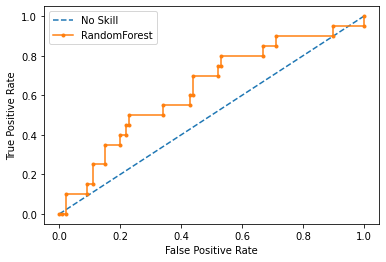

In [ ]:
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='RandomForest')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.198060, G-Mean=0.626


# Fit JobTraining

In [ ]:
X_train, X_CV, y_train, y_CV = train_test_split(background.loc[train.index] , train, test_size=0.10, random_state=42)

variable = 'jobTraining'

# Let's drop instances where the response is NA
y_train = y_train[variable].dropna()
X_train = X_train.loc[y_train.index.values]



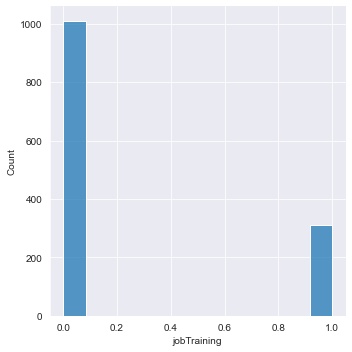

In [ ]:
sns.set_style('darkgrid')
sns.displot(data=y_train)

### Logistic Regression

In [ ]:
from sklearn.linear_model import SGDClassifier

#SGDClassifier(loss='log', penalty='elasticnet', max_iter=10000)

In [ ]:
sgd = SGDClassifier(loss='log', penalty='elasticnet', max_iter=10000)
pipeline = Pipeline(steps=[('impute', SimpleImputer()),
                           ('sampling', SMOTE()),
                           ('normalize', "passthrough"), 
                           ('sgd', sgd)])

params = {'normalize': [RobustScaler()], 
         'sgd__alpha' : np.arange(0.01, 2.01, 0.01),
         'sgd__l1_ratio': np.arange(0.00, 1.01, 0.01)}

In [ ]:
model = RandomizedSearchCV(pipeline, param_distributions= params, n_iter=200, n_jobs=1, verbose=10, scoring='neg_brier_score', cv = 4)

model.fit(X_train, y_train)

joblib_file = "jobtrain_logr_200.pkl"
joblib.dump(model, joblib_file)

Fitting 4 folds for each of 200 candidates, totalling 800 fits
[CV 1/4; 1/200] START normalize=RobustScaler(), sgd__alpha=1.99, sgd__l1_ratio=0.06
[CV 1/4; 1/200] END normalize=RobustScaler(), sgd__alpha=1.99, sgd__l1_ratio=0.06; total time=  13.1s
[CV 2/4; 1/200] START normalize=RobustScaler(), sgd__alpha=1.99, sgd__l1_ratio=0.06
[CV 2/4; 1/200] END normalize=RobustScaler(), sgd__alpha=1.99, sgd__l1_ratio=0.06; total time=  23.8s
[CV 3/4; 1/200] START normalize=RobustScaler(), sgd__alpha=1.99, sgd__l1_ratio=0.06
[CV 3/4; 1/200] END normalize=RobustScaler(), sgd__alpha=1.99, sgd__l1_ratio=0.06; total time=  16.6s
[CV 4/4; 1/200] START normalize=RobustScaler(), sgd__alpha=1.99, sgd__l1_ratio=0.06
[CV 4/4; 1/200] END normalize=RobustScaler(), sgd__alpha=1.99, sgd__l1_ratio=0.06; total time=  15.5s
[CV 1/4; 2/200] START normalize=RobustScaler(), sgd__alpha=0.87, sgd__l1_ratio=0.62
[CV 1/4; 2/200] END normalize=RobustScaler(), sgd__alpha=0.87, sgd__l1_ratio=0.62; total time=  16.5s
[CV 2/4

['jobtrain_logr_200.pkl']

#### Find Optimal Threshold w/ Cross-val set

In [ ]:
sgd = SGDClassifier(loss='log', 
                    penalty='elasticnet', 
                    max_iter=10000, 
                    alpha=1.69, 
                    l1_ratio=0.55)
pipeline = Pipeline(steps=[('impute', SimpleImputer()),
                           ('sampling', SMOTE()),
                           ('normalize', RobustScaler()), 
                           ('sgd', sgd)])


In [ ]:
logistic = pipeline.fit(X_train, y_train)

In [ ]:
variable = 'jobTraining'
X_CV = background.loc[X_CV.index]
y_CV= y_CV[variable].dropna()

In [ ]:
X_CV = X_CV.loc[y_CV.index.values]

In [ ]:
layoff_elastic_pred = logistic.predict_proba(X_CV)[:, 1]

In [ ]:
fpr, tpr, thresholds = roc_curve(y_CV, layoff_elastic_pred)

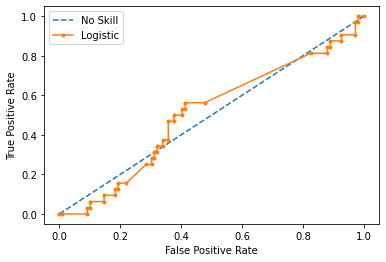

In [ ]:
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.571545, G-Mean=0.575


## Random Forest (SMOTE Upsampling)

In [ ]:
rfc = RandomForestClassifier(random_state=0)


In [ ]:
pipeline = Pipeline(steps=[('impute', SimpleImputer()),
                           ('sampling', SMOTE()), 
                           ('normalize', "passthrough"), 
                           ('randomforest', rfc)])

In [ ]:
max_features = ['auto']
n_estimators = np.arange(120, 251, 1)
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

In [ ]:
params={'randomforest__n_estimators': n_estimators, 
        'randomforest__max_depth': max_depth, 
       'randomforest__max_features': max_features,
       'randomforest__min_samples_split': min_samples_split,
        'randomforest__min_samples_leaf': min_samples_leaf,
       'normalize': [StandardScaler(), RobustScaler()]}

model = RandomizedSearchCV(pipeline, param_distributions= params, n_iter=200, n_jobs=1, verbose=10, scoring='neg_brier_score', cv = 4)

model.fit(X_train, y_train)

joblib_file = "jobtrain_rf_200_.pkl"
joblib.dump(model, joblib_file)

Fitting 4 folds for each of 200 candidates, totalling 800 fits
[CV 1/4; 1/200] START normalize=StandardScaler(), randomforest__max_depth=5, randomforest__max_features=auto, randomforest__min_samples_leaf=10, randomforest__min_samples_split=2, randomforest__n_estimators=129
[CV 1/4; 1/200] END normalize=StandardScaler(), randomforest__max_depth=5, randomforest__max_features=auto, randomforest__min_samples_leaf=10, randomforest__min_samples_split=2, randomforest__n_estimators=129; total time=   4.9s
[CV 2/4; 1/200] START normalize=StandardScaler(), randomforest__max_depth=5, randomforest__max_features=auto, randomforest__min_samples_leaf=10, randomforest__min_samples_split=2, randomforest__n_estimators=129
[CV 2/4; 1/200] END normalize=StandardScaler(), randomforest__max_depth=5, randomforest__max_features=auto, randomforest__min_samples_leaf=10, randomforest__min_samples_split=2, randomforest__n_estimators=129; total time=   4.1s
[CV 3/4; 1/200] START normalize=StandardScaler(), randomf

['jobtrain_rf_200_.pkl']

#### Find Optimal Threshold w/ Cross-val set

In [ ]:
rfc = RandomForestClassifier(random_state=0, 
                            n_estimators = 132, 
                            min_samples_split = 2, 
                            min_samples_leaf = 1, 
                            max_features = 'auto', 
                            max_depth = 25)

In [ ]:
pipeline = Pipeline(steps=[('impute', SimpleImputer()),
                           ('sampling', SMOTE()), 
                           ('normalize', StandardScaler()), 
                           ('randomforest', rfc)])

In [ ]:
rf = pipeline.fit(X_train, y_train)

In [ ]:
variable = 'jobTraining'
X_CV = background.loc[X_CV.index]
y_CV= y_CV[variable].dropna()


In [ ]:
X_CV = X_CV.loc[y_CV.index.values]

In [ ]:
jobtrain_rf_pred = rf.predict_proba(X_CV)[:, 1]

In [ ]:
fpr, tpr, thresholds = roc_curve(y_CV, jobtrain_rf_pred)

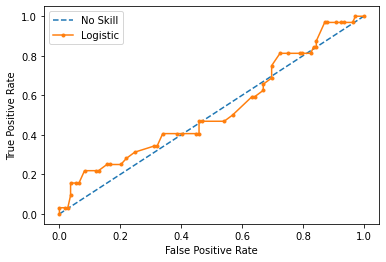

In [ ]:
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.310606, G-Mean=0.518


## XGBoost (SMOTE Upsampling)

In [ ]:
import joblib

In [ ]:
X_train, X_CV, y_train, y_CV = train_test_split(background.loc[train.index] , train, test_size=0.10, random_state=42)

variable = 'jobTraining'

# Let's drop instances where the response is NA
y_train = y_train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

X_train = X_train.apply(pd.to_numeric, errors='coerce', axis=1)

y_train = y_train.apply(pd.to_numeric, errors='coerce')

xg_reg = xgb.XGBClassifier(objective ='binary:logistic')

pipeline = Pipeline(steps=[('impute', SimpleImputer()),
                           ('sampling', SMOTE()),
                           ('normalize', MinMaxScaler()), 
                           ('feat_select', SelectKBest(f_classif)),
                           ('xgboost', xg_reg)])



n_estimators = np.arange(100, 300, 10)
max_depth = np.arange(3, 12, 1)
min_child_weight = np.arange(1, 8, 1)
gamma = np.arange(0.00, 2, 0.01),
learning_rate = np.arange(0.01,0.3,0.0005)
subsample = np.arange(0.2, 0.8, 0.1)
colsample_bylevel = np.round(np.arange(0.1,1.0,0.01))
colsample_bytree = np.arange(0.3, 1, 0.1)
alpha = np.arange(0, 1, 0.1)

params={'xgboost__n_estimators': n_estimators, 
        'xgboost__max_depth': max_depth, 
        'xgboost__min_child_weight': min_child_weight,
       'xgboost__gamma': np.arange(0.00, 2, 0.01),
       'xgboost__learning_rate': learning_rate,
        'xgboost__subsample': subsample,
       'xgboost__colsample_bylevel': colsample_bylevel,
       'xgboost__colsample_bytree': colsample_bytree,
       'feat_select__k': np.arange(10, 15000, 100),
       "impute__strategy": ['mean', 'median']}


            
            
model = RandomizedSearchCV(pipeline, param_distributions= params, n_iter=200, n_jobs=1, verbose=10, scoring='neg_brier_score', cv = 4)

model.fit(X_train, y_train)

joblib_file = "jobtrain_xgb_200.pkl"
joblib.dump(model, joblib_file)

KeyboardInterrupt: 

#### Find Optimal Threshold w/ Cross-val set

In [ ]:

xg_reg = xgb.XGBClassifier(objective ='binary:logistic', 
                           subsample = 0.7, 
                          n_estimators = 130, 
                          min_child_weight = 1, 
                          max_depth = 4, 
                          learning_rate = 0.03, 
                          gamma = 1.95, 
                          colsample_bytree = 0.6, 
                          colsample_bylevel = 1)

pipeline = Pipeline(steps=[('impute', SimpleImputer(strategy = 'median')),
                           ('normalize', MinMaxScaler()), 
                           ('feat_select', SelectKBest(f_classif, k = 2210)),
                           ('xgboost', xg_reg)])




In [ ]:
xgb = pipeline.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  669   783   809 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:59:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
variable = 'jobTraining'
X_CV = background.loc[X_CV.index]
y_CV= y_CV[variable].dropna()


In [ ]:
X_CV = X_CV.loc[y_CV.index.values]

In [ ]:
jobtrain_xgb_pred = xgb.predict_proba(X_CV)[:, 1]

In [ ]:
fpr, tpr, thresholds = roc_curve(y_CV, jobtrain_xgb_pred)

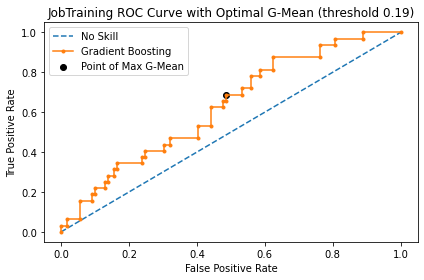

TypeError: savefig() missing 1 required positional argument: 'fname'

<Figure size 432x288 with 0 Axes>

In [ ]:
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Gradient Boosting')
# axis labels
pyplot.title("JobTraining ROC Curve with Optimal G-Mean (threshold 0.19)")
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Point of Max G-Mean')
pyplot.legend()
# show the plot
pyplot.tight_layout()
pyplot.show()

In [ ]:
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.196602, G-Mean=0.594


# GET TEST SCORES

In [ ]:
#background.to_csv('cleaned_background.csv', index=True)
background = pd.read_csv('cleaned_background.csv')

background.set_index('challengeID', inplace=True)

In [ ]:
train = pd.read_csv('FFChallenge_v5/train.csv', sep=',', header=0, index_col=0)
test = pd.read_csv('FFChallenge_v5/test.csv', sep=',', header=0, index_col=0)



# GPA

## Elastic

In [ ]:
model = joblib.load('models/gpa_el_500.pkl')

In [ ]:
model.best_params_

{'model__regressor__preprocess__strategy': 'median',
 'model__regressor__elastic__l1_ratio': 0.20999999999999996,
 'model__regressor__elastic__alpha': 1000}

In [ ]:
variable = 'gpa'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
elastic = ElasticNet(random_state=0, max_iter = 10000, l1_ratio=0.2, alpha=1000.0)

pipeline = Pipeline(steps=[('preprocess', SimpleImputer(strategy='median')), ('scaler', 'passthrough'), ('elastic', elastic)])

model_pipe = Pipeline([('model', TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler()))])


In [ ]:
elastic_fit = model_pipe.fit(X_train, y_train)

In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
y_pred = elastic_fit.predict(X_test)

In [ ]:
mean_squared_error(y_test,y_pred)

0.3857494061289718

In [ ]:
r2_score(y_test,y_pred)

0.08667317030809574

## Random Forest

In [ ]:
model = joblib.load('models/gpa_rf_rs200_model.pkl')

In [ ]:
model.best_params_

{'model__regressor__sel__k': 10000,
 'model__regressor__randomforest__n_estimators': 253,
 'model__regressor__randomforest__min_samples_split': 26,
 'model__regressor__randomforest__min_samples_leaf': 5,
 'model__regressor__randomforest__max_features': 'auto',
 'model__regressor__randomforest__max_depth': 27,
 'model__regressor__preprocess__strategy': 'mean'}

In [ ]:
variable = 'gpa'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
rf = RandomForestRegressor(random_state=0, 
                           n_estimators=253, 
                           min_samples_split=26, 
                           min_samples_leaf=5, 
                           max_features='auto', 
                          max_depth=27)

In [ ]:
selector_k_best = SelectKBest(score_func=f_regression, k=10000)
pipeline = Pipeline(steps=[('preprocess', SimpleImputer(strategy='mean')), 
                           ('normalize', StandardScaler()),
                           ('sel', selector_k_best),
                            ('randomforest', rf)])

In [ ]:
model_pipe = Pipeline([('model', TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler()))])

In [ ]:
random_forest = model_pipe.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
y_pred = random_forest.predict(X_test)

In [ ]:
mean_squared_error(y_test,y_pred)

0.35164833590418565

In [ ]:
r2_score(y_test,y_pred)

0.1674132099883947

## Gradient Boosting

In [ ]:
model = joblib.load('models/gpa_xgb_200_.pkl')

In [ ]:
model.best_params_

{'model__regressor__xgboost__subsample': 0.5000000000000001,
 'model__regressor__xgboost__n_estimators': 160,
 'model__regressor__xgboost__min_child_weight': 6,
 'model__regressor__xgboost__max_depth': 7,
 'model__regressor__xgboost__learning_rate': 0.02100000000000001,
 'model__regressor__xgboost__gamma': 0.19,
 'model__regressor__xgboost__colsample_bytree': 0.8000000000000003,
 'model__regressor__xgboost__colsample_bylevel': 1.0,
 'model__regressor__sel__k': 13110,
 'model__regressor__normalize': RobustScaler(),
 'model__regressor__impute__strategy': 'median'}

In [ ]:
variable = 'gpa'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
selector_k_best = SelectKBest(score_func=f_regression, k = 13110)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          subsample=0.5, 
                          n_estimators=160, 
                         min_child_weight=6,
                         max_depth=7,
                         learning_rate = 0.02,
                         gamma = 0.19, 
                         colsample_bytree = 0.8, 
                         colsample_bylevel = 1.0)

pipeline = Pipeline(steps=[('impute', SimpleImputer(strategy='mean')), ('normalize', RobustScaler()), ('sel', selector_k_best), ('xgboost', xg_reg)])

model_pipe = Pipeline([('model', TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler()))])

In [ ]:
boosting = model_pipe.fit(X_train, y_train)

invalid value encountered in true_divide


KeyboardInterrupt: 

In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
y_pred = boosting.predict(X_test)

In [ ]:
mean_squared_error(y_test,y_pred)

In [ ]:
r2_score(y_test,y_pred)

0.18412109625667683

### SHAP

In [ ]:
import shap

In [ ]:
variable = 'gpa'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
#fill NAs 
means_train = X_train.mean()
X_train = X_train.fillna(means_train)
X_test = X_test.fillna(means_train)

#minmaxscaler on X_values
robust = RobustScaler()
X_train = robust.fit_transform(X_train)
X_test = robust.transform(X_test)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          subsample=0.5, 
                          n_estimators=160, 
                         min_child_weight=6,
                         max_depth=7,
                         learning_rate = 0.02,
                         gamma = 0.19, 
                         colsample_bytree = 0.8, 
                         colsample_bylevel = 1.0)

In [ ]:
yscale = StandardScaler()
y_train_trans = yscale.fit_transform(np.array(y_train).reshape(len(y_train), 1))

In [ ]:
xg_reg.fit(X_train, y_train_trans)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0.19, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.02, max_delta_step=0, max_depth=7,
             min_child_weight=6, missing=nan, monotone_constraints='()',
             n_estimators=160, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
mybooster = xg_reg.get_booster()    

In [ ]:
model_bytearray = mybooster.save_raw()[4:]

In [ ]:
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

In [ ]:
shap_ex = shap.TreeExplainer(mybooster)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


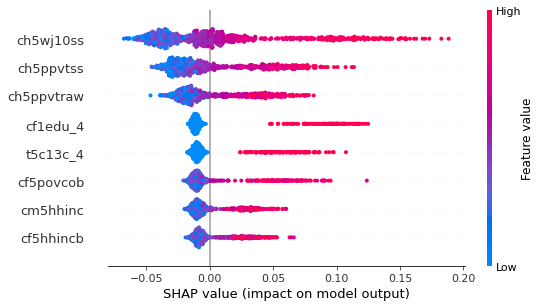

In [ ]:
shap_values = shap_ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=list(background), max_display=8)

# Grit

## Elastic

In [ ]:
model = joblib.load('models/grit_el_200.pkl')

In [ ]:
model.best_params_

{'model__regressor__scaler': RobustScaler(),
 'model__regressor__preprocess__strategy': 'median',
 'model__regressor__elastic__l1_ratio': 0.9099999999999996,
 'model__regressor__elastic__alpha': 1400}

In [ ]:
variable = 'grit'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
elastic = ElasticNet(random_state=0, max_iter = 10000, l1_ratio=0.9, alpha=1400.0)

pipeline = Pipeline(steps=[('preprocess', SimpleImputer(strategy='median')), ('scaler', 'passthrough'), ('elastic', elastic)])

model_pipe = Pipeline([('model', TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler()))])


In [ ]:
grit_elastic = model_pipe.fit(X_train, y_train)

In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
grit_pred_elastic = grit_elastic.predict(X_test)

In [ ]:
mean_squared_error(y_test,grit_pred_elastic)

0.2515700337325141

In [ ]:
r2_score(y_test,grit_pred_elastic)

0.005350114140940443

## Random Forest 

In [ ]:
model = joblib.load('models/gpa_rf_rs200_model.pkl')

In [ ]:
model.best_params_

{'model__regressor__scaler': RobustScaler(),
 'model__regressor__preprocess__strategy': 'median',
 'model__regressor__elastic__l1_ratio': 0.9099999999999996,
 'model__regressor__elastic__alpha': 1400}

In [ ]:
variable = 'gpa'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
rf = RandomForestRegressor(random_state=0, 
                           n_estimators=253, 
                           min_samples_split=26, 
                           min_samples_leaf=5, 
                           max_features='auto', 
                          max_depth=27)

In [ ]:
selector_k_best = SelectKBest(score_func=f_regression, k=10000)
pipeline = Pipeline(steps=[('preprocess', SimpleImputer(strategy='mean')), 
                           ('normalize', StandardScaler()),
                           ('sel', selector_k_best),
                            ('randomforest', rf)])

In [ ]:
model_pipe = Pipeline([('model', TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler()))])

In [ ]:
random_forest = model_pipe.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
y_pred = random_forest.predict(X_test)

In [ ]:
mean_squared_error(y_test,y_pred)

0.35164833590418565

In [ ]:
r2_score(y_test, y_pred)

0.1674132099883947

## Gradient Boosting

In [ ]:
model = joblib.load('models/grit_xgb_200_.pkl')

In [ ]:
model.best_params_

{'model__regressor__xgboost__subsample': 0.7000000000000002,
 'model__regressor__xgboost__n_estimators': 130,
 'model__regressor__xgboost__min_child_weight': 2,
 'model__regressor__xgboost__max_depth': 6,
 'model__regressor__xgboost__learning_rate': 0.01850000000000001,
 'model__regressor__xgboost__gamma': 1.6600000000000001,
 'model__regressor__xgboost__colsample_bytree': 0.3,
 'model__regressor__xgboost__colsample_bylevel': 1.0,
 'model__regressor__sel__k': 910,
 'model__regressor__normalize': RobustScaler(),
 'model__regressor__impute__strategy': 'median'}

In [ ]:
variable = 'grit'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
selector_k_best = SelectKBest(score_func=f_regression, k = 5000)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          subsample=0.7, 
                          n_estimators=130, 
                         min_child_weight=2,
                         max_depth=6,
                         learning_rate = 0.018,
                         gamma = 1.66, 
                         colsample_bytree = 0.3, 
                         colsample_bylevel = 1.0)

pipeline = Pipeline(steps=[('impute', SimpleImputer(strategy='median')), ('normalize', RobustScaler()), ('sel', selector_k_best), ('xgboost', xg_reg)])

model_pipe = Pipeline([('model', TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler()))])

In [ ]:
boosting = model_pipe.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
grit_boosing_pred = boosting.predict(X_test)

In [ ]:
mean_squared_error(y_test,grit_boosing_pred)

0.2381845612902674

In [ ]:
r2_score(y_test, grit_boosing_pred)

0.058273184664540234

In [ ]:
import shap

In [ ]:
variable = 'grit'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
#fill NAs 
means_train = X_train.mean()
X_train = X_train.fillna(means_train)
X_test = X_test.fillna(means_train)


#minmaxscaler on X_values
robust = RobustScaler()
X_train = robust.fit_transform(X_train)
X_test = robust.transform(X_test)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          subsample=0.7, 
                          n_estimators=130, 
                         min_child_weight=2,
                         max_depth=6,
                         learning_rate = 0.018,
                         gamma = 1.66, 
                         colsample_bytree = 0.3, 
                         colsample_bylevel = 1.0)

In [ ]:
yscale = StandardScaler()
y_train_trans = yscale.fit_transform(np.array(y_train).reshape(len(y_train), 1))

In [ ]:
xg_reg.fit(X_train, y_train_trans)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
             colsample_bynode=1, colsample_bytree=0.3, gamma=1.66, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.018, max_delta_step=0, max_depth=6,
             min_child_weight=2, missing=nan, monotone_constraints='()',
             n_estimators=130, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
mybooster = xg_reg.get_booster()    

In [ ]:
model_bytearray = mybooster.save_raw()[4:]

In [ ]:
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

In [ ]:
shap_ex = shap.TreeExplainer(mybooster)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


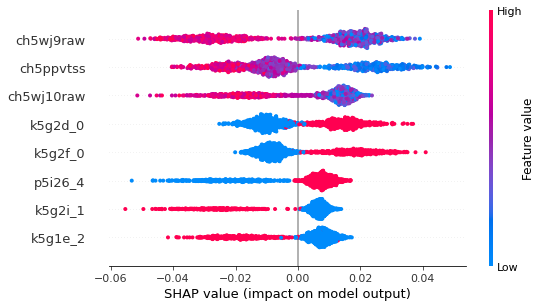

In [ ]:
shap_values = shap_ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=list(background), max_display=8, )

# Material Hardship

## Elastic

In [ ]:
model = joblib.load('models/material_el_not_quant_200.pkl')

In [ ]:
model.best_params_

{'model__regressor__scaler': RobustScaler(),
 'model__regressor__preprocess__strategy': 'median',
 'model__regressor__elastic__l1_ratio': 0.7499999999999997,
 'model__regressor__elastic__alpha': 100}

In [ ]:
variable = 'materialHardship'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
elastic = ElasticNet(random_state=0, max_iter = 10000, l1_ratio=0.75, alpha=100.0)

pipeline = Pipeline(steps=[('preprocess', SimpleImputer(strategy='median')), ('scaler', RobustScaler()), ('elastic', elastic)])

model_pipe = Pipeline([('model', TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler()))])


In [ ]:
material_elastic = model_pipe.fit(X_train, y_train)

In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
material_pred_elastic = material_elastic.predict(X_test)

In [ ]:
mean_squared_error(y_test,material_pred_elastic)

0.023973118505334984

In [ ]:
r2_score(y_test,material_pred_elastic)

0.03441371908897606

## Random Forest

In [ ]:
model = joblib.load('models/material_rf_200.pkl')

In [ ]:
model.best_params_

{'model__regressor__sel__k': 5000,
 'model__regressor__randomforest__n_estimators': 238,
 'model__regressor__randomforest__min_samples_split': 8,
 'model__regressor__randomforest__min_samples_leaf': 8,
 'model__regressor__randomforest__max_features': 'auto',
 'model__regressor__randomforest__max_depth': 16,
 'model__regressor__preprocess__strategy': 'median',
 'model__regressor__normalize': StandardScaler()}

In [ ]:
variable = 'materialHardship'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
rf = RandomForestRegressor(random_state=0, 
                           n_estimators=238, 
                           min_samples_split=8, 
                           min_samples_leaf=8, 
                           max_features='auto', 
                          max_depth=16)

In [ ]:
selector_k_best = SelectKBest(score_func=f_regression, k=5000)
pipeline = Pipeline(steps=[('preprocess', SimpleImputer(strategy='mean')), 
                           ('normalize', StandardScaler()),
                           ('sel', selector_k_best),
                            ('randomforest', rf)])

In [ ]:
model_pipe = Pipeline([('model', TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler()))])

In [ ]:
material_random_forest = model_pipe.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
material_rf_pred = material_random_forest.predict(X_test)

In [ ]:
mean_squared_error(y_test,material_rf_pred)

0.019792665783870386

In [ ]:
r2_score(y_test,material_rf_pred)

0.20279347305986906

### SHAP

In [ ]:
import shap

In [ ]:
variable = 'materialHardship'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
#fill NAs 
means_train = X_train.mean()
X_train = X_train.fillna(means_train)
X_test = X_test.fillna(means_train)


#minmaxscaler on X_values
robust = RobustScaler()
X_train = robust.fit_transform(X_train)
X_test = robust.transform(X_test)

rf = RandomForestRegressor(random_state=0, 
                           n_estimators=238, 
                           min_samples_split=8, 
                           min_samples_leaf=8, 
                           max_features='auto', 
                          max_depth=16)

In [ ]:
yscale = StandardScaler()
y_train_trans = yscale.fit_transform(np.array(y_train).reshape(len(y_train), 1))

In [ ]:
rf.fit(X_train, y_train_trans)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor(max_depth=16, min_samples_leaf=8, min_samples_split=8,
                      n_estimators=238, random_state=0)

In [ ]:
shap_ex = shap.TreeExplainer(rf)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


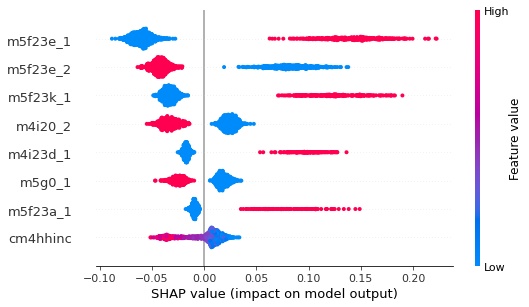

In [ ]:
shap_values = shap_ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=list(background), max_display=8)

## Gradient Boosting

In [ ]:
model = joblib.load('models/material_xgb_200_.pkl')

In [ ]:
model.best_params_

{'model__regressor__xgboost__subsample': 0.6000000000000001,
 'model__regressor__xgboost__n_estimators': 180,
 'model__regressor__xgboost__min_child_weight': 7,
 'model__regressor__xgboost__max_depth': 10,
 'model__regressor__xgboost__learning_rate': 0.05250000000000004,
 'model__regressor__xgboost__gamma': 1.46,
 'model__regressor__xgboost__colsample_bytree': 0.6000000000000001,
 'model__regressor__xgboost__colsample_bylevel': 1.0,
 'model__regressor__sel__k': 5810,
 'model__regressor__normalize': RobustScaler(),
 'model__regressor__impute__strategy': 'mean'}

In [ ]:
variable = 'materialHardship'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
selector_k_best = SelectKBest(score_func=f_regression, k = 5810)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          subsample=0.6, 
                          n_estimators=180, 
                         min_child_weight=7,
                         max_depth=10,
                         learning_rate = 0.05,
                         gamma = 1.46, 
                         colsample_bytree = 0.6, 
                         colsample_bylevel = 1.0)

pipeline = Pipeline(steps=[('impute', SimpleImputer(strategy='median')), ('normalize', RobustScaler()), ('sel', selector_k_best), ('xgboost', xg_reg)])

model_pipe = Pipeline([('model', TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler()))])

In [ ]:
boosting = model_pipe.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
material_boosing_pred = boosting.predict(X_test)

In [ ]:
mean_squared_error(y_test,material_boosing_pred)

0.01993581223855128

In [ ]:
r2_score(y_test,material_boosing_pred)

0.19702783798948142

# Eviction

In [ ]:
from sklearn.linear_model import SGDClassifier
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import median_absolute_error, r2_score, brier_score_loss



## Elastic

In [ ]:
model = joblib.load('models/evic_logist_200.pkl')

In [ ]:
model.best_params_

{'sgd__l1_ratio': 0.0, 'sgd__alpha': 0.03, 'normalize': MinMaxScaler()}

In [ ]:
variable = 'eviction'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
sgd = SGDClassifier(loss='log', penalty='elasticnet', max_iter=10000, alpha=0.03, l1_ratio=0.0)
pipeline = Pipeline(steps=[('impute', SimpleImputer()),
                           ('sampling', SMOTE()),
                           ('normalize', StandardScaler()), 
                           ('sgd', sgd)])


In [ ]:
logistic = pipeline.fit(X_train, y_train)

In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
y_test = np.array(y_test * 1).astype(int)

In [ ]:
eviction_elastic_pred = logistic.predict_proba(X_test)[:, 1]

In [ ]:
brier_score_loss(y_test,eviction_elastic_pred)

0.06504720600736875

In [ ]:
from sklearn.metrics import recall_score, precision_score


In [ ]:
binary_label = (eviction_elastic_pred >= 0.5) * 1

In [ ]:
recall_score(y_test, binary_label)

0.06153846153846154

In [ ]:
precision_score(y_test, binary_label)

0.19047619047619047

## Random Forest

In [ ]:
model = joblib.load('models/evic_rf_200.pkl')

In [ ]:
model.best_params_

{'randomforest__n_estimators': 234,
 'randomforest__min_samples_split': 5,
 'randomforest__min_samples_leaf': 1,
 'randomforest__max_features': 'auto',
 'randomforest__max_depth': 25,
 'normalize': StandardScaler()}

In [ ]:
variable = 'eviction'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
rfc = RandomForestClassifier(random_state=0,
                            n_estimators=234,
                            min_samples_split=5, 
                            min_samples_leaf= 1, 
                            max_features = 'auto',
                            max_depth = 25, 
                            )



In [ ]:
pipeline = Pipeline(steps=[('impute', SimpleImputer()),
                           ('sampling', SMOTE()), 
                           ('normalize', StandardScaler()), 
                           ('randomforest', rfc)])

In [ ]:
random_forest = pipeline.fit(X_train, y_train)

In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
y_test = np.array(y_test * 1).astype(int)

In [ ]:
eviction_rf_pred = random_forest.predict_proba(X_test)[:, 1]

In [ ]:
brier_score_loss(y_test,eviction_rf_pred)

0.054969106819128616

In [ ]:
binary_label = (eviction_rf_pred >= 0.5) * 1

In [ ]:
recall_score(y_test, binary_label)

0.0

In [ ]:
precision_score(y_test, binary_label)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

## Gradient Boosting

In [ ]:
model = joblib.load('models/evic_xgb_200.pkl')

In [ ]:
model.best_params_

{'xgboost__subsample': 0.4000000000000001,
 'xgboost__n_estimators': 230,
 'xgboost__min_child_weight': 7,
 'xgboost__max_depth': 3,
 'xgboost__learning_rate': 0.03350000000000002,
 'xgboost__gamma': 1.52,
 'xgboost__colsample_bytree': 0.7000000000000002,
 'xgboost__colsample_bylevel': 1.0,
 'impute__strategy': 'median',
 'feat_select__k': 7210}

In [ ]:
variable = 'eviction'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:

xg_reg = xgb.XGBClassifier(objective ='binary:logistic', 
                           subsample = 0.4, 
                          n_estimators = 230, 
                          min_child_weight = 7, 
                          max_depth = 3, 
                          learning_rate = 0.03, 
                          gamma = 1.52, 
                          colsample_bytree = 0.7, 
                          colsample_bylevel = 1)

pipeline = Pipeline(steps=[('impute', SimpleImputer(strategy = 'median')),
                           ('normalize', MinMaxScaler()), 
                           ('feat_select', SelectKBest(f_classif, k = 7210)),
                           ('xgboost', xg_reg)])



In [ ]:
boosting = pipeline.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  809   813   834 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:43:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
y_test = np.array(y_test * 1).astype(int)

In [ ]:
eviction_boosting_pred = boosting.predict_proba(X_test)[:, 1]

In [ ]:
brier_score_loss(y_test,eviction_boosting_pred)

0.0525810424580952

In [ ]:
binary_label = (eviction_boosting_pred >= 0.18) * 1

In [ ]:
recall_score(y_test, binary_label)

0.15384615384615385

In [ ]:
precision_score(y_test, binary_label)

0.18518518518518517

In [ ]:
import shap

In [ ]:
import shap

In [ ]:
variable = 'eviction'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
#fill NAs 
means_train = X_train.mean()
X_train = X_train.fillna(means_train)
X_test = X_test.fillna(means_train)

#minmaxscaler on X_values
minmax = MinMaxScaler()
X_train = minmax.fit_transform(X_train)
X_test = minmax.transform(X_test)

xg_reg = xgb.XGBClassifier(objective ='binary:logistic', 
                           subsample = 0.4, 
                          n_estimators = 230, 
                          min_child_weight = 7, 
                          max_depth = 3, 
                          learning_rate = 0.03, 
                          gamma = 1.52, 
                          colsample_bytree = 0.7, 
                          colsample_bylevel = 1)

In [ ]:
yscale = StandardScaler()
y_train_trans = yscale.fit_transform(np.array(y_train).reshape(len(y_train), 1))

In [ ]:
xg_reg.fit(X_train, y_train_trans)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[21:48:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=1.52, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.03, max_delta_step=0, max_depth=3,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=230, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.4,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
mybooster = xg_reg.get_booster()    

In [ ]:
model_bytearray = mybooster.save_raw()[4:]

In [ ]:
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

In [ ]:
shap_ex = shap.TreeExplainer(mybooster)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [ ]:
vals= np.abs(shap_values).mean(0)

In [ ]:
vals

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [ ]:
feature_importance = pd.DataFrame(list(zip(background.columns,vals)),columns=['Feature Name','Feature Importance Value'])
feature_importance.sort_values(by=['Feature Importance Value'],ascending=False,inplace=True)
feature_importance.set_index("Feature Name", inplace=True)


In [ ]:
print(feature_importance.iloc[0:8].to_latex())

\begin{tabular}{lr}
\toprule
{} &  Feature Importance Value \\
Feature Name &                           \\
\midrule
m5f23c\_1     &                  0.196777 \\
m5f23k\_1     &                  0.155438 \\
p5j10        &                  0.070845 \\
f3r4\_1       &                  0.062510 \\
m3i6a\_1      &                  0.055637 \\
m1j2b        &                  0.051535 \\
m5f7b\_1      &                  0.050427 \\
p3m18a\_2     &                  0.049570 \\
\bottomrule
\end{tabular}



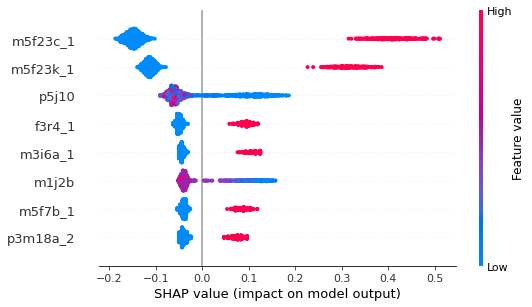

In [ ]:
shap_values = shap_ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=list(background), max_display=8)

# Layoff

## Elastic

In [ ]:
model = joblib.load('models/layoff_logr_200.pkl')

In [ ]:
model.best_params_

{'sgd__l1_ratio': 0.55, 'sgd__alpha': 1.69, 'normalize': RobustScaler()}

In [ ]:
variable = 'layoff'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
sgd = SGDClassifier(loss='log', 
                    penalty='elasticnet', 
                    max_iter=10000, 
                    alpha=1.69, 
                    l1_ratio=0.55)

pipeline = Pipeline(steps=[('impute', SimpleImputer()),
                           ('sampling', SMOTE()),
                           ('normalize', RobustScaler()), 
                           ('sgd', sgd)])


In [ ]:
logistic = pipeline.fit(X_train, y_train)

In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
y_test = np.array(y_test * 1).astype(int)

In [ ]:
layoff_elastic_pred = logistic.predict_proba(X_test)[:, 1]

In [ ]:
brier_score_loss(y_test,layoff_elastic_pred)

0.37631747835399165

In [ ]:
binary_label = (layoff_elastic_pred >= 0.5) * 1

In [ ]:
recall_score(y_test, binary_label)

0.5118483412322274

In [ ]:
precision_score(y_test, binary_label)

0.21428571428571427

## Random Forest

In [ ]:
model = joblib.load('layoff_200_rf.pkl')

In [ ]:
model.best_params_

{'sel__k': 11710,
 'randomforest__n_estimators': 150,
 'randomforest__min_samples_split': 2,
 'randomforest__min_samples_leaf': 2,
 'randomforest__max_features': 'auto',
 'randomforest__max_depth': 15,
 'normalize': StandardScaler()}

In [ ]:
variable = 'layoff'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
rfc = RandomForestClassifier(random_state=0, 
                            n_estimators = 150, 
                            min_samples_split = 2, 
                            min_samples_leaf = 2, 
                            max_features = 'auto', 
                            max_depth = 15)

In [ ]:
selector_k_best = SelectKBest(score_func=f_classif, k = 11710)


pipeline = Pipeline(steps=[('impute', SimpleImputer()),
                           ('sampling', SMOTE()), 
                           ('normalize', "passthrough"),
                           ('sel', selector_k_best),
                           ('randomforest', rfc)])

In [ ]:
rf = pipeline.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  809   813   834 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
y_test = np.array(y_test * 1).astype(int)

In [ ]:
layoff_rf_pred = rf.predict_proba(X_test)[:, 1]

In [ ]:
brier_score_loss(y_test,layoff_rf_pred)

0.16826965167406932

In [ ]:
binary_label = (layoff_rf_pred >= 0.5) * 1

In [ ]:
recall_score(y_test, binary_label)

0.0

In [ ]:
precision_score(y_test, binary_label)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

## Gradient Boosting

In [ ]:
model = joblib.load('models/layoff_xgb_200.pkl')

In [ ]:
model.best_params_

{'xgboost__subsample': 0.5000000000000001,
 'xgboost__n_estimators': 290,
 'xgboost__min_child_weight': 5,
 'xgboost__max_depth': 8,
 'xgboost__learning_rate': 0.09750000000000007,
 'xgboost__gamma': 1.44,
 'xgboost__colsample_bytree': 0.3,
 'xgboost__colsample_bylevel': 0.0,
 'impute__strategy': 'mean',
 'feat_select__k': 6010}

In [ ]:
variable = 'layoff'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:

xg_reg = xgb.XGBClassifier(objective ='binary:logistic', 
                           subsample = 0.5, 
                          n_estimators = 290, 
                          min_child_weight = 5, 
                          max_depth = 8, 
                          learning_rate = 0.097, 
                          gamma = 1.44, 
                          colsample_bytree = 0.3, 
                          colsample_bylevel = 0)

pipeline = Pipeline(steps=[('impute', SimpleImputer(strategy = 'mean')),
                           ('normalize', MinMaxScaler()), 
                           ('feat_select', SelectKBest(f_classif, k = 6010)),
                           ('xgboost', xg_reg)])



In [ ]:
boosting = pipeline.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  809   813   834 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:46:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
y_test = np.array(y_test * 1).astype(int)

In [ ]:
layoff_boosting_pred = boosting.predict_proba(X_test)[:, 1]

In [ ]:
brier_score_loss(y_test,layoff_boosting_pred)

0.16693356536060125

In [ ]:
binary_label = (layoff_boosting_pred >= 0.5) * 1

In [ ]:
recall_score(y_test, binary_label)

0.0

In [ ]:
precision_score(y_test, binary_label)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [ ]:
import shap

In [ ]:
variable = 'layoff'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
#fill NAs 
means_train = X_train.mean()
X_train = X_train.fillna(means_train)
X_test = X_test.fillna(means_train)

#minmaxscaler on X_values
minmax = MinMaxScaler()
X_train = minmax.fit_transform(X_train)
X_test = minmax.transform(X_test)

xg_reg = xgb.XGBClassifier(objective ='binary:logistic', 
                           subsample = 0.5, 
                          n_estimators = 290, 
                          min_child_weight = 5, 
                          max_depth = 8, 
                          learning_rate = 0.097, 
                          gamma = 1.44, 
                          colsample_bytree = 0.3, 
                          colsample_bylevel = 0)

In [ ]:
yscale = StandardScaler()
y_train_trans = yscale.fit_transform(np.array(y_train).reshape(len(y_train), 1))

In [ ]:
xg_reg.fit(X_train, y_train_trans)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:07:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0,
              colsample_bynode=1, colsample_bytree=0.3, gamma=1.44, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.097, max_delta_step=0, max_depth=8,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=290, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
mybooster = xg_reg.get_booster()    

In [ ]:
model_bytearray = mybooster.save_raw()[4:]

In [ ]:
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

In [ ]:
shap_ex = shap.TreeExplainer(mybooster)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


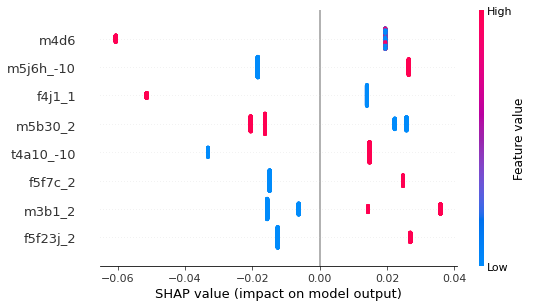

In [ ]:
shap_values = shap_ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=list(background), max_display=8)

# JobTraining

## Elastic

In [ ]:
model = joblib.load('models/jobtrain_logr_200.pkl')

In [ ]:
model.best_params_

{'sgd__l1_ratio': 0.66,
 'sgd__alpha': 1.9200000000000002,
 'normalize': RobustScaler()}

In [ ]:
variable = 'jobTraining'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
sgd = SGDClassifier(loss='log', 
                    penalty='elasticnet', 
                    max_iter=10000, 
                    alpha=1.92, 
                    l1_ratio=0.66)
pipeline = Pipeline(steps=[('impute', SimpleImputer()),
                           ('sampling', SMOTE()),
                           ('normalize', RobustScaler()), 
                           ('sgd', sgd)])


In [ ]:
logistic = pipeline.fit(X_train, y_train)

In [ ]:
variable = 'jobTraining'
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
y_test = np.array(y_test * 1).astype(int)

In [ ]:
len(y_test)

1104

In [ ]:
jobtrain_elastic_pred = logistic.predict_proba(X_test)[:, 1]

In [ ]:
brier_score_loss(y_test,jobtrain_elastic_pred)

0.2252425795452132

In [ ]:
binary_label = (jobtrain_elastic_pred >= 0.5) * 1

In [ ]:
recall_score(y_test, binary_label)

0.2952029520295203

In [ ]:
precision_score(y_test, binary_label)

0.3292181069958848

## Random Forest

In [ ]:
model = joblib.load('models/jobtrain_rf_new200_.pkl')

In [ ]:
model.best_params_

{'sel__k': 11710,
 'randomforest__n_estimators': 150,
 'randomforest__min_samples_split': 2,
 'randomforest__min_samples_leaf': 2,
 'randomforest__max_features': 'auto',
 'randomforest__max_depth': 15,
 'normalize': StandardScaler()}

In [ ]:
variable = 'layoff'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
rfc = RandomForestClassifier(random_state=0, 
                            n_estimators = 132, 
                            min_samples_split = 2, 
                            min_samples_leaf = 1, 
                            max_features = 'auto', 
                            max_depth = 25)

In [ ]:
pipeline = Pipeline(steps=[('impute', SimpleImputer()),
                           ('sampling', SMOTE()), 
                           ('normalize', StandardScaler()), 
                           ('randomforest', rfc)])

In [ ]:
rf = pipeline.fit(X_train, y_train)

In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
y_test = np.array(y_test * 1).astype(int)

In [ ]:
layoff_rf_pred = rf.predict_proba(X_test)[:, 1]

In [ ]:
brier_score_loss(y_test,layoff_rf_pred)

0.16921346649667565

In [ ]:
binary_label = (layoff_rf_pred >= 0.5) * 1

In [ ]:
recall_score(y_test, binary_label)

0.0

In [ ]:
precision_score(y_test, binary_label)

0.0

In [ ]:
import shap

In [ ]:
variable = 'jobTraining'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
#fill NAs 
means_train = X_train.mean()
X_train = X_train.fillna(means_train)
X_test = X_test.fillna(means_train)


#minmaxscaler on X_values
robust = RobustScaler()
X_train = robust.fit_transform(X_train)
X_test = robust.transform(X_test)

rfc = RandomForestClassifier(random_state=0, 
                            n_estimators = 132, 
                            min_samples_split = 2, 
                            min_samples_leaf = 1, 
                            max_features = 'auto', 
                            max_depth = 25)

In [ ]:
yscale = StandardScaler()
y_train_trans = yscale.fit_transform(np.array(y_train).reshape(len(y_train), 1))

In [ ]:
rf.fit(X_train, y_train_trans)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor(max_depth=16, min_samples_leaf=8, min_samples_split=8,
                      n_estimators=238, random_state=0)

In [ ]:
shap_ex = shap.TreeExplainer(rf)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


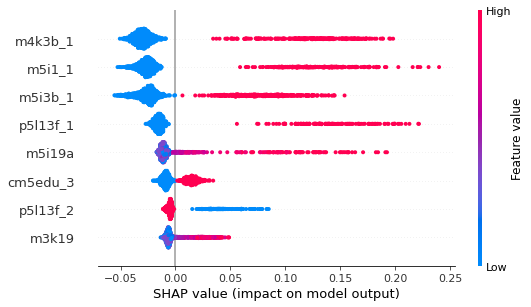

In [ ]:
shap_values = shap_ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=list(background), max_display=8)

## Gradient Boosting

In [ ]:
model = joblib.load('models/jobtrain_xgb_200.pkl')

In [ ]:
model.best_params_

{'xgboost__subsample': 0.7000000000000002,
 'xgboost__n_estimators': 130,
 'xgboost__min_child_weight': 1,
 'xgboost__max_depth': 4,
 'xgboost__learning_rate': 0.035500000000000025,
 'xgboost__gamma': 1.95,
 'xgboost__colsample_bytree': 0.6000000000000001,
 'xgboost__colsample_bylevel': 1.0,
 'impute__strategy': 'median',
 'feat_select__k': 2110}

In [ ]:
variable = 'jobTraining'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:

xg_reg = xgb.XGBClassifier(objective ='binary:logistic', 
                           subsample = 0.7, 
                          n_estimators = 130, 
                          min_child_weight = 1, 
                          max_depth = 4, 
                          learning_rate = 0.03, 
                          gamma = 1.95, 
                          colsample_bytree = 0.6, 
                          colsample_bylevel = 1)

pipeline = Pipeline(steps=[('impute', SimpleImputer(strategy = 'median')),
                           ('normalize', MinMaxScaler()), 
                           ('feat_select', SelectKBest(f_classif, k = 2210)),
                           ('xgboost', xg_reg)])



In [ ]:
boosting = pipeline.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  809   813   834 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:49:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
y_test = np.array(y_test * 1).astype(int)

In [ ]:
jobtraining_boosting_pred = boosting.predict_proba(X_test)[:, 1]

In [ ]:
brier_score_loss(y_test, jobtraining_boosting_pred)

0.17748070145038836

In [ ]:
binary_label = (jobtraining_boosting_pred >= 0.5) * 1

In [ ]:
recall_score(y_test, binary_label)

0.05904059040590406

In [ ]:
precision_score(y_test, binary_label)

0.48484848484848486